In [173]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [115]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip

In [116]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [117]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [118]:
# import zipfile
# with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [119]:
seed = 47
np.random.seed(seed)

We will use the following blogpost's independent code to benchmark our experiments https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

# Independent MF code

In [120]:
# # movielens-100k dataset
# names = ['user_id', 'item_id', 'rating', 'timestamp']
# df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
# df.head()

In [121]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('./ml-1m/ratings.dat', sep='::', usecols = [0, 1, 2], names=names)
df.head()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


user_id  item_id  rating
0        1     1193       5
1        1      661       3
2        1      914       3
3        1     3408       4
4        1     2355       5

In [122]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users, n_items

(6040, 3706)

In [123]:
n_users = df.user_id.unique().max()
n_items = df.item_id.unique().max()
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
#     print(row)
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [124]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [125]:
get_sparsity(ratings)

4.190220560634904

In [126]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [127]:
train_1m, test_1m = train_test_split(ratings)

In [128]:
train_1m

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [129]:
test_1m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [130]:
get_sparsity(train_1m), get_sparsity(test_1m)

(3.93718412338794, 0.25303643724696356)

In [131]:
# movielens-100k dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [132]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [133]:
train_100k, test_100k = train_test_split(ratings)

In [134]:
get_sparsity(train_100k), get_sparsity(test_100k)

(5.710139043178159, 0.5945303210463734)

In [135]:
train_100k.shape, train_1m.shape

((943, 1682), (6040, 3952))

In [57]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        np.random.seed(seed)
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        np.random.seed(seed)
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        np.random.seed(seed)
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        np.random.seed(seed)
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        np.random.seed(seed)
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [136]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [137]:
iter_array = [1, 2, 5, 10, 15, 20, 30, 40, 50, 70, 90, 120, 150, 180, 220]

In [138]:
mf_als_100k = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)
mf_als_100k.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.895002723511445
Test mse: 10.907282059664317
Iteration: 2


KeyboardInterrupt: 

In [22]:
def plot_curve(values, title_name, xlabel, ylabel, iterations=iter_array, plot_type="plot"):
    if plot_type=="plot":
        plt.plot(iterations, values)
    elif plot_type=="scatter":
        plt.scatter(iterations, values)
    else:
        return
    plt.title(title_name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

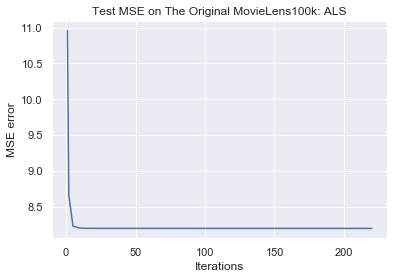

In [64]:
plot_curve(values=mf_als_100k.test_mse, title_name="Test MSE on The Original MovieLens100k: ALS", xlabel="Iterations", ylabel="MSE error")

In [69]:
min(mf_als_100k.test_mse)

8.194329080408963

In [62]:
# We are using the best fine tuned hyperparameters of the blog post for evaluation
mf_sgd_100k = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
mf_sgd_100k.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142903905755556
Test mse: 1.1796423589839398
Iteration: 2
Train mse: 1.0731571399242776
Test mse: 1.1283642555477047
Iteration: 5
Train mse: 0.9768279872277285
Test mse: 1.0498298549996896
Iteration: 10
Train mse: 0.9191761690006633
Test mse: 0.9986910865034175
Iteration: 15
Train mse: 0.8931844079487902
Test mse: 0.9750973624132867
Iteration: 20
Train mse: 0.8776784607465106
Test mse: 0.9613232749048447
Iteration: 30
	current iteration: 10
Train mse: 0.8592955446513819
Test mse: 0.946187289250373
Iteration: 40
	current iteration: 10
Train mse: 0.8480564814313558
Test mse: 0.9385166159690298
Iteration: 50
	current iteration: 10
Train mse: 0.8393903153961552
Test mse: 0.9341865831260542
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.8202469350671223
Test mse: 0.9290442210331938
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.7827904694456294
Test mse: 0.9220315219430705
Iteration: 120
	current iteration: 10
	cu

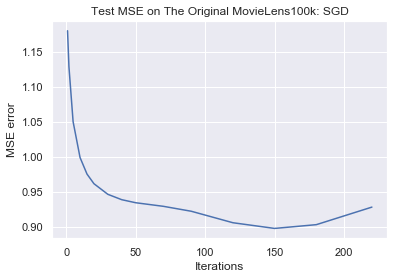

In [66]:
plot_curve(values=mf_sgd_100k.test_mse, title_name="Test MSE on The Original MovieLens100k: SGD", xlabel="Iterations", ylabel="MSE error")

In [70]:
min(mf_sgd_100k.test_mse)

0.8975222763790961

# Our Proposed GAN

In [60]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

In [61]:
zero_mask = (train_100k == 0)
positive_feedback = (train_100k > 3)
negative_feedback = ((train_100k < 4) * (1 - zero_mask))

In [62]:
positive_feedback.sum(), negative_feedback.sum()

(49901, 40669)

In [63]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [64]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(94.28986095682184, 3.146093059441684, 2.5640459837364746)

In [65]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, batch_size=128):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size=batch_size
        self.mat=mat
        self.p=[0., 0.3]

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > np.random.uniform(self.p[0], self.p[1]))
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [66]:
generator_negative = DataGenerator(negative_feedback, batch_size=64)

In [67]:
x, y, _ = generator_negative.gen_item_GAN()

In [68]:
get_sparsity(x), get_sparsity(y)

(2.5053879310344827, 3.3089328180737216)

In [69]:
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
# #                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(1024, 1024),
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, self.feat_size), 
                                torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
#         print(x.shape, )
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [70]:
gen_losses = []
disc_losses = []

def train_GAN(netD, netG, negative, tr, steps_per_epoch = 200, epochs = 10):
    d_iter = 10
    g_iter = 1
    gen_iterations = 0
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            i = 0
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
            j = 0
            while j < d_iter:
                j += 1
                i += 1
                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()
                    
                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)
                real.requires_grad=False

                # generate fake data
                noise = torch.randn(batch_size, nz)
#                     if cuda: 
                noise = noise.cuda()

                with torch.no_grad():
                    noisev = Variable(noise) 
                concated = torch.cat((noisev, condition), 1)

                e_mask = torch.Tensor(tr[idxs]>0).cuda()
                fake = Variable(netG(e_mask, concated).data)
                fake.requires_grad=False

                netD.zero_grad()
                out = netD(real, fake)
                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()

            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                
                i += 1

                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()

                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)
                real.requires_grad=True

                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()

                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
                gen_losses.append(outputG.item())
                disc_losses.append(outputD.item())
                print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [71]:
lrD = 5e-6
lrG = 5e-6
batch_size = 64
cuda = True
epochs = 500
nz = 10
lamba = 1e-3

In [408]:
# networks
netD_neg = NetD(train_100k.shape[1]).cuda()
netG_neg = NetG(train_100k.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=1e-4)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=1e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=1682, out_features=1024, bias=True)
  (b1): Linear(in_features=1682, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=1682, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1692, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)


In [72]:
netG_neg.load_state_dict(torch.load('./netG_neg-100k'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [409]:
# netD_neg.train()
# netG_neg.train()
# # gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
# # loss values doesn't say much about the quality
# train_GAN(netD_neg, netG_neg, tr=train_100k, epochs=500, negative=True)

[0/500][11/100][1] Loss_D: 0.000009 Loss_G: 0.000004 
[0/500][11/100][2] Loss_D: -0.000026 Loss_G: 0.000032 
[0/500][11/100][3] Loss_D: 0.000034 Loss_G: -0.000012 
[0/500][11/100][4] Loss_D: 0.000021 Loss_G: -0.000022 
[0/500][11/100][5] Loss_D: 0.000036 Loss_G: 0.000010 
[0/500][11/100][6] Loss_D: 0.000015 Loss_G: -0.000031 
[0/500][11/100][7] Loss_D: 0.000053 Loss_G: 0.000063 
[0/500][11/100][8] Loss_D: 0.000045 Loss_G: 0.000087 
[0/500][11/100][9] Loss_D: 0.000030 Loss_G: 0.000072 
[0/500][11/100][10] Loss_D: 0.000097 Loss_G: 0.000043 
[0/500][11/100][11] Loss_D: 0.000080 Loss_G: 0.000048 
[0/500][11/100][12] Loss_D: 0.000044 Loss_G: 0.000043 
[0/500][11/100][13] Loss_D: 0.000025 Loss_G: 0.000044 
[0/500][11/100][14] Loss_D: 0.000106 Loss_G: 0.000016 
[0/500][11/100][15] Loss_D: 0.000064 Loss_G: 0.000055 
[0/500][11/100][16] Loss_D: 0.000100 Loss_G: 0.000048 
[0/500][11/100][17] Loss_D: 0.000097 Loss_G: 0.000076 
[0/500][11/100][18] Loss_D: 0.000118 Loss_G: 0.000134 
[0/500][11/100]

[0/500][11/100][150] Loss_D: 0.002092 Loss_G: 0.001593 
[0/500][11/100][151] Loss_D: 0.001472 Loss_G: 0.003080 
[0/500][11/100][152] Loss_D: 0.001847 Loss_G: 0.001867 
[0/500][11/100][153] Loss_D: 0.001573 Loss_G: 0.001290 
[0/500][11/100][154] Loss_D: 0.001943 Loss_G: 0.003272 
[0/500][11/100][155] Loss_D: 0.001621 Loss_G: 0.002028 
[0/500][11/100][156] Loss_D: 0.001296 Loss_G: 0.002721 
[0/500][11/100][157] Loss_D: 0.002348 Loss_G: 0.001484 
[0/500][11/100][158] Loss_D: 0.001188 Loss_G: 0.001645 
[0/500][11/100][159] Loss_D: 0.002502 Loss_G: 0.002681 
[0/500][11/100][160] Loss_D: 0.002782 Loss_G: 0.002135 
[0/500][11/100][161] Loss_D: 0.001751 Loss_G: 0.001616 
[0/500][11/100][162] Loss_D: 0.002187 Loss_G: 0.002928 
[0/500][11/100][163] Loss_D: 0.001336 Loss_G: 0.001484 
[0/500][11/100][164] Loss_D: 0.001525 Loss_G: 0.003016 
[0/500][11/100][165] Loss_D: 0.002029 Loss_G: 0.001987 
[0/500][11/100][166] Loss_D: 0.002217 Loss_G: 0.001913 
[0/500][11/100][167] Loss_D: 0.002186 Loss_G: 0.

[1/500][11/100][298] Loss_D: 0.010889 Loss_G: 0.012439 
[1/500][11/100][299] Loss_D: 0.008329 Loss_G: 0.008023 
[1/500][11/100][300] Loss_D: 0.008352 Loss_G: 0.009543 
[1/500][11/100][301] Loss_D: 0.009106 Loss_G: 0.009577 
[1/500][11/100][302] Loss_D: 0.007217 Loss_G: 0.008771 
[1/500][11/100][303] Loss_D: 0.008078 Loss_G: 0.007102 
[1/500][11/100][304] Loss_D: 0.011648 Loss_G: 0.009334 
[1/500][11/100][305] Loss_D: 0.007272 Loss_G: 0.010815 
[1/500][11/100][306] Loss_D: 0.008992 Loss_G: 0.007494 
[1/500][11/100][307] Loss_D: 0.006399 Loss_G: 0.004455 
[1/500][11/100][308] Loss_D: 0.007063 Loss_G: 0.004250 
[1/500][11/100][309] Loss_D: 0.009477 Loss_G: 0.009641 
[1/500][11/100][310] Loss_D: 0.007496 Loss_G: 0.008150 
[1/500][11/100][311] Loss_D: 0.008446 Loss_G: 0.009112 
[1/500][11/100][312] Loss_D: 0.009008 Loss_G: 0.007176 
[1/500][11/100][313] Loss_D: 0.010179 Loss_G: 0.009438 
[1/500][11/100][314] Loss_D: 0.008866 Loss_G: 0.008967 
[1/500][11/100][315] Loss_D: 0.008706 Loss_G: 0.

[2/500][11/100][445] Loss_D: 0.013177 Loss_G: 0.007451 
[2/500][11/100][446] Loss_D: 0.008096 Loss_G: 0.012304 
[2/500][11/100][447] Loss_D: 0.008919 Loss_G: 0.005635 
[2/500][11/100][448] Loss_D: 0.010884 Loss_G: 0.008808 
[2/500][11/100][449] Loss_D: 0.008751 Loss_G: 0.011639 
[2/500][11/100][450] Loss_D: 0.009793 Loss_G: 0.014478 
[2/500][11/100][451] Loss_D: 0.010499 Loss_G: 0.008151 
[2/500][11/100][452] Loss_D: 0.005657 Loss_G: 0.007012 
[2/500][11/100][453] Loss_D: 0.007928 Loss_G: 0.008768 
[2/500][11/100][454] Loss_D: 0.007913 Loss_G: 0.009791 
[2/500][11/100][455] Loss_D: 0.008551 Loss_G: 0.009363 
[2/500][11/100][456] Loss_D: 0.010525 Loss_G: 0.013206 
[2/500][11/100][457] Loss_D: 0.011665 Loss_G: 0.014365 
[2/500][11/100][458] Loss_D: 0.008884 Loss_G: 0.011739 
[2/500][11/100][459] Loss_D: 0.008157 Loss_G: 0.010180 
[2/500][11/100][460] Loss_D: 0.007959 Loss_G: 0.009327 
[2/500][11/100][461] Loss_D: 0.007388 Loss_G: 0.011709 
[2/500][11/100][462] Loss_D: 0.010226 Loss_G: 0.

[2/500][11/100][592] Loss_D: 0.009609 Loss_G: 0.005620 
[2/500][11/100][593] Loss_D: 0.008767 Loss_G: 0.013533 
[2/500][11/100][594] Loss_D: 0.008731 Loss_G: 0.010538 
[2/500][11/100][595] Loss_D: 0.009693 Loss_G: 0.010641 
[2/500][11/100][596] Loss_D: 0.011099 Loss_G: 0.009064 
[2/500][11/100][597] Loss_D: 0.007909 Loss_G: 0.009748 
[2/500][11/100][598] Loss_D: 0.010506 Loss_G: 0.009282 
[2/500][11/100][599] Loss_D: 0.008045 Loss_G: 0.009261 
[2/500][11/100][600] Loss_D: 0.009488 Loss_G: 0.010118 
[3/500][11/100][601] Loss_D: 0.009129 Loss_G: 0.008456 
[3/500][11/100][602] Loss_D: 0.012833 Loss_G: 0.008331 
[3/500][11/100][603] Loss_D: 0.009722 Loss_G: 0.011661 
[3/500][11/100][604] Loss_D: 0.013017 Loss_G: 0.005525 
[3/500][11/100][605] Loss_D: 0.008922 Loss_G: 0.010897 
[3/500][11/100][606] Loss_D: 0.013541 Loss_G: 0.008911 
[3/500][11/100][607] Loss_D: 0.009551 Loss_G: 0.010309 
[3/500][11/100][608] Loss_D: 0.012905 Loss_G: 0.010855 
[3/500][11/100][609] Loss_D: 0.006881 Loss_G: 0.

[3/500][11/100][739] Loss_D: 0.010152 Loss_G: 0.006165 
[3/500][11/100][740] Loss_D: 0.009339 Loss_G: 0.008665 
[3/500][11/100][741] Loss_D: 0.004164 Loss_G: 0.008087 
[3/500][11/100][742] Loss_D: 0.008618 Loss_G: 0.007904 
[3/500][11/100][743] Loss_D: 0.008893 Loss_G: 0.009711 
[3/500][11/100][744] Loss_D: 0.004999 Loss_G: 0.006696 
[3/500][11/100][745] Loss_D: 0.007748 Loss_G: 0.006699 
[3/500][11/100][746] Loss_D: 0.004565 Loss_G: 0.008056 
[3/500][11/100][747] Loss_D: 0.009965 Loss_G: 0.009862 
[3/500][11/100][748] Loss_D: 0.007575 Loss_G: 0.009588 
[3/500][11/100][749] Loss_D: 0.007481 Loss_G: 0.012441 
[3/500][11/100][750] Loss_D: 0.009622 Loss_G: 0.006046 
[3/500][11/100][751] Loss_D: 0.005847 Loss_G: 0.008329 
[3/500][11/100][752] Loss_D: 0.008716 Loss_G: 0.006457 
[3/500][11/100][753] Loss_D: 0.009599 Loss_G: 0.007153 
[3/500][11/100][754] Loss_D: 0.004470 Loss_G: 0.005637 
[3/500][11/100][755] Loss_D: 0.008590 Loss_G: 0.009815 
[3/500][11/100][756] Loss_D: 0.007507 Loss_G: 0.

[4/500][11/100][886] Loss_D: 0.006310 Loss_G: 0.003050 
[4/500][11/100][887] Loss_D: 0.005900 Loss_G: 0.003566 
[4/500][11/100][888] Loss_D: 0.004772 Loss_G: 0.002961 
[4/500][11/100][889] Loss_D: 0.006171 Loss_G: 0.004453 
[4/500][11/100][890] Loss_D: 0.004698 Loss_G: 0.002800 
[4/500][11/100][891] Loss_D: 0.004546 Loss_G: 0.004870 
[4/500][11/100][892] Loss_D: 0.004793 Loss_G: 0.004050 
[4/500][11/100][893] Loss_D: 0.004232 Loss_G: 0.006222 
[4/500][11/100][894] Loss_D: 0.005722 Loss_G: 0.006757 
[4/500][11/100][895] Loss_D: 0.007538 Loss_G: 0.005105 
[4/500][11/100][896] Loss_D: 0.004049 Loss_G: 0.007374 
[4/500][11/100][897] Loss_D: 0.004314 Loss_G: 0.005164 
[4/500][11/100][898] Loss_D: 0.003601 Loss_G: 0.007732 
[4/500][11/100][899] Loss_D: 0.007693 Loss_G: 0.007657 
[4/500][11/100][900] Loss_D: 0.002912 Loss_G: 0.002868 
[4/500][11/100][901] Loss_D: 0.006353 Loss_G: 0.001080 
[4/500][11/100][902] Loss_D: 0.004052 Loss_G: 0.001526 
[4/500][11/100][903] Loss_D: 0.005065 Loss_G: 0.

[5/500][11/100][1032] Loss_D: 0.003816 Loss_G: 0.002758 
[5/500][11/100][1033] Loss_D: 0.001057 Loss_G: 0.005282 
[5/500][11/100][1034] Loss_D: 0.004596 Loss_G: 0.002871 
[5/500][11/100][1035] Loss_D: 0.004817 Loss_G: 0.003579 
[5/500][11/100][1036] Loss_D: 0.004281 Loss_G: 0.002158 
[5/500][11/100][1037] Loss_D: 0.001074 Loss_G: 0.004679 
[5/500][11/100][1038] Loss_D: 0.003281 Loss_G: 0.000778 
[5/500][11/100][1039] Loss_D: 0.002861 Loss_G: 0.003132 
[5/500][11/100][1040] Loss_D: 0.005176 Loss_G: 0.002706 
[5/500][11/100][1041] Loss_D: 0.002910 Loss_G: 0.004899 
[5/500][11/100][1042] Loss_D: 0.003616 Loss_G: 0.002495 
[5/500][11/100][1043] Loss_D: 0.002949 Loss_G: 0.003119 
[5/500][11/100][1044] Loss_D: 0.005758 Loss_G: 0.001235 
[5/500][11/100][1045] Loss_D: 0.005085 Loss_G: 0.002634 
[5/500][11/100][1046] Loss_D: 0.000417 Loss_G: 0.002659 
[5/500][11/100][1047] Loss_D: 0.001848 Loss_G: 0.005130 
[5/500][11/100][1048] Loss_D: 0.002691 Loss_G: 0.003005 
[5/500][11/100][1049] Loss_D: 0

[5/500][11/100][1178] Loss_D: 0.003684 Loss_G: 0.001175 
[5/500][11/100][1179] Loss_D: 0.002464 Loss_G: 0.004076 
[5/500][11/100][1180] Loss_D: 0.002345 Loss_G: 0.001437 
[5/500][11/100][1181] Loss_D: 0.002370 Loss_G: 0.006894 
[5/500][11/100][1182] Loss_D: 0.000343 Loss_G: 0.000200 
[5/500][11/100][1183] Loss_D: 0.005127 Loss_G: 0.003473 
[5/500][11/100][1184] Loss_D: 0.001227 Loss_G: 0.001218 
[5/500][11/100][1185] Loss_D: 0.002538 Loss_G: 0.001592 
[5/500][11/100][1186] Loss_D: 0.003670 Loss_G: 0.002304 
[5/500][11/100][1187] Loss_D: 0.001470 Loss_G: 0.002306 
[5/500][11/100][1188] Loss_D: 0.004167 Loss_G: -0.003337 
[5/500][11/100][1189] Loss_D: 0.001261 Loss_G: 0.004702 
[5/500][11/100][1190] Loss_D: 0.002852 Loss_G: 0.003041 
[5/500][11/100][1191] Loss_D: 0.002074 Loss_G: 0.002661 
[5/500][11/100][1192] Loss_D: 0.002285 Loss_G: 0.004154 
[5/500][11/100][1193] Loss_D: 0.004849 Loss_G: -0.000163 
[5/500][11/100][1194] Loss_D: 0.003227 Loss_G: 0.004593 
[5/500][11/100][1195] Loss_D:

[6/500][11/100][1323] Loss_D: 0.001064 Loss_G: 0.001526 
[6/500][11/100][1324] Loss_D: 0.003255 Loss_G: 0.002295 
[6/500][11/100][1325] Loss_D: 0.002619 Loss_G: 0.002154 
[6/500][11/100][1326] Loss_D: 0.002381 Loss_G: 0.001031 
[6/500][11/100][1327] Loss_D: 0.000813 Loss_G: 0.001421 
[6/500][11/100][1328] Loss_D: 0.003384 Loss_G: 0.000800 
[6/500][11/100][1329] Loss_D: 0.001846 Loss_G: 0.001294 
[6/500][11/100][1330] Loss_D: 0.000562 Loss_G: 0.001402 
[6/500][11/100][1331] Loss_D: 0.003621 Loss_G: 0.002979 
[6/500][11/100][1332] Loss_D: 0.007348 Loss_G: 0.001882 
[6/500][11/100][1333] Loss_D: 0.002401 Loss_G: 0.001387 
[6/500][11/100][1334] Loss_D: 0.001756 Loss_G: 0.001348 
[6/500][11/100][1335] Loss_D: 0.004127 Loss_G: 0.001986 
[6/500][11/100][1336] Loss_D: 0.004798 Loss_G: 0.001522 
[6/500][11/100][1337] Loss_D: 0.001071 Loss_G: 0.002006 
[6/500][11/100][1338] Loss_D: 0.004065 Loss_G: 0.003244 
[6/500][11/100][1339] Loss_D: 0.002482 Loss_G: 0.004350 
[6/500][11/100][1340] Loss_D: 0

[7/500][11/100][1467] Loss_D: 0.001343 Loss_G: 0.000442 
[7/500][11/100][1468] Loss_D: 0.003879 Loss_G: 0.000164 
[7/500][11/100][1469] Loss_D: 0.001178 Loss_G: 0.003026 
[7/500][11/100][1470] Loss_D: 0.003047 Loss_G: 0.001778 
[7/500][11/100][1471] Loss_D: 0.002050 Loss_G: 0.002213 
[7/500][11/100][1472] Loss_D: 0.002197 Loss_G: 0.003177 
[7/500][11/100][1473] Loss_D: 0.001321 Loss_G: 0.001895 
[7/500][11/100][1474] Loss_D: 0.002955 Loss_G: 0.002109 
[7/500][11/100][1475] Loss_D: 0.000991 Loss_G: 0.003649 
[7/500][11/100][1476] Loss_D: 0.000925 Loss_G: 0.002698 
[7/500][11/100][1477] Loss_D: 0.004100 Loss_G: 0.002045 
[7/500][11/100][1478] Loss_D: 0.002183 Loss_G: 0.003102 
[7/500][11/100][1479] Loss_D: 0.001717 Loss_G: 0.002260 
[7/500][11/100][1480] Loss_D: 0.002894 Loss_G: 0.000136 
[7/500][11/100][1481] Loss_D: 0.000946 Loss_G: 0.002997 
[7/500][11/100][1482] Loss_D: 0.002339 Loss_G: 0.001270 
[7/500][11/100][1483] Loss_D: 0.002130 Loss_G: 0.001390 
[7/500][11/100][1484] Loss_D: 0

[8/500][11/100][1612] Loss_D: 0.001858 Loss_G: 0.001999 
[8/500][11/100][1613] Loss_D: 0.005515 Loss_G: 0.002688 
[8/500][11/100][1614] Loss_D: 0.001278 Loss_G: 0.001459 
[8/500][11/100][1615] Loss_D: 0.002920 Loss_G: 0.001877 
[8/500][11/100][1616] Loss_D: 0.001718 Loss_G: 0.002321 
[8/500][11/100][1617] Loss_D: 0.001773 Loss_G: 0.000927 
[8/500][11/100][1618] Loss_D: 0.005458 Loss_G: 0.001532 
[8/500][11/100][1619] Loss_D: 0.002828 Loss_G: 0.002257 
[8/500][11/100][1620] Loss_D: 0.002318 Loss_G: 0.003662 
[8/500][11/100][1621] Loss_D: 0.001953 Loss_G: 0.002595 
[8/500][11/100][1622] Loss_D: 0.002358 Loss_G: 0.002357 
[8/500][11/100][1623] Loss_D: 0.000931 Loss_G: 0.002090 
[8/500][11/100][1624] Loss_D: 0.000623 Loss_G: 0.002936 
[8/500][11/100][1625] Loss_D: 0.001794 Loss_G: 0.003175 
[8/500][11/100][1626] Loss_D: 0.002085 Loss_G: 0.003938 
[8/500][11/100][1627] Loss_D: 0.002921 Loss_G: 0.001145 
[8/500][11/100][1628] Loss_D: 0.002364 Loss_G: 0.002066 
[8/500][11/100][1629] Loss_D: 0

[8/500][11/100][1756] Loss_D: 0.000309 Loss_G: 0.002111 
[8/500][11/100][1757] Loss_D: 0.002493 Loss_G: 0.003413 
[8/500][11/100][1758] Loss_D: 0.001766 Loss_G: 0.002762 
[8/500][11/100][1759] Loss_D: 0.005257 Loss_G: 0.001534 
[8/500][11/100][1760] Loss_D: 0.001622 Loss_G: 0.003386 
[8/500][11/100][1761] Loss_D: 0.002753 Loss_G: 0.001039 
[8/500][11/100][1762] Loss_D: 0.001753 Loss_G: 0.001336 
[8/500][11/100][1763] Loss_D: 0.000829 Loss_G: 0.001450 
[8/500][11/100][1764] Loss_D: 0.003187 Loss_G: 0.002239 
[8/500][11/100][1765] Loss_D: 0.001782 Loss_G: 0.002653 
[8/500][11/100][1766] Loss_D: 0.001958 Loss_G: 0.001795 
[8/500][11/100][1767] Loss_D: 0.001676 Loss_G: 0.002003 
[8/500][11/100][1768] Loss_D: 0.001663 Loss_G: 0.001666 
[8/500][11/100][1769] Loss_D: 0.003930 Loss_G: 0.001629 
[8/500][11/100][1770] Loss_D: 0.003466 Loss_G: 0.001812 
[8/500][11/100][1771] Loss_D: 0.001634 Loss_G: 0.000890 
[8/500][11/100][1772] Loss_D: 0.002409 Loss_G: 0.001412 
[8/500][11/100][1773] Loss_D: 0

[10/500][11/100][2043] Loss_D: 0.001628 Loss_G: 0.005298 
[10/500][11/100][2044] Loss_D: 0.003875 Loss_G: 0.005462 
[10/500][11/100][2045] Loss_D: 0.003448 Loss_G: 0.001077 
[10/500][11/100][2046] Loss_D: 0.002288 Loss_G: 0.002478 
[10/500][11/100][2047] Loss_D: 0.003623 Loss_G: 0.002624 
[10/500][11/100][2048] Loss_D: 0.003538 Loss_G: 0.001625 
[10/500][11/100][2049] Loss_D: 0.004107 Loss_G: 0.001662 
[10/500][11/100][2050] Loss_D: 0.001859 Loss_G: 0.004347 
[10/500][11/100][2051] Loss_D: 0.001070 Loss_G: 0.000761 
[10/500][11/100][2052] Loss_D: 0.004917 Loss_G: 0.003474 
[10/500][11/100][2053] Loss_D: 0.002659 Loss_G: 0.001984 
[10/500][11/100][2054] Loss_D: 0.003480 Loss_G: 0.002336 
[10/500][11/100][2055] Loss_D: 0.002562 Loss_G: 0.001971 
[10/500][11/100][2056] Loss_D: 0.002889 Loss_G: 0.003112 
[10/500][11/100][2057] Loss_D: 0.003044 Loss_G: 0.002428 
[10/500][11/100][2058] Loss_D: 0.002396 Loss_G: 0.001801 
[10/500][11/100][2059] Loss_D: 0.003163 Loss_G: 0.001481 
[10/500][11/10

[10/500][11/100][2185] Loss_D: 0.004127 Loss_G: 0.002365 
[10/500][11/100][2186] Loss_D: 0.004004 Loss_G: 0.002904 
[10/500][11/100][2187] Loss_D: 0.003966 Loss_G: 0.001808 
[10/500][11/100][2188] Loss_D: 0.004172 Loss_G: 0.004329 
[10/500][11/100][2189] Loss_D: 0.003554 Loss_G: 0.001678 
[10/500][11/100][2190] Loss_D: 0.001860 Loss_G: 0.002521 
[10/500][11/100][2191] Loss_D: 0.005073 Loss_G: 0.002823 
[10/500][11/100][2192] Loss_D: 0.002091 Loss_G: 0.002683 
[10/500][11/100][2193] Loss_D: 0.002190 Loss_G: 0.003991 
[10/500][11/100][2194] Loss_D: 0.002141 Loss_G: 0.002746 
[10/500][11/100][2195] Loss_D: 0.006349 Loss_G: 0.005306 
[10/500][11/100][2196] Loss_D: 0.002093 Loss_G: 0.003097 
[10/500][11/100][2197] Loss_D: 0.001552 Loss_G: 0.003999 
[10/500][11/100][2198] Loss_D: 0.001393 Loss_G: 0.002001 
[10/500][11/100][2199] Loss_D: 0.002478 Loss_G: 0.005432 
[10/500][11/100][2200] Loss_D: 0.001185 Loss_G: 0.003194 
[11/500][11/100][2201] Loss_D: 0.002205 Loss_G: 0.003483 
[11/500][11/10

[11/500][11/100][2327] Loss_D: 0.003371 Loss_G: 0.002906 
[11/500][11/100][2328] Loss_D: 0.002418 Loss_G: 0.002674 
[11/500][11/100][2329] Loss_D: 0.001626 Loss_G: 0.002722 
[11/500][11/100][2330] Loss_D: 0.002570 Loss_G: 0.003965 
[11/500][11/100][2331] Loss_D: 0.002606 Loss_G: 0.004490 
[11/500][11/100][2332] Loss_D: 0.004534 Loss_G: 0.004952 
[11/500][11/100][2333] Loss_D: 0.003275 Loss_G: 0.005168 
[11/500][11/100][2334] Loss_D: 0.003792 Loss_G: 0.002643 
[11/500][11/100][2335] Loss_D: 0.004394 Loss_G: 0.002421 
[11/500][11/100][2336] Loss_D: 0.004981 Loss_G: 0.002807 
[11/500][11/100][2337] Loss_D: 0.002175 Loss_G: 0.003370 
[11/500][11/100][2338] Loss_D: 0.002103 Loss_G: 0.003678 
[11/500][11/100][2339] Loss_D: 0.005272 Loss_G: 0.002198 
[11/500][11/100][2340] Loss_D: 0.004799 Loss_G: 0.003378 
[11/500][11/100][2341] Loss_D: 0.002958 Loss_G: 0.005005 
[11/500][11/100][2342] Loss_D: 0.002736 Loss_G: 0.002483 
[11/500][11/100][2343] Loss_D: 0.001616 Loss_G: 0.003375 
[11/500][11/10

[12/500][11/100][2469] Loss_D: 0.001628 Loss_G: 0.003397 
[12/500][11/100][2470] Loss_D: 0.004222 Loss_G: 0.003207 
[12/500][11/100][2471] Loss_D: 0.003570 Loss_G: 0.003766 
[12/500][11/100][2472] Loss_D: 0.004105 Loss_G: 0.003476 
[12/500][11/100][2473] Loss_D: 0.002198 Loss_G: 0.001491 
[12/500][11/100][2474] Loss_D: 0.003207 Loss_G: 0.002676 
[12/500][11/100][2475] Loss_D: 0.005696 Loss_G: 0.003098 
[12/500][11/100][2476] Loss_D: 0.002995 Loss_G: 0.003728 
[12/500][11/100][2477] Loss_D: 0.002016 Loss_G: 0.001942 
[12/500][11/100][2478] Loss_D: 0.002917 Loss_G: 0.003566 
[12/500][11/100][2479] Loss_D: 0.003917 Loss_G: 0.003653 
[12/500][11/100][2480] Loss_D: 0.001800 Loss_G: 0.003177 
[12/500][11/100][2481] Loss_D: 0.002524 Loss_G: 0.004746 
[12/500][11/100][2482] Loss_D: 0.005176 Loss_G: 0.003418 
[12/500][11/100][2483] Loss_D: 0.002871 Loss_G: 0.004556 
[12/500][11/100][2484] Loss_D: 0.002914 Loss_G: 0.002618 
[12/500][11/100][2485] Loss_D: 0.003507 Loss_G: 0.003386 
[12/500][11/10

[13/500][11/100][2611] Loss_D: 0.003513 Loss_G: 0.003347 
[13/500][11/100][2612] Loss_D: 0.003518 Loss_G: 0.003914 
[13/500][11/100][2613] Loss_D: 0.001989 Loss_G: 0.002698 
[13/500][11/100][2614] Loss_D: 0.003750 Loss_G: 0.002516 
[13/500][11/100][2615] Loss_D: 0.002748 Loss_G: 0.001580 
[13/500][11/100][2616] Loss_D: 0.000597 Loss_G: 0.004703 
[13/500][11/100][2617] Loss_D: 0.002665 Loss_G: 0.002694 
[13/500][11/100][2618] Loss_D: 0.002116 Loss_G: 0.002935 
[13/500][11/100][2619] Loss_D: 0.003232 Loss_G: 0.002477 
[13/500][11/100][2620] Loss_D: 0.002272 Loss_G: 0.003720 
[13/500][11/100][2621] Loss_D: 0.002657 Loss_G: 0.000241 
[13/500][11/100][2622] Loss_D: 0.003115 Loss_G: 0.006142 
[13/500][11/100][2623] Loss_D: 0.002172 Loss_G: 0.002058 
[13/500][11/100][2624] Loss_D: 0.002822 Loss_G: 0.005139 
[13/500][11/100][2625] Loss_D: 0.003259 Loss_G: 0.003683 
[13/500][11/100][2626] Loss_D: 0.004718 Loss_G: 0.005678 
[13/500][11/100][2627] Loss_D: 0.002594 Loss_G: 0.002945 
[13/500][11/10

[13/500][11/100][2754] Loss_D: 0.002913 Loss_G: 0.002773 
[13/500][11/100][2755] Loss_D: 0.001750 Loss_G: 0.003940 
[13/500][11/100][2756] Loss_D: 0.002230 Loss_G: 0.001641 
[13/500][11/100][2757] Loss_D: 0.002693 Loss_G: 0.001957 
[13/500][11/100][2758] Loss_D: 0.002086 Loss_G: 0.006450 
[13/500][11/100][2759] Loss_D: 0.003330 Loss_G: 0.002749 
[13/500][11/100][2760] Loss_D: 0.004317 Loss_G: 0.003404 
[13/500][11/100][2761] Loss_D: 0.005621 Loss_G: 0.002309 
[13/500][11/100][2762] Loss_D: 0.002754 Loss_G: 0.002512 
[13/500][11/100][2763] Loss_D: 0.002604 Loss_G: 0.002625 
[13/500][11/100][2764] Loss_D: 0.003327 Loss_G: 0.003852 
[13/500][11/100][2765] Loss_D: 0.001945 Loss_G: 0.003440 
[13/500][11/100][2766] Loss_D: 0.001839 Loss_G: 0.003269 
[13/500][11/100][2767] Loss_D: 0.002049 Loss_G: 0.004434 
[13/500][11/100][2768] Loss_D: 0.002357 Loss_G: 0.004400 
[13/500][11/100][2769] Loss_D: 0.001650 Loss_G: 0.001239 
[13/500][11/100][2770] Loss_D: 0.002876 Loss_G: 0.004485 
[13/500][11/10

[14/500][11/100][2896] Loss_D: 0.002427 Loss_G: 0.004916 
[14/500][11/100][2897] Loss_D: 0.002842 Loss_G: 0.002617 
[14/500][11/100][2898] Loss_D: 0.002731 Loss_G: 0.001792 
[14/500][11/100][2899] Loss_D: 0.004985 Loss_G: 0.003315 
[14/500][11/100][2900] Loss_D: 0.001679 Loss_G: 0.003467 
[14/500][11/100][2901] Loss_D: 0.002754 Loss_G: 0.003179 
[14/500][11/100][2902] Loss_D: 0.003316 Loss_G: 0.001829 
[14/500][11/100][2903] Loss_D: 0.003806 Loss_G: 0.003451 
[14/500][11/100][2904] Loss_D: 0.003889 Loss_G: 0.003465 
[14/500][11/100][2905] Loss_D: 0.002365 Loss_G: 0.002417 
[14/500][11/100][2906] Loss_D: 0.005293 Loss_G: 0.003123 
[14/500][11/100][2907] Loss_D: 0.003034 Loss_G: 0.003166 
[14/500][11/100][2908] Loss_D: 0.002212 Loss_G: 0.002406 
[14/500][11/100][2909] Loss_D: 0.004507 Loss_G: 0.004198 
[14/500][11/100][2910] Loss_D: 0.002849 Loss_G: 0.003014 
[14/500][11/100][2911] Loss_D: 0.004938 Loss_G: 0.002979 
[14/500][11/100][2912] Loss_D: 0.003746 Loss_G: 0.001944 
[14/500][11/10

[15/500][11/100][3038] Loss_D: 0.002313 Loss_G: 0.003644 
[15/500][11/100][3039] Loss_D: 0.006067 Loss_G: 0.003994 
[15/500][11/100][3040] Loss_D: 0.003684 Loss_G: 0.005033 
[15/500][11/100][3041] Loss_D: 0.003682 Loss_G: 0.002842 
[15/500][11/100][3042] Loss_D: 0.003298 Loss_G: 0.003747 
[15/500][11/100][3043] Loss_D: 0.002264 Loss_G: 0.006964 
[15/500][11/100][3044] Loss_D: 0.003327 Loss_G: 0.006068 
[15/500][11/100][3045] Loss_D: 0.004898 Loss_G: 0.002628 
[15/500][11/100][3046] Loss_D: 0.003690 Loss_G: 0.003558 
[15/500][11/100][3047] Loss_D: 0.004979 Loss_G: 0.004552 
[15/500][11/100][3048] Loss_D: 0.003444 Loss_G: 0.005414 
[15/500][11/100][3049] Loss_D: 0.003888 Loss_G: 0.001871 
[15/500][11/100][3050] Loss_D: 0.001645 Loss_G: 0.003142 
[15/500][11/100][3051] Loss_D: 0.006264 Loss_G: 0.003902 
[15/500][11/100][3052] Loss_D: 0.002096 Loss_G: 0.001936 
[15/500][11/100][3053] Loss_D: 0.003528 Loss_G: 0.001712 
[15/500][11/100][3054] Loss_D: 0.000506 Loss_G: 0.002299 
[15/500][11/10

[16/500][11/100][3322] Loss_D: 0.005907 Loss_G: 0.003136 
[16/500][11/100][3323] Loss_D: 0.003536 Loss_G: 0.002671 
[16/500][11/100][3324] Loss_D: 0.003753 Loss_G: 0.002884 
[16/500][11/100][3325] Loss_D: 0.005758 Loss_G: 0.003944 
[16/500][11/100][3326] Loss_D: 0.002529 Loss_G: 0.004675 
[16/500][11/100][3327] Loss_D: 0.002082 Loss_G: 0.004115 
[16/500][11/100][3328] Loss_D: 0.004223 Loss_G: 0.003168 
[16/500][11/100][3329] Loss_D: 0.003121 Loss_G: 0.002653 
[16/500][11/100][3330] Loss_D: 0.005999 Loss_G: 0.003929 
[16/500][11/100][3331] Loss_D: 0.001962 Loss_G: 0.005242 
[16/500][11/100][3332] Loss_D: 0.006164 Loss_G: 0.002331 
[16/500][11/100][3333] Loss_D: 0.001923 Loss_G: 0.003425 
[16/500][11/100][3334] Loss_D: 0.008160 Loss_G: 0.005570 
[16/500][11/100][3335] Loss_D: 0.004954 Loss_G: 0.002046 
[16/500][11/100][3336] Loss_D: 0.004033 Loss_G: 0.004177 
[16/500][11/100][3337] Loss_D: 0.003953 Loss_G: 0.003603 
[16/500][11/100][3338] Loss_D: 0.002110 Loss_G: 0.002423 
[16/500][11/10

[17/500][11/100][3465] Loss_D: 0.002391 Loss_G: 0.001338 
[17/500][11/100][3466] Loss_D: 0.003470 Loss_G: 0.003348 
[17/500][11/100][3467] Loss_D: 0.003942 Loss_G: 0.002794 
[17/500][11/100][3468] Loss_D: 0.002497 Loss_G: 0.002683 
[17/500][11/100][3469] Loss_D: 0.001569 Loss_G: 0.002767 
[17/500][11/100][3470] Loss_D: 0.002195 Loss_G: 0.006192 
[17/500][11/100][3471] Loss_D: 0.006522 Loss_G: 0.002855 
[17/500][11/100][3472] Loss_D: 0.003611 Loss_G: 0.002839 
[17/500][11/100][3473] Loss_D: 0.004041 Loss_G: 0.003792 
[17/500][11/100][3474] Loss_D: 0.002943 Loss_G: 0.003981 
[17/500][11/100][3475] Loss_D: 0.004530 Loss_G: 0.004713 
[17/500][11/100][3476] Loss_D: 0.005223 Loss_G: 0.003007 
[17/500][11/100][3477] Loss_D: 0.002718 Loss_G: 0.004374 
[17/500][11/100][3478] Loss_D: 0.002625 Loss_G: 0.003094 
[17/500][11/100][3479] Loss_D: 0.004286 Loss_G: 0.004231 
[17/500][11/100][3480] Loss_D: 0.002836 Loss_G: 0.004079 
[17/500][11/100][3481] Loss_D: 0.004105 Loss_G: 0.006762 
[17/500][11/10

[18/500][11/100][3608] Loss_D: 0.003906 Loss_G: 0.002559 
[18/500][11/100][3609] Loss_D: 0.001509 Loss_G: 0.005373 
[18/500][11/100][3610] Loss_D: 0.004101 Loss_G: 0.005688 
[18/500][11/100][3611] Loss_D: 0.003617 Loss_G: 0.004196 
[18/500][11/100][3612] Loss_D: 0.003128 Loss_G: 0.004694 
[18/500][11/100][3613] Loss_D: 0.006126 Loss_G: 0.001803 
[18/500][11/100][3614] Loss_D: 0.001642 Loss_G: 0.005015 
[18/500][11/100][3615] Loss_D: 0.003687 Loss_G: 0.003558 
[18/500][11/100][3616] Loss_D: 0.004996 Loss_G: 0.003631 
[18/500][11/100][3617] Loss_D: 0.003609 Loss_G: 0.001757 
[18/500][11/100][3618] Loss_D: 0.004519 Loss_G: 0.003654 
[18/500][11/100][3619] Loss_D: 0.002274 Loss_G: 0.002616 
[18/500][11/100][3620] Loss_D: 0.003384 Loss_G: 0.002367 
[18/500][11/100][3621] Loss_D: 0.002726 Loss_G: 0.009350 
[18/500][11/100][3622] Loss_D: 0.003532 Loss_G: 0.004987 
[18/500][11/100][3623] Loss_D: 0.004924 Loss_G: 0.004263 
[18/500][11/100][3624] Loss_D: 0.004046 Loss_G: 0.004401 
[18/500][11/10

[18/500][11/100][3750] Loss_D: 0.002635 Loss_G: 0.002248 
[18/500][11/100][3751] Loss_D: 0.003365 Loss_G: 0.003263 
[18/500][11/100][3752] Loss_D: 0.002546 Loss_G: 0.004445 
[18/500][11/100][3753] Loss_D: 0.002353 Loss_G: 0.003480 
[18/500][11/100][3754] Loss_D: 0.003287 Loss_G: 0.000511 
[18/500][11/100][3755] Loss_D: 0.003028 Loss_G: 0.002672 
[18/500][11/100][3756] Loss_D: 0.005642 Loss_G: 0.005002 
[18/500][11/100][3757] Loss_D: 0.002727 Loss_G: 0.004134 
[18/500][11/100][3758] Loss_D: 0.004438 Loss_G: 0.003513 
[18/500][11/100][3759] Loss_D: 0.003241 Loss_G: 0.002091 
[18/500][11/100][3760] Loss_D: 0.004176 Loss_G: 0.003107 
[18/500][11/100][3761] Loss_D: 0.003166 Loss_G: 0.002779 
[18/500][11/100][3762] Loss_D: 0.003322 Loss_G: 0.009527 
[18/500][11/100][3763] Loss_D: 0.005288 Loss_G: 0.003790 
[18/500][11/100][3764] Loss_D: 0.003768 Loss_G: 0.004217 
[18/500][11/100][3765] Loss_D: 0.003833 Loss_G: 0.004196 
[18/500][11/100][3766] Loss_D: 0.001251 Loss_G: 0.003360 
[18/500][11/10

[19/500][11/100][3894] Loss_D: 0.002503 Loss_G: 0.003055 
[19/500][11/100][3895] Loss_D: 0.005483 Loss_G: 0.002207 
[19/500][11/100][3896] Loss_D: 0.005702 Loss_G: 0.004560 
[19/500][11/100][3897] Loss_D: 0.002718 Loss_G: 0.003597 
[19/500][11/100][3898] Loss_D: 0.003725 Loss_G: 0.003030 
[19/500][11/100][3899] Loss_D: 0.003924 Loss_G: 0.003708 
[19/500][11/100][3900] Loss_D: 0.003299 Loss_G: 0.003880 
[19/500][11/100][3901] Loss_D: 0.002024 Loss_G: 0.005620 
[19/500][11/100][3902] Loss_D: 0.003362 Loss_G: 0.004639 
[19/500][11/100][3903] Loss_D: 0.002653 Loss_G: 0.002943 
[19/500][11/100][3904] Loss_D: 0.003116 Loss_G: 0.004067 
[19/500][11/100][3905] Loss_D: 0.004099 Loss_G: 0.002075 
[19/500][11/100][3906] Loss_D: 0.002656 Loss_G: 0.005121 
[19/500][11/100][3907] Loss_D: 0.003946 Loss_G: 0.005489 
[19/500][11/100][3908] Loss_D: 0.002603 Loss_G: 0.003413 
[19/500][11/100][3909] Loss_D: 0.004646 Loss_G: 0.002647 
[19/500][11/100][3910] Loss_D: 0.002891 Loss_G: 0.003446 
[19/500][11/10

[20/500][11/100][4036] Loss_D: 0.006454 Loss_G: 0.005612 
[20/500][11/100][4037] Loss_D: 0.000832 Loss_G: 0.003369 
[20/500][11/100][4038] Loss_D: 0.002095 Loss_G: 0.005239 
[20/500][11/100][4039] Loss_D: 0.002658 Loss_G: 0.004733 
[20/500][11/100][4040] Loss_D: 0.006878 Loss_G: 0.005035 
[20/500][11/100][4041] Loss_D: 0.003220 Loss_G: 0.003197 
[20/500][11/100][4042] Loss_D: 0.004488 Loss_G: 0.004809 
[20/500][11/100][4043] Loss_D: 0.003969 Loss_G: 0.005979 
[20/500][11/100][4044] Loss_D: 0.002531 Loss_G: 0.005851 
[20/500][11/100][4045] Loss_D: 0.006953 Loss_G: 0.001637 
[20/500][11/100][4046] Loss_D: 0.004403 Loss_G: 0.002154 
[20/500][11/100][4047] Loss_D: 0.006324 Loss_G: 0.002937 
[20/500][11/100][4048] Loss_D: 0.001966 Loss_G: 0.006447 
[20/500][11/100][4049] Loss_D: 0.003320 Loss_G: 0.004144 
[20/500][11/100][4050] Loss_D: 0.002318 Loss_G: 0.003512 
[20/500][11/100][4051] Loss_D: 0.002512 Loss_G: 0.003097 
[20/500][11/100][4052] Loss_D: 0.003482 Loss_G: 0.003409 
[20/500][11/10

[20/500][11/100][4179] Loss_D: 0.002229 Loss_G: 0.006284 
[20/500][11/100][4180] Loss_D: 0.006843 Loss_G: 0.003207 
[20/500][11/100][4181] Loss_D: 0.003282 Loss_G: 0.002745 
[20/500][11/100][4182] Loss_D: 0.004315 Loss_G: 0.003545 
[20/500][11/100][4183] Loss_D: 0.003586 Loss_G: 0.006565 
[20/500][11/100][4184] Loss_D: 0.005832 Loss_G: 0.004472 
[20/500][11/100][4185] Loss_D: 0.007260 Loss_G: 0.004268 
[20/500][11/100][4186] Loss_D: 0.005388 Loss_G: 0.001603 
[20/500][11/100][4187] Loss_D: 0.003609 Loss_G: 0.004454 
[20/500][11/100][4188] Loss_D: 0.003031 Loss_G: 0.003671 
[20/500][11/100][4189] Loss_D: 0.002820 Loss_G: 0.001794 
[20/500][11/100][4190] Loss_D: 0.004256 Loss_G: 0.005725 
[20/500][11/100][4191] Loss_D: 0.007312 Loss_G: 0.004285 
[20/500][11/100][4192] Loss_D: 0.004693 Loss_G: 0.005193 
[20/500][11/100][4193] Loss_D: 0.002087 Loss_G: 0.006259 
[20/500][11/100][4194] Loss_D: 0.002235 Loss_G: 0.004170 
[20/500][11/100][4195] Loss_D: 0.004243 Loss_G: 0.004482 
[20/500][11/10

[21/500][11/100][4321] Loss_D: 0.004449 Loss_G: 0.002446 
[21/500][11/100][4322] Loss_D: 0.001883 Loss_G: 0.003301 
[21/500][11/100][4323] Loss_D: 0.004255 Loss_G: 0.002502 
[21/500][11/100][4324] Loss_D: 0.005994 Loss_G: 0.002684 
[21/500][11/100][4325] Loss_D: 0.003817 Loss_G: 0.003714 
[21/500][11/100][4326] Loss_D: 0.003695 Loss_G: 0.005826 
[21/500][11/100][4327] Loss_D: 0.002737 Loss_G: 0.003267 
[21/500][11/100][4328] Loss_D: 0.002511 Loss_G: 0.002687 
[21/500][11/100][4329] Loss_D: 0.004067 Loss_G: 0.004430 
[21/500][11/100][4330] Loss_D: 0.004100 Loss_G: 0.002159 
[21/500][11/100][4331] Loss_D: 0.003886 Loss_G: 0.003796 
[21/500][11/100][4332] Loss_D: 0.003523 Loss_G: 0.004157 
[21/500][11/100][4333] Loss_D: 0.003386 Loss_G: 0.003858 
[21/500][11/100][4334] Loss_D: 0.003326 Loss_G: 0.002863 
[21/500][11/100][4335] Loss_D: 0.006132 Loss_G: 0.002414 
[21/500][11/100][4336] Loss_D: 0.002521 Loss_G: 0.003261 
[21/500][11/100][4337] Loss_D: 0.003321 Loss_G: 0.003351 
[21/500][11/10

[22/500][11/100][4465] Loss_D: 0.002878 Loss_G: 0.003592 
[22/500][11/100][4466] Loss_D: 0.002579 Loss_G: 0.002939 
[22/500][11/100][4467] Loss_D: 0.003903 Loss_G: 0.004165 
[22/500][11/100][4468] Loss_D: 0.002716 Loss_G: 0.003519 
[22/500][11/100][4469] Loss_D: 0.002869 Loss_G: 0.004598 
[22/500][11/100][4470] Loss_D: 0.003688 Loss_G: 0.004133 
[22/500][11/100][4471] Loss_D: 0.003388 Loss_G: 0.003733 
[22/500][11/100][4472] Loss_D: 0.005207 Loss_G: 0.002737 
[22/500][11/100][4473] Loss_D: 0.005960 Loss_G: 0.003642 
[22/500][11/100][4474] Loss_D: 0.003634 Loss_G: 0.004312 
[22/500][11/100][4475] Loss_D: 0.001648 Loss_G: 0.002378 
[22/500][11/100][4476] Loss_D: 0.002644 Loss_G: 0.003220 
[22/500][11/100][4477] Loss_D: 0.003574 Loss_G: 0.002189 
[22/500][11/100][4478] Loss_D: 0.005354 Loss_G: 0.004620 
[22/500][11/100][4479] Loss_D: 0.005552 Loss_G: 0.003838 
[22/500][11/100][4480] Loss_D: 0.001310 Loss_G: 0.004816 
[22/500][11/100][4481] Loss_D: 0.004187 Loss_G: 0.003528 
[22/500][11/10

[23/500][11/100][4607] Loss_D: 0.002949 Loss_G: 0.004733 
[23/500][11/100][4608] Loss_D: 0.002294 Loss_G: 0.005136 
[23/500][11/100][4609] Loss_D: 0.002217 Loss_G: 0.004580 
[23/500][11/100][4610] Loss_D: 0.001721 Loss_G: 0.005345 
[23/500][11/100][4611] Loss_D: 0.004615 Loss_G: 0.002217 
[23/500][11/100][4612] Loss_D: 0.006889 Loss_G: 0.002797 
[23/500][11/100][4613] Loss_D: 0.003966 Loss_G: 0.003710 
[23/500][11/100][4614] Loss_D: 0.004029 Loss_G: 0.005117 
[23/500][11/100][4615] Loss_D: 0.004547 Loss_G: 0.003814 
[23/500][11/100][4616] Loss_D: 0.004675 Loss_G: 0.003957 
[23/500][11/100][4617] Loss_D: 0.006506 Loss_G: 0.004379 
[23/500][11/100][4618] Loss_D: 0.001796 Loss_G: 0.003757 
[23/500][11/100][4619] Loss_D: 0.006334 Loss_G: 0.005717 
[23/500][11/100][4620] Loss_D: 0.003700 Loss_G: 0.005347 
[23/500][11/100][4621] Loss_D: 0.003367 Loss_G: 0.004472 
[23/500][11/100][4622] Loss_D: 0.005327 Loss_G: 0.004942 
[23/500][11/100][4623] Loss_D: 0.003662 Loss_G: 0.003421 
[23/500][11/10

[23/500][11/100][4750] Loss_D: 0.005503 Loss_G: 0.004099 
[23/500][11/100][4751] Loss_D: 0.003013 Loss_G: 0.003550 
[23/500][11/100][4752] Loss_D: 0.004144 Loss_G: 0.001340 
[23/500][11/100][4753] Loss_D: 0.006146 Loss_G: 0.002456 
[23/500][11/100][4754] Loss_D: 0.002952 Loss_G: 0.003896 
[23/500][11/100][4755] Loss_D: 0.005342 Loss_G: 0.003021 
[23/500][11/100][4756] Loss_D: 0.003368 Loss_G: 0.003454 
[23/500][11/100][4757] Loss_D: 0.003081 Loss_G: 0.003315 
[23/500][11/100][4758] Loss_D: 0.002480 Loss_G: 0.006697 
[23/500][11/100][4759] Loss_D: 0.004718 Loss_G: 0.003561 
[23/500][11/100][4760] Loss_D: 0.008443 Loss_G: 0.003272 
[23/500][11/100][4761] Loss_D: 0.003605 Loss_G: 0.002403 
[23/500][11/100][4762] Loss_D: 0.002017 Loss_G: 0.002588 
[23/500][11/100][4763] Loss_D: 0.004725 Loss_G: 0.003208 
[23/500][11/100][4764] Loss_D: 0.004313 Loss_G: 0.004995 
[23/500][11/100][4765] Loss_D: 0.005073 Loss_G: 0.002195 
[23/500][11/100][4766] Loss_D: 0.004106 Loss_G: 0.003161 
[23/500][11/10

[24/500][11/100][4892] Loss_D: 0.004105 Loss_G: 0.002639 
[24/500][11/100][4893] Loss_D: 0.004342 Loss_G: 0.002912 
[24/500][11/100][4894] Loss_D: 0.006188 Loss_G: 0.002898 
[24/500][11/100][4895] Loss_D: 0.002235 Loss_G: 0.003534 
[24/500][11/100][4896] Loss_D: 0.006610 Loss_G: 0.005208 
[24/500][11/100][4897] Loss_D: 0.002773 Loss_G: 0.004837 
[24/500][11/100][4898] Loss_D: 0.001445 Loss_G: 0.003994 
[24/500][11/100][4899] Loss_D: 0.002918 Loss_G: 0.004237 
[24/500][11/100][4900] Loss_D: 0.001999 Loss_G: 0.005640 
[24/500][11/100][4901] Loss_D: 0.002930 Loss_G: 0.005157 
[24/500][11/100][4902] Loss_D: 0.001502 Loss_G: 0.003343 
[24/500][11/100][4903] Loss_D: 0.001859 Loss_G: 0.004393 
[24/500][11/100][4904] Loss_D: 0.004986 Loss_G: 0.002763 
[24/500][11/100][4905] Loss_D: 0.003653 Loss_G: 0.003417 
[24/500][11/100][4906] Loss_D: 0.003485 Loss_G: 0.003306 
[24/500][11/100][4907] Loss_D: 0.004406 Loss_G: 0.005384 
[24/500][11/100][4908] Loss_D: 0.003742 Loss_G: 0.003556 
[24/500][11/10

[25/500][11/100][5034] Loss_D: 0.003494 Loss_G: 0.004152 
[25/500][11/100][5035] Loss_D: 0.006130 Loss_G: 0.002950 
[25/500][11/100][5036] Loss_D: 0.003035 Loss_G: 0.003965 
[25/500][11/100][5037] Loss_D: 0.004024 Loss_G: 0.006378 
[25/500][11/100][5038] Loss_D: 0.006764 Loss_G: 0.002849 
[25/500][11/100][5039] Loss_D: 0.005861 Loss_G: 0.001970 
[25/500][11/100][5040] Loss_D: 0.006421 Loss_G: 0.004023 
[25/500][11/100][5041] Loss_D: 0.003262 Loss_G: 0.003702 
[25/500][11/100][5042] Loss_D: 0.003848 Loss_G: 0.001243 
[25/500][11/100][5043] Loss_D: 0.004440 Loss_G: 0.006799 
[25/500][11/100][5044] Loss_D: 0.004497 Loss_G: 0.003442 
[25/500][11/100][5045] Loss_D: 0.005031 Loss_G: 0.003416 
[25/500][11/100][5046] Loss_D: 0.002918 Loss_G: 0.002999 
[25/500][11/100][5047] Loss_D: 0.005716 Loss_G: 0.003239 
[25/500][11/100][5048] Loss_D: 0.003045 Loss_G: 0.006763 
[25/500][11/100][5049] Loss_D: 0.002587 Loss_G: 0.004854 
[25/500][11/100][5050] Loss_D: 0.003828 Loss_G: 0.006115 
[25/500][11/10

[25/500][11/100][5177] Loss_D: 0.007288 Loss_G: 0.003751 
[25/500][11/100][5178] Loss_D: 0.004010 Loss_G: 0.005215 
[25/500][11/100][5179] Loss_D: 0.002960 Loss_G: 0.003499 
[25/500][11/100][5180] Loss_D: 0.003528 Loss_G: 0.003587 
[25/500][11/100][5181] Loss_D: 0.005427 Loss_G: 0.003597 
[25/500][11/100][5182] Loss_D: 0.001916 Loss_G: 0.002964 
[25/500][11/100][5183] Loss_D: 0.002010 Loss_G: 0.004093 
[25/500][11/100][5184] Loss_D: 0.002208 Loss_G: 0.003100 
[25/500][11/100][5185] Loss_D: 0.001876 Loss_G: 0.004116 
[25/500][11/100][5186] Loss_D: 0.004870 Loss_G: 0.004808 
[25/500][11/100][5187] Loss_D: 0.002338 Loss_G: 0.004342 
[25/500][11/100][5188] Loss_D: 0.003084 Loss_G: 0.005095 
[25/500][11/100][5189] Loss_D: 0.003040 Loss_G: 0.003690 
[25/500][11/100][5190] Loss_D: 0.004973 Loss_G: 0.003069 
[25/500][11/100][5191] Loss_D: 0.001342 Loss_G: 0.003637 
[25/500][11/100][5192] Loss_D: 0.003549 Loss_G: 0.002559 
[25/500][11/100][5193] Loss_D: 0.002797 Loss_G: 0.006370 
[25/500][11/10

[26/500][11/100][5320] Loss_D: 0.003534 Loss_G: 0.002772 
[26/500][11/100][5321] Loss_D: 0.004756 Loss_G: 0.002747 
[26/500][11/100][5322] Loss_D: 0.006597 Loss_G: 0.003429 
[26/500][11/100][5323] Loss_D: 0.005164 Loss_G: 0.002048 
[26/500][11/100][5324] Loss_D: 0.004185 Loss_G: 0.002717 
[26/500][11/100][5325] Loss_D: 0.003436 Loss_G: 0.006132 
[26/500][11/100][5326] Loss_D: 0.004189 Loss_G: 0.002478 
[26/500][11/100][5327] Loss_D: 0.003804 Loss_G: 0.002155 
[26/500][11/100][5328] Loss_D: 0.003619 Loss_G: 0.003837 
[26/500][11/100][5329] Loss_D: 0.002894 Loss_G: 0.005075 
[26/500][11/100][5330] Loss_D: 0.002195 Loss_G: 0.005360 
[26/500][11/100][5331] Loss_D: 0.002690 Loss_G: 0.004195 
[26/500][11/100][5332] Loss_D: 0.005043 Loss_G: 0.003420 
[26/500][11/100][5333] Loss_D: 0.003902 Loss_G: 0.001407 
[26/500][11/100][5334] Loss_D: 0.006294 Loss_G: 0.002883 
[26/500][11/100][5335] Loss_D: 0.002584 Loss_G: 0.003046 
[26/500][11/100][5336] Loss_D: 0.002895 Loss_G: 0.002413 
[26/500][11/10

[27/500][11/100][5463] Loss_D: 0.007668 Loss_G: 0.004519 
[27/500][11/100][5464] Loss_D: 0.004044 Loss_G: 0.002691 
[27/500][11/100][5465] Loss_D: 0.003455 Loss_G: 0.003181 
[27/500][11/100][5466] Loss_D: 0.003238 Loss_G: 0.004624 
[27/500][11/100][5467] Loss_D: 0.004456 Loss_G: 0.004220 
[27/500][11/100][5468] Loss_D: 0.001649 Loss_G: 0.002933 
[27/500][11/100][5469] Loss_D: 0.001413 Loss_G: 0.002691 
[27/500][11/100][5470] Loss_D: 0.005450 Loss_G: 0.007202 
[27/500][11/100][5471] Loss_D: 0.004792 Loss_G: 0.003966 
[27/500][11/100][5472] Loss_D: 0.004046 Loss_G: 0.002689 
[27/500][11/100][5473] Loss_D: 0.002703 Loss_G: 0.007395 
[27/500][11/100][5474] Loss_D: 0.002736 Loss_G: 0.003319 
[27/500][11/100][5475] Loss_D: 0.003641 Loss_G: 0.005168 
[27/500][11/100][5476] Loss_D: 0.003018 Loss_G: 0.002674 
[27/500][11/100][5477] Loss_D: 0.002829 Loss_G: 0.005633 
[27/500][11/100][5478] Loss_D: 0.003073 Loss_G: 0.003629 
[27/500][11/100][5479] Loss_D: 0.003002 Loss_G: 0.001703 
[27/500][11/10

[28/500][11/100][5606] Loss_D: 0.003686 Loss_G: 0.004731 
[28/500][11/100][5607] Loss_D: 0.002501 Loss_G: 0.004737 
[28/500][11/100][5608] Loss_D: 0.002955 Loss_G: 0.003327 
[28/500][11/100][5609] Loss_D: 0.005241 Loss_G: 0.004339 
[28/500][11/100][5610] Loss_D: 0.002485 Loss_G: 0.004954 
[28/500][11/100][5611] Loss_D: 0.002869 Loss_G: 0.005409 
[28/500][11/100][5612] Loss_D: 0.004318 Loss_G: 0.002056 
[28/500][11/100][5613] Loss_D: 0.003049 Loss_G: 0.002583 
[28/500][11/100][5614] Loss_D: 0.004965 Loss_G: 0.001970 
[28/500][11/100][5615] Loss_D: 0.001541 Loss_G: 0.003863 
[28/500][11/100][5616] Loss_D: 0.001903 Loss_G: 0.002360 
[28/500][11/100][5617] Loss_D: 0.002359 Loss_G: 0.005279 
[28/500][11/100][5618] Loss_D: 0.003375 Loss_G: 0.003936 
[28/500][11/100][5619] Loss_D: 0.002359 Loss_G: 0.002470 
[28/500][11/100][5620] Loss_D: 0.003818 Loss_G: 0.004719 
[28/500][11/100][5621] Loss_D: 0.004253 Loss_G: 0.003081 
[28/500][11/100][5622] Loss_D: 0.003159 Loss_G: 0.002247 
[28/500][11/10

[28/500][11/100][5750] Loss_D: 0.002814 Loss_G: 0.001705 
[28/500][11/100][5751] Loss_D: 0.004586 Loss_G: 0.005764 
[28/500][11/100][5752] Loss_D: 0.003558 Loss_G: 0.004224 
[28/500][11/100][5753] Loss_D: 0.003598 Loss_G: 0.002259 
[28/500][11/100][5754] Loss_D: 0.003420 Loss_G: 0.003062 
[28/500][11/100][5755] Loss_D: 0.004523 Loss_G: 0.004787 
[28/500][11/100][5756] Loss_D: 0.002263 Loss_G: 0.004549 
[28/500][11/100][5757] Loss_D: 0.003179 Loss_G: 0.003853 
[28/500][11/100][5758] Loss_D: 0.004138 Loss_G: 0.002317 
[28/500][11/100][5759] Loss_D: 0.001792 Loss_G: 0.002016 
[28/500][11/100][5760] Loss_D: 0.003633 Loss_G: 0.006033 
[28/500][11/100][5761] Loss_D: 0.005437 Loss_G: 0.003972 
[28/500][11/100][5762] Loss_D: 0.004143 Loss_G: 0.003792 
[28/500][11/100][5763] Loss_D: 0.003982 Loss_G: 0.003608 
[28/500][11/100][5764] Loss_D: 0.004072 Loss_G: 0.002854 
[28/500][11/100][5765] Loss_D: 0.004076 Loss_G: 0.003831 
[28/500][11/100][5766] Loss_D: 0.003418 Loss_G: 0.002874 
[28/500][11/10

[29/500][11/100][5893] Loss_D: 0.002219 Loss_G: 0.004561 
[29/500][11/100][5894] Loss_D: 0.004457 Loss_G: 0.003833 
[29/500][11/100][5895] Loss_D: 0.001937 Loss_G: 0.003460 
[29/500][11/100][5896] Loss_D: 0.001688 Loss_G: 0.003766 
[29/500][11/100][5897] Loss_D: 0.002373 Loss_G: 0.005280 
[29/500][11/100][5898] Loss_D: 0.004643 Loss_G: 0.002142 
[29/500][11/100][5899] Loss_D: 0.005979 Loss_G: 0.003090 
[29/500][11/100][5900] Loss_D: 0.001839 Loss_G: 0.003110 
[29/500][11/100][5901] Loss_D: 0.002560 Loss_G: 0.002890 
[29/500][11/100][5902] Loss_D: 0.003896 Loss_G: 0.005071 
[29/500][11/100][5903] Loss_D: 0.000403 Loss_G: 0.005009 
[29/500][11/100][5904] Loss_D: 0.003062 Loss_G: 0.003325 
[29/500][11/100][5905] Loss_D: 0.002538 Loss_G: 0.003837 
[29/500][11/100][5906] Loss_D: 0.003192 Loss_G: 0.003011 
[29/500][11/100][5907] Loss_D: 0.003995 Loss_G: 0.001610 
[29/500][11/100][5908] Loss_D: 0.003788 Loss_G: 0.002456 
[29/500][11/100][5909] Loss_D: 0.003681 Loss_G: 0.003876 
[29/500][11/10

[30/500][11/100][6035] Loss_D: 0.002452 Loss_G: 0.002986 
[30/500][11/100][6036] Loss_D: 0.002673 Loss_G: 0.003051 
[30/500][11/100][6037] Loss_D: 0.003058 Loss_G: 0.001949 
[30/500][11/100][6038] Loss_D: 0.004586 Loss_G: 0.004903 
[30/500][11/100][6039] Loss_D: 0.002582 Loss_G: 0.003525 
[30/500][11/100][6040] Loss_D: 0.003098 Loss_G: 0.004242 
[30/500][11/100][6041] Loss_D: 0.002460 Loss_G: 0.003903 
[30/500][11/100][6042] Loss_D: 0.003578 Loss_G: 0.002754 
[30/500][11/100][6043] Loss_D: 0.003547 Loss_G: 0.001545 
[30/500][11/100][6044] Loss_D: 0.002322 Loss_G: 0.004607 
[30/500][11/100][6045] Loss_D: 0.006474 Loss_G: 0.003221 
[30/500][11/100][6046] Loss_D: 0.004165 Loss_G: 0.002911 
[30/500][11/100][6047] Loss_D: 0.003752 Loss_G: 0.004124 
[30/500][11/100][6048] Loss_D: 0.005474 Loss_G: 0.004192 
[30/500][11/100][6049] Loss_D: 0.002688 Loss_G: 0.003895 
[30/500][11/100][6050] Loss_D: 0.002585 Loss_G: 0.003867 
[30/500][11/100][6051] Loss_D: 0.004621 Loss_G: 0.006441 
[30/500][11/10

[30/500][11/100][6177] Loss_D: 0.005053 Loss_G: 0.009856 
[30/500][11/100][6178] Loss_D: 0.003295 Loss_G: 0.001871 
[30/500][11/100][6179] Loss_D: 0.003506 Loss_G: 0.004029 
[30/500][11/100][6180] Loss_D: 0.005799 Loss_G: 0.004250 
[30/500][11/100][6181] Loss_D: 0.002432 Loss_G: 0.003338 
[30/500][11/100][6182] Loss_D: 0.004293 Loss_G: 0.002169 
[30/500][11/100][6183] Loss_D: 0.003525 Loss_G: 0.001852 
[30/500][11/100][6184] Loss_D: 0.004218 Loss_G: 0.002515 
[30/500][11/100][6185] Loss_D: 0.002064 Loss_G: 0.002533 
[30/500][11/100][6186] Loss_D: 0.003168 Loss_G: 0.003017 
[30/500][11/100][6187] Loss_D: 0.002980 Loss_G: 0.007716 
[30/500][11/100][6188] Loss_D: 0.002059 Loss_G: 0.002021 
[30/500][11/100][6189] Loss_D: 0.002621 Loss_G: 0.003807 
[30/500][11/100][6190] Loss_D: 0.004176 Loss_G: 0.003319 
[30/500][11/100][6191] Loss_D: 0.002512 Loss_G: 0.002427 
[30/500][11/100][6192] Loss_D: 0.002059 Loss_G: 0.005417 
[30/500][11/100][6193] Loss_D: 0.003778 Loss_G: 0.004941 
[30/500][11/10

[31/500][11/100][6320] Loss_D: 0.005468 Loss_G: 0.003483 
[31/500][11/100][6321] Loss_D: 0.003546 Loss_G: 0.001745 
[31/500][11/100][6322] Loss_D: 0.003344 Loss_G: 0.003513 
[31/500][11/100][6323] Loss_D: 0.004483 Loss_G: 0.004135 
[31/500][11/100][6324] Loss_D: 0.004080 Loss_G: 0.002682 
[31/500][11/100][6325] Loss_D: 0.002861 Loss_G: 0.004446 
[31/500][11/100][6326] Loss_D: 0.004509 Loss_G: 0.002150 
[31/500][11/100][6327] Loss_D: 0.002884 Loss_G: 0.001462 
[31/500][11/100][6328] Loss_D: 0.002231 Loss_G: 0.004079 
[31/500][11/100][6329] Loss_D: 0.004091 Loss_G: 0.002111 
[31/500][11/100][6330] Loss_D: 0.003508 Loss_G: 0.004182 
[31/500][11/100][6331] Loss_D: 0.002911 Loss_G: 0.002740 
[31/500][11/100][6332] Loss_D: 0.002980 Loss_G: 0.001837 
[31/500][11/100][6333] Loss_D: 0.003509 Loss_G: 0.001770 
[31/500][11/100][6334] Loss_D: 0.003336 Loss_G: 0.001841 
[31/500][11/100][6335] Loss_D: 0.002298 Loss_G: 0.002369 
[31/500][11/100][6336] Loss_D: 0.003735 Loss_G: 0.002302 
[31/500][11/10

[32/500][11/100][6462] Loss_D: 0.004370 Loss_G: 0.004292 
[32/500][11/100][6463] Loss_D: 0.004077 Loss_G: 0.004359 
[32/500][11/100][6464] Loss_D: 0.002761 Loss_G: 0.004405 
[32/500][11/100][6465] Loss_D: 0.002600 Loss_G: 0.004820 
[32/500][11/100][6466] Loss_D: 0.003309 Loss_G: 0.004206 
[32/500][11/100][6467] Loss_D: 0.002966 Loss_G: 0.001619 
[32/500][11/100][6468] Loss_D: 0.001278 Loss_G: 0.003952 
[32/500][11/100][6469] Loss_D: 0.004794 Loss_G: 0.003164 
[32/500][11/100][6470] Loss_D: 0.004662 Loss_G: 0.003523 
[32/500][11/100][6471] Loss_D: 0.002376 Loss_G: 0.004112 
[32/500][11/100][6472] Loss_D: 0.004498 Loss_G: 0.002697 
[32/500][11/100][6473] Loss_D: 0.002855 Loss_G: 0.003840 
[32/500][11/100][6474] Loss_D: 0.005192 Loss_G: 0.004382 
[32/500][11/100][6475] Loss_D: 0.003301 Loss_G: 0.002948 
[32/500][11/100][6476] Loss_D: 0.004205 Loss_G: 0.002713 
[32/500][11/100][6477] Loss_D: 0.003644 Loss_G: 0.005357 
[32/500][11/100][6478] Loss_D: 0.002991 Loss_G: 0.005646 
[32/500][11/10

[33/500][11/100][6604] Loss_D: 0.003559 Loss_G: 0.002622 
[33/500][11/100][6605] Loss_D: 0.002043 Loss_G: 0.003757 
[33/500][11/100][6606] Loss_D: 0.003648 Loss_G: 0.003250 
[33/500][11/100][6607] Loss_D: 0.004231 Loss_G: 0.006372 
[33/500][11/100][6608] Loss_D: 0.003028 Loss_G: 0.005084 
[33/500][11/100][6609] Loss_D: 0.004045 Loss_G: 0.003544 
[33/500][11/100][6610] Loss_D: 0.002639 Loss_G: 0.005626 
[33/500][11/100][6611] Loss_D: 0.002659 Loss_G: 0.007309 
[33/500][11/100][6612] Loss_D: 0.004949 Loss_G: 0.003943 
[33/500][11/100][6613] Loss_D: 0.003060 Loss_G: 0.004588 
[33/500][11/100][6614] Loss_D: 0.003856 Loss_G: 0.002926 
[33/500][11/100][6615] Loss_D: 0.002961 Loss_G: 0.004023 
[33/500][11/100][6616] Loss_D: 0.005441 Loss_G: 0.004419 
[33/500][11/100][6617] Loss_D: 0.003163 Loss_G: 0.001197 
[33/500][11/100][6618] Loss_D: 0.003528 Loss_G: 0.001980 
[33/500][11/100][6619] Loss_D: 0.005953 Loss_G: 0.002823 
[33/500][11/100][6620] Loss_D: 0.003469 Loss_G: 0.006418 
[33/500][11/10

[33/500][11/100][6746] Loss_D: 0.005334 Loss_G: 0.002884 
[33/500][11/100][6747] Loss_D: 0.005647 Loss_G: 0.003181 
[33/500][11/100][6748] Loss_D: 0.004495 Loss_G: 0.002490 
[33/500][11/100][6749] Loss_D: 0.005174 Loss_G: 0.004390 
[33/500][11/100][6750] Loss_D: 0.001024 Loss_G: 0.002264 
[33/500][11/100][6751] Loss_D: 0.003394 Loss_G: 0.006305 
[33/500][11/100][6752] Loss_D: 0.005927 Loss_G: 0.002032 
[33/500][11/100][6753] Loss_D: 0.004462 Loss_G: 0.003077 
[33/500][11/100][6754] Loss_D: 0.005170 Loss_G: 0.001823 
[33/500][11/100][6755] Loss_D: 0.003339 Loss_G: 0.004135 
[33/500][11/100][6756] Loss_D: 0.003585 Loss_G: 0.004578 
[33/500][11/100][6757] Loss_D: 0.003045 Loss_G: 0.004036 
[33/500][11/100][6758] Loss_D: 0.003702 Loss_G: 0.004166 
[33/500][11/100][6759] Loss_D: 0.002485 Loss_G: 0.002653 
[33/500][11/100][6760] Loss_D: 0.003017 Loss_G: 0.003641 
[33/500][11/100][6761] Loss_D: 0.004120 Loss_G: 0.004486 
[33/500][11/100][6762] Loss_D: 0.001471 Loss_G: 0.003104 
[33/500][11/10

[34/500][11/100][6889] Loss_D: 0.001711 Loss_G: 0.002649 
[34/500][11/100][6890] Loss_D: 0.001770 Loss_G: 0.003909 
[34/500][11/100][6891] Loss_D: 0.004706 Loss_G: 0.003463 
[34/500][11/100][6892] Loss_D: 0.003888 Loss_G: 0.003875 
[34/500][11/100][6893] Loss_D: 0.002023 Loss_G: 0.005077 
[34/500][11/100][6894] Loss_D: 0.003452 Loss_G: 0.002970 
[34/500][11/100][6895] Loss_D: 0.007248 Loss_G: 0.004102 
[34/500][11/100][6896] Loss_D: 0.003039 Loss_G: 0.002182 
[34/500][11/100][6897] Loss_D: 0.003215 Loss_G: 0.004314 
[34/500][11/100][6898] Loss_D: 0.004156 Loss_G: 0.002800 
[34/500][11/100][6899] Loss_D: 0.001311 Loss_G: 0.002563 
[34/500][11/100][6900] Loss_D: 0.002670 Loss_G: 0.003770 
[34/500][11/100][6901] Loss_D: 0.002698 Loss_G: 0.003280 
[34/500][11/100][6902] Loss_D: 0.002723 Loss_G: 0.002670 
[34/500][11/100][6903] Loss_D: 0.003813 Loss_G: 0.002952 
[34/500][11/100][6904] Loss_D: 0.003734 Loss_G: 0.001997 
[34/500][11/100][6905] Loss_D: 0.004697 Loss_G: 0.003070 
[34/500][11/10

[35/500][11/100][7032] Loss_D: 0.001753 Loss_G: 0.004118 
[35/500][11/100][7033] Loss_D: 0.005451 Loss_G: 0.001573 
[35/500][11/100][7034] Loss_D: 0.005315 Loss_G: 0.004008 
[35/500][11/100][7035] Loss_D: 0.003407 Loss_G: 0.004277 
[35/500][11/100][7036] Loss_D: 0.003989 Loss_G: 0.002980 
[35/500][11/100][7037] Loss_D: 0.003063 Loss_G: 0.004227 
[35/500][11/100][7038] Loss_D: 0.004841 Loss_G: 0.003352 
[35/500][11/100][7039] Loss_D: 0.001402 Loss_G: 0.002923 
[35/500][11/100][7040] Loss_D: 0.003552 Loss_G: 0.000741 
[35/500][11/100][7041] Loss_D: 0.002498 Loss_G: 0.002800 
[35/500][11/100][7042] Loss_D: 0.002981 Loss_G: 0.004189 
[35/500][11/100][7043] Loss_D: 0.003231 Loss_G: 0.005320 
[35/500][11/100][7044] Loss_D: 0.003276 Loss_G: 0.002527 
[35/500][11/100][7045] Loss_D: 0.001895 Loss_G: 0.004696 
[35/500][11/100][7046] Loss_D: 0.002410 Loss_G: 0.002190 
[35/500][11/100][7047] Loss_D: 0.001953 Loss_G: 0.003131 
[35/500][11/100][7048] Loss_D: 0.002720 Loss_G: 0.003877 
[35/500][11/10

[35/500][11/100][7175] Loss_D: 0.007623 Loss_G: 0.002333 
[35/500][11/100][7176] Loss_D: 0.001939 Loss_G: 0.002719 
[35/500][11/100][7177] Loss_D: 0.000871 Loss_G: 0.003272 
[35/500][11/100][7178] Loss_D: 0.002743 Loss_G: 0.002623 
[35/500][11/100][7179] Loss_D: 0.001663 Loss_G: 0.002886 
[35/500][11/100][7180] Loss_D: 0.001412 Loss_G: 0.001445 
[35/500][11/100][7181] Loss_D: 0.006807 Loss_G: 0.004341 
[35/500][11/100][7182] Loss_D: 0.003002 Loss_G: 0.004351 
[35/500][11/100][7183] Loss_D: 0.003442 Loss_G: 0.002060 
[35/500][11/100][7184] Loss_D: 0.001634 Loss_G: 0.005763 
[35/500][11/100][7185] Loss_D: 0.003216 Loss_G: 0.003832 
[35/500][11/100][7186] Loss_D: 0.004657 Loss_G: 0.003059 
[35/500][11/100][7187] Loss_D: 0.002405 Loss_G: 0.003612 
[35/500][11/100][7188] Loss_D: 0.002801 Loss_G: 0.003670 
[35/500][11/100][7189] Loss_D: 0.002184 Loss_G: 0.001393 
[35/500][11/100][7190] Loss_D: 0.003514 Loss_G: 0.005181 
[35/500][11/100][7191] Loss_D: 0.006068 Loss_G: 0.002376 
[35/500][11/10

[36/500][11/100][7318] Loss_D: 0.002663 Loss_G: 0.003645 
[36/500][11/100][7319] Loss_D: 0.004003 Loss_G: 0.002469 
[36/500][11/100][7320] Loss_D: 0.005008 Loss_G: 0.003377 
[36/500][11/100][7321] Loss_D: 0.003134 Loss_G: 0.004674 
[36/500][11/100][7322] Loss_D: 0.001701 Loss_G: 0.003654 
[36/500][11/100][7323] Loss_D: 0.003472 Loss_G: 0.002318 
[36/500][11/100][7324] Loss_D: 0.002482 Loss_G: 0.002066 
[36/500][11/100][7325] Loss_D: 0.001721 Loss_G: 0.003099 
[36/500][11/100][7326] Loss_D: 0.002537 Loss_G: 0.003955 
[36/500][11/100][7327] Loss_D: 0.002887 Loss_G: 0.002719 
[36/500][11/100][7328] Loss_D: 0.001117 Loss_G: 0.003068 
[36/500][11/100][7329] Loss_D: 0.003130 Loss_G: 0.003454 
[36/500][11/100][7330] Loss_D: 0.002155 Loss_G: 0.002999 
[36/500][11/100][7331] Loss_D: 0.002427 Loss_G: 0.003337 
[36/500][11/100][7332] Loss_D: 0.001703 Loss_G: 0.003384 
[36/500][11/100][7333] Loss_D: 0.003792 Loss_G: 0.001845 
[36/500][11/100][7334] Loss_D: 0.003021 Loss_G: 0.005487 
[36/500][11/10

[37/500][11/100][7460] Loss_D: 0.003424 Loss_G: 0.000899 
[37/500][11/100][7461] Loss_D: 0.004208 Loss_G: 0.003568 
[37/500][11/100][7462] Loss_D: 0.002025 Loss_G: 0.003073 
[37/500][11/100][7463] Loss_D: 0.002400 Loss_G: 0.003657 
[37/500][11/100][7464] Loss_D: 0.003154 Loss_G: 0.002355 
[37/500][11/100][7465] Loss_D: 0.002828 Loss_G: 0.001471 
[37/500][11/100][7466] Loss_D: 0.001820 Loss_G: 0.004473 
[37/500][11/100][7467] Loss_D: 0.002720 Loss_G: 0.003813 
[37/500][11/100][7468] Loss_D: 0.005766 Loss_G: 0.001962 
[37/500][11/100][7469] Loss_D: 0.002158 Loss_G: 0.002766 
[37/500][11/100][7470] Loss_D: 0.003417 Loss_G: 0.003721 
[37/500][11/100][7471] Loss_D: 0.003511 Loss_G: 0.002395 
[37/500][11/100][7472] Loss_D: 0.002882 Loss_G: 0.004207 
[37/500][11/100][7473] Loss_D: 0.004029 Loss_G: 0.003191 
[37/500][11/100][7474] Loss_D: 0.002594 Loss_G: 0.003488 
[37/500][11/100][7475] Loss_D: 0.003129 Loss_G: 0.004096 
[37/500][11/100][7476] Loss_D: 0.003018 Loss_G: 0.001865 
[37/500][11/10

[38/500][11/100][7602] Loss_D: 0.001439 Loss_G: 0.003416 
[38/500][11/100][7603] Loss_D: 0.002874 Loss_G: 0.002518 
[38/500][11/100][7604] Loss_D: 0.003844 Loss_G: 0.002297 
[38/500][11/100][7605] Loss_D: 0.002426 Loss_G: 0.003845 
[38/500][11/100][7606] Loss_D: 0.005096 Loss_G: 0.001782 
[38/500][11/100][7607] Loss_D: 0.003776 Loss_G: 0.002882 
[38/500][11/100][7608] Loss_D: 0.001630 Loss_G: 0.002709 
[38/500][11/100][7609] Loss_D: 0.003668 Loss_G: 0.004993 
[38/500][11/100][7610] Loss_D: 0.001940 Loss_G: 0.003379 
[38/500][11/100][7611] Loss_D: 0.002606 Loss_G: 0.004276 
[38/500][11/100][7612] Loss_D: 0.004768 Loss_G: 0.002764 
[38/500][11/100][7613] Loss_D: 0.002409 Loss_G: 0.002885 
[38/500][11/100][7614] Loss_D: 0.002762 Loss_G: 0.002538 
[38/500][11/100][7615] Loss_D: 0.002201 Loss_G: 0.002904 
[38/500][11/100][7616] Loss_D: 0.003288 Loss_G: 0.004676 
[38/500][11/100][7617] Loss_D: 0.002590 Loss_G: 0.004497 
[38/500][11/100][7618] Loss_D: 0.003545 Loss_G: 0.003475 
[38/500][11/10

[39/500][11/100][7886] Loss_D: 0.000935 Loss_G: 0.002624 
[39/500][11/100][7887] Loss_D: 0.002234 Loss_G: 0.002567 
[39/500][11/100][7888] Loss_D: 0.002172 Loss_G: 0.002502 
[39/500][11/100][7889] Loss_D: 0.002050 Loss_G: 0.001544 
[39/500][11/100][7890] Loss_D: 0.002525 Loss_G: 0.003945 
[39/500][11/100][7891] Loss_D: 0.003433 Loss_G: 0.002854 
[39/500][11/100][7892] Loss_D: 0.001471 Loss_G: 0.003247 
[39/500][11/100][7893] Loss_D: 0.004090 Loss_G: 0.002069 
[39/500][11/100][7894] Loss_D: 0.001537 Loss_G: 0.003947 
[39/500][11/100][7895] Loss_D: 0.002893 Loss_G: 0.002255 
[39/500][11/100][7896] Loss_D: 0.001569 Loss_G: 0.001044 
[39/500][11/100][7897] Loss_D: 0.004569 Loss_G: 0.001746 
[39/500][11/100][7898] Loss_D: 0.004062 Loss_G: 0.004378 
[39/500][11/100][7899] Loss_D: 0.003140 Loss_G: 0.005164 
[39/500][11/100][7900] Loss_D: 0.001688 Loss_G: 0.002538 
[39/500][11/100][7901] Loss_D: 0.002487 Loss_G: 0.001277 
[39/500][11/100][7902] Loss_D: 0.002855 Loss_G: 0.003558 
[39/500][11/10

[40/500][11/100][8029] Loss_D: 0.003190 Loss_G: 0.003226 
[40/500][11/100][8030] Loss_D: 0.004180 Loss_G: 0.002537 
[40/500][11/100][8031] Loss_D: 0.002441 Loss_G: 0.005446 
[40/500][11/100][8032] Loss_D: 0.001630 Loss_G: 0.003998 
[40/500][11/100][8033] Loss_D: 0.004314 Loss_G: 0.003172 
[40/500][11/100][8034] Loss_D: 0.002512 Loss_G: 0.003570 
[40/500][11/100][8035] Loss_D: 0.003091 Loss_G: 0.001809 
[40/500][11/100][8036] Loss_D: 0.005271 Loss_G: 0.003710 
[40/500][11/100][8037] Loss_D: 0.003889 Loss_G: 0.001933 
[40/500][11/100][8038] Loss_D: 0.002086 Loss_G: 0.004288 
[40/500][11/100][8039] Loss_D: 0.003212 Loss_G: 0.001470 
[40/500][11/100][8040] Loss_D: 0.001913 Loss_G: 0.002984 
[40/500][11/100][8041] Loss_D: 0.001483 Loss_G: 0.002746 
[40/500][11/100][8042] Loss_D: 0.002368 Loss_G: 0.002706 
[40/500][11/100][8043] Loss_D: 0.001442 Loss_G: 0.001336 
[40/500][11/100][8044] Loss_D: 0.004885 Loss_G: 0.002811 
[40/500][11/100][8045] Loss_D: 0.001331 Loss_G: 0.002306 
[40/500][11/10

[40/500][11/100][8172] Loss_D: 0.002708 Loss_G: 0.001616 
[40/500][11/100][8173] Loss_D: 0.003079 Loss_G: 0.002199 
[40/500][11/100][8174] Loss_D: 0.002496 Loss_G: 0.004859 
[40/500][11/100][8175] Loss_D: 0.004143 Loss_G: 0.002957 
[40/500][11/100][8176] Loss_D: 0.002320 Loss_G: 0.003627 
[40/500][11/100][8177] Loss_D: 0.003931 Loss_G: 0.001138 
[40/500][11/100][8178] Loss_D: 0.003133 Loss_G: 0.003499 
[40/500][11/100][8179] Loss_D: 0.004713 Loss_G: 0.001635 
[40/500][11/100][8180] Loss_D: 0.000559 Loss_G: 0.001960 
[40/500][11/100][8181] Loss_D: 0.002740 Loss_G: 0.003254 
[40/500][11/100][8182] Loss_D: 0.001331 Loss_G: 0.002865 
[40/500][11/100][8183] Loss_D: 0.002245 Loss_G: 0.003567 
[40/500][11/100][8184] Loss_D: 0.001914 Loss_G: 0.002355 
[40/500][11/100][8185] Loss_D: -0.000311 Loss_G: 0.001908 
[40/500][11/100][8186] Loss_D: 0.003414 Loss_G: 0.000627 
[40/500][11/100][8187] Loss_D: 0.002326 Loss_G: 0.002331 
[40/500][11/100][8188] Loss_D: 0.003719 Loss_G: 0.001734 
[40/500][11/1

[41/500][11/100][8314] Loss_D: 0.003063 Loss_G: 0.003350 
[41/500][11/100][8315] Loss_D: 0.002365 Loss_G: 0.002559 
[41/500][11/100][8316] Loss_D: 0.001789 Loss_G: 0.003703 
[41/500][11/100][8317] Loss_D: 0.003023 Loss_G: 0.002730 
[41/500][11/100][8318] Loss_D: 0.003556 Loss_G: 0.004904 
[41/500][11/100][8319] Loss_D: 0.001786 Loss_G: 0.003754 
[41/500][11/100][8320] Loss_D: 0.002230 Loss_G: 0.005434 
[41/500][11/100][8321] Loss_D: 0.003494 Loss_G: 0.002467 
[41/500][11/100][8322] Loss_D: 0.003694 Loss_G: 0.001107 
[41/500][11/100][8323] Loss_D: 0.002879 Loss_G: 0.001091 
[41/500][11/100][8324] Loss_D: 0.002738 Loss_G: 0.002720 
[41/500][11/100][8325] Loss_D: 0.003271 Loss_G: 0.000465 
[41/500][11/100][8326] Loss_D: 0.001782 Loss_G: 0.002466 
[41/500][11/100][8327] Loss_D: 0.002664 Loss_G: 0.001587 
[41/500][11/100][8328] Loss_D: 0.002963 Loss_G: 0.002036 
[41/500][11/100][8329] Loss_D: 0.003193 Loss_G: 0.001373 
[41/500][11/100][8330] Loss_D: 0.003357 Loss_G: 0.002286 
[41/500][11/10

[42/500][11/100][8456] Loss_D: 0.002406 Loss_G: 0.000326 
[42/500][11/100][8457] Loss_D: 0.002123 Loss_G: 0.001797 
[42/500][11/100][8458] Loss_D: 0.002306 Loss_G: 0.003422 
[42/500][11/100][8459] Loss_D: 0.001079 Loss_G: 0.002507 
[42/500][11/100][8460] Loss_D: 0.002421 Loss_G: 0.003049 
[42/500][11/100][8461] Loss_D: 0.003258 Loss_G: 0.002496 
[42/500][11/100][8462] Loss_D: 0.002634 Loss_G: 0.002627 
[42/500][11/100][8463] Loss_D: 0.001640 Loss_G: 0.001982 
[42/500][11/100][8464] Loss_D: 0.001607 Loss_G: 0.003635 
[42/500][11/100][8465] Loss_D: 0.005242 Loss_G: 0.001856 
[42/500][11/100][8466] Loss_D: 0.001611 Loss_G: 0.001554 
[42/500][11/100][8467] Loss_D: 0.002967 Loss_G: 0.001797 
[42/500][11/100][8468] Loss_D: 0.004139 Loss_G: 0.001425 
[42/500][11/100][8469] Loss_D: 0.001371 Loss_G: 0.001375 
[42/500][11/100][8470] Loss_D: 0.003469 Loss_G: 0.001938 
[42/500][11/100][8471] Loss_D: 0.001185 Loss_G: 0.003170 
[42/500][11/100][8472] Loss_D: 0.002894 Loss_G: 0.003626 
[42/500][11/10

[42/500][11/100][8599] Loss_D: 0.001433 Loss_G: 0.002686 
[42/500][11/100][8600] Loss_D: 0.002772 Loss_G: 0.001177 
[43/500][11/100][8601] Loss_D: 0.001898 Loss_G: 0.002351 
[43/500][11/100][8602] Loss_D: 0.002336 Loss_G: 0.002055 
[43/500][11/100][8603] Loss_D: 0.002266 Loss_G: 0.002557 
[43/500][11/100][8604] Loss_D: 0.003110 Loss_G: 0.002869 
[43/500][11/100][8605] Loss_D: 0.001341 Loss_G: 0.003141 
[43/500][11/100][8606] Loss_D: 0.001426 Loss_G: 0.001407 
[43/500][11/100][8607] Loss_D: 0.002759 Loss_G: 0.002323 
[43/500][11/100][8608] Loss_D: 0.002275 Loss_G: 0.002859 
[43/500][11/100][8609] Loss_D: 0.002579 Loss_G: 0.001472 
[43/500][11/100][8610] Loss_D: 0.003923 Loss_G: 0.001155 
[43/500][11/100][8611] Loss_D: 0.003099 Loss_G: 0.000945 
[43/500][11/100][8612] Loss_D: 0.002034 Loss_G: 0.004570 
[43/500][11/100][8613] Loss_D: 0.003207 Loss_G: 0.001032 
[43/500][11/100][8614] Loss_D: 0.004265 Loss_G: 0.002268 
[43/500][11/100][8615] Loss_D: 0.002268 Loss_G: 0.001905 
[43/500][11/10

[44/500][11/100][8882] Loss_D: 0.001943 Loss_G: 0.003168 
[44/500][11/100][8883] Loss_D: 0.002193 Loss_G: 0.002509 
[44/500][11/100][8884] Loss_D: 0.002287 Loss_G: 0.002444 
[44/500][11/100][8885] Loss_D: 0.003610 Loss_G: 0.003410 
[44/500][11/100][8886] Loss_D: 0.002560 Loss_G: 0.002528 
[44/500][11/100][8887] Loss_D: 0.003754 Loss_G: 0.002467 
[44/500][11/100][8888] Loss_D: -0.000327 Loss_G: 0.001783 
[44/500][11/100][8889] Loss_D: 0.002258 Loss_G: 0.002110 
[44/500][11/100][8890] Loss_D: 0.001396 Loss_G: 0.002885 
[44/500][11/100][8891] Loss_D: 0.003205 Loss_G: 0.002180 
[44/500][11/100][8892] Loss_D: 0.002536 Loss_G: 0.001092 
[44/500][11/100][8893] Loss_D: 0.001652 Loss_G: 0.002626 
[44/500][11/100][8894] Loss_D: 0.002203 Loss_G: 0.001369 
[44/500][11/100][8895] Loss_D: 0.002810 Loss_G: 0.002563 
[44/500][11/100][8896] Loss_D: 0.002983 Loss_G: 0.003647 
[44/500][11/100][8897] Loss_D: 0.002075 Loss_G: 0.002655 
[44/500][11/100][8898] Loss_D: 0.003531 Loss_G: 0.003859 
[44/500][11/1

[45/500][11/100][9024] Loss_D: 0.001099 Loss_G: 0.003067 
[45/500][11/100][9025] Loss_D: 0.002239 Loss_G: 0.002556 
[45/500][11/100][9026] Loss_D: 0.000760 Loss_G: 0.001462 
[45/500][11/100][9027] Loss_D: 0.001666 Loss_G: 0.002249 
[45/500][11/100][9028] Loss_D: 0.002686 Loss_G: 0.001544 
[45/500][11/100][9029] Loss_D: 0.001316 Loss_G: 0.003331 
[45/500][11/100][9030] Loss_D: 0.002865 Loss_G: 0.002382 
[45/500][11/100][9031] Loss_D: 0.004124 Loss_G: 0.002308 
[45/500][11/100][9032] Loss_D: 0.001352 Loss_G: 0.003270 
[45/500][11/100][9033] Loss_D: 0.003180 Loss_G: 0.004073 
[45/500][11/100][9034] Loss_D: 0.003117 Loss_G: 0.001556 
[45/500][11/100][9035] Loss_D: 0.003062 Loss_G: 0.002869 
[45/500][11/100][9036] Loss_D: 0.001358 Loss_G: 0.003091 
[45/500][11/100][9037] Loss_D: 0.001027 Loss_G: 0.001639 
[45/500][11/100][9038] Loss_D: 0.003198 Loss_G: 0.002698 
[45/500][11/100][9039] Loss_D: 0.001557 Loss_G: 0.001615 
[45/500][11/100][9040] Loss_D: 0.000979 Loss_G: 0.001150 
[45/500][11/10

[45/500][11/100][9166] Loss_D: 0.001069 Loss_G: 0.003249 
[45/500][11/100][9167] Loss_D: 0.001282 Loss_G: 0.001218 
[45/500][11/100][9168] Loss_D: 0.001319 Loss_G: 0.001558 
[45/500][11/100][9169] Loss_D: 0.002139 Loss_G: 0.001643 
[45/500][11/100][9170] Loss_D: 0.003353 Loss_G: 0.003563 
[45/500][11/100][9171] Loss_D: 0.003326 Loss_G: 0.002996 
[45/500][11/100][9172] Loss_D: 0.001387 Loss_G: 0.003257 
[45/500][11/100][9173] Loss_D: 0.002335 Loss_G: 0.001607 
[45/500][11/100][9174] Loss_D: 0.003445 Loss_G: 0.002697 
[45/500][11/100][9175] Loss_D: 0.001491 Loss_G: 0.002084 
[45/500][11/100][9176] Loss_D: 0.002668 Loss_G: 0.004177 
[45/500][11/100][9177] Loss_D: 0.002319 Loss_G: 0.003879 
[45/500][11/100][9178] Loss_D: 0.005617 Loss_G: 0.001389 
[45/500][11/100][9179] Loss_D: 0.001840 Loss_G: 0.002423 
[45/500][11/100][9180] Loss_D: 0.004060 Loss_G: 0.001160 
[45/500][11/100][9181] Loss_D: 0.001298 Loss_G: 0.003157 
[45/500][11/100][9182] Loss_D: 0.002207 Loss_G: 0.002697 
[45/500][11/10

[46/500][11/100][9309] Loss_D: 0.001336 Loss_G: 0.001624 
[46/500][11/100][9310] Loss_D: 0.000027 Loss_G: 0.001405 
[46/500][11/100][9311] Loss_D: 0.002255 Loss_G: 0.001641 
[46/500][11/100][9312] Loss_D: 0.001559 Loss_G: 0.001809 
[46/500][11/100][9313] Loss_D: 0.002411 Loss_G: 0.001366 
[46/500][11/100][9314] Loss_D: 0.001647 Loss_G: 0.003117 
[46/500][11/100][9315] Loss_D: 0.002458 Loss_G: 0.003124 
[46/500][11/100][9316] Loss_D: 0.002013 Loss_G: 0.001508 
[46/500][11/100][9317] Loss_D: 0.001143 Loss_G: 0.001668 
[46/500][11/100][9318] Loss_D: 0.001636 Loss_G: 0.001685 
[46/500][11/100][9319] Loss_D: 0.002139 Loss_G: 0.002069 
[46/500][11/100][9320] Loss_D: 0.001172 Loss_G: 0.001843 
[46/500][11/100][9321] Loss_D: 0.000888 Loss_G: 0.001545 
[46/500][11/100][9322] Loss_D: 0.001218 Loss_G: 0.003133 
[46/500][11/100][9323] Loss_D: -0.000384 Loss_G: 0.000477 
[46/500][11/100][9324] Loss_D: 0.002967 Loss_G: 0.002911 
[46/500][11/100][9325] Loss_D: 0.000631 Loss_G: 0.002237 
[46/500][11/1

[47/500][11/100][9452] Loss_D: 0.002183 Loss_G: 0.001359 
[47/500][11/100][9453] Loss_D: 0.001639 Loss_G: 0.001312 
[47/500][11/100][9454] Loss_D: 0.000866 Loss_G: 0.003396 
[47/500][11/100][9455] Loss_D: 0.003658 Loss_G: 0.001926 
[47/500][11/100][9456] Loss_D: 0.002792 Loss_G: 0.000656 
[47/500][11/100][9457] Loss_D: 0.004614 Loss_G: 0.000517 
[47/500][11/100][9458] Loss_D: 0.003387 Loss_G: 0.001251 
[47/500][11/100][9459] Loss_D: 0.001058 Loss_G: 0.002318 
[47/500][11/100][9460] Loss_D: 0.000675 Loss_G: 0.001470 
[47/500][11/100][9461] Loss_D: 0.002532 Loss_G: 0.002446 
[47/500][11/100][9462] Loss_D: 0.002248 Loss_G: 0.001726 
[47/500][11/100][9463] Loss_D: 0.002647 Loss_G: 0.002677 
[47/500][11/100][9464] Loss_D: 0.002800 Loss_G: 0.001109 
[47/500][11/100][9465] Loss_D: 0.002163 Loss_G: 0.001324 
[47/500][11/100][9466] Loss_D: 0.002524 Loss_G: 0.002009 
[47/500][11/100][9467] Loss_D: 0.001464 Loss_G: 0.002364 
[47/500][11/100][9468] Loss_D: 0.001502 Loss_G: 0.002083 
[47/500][11/10

[47/500][11/100][9595] Loss_D: 0.002647 Loss_G: 0.002317 
[47/500][11/100][9596] Loss_D: 0.001237 Loss_G: 0.003563 
[47/500][11/100][9597] Loss_D: 0.002128 Loss_G: 0.002702 
[47/500][11/100][9598] Loss_D: 0.002751 Loss_G: 0.002513 
[47/500][11/100][9599] Loss_D: 0.002160 Loss_G: 0.002560 
[47/500][11/100][9600] Loss_D: 0.001131 Loss_G: 0.001343 
[48/500][11/100][9601] Loss_D: 0.001732 Loss_G: 0.001416 
[48/500][11/100][9602] Loss_D: 0.002920 Loss_G: 0.003172 
[48/500][11/100][9603] Loss_D: 0.000885 Loss_G: 0.002141 
[48/500][11/100][9604] Loss_D: 0.003069 Loss_G: 0.003559 
[48/500][11/100][9605] Loss_D: 0.001457 Loss_G: 0.002310 
[48/500][11/100][9606] Loss_D: 0.000508 Loss_G: 0.002298 
[48/500][11/100][9607] Loss_D: 0.002479 Loss_G: 0.004221 
[48/500][11/100][9608] Loss_D: 0.001488 Loss_G: 0.001340 
[48/500][11/100][9609] Loss_D: 0.001169 Loss_G: 0.001868 
[48/500][11/100][9610] Loss_D: 0.003780 Loss_G: 0.001398 
[48/500][11/100][9611] Loss_D: 0.001928 Loss_G: 0.002478 
[48/500][11/10

[48/500][11/100][9737] Loss_D: 0.002972 Loss_G: 0.003156 
[48/500][11/100][9738] Loss_D: 0.004590 Loss_G: 0.001286 
[48/500][11/100][9739] Loss_D: 0.000872 Loss_G: 0.004130 
[48/500][11/100][9740] Loss_D: 0.001307 Loss_G: 0.002482 
[48/500][11/100][9741] Loss_D: 0.002149 Loss_G: 0.001399 
[48/500][11/100][9742] Loss_D: 0.001951 Loss_G: 0.003624 
[48/500][11/100][9743] Loss_D: 0.002527 Loss_G: 0.003621 
[48/500][11/100][9744] Loss_D: 0.001802 Loss_G: 0.003480 
[48/500][11/100][9745] Loss_D: 0.000645 Loss_G: 0.001869 
[48/500][11/100][9746] Loss_D: 0.002924 Loss_G: 0.002404 
[48/500][11/100][9747] Loss_D: 0.002443 Loss_G: 0.003729 
[48/500][11/100][9748] Loss_D: 0.002315 Loss_G: 0.001153 
[48/500][11/100][9749] Loss_D: 0.002986 Loss_G: 0.001943 
[48/500][11/100][9750] Loss_D: 0.000935 Loss_G: 0.002423 
[48/500][11/100][9751] Loss_D: 0.001597 Loss_G: 0.002799 
[48/500][11/100][9752] Loss_D: 0.002873 Loss_G: 0.003109 
[48/500][11/100][9753] Loss_D: 0.002158 Loss_G: 0.001249 
[48/500][11/10

[50/500][11/100][10019] Loss_D: 0.001614 Loss_G: 0.002748 
[50/500][11/100][10020] Loss_D: 0.002713 Loss_G: 0.001142 
[50/500][11/100][10021] Loss_D: 0.001989 Loss_G: 0.002195 
[50/500][11/100][10022] Loss_D: 0.001542 Loss_G: 0.003003 
[50/500][11/100][10023] Loss_D: 0.000687 Loss_G: 0.001797 
[50/500][11/100][10024] Loss_D: 0.002602 Loss_G: 0.004536 
[50/500][11/100][10025] Loss_D: 0.002559 Loss_G: 0.004664 
[50/500][11/100][10026] Loss_D: 0.000276 Loss_G: 0.002579 
[50/500][11/100][10027] Loss_D: 0.003235 Loss_G: 0.002045 
[50/500][11/100][10028] Loss_D: 0.002008 Loss_G: 0.003669 
[50/500][11/100][10029] Loss_D: 0.003782 Loss_G: 0.000871 
[50/500][11/100][10030] Loss_D: 0.001896 Loss_G: 0.001734 
[50/500][11/100][10031] Loss_D: 0.001849 Loss_G: 0.000844 
[50/500][11/100][10032] Loss_D: 0.001598 Loss_G: 0.003134 
[50/500][11/100][10033] Loss_D: 0.001525 Loss_G: 0.003368 
[50/500][11/100][10034] Loss_D: 0.002264 Loss_G: 0.001107 
[50/500][11/100][10035] Loss_D: 0.002859 Loss_G: 0.00276

[50/500][11/100][10158] Loss_D: 0.001070 Loss_G: 0.001850 
[50/500][11/100][10159] Loss_D: 0.002577 Loss_G: 0.000502 
[50/500][11/100][10160] Loss_D: 0.001551 Loss_G: 0.002174 
[50/500][11/100][10161] Loss_D: 0.002416 Loss_G: 0.002060 
[50/500][11/100][10162] Loss_D: 0.002484 Loss_G: 0.002093 
[50/500][11/100][10163] Loss_D: 0.002832 Loss_G: 0.001641 
[50/500][11/100][10164] Loss_D: 0.002423 Loss_G: 0.001983 
[50/500][11/100][10165] Loss_D: 0.003954 Loss_G: 0.000536 
[50/500][11/100][10166] Loss_D: 0.001285 Loss_G: 0.001236 
[50/500][11/100][10167] Loss_D: 0.000699 Loss_G: 0.002126 
[50/500][11/100][10168] Loss_D: 0.001809 Loss_G: 0.002279 
[50/500][11/100][10169] Loss_D: 0.002227 Loss_G: 0.002351 
[50/500][11/100][10170] Loss_D: 0.001254 Loss_G: 0.002085 
[50/500][11/100][10171] Loss_D: 0.001981 Loss_G: 0.002120 
[50/500][11/100][10172] Loss_D: 0.001598 Loss_G: 0.002826 
[50/500][11/100][10173] Loss_D: 0.002000 Loss_G: 0.002051 
[50/500][11/100][10174] Loss_D: 0.002947 Loss_G: 0.00200

[51/500][11/100][10298] Loss_D: 0.002519 Loss_G: 0.003110 
[51/500][11/100][10299] Loss_D: 0.001120 Loss_G: 0.001488 
[51/500][11/100][10300] Loss_D: 0.002804 Loss_G: 0.000504 
[51/500][11/100][10301] Loss_D: 0.001874 Loss_G: 0.000032 
[51/500][11/100][10302] Loss_D: 0.001602 Loss_G: 0.002072 
[51/500][11/100][10303] Loss_D: 0.004408 Loss_G: 0.002266 
[51/500][11/100][10304] Loss_D: 0.001518 Loss_G: 0.002412 
[51/500][11/100][10305] Loss_D: 0.001503 Loss_G: 0.003554 
[51/500][11/100][10306] Loss_D: 0.003128 Loss_G: 0.001388 
[51/500][11/100][10307] Loss_D: 0.002901 Loss_G: 0.001470 
[51/500][11/100][10308] Loss_D: 0.003771 Loss_G: 0.000905 
[51/500][11/100][10309] Loss_D: 0.001509 Loss_G: 0.003050 
[51/500][11/100][10310] Loss_D: 0.001904 Loss_G: 0.002341 
[51/500][11/100][10311] Loss_D: 0.001474 Loss_G: 0.002613 
[51/500][11/100][10312] Loss_D: 0.001154 Loss_G: 0.001960 
[51/500][11/100][10313] Loss_D: 0.002254 Loss_G: 0.002855 
[51/500][11/100][10314] Loss_D: 0.002810 Loss_G: 0.00069

[52/500][11/100][10437] Loss_D: 0.002030 Loss_G: 0.001198 
[52/500][11/100][10438] Loss_D: 0.002387 Loss_G: 0.002865 
[52/500][11/100][10439] Loss_D: 0.001794 Loss_G: 0.002228 
[52/500][11/100][10440] Loss_D: 0.002060 Loss_G: 0.001188 
[52/500][11/100][10441] Loss_D: 0.002569 Loss_G: 0.002629 
[52/500][11/100][10442] Loss_D: 0.002559 Loss_G: 0.003238 
[52/500][11/100][10443] Loss_D: 0.001907 Loss_G: 0.002905 
[52/500][11/100][10444] Loss_D: 0.003883 Loss_G: 0.001637 
[52/500][11/100][10445] Loss_D: 0.001020 Loss_G: 0.001111 
[52/500][11/100][10446] Loss_D: 0.001952 Loss_G: 0.002523 
[52/500][11/100][10447] Loss_D: 0.001884 Loss_G: 0.002332 
[52/500][11/100][10448] Loss_D: 0.001785 Loss_G: 0.001904 
[52/500][11/100][10449] Loss_D: 0.001176 Loss_G: 0.000593 
[52/500][11/100][10450] Loss_D: 0.002021 Loss_G: 0.001104 
[52/500][11/100][10451] Loss_D: 0.000910 Loss_G: 0.001602 
[52/500][11/100][10452] Loss_D: 0.002804 Loss_G: 0.000864 
[52/500][11/100][10453] Loss_D: 0.002427 Loss_G: 0.00148

[52/500][11/100][10577] Loss_D: 0.002890 Loss_G: 0.001990 
[52/500][11/100][10578] Loss_D: 0.002699 Loss_G: 0.000268 
[52/500][11/100][10579] Loss_D: 0.002255 Loss_G: 0.000548 
[52/500][11/100][10580] Loss_D: 0.001257 Loss_G: 0.002242 
[52/500][11/100][10581] Loss_D: 0.002300 Loss_G: 0.002426 
[52/500][11/100][10582] Loss_D: 0.003147 Loss_G: 0.001590 
[52/500][11/100][10583] Loss_D: 0.002676 Loss_G: 0.002275 
[52/500][11/100][10584] Loss_D: 0.003097 Loss_G: 0.002808 
[52/500][11/100][10585] Loss_D: 0.003025 Loss_G: 0.001441 
[52/500][11/100][10586] Loss_D: 0.001816 Loss_G: 0.002866 
[52/500][11/100][10587] Loss_D: 0.001685 Loss_G: 0.003405 
[52/500][11/100][10588] Loss_D: 0.001284 Loss_G: 0.001373 
[52/500][11/100][10589] Loss_D: 0.001585 Loss_G: 0.002481 
[52/500][11/100][10590] Loss_D: 0.003748 Loss_G: 0.001086 
[52/500][11/100][10591] Loss_D: 0.001298 Loss_G: 0.002866 
[52/500][11/100][10592] Loss_D: 0.001272 Loss_G: 0.002283 
[52/500][11/100][10593] Loss_D: 0.000618 Loss_G: 0.00198

[53/500][11/100][10717] Loss_D: 0.004348 Loss_G: 0.002422 
[53/500][11/100][10718] Loss_D: 0.001864 Loss_G: 0.002411 
[53/500][11/100][10719] Loss_D: -0.000620 Loss_G: 0.001771 
[53/500][11/100][10720] Loss_D: 0.001008 Loss_G: 0.001928 
[53/500][11/100][10721] Loss_D: 0.002093 Loss_G: 0.001989 
[53/500][11/100][10722] Loss_D: 0.001649 Loss_G: 0.000723 
[53/500][11/100][10723] Loss_D: 0.002316 Loss_G: 0.002219 
[53/500][11/100][10724] Loss_D: 0.001813 Loss_G: 0.001990 
[53/500][11/100][10725] Loss_D: 0.001178 Loss_G: 0.002530 
[53/500][11/100][10726] Loss_D: 0.003094 Loss_G: 0.002370 
[53/500][11/100][10727] Loss_D: 0.001449 Loss_G: 0.004605 
[53/500][11/100][10728] Loss_D: 0.001409 Loss_G: 0.002867 
[53/500][11/100][10729] Loss_D: 0.002380 Loss_G: 0.001016 
[53/500][11/100][10730] Loss_D: 0.001359 Loss_G: 0.000217 
[53/500][11/100][10731] Loss_D: 0.001464 Loss_G: 0.003070 
[53/500][11/100][10732] Loss_D: 0.001607 Loss_G: 0.000641 
[53/500][11/100][10733] Loss_D: 0.004020 Loss_G: 0.0019

[54/500][11/100][10856] Loss_D: 0.004069 Loss_G: 0.000784 
[54/500][11/100][10857] Loss_D: 0.002623 Loss_G: 0.001161 
[54/500][11/100][10858] Loss_D: 0.000778 Loss_G: 0.001805 
[54/500][11/100][10859] Loss_D: 0.002132 Loss_G: 0.002973 
[54/500][11/100][10860] Loss_D: 0.000936 Loss_G: 0.002676 
[54/500][11/100][10861] Loss_D: 0.001494 Loss_G: 0.001738 
[54/500][11/100][10862] Loss_D: 0.001039 Loss_G: 0.001573 
[54/500][11/100][10863] Loss_D: 0.001361 Loss_G: 0.002801 
[54/500][11/100][10864] Loss_D: 0.002579 Loss_G: 0.001233 
[54/500][11/100][10865] Loss_D: 0.000111 Loss_G: 0.001641 
[54/500][11/100][10866] Loss_D: 0.002536 Loss_G: 0.000640 
[54/500][11/100][10867] Loss_D: 0.003895 Loss_G: 0.002351 
[54/500][11/100][10868] Loss_D: 0.001162 Loss_G: 0.002677 
[54/500][11/100][10869] Loss_D: 0.001357 Loss_G: 0.003162 
[54/500][11/100][10870] Loss_D: 0.003060 Loss_G: 0.001539 
[54/500][11/100][10871] Loss_D: 0.000304 Loss_G: 0.003951 
[54/500][11/100][10872] Loss_D: 0.001681 Loss_G: 0.00224

[54/500][11/100][10996] Loss_D: 0.000797 Loss_G: 0.001800 
[54/500][11/100][10997] Loss_D: 0.001925 Loss_G: 0.002111 
[54/500][11/100][10998] Loss_D: 0.001007 Loss_G: 0.002807 
[54/500][11/100][10999] Loss_D: 0.001596 Loss_G: 0.001672 
[54/500][11/100][11000] Loss_D: 0.002022 Loss_G: 0.003229 
[55/500][11/100][11001] Loss_D: 0.001107 Loss_G: 0.001687 
[55/500][11/100][11002] Loss_D: 0.003081 Loss_G: 0.001783 
[55/500][11/100][11003] Loss_D: 0.001554 Loss_G: 0.002407 
[55/500][11/100][11004] Loss_D: 0.001592 Loss_G: 0.001496 
[55/500][11/100][11005] Loss_D: 0.002737 Loss_G: 0.002031 
[55/500][11/100][11006] Loss_D: 0.001124 Loss_G: 0.000695 
[55/500][11/100][11007] Loss_D: 0.002211 Loss_G: 0.001482 
[55/500][11/100][11008] Loss_D: 0.001187 Loss_G: 0.003313 
[55/500][11/100][11009] Loss_D: 0.004273 Loss_G: 0.000484 
[55/500][11/100][11010] Loss_D: 0.001680 Loss_G: 0.002166 
[55/500][11/100][11011] Loss_D: 0.001208 Loss_G: 0.001307 
[55/500][11/100][11012] Loss_D: 0.004764 Loss_G: 0.00144

[55/500][11/100][11136] Loss_D: 0.001976 Loss_G: 0.002973 
[55/500][11/100][11137] Loss_D: 0.002249 Loss_G: 0.002725 
[55/500][11/100][11138] Loss_D: 0.002480 Loss_G: 0.002584 
[55/500][11/100][11139] Loss_D: 0.002595 Loss_G: 0.002291 
[55/500][11/100][11140] Loss_D: 0.000898 Loss_G: 0.003018 
[55/500][11/100][11141] Loss_D: 0.001239 Loss_G: 0.003108 
[55/500][11/100][11142] Loss_D: 0.002365 Loss_G: 0.002764 
[55/500][11/100][11143] Loss_D: 0.001196 Loss_G: 0.003033 
[55/500][11/100][11144] Loss_D: 0.002031 Loss_G: 0.002547 
[55/500][11/100][11145] Loss_D: 0.002987 Loss_G: 0.003021 
[55/500][11/100][11146] Loss_D: 0.000759 Loss_G: 0.003319 
[55/500][11/100][11147] Loss_D: 0.002454 Loss_G: 0.001807 
[55/500][11/100][11148] Loss_D: 0.000659 Loss_G: 0.000848 
[55/500][11/100][11149] Loss_D: 0.001565 Loss_G: 0.002079 
[55/500][11/100][11150] Loss_D: 0.000576 Loss_G: 0.002240 
[55/500][11/100][11151] Loss_D: 0.002497 Loss_G: 0.001568 
[55/500][11/100][11152] Loss_D: 0.001698 Loss_G: 0.00054

[56/500][11/100][11275] Loss_D: 0.001698 Loss_G: 0.002048 
[56/500][11/100][11276] Loss_D: 0.003165 Loss_G: 0.002101 
[56/500][11/100][11277] Loss_D: 0.002973 Loss_G: 0.002367 
[56/500][11/100][11278] Loss_D: 0.002501 Loss_G: 0.003102 
[56/500][11/100][11279] Loss_D: 0.002844 Loss_G: 0.001636 
[56/500][11/100][11280] Loss_D: 0.001977 Loss_G: 0.002430 
[56/500][11/100][11281] Loss_D: 0.003577 Loss_G: 0.000449 
[56/500][11/100][11282] Loss_D: 0.001229 Loss_G: 0.001679 
[56/500][11/100][11283] Loss_D: 0.001273 Loss_G: 0.002308 
[56/500][11/100][11284] Loss_D: 0.003698 Loss_G: 0.002749 
[56/500][11/100][11285] Loss_D: 0.001355 Loss_G: 0.002984 
[56/500][11/100][11286] Loss_D: 0.002057 Loss_G: 0.002382 
[56/500][11/100][11287] Loss_D: 0.002185 Loss_G: 0.002048 
[56/500][11/100][11288] Loss_D: 0.001613 Loss_G: 0.000461 
[56/500][11/100][11289] Loss_D: 0.002399 Loss_G: 0.002389 
[56/500][11/100][11290] Loss_D: 0.003118 Loss_G: 0.001211 
[56/500][11/100][11291] Loss_D: 0.001418 Loss_G: 0.00171

[57/500][11/100][11414] Loss_D: 0.000199 Loss_G: 0.000450 
[57/500][11/100][11415] Loss_D: 0.002325 Loss_G: 0.001722 
[57/500][11/100][11416] Loss_D: 0.003133 Loss_G: 0.001397 
[57/500][11/100][11417] Loss_D: 0.000582 Loss_G: 0.001657 
[57/500][11/100][11418] Loss_D: 0.001188 Loss_G: 0.001247 
[57/500][11/100][11419] Loss_D: 0.001330 Loss_G: 0.001437 
[57/500][11/100][11420] Loss_D: 0.002248 Loss_G: 0.002596 
[57/500][11/100][11421] Loss_D: 0.001017 Loss_G: 0.001890 
[57/500][11/100][11422] Loss_D: 0.001672 Loss_G: 0.002021 
[57/500][11/100][11423] Loss_D: 0.001820 Loss_G: 0.001944 
[57/500][11/100][11424] Loss_D: 0.000952 Loss_G: -0.000128 
[57/500][11/100][11425] Loss_D: 0.001885 Loss_G: 0.002557 
[57/500][11/100][11426] Loss_D: 0.002253 Loss_G: 0.003822 
[57/500][11/100][11427] Loss_D: 0.003266 Loss_G: 0.000127 
[57/500][11/100][11428] Loss_D: 0.001553 Loss_G: 0.002094 
[57/500][11/100][11429] Loss_D: 0.002041 Loss_G: 0.001984 
[57/500][11/100][11430] Loss_D: 0.001648 Loss_G: 0.0016

[57/500][11/100][11553] Loss_D: 0.001178 Loss_G: 0.002975 
[57/500][11/100][11554] Loss_D: 0.002841 Loss_G: 0.002074 
[57/500][11/100][11555] Loss_D: 0.000236 Loss_G: 0.002731 
[57/500][11/100][11556] Loss_D: 0.001991 Loss_G: 0.003227 
[57/500][11/100][11557] Loss_D: 0.001932 Loss_G: 0.001367 
[57/500][11/100][11558] Loss_D: 0.002099 Loss_G: 0.000435 
[57/500][11/100][11559] Loss_D: 0.003561 Loss_G: 0.001608 
[57/500][11/100][11560] Loss_D: 0.000929 Loss_G: 0.002131 
[57/500][11/100][11561] Loss_D: 0.001638 Loss_G: 0.002978 
[57/500][11/100][11562] Loss_D: 0.001499 Loss_G: 0.000932 
[57/500][11/100][11563] Loss_D: 0.001278 Loss_G: 0.000855 
[57/500][11/100][11564] Loss_D: 0.001821 Loss_G: 0.000861 
[57/500][11/100][11565] Loss_D: 0.002077 Loss_G: 0.001138 
[57/500][11/100][11566] Loss_D: 0.002955 Loss_G: 0.002410 
[57/500][11/100][11567] Loss_D: 0.001991 Loss_G: 0.001551 
[57/500][11/100][11568] Loss_D: 0.002881 Loss_G: 0.002647 
[57/500][11/100][11569] Loss_D: 0.000780 Loss_G: 0.00220

[58/500][11/100][11692] Loss_D: 0.001899 Loss_G: 0.002729 
[58/500][11/100][11693] Loss_D: 0.000779 Loss_G: 0.003922 
[58/500][11/100][11694] Loss_D: 0.002195 Loss_G: 0.002035 
[58/500][11/100][11695] Loss_D: 0.001271 Loss_G: 0.001868 
[58/500][11/100][11696] Loss_D: 0.001873 Loss_G: 0.001907 
[58/500][11/100][11697] Loss_D: 0.001850 Loss_G: 0.002119 
[58/500][11/100][11698] Loss_D: 0.000638 Loss_G: 0.003172 
[58/500][11/100][11699] Loss_D: 0.001501 Loss_G: 0.001215 
[58/500][11/100][11700] Loss_D: 0.003182 Loss_G: 0.002151 
[58/500][11/100][11701] Loss_D: 0.001428 Loss_G: 0.001702 
[58/500][11/100][11702] Loss_D: 0.001445 Loss_G: 0.001271 
[58/500][11/100][11703] Loss_D: 0.001912 Loss_G: 0.003089 
[58/500][11/100][11704] Loss_D: 0.001558 Loss_G: 0.001042 
[58/500][11/100][11705] Loss_D: 0.000468 Loss_G: 0.002814 
[58/500][11/100][11706] Loss_D: 0.002474 Loss_G: 0.003482 
[58/500][11/100][11707] Loss_D: 0.003755 Loss_G: 0.002754 
[58/500][11/100][11708] Loss_D: 0.001480 Loss_G: 0.00232

[59/500][11/100][11970] Loss_D: 0.001577 Loss_G: 0.002393 
[59/500][11/100][11971] Loss_D: 0.002707 Loss_G: 0.000304 
[59/500][11/100][11972] Loss_D: 0.002545 Loss_G: 0.003121 
[59/500][11/100][11973] Loss_D: 0.001976 Loss_G: 0.001490 
[59/500][11/100][11974] Loss_D: 0.002210 Loss_G: 0.001037 
[59/500][11/100][11975] Loss_D: 0.000944 Loss_G: 0.001627 
[59/500][11/100][11976] Loss_D: 0.002147 Loss_G: 0.002656 
[59/500][11/100][11977] Loss_D: 0.002047 Loss_G: 0.002532 
[59/500][11/100][11978] Loss_D: 0.001358 Loss_G: 0.001687 
[59/500][11/100][11979] Loss_D: 0.001731 Loss_G: 0.001334 
[59/500][11/100][11980] Loss_D: 0.001922 Loss_G: 0.001564 
[59/500][11/100][11981] Loss_D: 0.001419 Loss_G: 0.002170 
[59/500][11/100][11982] Loss_D: 0.002681 Loss_G: 0.001820 
[59/500][11/100][11983] Loss_D: 0.001330 Loss_G: 0.002851 
[59/500][11/100][11984] Loss_D: 0.001932 Loss_G: 0.003264 
[59/500][11/100][11985] Loss_D: 0.001742 Loss_G: 0.002365 
[59/500][11/100][11986] Loss_D: 0.001562 Loss_G: 0.00208

[61/500][11/100][12247] Loss_D: 0.002291 Loss_G: 0.001810 
[61/500][11/100][12248] Loss_D: 0.000952 Loss_G: 0.002879 
[61/500][11/100][12249] Loss_D: 0.003084 Loss_G: 0.001895 
[61/500][11/100][12250] Loss_D: 0.001155 Loss_G: 0.000426 
[61/500][11/100][12251] Loss_D: 0.002363 Loss_G: 0.001281 
[61/500][11/100][12252] Loss_D: 0.002052 Loss_G: 0.002116 
[61/500][11/100][12253] Loss_D: 0.002829 Loss_G: 0.003703 
[61/500][11/100][12254] Loss_D: 0.002198 Loss_G: 0.001445 
[61/500][11/100][12255] Loss_D: 0.001133 Loss_G: 0.001857 
[61/500][11/100][12256] Loss_D: 0.001485 Loss_G: 0.001704 
[61/500][11/100][12257] Loss_D: 0.001722 Loss_G: 0.002033 
[61/500][11/100][12258] Loss_D: 0.003307 Loss_G: 0.001092 
[61/500][11/100][12259] Loss_D: 0.001328 Loss_G: 0.001766 
[61/500][11/100][12260] Loss_D: 0.001319 Loss_G: 0.004094 
[61/500][11/100][12261] Loss_D: 0.001779 Loss_G: 0.003065 
[61/500][11/100][12262] Loss_D: 0.002415 Loss_G: 0.001272 
[61/500][11/100][12263] Loss_D: 0.001443 Loss_G: 0.00195

[61/500][11/100][12386] Loss_D: 0.000700 Loss_G: 0.001357 
[61/500][11/100][12387] Loss_D: 0.001899 Loss_G: 0.002404 
[61/500][11/100][12388] Loss_D: 0.001868 Loss_G: 0.000770 
[61/500][11/100][12389] Loss_D: 0.001097 Loss_G: 0.002615 
[61/500][11/100][12390] Loss_D: 0.001448 Loss_G: 0.001907 
[61/500][11/100][12391] Loss_D: 0.003072 Loss_G: 0.002146 
[61/500][11/100][12392] Loss_D: 0.001776 Loss_G: 0.001518 
[61/500][11/100][12393] Loss_D: 0.001522 Loss_G: 0.001212 
[61/500][11/100][12394] Loss_D: 0.002949 Loss_G: 0.001554 
[61/500][11/100][12395] Loss_D: 0.002232 Loss_G: 0.003078 
[61/500][11/100][12396] Loss_D: 0.000778 Loss_G: 0.001970 
[61/500][11/100][12397] Loss_D: 0.003104 Loss_G: 0.002251 
[61/500][11/100][12398] Loss_D: 0.000844 Loss_G: 0.002263 
[61/500][11/100][12399] Loss_D: 0.001001 Loss_G: 0.001418 
[61/500][11/100][12400] Loss_D: 0.002050 Loss_G: -0.000535 
[62/500][11/100][12401] Loss_D: 0.000369 Loss_G: 0.001015 
[62/500][11/100][12402] Loss_D: 0.001626 Loss_G: 0.0026

[62/500][11/100][12525] Loss_D: 0.002384 Loss_G: 0.001410 
[62/500][11/100][12526] Loss_D: 0.003593 Loss_G: 0.001454 
[62/500][11/100][12527] Loss_D: 0.001351 Loss_G: 0.002191 
[62/500][11/100][12528] Loss_D: 0.004022 Loss_G: 0.003065 
[62/500][11/100][12529] Loss_D: 0.001648 Loss_G: 0.001737 
[62/500][11/100][12530] Loss_D: 0.002671 Loss_G: 0.002123 
[62/500][11/100][12531] Loss_D: 0.001677 Loss_G: 0.001908 
[62/500][11/100][12532] Loss_D: 0.001437 Loss_G: 0.001566 
[62/500][11/100][12533] Loss_D: 0.001706 Loss_G: 0.000748 
[62/500][11/100][12534] Loss_D: 0.002306 Loss_G: 0.001591 
[62/500][11/100][12535] Loss_D: 0.002227 Loss_G: 0.002480 
[62/500][11/100][12536] Loss_D: 0.003826 Loss_G: 0.001349 
[62/500][11/100][12537] Loss_D: 0.003652 Loss_G: 0.001647 
[62/500][11/100][12538] Loss_D: 0.001465 Loss_G: 0.002316 
[62/500][11/100][12539] Loss_D: 0.002135 Loss_G: 0.001202 
[62/500][11/100][12540] Loss_D: 0.002110 Loss_G: 0.000263 
[62/500][11/100][12541] Loss_D: 0.002043 Loss_G: 0.00292

[63/500][11/100][12664] Loss_D: 0.003990 Loss_G: 0.001755 
[63/500][11/100][12665] Loss_D: 0.001092 Loss_G: 0.001700 
[63/500][11/100][12666] Loss_D: 0.001745 Loss_G: 0.001054 
[63/500][11/100][12667] Loss_D: 0.001276 Loss_G: 0.001369 
[63/500][11/100][12668] Loss_D: 0.003267 Loss_G: 0.002045 
[63/500][11/100][12669] Loss_D: 0.000741 Loss_G: 0.002631 
[63/500][11/100][12670] Loss_D: 0.001641 Loss_G: 0.001786 
[63/500][11/100][12671] Loss_D: 0.001943 Loss_G: 0.002180 
[63/500][11/100][12672] Loss_D: 0.002116 Loss_G: 0.000993 
[63/500][11/100][12673] Loss_D: 0.002421 Loss_G: 0.002259 
[63/500][11/100][12674] Loss_D: 0.003196 Loss_G: 0.002356 
[63/500][11/100][12675] Loss_D: 0.002470 Loss_G: 0.000733 
[63/500][11/100][12676] Loss_D: 0.002381 Loss_G: 0.002130 
[63/500][11/100][12677] Loss_D: 0.002093 Loss_G: 0.001973 
[63/500][11/100][12678] Loss_D: 0.001521 Loss_G: 0.002536 
[63/500][11/100][12679] Loss_D: 0.001485 Loss_G: 0.001402 
[63/500][11/100][12680] Loss_D: 0.001263 Loss_G: 0.00140

[64/500][11/100][12804] Loss_D: 0.002781 Loss_G: 0.004035 
[64/500][11/100][12805] Loss_D: 0.001307 Loss_G: 0.000681 
[64/500][11/100][12806] Loss_D: 0.002667 Loss_G: 0.001347 
[64/500][11/100][12807] Loss_D: 0.001165 Loss_G: 0.003812 
[64/500][11/100][12808] Loss_D: 0.000588 Loss_G: 0.001314 
[64/500][11/100][12809] Loss_D: 0.003425 Loss_G: 0.003437 
[64/500][11/100][12810] Loss_D: 0.001429 Loss_G: 0.002221 
[64/500][11/100][12811] Loss_D: 0.002485 Loss_G: 0.001139 
[64/500][11/100][12812] Loss_D: 0.002671 Loss_G: 0.002748 
[64/500][11/100][12813] Loss_D: 0.003804 Loss_G: 0.001201 
[64/500][11/100][12814] Loss_D: 0.002153 Loss_G: 0.001471 
[64/500][11/100][12815] Loss_D: 0.002765 Loss_G: 0.001597 
[64/500][11/100][12816] Loss_D: 0.002608 Loss_G: 0.001920 
[64/500][11/100][12817] Loss_D: 0.001332 Loss_G: 0.000860 
[64/500][11/100][12818] Loss_D: 0.001778 Loss_G: 0.003178 
[64/500][11/100][12819] Loss_D: 0.002186 Loss_G: 0.001812 
[64/500][11/100][12820] Loss_D: 0.001989 Loss_G: 0.00223

[64/500][11/100][12943] Loss_D: 0.002880 Loss_G: 0.002625 
[64/500][11/100][12944] Loss_D: 0.002302 Loss_G: 0.002437 
[64/500][11/100][12945] Loss_D: 0.002444 Loss_G: 0.002208 
[64/500][11/100][12946] Loss_D: 0.002002 Loss_G: 0.003032 
[64/500][11/100][12947] Loss_D: 0.001289 Loss_G: 0.001540 
[64/500][11/100][12948] Loss_D: 0.002169 Loss_G: 0.001240 
[64/500][11/100][12949] Loss_D: 0.001099 Loss_G: 0.002920 
[64/500][11/100][12950] Loss_D: 0.001418 Loss_G: 0.003077 
[64/500][11/100][12951] Loss_D: 0.001886 Loss_G: 0.002179 
[64/500][11/100][12952] Loss_D: 0.000473 Loss_G: 0.000595 
[64/500][11/100][12953] Loss_D: 0.002223 Loss_G: 0.001221 
[64/500][11/100][12954] Loss_D: 0.000528 Loss_G: 0.001559 
[64/500][11/100][12955] Loss_D: 0.003671 Loss_G: 0.001273 
[64/500][11/100][12956] Loss_D: 0.002386 Loss_G: 0.000977 
[64/500][11/100][12957] Loss_D: 0.002018 Loss_G: 0.000831 
[64/500][11/100][12958] Loss_D: 0.002423 Loss_G: 0.001859 
[64/500][11/100][12959] Loss_D: 0.001753 Loss_G: 0.00101

[65/500][11/100][13082] Loss_D: 0.001277 Loss_G: 0.002439 
[65/500][11/100][13083] Loss_D: 0.001485 Loss_G: 0.002776 
[65/500][11/100][13084] Loss_D: 0.003427 Loss_G: 0.002560 
[65/500][11/100][13085] Loss_D: 0.001410 Loss_G: 0.004100 
[65/500][11/100][13086] Loss_D: -0.000059 Loss_G: 0.001553 
[65/500][11/100][13087] Loss_D: 0.002500 Loss_G: 0.002227 
[65/500][11/100][13088] Loss_D: 0.000839 Loss_G: 0.001845 
[65/500][11/100][13089] Loss_D: 0.001757 Loss_G: 0.002169 
[65/500][11/100][13090] Loss_D: 0.001289 Loss_G: 0.002818 
[65/500][11/100][13091] Loss_D: 0.000723 Loss_G: 0.001808 
[65/500][11/100][13092] Loss_D: 0.001606 Loss_G: 0.003565 
[65/500][11/100][13093] Loss_D: 0.000468 Loss_G: 0.000778 
[65/500][11/100][13094] Loss_D: 0.001396 Loss_G: 0.002268 
[65/500][11/100][13095] Loss_D: 0.000245 Loss_G: 0.001825 
[65/500][11/100][13096] Loss_D: 0.001498 Loss_G: 0.001210 
[65/500][11/100][13097] Loss_D: 0.001870 Loss_G: 0.003034 
[65/500][11/100][13098] Loss_D: 0.000057 Loss_G: 0.0037

[66/500][11/100][13221] Loss_D: 0.001420 Loss_G: 0.001968 
[66/500][11/100][13222] Loss_D: 0.001801 Loss_G: 0.001592 
[66/500][11/100][13223] Loss_D: 0.001659 Loss_G: 0.001929 
[66/500][11/100][13224] Loss_D: -0.000079 Loss_G: 0.003377 
[66/500][11/100][13225] Loss_D: 0.000096 Loss_G: 0.002409 
[66/500][11/100][13226] Loss_D: 0.000852 Loss_G: 0.001694 
[66/500][11/100][13227] Loss_D: 0.002249 Loss_G: 0.001495 
[66/500][11/100][13228] Loss_D: 0.000943 Loss_G: 0.002315 
[66/500][11/100][13229] Loss_D: 0.002421 Loss_G: 0.002178 
[66/500][11/100][13230] Loss_D: -0.000094 Loss_G: 0.003615 
[66/500][11/100][13231] Loss_D: 0.001487 Loss_G: 0.000805 
[66/500][11/100][13232] Loss_D: 0.002924 Loss_G: 0.002967 
[66/500][11/100][13233] Loss_D: 0.001692 Loss_G: 0.000791 
[66/500][11/100][13234] Loss_D: 0.001523 Loss_G: 0.001719 
[66/500][11/100][13235] Loss_D: 0.001527 Loss_G: 0.001918 
[66/500][11/100][13236] Loss_D: 0.001758 Loss_G: 0.002901 
[66/500][11/100][13237] Loss_D: 0.001702 Loss_G: 0.001

[66/500][11/100][13361] Loss_D: 0.002144 Loss_G: 0.002103 
[66/500][11/100][13362] Loss_D: 0.002312 Loss_G: 0.001377 
[66/500][11/100][13363] Loss_D: 0.001102 Loss_G: 0.001359 
[66/500][11/100][13364] Loss_D: 0.000628 Loss_G: 0.003290 
[66/500][11/100][13365] Loss_D: 0.002477 Loss_G: 0.000975 
[66/500][11/100][13366] Loss_D: 0.003622 Loss_G: 0.001753 
[66/500][11/100][13367] Loss_D: 0.002169 Loss_G: 0.003378 
[66/500][11/100][13368] Loss_D: 0.001845 Loss_G: 0.000725 
[66/500][11/100][13369] Loss_D: 0.000588 Loss_G: 0.001012 
[66/500][11/100][13370] Loss_D: 0.001089 Loss_G: 0.003179 
[66/500][11/100][13371] Loss_D: 0.002350 Loss_G: 0.001605 
[66/500][11/100][13372] Loss_D: 0.001853 Loss_G: 0.002202 
[66/500][11/100][13373] Loss_D: 0.000753 Loss_G: 0.003420 
[66/500][11/100][13374] Loss_D: 0.002009 Loss_G: 0.001859 
[66/500][11/100][13375] Loss_D: 0.003042 Loss_G: 0.001790 
[66/500][11/100][13376] Loss_D: 0.000994 Loss_G: 0.000639 
[66/500][11/100][13377] Loss_D: 0.001731 Loss_G: 0.00184

[67/500][11/100][13501] Loss_D: 0.002445 Loss_G: 0.002601 
[67/500][11/100][13502] Loss_D: 0.001165 Loss_G: 0.001716 
[67/500][11/100][13503] Loss_D: 0.002123 Loss_G: 0.001382 
[67/500][11/100][13504] Loss_D: 0.002921 Loss_G: 0.001271 
[67/500][11/100][13505] Loss_D: 0.001498 Loss_G: 0.002219 
[67/500][11/100][13506] Loss_D: 0.001095 Loss_G: 0.001045 
[67/500][11/100][13507] Loss_D: 0.001099 Loss_G: 0.002684 
[67/500][11/100][13508] Loss_D: 0.002206 Loss_G: 0.001750 
[67/500][11/100][13509] Loss_D: 0.001298 Loss_G: 0.001494 
[67/500][11/100][13510] Loss_D: 0.002050 Loss_G: 0.001870 
[67/500][11/100][13511] Loss_D: 0.001658 Loss_G: 0.002766 
[67/500][11/100][13512] Loss_D: 0.002482 Loss_G: 0.000425 
[67/500][11/100][13513] Loss_D: 0.002311 Loss_G: 0.001730 
[67/500][11/100][13514] Loss_D: 0.002076 Loss_G: 0.002926 
[67/500][11/100][13515] Loss_D: 0.001128 Loss_G: 0.001299 
[67/500][11/100][13516] Loss_D: 0.001796 Loss_G: 0.003757 
[67/500][11/100][13517] Loss_D: 0.001366 Loss_G: 0.00211

[68/500][11/100][13641] Loss_D: 0.003050 Loss_G: 0.001576 
[68/500][11/100][13642] Loss_D: 0.002324 Loss_G: 0.001356 
[68/500][11/100][13643] Loss_D: 0.001681 Loss_G: 0.002771 
[68/500][11/100][13644] Loss_D: 0.001955 Loss_G: 0.002084 
[68/500][11/100][13645] Loss_D: 0.002254 Loss_G: 0.003014 
[68/500][11/100][13646] Loss_D: 0.003247 Loss_G: 0.005207 
[68/500][11/100][13647] Loss_D: 0.001736 Loss_G: 0.001419 
[68/500][11/100][13648] Loss_D: 0.002321 Loss_G: 0.002957 
[68/500][11/100][13649] Loss_D: 0.001776 Loss_G: 0.000763 
[68/500][11/100][13650] Loss_D: 0.000695 Loss_G: 0.003859 
[68/500][11/100][13651] Loss_D: 0.001394 Loss_G: 0.003278 
[68/500][11/100][13652] Loss_D: 0.000976 Loss_G: 0.002557 
[68/500][11/100][13653] Loss_D: 0.000607 Loss_G: 0.005011 
[68/500][11/100][13654] Loss_D: 0.001785 Loss_G: 0.001801 
[68/500][11/100][13655] Loss_D: -0.000052 Loss_G: 0.003386 
[68/500][11/100][13656] Loss_D: 0.002029 Loss_G: 0.003524 
[68/500][11/100][13657] Loss_D: 0.001782 Loss_G: 0.0031

[68/500][11/100][13780] Loss_D: 0.001131 Loss_G: 0.001896 
[68/500][11/100][13781] Loss_D: 0.003450 Loss_G: 0.002790 
[68/500][11/100][13782] Loss_D: 0.001955 Loss_G: 0.001920 
[68/500][11/100][13783] Loss_D: 0.001579 Loss_G: 0.001979 
[68/500][11/100][13784] Loss_D: 0.001152 Loss_G: 0.001363 
[68/500][11/100][13785] Loss_D: 0.001440 Loss_G: 0.002101 
[68/500][11/100][13786] Loss_D: 0.002469 Loss_G: 0.002270 
[68/500][11/100][13787] Loss_D: 0.001883 Loss_G: 0.001347 
[68/500][11/100][13788] Loss_D: 0.002923 Loss_G: 0.001835 
[68/500][11/100][13789] Loss_D: 0.002455 Loss_G: 0.002218 
[68/500][11/100][13790] Loss_D: 0.002566 Loss_G: 0.001998 
[68/500][11/100][13791] Loss_D: 0.001767 Loss_G: 0.002800 
[68/500][11/100][13792] Loss_D: 0.000737 Loss_G: 0.003106 
[68/500][11/100][13793] Loss_D: 0.000849 Loss_G: 0.002105 
[68/500][11/100][13794] Loss_D: 0.001121 Loss_G: 0.001468 
[68/500][11/100][13795] Loss_D: 0.001496 Loss_G: 0.000368 
[68/500][11/100][13796] Loss_D: 0.001267 Loss_G: 0.00230

[69/500][11/100][13919] Loss_D: 0.001882 Loss_G: 0.001521 
[69/500][11/100][13920] Loss_D: 0.001911 Loss_G: 0.002824 
[69/500][11/100][13921] Loss_D: 0.002944 Loss_G: 0.002451 
[69/500][11/100][13922] Loss_D: 0.002143 Loss_G: 0.002001 
[69/500][11/100][13923] Loss_D: 0.001257 Loss_G: 0.002097 
[69/500][11/100][13924] Loss_D: 0.002894 Loss_G: 0.001213 
[69/500][11/100][13925] Loss_D: 0.002693 Loss_G: 0.001139 
[69/500][11/100][13926] Loss_D: 0.003221 Loss_G: 0.000551 
[69/500][11/100][13927] Loss_D: 0.002355 Loss_G: 0.001509 
[69/500][11/100][13928] Loss_D: 0.000825 Loss_G: 0.002523 
[69/500][11/100][13929] Loss_D: 0.002669 Loss_G: 0.002301 
[69/500][11/100][13930] Loss_D: 0.003272 Loss_G: 0.002401 
[69/500][11/100][13931] Loss_D: 0.001539 Loss_G: 0.002116 
[69/500][11/100][13932] Loss_D: 0.001987 Loss_G: 0.001236 
[69/500][11/100][13933] Loss_D: 0.004248 Loss_G: 0.002598 
[69/500][11/100][13934] Loss_D: 0.000960 Loss_G: 0.002763 
[69/500][11/100][13935] Loss_D: 0.000532 Loss_G: 0.00190

[70/500][11/100][14058] Loss_D: 0.000544 Loss_G: 0.002148 
[70/500][11/100][14059] Loss_D: 0.002251 Loss_G: 0.001600 
[70/500][11/100][14060] Loss_D: 0.001179 Loss_G: 0.003193 
[70/500][11/100][14061] Loss_D: 0.000616 Loss_G: 0.001591 
[70/500][11/100][14062] Loss_D: -0.000341 Loss_G: 0.000275 
[70/500][11/100][14063] Loss_D: 0.001866 Loss_G: 0.000110 
[70/500][11/100][14064] Loss_D: 0.002688 Loss_G: 0.002237 
[70/500][11/100][14065] Loss_D: 0.001571 Loss_G: 0.003009 
[70/500][11/100][14066] Loss_D: 0.002303 Loss_G: 0.002824 
[70/500][11/100][14067] Loss_D: 0.001647 Loss_G: 0.002161 
[70/500][11/100][14068] Loss_D: 0.001556 Loss_G: 0.001714 
[70/500][11/100][14069] Loss_D: 0.002069 Loss_G: 0.002221 
[70/500][11/100][14070] Loss_D: 0.002460 Loss_G: 0.000236 
[70/500][11/100][14071] Loss_D: 0.002394 Loss_G: 0.002126 
[70/500][11/100][14072] Loss_D: 0.000931 Loss_G: 0.003039 
[70/500][11/100][14073] Loss_D: 0.001293 Loss_G: 0.000808 
[70/500][11/100][14074] Loss_D: 0.001961 Loss_G: 0.0019

[70/500][11/100][14198] Loss_D: 0.001387 Loss_G: 0.001287 
[70/500][11/100][14199] Loss_D: 0.001395 Loss_G: 0.001791 
[70/500][11/100][14200] Loss_D: 0.001917 Loss_G: 0.000594 
[71/500][11/100][14201] Loss_D: 0.001555 Loss_G: 0.000893 
[71/500][11/100][14202] Loss_D: 0.001396 Loss_G: 0.000908 
[71/500][11/100][14203] Loss_D: 0.002139 Loss_G: 0.001037 
[71/500][11/100][14204] Loss_D: 0.001845 Loss_G: 0.002496 
[71/500][11/100][14205] Loss_D: 0.001406 Loss_G: 0.001877 
[71/500][11/100][14206] Loss_D: 0.000554 Loss_G: 0.001305 
[71/500][11/100][14207] Loss_D: 0.001498 Loss_G: 0.003418 
[71/500][11/100][14208] Loss_D: 0.002900 Loss_G: 0.003352 
[71/500][11/100][14209] Loss_D: 0.000604 Loss_G: 0.000404 
[71/500][11/100][14210] Loss_D: 0.000399 Loss_G: 0.002698 
[71/500][11/100][14211] Loss_D: 0.000388 Loss_G: 0.003120 
[71/500][11/100][14212] Loss_D: 0.001906 Loss_G: 0.001063 
[71/500][11/100][14213] Loss_D: 0.001004 Loss_G: 0.002373 
[71/500][11/100][14214] Loss_D: 0.001972 Loss_G: 0.00190

[71/500][11/100][14338] Loss_D: 0.001688 Loss_G: 0.001356 
[71/500][11/100][14339] Loss_D: 0.002400 Loss_G: 0.003303 
[71/500][11/100][14340] Loss_D: 0.001421 Loss_G: 0.001275 
[71/500][11/100][14341] Loss_D: 0.000079 Loss_G: 0.001528 
[71/500][11/100][14342] Loss_D: 0.002570 Loss_G: 0.001988 
[71/500][11/100][14343] Loss_D: 0.002761 Loss_G: 0.002078 
[71/500][11/100][14344] Loss_D: 0.000776 Loss_G: 0.002495 
[71/500][11/100][14345] Loss_D: 0.001932 Loss_G: 0.001464 
[71/500][11/100][14346] Loss_D: 0.000767 Loss_G: 0.001838 
[71/500][11/100][14347] Loss_D: 0.002945 Loss_G: 0.001992 
[71/500][11/100][14348] Loss_D: 0.004620 Loss_G: 0.001338 
[71/500][11/100][14349] Loss_D: 0.002166 Loss_G: 0.002288 
[71/500][11/100][14350] Loss_D: 0.001796 Loss_G: -0.000134 
[71/500][11/100][14351] Loss_D: 0.002706 Loss_G: 0.001647 
[71/500][11/100][14352] Loss_D: 0.001341 Loss_G: 0.000944 
[71/500][11/100][14353] Loss_D: 0.002216 Loss_G: 0.004089 
[71/500][11/100][14354] Loss_D: 0.003470 Loss_G: 0.0019

[72/500][11/100][14477] Loss_D: 0.003229 Loss_G: 0.002062 
[72/500][11/100][14478] Loss_D: 0.002601 Loss_G: 0.001288 
[72/500][11/100][14479] Loss_D: 0.003501 Loss_G: 0.002643 
[72/500][11/100][14480] Loss_D: -0.000036 Loss_G: 0.002075 
[72/500][11/100][14481] Loss_D: 0.002825 Loss_G: 0.000761 
[72/500][11/100][14482] Loss_D: 0.001850 Loss_G: 0.000991 
[72/500][11/100][14483] Loss_D: 0.000468 Loss_G: 0.000533 
[72/500][11/100][14484] Loss_D: 0.000962 Loss_G: 0.001171 
[72/500][11/100][14485] Loss_D: 0.002415 Loss_G: 0.002090 
[72/500][11/100][14486] Loss_D: 0.002553 Loss_G: 0.000970 
[72/500][11/100][14487] Loss_D: 0.002135 Loss_G: 0.003691 
[72/500][11/100][14488] Loss_D: 0.002047 Loss_G: 0.000979 
[72/500][11/100][14489] Loss_D: 0.002366 Loss_G: 0.000416 
[72/500][11/100][14490] Loss_D: 0.000752 Loss_G: 0.002261 
[72/500][11/100][14491] Loss_D: 0.000874 Loss_G: 0.001033 
[72/500][11/100][14492] Loss_D: 0.003612 Loss_G: 0.001925 
[72/500][11/100][14493] Loss_D: 0.001137 Loss_G: 0.0037

[73/500][11/100][14616] Loss_D: 0.002158 Loss_G: 0.001341 
[73/500][11/100][14617] Loss_D: 0.001331 Loss_G: 0.002948 
[73/500][11/100][14618] Loss_D: 0.001479 Loss_G: 0.002488 
[73/500][11/100][14619] Loss_D: 0.000599 Loss_G: 0.002955 
[73/500][11/100][14620] Loss_D: 0.002214 Loss_G: 0.004334 
[73/500][11/100][14621] Loss_D: 0.000678 Loss_G: 0.000927 
[73/500][11/100][14622] Loss_D: 0.001876 Loss_G: 0.002623 
[73/500][11/100][14623] Loss_D: 0.001489 Loss_G: 0.001561 
[73/500][11/100][14624] Loss_D: 0.001600 Loss_G: 0.000863 
[73/500][11/100][14625] Loss_D: 0.001712 Loss_G: 0.001441 
[73/500][11/100][14626] Loss_D: 0.002396 Loss_G: 0.001463 
[73/500][11/100][14627] Loss_D: 0.003102 Loss_G: 0.001879 
[73/500][11/100][14628] Loss_D: 0.002624 Loss_G: 0.001944 
[73/500][11/100][14629] Loss_D: 0.001402 Loss_G: 0.002101 
[73/500][11/100][14630] Loss_D: 0.002260 Loss_G: 0.003732 
[73/500][11/100][14631] Loss_D: 0.001287 Loss_G: 0.003020 
[73/500][11/100][14632] Loss_D: 0.002780 Loss_G: 0.00010

[73/500][11/100][14756] Loss_D: 0.000674 Loss_G: 0.002443 
[73/500][11/100][14757] Loss_D: 0.000796 Loss_G: 0.003824 
[73/500][11/100][14758] Loss_D: 0.001686 Loss_G: 0.001664 
[73/500][11/100][14759] Loss_D: 0.002240 Loss_G: 0.000840 
[73/500][11/100][14760] Loss_D: 0.001480 Loss_G: 0.001184 
[73/500][11/100][14761] Loss_D: 0.000563 Loss_G: 0.001482 
[73/500][11/100][14762] Loss_D: 0.002413 Loss_G: 0.002550 
[73/500][11/100][14763] Loss_D: 0.001504 Loss_G: 0.000282 
[73/500][11/100][14764] Loss_D: 0.001589 Loss_G: 0.002033 
[73/500][11/100][14765] Loss_D: 0.001689 Loss_G: 0.001616 
[73/500][11/100][14766] Loss_D: 0.002176 Loss_G: 0.002495 
[73/500][11/100][14767] Loss_D: 0.002571 Loss_G: 0.001923 
[73/500][11/100][14768] Loss_D: 0.000846 Loss_G: 0.004277 
[73/500][11/100][14769] Loss_D: 0.001675 Loss_G: 0.003150 
[73/500][11/100][14770] Loss_D: 0.001715 Loss_G: 0.002532 
[73/500][11/100][14771] Loss_D: 0.001301 Loss_G: 0.002090 
[73/500][11/100][14772] Loss_D: 0.000899 Loss_G: 0.00115

[74/500][11/100][14895] Loss_D: 0.001266 Loss_G: 0.001487 
[74/500][11/100][14896] Loss_D: 0.001971 Loss_G: 0.003067 
[74/500][11/100][14897] Loss_D: 0.001392 Loss_G: 0.001676 
[74/500][11/100][14898] Loss_D: 0.002296 Loss_G: 0.001562 
[74/500][11/100][14899] Loss_D: 0.003101 Loss_G: 0.001659 
[74/500][11/100][14900] Loss_D: 0.000534 Loss_G: 0.001088 
[74/500][11/100][14901] Loss_D: 0.001247 Loss_G: 0.001606 
[74/500][11/100][14902] Loss_D: 0.003186 Loss_G: 0.001978 
[74/500][11/100][14903] Loss_D: 0.002610 Loss_G: 0.001621 
[74/500][11/100][14904] Loss_D: 0.001336 Loss_G: 0.002107 
[74/500][11/100][14905] Loss_D: 0.001962 Loss_G: 0.002711 
[74/500][11/100][14906] Loss_D: 0.001929 Loss_G: 0.002172 
[74/500][11/100][14907] Loss_D: 0.000664 Loss_G: 0.000330 
[74/500][11/100][14908] Loss_D: 0.002056 Loss_G: 0.000393 
[74/500][11/100][14909] Loss_D: 0.002316 Loss_G: 0.002731 
[74/500][11/100][14910] Loss_D: 0.000694 Loss_G: 0.000978 
[74/500][11/100][14911] Loss_D: 0.001025 Loss_G: 0.00100

[75/500][11/100][15034] Loss_D: 0.002257 Loss_G: 0.001818 
[75/500][11/100][15035] Loss_D: 0.001362 Loss_G: 0.000832 
[75/500][11/100][15036] Loss_D: 0.000827 Loss_G: 0.000970 
[75/500][11/100][15037] Loss_D: 0.001207 Loss_G: 0.002353 
[75/500][11/100][15038] Loss_D: 0.001963 Loss_G: 0.002085 
[75/500][11/100][15039] Loss_D: 0.001419 Loss_G: 0.002072 
[75/500][11/100][15040] Loss_D: 0.002517 Loss_G: 0.001283 
[75/500][11/100][15041] Loss_D: 0.003228 Loss_G: 0.002847 
[75/500][11/100][15042] Loss_D: 0.002855 Loss_G: 0.001272 
[75/500][11/100][15043] Loss_D: 0.001925 Loss_G: 0.002343 
[75/500][11/100][15044] Loss_D: 0.001954 Loss_G: 0.000991 
[75/500][11/100][15045] Loss_D: 0.001322 Loss_G: 0.002576 
[75/500][11/100][15046] Loss_D: 0.003806 Loss_G: 0.000578 
[75/500][11/100][15047] Loss_D: 0.000934 Loss_G: 0.002709 
[75/500][11/100][15048] Loss_D: 0.001420 Loss_G: 0.001311 
[75/500][11/100][15049] Loss_D: 0.001658 Loss_G: 0.001289 
[75/500][11/100][15050] Loss_D: 0.001612 Loss_G: 0.00094

[75/500][11/100][15173] Loss_D: 0.001703 Loss_G: 0.001410 
[75/500][11/100][15174] Loss_D: 0.000515 Loss_G: 0.002470 
[75/500][11/100][15175] Loss_D: 0.000781 Loss_G: 0.001290 
[75/500][11/100][15176] Loss_D: 0.001235 Loss_G: 0.001906 
[75/500][11/100][15177] Loss_D: 0.001562 Loss_G: 0.000785 
[75/500][11/100][15178] Loss_D: 0.002665 Loss_G: 0.001126 
[75/500][11/100][15179] Loss_D: 0.001736 Loss_G: 0.001500 
[75/500][11/100][15180] Loss_D: 0.002209 Loss_G: 0.003105 
[75/500][11/100][15181] Loss_D: 0.000871 Loss_G: 0.000104 
[75/500][11/100][15182] Loss_D: 0.003532 Loss_G: 0.003005 
[75/500][11/100][15183] Loss_D: 0.000972 Loss_G: 0.001749 
[75/500][11/100][15184] Loss_D: 0.003495 Loss_G: 0.002607 
[75/500][11/100][15185] Loss_D: 0.002962 Loss_G: 0.000166 
[75/500][11/100][15186] Loss_D: 0.001602 Loss_G: 0.001669 
[75/500][11/100][15187] Loss_D: 0.000249 Loss_G: 0.002587 
[75/500][11/100][15188] Loss_D: 0.001942 Loss_G: 0.002147 
[75/500][11/100][15189] Loss_D: 0.001709 Loss_G: 0.00197

[76/500][11/100][15312] Loss_D: 0.003246 Loss_G: 0.001486 
[76/500][11/100][15313] Loss_D: 0.001722 Loss_G: 0.000930 
[76/500][11/100][15314] Loss_D: 0.002285 Loss_G: 0.001294 
[76/500][11/100][15315] Loss_D: 0.002700 Loss_G: 0.000779 
[76/500][11/100][15316] Loss_D: 0.002189 Loss_G: 0.002194 
[76/500][11/100][15317] Loss_D: 0.000895 Loss_G: 0.002932 
[76/500][11/100][15318] Loss_D: 0.002767 Loss_G: 0.002258 
[76/500][11/100][15319] Loss_D: 0.002812 Loss_G: 0.004258 
[76/500][11/100][15320] Loss_D: 0.002455 Loss_G: 0.002304 
[76/500][11/100][15321] Loss_D: 0.001790 Loss_G: 0.000162 
[76/500][11/100][15322] Loss_D: 0.002230 Loss_G: 0.001975 
[76/500][11/100][15323] Loss_D: 0.000285 Loss_G: 0.001333 
[76/500][11/100][15324] Loss_D: 0.002221 Loss_G: 0.001007 
[76/500][11/100][15325] Loss_D: 0.000708 Loss_G: 0.003498 
[76/500][11/100][15326] Loss_D: 0.002165 Loss_G: 0.002182 
[76/500][11/100][15327] Loss_D: 0.002402 Loss_G: 0.001963 
[76/500][11/100][15328] Loss_D: 0.003076 Loss_G: 0.00162

[77/500][11/100][15452] Loss_D: 0.002003 Loss_G: 0.001759 
[77/500][11/100][15453] Loss_D: 0.002175 Loss_G: 0.002123 
[77/500][11/100][15454] Loss_D: 0.001388 Loss_G: 0.002060 
[77/500][11/100][15455] Loss_D: 0.001909 Loss_G: 0.000162 
[77/500][11/100][15456] Loss_D: 0.001016 Loss_G: 0.002639 
[77/500][11/100][15457] Loss_D: 0.000742 Loss_G: 0.000628 
[77/500][11/100][15458] Loss_D: 0.000759 Loss_G: 0.000889 
[77/500][11/100][15459] Loss_D: 0.001141 Loss_G: 0.002273 
[77/500][11/100][15460] Loss_D: 0.001610 Loss_G: 0.002057 
[77/500][11/100][15461] Loss_D: 0.001383 Loss_G: 0.002481 
[77/500][11/100][15462] Loss_D: 0.002728 Loss_G: 0.002070 
[77/500][11/100][15463] Loss_D: 0.003581 Loss_G: 0.002196 
[77/500][11/100][15464] Loss_D: 0.001743 Loss_G: 0.003330 
[77/500][11/100][15465] Loss_D: 0.003747 Loss_G: 0.000653 
[77/500][11/100][15466] Loss_D: 0.001014 Loss_G: 0.001729 
[77/500][11/100][15467] Loss_D: 0.002099 Loss_G: 0.001667 
[77/500][11/100][15468] Loss_D: 0.001833 Loss_G: 0.00168

[77/500][11/100][15591] Loss_D: 0.003053 Loss_G: 0.004388 
[77/500][11/100][15592] Loss_D: 0.001315 Loss_G: 0.002331 
[77/500][11/100][15593] Loss_D: 0.002896 Loss_G: 0.000843 
[77/500][11/100][15594] Loss_D: 0.002147 Loss_G: 0.003479 
[77/500][11/100][15595] Loss_D: 0.001335 Loss_G: 0.001863 
[77/500][11/100][15596] Loss_D: 0.001309 Loss_G: 0.000355 
[77/500][11/100][15597] Loss_D: 0.003243 Loss_G: 0.002051 
[77/500][11/100][15598] Loss_D: 0.001962 Loss_G: 0.002149 
[77/500][11/100][15599] Loss_D: 0.000993 Loss_G: 0.002528 
[77/500][11/100][15600] Loss_D: 0.002118 Loss_G: 0.001474 
[78/500][11/100][15601] Loss_D: 0.000538 Loss_G: 0.000890 
[78/500][11/100][15602] Loss_D: 0.003503 Loss_G: 0.000799 
[78/500][11/100][15603] Loss_D: 0.003619 Loss_G: 0.000907 
[78/500][11/100][15604] Loss_D: 0.001534 Loss_G: 0.002696 
[78/500][11/100][15605] Loss_D: 0.002572 Loss_G: 0.002768 
[78/500][11/100][15606] Loss_D: 0.000342 Loss_G: 0.001956 
[78/500][11/100][15607] Loss_D: 0.001581 Loss_G: 0.00243

[78/500][11/100][15731] Loss_D: 0.000634 Loss_G: 0.002189 
[78/500][11/100][15732] Loss_D: 0.003679 Loss_G: 0.002072 
[78/500][11/100][15733] Loss_D: 0.002721 Loss_G: 0.001272 
[78/500][11/100][15734] Loss_D: 0.001596 Loss_G: 0.002847 
[78/500][11/100][15735] Loss_D: 0.002261 Loss_G: 0.002843 
[78/500][11/100][15736] Loss_D: 0.002243 Loss_G: 0.002070 
[78/500][11/100][15737] Loss_D: 0.003395 Loss_G: 0.002505 
[78/500][11/100][15738] Loss_D: 0.002205 Loss_G: 0.001354 
[78/500][11/100][15739] Loss_D: -0.000158 Loss_G: 0.001885 
[78/500][11/100][15740] Loss_D: 0.002053 Loss_G: 0.001693 
[78/500][11/100][15741] Loss_D: 0.000928 Loss_G: 0.000929 
[78/500][11/100][15742] Loss_D: 0.001630 Loss_G: 0.001383 
[78/500][11/100][15743] Loss_D: 0.002758 Loss_G: 0.001703 
[78/500][11/100][15744] Loss_D: 0.000618 Loss_G: 0.001111 
[78/500][11/100][15745] Loss_D: 0.002140 Loss_G: 0.002891 
[78/500][11/100][15746] Loss_D: 0.001237 Loss_G: 0.001537 
[78/500][11/100][15747] Loss_D: 0.002870 Loss_G: 0.0015

[79/500][11/100][15870] Loss_D: 0.001512 Loss_G: 0.002388 
[79/500][11/100][15871] Loss_D: 0.001545 Loss_G: 0.001330 
[79/500][11/100][15872] Loss_D: 0.002565 Loss_G: 0.001995 
[79/500][11/100][15873] Loss_D: 0.000759 Loss_G: 0.001282 
[79/500][11/100][15874] Loss_D: 0.000759 Loss_G: 0.000354 
[79/500][11/100][15875] Loss_D: 0.001736 Loss_G: 0.001551 
[79/500][11/100][15876] Loss_D: 0.001264 Loss_G: 0.001488 
[79/500][11/100][15877] Loss_D: 0.001845 Loss_G: 0.001539 
[79/500][11/100][15878] Loss_D: 0.000056 Loss_G: 0.002014 
[79/500][11/100][15879] Loss_D: 0.000506 Loss_G: 0.001551 
[79/500][11/100][15880] Loss_D: 0.000081 Loss_G: 0.001200 
[79/500][11/100][15881] Loss_D: 0.001041 Loss_G: 0.000953 
[79/500][11/100][15882] Loss_D: 0.001633 Loss_G: 0.002122 
[79/500][11/100][15883] Loss_D: 0.001703 Loss_G: 0.001373 
[79/500][11/100][15884] Loss_D: 0.002572 Loss_G: 0.002098 
[79/500][11/100][15885] Loss_D: 0.002639 Loss_G: 0.000874 
[79/500][11/100][15886] Loss_D: 0.002174 Loss_G: 0.00128

[80/500][11/100][16009] Loss_D: 0.001508 Loss_G: 0.002951 
[80/500][11/100][16010] Loss_D: 0.001723 Loss_G: 0.001086 
[80/500][11/100][16011] Loss_D: 0.002260 Loss_G: 0.002398 
[80/500][11/100][16012] Loss_D: 0.003162 Loss_G: 0.001478 
[80/500][11/100][16013] Loss_D: 0.001229 Loss_G: 0.002237 
[80/500][11/100][16014] Loss_D: 0.001089 Loss_G: 0.002224 
[80/500][11/100][16015] Loss_D: 0.000242 Loss_G: 0.002818 
[80/500][11/100][16016] Loss_D: 0.001278 Loss_G: 0.001142 
[80/500][11/100][16017] Loss_D: 0.001089 Loss_G: 0.001367 
[80/500][11/100][16018] Loss_D: 0.002012 Loss_G: 0.003408 
[80/500][11/100][16019] Loss_D: 0.002189 Loss_G: 0.001694 
[80/500][11/100][16020] Loss_D: 0.002259 Loss_G: 0.000916 
[80/500][11/100][16021] Loss_D: 0.001104 Loss_G: 0.002291 
[80/500][11/100][16022] Loss_D: 0.001171 Loss_G: 0.001898 
[80/500][11/100][16023] Loss_D: 0.003338 Loss_G: 0.001162 
[80/500][11/100][16024] Loss_D: 0.003376 Loss_G: 0.002592 
[80/500][11/100][16025] Loss_D: -0.000170 Loss_G: 0.0015

[80/500][11/100][16148] Loss_D: 0.001954 Loss_G: 0.002278 
[80/500][11/100][16149] Loss_D: 0.001367 Loss_G: 0.001279 
[80/500][11/100][16150] Loss_D: 0.002226 Loss_G: 0.002132 
[80/500][11/100][16151] Loss_D: 0.002140 Loss_G: 0.001935 
[80/500][11/100][16152] Loss_D: 0.001549 Loss_G: 0.004920 
[80/500][11/100][16153] Loss_D: 0.001801 Loss_G: 0.001119 
[80/500][11/100][16154] Loss_D: 0.005158 Loss_G: 0.001865 
[80/500][11/100][16155] Loss_D: 0.001779 Loss_G: 0.001049 
[80/500][11/100][16156] Loss_D: 0.001686 Loss_G: 0.000933 
[80/500][11/100][16157] Loss_D: 0.002617 Loss_G: 0.000188 
[80/500][11/100][16158] Loss_D: 0.003057 Loss_G: 0.001802 
[80/500][11/100][16159] Loss_D: 0.002358 Loss_G: 0.003144 
[80/500][11/100][16160] Loss_D: 0.001693 Loss_G: 0.002407 
[80/500][11/100][16161] Loss_D: 0.001725 Loss_G: 0.001679 
[80/500][11/100][16162] Loss_D: 0.001320 Loss_G: 0.002087 
[80/500][11/100][16163] Loss_D: 0.001028 Loss_G: 0.001371 
[80/500][11/100][16164] Loss_D: 0.000528 Loss_G: 0.00146

[81/500][11/100][16288] Loss_D: 0.002222 Loss_G: 0.001272 
[81/500][11/100][16289] Loss_D: 0.000840 Loss_G: 0.002045 
[81/500][11/100][16290] Loss_D: 0.001836 Loss_G: 0.002061 
[81/500][11/100][16291] Loss_D: 0.002720 Loss_G: 0.000222 
[81/500][11/100][16292] Loss_D: 0.001884 Loss_G: 0.003434 
[81/500][11/100][16293] Loss_D: 0.002129 Loss_G: 0.001827 
[81/500][11/100][16294] Loss_D: 0.002404 Loss_G: 0.000986 
[81/500][11/100][16295] Loss_D: 0.002212 Loss_G: 0.003193 
[81/500][11/100][16296] Loss_D: 0.002086 Loss_G: 0.001388 
[81/500][11/100][16297] Loss_D: 0.001757 Loss_G: 0.002118 
[81/500][11/100][16298] Loss_D: 0.002268 Loss_G: 0.002463 
[81/500][11/100][16299] Loss_D: 0.003382 Loss_G: 0.002217 
[81/500][11/100][16300] Loss_D: 0.001766 Loss_G: 0.001562 
[81/500][11/100][16301] Loss_D: 0.001988 Loss_G: 0.002789 
[81/500][11/100][16302] Loss_D: 0.001701 Loss_G: 0.001777 
[81/500][11/100][16303] Loss_D: 0.002553 Loss_G: 0.001095 
[81/500][11/100][16304] Loss_D: 0.002220 Loss_G: 0.00063

[82/500][11/100][16428] Loss_D: 0.001709 Loss_G: 0.001983 
[82/500][11/100][16429] Loss_D: 0.002417 Loss_G: 0.002458 
[82/500][11/100][16430] Loss_D: 0.001436 Loss_G: 0.001179 
[82/500][11/100][16431] Loss_D: 0.001915 Loss_G: 0.000891 
[82/500][11/100][16432] Loss_D: 0.002357 Loss_G: 0.002343 
[82/500][11/100][16433] Loss_D: 0.002952 Loss_G: 0.001422 
[82/500][11/100][16434] Loss_D: 0.001522 Loss_G: 0.000880 
[82/500][11/100][16435] Loss_D: 0.001322 Loss_G: 0.001448 
[82/500][11/100][16436] Loss_D: 0.001301 Loss_G: 0.002095 
[82/500][11/100][16437] Loss_D: 0.001547 Loss_G: 0.001355 
[82/500][11/100][16438] Loss_D: 0.002021 Loss_G: 0.000619 
[82/500][11/100][16439] Loss_D: 0.002166 Loss_G: 0.001498 
[82/500][11/100][16440] Loss_D: 0.001995 Loss_G: 0.000533 
[82/500][11/100][16441] Loss_D: 0.002883 Loss_G: 0.000885 
[82/500][11/100][16442] Loss_D: 0.002207 Loss_G: 0.000724 
[82/500][11/100][16443] Loss_D: 0.003255 Loss_G: 0.001267 
[82/500][11/100][16444] Loss_D: 0.001902 Loss_G: 0.00040

[83/500][11/100][16705] Loss_D: 0.002134 Loss_G: 0.003055 
[83/500][11/100][16706] Loss_D: 0.001071 Loss_G: 0.001595 
[83/500][11/100][16707] Loss_D: 0.002509 Loss_G: 0.001053 
[83/500][11/100][16708] Loss_D: 0.000616 Loss_G: 0.001005 
[83/500][11/100][16709] Loss_D: 0.002387 Loss_G: 0.001565 
[83/500][11/100][16710] Loss_D: 0.002047 Loss_G: 0.001424 
[83/500][11/100][16711] Loss_D: 0.001550 Loss_G: 0.002188 
[83/500][11/100][16712] Loss_D: 0.002136 Loss_G: 0.001170 
[83/500][11/100][16713] Loss_D: 0.001936 Loss_G: 0.001845 
[83/500][11/100][16714] Loss_D: 0.002539 Loss_G: 0.001306 
[83/500][11/100][16715] Loss_D: 0.001552 Loss_G: 0.004571 
[83/500][11/100][16716] Loss_D: 0.002578 Loss_G: 0.001364 
[83/500][11/100][16717] Loss_D: 0.001524 Loss_G: 0.001118 
[83/500][11/100][16718] Loss_D: 0.002640 Loss_G: -0.000028 
[83/500][11/100][16719] Loss_D: 0.001414 Loss_G: 0.004074 
[83/500][11/100][16720] Loss_D: 0.003749 Loss_G: 0.001572 
[83/500][11/100][16721] Loss_D: 0.002058 Loss_G: -0.000

[84/500][11/100][16845] Loss_D: 0.002368 Loss_G: 0.000998 
[84/500][11/100][16846] Loss_D: 0.001024 Loss_G: 0.001623 
[84/500][11/100][16847] Loss_D: 0.001982 Loss_G: 0.000831 
[84/500][11/100][16848] Loss_D: 0.001675 Loss_G: 0.003156 
[84/500][11/100][16849] Loss_D: 0.001283 Loss_G: 0.000831 
[84/500][11/100][16850] Loss_D: 0.001593 Loss_G: 0.000679 
[84/500][11/100][16851] Loss_D: 0.002836 Loss_G: 0.000885 
[84/500][11/100][16852] Loss_D: 0.002623 Loss_G: 0.001870 
[84/500][11/100][16853] Loss_D: 0.001567 Loss_G: 0.001345 
[84/500][11/100][16854] Loss_D: 0.002049 Loss_G: 0.003078 
[84/500][11/100][16855] Loss_D: 0.001338 Loss_G: 0.002179 
[84/500][11/100][16856] Loss_D: 0.002026 Loss_G: 0.001633 
[84/500][11/100][16857] Loss_D: 0.001868 Loss_G: 0.002271 
[84/500][11/100][16858] Loss_D: 0.001762 Loss_G: 0.001952 
[84/500][11/100][16859] Loss_D: 0.002023 Loss_G: 0.000110 
[84/500][11/100][16860] Loss_D: 0.001929 Loss_G: 0.002082 
[84/500][11/100][16861] Loss_D: 0.001347 Loss_G: 0.00218

[84/500][11/100][16984] Loss_D: 0.001115 Loss_G: 0.001565 
[84/500][11/100][16985] Loss_D: 0.002396 Loss_G: 0.002594 
[84/500][11/100][16986] Loss_D: 0.001007 Loss_G: 0.001567 
[84/500][11/100][16987] Loss_D: 0.001894 Loss_G: 0.002194 
[84/500][11/100][16988] Loss_D: 0.002520 Loss_G: 0.001369 
[84/500][11/100][16989] Loss_D: 0.000498 Loss_G: 0.002827 
[84/500][11/100][16990] Loss_D: 0.001508 Loss_G: 0.002353 
[84/500][11/100][16991] Loss_D: 0.001777 Loss_G: 0.001439 
[84/500][11/100][16992] Loss_D: 0.001842 Loss_G: 0.001679 
[84/500][11/100][16993] Loss_D: 0.000537 Loss_G: 0.001133 
[84/500][11/100][16994] Loss_D: 0.000977 Loss_G: 0.001336 
[84/500][11/100][16995] Loss_D: 0.000119 Loss_G: 0.001787 
[84/500][11/100][16996] Loss_D: 0.000879 Loss_G: 0.001299 
[84/500][11/100][16997] Loss_D: 0.002660 Loss_G: 0.000263 
[84/500][11/100][16998] Loss_D: 0.001713 Loss_G: 0.000953 
[84/500][11/100][16999] Loss_D: 0.003211 Loss_G: 0.001399 
[84/500][11/100][17000] Loss_D: 0.002320 Loss_G: 0.00310

[85/500][11/100][17123] Loss_D: 0.002057 Loss_G: 0.002289 
[85/500][11/100][17124] Loss_D: 0.002483 Loss_G: 0.000712 
[85/500][11/100][17125] Loss_D: 0.000679 Loss_G: 0.002280 
[85/500][11/100][17126] Loss_D: 0.001227 Loss_G: 0.001146 
[85/500][11/100][17127] Loss_D: 0.003066 Loss_G: 0.001154 
[85/500][11/100][17128] Loss_D: 0.002703 Loss_G: 0.001254 
[85/500][11/100][17129] Loss_D: 0.002359 Loss_G: 0.000415 
[85/500][11/100][17130] Loss_D: 0.002730 Loss_G: 0.000323 
[85/500][11/100][17131] Loss_D: 0.001969 Loss_G: 0.001169 
[85/500][11/100][17132] Loss_D: 0.002910 Loss_G: 0.002535 
[85/500][11/100][17133] Loss_D: 0.000492 Loss_G: 0.003329 
[85/500][11/100][17134] Loss_D: 0.002267 Loss_G: 0.000984 
[85/500][11/100][17135] Loss_D: 0.002354 Loss_G: 0.000850 
[85/500][11/100][17136] Loss_D: 0.000777 Loss_G: 0.000854 
[85/500][11/100][17137] Loss_D: 0.002927 Loss_G: 0.000876 
[85/500][11/100][17138] Loss_D: 0.003693 Loss_G: 0.002078 
[85/500][11/100][17139] Loss_D: 0.001387 Loss_G: 0.00162

[86/500][11/100][17262] Loss_D: 0.001092 Loss_G: 0.001085 
[86/500][11/100][17263] Loss_D: 0.003963 Loss_G: 0.001577 
[86/500][11/100][17264] Loss_D: 0.002257 Loss_G: 0.002472 
[86/500][11/100][17265] Loss_D: 0.002436 Loss_G: 0.001507 
[86/500][11/100][17266] Loss_D: 0.001408 Loss_G: 0.000042 
[86/500][11/100][17267] Loss_D: 0.002136 Loss_G: 0.001920 
[86/500][11/100][17268] Loss_D: 0.003187 Loss_G: 0.003021 
[86/500][11/100][17269] Loss_D: 0.001662 Loss_G: 0.002338 
[86/500][11/100][17270] Loss_D: 0.001352 Loss_G: 0.002467 
[86/500][11/100][17271] Loss_D: 0.000292 Loss_G: 0.001625 
[86/500][11/100][17272] Loss_D: 0.003035 Loss_G: 0.002054 
[86/500][11/100][17273] Loss_D: 0.002100 Loss_G: 0.001103 
[86/500][11/100][17274] Loss_D: 0.001315 Loss_G: 0.001481 
[86/500][11/100][17275] Loss_D: 0.000697 Loss_G: 0.002367 
[86/500][11/100][17276] Loss_D: -0.000211 Loss_G: 0.001522 
[86/500][11/100][17277] Loss_D: 0.000479 Loss_G: 0.003074 
[86/500][11/100][17278] Loss_D: 0.001928 Loss_G: 0.0024

[87/500][11/100][17401] Loss_D: 0.001246 Loss_G: 0.003329 
[87/500][11/100][17402] Loss_D: 0.000706 Loss_G: 0.001962 
[87/500][11/100][17403] Loss_D: 0.001696 Loss_G: 0.001176 
[87/500][11/100][17404] Loss_D: 0.001488 Loss_G: 0.002422 
[87/500][11/100][17405] Loss_D: 0.001553 Loss_G: 0.002092 
[87/500][11/100][17406] Loss_D: 0.002537 Loss_G: 0.001301 
[87/500][11/100][17407] Loss_D: 0.002240 Loss_G: 0.001755 
[87/500][11/100][17408] Loss_D: 0.002187 Loss_G: 0.003024 
[87/500][11/100][17409] Loss_D: 0.003527 Loss_G: 0.001745 
[87/500][11/100][17410] Loss_D: 0.001653 Loss_G: 0.001789 
[87/500][11/100][17411] Loss_D: 0.000211 Loss_G: 0.001998 
[87/500][11/100][17412] Loss_D: 0.003062 Loss_G: 0.001122 
[87/500][11/100][17413] Loss_D: 0.002266 Loss_G: 0.001925 
[87/500][11/100][17414] Loss_D: 0.002197 Loss_G: 0.001112 
[87/500][11/100][17415] Loss_D: 0.001949 Loss_G: 0.001894 
[87/500][11/100][17416] Loss_D: 0.001565 Loss_G: 0.001293 
[87/500][11/100][17417] Loss_D: 0.000079 Loss_G: 0.00214

[87/500][11/100][17540] Loss_D: 0.002830 Loss_G: 0.001246 
[87/500][11/100][17541] Loss_D: 0.003062 Loss_G: 0.001414 
[87/500][11/100][17542] Loss_D: 0.001864 Loss_G: 0.002160 
[87/500][11/100][17543] Loss_D: 0.001268 Loss_G: 0.001637 
[87/500][11/100][17544] Loss_D: 0.002618 Loss_G: 0.001122 
[87/500][11/100][17545] Loss_D: 0.001447 Loss_G: 0.002396 
[87/500][11/100][17546] Loss_D: 0.001407 Loss_G: 0.001936 
[87/500][11/100][17547] Loss_D: 0.001199 Loss_G: 0.001436 
[87/500][11/100][17548] Loss_D: 0.001574 Loss_G: 0.002756 
[87/500][11/100][17549] Loss_D: 0.002180 Loss_G: 0.001989 
[87/500][11/100][17550] Loss_D: 0.001198 Loss_G: 0.001741 
[87/500][11/100][17551] Loss_D: 0.001444 Loss_G: 0.001278 
[87/500][11/100][17552] Loss_D: 0.001570 Loss_G: 0.002217 
[87/500][11/100][17553] Loss_D: 0.002791 Loss_G: 0.001864 
[87/500][11/100][17554] Loss_D: 0.002341 Loss_G: 0.002118 
[87/500][11/100][17555] Loss_D: 0.002833 Loss_G: 0.002338 
[87/500][11/100][17556] Loss_D: 0.002173 Loss_G: 0.00240

[88/500][11/100][17680] Loss_D: 0.000662 Loss_G: 0.002373 
[88/500][11/100][17681] Loss_D: 0.000549 Loss_G: 0.002531 
[88/500][11/100][17682] Loss_D: 0.002540 Loss_G: 0.002459 
[88/500][11/100][17683] Loss_D: 0.002183 Loss_G: 0.003001 
[88/500][11/100][17684] Loss_D: 0.001898 Loss_G: 0.001408 
[88/500][11/100][17685] Loss_D: 0.003905 Loss_G: 0.002176 
[88/500][11/100][17686] Loss_D: 0.002108 Loss_G: 0.000264 
[88/500][11/100][17687] Loss_D: 0.002761 Loss_G: 0.000657 
[88/500][11/100][17688] Loss_D: 0.000977 Loss_G: 0.001535 
[88/500][11/100][17689] Loss_D: 0.003189 Loss_G: 0.002217 
[88/500][11/100][17690] Loss_D: 0.001497 Loss_G: 0.000826 
[88/500][11/100][17691] Loss_D: 0.002754 Loss_G: 0.003061 
[88/500][11/100][17692] Loss_D: 0.001897 Loss_G: 0.002381 
[88/500][11/100][17693] Loss_D: 0.002667 Loss_G: 0.000603 
[88/500][11/100][17694] Loss_D: 0.000628 Loss_G: 0.001880 
[88/500][11/100][17695] Loss_D: 0.001888 Loss_G: 0.003136 
[88/500][11/100][17696] Loss_D: 0.002061 Loss_G: 0.00252

[89/500][11/100][17820] Loss_D: 0.002333 Loss_G: 0.001333 
[89/500][11/100][17821] Loss_D: 0.001580 Loss_G: 0.000756 
[89/500][11/100][17822] Loss_D: 0.000861 Loss_G: 0.003098 
[89/500][11/100][17823] Loss_D: 0.002351 Loss_G: 0.001082 
[89/500][11/100][17824] Loss_D: 0.002752 Loss_G: 0.002123 
[89/500][11/100][17825] Loss_D: -0.000089 Loss_G: 0.002020 
[89/500][11/100][17826] Loss_D: 0.001865 Loss_G: 0.000906 
[89/500][11/100][17827] Loss_D: 0.001878 Loss_G: 0.002199 
[89/500][11/100][17828] Loss_D: 0.004972 Loss_G: 0.002201 
[89/500][11/100][17829] Loss_D: 0.003456 Loss_G: 0.001489 
[89/500][11/100][17830] Loss_D: 0.002028 Loss_G: 0.000604 
[89/500][11/100][17831] Loss_D: 0.001619 Loss_G: 0.002594 
[89/500][11/100][17832] Loss_D: 0.002946 Loss_G: 0.002795 
[89/500][11/100][17833] Loss_D: 0.002676 Loss_G: 0.002239 
[89/500][11/100][17834] Loss_D: 0.002850 Loss_G: 0.003606 
[89/500][11/100][17835] Loss_D: 0.001366 Loss_G: 0.000678 
[89/500][11/100][17836] Loss_D: 0.003709 Loss_G: 0.0018

[90/500][11/100][18098] Loss_D: 0.002622 Loss_G: 0.002075 
[90/500][11/100][18099] Loss_D: 0.001808 Loss_G: 0.001789 
[90/500][11/100][18100] Loss_D: 0.001271 Loss_G: 0.001873 
[90/500][11/100][18101] Loss_D: 0.002262 Loss_G: 0.000645 
[90/500][11/100][18102] Loss_D: 0.001636 Loss_G: 0.002593 
[90/500][11/100][18103] Loss_D: 0.002053 Loss_G: 0.000922 
[90/500][11/100][18104] Loss_D: 0.001746 Loss_G: 0.001302 
[90/500][11/100][18105] Loss_D: 0.000712 Loss_G: 0.001971 
[90/500][11/100][18106] Loss_D: 0.002769 Loss_G: 0.002241 
[90/500][11/100][18107] Loss_D: 0.001597 Loss_G: 0.000405 
[90/500][11/100][18108] Loss_D: 0.000016 Loss_G: 0.002108 
[90/500][11/100][18109] Loss_D: 0.000807 Loss_G: 0.002609 
[90/500][11/100][18110] Loss_D: 0.001848 Loss_G: 0.002405 
[90/500][11/100][18111] Loss_D: 0.001813 Loss_G: 0.002264 
[90/500][11/100][18112] Loss_D: 0.001841 Loss_G: 0.002248 
[90/500][11/100][18113] Loss_D: 0.002183 Loss_G: 0.000473 
[90/500][11/100][18114] Loss_D: 0.000414 Loss_G: 0.00261

[91/500][11/100][18237] Loss_D: 0.000661 Loss_G: 0.001634 
[91/500][11/100][18238] Loss_D: 0.002322 Loss_G: 0.001273 
[91/500][11/100][18239] Loss_D: 0.003060 Loss_G: 0.001170 
[91/500][11/100][18240] Loss_D: 0.001254 Loss_G: 0.001155 
[91/500][11/100][18241] Loss_D: 0.002257 Loss_G: 0.000973 
[91/500][11/100][18242] Loss_D: 0.003388 Loss_G: 0.001887 
[91/500][11/100][18243] Loss_D: 0.002293 Loss_G: 0.001838 
[91/500][11/100][18244] Loss_D: 0.002335 Loss_G: 0.001917 
[91/500][11/100][18245] Loss_D: 0.002220 Loss_G: 0.001130 
[91/500][11/100][18246] Loss_D: 0.000922 Loss_G: 0.001656 
[91/500][11/100][18247] Loss_D: 0.001859 Loss_G: 0.001142 
[91/500][11/100][18248] Loss_D: 0.001374 Loss_G: 0.003767 
[91/500][11/100][18249] Loss_D: 0.002047 Loss_G: 0.001115 
[91/500][11/100][18250] Loss_D: 0.001985 Loss_G: 0.001120 
[91/500][11/100][18251] Loss_D: 0.002909 Loss_G: 0.001862 
[91/500][11/100][18252] Loss_D: 0.001675 Loss_G: 0.000666 
[91/500][11/100][18253] Loss_D: 0.001883 Loss_G: 0.00115

[91/500][11/100][18377] Loss_D: 0.002054 Loss_G: 0.001567 
[91/500][11/100][18378] Loss_D: 0.001649 Loss_G: -0.000045 
[91/500][11/100][18379] Loss_D: 0.001831 Loss_G: 0.002992 
[91/500][11/100][18380] Loss_D: 0.003161 Loss_G: 0.001066 
[91/500][11/100][18381] Loss_D: 0.001106 Loss_G: 0.002239 
[91/500][11/100][18382] Loss_D: 0.001831 Loss_G: 0.001218 
[91/500][11/100][18383] Loss_D: 0.001048 Loss_G: 0.000898 
[91/500][11/100][18384] Loss_D: 0.002187 Loss_G: 0.000752 
[91/500][11/100][18385] Loss_D: 0.002863 Loss_G: 0.002310 
[91/500][11/100][18386] Loss_D: 0.002650 Loss_G: 0.001555 
[91/500][11/100][18387] Loss_D: 0.001811 Loss_G: 0.003347 
[91/500][11/100][18388] Loss_D: 0.003163 Loss_G: 0.002372 
[91/500][11/100][18389] Loss_D: 0.001675 Loss_G: 0.001365 
[91/500][11/100][18390] Loss_D: 0.000924 Loss_G: 0.001970 
[91/500][11/100][18391] Loss_D: 0.003430 Loss_G: 0.002047 
[91/500][11/100][18392] Loss_D: 0.001579 Loss_G: -0.000295 
[91/500][11/100][18393] Loss_D: 0.001824 Loss_G: 0.002

[92/500][11/100][18516] Loss_D: 0.002667 Loss_G: 0.001395 
[92/500][11/100][18517] Loss_D: 0.003267 Loss_G: 0.002566 
[92/500][11/100][18518] Loss_D: 0.003608 Loss_G: 0.003694 
[92/500][11/100][18519] Loss_D: 0.002523 Loss_G: 0.002059 
[92/500][11/100][18520] Loss_D: -0.000607 Loss_G: 0.002047 
[92/500][11/100][18521] Loss_D: 0.001287 Loss_G: 0.001443 
[92/500][11/100][18522] Loss_D: 0.001927 Loss_G: 0.002977 
[92/500][11/100][18523] Loss_D: 0.001534 Loss_G: 0.001964 
[92/500][11/100][18524] Loss_D: 0.002052 Loss_G: 0.001341 
[92/500][11/100][18525] Loss_D: 0.001725 Loss_G: 0.002967 
[92/500][11/100][18526] Loss_D: 0.001399 Loss_G: 0.001730 
[92/500][11/100][18527] Loss_D: 0.002787 Loss_G: 0.001430 
[92/500][11/100][18528] Loss_D: 0.001900 Loss_G: 0.002260 
[92/500][11/100][18529] Loss_D: 0.000886 Loss_G: 0.002439 
[92/500][11/100][18530] Loss_D: 0.001119 Loss_G: 0.002417 
[92/500][11/100][18531] Loss_D: 0.002253 Loss_G: 0.001551 
[92/500][11/100][18532] Loss_D: 0.001986 Loss_G: 0.0017

[93/500][11/100][18655] Loss_D: 0.001932 Loss_G: 0.001814 
[93/500][11/100][18656] Loss_D: 0.001817 Loss_G: 0.004405 
[93/500][11/100][18657] Loss_D: 0.002016 Loss_G: 0.003566 
[93/500][11/100][18658] Loss_D: 0.001711 Loss_G: 0.001204 
[93/500][11/100][18659] Loss_D: 0.002330 Loss_G: 0.001189 
[93/500][11/100][18660] Loss_D: 0.002383 Loss_G: 0.002029 
[93/500][11/100][18661] Loss_D: 0.001876 Loss_G: -0.000108 
[93/500][11/100][18662] Loss_D: 0.001126 Loss_G: 0.001150 
[93/500][11/100][18663] Loss_D: 0.002915 Loss_G: 0.001037 
[93/500][11/100][18664] Loss_D: 0.002337 Loss_G: 0.001098 
[93/500][11/100][18665] Loss_D: 0.002194 Loss_G: 0.003136 
[93/500][11/100][18666] Loss_D: 0.001675 Loss_G: 0.002359 
[93/500][11/100][18667] Loss_D: 0.001812 Loss_G: 0.001209 
[93/500][11/100][18668] Loss_D: 0.001811 Loss_G: 0.002268 
[93/500][11/100][18669] Loss_D: 0.002388 Loss_G: 0.001435 
[93/500][11/100][18670] Loss_D: 0.001639 Loss_G: 0.001537 
[93/500][11/100][18671] Loss_D: 0.002385 Loss_G: 0.0011

[93/500][11/100][18795] Loss_D: 0.002410 Loss_G: 0.001865 
[93/500][11/100][18796] Loss_D: 0.001658 Loss_G: 0.000928 
[93/500][11/100][18797] Loss_D: 0.002121 Loss_G: 0.001415 
[93/500][11/100][18798] Loss_D: 0.002251 Loss_G: 0.000996 
[93/500][11/100][18799] Loss_D: 0.001160 Loss_G: 0.001585 
[93/500][11/100][18800] Loss_D: 0.000964 Loss_G: 0.001572 
[94/500][11/100][18801] Loss_D: 0.001098 Loss_G: 0.001636 
[94/500][11/100][18802] Loss_D: 0.001929 Loss_G: 0.000809 
[94/500][11/100][18803] Loss_D: 0.003174 Loss_G: 0.001259 
[94/500][11/100][18804] Loss_D: 0.002148 Loss_G: 0.001001 
[94/500][11/100][18805] Loss_D: 0.000810 Loss_G: 0.002002 
[94/500][11/100][18806] Loss_D: 0.001746 Loss_G: 0.002905 
[94/500][11/100][18807] Loss_D: 0.003068 Loss_G: 0.001315 
[94/500][11/100][18808] Loss_D: 0.002235 Loss_G: 0.003600 
[94/500][11/100][18809] Loss_D: 0.001065 Loss_G: 0.001354 
[94/500][11/100][18810] Loss_D: 0.001829 Loss_G: 0.001650 
[94/500][11/100][18811] Loss_D: 0.001698 Loss_G: 0.00148

[94/500][11/100][18934] Loss_D: 0.001722 Loss_G: 0.002168 
[94/500][11/100][18935] Loss_D: 0.003642 Loss_G: 0.001741 
[94/500][11/100][18936] Loss_D: 0.001614 Loss_G: 0.001677 
[94/500][11/100][18937] Loss_D: 0.002710 Loss_G: 0.002501 
[94/500][11/100][18938] Loss_D: 0.002041 Loss_G: 0.002443 
[94/500][11/100][18939] Loss_D: -0.000044 Loss_G: 0.003275 
[94/500][11/100][18940] Loss_D: 0.001181 Loss_G: 0.001448 
[94/500][11/100][18941] Loss_D: 0.001712 Loss_G: 0.002285 
[94/500][11/100][18942] Loss_D: 0.003802 Loss_G: 0.002296 
[94/500][11/100][18943] Loss_D: 0.002188 Loss_G: 0.003038 
[94/500][11/100][18944] Loss_D: 0.001689 Loss_G: 0.002594 
[94/500][11/100][18945] Loss_D: 0.000874 Loss_G: 0.002032 
[94/500][11/100][18946] Loss_D: 0.000246 Loss_G: 0.001230 
[94/500][11/100][18947] Loss_D: 0.001607 Loss_G: 0.002069 
[94/500][11/100][18948] Loss_D: 0.001064 Loss_G: 0.003250 
[94/500][11/100][18949] Loss_D: 0.001542 Loss_G: 0.001280 
[94/500][11/100][18950] Loss_D: 0.002762 Loss_G: 0.0006

[96/500][11/100][19211] Loss_D: 0.002022 Loss_G: 0.000206 
[96/500][11/100][19212] Loss_D: 0.000533 Loss_G: 0.001079 
[96/500][11/100][19213] Loss_D: 0.001927 Loss_G: 0.002627 
[96/500][11/100][19214] Loss_D: 0.001160 Loss_G: 0.002981 
[96/500][11/100][19215] Loss_D: 0.002127 Loss_G: 0.001590 
[96/500][11/100][19216] Loss_D: 0.000888 Loss_G: 0.002914 
[96/500][11/100][19217] Loss_D: 0.002981 Loss_G: 0.003352 
[96/500][11/100][19218] Loss_D: 0.003155 Loss_G: 0.001788 
[96/500][11/100][19219] Loss_D: 0.001889 Loss_G: 0.002144 
[96/500][11/100][19220] Loss_D: 0.001611 Loss_G: 0.003332 
[96/500][11/100][19221] Loss_D: 0.001579 Loss_G: 0.001175 
[96/500][11/100][19222] Loss_D: 0.000958 Loss_G: 0.003716 
[96/500][11/100][19223] Loss_D: 0.001095 Loss_G: 0.001032 
[96/500][11/100][19224] Loss_D: 0.001923 Loss_G: 0.002212 
[96/500][11/100][19225] Loss_D: 0.001689 Loss_G: 0.001010 
[96/500][11/100][19226] Loss_D: 0.002111 Loss_G: 0.002479 
[96/500][11/100][19227] Loss_D: 0.001345 Loss_G: 0.00090

[96/500][11/100][19351] Loss_D: 0.002183 Loss_G: 0.002256 
[96/500][11/100][19352] Loss_D: 0.003158 Loss_G: 0.001927 
[96/500][11/100][19353] Loss_D: 0.002216 Loss_G: 0.001605 
[96/500][11/100][19354] Loss_D: 0.002762 Loss_G: 0.003108 
[96/500][11/100][19355] Loss_D: 0.001651 Loss_G: 0.002544 
[96/500][11/100][19356] Loss_D: 0.002405 Loss_G: 0.001067 
[96/500][11/100][19357] Loss_D: 0.001589 Loss_G: 0.002146 
[96/500][11/100][19358] Loss_D: 0.002135 Loss_G: 0.001634 
[96/500][11/100][19359] Loss_D: 0.000719 Loss_G: 0.001351 
[96/500][11/100][19360] Loss_D: 0.001158 Loss_G: 0.001771 
[96/500][11/100][19361] Loss_D: 0.001807 Loss_G: 0.002058 
[96/500][11/100][19362] Loss_D: 0.002522 Loss_G: 0.002006 
[96/500][11/100][19363] Loss_D: 0.002538 Loss_G: 0.002003 
[96/500][11/100][19364] Loss_D: 0.002284 Loss_G: 0.002144 
[96/500][11/100][19365] Loss_D: 0.001485 Loss_G: 0.002911 
[96/500][11/100][19366] Loss_D: 0.001480 Loss_G: 0.001286 
[96/500][11/100][19367] Loss_D: 0.001174 Loss_G: 0.00408

[97/500][11/100][19490] Loss_D: 0.001167 Loss_G: 0.002631 
[97/500][11/100][19491] Loss_D: 0.002357 Loss_G: 0.001751 
[97/500][11/100][19492] Loss_D: 0.001799 Loss_G: 0.001832 
[97/500][11/100][19493] Loss_D: 0.001862 Loss_G: 0.002016 
[97/500][11/100][19494] Loss_D: 0.002383 Loss_G: 0.001866 
[97/500][11/100][19495] Loss_D: 0.001319 Loss_G: 0.001510 
[97/500][11/100][19496] Loss_D: 0.001333 Loss_G: 0.001643 
[97/500][11/100][19497] Loss_D: 0.001047 Loss_G: 0.003227 
[97/500][11/100][19498] Loss_D: 0.000171 Loss_G: 0.002157 
[97/500][11/100][19499] Loss_D: 0.001217 Loss_G: 0.001472 
[97/500][11/100][19500] Loss_D: 0.001781 Loss_G: 0.002397 
[97/500][11/100][19501] Loss_D: 0.002822 Loss_G: 0.001725 
[97/500][11/100][19502] Loss_D: 0.001711 Loss_G: 0.002626 
[97/500][11/100][19503] Loss_D: 0.001726 Loss_G: 0.002906 
[97/500][11/100][19504] Loss_D: 0.002046 Loss_G: 0.003027 
[97/500][11/100][19505] Loss_D: 0.001341 Loss_G: 0.003411 
[97/500][11/100][19506] Loss_D: 0.003283 Loss_G: 0.00153

[98/500][11/100][19630] Loss_D: 0.003125 Loss_G: 0.001378 
[98/500][11/100][19631] Loss_D: 0.001129 Loss_G: 0.001963 
[98/500][11/100][19632] Loss_D: 0.005408 Loss_G: 0.001622 
[98/500][11/100][19633] Loss_D: 0.001042 Loss_G: 0.001278 
[98/500][11/100][19634] Loss_D: 0.000890 Loss_G: 0.002730 
[98/500][11/100][19635] Loss_D: 0.002113 Loss_G: 0.000418 
[98/500][11/100][19636] Loss_D: 0.000693 Loss_G: 0.001337 
[98/500][11/100][19637] Loss_D: 0.001814 Loss_G: 0.001913 
[98/500][11/100][19638] Loss_D: 0.002705 Loss_G: 0.002365 
[98/500][11/100][19639] Loss_D: 0.001160 Loss_G: 0.001125 
[98/500][11/100][19640] Loss_D: 0.001284 Loss_G: 0.001404 
[98/500][11/100][19641] Loss_D: 0.002623 Loss_G: 0.001294 
[98/500][11/100][19642] Loss_D: 0.001788 Loss_G: 0.002443 
[98/500][11/100][19643] Loss_D: 0.001518 Loss_G: 0.003156 
[98/500][11/100][19644] Loss_D: 0.002527 Loss_G: 0.002314 
[98/500][11/100][19645] Loss_D: 0.002616 Loss_G: 0.001641 
[98/500][11/100][19646] Loss_D: 0.002327 Loss_G: 0.00015

[98/500][11/100][19769] Loss_D: 0.002110 Loss_G: 0.002031 
[98/500][11/100][19770] Loss_D: 0.000836 Loss_G: 0.001787 
[98/500][11/100][19771] Loss_D: 0.002864 Loss_G: 0.002015 
[98/500][11/100][19772] Loss_D: 0.001950 Loss_G: 0.001671 
[98/500][11/100][19773] Loss_D: 0.000613 Loss_G: 0.001521 
[98/500][11/100][19774] Loss_D: 0.001405 Loss_G: 0.002329 
[98/500][11/100][19775] Loss_D: 0.001461 Loss_G: 0.002124 
[98/500][11/100][19776] Loss_D: 0.001933 Loss_G: 0.001888 
[98/500][11/100][19777] Loss_D: 0.001409 Loss_G: 0.001111 
[98/500][11/100][19778] Loss_D: 0.000713 Loss_G: 0.001769 
[98/500][11/100][19779] Loss_D: 0.001069 Loss_G: 0.001033 
[98/500][11/100][19780] Loss_D: 0.002403 Loss_G: 0.002689 
[98/500][11/100][19781] Loss_D: 0.001474 Loss_G: 0.001111 
[98/500][11/100][19782] Loss_D: 0.001323 Loss_G: 0.002408 
[98/500][11/100][19783] Loss_D: 0.002126 Loss_G: 0.001883 
[98/500][11/100][19784] Loss_D: 0.001904 Loss_G: 0.001974 
[98/500][11/100][19785] Loss_D: 0.001078 Loss_G: 0.00161

[99/500][11/100][19909] Loss_D: 0.002187 Loss_G: 0.001105 
[99/500][11/100][19910] Loss_D: 0.003103 Loss_G: 0.000330 
[99/500][11/100][19911] Loss_D: 0.000838 Loss_G: 0.000968 
[99/500][11/100][19912] Loss_D: 0.002260 Loss_G: 0.002078 
[99/500][11/100][19913] Loss_D: 0.002532 Loss_G: 0.002480 
[99/500][11/100][19914] Loss_D: 0.001691 Loss_G: 0.002274 
[99/500][11/100][19915] Loss_D: -0.000363 Loss_G: 0.000698 
[99/500][11/100][19916] Loss_D: 0.001854 Loss_G: 0.002680 
[99/500][11/100][19917] Loss_D: 0.002011 Loss_G: 0.003357 
[99/500][11/100][19918] Loss_D: 0.003029 Loss_G: 0.001756 
[99/500][11/100][19919] Loss_D: 0.000804 Loss_G: 0.001007 
[99/500][11/100][19920] Loss_D: 0.002077 Loss_G: 0.001574 
[99/500][11/100][19921] Loss_D: 0.001529 Loss_G: 0.002660 
[99/500][11/100][19922] Loss_D: 0.002125 Loss_G: 0.001393 
[99/500][11/100][19923] Loss_D: 0.002935 Loss_G: 0.002105 
[99/500][11/100][19924] Loss_D: 0.003341 Loss_G: 0.002018 
[99/500][11/100][19925] Loss_D: 0.002405 Loss_G: 0.0018

[100/500][11/100][20049] Loss_D: 0.002097 Loss_G: 0.003124 
[100/500][11/100][20050] Loss_D: 0.000479 Loss_G: 0.001295 
[100/500][11/100][20051] Loss_D: 0.002344 Loss_G: 0.001160 
[100/500][11/100][20052] Loss_D: 0.003408 Loss_G: 0.001602 
[100/500][11/100][20053] Loss_D: 0.002635 Loss_G: 0.003033 
[100/500][11/100][20054] Loss_D: 0.000651 Loss_G: 0.001293 
[100/500][11/100][20055] Loss_D: 0.001161 Loss_G: 0.003020 
[100/500][11/100][20056] Loss_D: 0.001740 Loss_G: 0.002759 
[100/500][11/100][20057] Loss_D: 0.002110 Loss_G: 0.000984 
[100/500][11/100][20058] Loss_D: 0.001825 Loss_G: 0.001080 
[100/500][11/100][20059] Loss_D: 0.001172 Loss_G: 0.002121 
[100/500][11/100][20060] Loss_D: 0.001822 Loss_G: 0.002027 
[100/500][11/100][20061] Loss_D: 0.003501 Loss_G: 0.001998 
[100/500][11/100][20062] Loss_D: 0.000185 Loss_G: 0.001953 
[100/500][11/100][20063] Loss_D: 0.001291 Loss_G: 0.002248 
[100/500][11/100][20064] Loss_D: 0.002234 Loss_G: 0.003033 
[100/500][11/100][20065] Loss_D: 0.00158

[100/500][11/100][20187] Loss_D: 0.002697 Loss_G: 0.000649 
[100/500][11/100][20188] Loss_D: 0.002034 Loss_G: 0.001351 
[100/500][11/100][20189] Loss_D: 0.001994 Loss_G: 0.001481 
[100/500][11/100][20190] Loss_D: 0.002187 Loss_G: 0.001759 
[100/500][11/100][20191] Loss_D: 0.001376 Loss_G: 0.001573 
[100/500][11/100][20192] Loss_D: 0.003619 Loss_G: 0.002941 
[100/500][11/100][20193] Loss_D: 0.001777 Loss_G: 0.003091 
[100/500][11/100][20194] Loss_D: 0.002140 Loss_G: 0.002308 
[100/500][11/100][20195] Loss_D: -0.000010 Loss_G: 0.001100 
[100/500][11/100][20196] Loss_D: 0.001375 Loss_G: 0.001758 
[100/500][11/100][20197] Loss_D: 0.001797 Loss_G: 0.001205 
[100/500][11/100][20198] Loss_D: 0.001201 Loss_G: 0.001913 
[100/500][11/100][20199] Loss_D: 0.001162 Loss_G: 0.002641 
[100/500][11/100][20200] Loss_D: 0.001887 Loss_G: 0.001162 
[101/500][11/100][20201] Loss_D: 0.000598 Loss_G: 0.002980 
[101/500][11/100][20202] Loss_D: 0.002922 Loss_G: 0.000891 
[101/500][11/100][20203] Loss_D: 0.0017

[101/500][11/100][20324] Loss_D: 0.000723 Loss_G: 0.001817 
[101/500][11/100][20325] Loss_D: 0.003166 Loss_G: 0.001210 
[101/500][11/100][20326] Loss_D: -0.000004 Loss_G: 0.001832 
[101/500][11/100][20327] Loss_D: 0.001858 Loss_G: 0.001949 
[101/500][11/100][20328] Loss_D: 0.001710 Loss_G: 0.002362 
[101/500][11/100][20329] Loss_D: 0.002409 Loss_G: 0.002111 
[101/500][11/100][20330] Loss_D: 0.001481 Loss_G: 0.001102 
[101/500][11/100][20331] Loss_D: 0.002611 Loss_G: 0.002400 
[101/500][11/100][20332] Loss_D: 0.001300 Loss_G: 0.001214 
[101/500][11/100][20333] Loss_D: 0.000944 Loss_G: 0.000121 
[101/500][11/100][20334] Loss_D: 0.001099 Loss_G: 0.002232 
[101/500][11/100][20335] Loss_D: 0.002643 Loss_G: 0.000286 
[101/500][11/100][20336] Loss_D: 0.000899 Loss_G: 0.002934 
[101/500][11/100][20337] Loss_D: 0.001414 Loss_G: 0.001183 
[101/500][11/100][20338] Loss_D: 0.001993 Loss_G: 0.001045 
[101/500][11/100][20339] Loss_D: 0.000737 Loss_G: 0.000703 
[101/500][11/100][20340] Loss_D: 0.0021

[102/500][11/100][20462] Loss_D: 0.000365 Loss_G: 0.002741 
[102/500][11/100][20463] Loss_D: 0.002525 Loss_G: 0.002100 
[102/500][11/100][20464] Loss_D: 0.000703 Loss_G: 0.001160 
[102/500][11/100][20465] Loss_D: 0.002803 Loss_G: 0.001491 
[102/500][11/100][20466] Loss_D: 0.001663 Loss_G: 0.002293 
[102/500][11/100][20467] Loss_D: 0.001495 Loss_G: 0.001340 
[102/500][11/100][20468] Loss_D: 0.000810 Loss_G: 0.002067 
[102/500][11/100][20469] Loss_D: 0.000232 Loss_G: 0.000989 
[102/500][11/100][20470] Loss_D: 0.001727 Loss_G: 0.001137 
[102/500][11/100][20471] Loss_D: 0.002169 Loss_G: 0.002302 
[102/500][11/100][20472] Loss_D: 0.003099 Loss_G: 0.001583 
[102/500][11/100][20473] Loss_D: 0.001644 Loss_G: 0.001637 
[102/500][11/100][20474] Loss_D: 0.001252 Loss_G: 0.001514 
[102/500][11/100][20475] Loss_D: 0.001250 Loss_G: 0.001409 
[102/500][11/100][20476] Loss_D: 0.001427 Loss_G: 0.002004 
[102/500][11/100][20477] Loss_D: 0.001961 Loss_G: 0.002182 
[102/500][11/100][20478] Loss_D: 0.00149

[102/500][11/100][20600] Loss_D: 0.002730 Loss_G: 0.001459 
[103/500][11/100][20601] Loss_D: 0.001756 Loss_G: 0.002562 
[103/500][11/100][20602] Loss_D: 0.001203 Loss_G: 0.000359 
[103/500][11/100][20603] Loss_D: 0.000059 Loss_G: 0.001249 
[103/500][11/100][20604] Loss_D: 0.002147 Loss_G: 0.003952 
[103/500][11/100][20605] Loss_D: 0.001826 Loss_G: 0.000990 
[103/500][11/100][20606] Loss_D: 0.001462 Loss_G: 0.001395 
[103/500][11/100][20607] Loss_D: 0.001323 Loss_G: 0.001838 
[103/500][11/100][20608] Loss_D: 0.001297 Loss_G: 0.002178 
[103/500][11/100][20609] Loss_D: 0.001111 Loss_G: 0.001919 
[103/500][11/100][20610] Loss_D: 0.002305 Loss_G: 0.001274 
[103/500][11/100][20611] Loss_D: 0.001802 Loss_G: 0.001616 
[103/500][11/100][20612] Loss_D: 0.000862 Loss_G: 0.000969 
[103/500][11/100][20613] Loss_D: 0.001552 Loss_G: 0.003043 
[103/500][11/100][20614] Loss_D: 0.002498 Loss_G: 0.001856 
[103/500][11/100][20615] Loss_D: 0.000478 Loss_G: 0.003095 
[103/500][11/100][20616] Loss_D: 0.00239

[103/500][11/100][20738] Loss_D: 0.001174 Loss_G: 0.002451 
[103/500][11/100][20739] Loss_D: 0.001842 Loss_G: 0.000593 
[103/500][11/100][20740] Loss_D: 0.002590 Loss_G: 0.002313 
[103/500][11/100][20741] Loss_D: 0.002379 Loss_G: 0.000727 
[103/500][11/100][20742] Loss_D: 0.001390 Loss_G: 0.004445 
[103/500][11/100][20743] Loss_D: 0.002935 Loss_G: 0.003159 
[103/500][11/100][20744] Loss_D: 0.001556 Loss_G: 0.000562 
[103/500][11/100][20745] Loss_D: 0.001403 Loss_G: 0.002589 
[103/500][11/100][20746] Loss_D: -0.000841 Loss_G: 0.001171 
[103/500][11/100][20747] Loss_D: 0.002613 Loss_G: 0.001981 
[103/500][11/100][20748] Loss_D: 0.001048 Loss_G: 0.001360 
[103/500][11/100][20749] Loss_D: 0.001711 Loss_G: 0.001332 
[103/500][11/100][20750] Loss_D: 0.001778 Loss_G: 0.002607 
[103/500][11/100][20751] Loss_D: 0.002261 Loss_G: 0.001880 
[103/500][11/100][20752] Loss_D: 0.002186 Loss_G: 0.001541 
[103/500][11/100][20753] Loss_D: 0.000730 Loss_G: 0.002207 
[103/500][11/100][20754] Loss_D: 0.0033

[105/500][11/100][21011] Loss_D: 0.002101 Loss_G: 0.001053 
[105/500][11/100][21012] Loss_D: 0.001664 Loss_G: 0.002511 
[105/500][11/100][21013] Loss_D: 0.001073 Loss_G: 0.001033 
[105/500][11/100][21014] Loss_D: 0.002497 Loss_G: 0.001656 
[105/500][11/100][21015] Loss_D: 0.001870 Loss_G: 0.000905 
[105/500][11/100][21016] Loss_D: 0.001537 Loss_G: 0.002090 
[105/500][11/100][21017] Loss_D: 0.002123 Loss_G: 0.002339 
[105/500][11/100][21018] Loss_D: 0.001309 Loss_G: 0.001994 
[105/500][11/100][21019] Loss_D: 0.000742 Loss_G: 0.002115 
[105/500][11/100][21020] Loss_D: 0.001586 Loss_G: 0.002099 
[105/500][11/100][21021] Loss_D: 0.003614 Loss_G: 0.002491 
[105/500][11/100][21022] Loss_D: 0.002353 Loss_G: 0.001911 
[105/500][11/100][21023] Loss_D: 0.002192 Loss_G: 0.000979 
[105/500][11/100][21024] Loss_D: 0.001483 Loss_G: 0.001646 
[105/500][11/100][21025] Loss_D: 0.001348 Loss_G: 0.002587 
[105/500][11/100][21026] Loss_D: 0.000942 Loss_G: 0.002236 
[105/500][11/100][21027] Loss_D: 0.00138

[105/500][11/100][21148] Loss_D: 0.002268 Loss_G: 0.001635 
[105/500][11/100][21149] Loss_D: 0.002583 Loss_G: 0.002494 
[105/500][11/100][21150] Loss_D: 0.001240 Loss_G: 0.002423 
[105/500][11/100][21151] Loss_D: 0.000893 Loss_G: 0.002768 
[105/500][11/100][21152] Loss_D: 0.001293 Loss_G: 0.001291 
[105/500][11/100][21153] Loss_D: 0.002104 Loss_G: 0.002250 
[105/500][11/100][21154] Loss_D: 0.001658 Loss_G: 0.001247 
[105/500][11/100][21155] Loss_D: 0.001091 Loss_G: 0.001544 
[105/500][11/100][21156] Loss_D: 0.002080 Loss_G: 0.002293 
[105/500][11/100][21157] Loss_D: 0.001335 Loss_G: 0.001847 
[105/500][11/100][21158] Loss_D: 0.003196 Loss_G: 0.002196 
[105/500][11/100][21159] Loss_D: 0.002209 Loss_G: 0.001231 
[105/500][11/100][21160] Loss_D: 0.000770 Loss_G: 0.001889 
[105/500][11/100][21161] Loss_D: 0.001816 Loss_G: 0.001187 
[105/500][11/100][21162] Loss_D: 0.002450 Loss_G: 0.001418 
[105/500][11/100][21163] Loss_D: 0.001119 Loss_G: 0.002769 
[105/500][11/100][21164] Loss_D: 0.00166

[106/500][11/100][21285] Loss_D: 0.002893 Loss_G: 0.001517 
[106/500][11/100][21286] Loss_D: 0.002366 Loss_G: 0.001635 
[106/500][11/100][21287] Loss_D: 0.000746 Loss_G: 0.000774 
[106/500][11/100][21288] Loss_D: 0.000640 Loss_G: 0.002272 
[106/500][11/100][21289] Loss_D: 0.001392 Loss_G: 0.001697 
[106/500][11/100][21290] Loss_D: 0.001432 Loss_G: 0.000962 
[106/500][11/100][21291] Loss_D: 0.001486 Loss_G: 0.001944 
[106/500][11/100][21292] Loss_D: 0.001023 Loss_G: 0.001493 
[106/500][11/100][21293] Loss_D: -0.000619 Loss_G: 0.002290 
[106/500][11/100][21294] Loss_D: 0.003760 Loss_G: 0.001296 
[106/500][11/100][21295] Loss_D: 0.001014 Loss_G: 0.001303 
[106/500][11/100][21296] Loss_D: 0.001099 Loss_G: 0.000868 
[106/500][11/100][21297] Loss_D: 0.001918 Loss_G: 0.001236 
[106/500][11/100][21298] Loss_D: 0.002896 Loss_G: 0.000279 
[106/500][11/100][21299] Loss_D: 0.000895 Loss_G: 0.001335 
[106/500][11/100][21300] Loss_D: 0.000698 Loss_G: 0.002185 
[106/500][11/100][21301] Loss_D: 0.0019

[107/500][11/100][21422] Loss_D: 0.002967 Loss_G: 0.002995 
[107/500][11/100][21423] Loss_D: 0.002011 Loss_G: 0.002158 
[107/500][11/100][21424] Loss_D: 0.002723 Loss_G: 0.000942 
[107/500][11/100][21425] Loss_D: 0.002434 Loss_G: 0.002268 
[107/500][11/100][21426] Loss_D: 0.000330 Loss_G: 0.001714 
[107/500][11/100][21427] Loss_D: 0.002240 Loss_G: 0.002391 
[107/500][11/100][21428] Loss_D: 0.002432 Loss_G: 0.002935 
[107/500][11/100][21429] Loss_D: 0.001861 Loss_G: 0.003194 
[107/500][11/100][21430] Loss_D: 0.000943 Loss_G: 0.000810 
[107/500][11/100][21431] Loss_D: -0.000070 Loss_G: 0.000759 
[107/500][11/100][21432] Loss_D: 0.001105 Loss_G: 0.001636 
[107/500][11/100][21433] Loss_D: 0.001385 Loss_G: 0.001693 
[107/500][11/100][21434] Loss_D: 0.002655 Loss_G: 0.000460 
[107/500][11/100][21435] Loss_D: 0.001364 Loss_G: 0.001492 
[107/500][11/100][21436] Loss_D: 0.001153 Loss_G: 0.001554 
[107/500][11/100][21437] Loss_D: 0.003788 Loss_G: 0.001831 
[107/500][11/100][21438] Loss_D: 0.0008

[107/500][11/100][21559] Loss_D: 0.002676 Loss_G: 0.001632 
[107/500][11/100][21560] Loss_D: 0.002393 Loss_G: 0.002268 
[107/500][11/100][21561] Loss_D: 0.000614 Loss_G: 0.001562 
[107/500][11/100][21562] Loss_D: 0.001666 Loss_G: 0.000558 
[107/500][11/100][21563] Loss_D: 0.001889 Loss_G: 0.000481 
[107/500][11/100][21564] Loss_D: 0.002147 Loss_G: 0.002462 
[107/500][11/100][21565] Loss_D: 0.001097 Loss_G: 0.001721 
[107/500][11/100][21566] Loss_D: 0.000876 Loss_G: 0.003083 
[107/500][11/100][21567] Loss_D: 0.001558 Loss_G: 0.001693 
[107/500][11/100][21568] Loss_D: 0.000992 Loss_G: 0.000446 
[107/500][11/100][21569] Loss_D: 0.001520 Loss_G: 0.000732 
[107/500][11/100][21570] Loss_D: 0.002151 Loss_G: 0.000938 
[107/500][11/100][21571] Loss_D: 0.001605 Loss_G: 0.000908 
[107/500][11/100][21572] Loss_D: 0.001137 Loss_G: 0.000874 
[107/500][11/100][21573] Loss_D: 0.002286 Loss_G: 0.001731 
[107/500][11/100][21574] Loss_D: 0.003535 Loss_G: 0.001008 
[107/500][11/100][21575] Loss_D: 0.00125

[108/500][11/100][21696] Loss_D: 0.002143 Loss_G: 0.002906 
[108/500][11/100][21697] Loss_D: 0.001872 Loss_G: 0.003201 
[108/500][11/100][21698] Loss_D: 0.001968 Loss_G: 0.001244 
[108/500][11/100][21699] Loss_D: 0.001948 Loss_G: 0.001260 
[108/500][11/100][21700] Loss_D: 0.000881 Loss_G: 0.001851 
[108/500][11/100][21701] Loss_D: 0.002281 Loss_G: 0.002044 
[108/500][11/100][21702] Loss_D: 0.001935 Loss_G: 0.002414 
[108/500][11/100][21703] Loss_D: 0.002173 Loss_G: 0.001354 
[108/500][11/100][21704] Loss_D: 0.002409 Loss_G: 0.000958 
[108/500][11/100][21705] Loss_D: 0.000936 Loss_G: 0.001599 
[108/500][11/100][21706] Loss_D: 0.000501 Loss_G: 0.001347 
[108/500][11/100][21707] Loss_D: 0.001728 Loss_G: 0.001971 
[108/500][11/100][21708] Loss_D: 0.002021 Loss_G: 0.002904 
[108/500][11/100][21709] Loss_D: 0.001565 Loss_G: 0.001958 
[108/500][11/100][21710] Loss_D: 0.002599 Loss_G: 0.001459 
[108/500][11/100][21711] Loss_D: 0.000843 Loss_G: 0.001584 
[108/500][11/100][21712] Loss_D: 0.00076

[109/500][11/100][21833] Loss_D: 0.002531 Loss_G: 0.001938 
[109/500][11/100][21834] Loss_D: 0.001428 Loss_G: 0.000746 
[109/500][11/100][21835] Loss_D: 0.000109 Loss_G: 0.001314 
[109/500][11/100][21836] Loss_D: 0.000634 Loss_G: 0.001372 
[109/500][11/100][21837] Loss_D: 0.003216 Loss_G: 0.002156 
[109/500][11/100][21838] Loss_D: 0.000925 Loss_G: 0.001994 
[109/500][11/100][21839] Loss_D: 0.001780 Loss_G: 0.001601 
[109/500][11/100][21840] Loss_D: 0.001962 Loss_G: 0.001828 
[109/500][11/100][21841] Loss_D: 0.001792 Loss_G: 0.001714 
[109/500][11/100][21842] Loss_D: 0.001938 Loss_G: 0.001538 
[109/500][11/100][21843] Loss_D: 0.000743 Loss_G: 0.000567 
[109/500][11/100][21844] Loss_D: 0.002609 Loss_G: 0.002863 
[109/500][11/100][21845] Loss_D: 0.000992 Loss_G: 0.001603 
[109/500][11/100][21846] Loss_D: 0.003024 Loss_G: 0.000906 
[109/500][11/100][21847] Loss_D: 0.001679 Loss_G: 0.001540 
[109/500][11/100][21848] Loss_D: 0.002296 Loss_G: 0.002047 
[109/500][11/100][21849] Loss_D: 0.00227

[109/500][11/100][21970] Loss_D: 0.000682 Loss_G: 0.001988 
[109/500][11/100][21971] Loss_D: 0.001461 Loss_G: 0.000211 
[109/500][11/100][21972] Loss_D: 0.003031 Loss_G: 0.001446 
[109/500][11/100][21973] Loss_D: 0.001819 Loss_G: 0.001337 
[109/500][11/100][21974] Loss_D: 0.000725 Loss_G: 0.001882 
[109/500][11/100][21975] Loss_D: 0.002296 Loss_G: 0.001550 
[109/500][11/100][21976] Loss_D: 0.001893 Loss_G: 0.001499 
[109/500][11/100][21977] Loss_D: 0.000900 Loss_G: 0.001019 
[109/500][11/100][21978] Loss_D: 0.001817 Loss_G: 0.002972 
[109/500][11/100][21979] Loss_D: 0.002225 Loss_G: 0.001857 
[109/500][11/100][21980] Loss_D: 0.001153 Loss_G: 0.001198 
[109/500][11/100][21981] Loss_D: 0.002479 Loss_G: 0.002780 
[109/500][11/100][21982] Loss_D: 0.002552 Loss_G: 0.002687 
[109/500][11/100][21983] Loss_D: 0.002480 Loss_G: 0.002279 
[109/500][11/100][21984] Loss_D: 0.003286 Loss_G: 0.002059 
[109/500][11/100][21985] Loss_D: 0.001260 Loss_G: 0.002221 
[109/500][11/100][21986] Loss_D: 0.00195

[110/500][11/100][22107] Loss_D: 0.001942 Loss_G: 0.000129 
[110/500][11/100][22108] Loss_D: 0.001379 Loss_G: 0.001202 
[110/500][11/100][22109] Loss_D: 0.002498 Loss_G: 0.001941 
[110/500][11/100][22110] Loss_D: 0.002358 Loss_G: 0.002168 
[110/500][11/100][22111] Loss_D: 0.000816 Loss_G: 0.001141 
[110/500][11/100][22112] Loss_D: 0.001309 Loss_G: 0.000574 
[110/500][11/100][22113] Loss_D: 0.001748 Loss_G: 0.002791 
[110/500][11/100][22114] Loss_D: 0.002730 Loss_G: 0.001835 
[110/500][11/100][22115] Loss_D: 0.002469 Loss_G: 0.001986 
[110/500][11/100][22116] Loss_D: 0.001000 Loss_G: 0.001629 
[110/500][11/100][22117] Loss_D: 0.002802 Loss_G: 0.002843 
[110/500][11/100][22118] Loss_D: 0.001289 Loss_G: -0.000273 
[110/500][11/100][22119] Loss_D: 0.000594 Loss_G: 0.001882 
[110/500][11/100][22120] Loss_D: 0.003010 Loss_G: 0.002167 
[110/500][11/100][22121] Loss_D: 0.001439 Loss_G: 0.002017 
[110/500][11/100][22122] Loss_D: 0.000877 Loss_G: 0.000683 
[110/500][11/100][22123] Loss_D: 0.0021

[111/500][11/100][22245] Loss_D: -0.000052 Loss_G: 0.000200 
[111/500][11/100][22246] Loss_D: 0.001653 Loss_G: 0.000956 
[111/500][11/100][22247] Loss_D: 0.002575 Loss_G: 0.002783 
[111/500][11/100][22248] Loss_D: 0.003410 Loss_G: 0.004442 
[111/500][11/100][22249] Loss_D: 0.002637 Loss_G: 0.001108 
[111/500][11/100][22250] Loss_D: 0.000551 Loss_G: 0.001981 
[111/500][11/100][22251] Loss_D: 0.002376 Loss_G: 0.002698 
[111/500][11/100][22252] Loss_D: 0.001203 Loss_G: 0.001550 
[111/500][11/100][22253] Loss_D: 0.001592 Loss_G: 0.003869 
[111/500][11/100][22254] Loss_D: 0.000690 Loss_G: 0.002564 
[111/500][11/100][22255] Loss_D: 0.001739 Loss_G: 0.002973 
[111/500][11/100][22256] Loss_D: 0.002846 Loss_G: 0.002132 
[111/500][11/100][22257] Loss_D: 0.001707 Loss_G: -0.000037 
[111/500][11/100][22258] Loss_D: 0.002080 Loss_G: 0.002042 
[111/500][11/100][22259] Loss_D: 0.001823 Loss_G: 0.002622 
[111/500][11/100][22260] Loss_D: 0.002920 Loss_G: 0.001711 
[111/500][11/100][22261] Loss_D: 0.001

[111/500][11/100][22383] Loss_D: 0.002199 Loss_G: 0.001616 
[111/500][11/100][22384] Loss_D: 0.001328 Loss_G: 0.001338 
[111/500][11/100][22385] Loss_D: 0.001392 Loss_G: 0.002447 
[111/500][11/100][22386] Loss_D: 0.003001 Loss_G: 0.001831 
[111/500][11/100][22387] Loss_D: 0.000584 Loss_G: 0.001230 
[111/500][11/100][22388] Loss_D: 0.000540 Loss_G: 0.001262 
[111/500][11/100][22389] Loss_D: 0.001787 Loss_G: 0.001181 
[111/500][11/100][22390] Loss_D: 0.000895 Loss_G: 0.000874 
[111/500][11/100][22391] Loss_D: -0.000269 Loss_G: 0.002018 
[111/500][11/100][22392] Loss_D: 0.002049 Loss_G: 0.000537 
[111/500][11/100][22393] Loss_D: 0.002957 Loss_G: 0.001888 
[111/500][11/100][22394] Loss_D: 0.001638 Loss_G: 0.001758 
[111/500][11/100][22395] Loss_D: 0.002522 Loss_G: 0.000546 
[111/500][11/100][22396] Loss_D: 0.002047 Loss_G: 0.001934 
[111/500][11/100][22397] Loss_D: 0.002311 Loss_G: 0.002502 
[111/500][11/100][22398] Loss_D: 0.001939 Loss_G: 0.001695 
[111/500][11/100][22399] Loss_D: 0.0019

[112/500][11/100][22521] Loss_D: 0.000997 Loss_G: 0.001686 
[112/500][11/100][22522] Loss_D: 0.002084 Loss_G: 0.003213 
[112/500][11/100][22523] Loss_D: 0.000582 Loss_G: 0.001299 
[112/500][11/100][22524] Loss_D: 0.004939 Loss_G: 0.001094 
[112/500][11/100][22525] Loss_D: 0.001611 Loss_G: 0.002727 
[112/500][11/100][22526] Loss_D: 0.002699 Loss_G: 0.003184 
[112/500][11/100][22527] Loss_D: 0.001199 Loss_G: 0.000063 
[112/500][11/100][22528] Loss_D: 0.001432 Loss_G: 0.002724 
[112/500][11/100][22529] Loss_D: 0.001584 Loss_G: 0.001097 
[112/500][11/100][22530] Loss_D: 0.002379 Loss_G: 0.002206 
[112/500][11/100][22531] Loss_D: 0.001375 Loss_G: 0.000443 
[112/500][11/100][22532] Loss_D: 0.002379 Loss_G: 0.003872 
[112/500][11/100][22533] Loss_D: 0.002423 Loss_G: 0.002155 
[112/500][11/100][22534] Loss_D: 0.001033 Loss_G: 0.002057 
[112/500][11/100][22535] Loss_D: 0.001726 Loss_G: 0.004260 
[112/500][11/100][22536] Loss_D: 0.002727 Loss_G: 0.003951 
[112/500][11/100][22537] Loss_D: 0.00209

[113/500][11/100][22658] Loss_D: 0.001626 Loss_G: 0.001631 
[113/500][11/100][22659] Loss_D: 0.002358 Loss_G: 0.001703 
[113/500][11/100][22660] Loss_D: 0.002432 Loss_G: 0.001746 
[113/500][11/100][22661] Loss_D: 0.003142 Loss_G: 0.002203 
[113/500][11/100][22662] Loss_D: 0.001463 Loss_G: 0.003191 
[113/500][11/100][22663] Loss_D: 0.002867 Loss_G: 0.002664 
[113/500][11/100][22664] Loss_D: 0.000318 Loss_G: 0.001800 
[113/500][11/100][22665] Loss_D: 0.002392 Loss_G: 0.002092 
[113/500][11/100][22666] Loss_D: 0.001524 Loss_G: 0.000625 
[113/500][11/100][22667] Loss_D: 0.001543 Loss_G: 0.001118 
[113/500][11/100][22668] Loss_D: 0.001351 Loss_G: 0.001807 
[113/500][11/100][22669] Loss_D: 0.002711 Loss_G: 0.002532 
[113/500][11/100][22670] Loss_D: 0.001232 Loss_G: 0.003045 
[113/500][11/100][22671] Loss_D: 0.001509 Loss_G: 0.002027 
[113/500][11/100][22672] Loss_D: 0.002944 Loss_G: 0.002501 
[113/500][11/100][22673] Loss_D: 0.000521 Loss_G: 0.001106 
[113/500][11/100][22674] Loss_D: 0.00260

[113/500][11/100][22795] Loss_D: 0.004848 Loss_G: 0.001112 
[113/500][11/100][22796] Loss_D: 0.001924 Loss_G: 0.002524 
[113/500][11/100][22797] Loss_D: 0.001344 Loss_G: 0.002517 
[113/500][11/100][22798] Loss_D: 0.005007 Loss_G: 0.001992 
[113/500][11/100][22799] Loss_D: 0.002449 Loss_G: 0.001748 
[113/500][11/100][22800] Loss_D: 0.001036 Loss_G: 0.002337 
[114/500][11/100][22801] Loss_D: 0.001049 Loss_G: 0.000679 
[114/500][11/100][22802] Loss_D: 0.000921 Loss_G: 0.002346 
[114/500][11/100][22803] Loss_D: 0.003558 Loss_G: 0.001342 
[114/500][11/100][22804] Loss_D: 0.001451 Loss_G: 0.001478 
[114/500][11/100][22805] Loss_D: 0.002276 Loss_G: 0.000549 
[114/500][11/100][22806] Loss_D: 0.002411 Loss_G: 0.002126 
[114/500][11/100][22807] Loss_D: 0.001871 Loss_G: 0.002049 
[114/500][11/100][22808] Loss_D: 0.002308 Loss_G: 0.002518 
[114/500][11/100][22809] Loss_D: 0.002400 Loss_G: 0.001499 
[114/500][11/100][22810] Loss_D: 0.003273 Loss_G: 0.002121 
[114/500][11/100][22811] Loss_D: 0.00151

[114/500][11/100][22932] Loss_D: 0.001470 Loss_G: 0.001480 
[114/500][11/100][22933] Loss_D: 0.002510 Loss_G: 0.002769 
[114/500][11/100][22934] Loss_D: 0.001177 Loss_G: 0.001800 
[114/500][11/100][22935] Loss_D: 0.001581 Loss_G: 0.000940 
[114/500][11/100][22936] Loss_D: 0.001819 Loss_G: 0.001049 
[114/500][11/100][22937] Loss_D: 0.000917 Loss_G: 0.001641 
[114/500][11/100][22938] Loss_D: 0.002809 Loss_G: 0.002082 
[114/500][11/100][22939] Loss_D: 0.001598 Loss_G: 0.003469 
[114/500][11/100][22940] Loss_D: 0.002334 Loss_G: 0.001717 
[114/500][11/100][22941] Loss_D: 0.000513 Loss_G: 0.001118 
[114/500][11/100][22942] Loss_D: 0.000751 Loss_G: 0.002320 
[114/500][11/100][22943] Loss_D: 0.001510 Loss_G: 0.001839 
[114/500][11/100][22944] Loss_D: 0.001823 Loss_G: 0.001934 
[114/500][11/100][22945] Loss_D: 0.003476 Loss_G: 0.003803 
[114/500][11/100][22946] Loss_D: 0.001288 Loss_G: 0.002045 
[114/500][11/100][22947] Loss_D: 0.002174 Loss_G: 0.002637 
[114/500][11/100][22948] Loss_D: 0.00256

[115/500][11/100][23070] Loss_D: 0.001210 Loss_G: 0.000390 
[115/500][11/100][23071] Loss_D: 0.000769 Loss_G: 0.002238 
[115/500][11/100][23072] Loss_D: 0.001147 Loss_G: 0.001503 
[115/500][11/100][23073] Loss_D: 0.001073 Loss_G: 0.001904 
[115/500][11/100][23074] Loss_D: 0.001259 Loss_G: 0.001179 
[115/500][11/100][23075] Loss_D: 0.002131 Loss_G: 0.002395 
[115/500][11/100][23076] Loss_D: 0.002683 Loss_G: 0.002442 
[115/500][11/100][23077] Loss_D: 0.002707 Loss_G: 0.001388 
[115/500][11/100][23078] Loss_D: -0.000218 Loss_G: 0.000703 
[115/500][11/100][23079] Loss_D: 0.001747 Loss_G: 0.001694 
[115/500][11/100][23080] Loss_D: 0.001609 Loss_G: 0.000911 
[115/500][11/100][23081] Loss_D: 0.001610 Loss_G: 0.001243 
[115/500][11/100][23082] Loss_D: 0.000845 Loss_G: 0.001418 
[115/500][11/100][23083] Loss_D: 0.002214 Loss_G: 0.001888 
[115/500][11/100][23084] Loss_D: 0.001321 Loss_G: 0.001353 
[115/500][11/100][23085] Loss_D: 0.000869 Loss_G: 0.001004 
[115/500][11/100][23086] Loss_D: 0.0012

[116/500][11/100][23208] Loss_D: 0.002382 Loss_G: 0.001499 
[116/500][11/100][23209] Loss_D: 0.002000 Loss_G: 0.001475 
[116/500][11/100][23210] Loss_D: 0.002534 Loss_G: 0.001701 
[116/500][11/100][23211] Loss_D: 0.001328 Loss_G: 0.002509 
[116/500][11/100][23212] Loss_D: 0.002202 Loss_G: 0.000871 
[116/500][11/100][23213] Loss_D: 0.002190 Loss_G: 0.001804 
[116/500][11/100][23214] Loss_D: 0.001246 Loss_G: 0.000726 
[116/500][11/100][23215] Loss_D: 0.000967 Loss_G: 0.001911 
[116/500][11/100][23216] Loss_D: 0.001617 Loss_G: 0.002297 
[116/500][11/100][23217] Loss_D: 0.002209 Loss_G: 0.002260 
[116/500][11/100][23218] Loss_D: 0.002674 Loss_G: 0.002594 
[116/500][11/100][23219] Loss_D: 0.003318 Loss_G: 0.001220 
[116/500][11/100][23220] Loss_D: 0.000488 Loss_G: 0.002137 
[116/500][11/100][23221] Loss_D: 0.001949 Loss_G: 0.002654 
[116/500][11/100][23222] Loss_D: 0.000430 Loss_G: 0.000773 
[116/500][11/100][23223] Loss_D: 0.001999 Loss_G: 0.001268 
[116/500][11/100][23224] Loss_D: 0.00067

[116/500][11/100][23346] Loss_D: 0.002411 Loss_G: 0.002152 
[116/500][11/100][23347] Loss_D: 0.000728 Loss_G: 0.001572 
[116/500][11/100][23348] Loss_D: 0.002178 Loss_G: 0.001025 
[116/500][11/100][23349] Loss_D: 0.001142 Loss_G: 0.003486 
[116/500][11/100][23350] Loss_D: 0.000546 Loss_G: 0.002193 
[116/500][11/100][23351] Loss_D: 0.002499 Loss_G: 0.002157 
[116/500][11/100][23352] Loss_D: 0.000787 Loss_G: 0.001676 
[116/500][11/100][23353] Loss_D: 0.002118 Loss_G: 0.002059 
[116/500][11/100][23354] Loss_D: 0.001445 Loss_G: 0.001279 
[116/500][11/100][23355] Loss_D: 0.000528 Loss_G: 0.002017 
[116/500][11/100][23356] Loss_D: 0.001903 Loss_G: 0.001116 
[116/500][11/100][23357] Loss_D: 0.002274 Loss_G: 0.001449 
[116/500][11/100][23358] Loss_D: 0.001290 Loss_G: 0.002132 
[116/500][11/100][23359] Loss_D: 0.001518 Loss_G: 0.001449 
[116/500][11/100][23360] Loss_D: 0.001882 Loss_G: 0.002776 
[116/500][11/100][23361] Loss_D: 0.002677 Loss_G: 0.001796 
[116/500][11/100][23362] Loss_D: 0.00291

[117/500][11/100][23484] Loss_D: 0.001653 Loss_G: 0.002633 
[117/500][11/100][23485] Loss_D: 0.001543 Loss_G: 0.001338 
[117/500][11/100][23486] Loss_D: 0.001599 Loss_G: 0.003040 
[117/500][11/100][23487] Loss_D: 0.001933 Loss_G: 0.001474 
[117/500][11/100][23488] Loss_D: 0.001321 Loss_G: 0.002058 
[117/500][11/100][23489] Loss_D: 0.001593 Loss_G: 0.002619 
[117/500][11/100][23490] Loss_D: 0.003603 Loss_G: 0.001276 
[117/500][11/100][23491] Loss_D: 0.002130 Loss_G: 0.000166 
[117/500][11/100][23492] Loss_D: 0.001090 Loss_G: 0.001477 
[117/500][11/100][23493] Loss_D: 0.001756 Loss_G: 0.000405 
[117/500][11/100][23494] Loss_D: 0.001268 Loss_G: 0.000916 
[117/500][11/100][23495] Loss_D: 0.002788 Loss_G: 0.002761 
[117/500][11/100][23496] Loss_D: 0.001984 Loss_G: 0.002241 
[117/500][11/100][23497] Loss_D: 0.002229 Loss_G: 0.001914 
[117/500][11/100][23498] Loss_D: 0.001800 Loss_G: 0.002454 
[117/500][11/100][23499] Loss_D: 0.002127 Loss_G: 0.000807 
[117/500][11/100][23500] Loss_D: 0.00085

[118/500][11/100][23622] Loss_D: 0.001663 Loss_G: 0.002194 
[118/500][11/100][23623] Loss_D: -0.000126 Loss_G: 0.001436 
[118/500][11/100][23624] Loss_D: 0.001925 Loss_G: 0.002429 
[118/500][11/100][23625] Loss_D: 0.000647 Loss_G: 0.001773 
[118/500][11/100][23626] Loss_D: 0.002362 Loss_G: 0.002565 
[118/500][11/100][23627] Loss_D: 0.001313 Loss_G: 0.002244 
[118/500][11/100][23628] Loss_D: 0.002074 Loss_G: 0.001943 
[118/500][11/100][23629] Loss_D: 0.000050 Loss_G: 0.001172 
[118/500][11/100][23630] Loss_D: 0.002460 Loss_G: 0.002178 
[118/500][11/100][23631] Loss_D: 0.000941 Loss_G: 0.002185 
[118/500][11/100][23632] Loss_D: 0.002635 Loss_G: 0.002259 
[118/500][11/100][23633] Loss_D: 0.000949 Loss_G: 0.001345 
[118/500][11/100][23634] Loss_D: 0.001289 Loss_G: 0.002096 
[118/500][11/100][23635] Loss_D: 0.000714 Loss_G: 0.000939 
[118/500][11/100][23636] Loss_D: 0.001202 Loss_G: 0.001545 
[118/500][11/100][23637] Loss_D: 0.001336 Loss_G: 0.002784 
[118/500][11/100][23638] Loss_D: 0.0017

[118/500][11/100][23760] Loss_D: 0.001382 Loss_G: 0.001749 
[118/500][11/100][23761] Loss_D: 0.001894 Loss_G: 0.002217 
[118/500][11/100][23762] Loss_D: 0.002371 Loss_G: 0.000638 
[118/500][11/100][23763] Loss_D: 0.001050 Loss_G: 0.001342 
[118/500][11/100][23764] Loss_D: 0.002650 Loss_G: 0.001283 
[118/500][11/100][23765] Loss_D: 0.001583 Loss_G: 0.001623 
[118/500][11/100][23766] Loss_D: 0.001492 Loss_G: 0.002277 
[118/500][11/100][23767] Loss_D: 0.002011 Loss_G: 0.002335 
[118/500][11/100][23768] Loss_D: 0.003198 Loss_G: 0.002096 
[118/500][11/100][23769] Loss_D: 0.001375 Loss_G: 0.003887 
[118/500][11/100][23770] Loss_D: 0.002258 Loss_G: 0.000791 
[118/500][11/100][23771] Loss_D: 0.002210 Loss_G: 0.002511 
[118/500][11/100][23772] Loss_D: 0.001310 Loss_G: 0.001937 
[118/500][11/100][23773] Loss_D: 0.001534 Loss_G: 0.001450 
[118/500][11/100][23774] Loss_D: 0.001229 Loss_G: 0.001459 
[118/500][11/100][23775] Loss_D: 0.001034 Loss_G: 0.002759 
[118/500][11/100][23776] Loss_D: 0.00021

[119/500][11/100][23898] Loss_D: 0.000798 Loss_G: 0.003290 
[119/500][11/100][23899] Loss_D: 0.002113 Loss_G: -0.000152 
[119/500][11/100][23900] Loss_D: 0.001286 Loss_G: 0.001094 
[119/500][11/100][23901] Loss_D: 0.001629 Loss_G: 0.001864 
[119/500][11/100][23902] Loss_D: 0.000873 Loss_G: 0.002686 
[119/500][11/100][23903] Loss_D: 0.001104 Loss_G: 0.001985 
[119/500][11/100][23904] Loss_D: 0.001661 Loss_G: 0.002740 
[119/500][11/100][23905] Loss_D: 0.000939 Loss_G: 0.002693 
[119/500][11/100][23906] Loss_D: 0.001930 Loss_G: 0.001392 
[119/500][11/100][23907] Loss_D: 0.000815 Loss_G: 0.002121 
[119/500][11/100][23908] Loss_D: 0.001767 Loss_G: 0.001280 
[119/500][11/100][23909] Loss_D: 0.001750 Loss_G: 0.001601 
[119/500][11/100][23910] Loss_D: 0.002328 Loss_G: 0.002329 
[119/500][11/100][23911] Loss_D: 0.001831 Loss_G: 0.000631 
[119/500][11/100][23912] Loss_D: 0.002363 Loss_G: 0.003249 
[119/500][11/100][23913] Loss_D: 0.002277 Loss_G: 0.002413 
[119/500][11/100][23914] Loss_D: 0.0027

[120/500][11/100][24035] Loss_D: 0.001916 Loss_G: 0.001831 
[120/500][11/100][24036] Loss_D: 0.001750 Loss_G: 0.001803 
[120/500][11/100][24037] Loss_D: 0.003244 Loss_G: 0.000621 
[120/500][11/100][24038] Loss_D: 0.001119 Loss_G: 0.001932 
[120/500][11/100][24039] Loss_D: 0.004602 Loss_G: 0.001664 
[120/500][11/100][24040] Loss_D: 0.002594 Loss_G: 0.000592 
[120/500][11/100][24041] Loss_D: 0.003142 Loss_G: 0.001535 
[120/500][11/100][24042] Loss_D: 0.001886 Loss_G: 0.001594 
[120/500][11/100][24043] Loss_D: 0.001051 Loss_G: 0.002339 
[120/500][11/100][24044] Loss_D: 0.002331 Loss_G: 0.002524 
[120/500][11/100][24045] Loss_D: 0.000532 Loss_G: 0.000670 
[120/500][11/100][24046] Loss_D: 0.002727 Loss_G: 0.001973 
[120/500][11/100][24047] Loss_D: 0.001850 Loss_G: 0.002367 
[120/500][11/100][24048] Loss_D: 0.002138 Loss_G: 0.002957 
[120/500][11/100][24049] Loss_D: 0.002177 Loss_G: 0.001053 
[120/500][11/100][24050] Loss_D: 0.001327 Loss_G: 0.001584 
[120/500][11/100][24051] Loss_D: 0.00235

[120/500][11/100][24173] Loss_D: 0.000511 Loss_G: 0.001876 
[120/500][11/100][24174] Loss_D: 0.001723 Loss_G: 0.001762 
[120/500][11/100][24175] Loss_D: 0.001936 Loss_G: 0.001464 
[120/500][11/100][24176] Loss_D: 0.001822 Loss_G: 0.001255 
[120/500][11/100][24177] Loss_D: 0.000932 Loss_G: 0.002759 
[120/500][11/100][24178] Loss_D: 0.001184 Loss_G: 0.001992 
[120/500][11/100][24179] Loss_D: 0.002634 Loss_G: 0.002264 
[120/500][11/100][24180] Loss_D: 0.000833 Loss_G: 0.001407 
[120/500][11/100][24181] Loss_D: 0.001599 Loss_G: 0.001711 
[120/500][11/100][24182] Loss_D: 0.000658 Loss_G: 0.002186 
[120/500][11/100][24183] Loss_D: 0.002207 Loss_G: 0.000555 
[120/500][11/100][24184] Loss_D: 0.001313 Loss_G: 0.001465 
[120/500][11/100][24185] Loss_D: -0.000927 Loss_G: 0.000932 
[120/500][11/100][24186] Loss_D: 0.001691 Loss_G: 0.001208 
[120/500][11/100][24187] Loss_D: 0.001322 Loss_G: 0.002171 
[120/500][11/100][24188] Loss_D: 0.001973 Loss_G: 0.001417 
[120/500][11/100][24189] Loss_D: 0.0018

[122/500][11/100][24446] Loss_D: -0.000243 Loss_G: 0.001646 
[122/500][11/100][24447] Loss_D: 0.000846 Loss_G: 0.001732 
[122/500][11/100][24448] Loss_D: 0.001868 Loss_G: 0.002030 
[122/500][11/100][24449] Loss_D: 0.001746 Loss_G: 0.000990 
[122/500][11/100][24450] Loss_D: 0.003259 Loss_G: 0.001027 
[122/500][11/100][24451] Loss_D: 0.000946 Loss_G: 0.000701 
[122/500][11/100][24452] Loss_D: 0.001248 Loss_G: 0.002576 
[122/500][11/100][24453] Loss_D: 0.001065 Loss_G: 0.000904 
[122/500][11/100][24454] Loss_D: 0.002827 Loss_G: 0.001898 
[122/500][11/100][24455] Loss_D: 0.001045 Loss_G: 0.002624 
[122/500][11/100][24456] Loss_D: 0.001495 Loss_G: 0.002085 
[122/500][11/100][24457] Loss_D: 0.000825 Loss_G: 0.002611 
[122/500][11/100][24458] Loss_D: 0.001314 Loss_G: 0.001265 
[122/500][11/100][24459] Loss_D: 0.002975 Loss_G: 0.001912 
[122/500][11/100][24460] Loss_D: 0.002033 Loss_G: 0.001247 
[122/500][11/100][24461] Loss_D: 0.002141 Loss_G: 0.001620 
[122/500][11/100][24462] Loss_D: 0.0015

[122/500][11/100][24584] Loss_D: 0.002553 Loss_G: 0.001454 
[122/500][11/100][24585] Loss_D: 0.002534 Loss_G: 0.001838 
[122/500][11/100][24586] Loss_D: 0.001831 Loss_G: 0.003847 
[122/500][11/100][24587] Loss_D: 0.000906 Loss_G: 0.001922 
[122/500][11/100][24588] Loss_D: 0.002089 Loss_G: 0.002507 
[122/500][11/100][24589] Loss_D: 0.002509 Loss_G: -0.000537 
[122/500][11/100][24590] Loss_D: 0.001778 Loss_G: 0.001596 
[122/500][11/100][24591] Loss_D: 0.003329 Loss_G: 0.001976 
[122/500][11/100][24592] Loss_D: 0.001700 Loss_G: 0.002196 
[122/500][11/100][24593] Loss_D: 0.002057 Loss_G: 0.001398 
[122/500][11/100][24594] Loss_D: 0.000687 Loss_G: 0.001643 
[122/500][11/100][24595] Loss_D: 0.002164 Loss_G: 0.001705 
[122/500][11/100][24596] Loss_D: 0.002570 Loss_G: 0.002003 
[122/500][11/100][24597] Loss_D: 0.000658 Loss_G: 0.002544 
[122/500][11/100][24598] Loss_D: 0.001676 Loss_G: 0.002165 
[122/500][11/100][24599] Loss_D: 0.002537 Loss_G: 0.002893 
[122/500][11/100][24600] Loss_D: 0.0020

[123/500][11/100][24722] Loss_D: 0.001517 Loss_G: 0.001906 
[123/500][11/100][24723] Loss_D: 0.002430 Loss_G: 0.000575 
[123/500][11/100][24724] Loss_D: 0.001627 Loss_G: 0.001487 
[123/500][11/100][24725] Loss_D: 0.000575 Loss_G: 0.002785 
[123/500][11/100][24726] Loss_D: 0.001516 Loss_G: 0.001343 
[123/500][11/100][24727] Loss_D: 0.002006 Loss_G: 0.002053 
[123/500][11/100][24728] Loss_D: 0.001504 Loss_G: 0.001176 
[123/500][11/100][24729] Loss_D: 0.002967 Loss_G: 0.003462 
[123/500][11/100][24730] Loss_D: 0.001782 Loss_G: 0.002022 
[123/500][11/100][24731] Loss_D: 0.002043 Loss_G: 0.001694 
[123/500][11/100][24732] Loss_D: 0.001239 Loss_G: 0.002765 
[123/500][11/100][24733] Loss_D: 0.000491 Loss_G: 0.002002 
[123/500][11/100][24734] Loss_D: 0.001088 Loss_G: 0.003137 
[123/500][11/100][24735] Loss_D: 0.001765 Loss_G: 0.001474 
[123/500][11/100][24736] Loss_D: 0.002583 Loss_G: 0.001536 
[123/500][11/100][24737] Loss_D: 0.002522 Loss_G: 0.001406 
[123/500][11/100][24738] Loss_D: 0.00125

[124/500][11/100][24996] Loss_D: 0.004393 Loss_G: 0.001116 
[124/500][11/100][24997] Loss_D: 0.001805 Loss_G: 0.002085 
[124/500][11/100][24998] Loss_D: 0.002085 Loss_G: 0.001853 
[124/500][11/100][24999] Loss_D: 0.001043 Loss_G: 0.002778 
[124/500][11/100][25000] Loss_D: 0.001717 Loss_G: 0.001682 
[125/500][11/100][25001] Loss_D: 0.001048 Loss_G: 0.002010 
[125/500][11/100][25002] Loss_D: 0.002406 Loss_G: 0.001241 
[125/500][11/100][25003] Loss_D: 0.003191 Loss_G: 0.000579 
[125/500][11/100][25004] Loss_D: 0.002263 Loss_G: 0.002154 
[125/500][11/100][25005] Loss_D: 0.002741 Loss_G: 0.001682 
[125/500][11/100][25006] Loss_D: 0.001595 Loss_G: 0.001484 
[125/500][11/100][25007] Loss_D: 0.000882 Loss_G: 0.001742 
[125/500][11/100][25008] Loss_D: 0.001309 Loss_G: 0.002336 
[125/500][11/100][25009] Loss_D: 0.001885 Loss_G: 0.002732 
[125/500][11/100][25010] Loss_D: 0.002088 Loss_G: 0.003074 
[125/500][11/100][25011] Loss_D: 0.001834 Loss_G: 0.002681 
[125/500][11/100][25012] Loss_D: 0.00172

[125/500][11/100][25134] Loss_D: 0.001220 Loss_G: 0.000714 
[125/500][11/100][25135] Loss_D: 0.001531 Loss_G: 0.001587 
[125/500][11/100][25136] Loss_D: 0.002063 Loss_G: 0.002085 
[125/500][11/100][25137] Loss_D: 0.002246 Loss_G: 0.000385 
[125/500][11/100][25138] Loss_D: 0.000408 Loss_G: 0.000956 
[125/500][11/100][25139] Loss_D: 0.002263 Loss_G: 0.002025 
[125/500][11/100][25140] Loss_D: 0.002093 Loss_G: 0.002919 
[125/500][11/100][25141] Loss_D: 0.000300 Loss_G: 0.000867 
[125/500][11/100][25142] Loss_D: 0.002215 Loss_G: 0.002434 
[125/500][11/100][25143] Loss_D: 0.002180 Loss_G: 0.001655 
[125/500][11/100][25144] Loss_D: 0.001065 Loss_G: 0.002074 
[125/500][11/100][25145] Loss_D: 0.000976 Loss_G: 0.002384 
[125/500][11/100][25146] Loss_D: 0.002229 Loss_G: 0.001830 
[125/500][11/100][25147] Loss_D: 0.001004 Loss_G: 0.000736 
[125/500][11/100][25148] Loss_D: 0.003346 Loss_G: 0.002798 
[125/500][11/100][25149] Loss_D: 0.002873 Loss_G: 0.000579 
[125/500][11/100][25150] Loss_D: 0.00041

[126/500][11/100][25271] Loss_D: 0.001091 Loss_G: 0.001264 
[126/500][11/100][25272] Loss_D: 0.000235 Loss_G: 0.001248 
[126/500][11/100][25273] Loss_D: 0.002697 Loss_G: 0.000722 
[126/500][11/100][25274] Loss_D: -0.000003 Loss_G: 0.001118 
[126/500][11/100][25275] Loss_D: 0.001501 Loss_G: 0.001630 
[126/500][11/100][25276] Loss_D: 0.001696 Loss_G: 0.001584 
[126/500][11/100][25277] Loss_D: 0.001378 Loss_G: 0.000585 
[126/500][11/100][25278] Loss_D: 0.002790 Loss_G: 0.002045 
[126/500][11/100][25279] Loss_D: 0.001831 Loss_G: 0.001875 
[126/500][11/100][25280] Loss_D: 0.002337 Loss_G: 0.001305 
[126/500][11/100][25281] Loss_D: 0.002036 Loss_G: 0.002069 
[126/500][11/100][25282] Loss_D: 0.001012 Loss_G: 0.001014 
[126/500][11/100][25283] Loss_D: 0.001784 Loss_G: 0.001859 
[126/500][11/100][25284] Loss_D: 0.001614 Loss_G: 0.001141 
[126/500][11/100][25285] Loss_D: 0.003110 Loss_G: 0.001444 
[126/500][11/100][25286] Loss_D: 0.001407 Loss_G: 0.003065 
[126/500][11/100][25287] Loss_D: 0.0033

[127/500][11/100][25409] Loss_D: 0.001718 Loss_G: 0.001223 
[127/500][11/100][25410] Loss_D: 0.002249 Loss_G: 0.001861 
[127/500][11/100][25411] Loss_D: 0.001904 Loss_G: 0.002578 
[127/500][11/100][25412] Loss_D: 0.000955 Loss_G: 0.002208 
[127/500][11/100][25413] Loss_D: 0.000396 Loss_G: 0.002373 
[127/500][11/100][25414] Loss_D: 0.002787 Loss_G: 0.001238 
[127/500][11/100][25415] Loss_D: 0.002691 Loss_G: 0.001999 
[127/500][11/100][25416] Loss_D: 0.000635 Loss_G: 0.000984 
[127/500][11/100][25417] Loss_D: 0.001191 Loss_G: 0.001016 
[127/500][11/100][25418] Loss_D: 0.000811 Loss_G: 0.003675 
[127/500][11/100][25419] Loss_D: 0.001704 Loss_G: 0.002897 
[127/500][11/100][25420] Loss_D: 0.002011 Loss_G: 0.001961 
[127/500][11/100][25421] Loss_D: 0.001486 Loss_G: 0.002753 
[127/500][11/100][25422] Loss_D: 0.001792 Loss_G: 0.002924 
[127/500][11/100][25423] Loss_D: 0.001839 Loss_G: 0.002339 
[127/500][11/100][25424] Loss_D: 0.002040 Loss_G: 0.002449 
[127/500][11/100][25425] Loss_D: 0.00083

[127/500][11/100][25546] Loss_D: 0.002195 Loss_G: 0.001396 
[127/500][11/100][25547] Loss_D: 0.003083 Loss_G: 0.002845 
[127/500][11/100][25548] Loss_D: 0.001796 Loss_G: 0.001581 
[127/500][11/100][25549] Loss_D: 0.001129 Loss_G: 0.001150 
[127/500][11/100][25550] Loss_D: 0.001294 Loss_G: 0.002135 
[127/500][11/100][25551] Loss_D: 0.003110 Loss_G: 0.000086 
[127/500][11/100][25552] Loss_D: 0.001092 Loss_G: 0.001405 
[127/500][11/100][25553] Loss_D: 0.003458 Loss_G: 0.001587 
[127/500][11/100][25554] Loss_D: 0.001727 Loss_G: 0.000629 
[127/500][11/100][25555] Loss_D: 0.001716 Loss_G: 0.001801 
[127/500][11/100][25556] Loss_D: 0.001659 Loss_G: 0.002523 
[127/500][11/100][25557] Loss_D: 0.000855 Loss_G: 0.002257 
[127/500][11/100][25558] Loss_D: 0.002039 Loss_G: 0.002837 
[127/500][11/100][25559] Loss_D: 0.001081 Loss_G: 0.001291 
[127/500][11/100][25560] Loss_D: 0.001305 Loss_G: 0.001378 
[127/500][11/100][25561] Loss_D: 0.001271 Loss_G: 0.002409 
[127/500][11/100][25562] Loss_D: 0.00168

[128/500][11/100][25684] Loss_D: 0.002976 Loss_G: 0.001366 
[128/500][11/100][25685] Loss_D: 0.001736 Loss_G: 0.000569 
[128/500][11/100][25686] Loss_D: 0.001863 Loss_G: 0.001742 
[128/500][11/100][25687] Loss_D: 0.001255 Loss_G: 0.001031 
[128/500][11/100][25688] Loss_D: 0.001373 Loss_G: 0.000431 
[128/500][11/100][25689] Loss_D: 0.002027 Loss_G: 0.002336 
[128/500][11/100][25690] Loss_D: 0.001174 Loss_G: 0.003462 
[128/500][11/100][25691] Loss_D: 0.001971 Loss_G: 0.000667 
[128/500][11/100][25692] Loss_D: 0.002299 Loss_G: 0.001759 
[128/500][11/100][25693] Loss_D: 0.001664 Loss_G: 0.001987 
[128/500][11/100][25694] Loss_D: 0.001132 Loss_G: 0.002099 
[128/500][11/100][25695] Loss_D: 0.002193 Loss_G: 0.002454 
[128/500][11/100][25696] Loss_D: 0.002188 Loss_G: 0.002658 
[128/500][11/100][25697] Loss_D: 0.001777 Loss_G: 0.002492 
[128/500][11/100][25698] Loss_D: 0.002796 Loss_G: 0.002696 
[128/500][11/100][25699] Loss_D: 0.001204 Loss_G: 0.001900 
[128/500][11/100][25700] Loss_D: 0.00137

[129/500][11/100][25821] Loss_D: 0.003602 Loss_G: 0.001998 
[129/500][11/100][25822] Loss_D: 0.003524 Loss_G: 0.001844 
[129/500][11/100][25823] Loss_D: 0.000780 Loss_G: 0.002113 
[129/500][11/100][25824] Loss_D: 0.001933 Loss_G: 0.002232 
[129/500][11/100][25825] Loss_D: 0.002840 Loss_G: 0.003137 
[129/500][11/100][25826] Loss_D: 0.001917 Loss_G: 0.002220 
[129/500][11/100][25827] Loss_D: 0.001092 Loss_G: 0.002486 
[129/500][11/100][25828] Loss_D: 0.001468 Loss_G: 0.002313 
[129/500][11/100][25829] Loss_D: 0.001759 Loss_G: 0.001193 
[129/500][11/100][25830] Loss_D: 0.001427 Loss_G: 0.003440 
[129/500][11/100][25831] Loss_D: -0.000087 Loss_G: 0.002368 
[129/500][11/100][25832] Loss_D: 0.001358 Loss_G: 0.003124 
[129/500][11/100][25833] Loss_D: 0.002085 Loss_G: 0.003181 
[129/500][11/100][25834] Loss_D: 0.003188 Loss_G: 0.001035 
[129/500][11/100][25835] Loss_D: 0.000992 Loss_G: 0.002038 
[129/500][11/100][25836] Loss_D: 0.001987 Loss_G: 0.000921 
[129/500][11/100][25837] Loss_D: 0.0020

[130/500][11/100][26095] Loss_D: 0.001788 Loss_G: 0.000287 
[130/500][11/100][26096] Loss_D: 0.001930 Loss_G: 0.001713 
[130/500][11/100][26097] Loss_D: 0.001560 Loss_G: 0.001959 
[130/500][11/100][26098] Loss_D: -0.000995 Loss_G: 0.002399 
[130/500][11/100][26099] Loss_D: 0.000019 Loss_G: 0.000511 
[130/500][11/100][26100] Loss_D: 0.002382 Loss_G: 0.001256 
[130/500][11/100][26101] Loss_D: 0.001832 Loss_G: 0.002097 
[130/500][11/100][26102] Loss_D: 0.002854 Loss_G: 0.003814 
[130/500][11/100][26103] Loss_D: 0.003198 Loss_G: 0.001707 
[130/500][11/100][26104] Loss_D: 0.001373 Loss_G: 0.003388 
[130/500][11/100][26105] Loss_D: 0.001413 Loss_G: 0.001856 
[130/500][11/100][26106] Loss_D: 0.001243 Loss_G: 0.002176 
[130/500][11/100][26107] Loss_D: 0.000837 Loss_G: 0.002981 
[130/500][11/100][26108] Loss_D: 0.002028 Loss_G: 0.003458 
[130/500][11/100][26109] Loss_D: 0.001518 Loss_G: 0.001098 
[130/500][11/100][26110] Loss_D: 0.002007 Loss_G: 0.003710 
[130/500][11/100][26111] Loss_D: 0.0014

[131/500][11/100][26232] Loss_D: 0.002118 Loss_G: 0.000843 
[131/500][11/100][26233] Loss_D: 0.001922 Loss_G: 0.002798 
[131/500][11/100][26234] Loss_D: 0.002600 Loss_G: 0.003265 
[131/500][11/100][26235] Loss_D: 0.002587 Loss_G: 0.002776 
[131/500][11/100][26236] Loss_D: 0.001733 Loss_G: 0.000565 
[131/500][11/100][26237] Loss_D: 0.002731 Loss_G: 0.002418 
[131/500][11/100][26238] Loss_D: 0.001971 Loss_G: 0.001140 
[131/500][11/100][26239] Loss_D: 0.001568 Loss_G: 0.002839 
[131/500][11/100][26240] Loss_D: 0.000755 Loss_G: 0.004499 
[131/500][11/100][26241] Loss_D: 0.002474 Loss_G: 0.000953 
[131/500][11/100][26242] Loss_D: 0.000146 Loss_G: 0.001334 
[131/500][11/100][26243] Loss_D: 0.002144 Loss_G: 0.000726 
[131/500][11/100][26244] Loss_D: 0.001972 Loss_G: 0.001842 
[131/500][11/100][26245] Loss_D: -0.000246 Loss_G: 0.000991 
[131/500][11/100][26246] Loss_D: 0.003009 Loss_G: 0.000577 
[131/500][11/100][26247] Loss_D: 0.001526 Loss_G: 0.002639 
[131/500][11/100][26248] Loss_D: 0.0018

[131/500][11/100][26370] Loss_D: 0.003669 Loss_G: 0.001634 
[131/500][11/100][26371] Loss_D: 0.001773 Loss_G: 0.003435 
[131/500][11/100][26372] Loss_D: 0.001141 Loss_G: 0.001621 
[131/500][11/100][26373] Loss_D: 0.003327 Loss_G: 0.001494 
[131/500][11/100][26374] Loss_D: 0.002619 Loss_G: 0.002920 
[131/500][11/100][26375] Loss_D: 0.000040 Loss_G: 0.001641 
[131/500][11/100][26376] Loss_D: 0.002170 Loss_G: 0.001992 
[131/500][11/100][26377] Loss_D: 0.003399 Loss_G: 0.000241 
[131/500][11/100][26378] Loss_D: 0.000949 Loss_G: 0.000688 
[131/500][11/100][26379] Loss_D: 0.001211 Loss_G: 0.001891 
[131/500][11/100][26380] Loss_D: 0.002142 Loss_G: 0.002226 
[131/500][11/100][26381] Loss_D: 0.002415 Loss_G: 0.002461 
[131/500][11/100][26382] Loss_D: 0.000253 Loss_G: 0.001577 
[131/500][11/100][26383] Loss_D: 0.002280 Loss_G: 0.002804 
[131/500][11/100][26384] Loss_D: 0.002051 Loss_G: 0.002331 
[131/500][11/100][26385] Loss_D: 0.001864 Loss_G: 0.001761 
[131/500][11/100][26386] Loss_D: 0.00254

[132/500][11/100][26507] Loss_D: 0.002238 Loss_G: 0.001813 
[132/500][11/100][26508] Loss_D: 0.003074 Loss_G: 0.002425 
[132/500][11/100][26509] Loss_D: 0.003991 Loss_G: 0.000786 
[132/500][11/100][26510] Loss_D: 0.002760 Loss_G: 0.001144 
[132/500][11/100][26511] Loss_D: 0.001490 Loss_G: 0.001723 
[132/500][11/100][26512] Loss_D: 0.001611 Loss_G: 0.002113 
[132/500][11/100][26513] Loss_D: 0.002262 Loss_G: 0.001255 
[132/500][11/100][26514] Loss_D: 0.002182 Loss_G: 0.001210 
[132/500][11/100][26515] Loss_D: 0.001201 Loss_G: -0.001049 
[132/500][11/100][26516] Loss_D: 0.002742 Loss_G: 0.002872 
[132/500][11/100][26517] Loss_D: 0.002029 Loss_G: 0.002507 
[132/500][11/100][26518] Loss_D: 0.003424 Loss_G: 0.001972 
[132/500][11/100][26519] Loss_D: 0.001413 Loss_G: 0.002329 
[132/500][11/100][26520] Loss_D: 0.003665 Loss_G: 0.001879 
[132/500][11/100][26521] Loss_D: 0.001138 Loss_G: 0.001097 
[132/500][11/100][26522] Loss_D: 0.002695 Loss_G: 0.002518 
[132/500][11/100][26523] Loss_D: 0.0015

[133/500][11/100][26644] Loss_D: 0.001569 Loss_G: 0.001036 
[133/500][11/100][26645] Loss_D: 0.001091 Loss_G: 0.001452 
[133/500][11/100][26646] Loss_D: 0.001538 Loss_G: 0.001123 
[133/500][11/100][26647] Loss_D: 0.002401 Loss_G: 0.001770 
[133/500][11/100][26648] Loss_D: 0.001538 Loss_G: 0.003855 
[133/500][11/100][26649] Loss_D: 0.003028 Loss_G: 0.002124 
[133/500][11/100][26650] Loss_D: 0.002728 Loss_G: 0.001204 
[133/500][11/100][26651] Loss_D: 0.004350 Loss_G: 0.000780 
[133/500][11/100][26652] Loss_D: 0.000993 Loss_G: 0.001644 
[133/500][11/100][26653] Loss_D: 0.001552 Loss_G: 0.001284 
[133/500][11/100][26654] Loss_D: 0.002344 Loss_G: 0.003136 
[133/500][11/100][26655] Loss_D: 0.003138 Loss_G: 0.001759 
[133/500][11/100][26656] Loss_D: 0.002133 Loss_G: 0.001995 
[133/500][11/100][26657] Loss_D: 0.002985 Loss_G: 0.002604 
[133/500][11/100][26658] Loss_D: 0.002873 Loss_G: 0.002860 
[133/500][11/100][26659] Loss_D: 0.002874 Loss_G: 0.000777 
[133/500][11/100][26660] Loss_D: 0.00320

[133/500][11/100][26782] Loss_D: 0.001357 Loss_G: 0.000498 
[133/500][11/100][26783] Loss_D: 0.001768 Loss_G: 0.002377 
[133/500][11/100][26784] Loss_D: 0.001708 Loss_G: 0.001649 
[133/500][11/100][26785] Loss_D: 0.001866 Loss_G: 0.000222 
[133/500][11/100][26786] Loss_D: 0.003980 Loss_G: 0.001680 
[133/500][11/100][26787] Loss_D: 0.000819 Loss_G: 0.002659 
[133/500][11/100][26788] Loss_D: 0.001329 Loss_G: 0.001360 
[133/500][11/100][26789] Loss_D: 0.000422 Loss_G: 0.001799 
[133/500][11/100][26790] Loss_D: 0.001314 Loss_G: 0.001301 
[133/500][11/100][26791] Loss_D: 0.003609 Loss_G: 0.003167 
[133/500][11/100][26792] Loss_D: 0.001392 Loss_G: 0.001732 
[133/500][11/100][26793] Loss_D: 0.001990 Loss_G: 0.000845 
[133/500][11/100][26794] Loss_D: 0.003129 Loss_G: 0.002111 
[133/500][11/100][26795] Loss_D: 0.001975 Loss_G: 0.001959 
[133/500][11/100][26796] Loss_D: 0.000252 Loss_G: 0.000474 
[133/500][11/100][26797] Loss_D: 0.001290 Loss_G: 0.002273 
[133/500][11/100][26798] Loss_D: 0.00163

[134/500][11/100][26920] Loss_D: 0.001140 Loss_G: 0.002067 
[134/500][11/100][26921] Loss_D: 0.002658 Loss_G: 0.001901 
[134/500][11/100][26922] Loss_D: 0.000665 Loss_G: 0.001750 
[134/500][11/100][26923] Loss_D: 0.002395 Loss_G: 0.002660 
[134/500][11/100][26924] Loss_D: 0.001491 Loss_G: 0.000548 
[134/500][11/100][26925] Loss_D: 0.000617 Loss_G: 0.003404 
[134/500][11/100][26926] Loss_D: 0.000646 Loss_G: 0.002767 
[134/500][11/100][26927] Loss_D: 0.002950 Loss_G: 0.001030 
[134/500][11/100][26928] Loss_D: 0.000822 Loss_G: 0.002923 
[134/500][11/100][26929] Loss_D: 0.003156 Loss_G: 0.001395 
[134/500][11/100][26930] Loss_D: 0.003083 Loss_G: 0.001869 
[134/500][11/100][26931] Loss_D: 0.002302 Loss_G: 0.000738 
[134/500][11/100][26932] Loss_D: 0.002090 Loss_G: 0.001861 
[134/500][11/100][26933] Loss_D: 0.000921 Loss_G: 0.001926 
[134/500][11/100][26934] Loss_D: -0.000985 Loss_G: 0.002241 
[134/500][11/100][26935] Loss_D: 0.001528 Loss_G: 0.001898 
[134/500][11/100][26936] Loss_D: 0.0016

[135/500][11/100][27195] Loss_D: 0.002520 Loss_G: 0.004069 
[135/500][11/100][27196] Loss_D: 0.001808 Loss_G: 0.001650 
[135/500][11/100][27197] Loss_D: 0.000807 Loss_G: 0.001170 
[135/500][11/100][27198] Loss_D: 0.001262 Loss_G: 0.001349 
[135/500][11/100][27199] Loss_D: 0.001599 Loss_G: 0.000999 
[135/500][11/100][27200] Loss_D: 0.002882 Loss_G: 0.001343 
[136/500][11/100][27201] Loss_D: 0.001166 Loss_G: 0.001239 
[136/500][11/100][27202] Loss_D: 0.001148 Loss_G: 0.002063 
[136/500][11/100][27203] Loss_D: 0.002530 Loss_G: 0.001279 
[136/500][11/100][27204] Loss_D: 0.003018 Loss_G: 0.002813 
[136/500][11/100][27205] Loss_D: 0.001247 Loss_G: 0.000411 
[136/500][11/100][27206] Loss_D: 0.003244 Loss_G: 0.002106 
[136/500][11/100][27207] Loss_D: 0.000959 Loss_G: 0.001350 
[136/500][11/100][27208] Loss_D: 0.001514 Loss_G: 0.001619 
[136/500][11/100][27209] Loss_D: 0.000896 Loss_G: 0.002049 
[136/500][11/100][27210] Loss_D: 0.002820 Loss_G: 0.000533 
[136/500][11/100][27211] Loss_D: 0.00194

[136/500][11/100][27332] Loss_D: 0.002773 Loss_G: 0.001307 
[136/500][11/100][27333] Loss_D: 0.001522 Loss_G: 0.002182 
[136/500][11/100][27334] Loss_D: 0.002616 Loss_G: -0.000200 
[136/500][11/100][27335] Loss_D: 0.000280 Loss_G: 0.001818 
[136/500][11/100][27336] Loss_D: 0.002610 Loss_G: 0.002675 
[136/500][11/100][27337] Loss_D: 0.001725 Loss_G: 0.002654 
[136/500][11/100][27338] Loss_D: 0.003395 Loss_G: 0.001257 
[136/500][11/100][27339] Loss_D: 0.000710 Loss_G: 0.000974 
[136/500][11/100][27340] Loss_D: 0.000350 Loss_G: 0.001040 
[136/500][11/100][27341] Loss_D: 0.000807 Loss_G: 0.002190 
[136/500][11/100][27342] Loss_D: 0.001917 Loss_G: 0.001615 
[136/500][11/100][27343] Loss_D: 0.002503 Loss_G: 0.000619 
[136/500][11/100][27344] Loss_D: 0.002078 Loss_G: 0.001508 
[136/500][11/100][27345] Loss_D: 0.002163 Loss_G: 0.001653 
[136/500][11/100][27346] Loss_D: 0.003003 Loss_G: 0.001641 
[136/500][11/100][27347] Loss_D: 0.001608 Loss_G: 0.000194 
[136/500][11/100][27348] Loss_D: 0.0018

[137/500][11/100][27469] Loss_D: 0.001111 Loss_G: 0.003512 
[137/500][11/100][27470] Loss_D: 0.000907 Loss_G: 0.001733 
[137/500][11/100][27471] Loss_D: 0.001266 Loss_G: 0.002160 
[137/500][11/100][27472] Loss_D: 0.001632 Loss_G: 0.003120 
[137/500][11/100][27473] Loss_D: 0.000855 Loss_G: 0.001759 
[137/500][11/100][27474] Loss_D: 0.000437 Loss_G: 0.001824 
[137/500][11/100][27475] Loss_D: 0.000420 Loss_G: 0.002048 
[137/500][11/100][27476] Loss_D: 0.000815 Loss_G: 0.000273 
[137/500][11/100][27477] Loss_D: 0.000982 Loss_G: 0.002180 
[137/500][11/100][27478] Loss_D: 0.000601 Loss_G: 0.001588 
[137/500][11/100][27479] Loss_D: 0.000548 Loss_G: 0.001869 
[137/500][11/100][27480] Loss_D: 0.001177 Loss_G: 0.002642 
[137/500][11/100][27481] Loss_D: 0.001168 Loss_G: 0.000997 
[137/500][11/100][27482] Loss_D: 0.001365 Loss_G: 0.001245 
[137/500][11/100][27483] Loss_D: 0.002510 Loss_G: 0.001095 
[137/500][11/100][27484] Loss_D: 0.001815 Loss_G: 0.001904 
[137/500][11/100][27485] Loss_D: 0.00124

[138/500][11/100][27608] Loss_D: 0.001756 Loss_G: 0.002550 
[138/500][11/100][27609] Loss_D: 0.000714 Loss_G: 0.001341 
[138/500][11/100][27610] Loss_D: 0.002269 Loss_G: 0.001525 
[138/500][11/100][27611] Loss_D: 0.002045 Loss_G: 0.001519 
[138/500][11/100][27612] Loss_D: 0.001781 Loss_G: 0.002024 
[138/500][11/100][27613] Loss_D: 0.000839 Loss_G: 0.002575 
[138/500][11/100][27614] Loss_D: 0.002349 Loss_G: 0.003388 
[138/500][11/100][27615] Loss_D: 0.000904 Loss_G: 0.002006 
[138/500][11/100][27616] Loss_D: 0.002119 Loss_G: 0.001563 
[138/500][11/100][27617] Loss_D: 0.001393 Loss_G: 0.002665 
[138/500][11/100][27618] Loss_D: 0.001404 Loss_G: 0.003281 
[138/500][11/100][27619] Loss_D: 0.002136 Loss_G: 0.001066 
[138/500][11/100][27620] Loss_D: 0.001288 Loss_G: 0.000849 
[138/500][11/100][27621] Loss_D: 0.001740 Loss_G: 0.002183 
[138/500][11/100][27622] Loss_D: 0.002054 Loss_G: 0.002759 
[138/500][11/100][27623] Loss_D: 0.001090 Loss_G: 0.002035 
[138/500][11/100][27624] Loss_D: 0.00064

[139/500][11/100][27882] Loss_D: 0.002624 Loss_G: 0.002081 
[139/500][11/100][27883] Loss_D: 0.003040 Loss_G: 0.000852 
[139/500][11/100][27884] Loss_D: 0.000996 Loss_G: 0.002214 
[139/500][11/100][27885] Loss_D: 0.003301 Loss_G: 0.002195 
[139/500][11/100][27886] Loss_D: 0.001550 Loss_G: 0.003248 
[139/500][11/100][27887] Loss_D: 0.000559 Loss_G: 0.002537 
[139/500][11/100][27888] Loss_D: 0.002498 Loss_G: 0.002827 
[139/500][11/100][27889] Loss_D: 0.001249 Loss_G: 0.001272 
[139/500][11/100][27890] Loss_D: 0.002739 Loss_G: 0.000263 
[139/500][11/100][27891] Loss_D: 0.000883 Loss_G: 0.001662 
[139/500][11/100][27892] Loss_D: 0.001884 Loss_G: 0.002992 
[139/500][11/100][27893] Loss_D: 0.001305 Loss_G: 0.001334 
[139/500][11/100][27894] Loss_D: 0.002013 Loss_G: 0.001195 
[139/500][11/100][27895] Loss_D: 0.001829 Loss_G: 0.001885 
[139/500][11/100][27896] Loss_D: 0.001913 Loss_G: 0.001827 
[139/500][11/100][27897] Loss_D: 0.000326 Loss_G: 0.002758 
[139/500][11/100][27898] Loss_D: 0.00173

[140/500][11/100][28019] Loss_D: 0.001339 Loss_G: 0.000589 
[140/500][11/100][28020] Loss_D: 0.003854 Loss_G: 0.002207 
[140/500][11/100][28021] Loss_D: 0.003292 Loss_G: 0.002751 
[140/500][11/100][28022] Loss_D: 0.001682 Loss_G: 0.003159 
[140/500][11/100][28023] Loss_D: 0.001193 Loss_G: 0.001096 
[140/500][11/100][28024] Loss_D: 0.002717 Loss_G: 0.001578 
[140/500][11/100][28025] Loss_D: 0.001157 Loss_G: 0.002794 
[140/500][11/100][28026] Loss_D: 0.001446 Loss_G: 0.001299 
[140/500][11/100][28027] Loss_D: 0.001531 Loss_G: 0.002429 
[140/500][11/100][28028] Loss_D: 0.000699 Loss_G: 0.000563 
[140/500][11/100][28029] Loss_D: 0.002183 Loss_G: 0.003400 
[140/500][11/100][28030] Loss_D: 0.001734 Loss_G: 0.001906 
[140/500][11/100][28031] Loss_D: 0.000567 Loss_G: 0.001862 
[140/500][11/100][28032] Loss_D: 0.002606 Loss_G: 0.001052 
[140/500][11/100][28033] Loss_D: 0.000916 Loss_G: 0.002280 
[140/500][11/100][28034] Loss_D: 0.002524 Loss_G: 0.001186 
[140/500][11/100][28035] Loss_D: 0.00247

[140/500][11/100][28156] Loss_D: 0.000939 Loss_G: 0.000235 
[140/500][11/100][28157] Loss_D: 0.002665 Loss_G: 0.001314 
[140/500][11/100][28158] Loss_D: 0.001971 Loss_G: 0.002686 
[140/500][11/100][28159] Loss_D: 0.001620 Loss_G: 0.001197 
[140/500][11/100][28160] Loss_D: 0.001180 Loss_G: 0.001483 
[140/500][11/100][28161] Loss_D: 0.001231 Loss_G: 0.000757 
[140/500][11/100][28162] Loss_D: 0.002053 Loss_G: 0.000995 
[140/500][11/100][28163] Loss_D: 0.002564 Loss_G: 0.001687 
[140/500][11/100][28164] Loss_D: 0.001403 Loss_G: 0.002282 
[140/500][11/100][28165] Loss_D: 0.000811 Loss_G: 0.000948 
[140/500][11/100][28166] Loss_D: 0.001404 Loss_G: 0.002936 
[140/500][11/100][28167] Loss_D: 0.001360 Loss_G: 0.001798 
[140/500][11/100][28168] Loss_D: 0.001805 Loss_G: 0.001466 
[140/500][11/100][28169] Loss_D: 0.001212 Loss_G: 0.001442 
[140/500][11/100][28170] Loss_D: 0.002192 Loss_G: 0.002849 
[140/500][11/100][28171] Loss_D: 0.002660 Loss_G: 0.001510 
[140/500][11/100][28172] Loss_D: 0.00315

[142/500][11/100][28430] Loss_D: 0.001770 Loss_G: 0.000677 
[142/500][11/100][28431] Loss_D: 0.003489 Loss_G: 0.001720 
[142/500][11/100][28432] Loss_D: 0.002304 Loss_G: 0.002161 
[142/500][11/100][28433] Loss_D: 0.000779 Loss_G: 0.001732 
[142/500][11/100][28434] Loss_D: 0.002431 Loss_G: 0.002326 
[142/500][11/100][28435] Loss_D: 0.003070 Loss_G: 0.000953 
[142/500][11/100][28436] Loss_D: 0.003397 Loss_G: 0.000928 
[142/500][11/100][28437] Loss_D: 0.001219 Loss_G: 0.001592 
[142/500][11/100][28438] Loss_D: 0.002537 Loss_G: 0.002443 
[142/500][11/100][28439] Loss_D: 0.002098 Loss_G: 0.001159 
[142/500][11/100][28440] Loss_D: 0.002858 Loss_G: 0.001915 
[142/500][11/100][28441] Loss_D: 0.000613 Loss_G: 0.001689 
[142/500][11/100][28442] Loss_D: 0.001635 Loss_G: 0.002197 
[142/500][11/100][28443] Loss_D: 0.000298 Loss_G: 0.001028 
[142/500][11/100][28444] Loss_D: 0.001862 Loss_G: 0.001438 
[142/500][11/100][28445] Loss_D: 0.001101 Loss_G: 0.001906 
[142/500][11/100][28446] Loss_D: 0.00285

[142/500][11/100][28568] Loss_D: 0.002086 Loss_G: 0.001533 
[142/500][11/100][28569] Loss_D: 0.000714 Loss_G: 0.001871 
[142/500][11/100][28570] Loss_D: 0.000600 Loss_G: 0.001661 
[142/500][11/100][28571] Loss_D: 0.001924 Loss_G: 0.002114 
[142/500][11/100][28572] Loss_D: 0.001865 Loss_G: 0.002359 
[142/500][11/100][28573] Loss_D: 0.000648 Loss_G: 0.001826 
[142/500][11/100][28574] Loss_D: 0.002041 Loss_G: 0.001688 
[142/500][11/100][28575] Loss_D: 0.000938 Loss_G: 0.002872 
[142/500][11/100][28576] Loss_D: 0.002272 Loss_G: 0.001466 
[142/500][11/100][28577] Loss_D: 0.002354 Loss_G: 0.001375 
[142/500][11/100][28578] Loss_D: 0.000146 Loss_G: 0.002271 
[142/500][11/100][28579] Loss_D: 0.000538 Loss_G: 0.002214 
[142/500][11/100][28580] Loss_D: 0.001060 Loss_G: 0.003508 
[142/500][11/100][28581] Loss_D: 0.002148 Loss_G: 0.002121 
[142/500][11/100][28582] Loss_D: 0.001738 Loss_G: 0.001942 
[142/500][11/100][28583] Loss_D: 0.002726 Loss_G: 0.001563 
[142/500][11/100][28584] Loss_D: 0.00297

[144/500][11/100][28842] Loss_D: 0.003119 Loss_G: 0.000776 
[144/500][11/100][28843] Loss_D: 0.002536 Loss_G: 0.001693 
[144/500][11/100][28844] Loss_D: 0.001053 Loss_G: 0.001214 
[144/500][11/100][28845] Loss_D: 0.002057 Loss_G: 0.001053 
[144/500][11/100][28846] Loss_D: 0.003136 Loss_G: 0.001153 
[144/500][11/100][28847] Loss_D: 0.001245 Loss_G: 0.001283 
[144/500][11/100][28848] Loss_D: 0.001990 Loss_G: 0.001784 
[144/500][11/100][28849] Loss_D: 0.002118 Loss_G: 0.001195 
[144/500][11/100][28850] Loss_D: 0.001929 Loss_G: 0.001221 
[144/500][11/100][28851] Loss_D: 0.001936 Loss_G: 0.002952 
[144/500][11/100][28852] Loss_D: 0.002501 Loss_G: 0.002004 
[144/500][11/100][28853] Loss_D: 0.002453 Loss_G: 0.001573 
[144/500][11/100][28854] Loss_D: 0.001906 Loss_G: 0.001440 
[144/500][11/100][28855] Loss_D: 0.000597 Loss_G: 0.001992 
[144/500][11/100][28856] Loss_D: 0.002854 Loss_G: 0.002626 
[144/500][11/100][28857] Loss_D: 0.001522 Loss_G: 0.001032 
[144/500][11/100][28858] Loss_D: 0.00193

[144/500][11/100][28981] Loss_D: 0.001517 Loss_G: 0.003014 
[144/500][11/100][28982] Loss_D: 0.001942 Loss_G: 0.001664 
[144/500][11/100][28983] Loss_D: 0.002581 Loss_G: 0.001488 
[144/500][11/100][28984] Loss_D: 0.002008 Loss_G: 0.002790 
[144/500][11/100][28985] Loss_D: 0.001971 Loss_G: 0.002756 
[144/500][11/100][28986] Loss_D: 0.001784 Loss_G: 0.000978 
[144/500][11/100][28987] Loss_D: 0.004139 Loss_G: 0.001776 
[144/500][11/100][28988] Loss_D: 0.001871 Loss_G: 0.000619 
[144/500][11/100][28989] Loss_D: 0.000995 Loss_G: 0.001265 
[144/500][11/100][28990] Loss_D: 0.001352 Loss_G: 0.000271 
[144/500][11/100][28991] Loss_D: 0.003318 Loss_G: 0.000795 
[144/500][11/100][28992] Loss_D: 0.001365 Loss_G: 0.001088 
[144/500][11/100][28993] Loss_D: 0.002347 Loss_G: 0.001363 
[144/500][11/100][28994] Loss_D: 0.001547 Loss_G: 0.001917 
[144/500][11/100][28995] Loss_D: 0.002013 Loss_G: 0.001427 
[144/500][11/100][28996] Loss_D: 0.001803 Loss_G: 0.001453 
[144/500][11/100][28997] Loss_D: 0.00191

[145/500][11/100][29118] Loss_D: 0.001335 Loss_G: 0.002011 
[145/500][11/100][29119] Loss_D: 0.001424 Loss_G: 0.003087 
[145/500][11/100][29120] Loss_D: 0.000970 Loss_G: 0.002722 
[145/500][11/100][29121] Loss_D: 0.002025 Loss_G: 0.003177 
[145/500][11/100][29122] Loss_D: 0.002041 Loss_G: 0.003621 
[145/500][11/100][29123] Loss_D: 0.001347 Loss_G: 0.001398 
[145/500][11/100][29124] Loss_D: 0.001920 Loss_G: 0.001292 
[145/500][11/100][29125] Loss_D: 0.000707 Loss_G: 0.001902 
[145/500][11/100][29126] Loss_D: 0.003478 Loss_G: 0.002166 
[145/500][11/100][29127] Loss_D: 0.001357 Loss_G: 0.002289 
[145/500][11/100][29128] Loss_D: 0.003173 Loss_G: 0.000896 
[145/500][11/100][29129] Loss_D: 0.001626 Loss_G: 0.000966 
[145/500][11/100][29130] Loss_D: 0.001216 Loss_G: 0.004188 
[145/500][11/100][29131] Loss_D: 0.002951 Loss_G: 0.001589 
[145/500][11/100][29132] Loss_D: 0.003137 Loss_G: 0.003056 
[145/500][11/100][29133] Loss_D: 0.001644 Loss_G: 0.001146 
[145/500][11/100][29134] Loss_D: 0.00112

[146/500][11/100][29256] Loss_D: 0.001873 Loss_G: 0.001488 
[146/500][11/100][29257] Loss_D: 0.002269 Loss_G: 0.001741 
[146/500][11/100][29258] Loss_D: 0.001687 Loss_G: 0.002849 
[146/500][11/100][29259] Loss_D: 0.003353 Loss_G: 0.000284 
[146/500][11/100][29260] Loss_D: 0.002542 Loss_G: 0.000914 
[146/500][11/100][29261] Loss_D: 0.003322 Loss_G: 0.001194 
[146/500][11/100][29262] Loss_D: 0.002008 Loss_G: 0.002654 
[146/500][11/100][29263] Loss_D: 0.001885 Loss_G: 0.000438 
[146/500][11/100][29264] Loss_D: 0.001515 Loss_G: 0.001420 
[146/500][11/100][29265] Loss_D: 0.001913 Loss_G: 0.002571 
[146/500][11/100][29266] Loss_D: 0.001875 Loss_G: 0.002580 
[146/500][11/100][29267] Loss_D: 0.002381 Loss_G: 0.001135 
[146/500][11/100][29268] Loss_D: 0.002447 Loss_G: 0.003397 
[146/500][11/100][29269] Loss_D: 0.001067 Loss_G: 0.002205 
[146/500][11/100][29270] Loss_D: 0.002170 Loss_G: 0.002232 
[146/500][11/100][29271] Loss_D: 0.002317 Loss_G: 0.000854 
[146/500][11/100][29272] Loss_D: 0.00292

[146/500][11/100][29394] Loss_D: 0.002788 Loss_G: 0.002644 
[146/500][11/100][29395] Loss_D: 0.002824 Loss_G: 0.002423 
[146/500][11/100][29396] Loss_D: 0.001831 Loss_G: 0.001783 
[146/500][11/100][29397] Loss_D: 0.002123 Loss_G: 0.001277 
[146/500][11/100][29398] Loss_D: 0.001229 Loss_G: 0.002083 
[146/500][11/100][29399] Loss_D: 0.004914 Loss_G: 0.001560 
[146/500][11/100][29400] Loss_D: 0.001963 Loss_G: 0.002210 
[147/500][11/100][29401] Loss_D: 0.001974 Loss_G: 0.002452 
[147/500][11/100][29402] Loss_D: 0.002201 Loss_G: 0.002214 
[147/500][11/100][29403] Loss_D: 0.002113 Loss_G: 0.001238 
[147/500][11/100][29404] Loss_D: 0.001183 Loss_G: 0.001553 
[147/500][11/100][29405] Loss_D: 0.001145 Loss_G: 0.001794 
[147/500][11/100][29406] Loss_D: 0.002378 Loss_G: 0.003746 
[147/500][11/100][29407] Loss_D: 0.002794 Loss_G: 0.001435 
[147/500][11/100][29408] Loss_D: 0.001902 Loss_G: 0.000548 
[147/500][11/100][29409] Loss_D: 0.001181 Loss_G: 0.001803 
[147/500][11/100][29410] Loss_D: 0.00078

[147/500][11/100][29531] Loss_D: 0.001555 Loss_G: 0.001814 
[147/500][11/100][29532] Loss_D: 0.001270 Loss_G: 0.002182 
[147/500][11/100][29533] Loss_D: 0.001988 Loss_G: 0.001317 
[147/500][11/100][29534] Loss_D: 0.002385 Loss_G: 0.001676 
[147/500][11/100][29535] Loss_D: 0.002873 Loss_G: 0.001758 
[147/500][11/100][29536] Loss_D: 0.002439 Loss_G: 0.001830 
[147/500][11/100][29537] Loss_D: 0.001783 Loss_G: 0.001675 
[147/500][11/100][29538] Loss_D: 0.001342 Loss_G: 0.001415 
[147/500][11/100][29539] Loss_D: 0.001251 Loss_G: 0.003076 
[147/500][11/100][29540] Loss_D: 0.001377 Loss_G: 0.002037 
[147/500][11/100][29541] Loss_D: 0.001347 Loss_G: 0.002630 
[147/500][11/100][29542] Loss_D: 0.002115 Loss_G: 0.001224 
[147/500][11/100][29543] Loss_D: 0.000719 Loss_G: 0.002663 
[147/500][11/100][29544] Loss_D: 0.002162 Loss_G: 0.001837 
[147/500][11/100][29545] Loss_D: 0.002800 Loss_G: 0.001869 
[147/500][11/100][29546] Loss_D: 0.001212 Loss_G: 0.002053 
[147/500][11/100][29547] Loss_D: 0.00185

[148/500][11/100][29669] Loss_D: 0.003013 Loss_G: 0.001809 
[148/500][11/100][29670] Loss_D: 0.000666 Loss_G: 0.001048 
[148/500][11/100][29671] Loss_D: 0.001540 Loss_G: 0.002764 
[148/500][11/100][29672] Loss_D: 0.002372 Loss_G: 0.001526 
[148/500][11/100][29673] Loss_D: 0.002139 Loss_G: 0.001589 
[148/500][11/100][29674] Loss_D: 0.001390 Loss_G: 0.003263 
[148/500][11/100][29675] Loss_D: 0.001182 Loss_G: 0.001937 
[148/500][11/100][29676] Loss_D: 0.003595 Loss_G: 0.002041 
[148/500][11/100][29677] Loss_D: 0.002947 Loss_G: 0.001796 
[148/500][11/100][29678] Loss_D: 0.001136 Loss_G: 0.001924 
[148/500][11/100][29679] Loss_D: 0.000806 Loss_G: 0.002335 
[148/500][11/100][29680] Loss_D: 0.001371 Loss_G: 0.002764 
[148/500][11/100][29681] Loss_D: 0.001475 Loss_G: 0.003456 
[148/500][11/100][29682] Loss_D: 0.003313 Loss_G: 0.001550 
[148/500][11/100][29683] Loss_D: 0.002101 Loss_G: 0.003383 
[148/500][11/100][29684] Loss_D: 0.002350 Loss_G: 0.002035 
[148/500][11/100][29685] Loss_D: 0.00120

[149/500][11/100][29807] Loss_D: 0.002185 Loss_G: 0.003555 
[149/500][11/100][29808] Loss_D: 0.001835 Loss_G: 0.003437 
[149/500][11/100][29809] Loss_D: 0.002263 Loss_G: 0.000533 
[149/500][11/100][29810] Loss_D: 0.002368 Loss_G: 0.001884 
[149/500][11/100][29811] Loss_D: 0.001320 Loss_G: 0.001185 
[149/500][11/100][29812] Loss_D: 0.001826 Loss_G: 0.001628 
[149/500][11/100][29813] Loss_D: 0.002286 Loss_G: 0.002361 
[149/500][11/100][29814] Loss_D: 0.000781 Loss_G: 0.002272 
[149/500][11/100][29815] Loss_D: 0.001763 Loss_G: 0.001383 
[149/500][11/100][29816] Loss_D: 0.003510 Loss_G: 0.001632 
[149/500][11/100][29817] Loss_D: 0.002680 Loss_G: 0.002735 
[149/500][11/100][29818] Loss_D: 0.000771 Loss_G: 0.000523 
[149/500][11/100][29819] Loss_D: 0.001231 Loss_G: 0.000579 
[149/500][11/100][29820] Loss_D: 0.001750 Loss_G: 0.002338 
[149/500][11/100][29821] Loss_D: 0.003506 Loss_G: 0.001166 
[149/500][11/100][29822] Loss_D: 0.001021 Loss_G: 0.001872 
[149/500][11/100][29823] Loss_D: 0.00175

[149/500][11/100][29944] Loss_D: 0.001391 Loss_G: 0.001778 
[149/500][11/100][29945] Loss_D: 0.002716 Loss_G: 0.002926 
[149/500][11/100][29946] Loss_D: 0.002374 Loss_G: 0.002232 
[149/500][11/100][29947] Loss_D: 0.002491 Loss_G: 0.002177 
[149/500][11/100][29948] Loss_D: 0.001120 Loss_G: 0.001741 
[149/500][11/100][29949] Loss_D: 0.002506 Loss_G: 0.001897 
[149/500][11/100][29950] Loss_D: 0.002091 Loss_G: 0.001403 
[149/500][11/100][29951] Loss_D: 0.001195 Loss_G: 0.002053 
[149/500][11/100][29952] Loss_D: 0.002037 Loss_G: 0.002107 
[149/500][11/100][29953] Loss_D: 0.001854 Loss_G: 0.001396 
[149/500][11/100][29954] Loss_D: 0.001886 Loss_G: 0.001216 
[149/500][11/100][29955] Loss_D: 0.002253 Loss_G: 0.001782 
[149/500][11/100][29956] Loss_D: 0.001281 Loss_G: 0.001593 
[149/500][11/100][29957] Loss_D: 0.001496 Loss_G: 0.001297 
[149/500][11/100][29958] Loss_D: 0.001307 Loss_G: 0.000819 
[149/500][11/100][29959] Loss_D: 0.001915 Loss_G: 0.000853 
[149/500][11/100][29960] Loss_D: 0.00168

[150/500][11/100][30081] Loss_D: 0.001593 Loss_G: 0.000080 
[150/500][11/100][30082] Loss_D: 0.002527 Loss_G: 0.002302 
[150/500][11/100][30083] Loss_D: 0.000872 Loss_G: 0.001568 
[150/500][11/100][30084] Loss_D: 0.001914 Loss_G: 0.001167 
[150/500][11/100][30085] Loss_D: 0.000751 Loss_G: 0.002259 
[150/500][11/100][30086] Loss_D: 0.002098 Loss_G: 0.002702 
[150/500][11/100][30087] Loss_D: 0.000902 Loss_G: 0.000986 
[150/500][11/100][30088] Loss_D: 0.001952 Loss_G: 0.002404 
[150/500][11/100][30089] Loss_D: 0.002693 Loss_G: -0.000353 
[150/500][11/100][30090] Loss_D: 0.001569 Loss_G: 0.001866 
[150/500][11/100][30091] Loss_D: 0.001512 Loss_G: 0.001172 
[150/500][11/100][30092] Loss_D: 0.002021 Loss_G: 0.001813 
[150/500][11/100][30093] Loss_D: 0.001484 Loss_G: 0.002050 
[150/500][11/100][30094] Loss_D: 0.001951 Loss_G: 0.001863 
[150/500][11/100][30095] Loss_D: 0.002034 Loss_G: 0.002673 
[150/500][11/100][30096] Loss_D: 0.002974 Loss_G: 0.001151 
[150/500][11/100][30097] Loss_D: 0.0014

[151/500][11/100][30218] Loss_D: 0.002415 Loss_G: 0.001918 
[151/500][11/100][30219] Loss_D: 0.002480 Loss_G: 0.000763 
[151/500][11/100][30220] Loss_D: 0.002695 Loss_G: 0.001358 
[151/500][11/100][30221] Loss_D: 0.001530 Loss_G: 0.001395 
[151/500][11/100][30222] Loss_D: 0.001887 Loss_G: 0.001194 
[151/500][11/100][30223] Loss_D: 0.001224 Loss_G: 0.002092 
[151/500][11/100][30224] Loss_D: 0.000955 Loss_G: 0.001883 
[151/500][11/100][30225] Loss_D: 0.001373 Loss_G: 0.001821 
[151/500][11/100][30226] Loss_D: 0.000585 Loss_G: 0.001782 
[151/500][11/100][30227] Loss_D: 0.001343 Loss_G: 0.002390 
[151/500][11/100][30228] Loss_D: 0.000148 Loss_G: 0.002305 
[151/500][11/100][30229] Loss_D: 0.002433 Loss_G: 0.002312 
[151/500][11/100][30230] Loss_D: 0.001311 Loss_G: 0.000992 
[151/500][11/100][30231] Loss_D: 0.002876 Loss_G: 0.001463 
[151/500][11/100][30232] Loss_D: 0.001196 Loss_G: 0.001415 
[151/500][11/100][30233] Loss_D: 0.001410 Loss_G: 0.001501 
[151/500][11/100][30234] Loss_D: 0.00134

[151/500][11/100][30355] Loss_D: 0.001381 Loss_G: 0.002650 
[151/500][11/100][30356] Loss_D: 0.002269 Loss_G: 0.001180 
[151/500][11/100][30357] Loss_D: 0.000434 Loss_G: 0.002114 
[151/500][11/100][30358] Loss_D: 0.002070 Loss_G: 0.001364 
[151/500][11/100][30359] Loss_D: 0.002116 Loss_G: 0.001548 
[151/500][11/100][30360] Loss_D: 0.001311 Loss_G: 0.000863 
[151/500][11/100][30361] Loss_D: 0.000863 Loss_G: 0.002779 
[151/500][11/100][30362] Loss_D: 0.000817 Loss_G: 0.003415 
[151/500][11/100][30363] Loss_D: 0.001294 Loss_G: 0.002709 
[151/500][11/100][30364] Loss_D: 0.002512 Loss_G: 0.002759 
[151/500][11/100][30365] Loss_D: 0.002121 Loss_G: 0.002226 
[151/500][11/100][30366] Loss_D: 0.001613 Loss_G: 0.000701 
[151/500][11/100][30367] Loss_D: 0.001972 Loss_G: 0.003826 
[151/500][11/100][30368] Loss_D: 0.002070 Loss_G: 0.002539 
[151/500][11/100][30369] Loss_D: 0.002692 Loss_G: 0.003128 
[151/500][11/100][30370] Loss_D: 0.000827 Loss_G: 0.002668 
[151/500][11/100][30371] Loss_D: 0.00101

[152/500][11/100][30493] Loss_D: 0.003326 Loss_G: 0.001726 
[152/500][11/100][30494] Loss_D: 0.000741 Loss_G: 0.001030 
[152/500][11/100][30495] Loss_D: 0.002341 Loss_G: 0.001072 
[152/500][11/100][30496] Loss_D: 0.001707 Loss_G: 0.002084 
[152/500][11/100][30497] Loss_D: 0.000264 Loss_G: 0.001094 
[152/500][11/100][30498] Loss_D: 0.000773 Loss_G: 0.001441 
[152/500][11/100][30499] Loss_D: 0.003208 Loss_G: 0.001737 
[152/500][11/100][30500] Loss_D: 0.002616 Loss_G: 0.001316 
[152/500][11/100][30501] Loss_D: 0.000741 Loss_G: 0.002552 
[152/500][11/100][30502] Loss_D: 0.002207 Loss_G: 0.000606 
[152/500][11/100][30503] Loss_D: 0.000895 Loss_G: 0.000583 
[152/500][11/100][30504] Loss_D: 0.001156 Loss_G: 0.002188 
[152/500][11/100][30505] Loss_D: 0.002436 Loss_G: 0.001536 
[152/500][11/100][30506] Loss_D: 0.001256 Loss_G: 0.002150 
[152/500][11/100][30507] Loss_D: 0.001991 Loss_G: 0.000930 
[152/500][11/100][30508] Loss_D: 0.001300 Loss_G: 0.003282 
[152/500][11/100][30509] Loss_D: 0.00355

[153/500][11/100][30630] Loss_D: 0.001173 Loss_G: 0.001046 
[153/500][11/100][30631] Loss_D: 0.002283 Loss_G: 0.001738 
[153/500][11/100][30632] Loss_D: 0.002673 Loss_G: 0.002199 
[153/500][11/100][30633] Loss_D: 0.001522 Loss_G: 0.002049 
[153/500][11/100][30634] Loss_D: 0.001865 Loss_G: 0.002845 
[153/500][11/100][30635] Loss_D: 0.002960 Loss_G: 0.002369 
[153/500][11/100][30636] Loss_D: 0.002713 Loss_G: 0.002667 
[153/500][11/100][30637] Loss_D: 0.002117 Loss_G: 0.001757 
[153/500][11/100][30638] Loss_D: 0.002735 Loss_G: 0.002298 
[153/500][11/100][30639] Loss_D: 0.000449 Loss_G: 0.000872 
[153/500][11/100][30640] Loss_D: 0.003158 Loss_G: 0.001494 
[153/500][11/100][30641] Loss_D: 0.000770 Loss_G: 0.001271 
[153/500][11/100][30642] Loss_D: 0.001778 Loss_G: 0.001447 
[153/500][11/100][30643] Loss_D: 0.000298 Loss_G: 0.002133 
[153/500][11/100][30644] Loss_D: 0.001934 Loss_G: 0.001740 
[153/500][11/100][30645] Loss_D: 0.002307 Loss_G: 0.001901 
[153/500][11/100][30646] Loss_D: 0.00246

[153/500][11/100][30768] Loss_D: 0.002541 Loss_G: 0.001058 
[153/500][11/100][30769] Loss_D: 0.001092 Loss_G: 0.003386 
[153/500][11/100][30770] Loss_D: 0.001254 Loss_G: 0.002279 
[153/500][11/100][30771] Loss_D: 0.002125 Loss_G: 0.002272 
[153/500][11/100][30772] Loss_D: 0.001580 Loss_G: 0.001619 
[153/500][11/100][30773] Loss_D: 0.002483 Loss_G: 0.001207 
[153/500][11/100][30774] Loss_D: 0.001602 Loss_G: 0.002563 
[153/500][11/100][30775] Loss_D: 0.002234 Loss_G: 0.002705 
[153/500][11/100][30776] Loss_D: 0.001131 Loss_G: 0.000487 
[153/500][11/100][30777] Loss_D: 0.001759 Loss_G: 0.001452 
[153/500][11/100][30778] Loss_D: 0.000506 Loss_G: 0.000281 
[153/500][11/100][30779] Loss_D: 0.002745 Loss_G: 0.001242 
[153/500][11/100][30780] Loss_D: 0.000789 Loss_G: 0.000948 
[153/500][11/100][30781] Loss_D: 0.001777 Loss_G: 0.002733 
[153/500][11/100][30782] Loss_D: 0.002389 Loss_G: 0.003337 
[153/500][11/100][30783] Loss_D: 0.000953 Loss_G: 0.001987 
[153/500][11/100][30784] Loss_D: 0.00127

[154/500][11/100][30906] Loss_D: 0.000951 Loss_G: -0.000168 
[154/500][11/100][30907] Loss_D: 0.002729 Loss_G: 0.001590 
[154/500][11/100][30908] Loss_D: 0.001024 Loss_G: 0.000455 
[154/500][11/100][30909] Loss_D: 0.001079 Loss_G: 0.001292 
[154/500][11/100][30910] Loss_D: 0.002441 Loss_G: 0.001208 
[154/500][11/100][30911] Loss_D: 0.003092 Loss_G: 0.002528 
[154/500][11/100][30912] Loss_D: 0.001294 Loss_G: 0.000653 
[154/500][11/100][30913] Loss_D: 0.001480 Loss_G: 0.003252 
[154/500][11/100][30914] Loss_D: 0.001373 Loss_G: 0.001417 
[154/500][11/100][30915] Loss_D: 0.002411 Loss_G: 0.002576 
[154/500][11/100][30916] Loss_D: -0.000082 Loss_G: 0.000598 
[154/500][11/100][30917] Loss_D: 0.001909 Loss_G: 0.001848 
[154/500][11/100][30918] Loss_D: 0.002003 Loss_G: 0.002482 
[154/500][11/100][30919] Loss_D: 0.001706 Loss_G: 0.002595 
[154/500][11/100][30920] Loss_D: 0.001801 Loss_G: 0.001956 
[154/500][11/100][30921] Loss_D: 0.001065 Loss_G: 0.001942 
[154/500][11/100][30922] Loss_D: 0.000

[155/500][11/100][31044] Loss_D: 0.002746 Loss_G: 0.002987 
[155/500][11/100][31045] Loss_D: 0.002634 Loss_G: 0.000874 
[155/500][11/100][31046] Loss_D: 0.003344 Loss_G: 0.003252 
[155/500][11/100][31047] Loss_D: 0.002054 Loss_G: 0.003074 
[155/500][11/100][31048] Loss_D: 0.001873 Loss_G: 0.002917 
[155/500][11/100][31049] Loss_D: 0.001437 Loss_G: 0.000760 
[155/500][11/100][31050] Loss_D: 0.000505 Loss_G: 0.001557 
[155/500][11/100][31051] Loss_D: 0.001506 Loss_G: 0.001717 
[155/500][11/100][31052] Loss_D: 0.000568 Loss_G: 0.001629 
[155/500][11/100][31053] Loss_D: 0.001981 Loss_G: 0.000542 
[155/500][11/100][31054] Loss_D: 0.000028 Loss_G: 0.001609 
[155/500][11/100][31055] Loss_D: 0.000399 Loss_G: 0.000940 
[155/500][11/100][31056] Loss_D: 0.000930 Loss_G: 0.002705 
[155/500][11/100][31057] Loss_D: 0.001753 Loss_G: 0.002171 
[155/500][11/100][31058] Loss_D: 0.000593 Loss_G: 0.002595 
[155/500][11/100][31059] Loss_D: 0.002134 Loss_G: 0.000566 
[155/500][11/100][31060] Loss_D: 0.00329

[155/500][11/100][31182] Loss_D: 0.003021 Loss_G: 0.001858 
[155/500][11/100][31183] Loss_D: 0.000750 Loss_G: 0.001367 
[155/500][11/100][31184] Loss_D: 0.001258 Loss_G: 0.001428 
[155/500][11/100][31185] Loss_D: 0.001192 Loss_G: 0.002888 
[155/500][11/100][31186] Loss_D: 0.002276 Loss_G: 0.001158 
[155/500][11/100][31187] Loss_D: 0.001997 Loss_G: 0.002018 
[155/500][11/100][31188] Loss_D: 0.001686 Loss_G: 0.002033 
[155/500][11/100][31189] Loss_D: 0.000919 Loss_G: 0.002809 
[155/500][11/100][31190] Loss_D: 0.001333 Loss_G: 0.001474 
[155/500][11/100][31191] Loss_D: 0.002249 Loss_G: 0.002899 
[155/500][11/100][31192] Loss_D: 0.000278 Loss_G: 0.001825 
[155/500][11/100][31193] Loss_D: 0.001096 Loss_G: 0.001506 
[155/500][11/100][31194] Loss_D: 0.003079 Loss_G: 0.002961 
[155/500][11/100][31195] Loss_D: 0.001307 Loss_G: -0.000203 
[155/500][11/100][31196] Loss_D: 0.002710 Loss_G: 0.001823 
[155/500][11/100][31197] Loss_D: 0.000724 Loss_G: 0.001878 
[155/500][11/100][31198] Loss_D: 0.0015

[156/500][11/100][31320] Loss_D: 0.001452 Loss_G: 0.002101 
[156/500][11/100][31321] Loss_D: 0.001718 Loss_G: 0.001258 
[156/500][11/100][31322] Loss_D: 0.002172 Loss_G: 0.002163 
[156/500][11/100][31323] Loss_D: 0.002879 Loss_G: 0.000887 
[156/500][11/100][31324] Loss_D: 0.002736 Loss_G: 0.002566 
[156/500][11/100][31325] Loss_D: 0.002003 Loss_G: 0.002624 
[156/500][11/100][31326] Loss_D: -0.000058 Loss_G: 0.001329 
[156/500][11/100][31327] Loss_D: 0.000169 Loss_G: 0.001689 
[156/500][11/100][31328] Loss_D: 0.001066 Loss_G: 0.001528 
[156/500][11/100][31329] Loss_D: 0.002168 Loss_G: 0.001883 
[156/500][11/100][31330] Loss_D: 0.002507 Loss_G: 0.002764 
[156/500][11/100][31331] Loss_D: 0.000547 Loss_G: 0.000763 
[156/500][11/100][31332] Loss_D: 0.001147 Loss_G: 0.002773 
[156/500][11/100][31333] Loss_D: 0.002228 Loss_G: 0.002351 
[156/500][11/100][31334] Loss_D: 0.001735 Loss_G: 0.000956 
[156/500][11/100][31335] Loss_D: 0.001866 Loss_G: 0.001882 
[156/500][11/100][31336] Loss_D: 0.0031

[157/500][11/100][31458] Loss_D: 0.003851 Loss_G: 0.001419 
[157/500][11/100][31459] Loss_D: 0.002929 Loss_G: 0.000331 
[157/500][11/100][31460] Loss_D: 0.001352 Loss_G: 0.001608 
[157/500][11/100][31461] Loss_D: 0.004315 Loss_G: 0.002458 
[157/500][11/100][31462] Loss_D: 0.002599 Loss_G: 0.001364 
[157/500][11/100][31463] Loss_D: 0.001228 Loss_G: 0.001325 
[157/500][11/100][31464] Loss_D: 0.000979 Loss_G: 0.001401 
[157/500][11/100][31465] Loss_D: 0.002710 Loss_G: 0.002016 
[157/500][11/100][31466] Loss_D: 0.001414 Loss_G: 0.001216 
[157/500][11/100][31467] Loss_D: 0.003414 Loss_G: 0.001907 
[157/500][11/100][31468] Loss_D: 0.002036 Loss_G: 0.002083 
[157/500][11/100][31469] Loss_D: 0.002418 Loss_G: 0.001887 
[157/500][11/100][31470] Loss_D: 0.002930 Loss_G: 0.002736 
[157/500][11/100][31471] Loss_D: 0.001274 Loss_G: 0.000794 
[157/500][11/100][31472] Loss_D: 0.002774 Loss_G: 0.000701 
[157/500][11/100][31473] Loss_D: 0.001775 Loss_G: 0.001151 
[157/500][11/100][31474] Loss_D: 0.00229

[157/500][11/100][31595] Loss_D: 0.002184 Loss_G: 0.001284 
[157/500][11/100][31596] Loss_D: 0.002576 Loss_G: -0.000140 
[157/500][11/100][31597] Loss_D: 0.002211 Loss_G: 0.000817 
[157/500][11/100][31598] Loss_D: 0.002214 Loss_G: 0.000713 
[157/500][11/100][31599] Loss_D: 0.001136 Loss_G: 0.000098 
[157/500][11/100][31600] Loss_D: 0.001096 Loss_G: 0.002322 
[158/500][11/100][31601] Loss_D: 0.001711 Loss_G: 0.001263 
[158/500][11/100][31602] Loss_D: 0.001821 Loss_G: 0.001564 
[158/500][11/100][31603] Loss_D: 0.001663 Loss_G: 0.001938 
[158/500][11/100][31604] Loss_D: 0.001423 Loss_G: 0.001383 
[158/500][11/100][31605] Loss_D: 0.002109 Loss_G: 0.002085 
[158/500][11/100][31606] Loss_D: 0.001852 Loss_G: 0.001125 
[158/500][11/100][31607] Loss_D: 0.002046 Loss_G: 0.001396 
[158/500][11/100][31608] Loss_D: 0.001698 Loss_G: 0.001473 
[158/500][11/100][31609] Loss_D: 0.002019 Loss_G: 0.001150 
[158/500][11/100][31610] Loss_D: 0.001338 Loss_G: 0.002009 
[158/500][11/100][31611] Loss_D: 0.0025

[158/500][11/100][31733] Loss_D: 0.001528 Loss_G: 0.001556 
[158/500][11/100][31734] Loss_D: 0.001374 Loss_G: 0.001421 
[158/500][11/100][31735] Loss_D: 0.001296 Loss_G: 0.002543 
[158/500][11/100][31736] Loss_D: 0.002187 Loss_G: 0.001597 
[158/500][11/100][31737] Loss_D: 0.000605 Loss_G: 0.002364 
[158/500][11/100][31738] Loss_D: 0.002290 Loss_G: 0.001844 
[158/500][11/100][31739] Loss_D: 0.002686 Loss_G: 0.002425 
[158/500][11/100][31740] Loss_D: 0.002778 Loss_G: 0.000937 
[158/500][11/100][31741] Loss_D: 0.002836 Loss_G: 0.002034 
[158/500][11/100][31742] Loss_D: 0.002770 Loss_G: 0.001338 
[158/500][11/100][31743] Loss_D: 0.002115 Loss_G: 0.000234 
[158/500][11/100][31744] Loss_D: 0.000407 Loss_G: 0.001440 
[158/500][11/100][31745] Loss_D: 0.002010 Loss_G: 0.002269 
[158/500][11/100][31746] Loss_D: 0.001414 Loss_G: 0.001949 
[158/500][11/100][31747] Loss_D: 0.001652 Loss_G: 0.001138 
[158/500][11/100][31748] Loss_D: 0.003084 Loss_G: 0.002757 
[158/500][11/100][31749] Loss_D: 0.00162

[159/500][11/100][31871] Loss_D: 0.001933 Loss_G: 0.001778 
[159/500][11/100][31872] Loss_D: 0.001972 Loss_G: 0.001272 
[159/500][11/100][31873] Loss_D: 0.001114 Loss_G: 0.001783 
[159/500][11/100][31874] Loss_D: 0.002150 Loss_G: 0.001058 
[159/500][11/100][31875] Loss_D: 0.001778 Loss_G: 0.001350 
[159/500][11/100][31876] Loss_D: 0.001102 Loss_G: 0.003370 
[159/500][11/100][31877] Loss_D: -0.000042 Loss_G: 0.003005 
[159/500][11/100][31878] Loss_D: 0.001615 Loss_G: 0.001332 
[159/500][11/100][31879] Loss_D: 0.000788 Loss_G: 0.001958 
[159/500][11/100][31880] Loss_D: 0.001418 Loss_G: 0.004726 
[159/500][11/100][31881] Loss_D: 0.001658 Loss_G: 0.000523 
[159/500][11/100][31882] Loss_D: 0.001161 Loss_G: 0.000985 
[159/500][11/100][31883] Loss_D: 0.002401 Loss_G: 0.001140 
[159/500][11/100][31884] Loss_D: 0.001973 Loss_G: 0.002370 
[159/500][11/100][31885] Loss_D: 0.001716 Loss_G: 0.001357 
[159/500][11/100][31886] Loss_D: 0.000774 Loss_G: 0.001468 
[159/500][11/100][31887] Loss_D: 0.0010

[160/500][11/100][32008] Loss_D: 0.001245 Loss_G: 0.001963 
[160/500][11/100][32009] Loss_D: 0.000278 Loss_G: 0.002661 
[160/500][11/100][32010] Loss_D: 0.001434 Loss_G: 0.000967 
[160/500][11/100][32011] Loss_D: 0.002815 Loss_G: 0.003903 
[160/500][11/100][32012] Loss_D: 0.002083 Loss_G: 0.001796 
[160/500][11/100][32013] Loss_D: 0.000953 Loss_G: 0.000304 
[160/500][11/100][32014] Loss_D: 0.002647 Loss_G: 0.000686 
[160/500][11/100][32015] Loss_D: 0.001694 Loss_G: 0.002194 
[160/500][11/100][32016] Loss_D: 0.001732 Loss_G: 0.001587 
[160/500][11/100][32017] Loss_D: 0.000380 Loss_G: 0.001962 
[160/500][11/100][32018] Loss_D: 0.000642 Loss_G: 0.002770 
[160/500][11/100][32019] Loss_D: 0.001616 Loss_G: 0.002512 
[160/500][11/100][32020] Loss_D: 0.002148 Loss_G: 0.002378 
[160/500][11/100][32021] Loss_D: 0.002515 Loss_G: 0.002727 
[160/500][11/100][32022] Loss_D: 0.001618 Loss_G: 0.002106 
[160/500][11/100][32023] Loss_D: 0.001051 Loss_G: 0.001326 
[160/500][11/100][32024] Loss_D: 0.00103

[160/500][11/100][32146] Loss_D: 0.001896 Loss_G: 0.003771 
[160/500][11/100][32147] Loss_D: 0.001945 Loss_G: 0.002581 
[160/500][11/100][32148] Loss_D: 0.001871 Loss_G: 0.001016 
[160/500][11/100][32149] Loss_D: 0.002377 Loss_G: 0.001825 
[160/500][11/100][32150] Loss_D: 0.002415 Loss_G: 0.000844 
[160/500][11/100][32151] Loss_D: 0.001608 Loss_G: 0.002627 
[160/500][11/100][32152] Loss_D: 0.002187 Loss_G: 0.002693 
[160/500][11/100][32153] Loss_D: 0.001118 Loss_G: 0.002923 
[160/500][11/100][32154] Loss_D: 0.001395 Loss_G: 0.000969 
[160/500][11/100][32155] Loss_D: 0.002160 Loss_G: 0.001586 
[160/500][11/100][32156] Loss_D: 0.002335 Loss_G: 0.001290 
[160/500][11/100][32157] Loss_D: 0.002045 Loss_G: -0.000254 
[160/500][11/100][32158] Loss_D: 0.000875 Loss_G: 0.001357 
[160/500][11/100][32159] Loss_D: 0.001452 Loss_G: 0.001702 
[160/500][11/100][32160] Loss_D: 0.002410 Loss_G: 0.002245 
[160/500][11/100][32161] Loss_D: 0.001341 Loss_G: 0.002489 
[160/500][11/100][32162] Loss_D: 0.0024

[161/500][11/100][32283] Loss_D: 0.002617 Loss_G: 0.002276 
[161/500][11/100][32284] Loss_D: 0.000577 Loss_G: 0.001893 
[161/500][11/100][32285] Loss_D: 0.001307 Loss_G: 0.002455 
[161/500][11/100][32286] Loss_D: 0.001497 Loss_G: 0.001602 
[161/500][11/100][32287] Loss_D: 0.003794 Loss_G: 0.003207 
[161/500][11/100][32288] Loss_D: 0.001246 Loss_G: 0.001612 
[161/500][11/100][32289] Loss_D: 0.003120 Loss_G: 0.003911 
[161/500][11/100][32290] Loss_D: 0.001560 Loss_G: 0.002446 
[161/500][11/100][32291] Loss_D: 0.002675 Loss_G: 0.001071 
[161/500][11/100][32292] Loss_D: 0.001644 Loss_G: 0.001080 
[161/500][11/100][32293] Loss_D: 0.001500 Loss_G: 0.002788 
[161/500][11/100][32294] Loss_D: 0.000795 Loss_G: 0.002544 
[161/500][11/100][32295] Loss_D: 0.002179 Loss_G: 0.001455 
[161/500][11/100][32296] Loss_D: 0.002737 Loss_G: 0.001618 
[161/500][11/100][32297] Loss_D: 0.002777 Loss_G: 0.000197 
[161/500][11/100][32298] Loss_D: 0.001700 Loss_G: 0.001927 
[161/500][11/100][32299] Loss_D: 0.00352

[162/500][11/100][32556] Loss_D: 0.001549 Loss_G: 0.001572 
[162/500][11/100][32557] Loss_D: 0.001658 Loss_G: 0.001035 
[162/500][11/100][32558] Loss_D: 0.001110 Loss_G: 0.001887 
[162/500][11/100][32559] Loss_D: 0.000958 Loss_G: 0.001280 
[162/500][11/100][32560] Loss_D: 0.005298 Loss_G: 0.001318 
[162/500][11/100][32561] Loss_D: 0.001252 Loss_G: 0.003194 
[162/500][11/100][32562] Loss_D: 0.001245 Loss_G: 0.003652 
[162/500][11/100][32563] Loss_D: 0.002930 Loss_G: 0.002277 
[162/500][11/100][32564] Loss_D: 0.001584 Loss_G: 0.001422 
[162/500][11/100][32565] Loss_D: 0.000598 Loss_G: 0.001874 
[162/500][11/100][32566] Loss_D: 0.000637 Loss_G: 0.001050 
[162/500][11/100][32567] Loss_D: 0.002126 Loss_G: 0.000394 
[162/500][11/100][32568] Loss_D: 0.001365 Loss_G: 0.003113 
[162/500][11/100][32569] Loss_D: 0.002736 Loss_G: 0.001825 
[162/500][11/100][32570] Loss_D: 0.001392 Loss_G: 0.001531 
[162/500][11/100][32571] Loss_D: 0.001376 Loss_G: 0.002207 
[162/500][11/100][32572] Loss_D: 0.00228

[163/500][11/100][32694] Loss_D: 0.001080 Loss_G: 0.003156 
[163/500][11/100][32695] Loss_D: 0.001497 Loss_G: 0.002556 
[163/500][11/100][32696] Loss_D: 0.001136 Loss_G: 0.000104 
[163/500][11/100][32697] Loss_D: 0.000450 Loss_G: 0.000569 
[163/500][11/100][32698] Loss_D: 0.003491 Loss_G: 0.002614 
[163/500][11/100][32699] Loss_D: 0.002211 Loss_G: 0.002450 
[163/500][11/100][32700] Loss_D: 0.002700 Loss_G: 0.002322 
[163/500][11/100][32701] Loss_D: 0.002089 Loss_G: 0.002828 
[163/500][11/100][32702] Loss_D: 0.002398 Loss_G: 0.002154 
[163/500][11/100][32703] Loss_D: 0.001638 Loss_G: 0.001354 
[163/500][11/100][32704] Loss_D: 0.002204 Loss_G: 0.001286 
[163/500][11/100][32705] Loss_D: 0.001420 Loss_G: 0.002384 
[163/500][11/100][32706] Loss_D: 0.003289 Loss_G: 0.001177 
[163/500][11/100][32707] Loss_D: 0.002059 Loss_G: 0.002740 
[163/500][11/100][32708] Loss_D: 0.002145 Loss_G: 0.002301 
[163/500][11/100][32709] Loss_D: 0.001992 Loss_G: 0.002749 
[163/500][11/100][32710] Loss_D: 0.00303

[164/500][11/100][32969] Loss_D: 0.001766 Loss_G: 0.000884 
[164/500][11/100][32970] Loss_D: 0.001327 Loss_G: 0.001904 
[164/500][11/100][32971] Loss_D: 0.003250 Loss_G: 0.003298 
[164/500][11/100][32972] Loss_D: 0.001531 Loss_G: 0.001099 
[164/500][11/100][32973] Loss_D: 0.001127 Loss_G: 0.000707 
[164/500][11/100][32974] Loss_D: 0.001656 Loss_G: 0.002101 
[164/500][11/100][32975] Loss_D: 0.000625 Loss_G: 0.002939 
[164/500][11/100][32976] Loss_D: 0.000797 Loss_G: 0.001139 
[164/500][11/100][32977] Loss_D: 0.001533 Loss_G: 0.000744 
[164/500][11/100][32978] Loss_D: 0.001661 Loss_G: 0.000464 
[164/500][11/100][32979] Loss_D: 0.001453 Loss_G: 0.002833 
[164/500][11/100][32980] Loss_D: 0.001479 Loss_G: 0.003544 
[164/500][11/100][32981] Loss_D: 0.000679 Loss_G: 0.002221 
[164/500][11/100][32982] Loss_D: 0.002839 Loss_G: 0.002116 
[164/500][11/100][32983] Loss_D: 0.001725 Loss_G: 0.002152 
[164/500][11/100][32984] Loss_D: 0.001645 Loss_G: 0.002438 
[164/500][11/100][32985] Loss_D: 0.00034

[165/500][11/100][33107] Loss_D: 0.002401 Loss_G: 0.001105 
[165/500][11/100][33108] Loss_D: 0.003264 Loss_G: 0.001370 
[165/500][11/100][33109] Loss_D: 0.001102 Loss_G: 0.001740 
[165/500][11/100][33110] Loss_D: 0.001522 Loss_G: 0.001047 
[165/500][11/100][33111] Loss_D: 0.001224 Loss_G: 0.002631 
[165/500][11/100][33112] Loss_D: 0.001407 Loss_G: 0.001938 
[165/500][11/100][33113] Loss_D: 0.000562 Loss_G: 0.000347 
[165/500][11/100][33114] Loss_D: 0.001726 Loss_G: 0.000732 
[165/500][11/100][33115] Loss_D: 0.002374 Loss_G: 0.001418 
[165/500][11/100][33116] Loss_D: 0.001930 Loss_G: 0.001859 
[165/500][11/100][33117] Loss_D: 0.001084 Loss_G: 0.002799 
[165/500][11/100][33118] Loss_D: 0.002180 Loss_G: 0.001485 
[165/500][11/100][33119] Loss_D: 0.002596 Loss_G: 0.002165 
[165/500][11/100][33120] Loss_D: 0.001863 Loss_G: 0.001665 
[165/500][11/100][33121] Loss_D: 0.001382 Loss_G: 0.001960 
[165/500][11/100][33122] Loss_D: 0.001376 Loss_G: 0.001499 
[165/500][11/100][33123] Loss_D: 0.00332

[166/500][11/100][33381] Loss_D: 0.002025 Loss_G: 0.003062 
[166/500][11/100][33382] Loss_D: 0.002219 Loss_G: 0.001056 
[166/500][11/100][33383] Loss_D: 0.001374 Loss_G: 0.002234 
[166/500][11/100][33384] Loss_D: 0.002382 Loss_G: 0.002384 
[166/500][11/100][33385] Loss_D: 0.003583 Loss_G: 0.001426 
[166/500][11/100][33386] Loss_D: 0.001606 Loss_G: 0.002241 
[166/500][11/100][33387] Loss_D: 0.001838 Loss_G: 0.001092 
[166/500][11/100][33388] Loss_D: 0.001676 Loss_G: 0.003408 
[166/500][11/100][33389] Loss_D: 0.002125 Loss_G: 0.002816 
[166/500][11/100][33390] Loss_D: 0.001435 Loss_G: 0.002527 
[166/500][11/100][33391] Loss_D: 0.002142 Loss_G: 0.003029 
[166/500][11/100][33392] Loss_D: 0.002600 Loss_G: 0.001941 
[166/500][11/100][33393] Loss_D: 0.001236 Loss_G: 0.002584 
[166/500][11/100][33394] Loss_D: 0.001044 Loss_G: 0.001026 
[166/500][11/100][33395] Loss_D: 0.002719 Loss_G: 0.000817 
[166/500][11/100][33396] Loss_D: 0.000370 Loss_G: 0.002752 
[166/500][11/100][33397] Loss_D: 0.00235

[167/500][11/100][33518] Loss_D: 0.001681 Loss_G: 0.001049 
[167/500][11/100][33519] Loss_D: 0.000884 Loss_G: 0.001422 
[167/500][11/100][33520] Loss_D: 0.001258 Loss_G: 0.002441 
[167/500][11/100][33521] Loss_D: 0.001149 Loss_G: 0.001171 
[167/500][11/100][33522] Loss_D: 0.002296 Loss_G: 0.001592 
[167/500][11/100][33523] Loss_D: 0.003004 Loss_G: 0.003598 
[167/500][11/100][33524] Loss_D: 0.001900 Loss_G: 0.000928 
[167/500][11/100][33525] Loss_D: 0.000860 Loss_G: 0.002476 
[167/500][11/100][33526] Loss_D: 0.001267 Loss_G: 0.002731 
[167/500][11/100][33527] Loss_D: 0.001431 Loss_G: 0.001131 
[167/500][11/100][33528] Loss_D: 0.000919 Loss_G: 0.002463 
[167/500][11/100][33529] Loss_D: 0.002309 Loss_G: 0.001964 
[167/500][11/100][33530] Loss_D: 0.003877 Loss_G: -0.000620 
[167/500][11/100][33531] Loss_D: 0.002366 Loss_G: 0.002500 
[167/500][11/100][33532] Loss_D: 0.000648 Loss_G: 0.001594 
[167/500][11/100][33533] Loss_D: 0.001942 Loss_G: 0.001498 
[167/500][11/100][33534] Loss_D: 0.0012

[168/500][11/100][33656] Loss_D: 0.002109 Loss_G: 0.001936 
[168/500][11/100][33657] Loss_D: 0.000347 Loss_G: 0.002364 
[168/500][11/100][33658] Loss_D: 0.002653 Loss_G: 0.001784 
[168/500][11/100][33659] Loss_D: 0.001886 Loss_G: 0.000285 
[168/500][11/100][33660] Loss_D: 0.000183 Loss_G: 0.001919 
[168/500][11/100][33661] Loss_D: 0.001331 Loss_G: 0.002670 
[168/500][11/100][33662] Loss_D: 0.002340 Loss_G: 0.001111 
[168/500][11/100][33663] Loss_D: 0.001396 Loss_G: 0.001495 
[168/500][11/100][33664] Loss_D: 0.001258 Loss_G: 0.000832 
[168/500][11/100][33665] Loss_D: 0.003568 Loss_G: 0.003273 
[168/500][11/100][33666] Loss_D: 0.001506 Loss_G: 0.001352 
[168/500][11/100][33667] Loss_D: 0.002673 Loss_G: 0.001120 
[168/500][11/100][33668] Loss_D: 0.001191 Loss_G: 0.001102 
[168/500][11/100][33669] Loss_D: 0.002348 Loss_G: 0.002081 
[168/500][11/100][33670] Loss_D: 0.000513 Loss_G: 0.002207 
[168/500][11/100][33671] Loss_D: 0.001947 Loss_G: 0.002400 
[168/500][11/100][33672] Loss_D: 0.00196

[168/500][11/100][33794] Loss_D: 0.002474 Loss_G: 0.002791 
[168/500][11/100][33795] Loss_D: 0.000397 Loss_G: 0.000716 
[168/500][11/100][33796] Loss_D: 0.002141 Loss_G: 0.002026 
[168/500][11/100][33797] Loss_D: 0.002079 Loss_G: 0.002515 
[168/500][11/100][33798] Loss_D: 0.003147 Loss_G: 0.001726 
[168/500][11/100][33799] Loss_D: 0.001564 Loss_G: 0.001262 
[168/500][11/100][33800] Loss_D: 0.000615 Loss_G: 0.002205 
[169/500][11/100][33801] Loss_D: 0.001801 Loss_G: 0.002659 
[169/500][11/100][33802] Loss_D: 0.000478 Loss_G: 0.001393 
[169/500][11/100][33803] Loss_D: 0.001459 Loss_G: 0.001209 
[169/500][11/100][33804] Loss_D: 0.001682 Loss_G: 0.002421 
[169/500][11/100][33805] Loss_D: 0.002607 Loss_G: 0.002138 
[169/500][11/100][33806] Loss_D: 0.000911 Loss_G: 0.000969 
[169/500][11/100][33807] Loss_D: 0.002903 Loss_G: 0.001969 
[169/500][11/100][33808] Loss_D: 0.000881 Loss_G: 0.001973 
[169/500][11/100][33809] Loss_D: 0.002295 Loss_G: 0.001249 
[169/500][11/100][33810] Loss_D: 0.00166

[169/500][11/100][33931] Loss_D: 0.001821 Loss_G: 0.002549 
[169/500][11/100][33932] Loss_D: 0.000636 Loss_G: 0.002234 
[169/500][11/100][33933] Loss_D: 0.001412 Loss_G: 0.001890 
[169/500][11/100][33934] Loss_D: 0.001100 Loss_G: 0.001369 
[169/500][11/100][33935] Loss_D: 0.000482 Loss_G: 0.001233 
[169/500][11/100][33936] Loss_D: 0.001175 Loss_G: 0.001650 
[169/500][11/100][33937] Loss_D: 0.001136 Loss_G: 0.001579 
[169/500][11/100][33938] Loss_D: 0.001791 Loss_G: 0.001153 
[169/500][11/100][33939] Loss_D: 0.001490 Loss_G: 0.002418 
[169/500][11/100][33940] Loss_D: 0.002059 Loss_G: 0.000394 
[169/500][11/100][33941] Loss_D: 0.001747 Loss_G: 0.001946 
[169/500][11/100][33942] Loss_D: 0.001745 Loss_G: 0.001417 
[169/500][11/100][33943] Loss_D: 0.002231 Loss_G: 0.002266 
[169/500][11/100][33944] Loss_D: 0.001804 Loss_G: 0.001433 
[169/500][11/100][33945] Loss_D: 0.001084 Loss_G: 0.001973 
[169/500][11/100][33946] Loss_D: 0.001301 Loss_G: 0.002392 
[169/500][11/100][33947] Loss_D: 0.00243

[170/500][11/100][34069] Loss_D: 0.002498 Loss_G: 0.001288 
[170/500][11/100][34070] Loss_D: 0.002351 Loss_G: 0.002091 
[170/500][11/100][34071] Loss_D: 0.001319 Loss_G: 0.003188 
[170/500][11/100][34072] Loss_D: 0.001656 Loss_G: 0.000990 
[170/500][11/100][34073] Loss_D: 0.000627 Loss_G: 0.000791 
[170/500][11/100][34074] Loss_D: 0.000931 Loss_G: 0.002883 
[170/500][11/100][34075] Loss_D: 0.000235 Loss_G: 0.001682 
[170/500][11/100][34076] Loss_D: 0.001650 Loss_G: 0.002769 
[170/500][11/100][34077] Loss_D: 0.002801 Loss_G: 0.002811 
[170/500][11/100][34078] Loss_D: 0.002983 Loss_G: 0.001426 
[170/500][11/100][34079] Loss_D: 0.001648 Loss_G: 0.001331 
[170/500][11/100][34080] Loss_D: 0.001718 Loss_G: 0.001211 
[170/500][11/100][34081] Loss_D: 0.002473 Loss_G: 0.001377 
[170/500][11/100][34082] Loss_D: 0.002044 Loss_G: 0.000979 
[170/500][11/100][34083] Loss_D: 0.001592 Loss_G: 0.002429 
[170/500][11/100][34084] Loss_D: 0.000036 Loss_G: 0.002347 
[170/500][11/100][34085] Loss_D: 0.00088

[171/500][11/100][34206] Loss_D: 0.000442 Loss_G: 0.001155 
[171/500][11/100][34207] Loss_D: 0.001683 Loss_G: 0.000550 
[171/500][11/100][34208] Loss_D: 0.002707 Loss_G: 0.001774 
[171/500][11/100][34209] Loss_D: 0.003360 Loss_G: 0.000787 
[171/500][11/100][34210] Loss_D: 0.001807 Loss_G: 0.000562 
[171/500][11/100][34211] Loss_D: 0.001641 Loss_G: 0.001395 
[171/500][11/100][34212] Loss_D: 0.002068 Loss_G: 0.001841 
[171/500][11/100][34213] Loss_D: 0.001716 Loss_G: 0.002865 
[171/500][11/100][34214] Loss_D: 0.002314 Loss_G: 0.002216 
[171/500][11/100][34215] Loss_D: 0.001217 Loss_G: 0.002677 
[171/500][11/100][34216] Loss_D: 0.002022 Loss_G: 0.000902 
[171/500][11/100][34217] Loss_D: 0.001877 Loss_G: 0.001873 
[171/500][11/100][34218] Loss_D: 0.002147 Loss_G: 0.002190 
[171/500][11/100][34219] Loss_D: 0.000995 Loss_G: 0.001505 
[171/500][11/100][34220] Loss_D: 0.000892 Loss_G: 0.002721 
[171/500][11/100][34221] Loss_D: 0.002222 Loss_G: 0.001827 
[171/500][11/100][34222] Loss_D: 0.00226

[171/500][11/100][34343] Loss_D: 0.002196 Loss_G: 0.001608 
[171/500][11/100][34344] Loss_D: 0.002875 Loss_G: 0.002783 
[171/500][11/100][34345] Loss_D: 0.002020 Loss_G: 0.001286 
[171/500][11/100][34346] Loss_D: 0.002301 Loss_G: 0.001451 
[171/500][11/100][34347] Loss_D: 0.001592 Loss_G: 0.001606 
[171/500][11/100][34348] Loss_D: 0.001735 Loss_G: 0.000957 
[171/500][11/100][34349] Loss_D: 0.001184 Loss_G: 0.002957 
[171/500][11/100][34350] Loss_D: 0.003134 Loss_G: 0.001839 
[171/500][11/100][34351] Loss_D: 0.001147 Loss_G: -0.000381 
[171/500][11/100][34352] Loss_D: 0.001416 Loss_G: 0.002733 
[171/500][11/100][34353] Loss_D: 0.001437 Loss_G: 0.001739 
[171/500][11/100][34354] Loss_D: 0.003577 Loss_G: 0.001190 
[171/500][11/100][34355] Loss_D: 0.001825 Loss_G: 0.002058 
[171/500][11/100][34356] Loss_D: 0.000007 Loss_G: 0.001306 
[171/500][11/100][34357] Loss_D: 0.002577 Loss_G: 0.001435 
[171/500][11/100][34358] Loss_D: 0.002364 Loss_G: 0.001765 
[171/500][11/100][34359] Loss_D: 0.0037

[172/500][11/100][34480] Loss_D: 0.001354 Loss_G: 0.000468 
[172/500][11/100][34481] Loss_D: 0.002028 Loss_G: 0.000592 
[172/500][11/100][34482] Loss_D: 0.002390 Loss_G: 0.001721 
[172/500][11/100][34483] Loss_D: 0.003283 Loss_G: 0.001651 
[172/500][11/100][34484] Loss_D: 0.002348 Loss_G: 0.002302 
[172/500][11/100][34485] Loss_D: 0.000951 Loss_G: 0.001999 
[172/500][11/100][34486] Loss_D: 0.001486 Loss_G: 0.001796 
[172/500][11/100][34487] Loss_D: 0.000576 Loss_G: 0.002926 
[172/500][11/100][34488] Loss_D: 0.001349 Loss_G: 0.000249 
[172/500][11/100][34489] Loss_D: 0.001258 Loss_G: 0.002052 
[172/500][11/100][34490] Loss_D: 0.002094 Loss_G: 0.000875 
[172/500][11/100][34491] Loss_D: 0.000798 Loss_G: 0.001441 
[172/500][11/100][34492] Loss_D: 0.002650 Loss_G: 0.001329 
[172/500][11/100][34493] Loss_D: 0.001253 Loss_G: 0.000826 
[172/500][11/100][34494] Loss_D: 0.000467 Loss_G: 0.002013 
[172/500][11/100][34495] Loss_D: 0.001253 Loss_G: 0.000557 
[172/500][11/100][34496] Loss_D: 0.00164

[173/500][11/100][34617] Loss_D: 0.000800 Loss_G: 0.001618 
[173/500][11/100][34618] Loss_D: 0.002409 Loss_G: 0.001800 
[173/500][11/100][34619] Loss_D: -0.000456 Loss_G: 0.001843 
[173/500][11/100][34620] Loss_D: 0.000946 Loss_G: 0.001630 
[173/500][11/100][34621] Loss_D: 0.002608 Loss_G: 0.001617 
[173/500][11/100][34622] Loss_D: 0.002371 Loss_G: 0.001558 
[173/500][11/100][34623] Loss_D: 0.000818 Loss_G: 0.002318 
[173/500][11/100][34624] Loss_D: 0.001127 Loss_G: 0.001536 
[173/500][11/100][34625] Loss_D: 0.001348 Loss_G: 0.002003 
[173/500][11/100][34626] Loss_D: 0.001100 Loss_G: 0.001125 
[173/500][11/100][34627] Loss_D: 0.002594 Loss_G: 0.001855 
[173/500][11/100][34628] Loss_D: 0.002050 Loss_G: 0.002851 
[173/500][11/100][34629] Loss_D: 0.000704 Loss_G: 0.002127 
[173/500][11/100][34630] Loss_D: 0.001116 Loss_G: 0.002834 
[173/500][11/100][34631] Loss_D: 0.001398 Loss_G: 0.003372 
[173/500][11/100][34632] Loss_D: 0.000387 Loss_G: 0.003548 
[173/500][11/100][34633] Loss_D: 0.0016

[173/500][11/100][34755] Loss_D: 0.001342 Loss_G: 0.002195 
[173/500][11/100][34756] Loss_D: -0.000176 Loss_G: 0.001488 
[173/500][11/100][34757] Loss_D: 0.002787 Loss_G: 0.001270 
[173/500][11/100][34758] Loss_D: 0.000628 Loss_G: 0.001793 
[173/500][11/100][34759] Loss_D: 0.002005 Loss_G: 0.001471 
[173/500][11/100][34760] Loss_D: 0.001858 Loss_G: 0.000301 
[173/500][11/100][34761] Loss_D: 0.001493 Loss_G: 0.001080 
[173/500][11/100][34762] Loss_D: 0.001810 Loss_G: 0.000980 
[173/500][11/100][34763] Loss_D: 0.001383 Loss_G: 0.004015 
[173/500][11/100][34764] Loss_D: 0.003363 Loss_G: 0.001625 
[173/500][11/100][34765] Loss_D: 0.002579 Loss_G: 0.001019 
[173/500][11/100][34766] Loss_D: 0.001369 Loss_G: 0.000772 
[173/500][11/100][34767] Loss_D: -0.000077 Loss_G: 0.000606 
[173/500][11/100][34768] Loss_D: 0.002096 Loss_G: 0.001471 
[173/500][11/100][34769] Loss_D: 0.001988 Loss_G: 0.001520 
[173/500][11/100][34770] Loss_D: 0.003892 Loss_G: 0.002627 
[173/500][11/100][34771] Loss_D: 0.002

[174/500][11/100][34892] Loss_D: 0.000259 Loss_G: 0.002874 
[174/500][11/100][34893] Loss_D: 0.000210 Loss_G: 0.002918 
[174/500][11/100][34894] Loss_D: 0.002119 Loss_G: 0.001806 
[174/500][11/100][34895] Loss_D: 0.000086 Loss_G: 0.001678 
[174/500][11/100][34896] Loss_D: 0.001413 Loss_G: 0.001151 
[174/500][11/100][34897] Loss_D: 0.001509 Loss_G: 0.000488 
[174/500][11/100][34898] Loss_D: 0.001530 Loss_G: 0.003482 
[174/500][11/100][34899] Loss_D: 0.002427 Loss_G: 0.003141 
[174/500][11/100][34900] Loss_D: 0.001948 Loss_G: 0.001659 
[174/500][11/100][34901] Loss_D: 0.002062 Loss_G: 0.002518 
[174/500][11/100][34902] Loss_D: 0.001605 Loss_G: 0.003289 
[174/500][11/100][34903] Loss_D: 0.000466 Loss_G: 0.001002 
[174/500][11/100][34904] Loss_D: 0.001373 Loss_G: 0.001698 
[174/500][11/100][34905] Loss_D: 0.001997 Loss_G: 0.002217 
[174/500][11/100][34906] Loss_D: 0.002291 Loss_G: 0.001346 
[174/500][11/100][34907] Loss_D: 0.000655 Loss_G: 0.001076 
[174/500][11/100][34908] Loss_D: 0.00148

[175/500][11/100][35030] Loss_D: 0.002020 Loss_G: 0.002302 
[175/500][11/100][35031] Loss_D: 0.001301 Loss_G: 0.003078 
[175/500][11/100][35032] Loss_D: 0.001390 Loss_G: 0.002086 
[175/500][11/100][35033] Loss_D: 0.002190 Loss_G: 0.002172 
[175/500][11/100][35034] Loss_D: 0.002118 Loss_G: 0.001554 
[175/500][11/100][35035] Loss_D: 0.003323 Loss_G: 0.002726 
[175/500][11/100][35036] Loss_D: 0.002207 Loss_G: 0.001280 
[175/500][11/100][35037] Loss_D: 0.001552 Loss_G: 0.000569 
[175/500][11/100][35038] Loss_D: 0.001250 Loss_G: 0.001904 
[175/500][11/100][35039] Loss_D: 0.000384 Loss_G: 0.001065 
[175/500][11/100][35040] Loss_D: 0.001102 Loss_G: 0.001146 
[175/500][11/100][35041] Loss_D: 0.002892 Loss_G: 0.001202 
[175/500][11/100][35042] Loss_D: 0.002236 Loss_G: 0.000882 
[175/500][11/100][35043] Loss_D: 0.002192 Loss_G: 0.000564 
[175/500][11/100][35044] Loss_D: 0.001827 Loss_G: 0.001472 
[175/500][11/100][35045] Loss_D: 0.001743 Loss_G: 0.001858 
[175/500][11/100][35046] Loss_D: 0.00221

[175/500][11/100][35167] Loss_D: 0.002630 Loss_G: 0.001335 
[175/500][11/100][35168] Loss_D: 0.001909 Loss_G: 0.000793 
[175/500][11/100][35169] Loss_D: 0.002232 Loss_G: 0.001965 
[175/500][11/100][35170] Loss_D: 0.000377 Loss_G: 0.001785 
[175/500][11/100][35171] Loss_D: 0.003506 Loss_G: 0.003068 
[175/500][11/100][35172] Loss_D: 0.002487 Loss_G: 0.000437 
[175/500][11/100][35173] Loss_D: 0.001758 Loss_G: 0.001291 
[175/500][11/100][35174] Loss_D: 0.001861 Loss_G: 0.000993 
[175/500][11/100][35175] Loss_D: 0.002244 Loss_G: 0.000951 
[175/500][11/100][35176] Loss_D: 0.001949 Loss_G: 0.000821 
[175/500][11/100][35177] Loss_D: 0.002254 Loss_G: 0.001652 
[175/500][11/100][35178] Loss_D: 0.002264 Loss_G: 0.002748 
[175/500][11/100][35179] Loss_D: 0.000975 Loss_G: 0.001883 
[175/500][11/100][35180] Loss_D: 0.002838 Loss_G: 0.001116 
[175/500][11/100][35181] Loss_D: 0.001639 Loss_G: 0.000752 
[175/500][11/100][35182] Loss_D: 0.002439 Loss_G: 0.002058 
[175/500][11/100][35183] Loss_D: 0.00165

[177/500][11/100][35441] Loss_D: 0.001562 Loss_G: 0.001898 
[177/500][11/100][35442] Loss_D: 0.000311 Loss_G: 0.002122 
[177/500][11/100][35443] Loss_D: 0.001315 Loss_G: 0.003022 
[177/500][11/100][35444] Loss_D: 0.002218 Loss_G: 0.001724 
[177/500][11/100][35445] Loss_D: 0.002379 Loss_G: 0.001788 
[177/500][11/100][35446] Loss_D: 0.001716 Loss_G: 0.001435 
[177/500][11/100][35447] Loss_D: 0.002337 Loss_G: 0.001260 
[177/500][11/100][35448] Loss_D: 0.002309 Loss_G: 0.001723 
[177/500][11/100][35449] Loss_D: 0.001174 Loss_G: 0.001303 
[177/500][11/100][35450] Loss_D: 0.002623 Loss_G: 0.002732 
[177/500][11/100][35451] Loss_D: 0.002217 Loss_G: 0.000914 
[177/500][11/100][35452] Loss_D: 0.001887 Loss_G: 0.001241 
[177/500][11/100][35453] Loss_D: 0.002803 Loss_G: 0.001647 
[177/500][11/100][35454] Loss_D: 0.003094 Loss_G: 0.001513 
[177/500][11/100][35455] Loss_D: 0.000825 Loss_G: 0.001030 
[177/500][11/100][35456] Loss_D: 0.001171 Loss_G: 0.001237 
[177/500][11/100][35457] Loss_D: 0.00127

[177/500][11/100][35579] Loss_D: 0.001840 Loss_G: 0.002158 
[177/500][11/100][35580] Loss_D: 0.001707 Loss_G: 0.001111 
[177/500][11/100][35581] Loss_D: 0.002086 Loss_G: 0.001173 
[177/500][11/100][35582] Loss_D: 0.001224 Loss_G: 0.000876 
[177/500][11/100][35583] Loss_D: 0.002656 Loss_G: 0.000812 
[177/500][11/100][35584] Loss_D: 0.002298 Loss_G: 0.001229 
[177/500][11/100][35585] Loss_D: 0.001471 Loss_G: 0.001296 
[177/500][11/100][35586] Loss_D: 0.003285 Loss_G: 0.000886 
[177/500][11/100][35587] Loss_D: 0.001729 Loss_G: 0.002370 
[177/500][11/100][35588] Loss_D: -0.000686 Loss_G: 0.003013 
[177/500][11/100][35589] Loss_D: 0.001618 Loss_G: 0.002816 
[177/500][11/100][35590] Loss_D: 0.001610 Loss_G: 0.001881 
[177/500][11/100][35591] Loss_D: 0.001254 Loss_G: 0.000572 
[177/500][11/100][35592] Loss_D: 0.001550 Loss_G: 0.001639 
[177/500][11/100][35593] Loss_D: 0.002825 Loss_G: 0.001618 
[177/500][11/100][35594] Loss_D: 0.001690 Loss_G: 0.001514 
[177/500][11/100][35595] Loss_D: 0.0005

[178/500][11/100][35716] Loss_D: 0.001937 Loss_G: 0.000936 
[178/500][11/100][35717] Loss_D: 0.001262 Loss_G: 0.002482 
[178/500][11/100][35718] Loss_D: 0.002216 Loss_G: 0.001396 
[178/500][11/100][35719] Loss_D: 0.000990 Loss_G: 0.001259 
[178/500][11/100][35720] Loss_D: 0.002534 Loss_G: 0.003231 
[178/500][11/100][35721] Loss_D: 0.000892 Loss_G: 0.000658 
[178/500][11/100][35722] Loss_D: 0.002281 Loss_G: 0.001991 
[178/500][11/100][35723] Loss_D: 0.002453 Loss_G: 0.001755 
[178/500][11/100][35724] Loss_D: 0.001344 Loss_G: 0.002331 
[178/500][11/100][35725] Loss_D: 0.000980 Loss_G: -0.001080 
[178/500][11/100][35726] Loss_D: 0.002745 Loss_G: 0.003062 
[178/500][11/100][35727] Loss_D: 0.001672 Loss_G: 0.004842 
[178/500][11/100][35728] Loss_D: 0.001283 Loss_G: 0.001460 
[178/500][11/100][35729] Loss_D: 0.004767 Loss_G: 0.001290 
[178/500][11/100][35730] Loss_D: 0.001469 Loss_G: 0.002388 
[178/500][11/100][35731] Loss_D: 0.000775 Loss_G: 0.001182 
[178/500][11/100][35732] Loss_D: 0.0022

[179/500][11/100][35853] Loss_D: 0.001470 Loss_G: 0.000114 
[179/500][11/100][35854] Loss_D: 0.001718 Loss_G: 0.001820 
[179/500][11/100][35855] Loss_D: 0.001878 Loss_G: 0.001656 
[179/500][11/100][35856] Loss_D: 0.001601 Loss_G: 0.001930 
[179/500][11/100][35857] Loss_D: 0.001846 Loss_G: 0.003369 
[179/500][11/100][35858] Loss_D: 0.001099 Loss_G: 0.001377 
[179/500][11/100][35859] Loss_D: 0.002876 Loss_G: 0.001559 
[179/500][11/100][35860] Loss_D: 0.001015 Loss_G: 0.001962 
[179/500][11/100][35861] Loss_D: 0.001269 Loss_G: 0.002205 
[179/500][11/100][35862] Loss_D: 0.002375 Loss_G: 0.002431 
[179/500][11/100][35863] Loss_D: 0.002026 Loss_G: 0.000832 
[179/500][11/100][35864] Loss_D: 0.004050 Loss_G: 0.001322 
[179/500][11/100][35865] Loss_D: 0.001560 Loss_G: 0.001327 
[179/500][11/100][35866] Loss_D: 0.001808 Loss_G: 0.001509 
[179/500][11/100][35867] Loss_D: 0.000948 Loss_G: 0.001764 
[179/500][11/100][35868] Loss_D: 0.002518 Loss_G: 0.001966 
[179/500][11/100][35869] Loss_D: 0.00149

[179/500][11/100][35991] Loss_D: 0.001860 Loss_G: 0.000988 
[179/500][11/100][35992] Loss_D: 0.001904 Loss_G: 0.002209 
[179/500][11/100][35993] Loss_D: 0.000391 Loss_G: 0.002549 
[179/500][11/100][35994] Loss_D: 0.000834 Loss_G: 0.002866 
[179/500][11/100][35995] Loss_D: 0.001406 Loss_G: 0.001215 
[179/500][11/100][35996] Loss_D: 0.001957 Loss_G: 0.002107 
[179/500][11/100][35997] Loss_D: 0.000092 Loss_G: 0.002546 
[179/500][11/100][35998] Loss_D: 0.001823 Loss_G: 0.002113 
[179/500][11/100][35999] Loss_D: 0.000944 Loss_G: 0.001260 
[179/500][11/100][36000] Loss_D: 0.002382 Loss_G: 0.001743 
[180/500][11/100][36001] Loss_D: 0.001451 Loss_G: 0.002283 
[180/500][11/100][36002] Loss_D: 0.001349 Loss_G: 0.001367 
[180/500][11/100][36003] Loss_D: 0.001573 Loss_G: 0.002115 
[180/500][11/100][36004] Loss_D: 0.002562 Loss_G: 0.001130 
[180/500][11/100][36005] Loss_D: 0.001938 Loss_G: 0.002555 
[180/500][11/100][36006] Loss_D: 0.001532 Loss_G: 0.001241 
[180/500][11/100][36007] Loss_D: 0.00176

[181/500][11/100][36264] Loss_D: 0.002214 Loss_G: 0.001666 
[181/500][11/100][36265] Loss_D: 0.001507 Loss_G: 0.002719 
[181/500][11/100][36266] Loss_D: 0.003876 Loss_G: 0.001976 
[181/500][11/100][36267] Loss_D: 0.001773 Loss_G: 0.001336 
[181/500][11/100][36268] Loss_D: 0.002168 Loss_G: 0.000337 
[181/500][11/100][36269] Loss_D: 0.002267 Loss_G: 0.001417 
[181/500][11/100][36270] Loss_D: 0.001549 Loss_G: 0.001449 
[181/500][11/100][36271] Loss_D: 0.000989 Loss_G: 0.000448 
[181/500][11/100][36272] Loss_D: 0.001359 Loss_G: 0.002349 
[181/500][11/100][36273] Loss_D: 0.001613 Loss_G: 0.001862 
[181/500][11/100][36274] Loss_D: 0.001387 Loss_G: 0.001194 
[181/500][11/100][36275] Loss_D: 0.003633 Loss_G: 0.002039 
[181/500][11/100][36276] Loss_D: 0.002457 Loss_G: 0.001586 
[181/500][11/100][36277] Loss_D: 0.000700 Loss_G: 0.002030 
[181/500][11/100][36278] Loss_D: 0.002891 Loss_G: 0.000594 
[181/500][11/100][36279] Loss_D: -0.000025 Loss_G: 0.002159 
[181/500][11/100][36280] Loss_D: 0.0019

[182/500][11/100][36402] Loss_D: 0.001642 Loss_G: 0.001352 
[182/500][11/100][36403] Loss_D: 0.001110 Loss_G: 0.001689 
[182/500][11/100][36404] Loss_D: 0.001086 Loss_G: 0.002247 
[182/500][11/100][36405] Loss_D: 0.001106 Loss_G: 0.001102 
[182/500][11/100][36406] Loss_D: 0.000930 Loss_G: 0.001306 
[182/500][11/100][36407] Loss_D: 0.002220 Loss_G: 0.000435 
[182/500][11/100][36408] Loss_D: 0.001468 Loss_G: 0.001793 
[182/500][11/100][36409] Loss_D: 0.002051 Loss_G: 0.001713 
[182/500][11/100][36410] Loss_D: 0.001927 Loss_G: 0.002700 
[182/500][11/100][36411] Loss_D: 0.001053 Loss_G: 0.002290 
[182/500][11/100][36412] Loss_D: 0.001883 Loss_G: 0.001555 
[182/500][11/100][36413] Loss_D: 0.003154 Loss_G: 0.002250 
[182/500][11/100][36414] Loss_D: 0.001740 Loss_G: 0.001861 
[182/500][11/100][36415] Loss_D: 0.001382 Loss_G: 0.002305 
[182/500][11/100][36416] Loss_D: 0.002218 Loss_G: 0.002174 
[182/500][11/100][36417] Loss_D: 0.002483 Loss_G: 0.004469 
[182/500][11/100][36418] Loss_D: 0.00131

[182/500][11/100][36540] Loss_D: 0.001825 Loss_G: 0.001342 
[182/500][11/100][36541] Loss_D: 0.001685 Loss_G: 0.001366 
[182/500][11/100][36542] Loss_D: 0.002489 Loss_G: 0.002805 
[182/500][11/100][36543] Loss_D: 0.002344 Loss_G: 0.002527 
[182/500][11/100][36544] Loss_D: 0.002163 Loss_G: 0.000383 
[182/500][11/100][36545] Loss_D: 0.001664 Loss_G: 0.001365 
[182/500][11/100][36546] Loss_D: 0.001275 Loss_G: 0.001805 
[182/500][11/100][36547] Loss_D: 0.002808 Loss_G: 0.000948 
[182/500][11/100][36548] Loss_D: 0.002144 Loss_G: 0.001117 
[182/500][11/100][36549] Loss_D: 0.001934 Loss_G: 0.001894 
[182/500][11/100][36550] Loss_D: 0.000279 Loss_G: 0.001900 
[182/500][11/100][36551] Loss_D: 0.001627 Loss_G: 0.001920 
[182/500][11/100][36552] Loss_D: 0.001704 Loss_G: 0.001594 
[182/500][11/100][36553] Loss_D: 0.002014 Loss_G: 0.001998 
[182/500][11/100][36554] Loss_D: 0.000773 Loss_G: 0.000850 
[182/500][11/100][36555] Loss_D: 0.001882 Loss_G: 0.001379 
[182/500][11/100][36556] Loss_D: 0.00079

[183/500][11/100][36677] Loss_D: 0.001312 Loss_G: 0.001151 
[183/500][11/100][36678] Loss_D: 0.001760 Loss_G: 0.001180 
[183/500][11/100][36679] Loss_D: 0.002074 Loss_G: 0.003522 
[183/500][11/100][36680] Loss_D: 0.002284 Loss_G: 0.000413 
[183/500][11/100][36681] Loss_D: 0.003015 Loss_G: 0.002147 
[183/500][11/100][36682] Loss_D: 0.003355 Loss_G: 0.001363 
[183/500][11/100][36683] Loss_D: 0.001219 Loss_G: 0.001380 
[183/500][11/100][36684] Loss_D: 0.002915 Loss_G: 0.001910 
[183/500][11/100][36685] Loss_D: 0.001336 Loss_G: 0.001790 
[183/500][11/100][36686] Loss_D: 0.003055 Loss_G: 0.003682 
[183/500][11/100][36687] Loss_D: 0.003082 Loss_G: 0.003154 
[183/500][11/100][36688] Loss_D: 0.000403 Loss_G: 0.001945 
[183/500][11/100][36689] Loss_D: 0.001784 Loss_G: 0.000759 
[183/500][11/100][36690] Loss_D: 0.001430 Loss_G: 0.004101 
[183/500][11/100][36691] Loss_D: 0.001948 Loss_G: 0.001040 
[183/500][11/100][36692] Loss_D: 0.002821 Loss_G: 0.002183 
[183/500][11/100][36693] Loss_D: 0.00070

[184/500][11/100][36815] Loss_D: 0.002588 Loss_G: 0.000792 
[184/500][11/100][36816] Loss_D: -0.000131 Loss_G: 0.000477 
[184/500][11/100][36817] Loss_D: 0.000519 Loss_G: 0.001039 
[184/500][11/100][36818] Loss_D: 0.001968 Loss_G: 0.002962 
[184/500][11/100][36819] Loss_D: 0.001203 Loss_G: 0.000763 
[184/500][11/100][36820] Loss_D: 0.001206 Loss_G: 0.001969 
[184/500][11/100][36821] Loss_D: 0.002558 Loss_G: 0.002662 
[184/500][11/100][36822] Loss_D: 0.001937 Loss_G: 0.001763 
[184/500][11/100][36823] Loss_D: 0.001762 Loss_G: 0.001770 
[184/500][11/100][36824] Loss_D: 0.001937 Loss_G: 0.002059 
[184/500][11/100][36825] Loss_D: 0.002503 Loss_G: 0.003106 
[184/500][11/100][36826] Loss_D: 0.003310 Loss_G: 0.002487 
[184/500][11/100][36827] Loss_D: 0.001800 Loss_G: 0.001531 
[184/500][11/100][36828] Loss_D: 0.002024 Loss_G: 0.001495 
[184/500][11/100][36829] Loss_D: 0.003211 Loss_G: 0.002472 
[184/500][11/100][36830] Loss_D: 0.002095 Loss_G: 0.001365 
[184/500][11/100][36831] Loss_D: 0.0014

[184/500][11/100][36952] Loss_D: 0.002575 Loss_G: 0.001976 
[184/500][11/100][36953] Loss_D: 0.000830 Loss_G: 0.003011 
[184/500][11/100][36954] Loss_D: 0.002399 Loss_G: 0.001929 
[184/500][11/100][36955] Loss_D: 0.000687 Loss_G: 0.002777 
[184/500][11/100][36956] Loss_D: 0.000453 Loss_G: 0.001226 
[184/500][11/100][36957] Loss_D: 0.001365 Loss_G: 0.001636 
[184/500][11/100][36958] Loss_D: 0.001805 Loss_G: 0.002117 
[184/500][11/100][36959] Loss_D: 0.001553 Loss_G: 0.002098 
[184/500][11/100][36960] Loss_D: 0.001019 Loss_G: 0.001946 
[184/500][11/100][36961] Loss_D: 0.002658 Loss_G: 0.001438 
[184/500][11/100][36962] Loss_D: 0.003270 Loss_G: 0.001786 
[184/500][11/100][36963] Loss_D: 0.001767 Loss_G: 0.000400 
[184/500][11/100][36964] Loss_D: 0.002023 Loss_G: 0.001707 
[184/500][11/100][36965] Loss_D: 0.001745 Loss_G: 0.001146 
[184/500][11/100][36966] Loss_D: 0.002325 Loss_G: 0.001833 
[184/500][11/100][36967] Loss_D: 0.002126 Loss_G: 0.001550 
[184/500][11/100][36968] Loss_D: 0.00240

[185/500][11/100][37089] Loss_D: 0.002497 Loss_G: 0.001922 
[185/500][11/100][37090] Loss_D: 0.000863 Loss_G: 0.000840 
[185/500][11/100][37091] Loss_D: 0.001964 Loss_G: 0.001501 
[185/500][11/100][37092] Loss_D: 0.002289 Loss_G: 0.003049 
[185/500][11/100][37093] Loss_D: 0.001098 Loss_G: 0.003242 
[185/500][11/100][37094] Loss_D: 0.002157 Loss_G: 0.001025 
[185/500][11/100][37095] Loss_D: 0.001481 Loss_G: 0.001693 
[185/500][11/100][37096] Loss_D: 0.002146 Loss_G: 0.001585 
[185/500][11/100][37097] Loss_D: 0.002080 Loss_G: 0.000820 
[185/500][11/100][37098] Loss_D: 0.002038 Loss_G: 0.001232 
[185/500][11/100][37099] Loss_D: 0.001453 Loss_G: 0.002366 
[185/500][11/100][37100] Loss_D: 0.001407 Loss_G: 0.002282 
[185/500][11/100][37101] Loss_D: 0.003656 Loss_G: 0.000814 
[185/500][11/100][37102] Loss_D: 0.002182 Loss_G: 0.000428 
[185/500][11/100][37103] Loss_D: 0.001509 Loss_G: 0.001233 
[185/500][11/100][37104] Loss_D: 0.003228 Loss_G: 0.000508 
[185/500][11/100][37105] Loss_D: 0.00228

[186/500][11/100][37226] Loss_D: 0.002868 Loss_G: 0.002482 
[186/500][11/100][37227] Loss_D: 0.000973 Loss_G: 0.002226 
[186/500][11/100][37228] Loss_D: 0.002700 Loss_G: 0.001015 
[186/500][11/100][37229] Loss_D: 0.000770 Loss_G: 0.001925 
[186/500][11/100][37230] Loss_D: 0.001205 Loss_G: 0.002099 
[186/500][11/100][37231] Loss_D: 0.000668 Loss_G: 0.002519 
[186/500][11/100][37232] Loss_D: 0.001962 Loss_G: 0.001847 
[186/500][11/100][37233] Loss_D: 0.002468 Loss_G: 0.001847 
[186/500][11/100][37234] Loss_D: 0.000966 Loss_G: 0.001128 
[186/500][11/100][37235] Loss_D: 0.001859 Loss_G: 0.004032 
[186/500][11/100][37236] Loss_D: 0.000619 Loss_G: 0.001836 
[186/500][11/100][37237] Loss_D: 0.002377 Loss_G: 0.003019 
[186/500][11/100][37238] Loss_D: 0.002659 Loss_G: 0.002170 
[186/500][11/100][37239] Loss_D: 0.001672 Loss_G: 0.002614 
[186/500][11/100][37240] Loss_D: 0.000615 Loss_G: 0.002858 
[186/500][11/100][37241] Loss_D: 0.001748 Loss_G: -0.000172 
[186/500][11/100][37242] Loss_D: 0.0043

[186/500][11/100][37364] Loss_D: 0.001033 Loss_G: 0.002103 
[186/500][11/100][37365] Loss_D: 0.003368 Loss_G: 0.002110 
[186/500][11/100][37366] Loss_D: 0.004124 Loss_G: 0.002850 
[186/500][11/100][37367] Loss_D: 0.001559 Loss_G: 0.000543 
[186/500][11/100][37368] Loss_D: 0.001479 Loss_G: 0.001196 
[186/500][11/100][37369] Loss_D: 0.002572 Loss_G: 0.002428 
[186/500][11/100][37370] Loss_D: 0.002538 Loss_G: 0.002387 
[186/500][11/100][37371] Loss_D: 0.000610 Loss_G: 0.000617 
[186/500][11/100][37372] Loss_D: 0.000791 Loss_G: 0.001737 
[186/500][11/100][37373] Loss_D: 0.002680 Loss_G: 0.000854 
[186/500][11/100][37374] Loss_D: 0.000950 Loss_G: 0.000837 
[186/500][11/100][37375] Loss_D: 0.000765 Loss_G: 0.003503 
[186/500][11/100][37376] Loss_D: 0.001297 Loss_G: 0.002589 
[186/500][11/100][37377] Loss_D: 0.000910 Loss_G: 0.001720 
[186/500][11/100][37378] Loss_D: 0.001017 Loss_G: 0.001613 
[186/500][11/100][37379] Loss_D: 0.001734 Loss_G: 0.000227 
[186/500][11/100][37380] Loss_D: 0.00188

[187/500][11/100][37502] Loss_D: 0.002387 Loss_G: 0.001354 
[187/500][11/100][37503] Loss_D: 0.002821 Loss_G: 0.001608 
[187/500][11/100][37504] Loss_D: 0.001609 Loss_G: 0.001068 
[187/500][11/100][37505] Loss_D: 0.001287 Loss_G: 0.002243 
[187/500][11/100][37506] Loss_D: 0.001359 Loss_G: 0.001930 
[187/500][11/100][37507] Loss_D: 0.003133 Loss_G: 0.001548 
[187/500][11/100][37508] Loss_D: 0.001680 Loss_G: 0.001886 
[187/500][11/100][37509] Loss_D: 0.000306 Loss_G: 0.002828 
[187/500][11/100][37510] Loss_D: 0.002560 Loss_G: 0.001654 
[187/500][11/100][37511] Loss_D: 0.001951 Loss_G: 0.002922 
[187/500][11/100][37512] Loss_D: 0.002107 Loss_G: 0.001740 
[187/500][11/100][37513] Loss_D: 0.001249 Loss_G: 0.000508 
[187/500][11/100][37514] Loss_D: 0.001839 Loss_G: 0.001553 
[187/500][11/100][37515] Loss_D: 0.002026 Loss_G: 0.002953 
[187/500][11/100][37516] Loss_D: 0.001505 Loss_G: 0.001024 
[187/500][11/100][37517] Loss_D: 0.001281 Loss_G: 0.000649 
[187/500][11/100][37518] Loss_D: 0.00214

[188/500][11/100][37639] Loss_D: 0.001675 Loss_G: 0.001342 
[188/500][11/100][37640] Loss_D: 0.002536 Loss_G: 0.002735 
[188/500][11/100][37641] Loss_D: 0.002941 Loss_G: 0.001911 
[188/500][11/100][37642] Loss_D: 0.002262 Loss_G: 0.000591 
[188/500][11/100][37643] Loss_D: 0.001791 Loss_G: 0.002175 
[188/500][11/100][37644] Loss_D: 0.002059 Loss_G: 0.002295 
[188/500][11/100][37645] Loss_D: 0.000389 Loss_G: 0.000927 
[188/500][11/100][37646] Loss_D: 0.003396 Loss_G: 0.001857 
[188/500][11/100][37647] Loss_D: 0.000550 Loss_G: 0.001301 
[188/500][11/100][37648] Loss_D: 0.000586 Loss_G: 0.001365 
[188/500][11/100][37649] Loss_D: 0.001794 Loss_G: 0.002457 
[188/500][11/100][37650] Loss_D: 0.002376 Loss_G: 0.003675 
[188/500][11/100][37651] Loss_D: 0.000884 Loss_G: 0.001929 
[188/500][11/100][37652] Loss_D: 0.001819 Loss_G: 0.000278 
[188/500][11/100][37653] Loss_D: 0.001624 Loss_G: 0.003017 
[188/500][11/100][37654] Loss_D: 0.000778 Loss_G: 0.001758 
[188/500][11/100][37655] Loss_D: 0.00155

[188/500][11/100][37776] Loss_D: 0.001552 Loss_G: 0.001112 
[188/500][11/100][37777] Loss_D: 0.003050 Loss_G: 0.000888 
[188/500][11/100][37778] Loss_D: 0.003229 Loss_G: 0.002213 
[188/500][11/100][37779] Loss_D: 0.000703 Loss_G: 0.001460 
[188/500][11/100][37780] Loss_D: 0.001334 Loss_G: 0.001313 
[188/500][11/100][37781] Loss_D: 0.001520 Loss_G: 0.001941 
[188/500][11/100][37782] Loss_D: 0.002367 Loss_G: 0.001663 
[188/500][11/100][37783] Loss_D: 0.003633 Loss_G: 0.001149 
[188/500][11/100][37784] Loss_D: 0.001806 Loss_G: 0.001955 
[188/500][11/100][37785] Loss_D: 0.000955 Loss_G: 0.002532 
[188/500][11/100][37786] Loss_D: 0.000466 Loss_G: 0.001113 
[188/500][11/100][37787] Loss_D: 0.004068 Loss_G: 0.002862 
[188/500][11/100][37788] Loss_D: 0.001009 Loss_G: 0.001467 
[188/500][11/100][37789] Loss_D: 0.002956 Loss_G: 0.000986 
[188/500][11/100][37790] Loss_D: 0.001844 Loss_G: 0.002248 
[188/500][11/100][37791] Loss_D: 0.001941 Loss_G: 0.000255 
[188/500][11/100][37792] Loss_D: 0.00270

[189/500][11/100][37914] Loss_D: 0.002072 Loss_G: 0.003786 
[189/500][11/100][37915] Loss_D: 0.002183 Loss_G: 0.002009 
[189/500][11/100][37916] Loss_D: 0.001374 Loss_G: 0.001742 
[189/500][11/100][37917] Loss_D: 0.000351 Loss_G: 0.002801 
[189/500][11/100][37918] Loss_D: 0.002598 Loss_G: 0.002564 
[189/500][11/100][37919] Loss_D: 0.001682 Loss_G: 0.000711 
[189/500][11/100][37920] Loss_D: 0.003006 Loss_G: 0.001507 
[189/500][11/100][37921] Loss_D: 0.001388 Loss_G: 0.002644 
[189/500][11/100][37922] Loss_D: 0.001140 Loss_G: 0.002480 
[189/500][11/100][37923] Loss_D: 0.001950 Loss_G: 0.001082 
[189/500][11/100][37924] Loss_D: 0.002301 Loss_G: 0.001529 
[189/500][11/100][37925] Loss_D: 0.001755 Loss_G: 0.001107 
[189/500][11/100][37926] Loss_D: -0.000017 Loss_G: 0.003439 
[189/500][11/100][37927] Loss_D: 0.001779 Loss_G: 0.001759 
[189/500][11/100][37928] Loss_D: 0.001338 Loss_G: 0.002156 
[189/500][11/100][37929] Loss_D: 0.000391 Loss_G: 0.003733 
[189/500][11/100][37930] Loss_D: 0.0018

[190/500][11/100][38052] Loss_D: 0.000945 Loss_G: 0.001866 
[190/500][11/100][38053] Loss_D: 0.001455 Loss_G: 0.001564 
[190/500][11/100][38054] Loss_D: 0.000367 Loss_G: 0.001941 
[190/500][11/100][38055] Loss_D: 0.001874 Loss_G: 0.002469 
[190/500][11/100][38056] Loss_D: 0.003098 Loss_G: 0.001456 
[190/500][11/100][38057] Loss_D: 0.003328 Loss_G: 0.001085 
[190/500][11/100][38058] Loss_D: 0.000902 Loss_G: 0.001809 
[190/500][11/100][38059] Loss_D: 0.002354 Loss_G: 0.002099 
[190/500][11/100][38060] Loss_D: 0.001765 Loss_G: 0.000935 
[190/500][11/100][38061] Loss_D: 0.001306 Loss_G: 0.001592 
[190/500][11/100][38062] Loss_D: 0.002462 Loss_G: 0.000906 
[190/500][11/100][38063] Loss_D: 0.001945 Loss_G: 0.001982 
[190/500][11/100][38064] Loss_D: 0.001539 Loss_G: 0.001939 
[190/500][11/100][38065] Loss_D: 0.001042 Loss_G: 0.001396 
[190/500][11/100][38066] Loss_D: 0.001518 Loss_G: 0.000714 
[190/500][11/100][38067] Loss_D: 0.001913 Loss_G: 0.001471 
[190/500][11/100][38068] Loss_D: 0.00087

[190/500][11/100][38189] Loss_D: 0.001736 Loss_G: 0.003194 
[190/500][11/100][38190] Loss_D: 0.002595 Loss_G: 0.001493 
[190/500][11/100][38191] Loss_D: -0.000164 Loss_G: 0.002840 
[190/500][11/100][38192] Loss_D: 0.001630 Loss_G: 0.001608 
[190/500][11/100][38193] Loss_D: 0.001603 Loss_G: 0.001616 
[190/500][11/100][38194] Loss_D: 0.000593 Loss_G: 0.001382 
[190/500][11/100][38195] Loss_D: 0.002346 Loss_G: 0.001697 
[190/500][11/100][38196] Loss_D: 0.001430 Loss_G: 0.001912 
[190/500][11/100][38197] Loss_D: 0.002729 Loss_G: 0.001146 
[190/500][11/100][38198] Loss_D: 0.001726 Loss_G: 0.002926 
[190/500][11/100][38199] Loss_D: 0.001366 Loss_G: 0.000448 
[190/500][11/100][38200] Loss_D: 0.002098 Loss_G: 0.002445 
[191/500][11/100][38201] Loss_D: 0.002208 Loss_G: 0.000424 
[191/500][11/100][38202] Loss_D: 0.001347 Loss_G: 0.001228 
[191/500][11/100][38203] Loss_D: 0.002313 Loss_G: 0.001113 
[191/500][11/100][38204] Loss_D: 0.002080 Loss_G: 0.001807 
[191/500][11/100][38205] Loss_D: 0.0018

[191/500][11/100][38327] Loss_D: 0.000853 Loss_G: 0.001269 
[191/500][11/100][38328] Loss_D: 0.001026 Loss_G: 0.002379 
[191/500][11/100][38329] Loss_D: 0.002389 Loss_G: 0.001078 
[191/500][11/100][38330] Loss_D: 0.003276 Loss_G: 0.003095 
[191/500][11/100][38331] Loss_D: 0.001927 Loss_G: 0.001492 
[191/500][11/100][38332] Loss_D: 0.001653 Loss_G: 0.001412 
[191/500][11/100][38333] Loss_D: 0.001760 Loss_G: 0.002888 
[191/500][11/100][38334] Loss_D: 0.001653 Loss_G: 0.001707 
[191/500][11/100][38335] Loss_D: 0.001733 Loss_G: 0.002322 
[191/500][11/100][38336] Loss_D: 0.001149 Loss_G: 0.001763 
[191/500][11/100][38337] Loss_D: 0.001712 Loss_G: 0.001428 
[191/500][11/100][38338] Loss_D: 0.002988 Loss_G: 0.002164 
[191/500][11/100][38339] Loss_D: 0.002369 Loss_G: 0.001904 
[191/500][11/100][38340] Loss_D: 0.002989 Loss_G: 0.003236 
[191/500][11/100][38341] Loss_D: 0.000149 Loss_G: 0.001023 
[191/500][11/100][38342] Loss_D: 0.002303 Loss_G: 0.000806 
[191/500][11/100][38343] Loss_D: 0.00128

[192/500][11/100][38600] Loss_D: 0.001003 Loss_G: 0.002591 
[193/500][11/100][38601] Loss_D: 0.001962 Loss_G: 0.001195 
[193/500][11/100][38602] Loss_D: 0.001224 Loss_G: 0.003278 
[193/500][11/100][38603] Loss_D: 0.000803 Loss_G: 0.002005 
[193/500][11/100][38604] Loss_D: 0.002603 Loss_G: 0.001032 
[193/500][11/100][38605] Loss_D: 0.001050 Loss_G: 0.002732 
[193/500][11/100][38606] Loss_D: 0.002162 Loss_G: 0.002172 
[193/500][11/100][38607] Loss_D: 0.001468 Loss_G: 0.001864 
[193/500][11/100][38608] Loss_D: 0.002184 Loss_G: 0.001140 
[193/500][11/100][38609] Loss_D: 0.001349 Loss_G: 0.002204 
[193/500][11/100][38610] Loss_D: 0.000699 Loss_G: 0.000768 
[193/500][11/100][38611] Loss_D: 0.001357 Loss_G: 0.000720 
[193/500][11/100][38612] Loss_D: 0.002404 Loss_G: 0.003414 
[193/500][11/100][38613] Loss_D: 0.002024 Loss_G: 0.001578 
[193/500][11/100][38614] Loss_D: 0.001705 Loss_G: 0.001649 
[193/500][11/100][38615] Loss_D: 0.000708 Loss_G: 0.001308 
[193/500][11/100][38616] Loss_D: 0.00185

[193/500][11/100][38738] Loss_D: 0.001847 Loss_G: 0.003043 
[193/500][11/100][38739] Loss_D: 0.002302 Loss_G: 0.001393 
[193/500][11/100][38740] Loss_D: 0.002086 Loss_G: 0.001906 
[193/500][11/100][38741] Loss_D: 0.001960 Loss_G: 0.001490 
[193/500][11/100][38742] Loss_D: 0.002446 Loss_G: 0.001367 
[193/500][11/100][38743] Loss_D: 0.001652 Loss_G: 0.002023 
[193/500][11/100][38744] Loss_D: 0.000743 Loss_G: 0.002571 
[193/500][11/100][38745] Loss_D: 0.001603 Loss_G: 0.001729 
[193/500][11/100][38746] Loss_D: 0.001617 Loss_G: 0.003374 
[193/500][11/100][38747] Loss_D: 0.001033 Loss_G: 0.001904 
[193/500][11/100][38748] Loss_D: 0.003092 Loss_G: 0.001712 
[193/500][11/100][38749] Loss_D: 0.001609 Loss_G: 0.002991 
[193/500][11/100][38750] Loss_D: 0.002520 Loss_G: 0.001856 
[193/500][11/100][38751] Loss_D: 0.001287 Loss_G: 0.001453 
[193/500][11/100][38752] Loss_D: 0.002914 Loss_G: 0.001215 
[193/500][11/100][38753] Loss_D: 0.002492 Loss_G: 0.001949 
[193/500][11/100][38754] Loss_D: 0.00123

[194/500][11/100][38875] Loss_D: 0.002178 Loss_G: 0.000756 
[194/500][11/100][38876] Loss_D: 0.001127 Loss_G: 0.000930 
[194/500][11/100][38877] Loss_D: 0.001866 Loss_G: 0.002184 
[194/500][11/100][38878] Loss_D: 0.001946 Loss_G: 0.001146 
[194/500][11/100][38879] Loss_D: 0.001633 Loss_G: -0.000176 
[194/500][11/100][38880] Loss_D: 0.001441 Loss_G: 0.002179 
[194/500][11/100][38881] Loss_D: 0.001869 Loss_G: 0.001209 
[194/500][11/100][38882] Loss_D: 0.001742 Loss_G: 0.001252 
[194/500][11/100][38883] Loss_D: 0.001470 Loss_G: 0.001609 
[194/500][11/100][38884] Loss_D: 0.000975 Loss_G: 0.001841 
[194/500][11/100][38885] Loss_D: 0.002418 Loss_G: 0.001090 
[194/500][11/100][38886] Loss_D: 0.000834 Loss_G: 0.002581 
[194/500][11/100][38887] Loss_D: 0.000647 Loss_G: 0.001713 
[194/500][11/100][38888] Loss_D: 0.001153 Loss_G: 0.002494 
[194/500][11/100][38889] Loss_D: 0.001214 Loss_G: 0.001065 
[194/500][11/100][38890] Loss_D: 0.002494 Loss_G: 0.001016 
[194/500][11/100][38891] Loss_D: 0.0018

[195/500][11/100][39012] Loss_D: 0.001511 Loss_G: 0.000698 
[195/500][11/100][39013] Loss_D: 0.001753 Loss_G: 0.001591 
[195/500][11/100][39014] Loss_D: 0.000605 Loss_G: 0.001228 
[195/500][11/100][39015] Loss_D: 0.003384 Loss_G: 0.003163 
[195/500][11/100][39016] Loss_D: 0.001687 Loss_G: 0.003511 
[195/500][11/100][39017] Loss_D: 0.002453 Loss_G: 0.001569 
[195/500][11/100][39018] Loss_D: 0.001022 Loss_G: 0.001258 
[195/500][11/100][39019] Loss_D: 0.001125 Loss_G: 0.001227 
[195/500][11/100][39020] Loss_D: 0.002971 Loss_G: 0.001147 
[195/500][11/100][39021] Loss_D: 0.001414 Loss_G: 0.000391 
[195/500][11/100][39022] Loss_D: 0.001244 Loss_G: 0.002382 
[195/500][11/100][39023] Loss_D: 0.002411 Loss_G: 0.000165 
[195/500][11/100][39024] Loss_D: 0.001771 Loss_G: 0.002265 
[195/500][11/100][39025] Loss_D: 0.001462 Loss_G: 0.002532 
[195/500][11/100][39026] Loss_D: 0.003320 Loss_G: 0.002192 
[195/500][11/100][39027] Loss_D: 0.002096 Loss_G: 0.001158 
[195/500][11/100][39028] Loss_D: 0.00143

[195/500][11/100][39150] Loss_D: 0.001422 Loss_G: 0.002191 
[195/500][11/100][39151] Loss_D: 0.001760 Loss_G: 0.001057 
[195/500][11/100][39152] Loss_D: 0.001772 Loss_G: 0.001454 
[195/500][11/100][39153] Loss_D: 0.000828 Loss_G: 0.001273 
[195/500][11/100][39154] Loss_D: 0.001526 Loss_G: 0.000323 
[195/500][11/100][39155] Loss_D: 0.003098 Loss_G: 0.001453 
[195/500][11/100][39156] Loss_D: 0.003652 Loss_G: 0.001583 
[195/500][11/100][39157] Loss_D: 0.001468 Loss_G: 0.002798 
[195/500][11/100][39158] Loss_D: 0.001475 Loss_G: 0.001343 
[195/500][11/100][39159] Loss_D: 0.001494 Loss_G: 0.002103 
[195/500][11/100][39160] Loss_D: 0.002914 Loss_G: 0.001598 
[195/500][11/100][39161] Loss_D: 0.001843 Loss_G: 0.002257 
[195/500][11/100][39162] Loss_D: 0.000961 Loss_G: 0.002827 
[195/500][11/100][39163] Loss_D: 0.003254 Loss_G: 0.003550 
[195/500][11/100][39164] Loss_D: 0.004242 Loss_G: 0.001769 
[195/500][11/100][39165] Loss_D: 0.002778 Loss_G: 0.002481 
[195/500][11/100][39166] Loss_D: 0.00036

[196/500][11/100][39287] Loss_D: 0.001974 Loss_G: 0.002696 
[196/500][11/100][39288] Loss_D: 0.001033 Loss_G: 0.000732 
[196/500][11/100][39289] Loss_D: 0.001940 Loss_G: 0.003353 
[196/500][11/100][39290] Loss_D: 0.000815 Loss_G: 0.000716 
[196/500][11/100][39291] Loss_D: 0.000452 Loss_G: 0.001729 
[196/500][11/100][39292] Loss_D: 0.001403 Loss_G: 0.001944 
[196/500][11/100][39293] Loss_D: 0.002408 Loss_G: 0.002652 
[196/500][11/100][39294] Loss_D: 0.001528 Loss_G: 0.002404 
[196/500][11/100][39295] Loss_D: 0.001969 Loss_G: 0.001913 
[196/500][11/100][39296] Loss_D: 0.002133 Loss_G: 0.000250 
[196/500][11/100][39297] Loss_D: 0.000860 Loss_G: 0.001125 
[196/500][11/100][39298] Loss_D: 0.003502 Loss_G: 0.003147 
[196/500][11/100][39299] Loss_D: 0.003003 Loss_G: 0.002756 
[196/500][11/100][39300] Loss_D: 0.003434 Loss_G: 0.001984 
[196/500][11/100][39301] Loss_D: 0.003481 Loss_G: 0.003112 
[196/500][11/100][39302] Loss_D: 0.001442 Loss_G: 0.002466 
[196/500][11/100][39303] Loss_D: 0.00151

[197/500][11/100][39424] Loss_D: 0.002115 Loss_G: 0.000938 
[197/500][11/100][39425] Loss_D: 0.001485 Loss_G: 0.000502 
[197/500][11/100][39426] Loss_D: 0.001537 Loss_G: 0.000599 
[197/500][11/100][39427] Loss_D: 0.001553 Loss_G: 0.001753 
[197/500][11/100][39428] Loss_D: 0.001561 Loss_G: 0.001444 
[197/500][11/100][39429] Loss_D: 0.001664 Loss_G: 0.002064 
[197/500][11/100][39430] Loss_D: 0.001165 Loss_G: 0.001224 
[197/500][11/100][39431] Loss_D: 0.002881 Loss_G: 0.001965 
[197/500][11/100][39432] Loss_D: 0.001547 Loss_G: 0.000721 
[197/500][11/100][39433] Loss_D: 0.002797 Loss_G: 0.000478 
[197/500][11/100][39434] Loss_D: 0.000760 Loss_G: 0.002259 
[197/500][11/100][39435] Loss_D: 0.003319 Loss_G: 0.000954 
[197/500][11/100][39436] Loss_D: 0.001759 Loss_G: 0.001810 
[197/500][11/100][39437] Loss_D: 0.000985 Loss_G: 0.002326 
[197/500][11/100][39438] Loss_D: 0.001544 Loss_G: 0.001647 
[197/500][11/100][39439] Loss_D: 0.002698 Loss_G: 0.002333 
[197/500][11/100][39440] Loss_D: 0.00196

[197/500][11/100][39562] Loss_D: 0.001066 Loss_G: 0.000886 
[197/500][11/100][39563] Loss_D: 0.002630 Loss_G: 0.001988 
[197/500][11/100][39564] Loss_D: 0.001147 Loss_G: 0.002534 
[197/500][11/100][39565] Loss_D: 0.002014 Loss_G: 0.001451 
[197/500][11/100][39566] Loss_D: 0.001676 Loss_G: 0.001558 
[197/500][11/100][39567] Loss_D: 0.002747 Loss_G: 0.001531 
[197/500][11/100][39568] Loss_D: 0.001533 Loss_G: 0.002629 
[197/500][11/100][39569] Loss_D: 0.003152 Loss_G: 0.003488 
[197/500][11/100][39570] Loss_D: 0.001870 Loss_G: 0.001949 
[197/500][11/100][39571] Loss_D: 0.001946 Loss_G: 0.001820 
[197/500][11/100][39572] Loss_D: 0.002126 Loss_G: 0.001151 
[197/500][11/100][39573] Loss_D: 0.001239 Loss_G: 0.001357 
[197/500][11/100][39574] Loss_D: 0.002239 Loss_G: 0.003444 
[197/500][11/100][39575] Loss_D: 0.000776 Loss_G: 0.000670 
[197/500][11/100][39576] Loss_D: 0.001585 Loss_G: 0.001458 
[197/500][11/100][39577] Loss_D: 0.001615 Loss_G: 0.001515 
[197/500][11/100][39578] Loss_D: 0.00088

[198/500][11/100][39700] Loss_D: 0.001892 Loss_G: 0.002314 
[198/500][11/100][39701] Loss_D: 0.001231 Loss_G: 0.002151 
[198/500][11/100][39702] Loss_D: 0.003539 Loss_G: 0.001577 
[198/500][11/100][39703] Loss_D: 0.001840 Loss_G: 0.002896 
[198/500][11/100][39704] Loss_D: 0.001217 Loss_G: 0.000987 
[198/500][11/100][39705] Loss_D: 0.001125 Loss_G: 0.002192 
[198/500][11/100][39706] Loss_D: 0.002821 Loss_G: 0.003646 
[198/500][11/100][39707] Loss_D: 0.004270 Loss_G: 0.003366 
[198/500][11/100][39708] Loss_D: 0.003276 Loss_G: 0.002082 
[198/500][11/100][39709] Loss_D: 0.001470 Loss_G: 0.001530 
[198/500][11/100][39710] Loss_D: 0.001431 Loss_G: 0.001054 
[198/500][11/100][39711] Loss_D: 0.001779 Loss_G: 0.002369 
[198/500][11/100][39712] Loss_D: 0.001382 Loss_G: 0.000947 
[198/500][11/100][39713] Loss_D: 0.001578 Loss_G: 0.003777 
[198/500][11/100][39714] Loss_D: 0.000836 Loss_G: 0.002445 
[198/500][11/100][39715] Loss_D: 0.001124 Loss_G: 0.000472 
[198/500][11/100][39716] Loss_D: 0.00087

[199/500][11/100][39837] Loss_D: 0.001388 Loss_G: 0.001989 
[199/500][11/100][39838] Loss_D: 0.001329 Loss_G: 0.002108 
[199/500][11/100][39839] Loss_D: 0.001317 Loss_G: 0.001904 
[199/500][11/100][39840] Loss_D: 0.001024 Loss_G: 0.001337 
[199/500][11/100][39841] Loss_D: 0.000698 Loss_G: 0.003080 
[199/500][11/100][39842] Loss_D: 0.001878 Loss_G: 0.002691 
[199/500][11/100][39843] Loss_D: 0.002345 Loss_G: 0.001734 
[199/500][11/100][39844] Loss_D: 0.002121 Loss_G: 0.001435 
[199/500][11/100][39845] Loss_D: 0.002859 Loss_G: 0.002234 
[199/500][11/100][39846] Loss_D: 0.002382 Loss_G: 0.003977 
[199/500][11/100][39847] Loss_D: 0.003088 Loss_G: 0.000948 
[199/500][11/100][39848] Loss_D: 0.001461 Loss_G: 0.001802 
[199/500][11/100][39849] Loss_D: 0.002185 Loss_G: 0.000828 
[199/500][11/100][39850] Loss_D: 0.001719 Loss_G: 0.001283 
[199/500][11/100][39851] Loss_D: 0.001187 Loss_G: 0.001032 
[199/500][11/100][39852] Loss_D: 0.001708 Loss_G: 0.002593 
[199/500][11/100][39853] Loss_D: 0.00316

[199/500][11/100][39974] Loss_D: 0.003843 Loss_G: 0.002727 
[199/500][11/100][39975] Loss_D: 0.001500 Loss_G: 0.003282 
[199/500][11/100][39976] Loss_D: 0.000740 Loss_G: 0.001791 
[199/500][11/100][39977] Loss_D: 0.001530 Loss_G: 0.002826 
[199/500][11/100][39978] Loss_D: 0.001309 Loss_G: 0.002470 
[199/500][11/100][39979] Loss_D: 0.000784 Loss_G: 0.000133 
[199/500][11/100][39980] Loss_D: 0.000421 Loss_G: 0.000972 
[199/500][11/100][39981] Loss_D: 0.000229 Loss_G: 0.002356 
[199/500][11/100][39982] Loss_D: -0.000708 Loss_G: 0.002004 
[199/500][11/100][39983] Loss_D: 0.000253 Loss_G: 0.001654 
[199/500][11/100][39984] Loss_D: 0.001112 Loss_G: 0.002837 
[199/500][11/100][39985] Loss_D: 0.002782 Loss_G: 0.001274 
[199/500][11/100][39986] Loss_D: 0.000905 Loss_G: 0.000960 
[199/500][11/100][39987] Loss_D: 0.002307 Loss_G: 0.002228 
[199/500][11/100][39988] Loss_D: 0.001071 Loss_G: 0.001123 
[199/500][11/100][39989] Loss_D: 0.001947 Loss_G: 0.002595 
[199/500][11/100][39990] Loss_D: 0.0012

[200/500][11/100][40111] Loss_D: 0.001937 Loss_G: 0.001890 
[200/500][11/100][40112] Loss_D: 0.001448 Loss_G: 0.001868 
[200/500][11/100][40113] Loss_D: 0.002329 Loss_G: 0.001190 
[200/500][11/100][40114] Loss_D: 0.001751 Loss_G: 0.003003 
[200/500][11/100][40115] Loss_D: 0.002185 Loss_G: 0.001114 
[200/500][11/100][40116] Loss_D: 0.001429 Loss_G: 0.001436 
[200/500][11/100][40117] Loss_D: 0.001261 Loss_G: 0.001436 
[200/500][11/100][40118] Loss_D: 0.001439 Loss_G: 0.000839 
[200/500][11/100][40119] Loss_D: 0.001318 Loss_G: 0.001654 
[200/500][11/100][40120] Loss_D: 0.002425 Loss_G: -0.000605 
[200/500][11/100][40121] Loss_D: 0.001495 Loss_G: 0.001199 
[200/500][11/100][40122] Loss_D: 0.000869 Loss_G: 0.001326 
[200/500][11/100][40123] Loss_D: 0.001063 Loss_G: 0.002185 
[200/500][11/100][40124] Loss_D: -0.000174 Loss_G: 0.001308 
[200/500][11/100][40125] Loss_D: 0.001165 Loss_G: 0.001114 
[200/500][11/100][40126] Loss_D: 0.002603 Loss_G: 0.001993 
[200/500][11/100][40127] Loss_D: 0.001

[201/500][11/100][40249] Loss_D: 0.002421 Loss_G: 0.002171 
[201/500][11/100][40250] Loss_D: 0.002527 Loss_G: 0.000564 
[201/500][11/100][40251] Loss_D: 0.001728 Loss_G: 0.000509 
[201/500][11/100][40252] Loss_D: 0.000783 Loss_G: 0.002728 
[201/500][11/100][40253] Loss_D: 0.001424 Loss_G: 0.001017 
[201/500][11/100][40254] Loss_D: 0.003393 Loss_G: 0.002784 
[201/500][11/100][40255] Loss_D: 0.001125 Loss_G: 0.002298 
[201/500][11/100][40256] Loss_D: 0.002496 Loss_G: 0.002990 
[201/500][11/100][40257] Loss_D: 0.000751 Loss_G: 0.003007 
[201/500][11/100][40258] Loss_D: 0.001947 Loss_G: 0.002025 
[201/500][11/100][40259] Loss_D: 0.002491 Loss_G: 0.001335 
[201/500][11/100][40260] Loss_D: 0.000600 Loss_G: 0.001700 
[201/500][11/100][40261] Loss_D: 0.000676 Loss_G: 0.001475 
[201/500][11/100][40262] Loss_D: 0.002311 Loss_G: 0.001686 
[201/500][11/100][40263] Loss_D: 0.001639 Loss_G: 0.001386 
[201/500][11/100][40264] Loss_D: 0.001806 Loss_G: 0.002294 
[201/500][11/100][40265] Loss_D: 0.00190

[201/500][11/100][40386] Loss_D: 0.000867 Loss_G: 0.001043 
[201/500][11/100][40387] Loss_D: 0.001315 Loss_G: 0.002393 
[201/500][11/100][40388] Loss_D: 0.001767 Loss_G: 0.001638 
[201/500][11/100][40389] Loss_D: 0.000805 Loss_G: 0.002114 
[201/500][11/100][40390] Loss_D: 0.001984 Loss_G: 0.001243 
[201/500][11/100][40391] Loss_D: 0.003116 Loss_G: 0.001844 
[201/500][11/100][40392] Loss_D: 0.001261 Loss_G: 0.002705 
[201/500][11/100][40393] Loss_D: 0.003197 Loss_G: 0.002466 
[201/500][11/100][40394] Loss_D: 0.001841 Loss_G: 0.000606 
[201/500][11/100][40395] Loss_D: 0.000465 Loss_G: 0.001526 
[201/500][11/100][40396] Loss_D: 0.002658 Loss_G: 0.002031 
[201/500][11/100][40397] Loss_D: 0.001265 Loss_G: 0.001862 
[201/500][11/100][40398] Loss_D: 0.002630 Loss_G: 0.002097 
[201/500][11/100][40399] Loss_D: 0.001081 Loss_G: 0.001672 
[201/500][11/100][40400] Loss_D: 0.002070 Loss_G: 0.002197 
[202/500][11/100][40401] Loss_D: 0.002788 Loss_G: 0.002231 
[202/500][11/100][40402] Loss_D: 0.00203

[202/500][11/100][40523] Loss_D: 0.001413 Loss_G: 0.003353 
[202/500][11/100][40524] Loss_D: 0.001929 Loss_G: 0.002284 
[202/500][11/100][40525] Loss_D: 0.001754 Loss_G: 0.001687 
[202/500][11/100][40526] Loss_D: 0.002727 Loss_G: 0.001641 
[202/500][11/100][40527] Loss_D: 0.001745 Loss_G: 0.001907 
[202/500][11/100][40528] Loss_D: 0.001821 Loss_G: 0.002775 
[202/500][11/100][40529] Loss_D: 0.001161 Loss_G: 0.001176 
[202/500][11/100][40530] Loss_D: 0.001911 Loss_G: 0.002160 
[202/500][11/100][40531] Loss_D: 0.001286 Loss_G: 0.001735 
[202/500][11/100][40532] Loss_D: 0.001414 Loss_G: 0.002164 
[202/500][11/100][40533] Loss_D: 0.001245 Loss_G: 0.000412 
[202/500][11/100][40534] Loss_D: 0.002429 Loss_G: 0.001039 
[202/500][11/100][40535] Loss_D: 0.001406 Loss_G: 0.001250 
[202/500][11/100][40536] Loss_D: 0.001993 Loss_G: 0.000713 
[202/500][11/100][40537] Loss_D: 0.002822 Loss_G: 0.001075 
[202/500][11/100][40538] Loss_D: 0.001779 Loss_G: 0.001603 
[202/500][11/100][40539] Loss_D: 0.00216

[203/500][11/100][40660] Loss_D: 0.001000 Loss_G: 0.001313 
[203/500][11/100][40661] Loss_D: 0.002200 Loss_G: 0.002062 
[203/500][11/100][40662] Loss_D: 0.002200 Loss_G: 0.003680 
[203/500][11/100][40663] Loss_D: 0.003690 Loss_G: 0.002610 
[203/500][11/100][40664] Loss_D: 0.001785 Loss_G: 0.002162 
[203/500][11/100][40665] Loss_D: 0.000738 Loss_G: 0.001573 
[203/500][11/100][40666] Loss_D: 0.000290 Loss_G: 0.001120 
[203/500][11/100][40667] Loss_D: 0.002030 Loss_G: 0.002238 
[203/500][11/100][40668] Loss_D: 0.002421 Loss_G: 0.002087 
[203/500][11/100][40669] Loss_D: 0.000967 Loss_G: 0.003085 
[203/500][11/100][40670] Loss_D: 0.003270 Loss_G: 0.001863 
[203/500][11/100][40671] Loss_D: 0.001513 Loss_G: 0.000458 
[203/500][11/100][40672] Loss_D: 0.003081 Loss_G: 0.001982 
[203/500][11/100][40673] Loss_D: 0.002826 Loss_G: 0.000923 
[203/500][11/100][40674] Loss_D: 0.000668 Loss_G: 0.001652 
[203/500][11/100][40675] Loss_D: 0.001627 Loss_G: 0.001641 
[203/500][11/100][40676] Loss_D: 0.00102

[203/500][11/100][40797] Loss_D: 0.003535 Loss_G: 0.003120 
[203/500][11/100][40798] Loss_D: 0.003280 Loss_G: 0.001636 
[203/500][11/100][40799] Loss_D: 0.002446 Loss_G: 0.002717 
[203/500][11/100][40800] Loss_D: 0.000811 Loss_G: 0.002553 
[204/500][11/100][40801] Loss_D: 0.002765 Loss_G: 0.001872 
[204/500][11/100][40802] Loss_D: 0.002943 Loss_G: 0.002749 
[204/500][11/100][40803] Loss_D: 0.001582 Loss_G: 0.000768 
[204/500][11/100][40804] Loss_D: 0.001854 Loss_G: 0.000563 
[204/500][11/100][40805] Loss_D: 0.001077 Loss_G: 0.001451 
[204/500][11/100][40806] Loss_D: 0.001265 Loss_G: 0.003942 
[204/500][11/100][40807] Loss_D: 0.000146 Loss_G: 0.002405 
[204/500][11/100][40808] Loss_D: 0.002204 Loss_G: 0.001073 
[204/500][11/100][40809] Loss_D: 0.002179 Loss_G: 0.001863 
[204/500][11/100][40810] Loss_D: 0.001313 Loss_G: 0.000525 
[204/500][11/100][40811] Loss_D: 0.001802 Loss_G: 0.002142 
[204/500][11/100][40812] Loss_D: 0.002302 Loss_G: 0.002168 
[204/500][11/100][40813] Loss_D: 0.00266

[204/500][11/100][40935] Loss_D: 0.001869 Loss_G: 0.002504 
[204/500][11/100][40936] Loss_D: 0.001645 Loss_G: 0.002278 
[204/500][11/100][40937] Loss_D: 0.002950 Loss_G: 0.000660 
[204/500][11/100][40938] Loss_D: 0.000461 Loss_G: 0.002001 
[204/500][11/100][40939] Loss_D: 0.001408 Loss_G: 0.002187 
[204/500][11/100][40940] Loss_D: 0.001511 Loss_G: 0.002075 
[204/500][11/100][40941] Loss_D: 0.002277 Loss_G: 0.001603 
[204/500][11/100][40942] Loss_D: 0.001224 Loss_G: 0.001387 
[204/500][11/100][40943] Loss_D: 0.000665 Loss_G: 0.002300 
[204/500][11/100][40944] Loss_D: 0.001951 Loss_G: 0.001350 
[204/500][11/100][40945] Loss_D: 0.003309 Loss_G: 0.000955 
[204/500][11/100][40946] Loss_D: 0.002592 Loss_G: 0.002774 
[204/500][11/100][40947] Loss_D: 0.000842 Loss_G: 0.000892 
[204/500][11/100][40948] Loss_D: 0.002730 Loss_G: 0.000618 
[204/500][11/100][40949] Loss_D: 0.002262 Loss_G: 0.001971 
[204/500][11/100][40950] Loss_D: 0.002286 Loss_G: 0.002159 
[204/500][11/100][40951] Loss_D: 0.00175

[205/500][11/100][41073] Loss_D: 0.001849 Loss_G: 0.000818 
[205/500][11/100][41074] Loss_D: 0.000302 Loss_G: 0.001012 
[205/500][11/100][41075] Loss_D: 0.001694 Loss_G: 0.001034 
[205/500][11/100][41076] Loss_D: 0.001079 Loss_G: 0.001130 
[205/500][11/100][41077] Loss_D: 0.001774 Loss_G: 0.002190 
[205/500][11/100][41078] Loss_D: 0.002583 Loss_G: 0.001234 
[205/500][11/100][41079] Loss_D: 0.001336 Loss_G: 0.001926 
[205/500][11/100][41080] Loss_D: 0.001667 Loss_G: 0.001888 
[205/500][11/100][41081] Loss_D: 0.002064 Loss_G: 0.002706 
[205/500][11/100][41082] Loss_D: 0.002756 Loss_G: 0.000887 
[205/500][11/100][41083] Loss_D: 0.001028 Loss_G: 0.001535 
[205/500][11/100][41084] Loss_D: 0.001081 Loss_G: 0.002128 
[205/500][11/100][41085] Loss_D: 0.002547 Loss_G: 0.000461 
[205/500][11/100][41086] Loss_D: 0.001619 Loss_G: 0.002264 
[205/500][11/100][41087] Loss_D: 0.001971 Loss_G: 0.001086 
[205/500][11/100][41088] Loss_D: 0.001216 Loss_G: 0.000358 
[205/500][11/100][41089] Loss_D: 0.00283

[206/500][11/100][41211] Loss_D: 0.003894 Loss_G: 0.000987 
[206/500][11/100][41212] Loss_D: 0.001769 Loss_G: 0.003727 
[206/500][11/100][41213] Loss_D: 0.002814 Loss_G: 0.001906 
[206/500][11/100][41214] Loss_D: 0.001777 Loss_G: 0.002004 
[206/500][11/100][41215] Loss_D: 0.001803 Loss_G: 0.000826 
[206/500][11/100][41216] Loss_D: 0.003028 Loss_G: 0.001859 
[206/500][11/100][41217] Loss_D: 0.001120 Loss_G: 0.003311 
[206/500][11/100][41218] Loss_D: 0.002988 Loss_G: 0.003214 
[206/500][11/100][41219] Loss_D: 0.001413 Loss_G: 0.002495 
[206/500][11/100][41220] Loss_D: 0.001851 Loss_G: 0.000974 
[206/500][11/100][41221] Loss_D: 0.000958 Loss_G: 0.000870 
[206/500][11/100][41222] Loss_D: 0.002542 Loss_G: 0.001224 
[206/500][11/100][41223] Loss_D: 0.000569 Loss_G: 0.002426 
[206/500][11/100][41224] Loss_D: 0.000693 Loss_G: 0.000987 
[206/500][11/100][41225] Loss_D: 0.001946 Loss_G: 0.001125 
[206/500][11/100][41226] Loss_D: 0.001607 Loss_G: 0.000852 
[206/500][11/100][41227] Loss_D: 0.00208

[206/500][11/100][41349] Loss_D: 0.001406 Loss_G: 0.003655 
[206/500][11/100][41350] Loss_D: 0.001900 Loss_G: 0.002120 
[206/500][11/100][41351] Loss_D: 0.002229 Loss_G: 0.001951 
[206/500][11/100][41352] Loss_D: 0.002893 Loss_G: 0.002125 
[206/500][11/100][41353] Loss_D: 0.002076 Loss_G: 0.003412 
[206/500][11/100][41354] Loss_D: 0.000518 Loss_G: 0.001810 
[206/500][11/100][41355] Loss_D: 0.001771 Loss_G: 0.002394 
[206/500][11/100][41356] Loss_D: 0.001467 Loss_G: 0.003766 
[206/500][11/100][41357] Loss_D: 0.002219 Loss_G: 0.000931 
[206/500][11/100][41358] Loss_D: 0.001147 Loss_G: 0.002191 
[206/500][11/100][41359] Loss_D: 0.001383 Loss_G: 0.002101 
[206/500][11/100][41360] Loss_D: 0.001946 Loss_G: 0.001569 
[206/500][11/100][41361] Loss_D: 0.001429 Loss_G: 0.000746 
[206/500][11/100][41362] Loss_D: 0.001513 Loss_G: 0.002433 
[206/500][11/100][41363] Loss_D: 0.003475 Loss_G: 0.002521 
[206/500][11/100][41364] Loss_D: 0.002894 Loss_G: 0.002571 
[206/500][11/100][41365] Loss_D: 0.00427

[207/500][11/100][41487] Loss_D: 0.001196 Loss_G: 0.001689 
[207/500][11/100][41488] Loss_D: 0.002241 Loss_G: 0.002589 
[207/500][11/100][41489] Loss_D: 0.000408 Loss_G: 0.002395 
[207/500][11/100][41490] Loss_D: 0.002194 Loss_G: 0.002770 
[207/500][11/100][41491] Loss_D: 0.001240 Loss_G: 0.001691 
[207/500][11/100][41492] Loss_D: 0.001970 Loss_G: 0.002263 
[207/500][11/100][41493] Loss_D: 0.001610 Loss_G: 0.001650 
[207/500][11/100][41494] Loss_D: 0.000811 Loss_G: 0.001782 
[207/500][11/100][41495] Loss_D: 0.000648 Loss_G: 0.003739 
[207/500][11/100][41496] Loss_D: 0.002482 Loss_G: 0.002490 
[207/500][11/100][41497] Loss_D: 0.002863 Loss_G: 0.003482 
[207/500][11/100][41498] Loss_D: 0.003251 Loss_G: 0.000793 
[207/500][11/100][41499] Loss_D: 0.000300 Loss_G: 0.001934 
[207/500][11/100][41500] Loss_D: 0.002190 Loss_G: 0.000296 
[207/500][11/100][41501] Loss_D: 0.001199 Loss_G: 0.001867 
[207/500][11/100][41502] Loss_D: 0.003406 Loss_G: 0.002836 
[207/500][11/100][41503] Loss_D: 0.00115

[208/500][11/100][41625] Loss_D: 0.002457 Loss_G: 0.002867 
[208/500][11/100][41626] Loss_D: 0.002254 Loss_G: 0.003574 
[208/500][11/100][41627] Loss_D: 0.001812 Loss_G: 0.000819 
[208/500][11/100][41628] Loss_D: 0.001663 Loss_G: 0.001021 
[208/500][11/100][41629] Loss_D: 0.001378 Loss_G: 0.002394 
[208/500][11/100][41630] Loss_D: 0.001928 Loss_G: 0.002747 
[208/500][11/100][41631] Loss_D: 0.001497 Loss_G: 0.002880 
[208/500][11/100][41632] Loss_D: -0.000081 Loss_G: 0.001751 
[208/500][11/100][41633] Loss_D: 0.002047 Loss_G: 0.001073 
[208/500][11/100][41634] Loss_D: 0.001897 Loss_G: 0.001269 
[208/500][11/100][41635] Loss_D: 0.001862 Loss_G: 0.002318 
[208/500][11/100][41636] Loss_D: 0.001186 Loss_G: 0.001718 
[208/500][11/100][41637] Loss_D: 0.001717 Loss_G: 0.001395 
[208/500][11/100][41638] Loss_D: 0.003160 Loss_G: 0.002465 
[208/500][11/100][41639] Loss_D: 0.001717 Loss_G: 0.002014 
[208/500][11/100][41640] Loss_D: 0.001605 Loss_G: 0.002724 
[208/500][11/100][41641] Loss_D: 0.0024

[208/500][11/100][41762] Loss_D: 0.002568 Loss_G: 0.000495 
[208/500][11/100][41763] Loss_D: 0.000299 Loss_G: 0.000315 
[208/500][11/100][41764] Loss_D: 0.002262 Loss_G: 0.000862 
[208/500][11/100][41765] Loss_D: 0.001563 Loss_G: 0.001242 
[208/500][11/100][41766] Loss_D: 0.000852 Loss_G: 0.001682 
[208/500][11/100][41767] Loss_D: 0.001874 Loss_G: 0.003671 
[208/500][11/100][41768] Loss_D: 0.002190 Loss_G: 0.001621 
[208/500][11/100][41769] Loss_D: 0.001744 Loss_G: 0.002730 
[208/500][11/100][41770] Loss_D: 0.001394 Loss_G: 0.000826 
[208/500][11/100][41771] Loss_D: 0.002263 Loss_G: 0.001869 
[208/500][11/100][41772] Loss_D: 0.001722 Loss_G: 0.001632 
[208/500][11/100][41773] Loss_D: 0.002294 Loss_G: 0.003764 
[208/500][11/100][41774] Loss_D: 0.001924 Loss_G: 0.001239 
[208/500][11/100][41775] Loss_D: 0.001682 Loss_G: 0.002845 
[208/500][11/100][41776] Loss_D: -0.000274 Loss_G: 0.000980 
[208/500][11/100][41777] Loss_D: 0.002269 Loss_G: 0.001126 
[208/500][11/100][41778] Loss_D: 0.0013

[209/500][11/100][41900] Loss_D: 0.002267 Loss_G: 0.001586 
[209/500][11/100][41901] Loss_D: 0.002084 Loss_G: 0.002579 
[209/500][11/100][41902] Loss_D: 0.000581 Loss_G: 0.001818 
[209/500][11/100][41903] Loss_D: 0.002170 Loss_G: 0.001967 
[209/500][11/100][41904] Loss_D: 0.001556 Loss_G: 0.003496 
[209/500][11/100][41905] Loss_D: 0.000259 Loss_G: 0.002545 
[209/500][11/100][41906] Loss_D: 0.002281 Loss_G: -0.000153 
[209/500][11/100][41907] Loss_D: 0.001976 Loss_G: 0.001031 
[209/500][11/100][41908] Loss_D: 0.001462 Loss_G: 0.002732 
[209/500][11/100][41909] Loss_D: 0.001133 Loss_G: 0.002543 
[209/500][11/100][41910] Loss_D: 0.003922 Loss_G: 0.002356 
[209/500][11/100][41911] Loss_D: 0.000762 Loss_G: 0.000752 
[209/500][11/100][41912] Loss_D: 0.002053 Loss_G: 0.001502 
[209/500][11/100][41913] Loss_D: 0.002240 Loss_G: 0.000978 
[209/500][11/100][41914] Loss_D: 0.001934 Loss_G: 0.001678 
[209/500][11/100][41915] Loss_D: 0.003442 Loss_G: 0.001180 
[209/500][11/100][41916] Loss_D: 0.0027

[210/500][11/100][42172] Loss_D: 0.001403 Loss_G: 0.000921 
[210/500][11/100][42173] Loss_D: 0.002475 Loss_G: 0.002645 
[210/500][11/100][42174] Loss_D: 0.001353 Loss_G: 0.002390 
[210/500][11/100][42175] Loss_D: 0.003213 Loss_G: 0.001033 
[210/500][11/100][42176] Loss_D: 0.002693 Loss_G: 0.001457 
[210/500][11/100][42177] Loss_D: 0.001730 Loss_G: 0.002519 
[210/500][11/100][42178] Loss_D: 0.002971 Loss_G: 0.002727 
[210/500][11/100][42179] Loss_D: -0.000567 Loss_G: 0.002181 
[210/500][11/100][42180] Loss_D: 0.001938 Loss_G: 0.001674 
[210/500][11/100][42181] Loss_D: 0.000210 Loss_G: 0.002171 
[210/500][11/100][42182] Loss_D: 0.002036 Loss_G: 0.002831 
[210/500][11/100][42183] Loss_D: 0.000414 Loss_G: 0.002639 
[210/500][11/100][42184] Loss_D: 0.002073 Loss_G: 0.000560 
[210/500][11/100][42185] Loss_D: 0.002420 Loss_G: 0.001029 
[210/500][11/100][42186] Loss_D: 0.001950 Loss_G: 0.001557 
[210/500][11/100][42187] Loss_D: 0.001225 Loss_G: 0.001386 
[210/500][11/100][42188] Loss_D: -0.000

[211/500][11/100][42309] Loss_D: 0.002125 Loss_G: 0.002083 
[211/500][11/100][42310] Loss_D: 0.002497 Loss_G: 0.002834 
[211/500][11/100][42311] Loss_D: 0.001183 Loss_G: 0.000627 
[211/500][11/100][42312] Loss_D: 0.001206 Loss_G: 0.002756 
[211/500][11/100][42313] Loss_D: 0.001788 Loss_G: 0.003514 
[211/500][11/100][42314] Loss_D: 0.003596 Loss_G: 0.001906 
[211/500][11/100][42315] Loss_D: 0.002214 Loss_G: 0.001788 
[211/500][11/100][42316] Loss_D: 0.002057 Loss_G: 0.002403 
[211/500][11/100][42317] Loss_D: 0.000405 Loss_G: 0.001743 
[211/500][11/100][42318] Loss_D: 0.001575 Loss_G: 0.001793 
[211/500][11/100][42319] Loss_D: 0.001186 Loss_G: 0.000777 
[211/500][11/100][42320] Loss_D: 0.002290 Loss_G: 0.001465 
[211/500][11/100][42321] Loss_D: 0.001820 Loss_G: 0.000920 
[211/500][11/100][42322] Loss_D: 0.001509 Loss_G: 0.002072 
[211/500][11/100][42323] Loss_D: 0.001096 Loss_G: 0.001298 
[211/500][11/100][42324] Loss_D: 0.001568 Loss_G: 0.001705 
[211/500][11/100][42325] Loss_D: 0.00061

[212/500][11/100][42583] Loss_D: 0.001966 Loss_G: 0.001349 
[212/500][11/100][42584] Loss_D: 0.001644 Loss_G: 0.000636 
[212/500][11/100][42585] Loss_D: 0.001480 Loss_G: 0.001970 
[212/500][11/100][42586] Loss_D: 0.002353 Loss_G: 0.003098 
[212/500][11/100][42587] Loss_D: 0.002037 Loss_G: 0.002411 
[212/500][11/100][42588] Loss_D: 0.002235 Loss_G: 0.002816 
[212/500][11/100][42589] Loss_D: 0.003822 Loss_G: 0.001640 
[212/500][11/100][42590] Loss_D: 0.001951 Loss_G: -0.000042 
[212/500][11/100][42591] Loss_D: 0.001284 Loss_G: 0.001829 
[212/500][11/100][42592] Loss_D: -0.000095 Loss_G: 0.001401 
[212/500][11/100][42593] Loss_D: 0.001259 Loss_G: 0.001792 
[212/500][11/100][42594] Loss_D: 0.002297 Loss_G: 0.002321 
[212/500][11/100][42595] Loss_D: 0.001758 Loss_G: 0.000945 
[212/500][11/100][42596] Loss_D: 0.001218 Loss_G: 0.002938 
[212/500][11/100][42597] Loss_D: 0.001358 Loss_G: 0.000095 
[212/500][11/100][42598] Loss_D: 0.000490 Loss_G: 0.003279 
[212/500][11/100][42599] Loss_D: 0.002

[213/500][11/100][42720] Loss_D: 0.000863 Loss_G: 0.001234 
[213/500][11/100][42721] Loss_D: 0.003178 Loss_G: 0.000700 
[213/500][11/100][42722] Loss_D: 0.002841 Loss_G: 0.001315 
[213/500][11/100][42723] Loss_D: 0.002353 Loss_G: 0.003342 
[213/500][11/100][42724] Loss_D: 0.002112 Loss_G: 0.000593 
[213/500][11/100][42725] Loss_D: 0.001178 Loss_G: 0.001506 
[213/500][11/100][42726] Loss_D: 0.001656 Loss_G: 0.001547 
[213/500][11/100][42727] Loss_D: 0.000974 Loss_G: 0.002819 
[213/500][11/100][42728] Loss_D: 0.001658 Loss_G: 0.003351 
[213/500][11/100][42729] Loss_D: 0.001657 Loss_G: 0.002111 
[213/500][11/100][42730] Loss_D: 0.001234 Loss_G: 0.000243 
[213/500][11/100][42731] Loss_D: 0.001655 Loss_G: 0.001593 
[213/500][11/100][42732] Loss_D: 0.001285 Loss_G: 0.002650 
[213/500][11/100][42733] Loss_D: 0.000562 Loss_G: 0.002946 
[213/500][11/100][42734] Loss_D: 0.000791 Loss_G: 0.000844 
[213/500][11/100][42735] Loss_D: 0.000957 Loss_G: 0.001635 
[213/500][11/100][42736] Loss_D: 0.00200

[214/500][11/100][42858] Loss_D: 0.000757 Loss_G: 0.001300 
[214/500][11/100][42859] Loss_D: 0.002135 Loss_G: 0.002559 
[214/500][11/100][42860] Loss_D: 0.000911 Loss_G: 0.002209 
[214/500][11/100][42861] Loss_D: 0.002368 Loss_G: 0.001273 
[214/500][11/100][42862] Loss_D: 0.001549 Loss_G: 0.003529 
[214/500][11/100][42863] Loss_D: 0.001853 Loss_G: 0.002131 
[214/500][11/100][42864] Loss_D: 0.001518 Loss_G: 0.002217 
[214/500][11/100][42865] Loss_D: 0.001559 Loss_G: 0.002885 
[214/500][11/100][42866] Loss_D: 0.001918 Loss_G: 0.002843 
[214/500][11/100][42867] Loss_D: 0.000531 Loss_G: 0.001340 
[214/500][11/100][42868] Loss_D: 0.001299 Loss_G: 0.001577 
[214/500][11/100][42869] Loss_D: 0.003520 Loss_G: 0.000745 
[214/500][11/100][42870] Loss_D: 0.003180 Loss_G: 0.001436 
[214/500][11/100][42871] Loss_D: 0.001789 Loss_G: 0.002498 
[214/500][11/100][42872] Loss_D: 0.001675 Loss_G: 0.001448 
[214/500][11/100][42873] Loss_D: 0.001310 Loss_G: 0.003208 
[214/500][11/100][42874] Loss_D: 0.00205

[214/500][11/100][42995] Loss_D: 0.001338 Loss_G: 0.002628 
[214/500][11/100][42996] Loss_D: 0.002229 Loss_G: 0.001842 
[214/500][11/100][42997] Loss_D: 0.002669 Loss_G: 0.002016 
[214/500][11/100][42998] Loss_D: 0.000617 Loss_G: 0.001792 
[214/500][11/100][42999] Loss_D: 0.000786 Loss_G: 0.001657 
[214/500][11/100][43000] Loss_D: 0.002362 Loss_G: 0.001555 
[215/500][11/100][43001] Loss_D: 0.002674 Loss_G: 0.002218 
[215/500][11/100][43002] Loss_D: 0.002404 Loss_G: 0.001208 
[215/500][11/100][43003] Loss_D: 0.001548 Loss_G: 0.001882 
[215/500][11/100][43004] Loss_D: 0.002388 Loss_G: 0.001481 
[215/500][11/100][43005] Loss_D: 0.002049 Loss_G: 0.001190 
[215/500][11/100][43006] Loss_D: 0.002225 Loss_G: 0.001881 
[215/500][11/100][43007] Loss_D: 0.000997 Loss_G: 0.001231 
[215/500][11/100][43008] Loss_D: 0.000821 Loss_G: 0.001145 
[215/500][11/100][43009] Loss_D: 0.001382 Loss_G: 0.000559 
[215/500][11/100][43010] Loss_D: 0.002138 Loss_G: 0.000442 
[215/500][11/100][43011] Loss_D: 0.00073

[216/500][11/100][43269] Loss_D: 0.002401 Loss_G: 0.002713 
[216/500][11/100][43270] Loss_D: 0.002461 Loss_G: 0.001532 
[216/500][11/100][43271] Loss_D: 0.002451 Loss_G: 0.003253 
[216/500][11/100][43272] Loss_D: -0.000368 Loss_G: 0.001885 
[216/500][11/100][43273] Loss_D: 0.001011 Loss_G: 0.001393 
[216/500][11/100][43274] Loss_D: 0.000708 Loss_G: 0.002074 
[216/500][11/100][43275] Loss_D: 0.002394 Loss_G: 0.002727 
[216/500][11/100][43276] Loss_D: 0.002129 Loss_G: 0.002823 
[216/500][11/100][43277] Loss_D: 0.001272 Loss_G: 0.002134 
[216/500][11/100][43278] Loss_D: 0.001959 Loss_G: 0.001241 
[216/500][11/100][43279] Loss_D: 0.000643 Loss_G: 0.000932 
[216/500][11/100][43280] Loss_D: 0.001545 Loss_G: 0.001527 
[216/500][11/100][43281] Loss_D: 0.001357 Loss_G: 0.002083 
[216/500][11/100][43282] Loss_D: 0.002637 Loss_G: 0.000653 
[216/500][11/100][43283] Loss_D: 0.000745 Loss_G: 0.002075 
[216/500][11/100][43284] Loss_D: 0.003040 Loss_G: 0.002076 
[216/500][11/100][43285] Loss_D: 0.0017

[217/500][11/100][43406] Loss_D: 0.002063 Loss_G: 0.001715 
[217/500][11/100][43407] Loss_D: 0.002069 Loss_G: 0.002532 
[217/500][11/100][43408] Loss_D: 0.000884 Loss_G: 0.001306 
[217/500][11/100][43409] Loss_D: 0.000866 Loss_G: 0.003200 
[217/500][11/100][43410] Loss_D: 0.001847 Loss_G: 0.001994 
[217/500][11/100][43411] Loss_D: 0.002575 Loss_G: 0.002345 
[217/500][11/100][43412] Loss_D: 0.001038 Loss_G: 0.001066 
[217/500][11/100][43413] Loss_D: 0.001006 Loss_G: 0.001385 
[217/500][11/100][43414] Loss_D: 0.001316 Loss_G: 0.001595 
[217/500][11/100][43415] Loss_D: 0.002290 Loss_G: 0.000659 
[217/500][11/100][43416] Loss_D: 0.001979 Loss_G: 0.001367 
[217/500][11/100][43417] Loss_D: 0.002300 Loss_G: 0.002737 
[217/500][11/100][43418] Loss_D: 0.001490 Loss_G: 0.000948 
[217/500][11/100][43419] Loss_D: 0.001635 Loss_G: 0.001656 
[217/500][11/100][43420] Loss_D: 0.001521 Loss_G: 0.001315 
[217/500][11/100][43421] Loss_D: 0.001352 Loss_G: 0.000887 
[217/500][11/100][43422] Loss_D: 0.00059

[217/500][11/100][43544] Loss_D: 0.001074 Loss_G: 0.000657 
[217/500][11/100][43545] Loss_D: 0.001971 Loss_G: 0.003891 
[217/500][11/100][43546] Loss_D: 0.001868 Loss_G: 0.003439 
[217/500][11/100][43547] Loss_D: 0.001510 Loss_G: 0.002590 
[217/500][11/100][43548] Loss_D: 0.002259 Loss_G: 0.002815 
[217/500][11/100][43549] Loss_D: 0.001399 Loss_G: 0.000681 
[217/500][11/100][43550] Loss_D: 0.000913 Loss_G: 0.000472 
[217/500][11/100][43551] Loss_D: 0.002164 Loss_G: 0.001789 
[217/500][11/100][43552] Loss_D: 0.001763 Loss_G: 0.002507 
[217/500][11/100][43553] Loss_D: 0.001853 Loss_G: 0.002088 
[217/500][11/100][43554] Loss_D: 0.003504 Loss_G: 0.001926 
[217/500][11/100][43555] Loss_D: 0.000294 Loss_G: 0.002327 
[217/500][11/100][43556] Loss_D: 0.002269 Loss_G: 0.002280 
[217/500][11/100][43557] Loss_D: 0.002641 Loss_G: 0.003043 
[217/500][11/100][43558] Loss_D: 0.001053 Loss_G: 0.002048 
[217/500][11/100][43559] Loss_D: 0.001360 Loss_G: 0.001630 
[217/500][11/100][43560] Loss_D: 0.00060

[218/500][11/100][43682] Loss_D: 0.002958 Loss_G: 0.001002 
[218/500][11/100][43683] Loss_D: 0.001122 Loss_G: 0.002608 
[218/500][11/100][43684] Loss_D: 0.000897 Loss_G: 0.001539 
[218/500][11/100][43685] Loss_D: 0.000907 Loss_G: 0.001525 
[218/500][11/100][43686] Loss_D: 0.002585 Loss_G: 0.001349 
[218/500][11/100][43687] Loss_D: 0.001352 Loss_G: 0.002668 
[218/500][11/100][43688] Loss_D: 0.000908 Loss_G: 0.002539 
[218/500][11/100][43689] Loss_D: 0.001497 Loss_G: 0.001037 
[218/500][11/100][43690] Loss_D: 0.002715 Loss_G: 0.000786 
[218/500][11/100][43691] Loss_D: 0.001079 Loss_G: 0.001269 
[218/500][11/100][43692] Loss_D: 0.001057 Loss_G: 0.002596 
[218/500][11/100][43693] Loss_D: 0.001458 Loss_G: 0.001950 
[218/500][11/100][43694] Loss_D: 0.000313 Loss_G: 0.001814 
[218/500][11/100][43695] Loss_D: 0.002576 Loss_G: 0.000776 
[218/500][11/100][43696] Loss_D: 0.000023 Loss_G: 0.001917 
[218/500][11/100][43697] Loss_D: 0.000423 Loss_G: 0.002140 
[218/500][11/100][43698] Loss_D: 0.00426

[219/500][11/100][43819] Loss_D: 0.002762 Loss_G: 0.000897 
[219/500][11/100][43820] Loss_D: 0.000698 Loss_G: 0.001752 
[219/500][11/100][43821] Loss_D: 0.002473 Loss_G: 0.001175 
[219/500][11/100][43822] Loss_D: 0.001646 Loss_G: 0.002454 
[219/500][11/100][43823] Loss_D: 0.001684 Loss_G: 0.001466 
[219/500][11/100][43824] Loss_D: 0.000942 Loss_G: 0.000814 
[219/500][11/100][43825] Loss_D: 0.002197 Loss_G: 0.001818 
[219/500][11/100][43826] Loss_D: 0.001086 Loss_G: 0.001046 
[219/500][11/100][43827] Loss_D: 0.002460 Loss_G: 0.003095 
[219/500][11/100][43828] Loss_D: 0.001182 Loss_G: 0.000688 
[219/500][11/100][43829] Loss_D: 0.001184 Loss_G: 0.001456 
[219/500][11/100][43830] Loss_D: 0.000655 Loss_G: 0.001998 
[219/500][11/100][43831] Loss_D: 0.002386 Loss_G: 0.001125 
[219/500][11/100][43832] Loss_D: 0.001666 Loss_G: 0.000999 
[219/500][11/100][43833] Loss_D: 0.000877 Loss_G: 0.001262 
[219/500][11/100][43834] Loss_D: 0.001890 Loss_G: 0.002676 
[219/500][11/100][43835] Loss_D: 0.00175

[219/500][11/100][43957] Loss_D: 0.000401 Loss_G: 0.000983 
[219/500][11/100][43958] Loss_D: 0.000777 Loss_G: 0.002090 
[219/500][11/100][43959] Loss_D: 0.002018 Loss_G: 0.001800 
[219/500][11/100][43960] Loss_D: 0.001837 Loss_G: 0.001476 
[219/500][11/100][43961] Loss_D: 0.000822 Loss_G: 0.001100 
[219/500][11/100][43962] Loss_D: 0.001107 Loss_G: 0.000787 
[219/500][11/100][43963] Loss_D: 0.003224 Loss_G: 0.001876 
[219/500][11/100][43964] Loss_D: 0.002521 Loss_G: 0.002376 
[219/500][11/100][43965] Loss_D: 0.001485 Loss_G: 0.002547 
[219/500][11/100][43966] Loss_D: 0.002355 Loss_G: 0.001772 
[219/500][11/100][43967] Loss_D: 0.002352 Loss_G: 0.002226 
[219/500][11/100][43968] Loss_D: 0.001625 Loss_G: 0.001197 
[219/500][11/100][43969] Loss_D: 0.001049 Loss_G: 0.000905 
[219/500][11/100][43970] Loss_D: 0.001722 Loss_G: 0.000455 
[219/500][11/100][43971] Loss_D: 0.001114 Loss_G: 0.001002 
[219/500][11/100][43972] Loss_D: 0.002038 Loss_G: 0.000524 
[219/500][11/100][43973] Loss_D: 0.00186

[220/500][11/100][44095] Loss_D: 0.001645 Loss_G: 0.002238 
[220/500][11/100][44096] Loss_D: 0.001036 Loss_G: 0.000676 
[220/500][11/100][44097] Loss_D: 0.001290 Loss_G: 0.002107 
[220/500][11/100][44098] Loss_D: 0.000969 Loss_G: 0.001843 
[220/500][11/100][44099] Loss_D: 0.001992 Loss_G: 0.000874 
[220/500][11/100][44100] Loss_D: 0.001526 Loss_G: 0.001174 
[220/500][11/100][44101] Loss_D: 0.002361 Loss_G: 0.001277 
[220/500][11/100][44102] Loss_D: 0.001731 Loss_G: 0.001246 
[220/500][11/100][44103] Loss_D: 0.004040 Loss_G: 0.001605 
[220/500][11/100][44104] Loss_D: 0.002540 Loss_G: 0.001440 
[220/500][11/100][44105] Loss_D: 0.000857 Loss_G: 0.001489 
[220/500][11/100][44106] Loss_D: 0.002395 Loss_G: 0.002308 
[220/500][11/100][44107] Loss_D: 0.002096 Loss_G: 0.001079 
[220/500][11/100][44108] Loss_D: 0.001508 Loss_G: 0.000827 
[220/500][11/100][44109] Loss_D: 0.001318 Loss_G: 0.001166 
[220/500][11/100][44110] Loss_D: 0.003443 Loss_G: 0.001458 
[220/500][11/100][44111] Loss_D: 0.00187

[221/500][11/100][44233] Loss_D: 0.001189 Loss_G: 0.002687 
[221/500][11/100][44234] Loss_D: 0.003164 Loss_G: 0.002087 
[221/500][11/100][44235] Loss_D: 0.002859 Loss_G: 0.001890 
[221/500][11/100][44236] Loss_D: 0.002134 Loss_G: 0.001976 
[221/500][11/100][44237] Loss_D: 0.001380 Loss_G: 0.000805 
[221/500][11/100][44238] Loss_D: 0.000643 Loss_G: 0.002132 
[221/500][11/100][44239] Loss_D: 0.002497 Loss_G: 0.001945 
[221/500][11/100][44240] Loss_D: 0.001391 Loss_G: 0.001479 
[221/500][11/100][44241] Loss_D: 0.003463 Loss_G: 0.002828 
[221/500][11/100][44242] Loss_D: 0.000770 Loss_G: 0.001218 
[221/500][11/100][44243] Loss_D: 0.001344 Loss_G: 0.001872 
[221/500][11/100][44244] Loss_D: 0.001433 Loss_G: 0.002792 
[221/500][11/100][44245] Loss_D: 0.000962 Loss_G: 0.002596 
[221/500][11/100][44246] Loss_D: 0.000308 Loss_G: 0.002003 
[221/500][11/100][44247] Loss_D: 0.001158 Loss_G: 0.001472 
[221/500][11/100][44248] Loss_D: 0.002078 Loss_G: 0.002185 
[221/500][11/100][44249] Loss_D: 0.00209

[221/500][11/100][44370] Loss_D: 0.002736 Loss_G: 0.001474 
[221/500][11/100][44371] Loss_D: 0.002088 Loss_G: 0.001797 
[221/500][11/100][44372] Loss_D: 0.002436 Loss_G: 0.001683 
[221/500][11/100][44373] Loss_D: 0.001325 Loss_G: 0.002550 
[221/500][11/100][44374] Loss_D: 0.002074 Loss_G: 0.001435 
[221/500][11/100][44375] Loss_D: 0.001389 Loss_G: 0.000506 
[221/500][11/100][44376] Loss_D: 0.003236 Loss_G: 0.001466 
[221/500][11/100][44377] Loss_D: 0.002022 Loss_G: 0.002503 
[221/500][11/100][44378] Loss_D: 0.002103 Loss_G: 0.002262 
[221/500][11/100][44379] Loss_D: 0.002421 Loss_G: 0.001901 
[221/500][11/100][44380] Loss_D: 0.001631 Loss_G: 0.003079 
[221/500][11/100][44381] Loss_D: 0.001394 Loss_G: 0.002058 
[221/500][11/100][44382] Loss_D: 0.001189 Loss_G: 0.002411 
[221/500][11/100][44383] Loss_D: 0.002197 Loss_G: 0.001981 
[221/500][11/100][44384] Loss_D: 0.001677 Loss_G: 0.002210 
[221/500][11/100][44385] Loss_D: 0.002777 Loss_G: 0.002966 
[221/500][11/100][44386] Loss_D: 0.00136

[222/500][11/100][44508] Loss_D: 0.002379 Loss_G: 0.002472 
[222/500][11/100][44509] Loss_D: 0.001226 Loss_G: 0.002538 
[222/500][11/100][44510] Loss_D: 0.001163 Loss_G: 0.000752 
[222/500][11/100][44511] Loss_D: 0.002396 Loss_G: 0.002071 
[222/500][11/100][44512] Loss_D: 0.001843 Loss_G: 0.003167 
[222/500][11/100][44513] Loss_D: 0.001267 Loss_G: 0.000434 
[222/500][11/100][44514] Loss_D: 0.002719 Loss_G: 0.001351 
[222/500][11/100][44515] Loss_D: 0.002116 Loss_G: 0.000520 
[222/500][11/100][44516] Loss_D: 0.002428 Loss_G: 0.003046 
[222/500][11/100][44517] Loss_D: 0.001571 Loss_G: 0.001166 
[222/500][11/100][44518] Loss_D: 0.003537 Loss_G: 0.002432 
[222/500][11/100][44519] Loss_D: 0.000812 Loss_G: 0.000341 
[222/500][11/100][44520] Loss_D: 0.000966 Loss_G: 0.002089 
[222/500][11/100][44521] Loss_D: 0.002058 Loss_G: 0.001475 
[222/500][11/100][44522] Loss_D: 0.002749 Loss_G: 0.002383 
[222/500][11/100][44523] Loss_D: 0.001886 Loss_G: 0.001580 
[222/500][11/100][44524] Loss_D: 0.00220

[223/500][11/100][44645] Loss_D: 0.001789 Loss_G: 0.001537 
[223/500][11/100][44646] Loss_D: 0.001960 Loss_G: 0.001436 
[223/500][11/100][44647] Loss_D: 0.001727 Loss_G: 0.001372 
[223/500][11/100][44648] Loss_D: 0.003846 Loss_G: 0.002332 
[223/500][11/100][44649] Loss_D: 0.001495 Loss_G: 0.001504 
[223/500][11/100][44650] Loss_D: 0.001471 Loss_G: 0.001442 
[223/500][11/100][44651] Loss_D: 0.002041 Loss_G: 0.001537 
[223/500][11/100][44652] Loss_D: 0.003018 Loss_G: 0.000671 
[223/500][11/100][44653] Loss_D: 0.001847 Loss_G: 0.001953 
[223/500][11/100][44654] Loss_D: 0.001242 Loss_G: 0.000924 
[223/500][11/100][44655] Loss_D: 0.001545 Loss_G: 0.001677 
[223/500][11/100][44656] Loss_D: 0.001567 Loss_G: 0.001138 
[223/500][11/100][44657] Loss_D: 0.000755 Loss_G: 0.000890 
[223/500][11/100][44658] Loss_D: 0.000723 Loss_G: 0.001097 
[223/500][11/100][44659] Loss_D: 0.002161 Loss_G: 0.002453 
[223/500][11/100][44660] Loss_D: 0.001086 Loss_G: 0.001624 
[223/500][11/100][44661] Loss_D: 0.00284

[223/500][11/100][44783] Loss_D: 0.000852 Loss_G: 0.001076 
[223/500][11/100][44784] Loss_D: 0.000043 Loss_G: 0.001877 
[223/500][11/100][44785] Loss_D: 0.001290 Loss_G: 0.001820 
[223/500][11/100][44786] Loss_D: 0.000993 Loss_G: 0.001342 
[223/500][11/100][44787] Loss_D: 0.001428 Loss_G: 0.000703 
[223/500][11/100][44788] Loss_D: 0.000901 Loss_G: 0.000366 
[223/500][11/100][44789] Loss_D: 0.001725 Loss_G: 0.001766 
[223/500][11/100][44790] Loss_D: 0.001099 Loss_G: 0.002308 
[223/500][11/100][44791] Loss_D: 0.001596 Loss_G: 0.002307 
[223/500][11/100][44792] Loss_D: 0.001715 Loss_G: 0.001167 
[223/500][11/100][44793] Loss_D: 0.000726 Loss_G: 0.002364 
[223/500][11/100][44794] Loss_D: 0.001610 Loss_G: 0.002835 
[223/500][11/100][44795] Loss_D: 0.001599 Loss_G: 0.003258 
[223/500][11/100][44796] Loss_D: 0.002775 Loss_G: 0.002345 
[223/500][11/100][44797] Loss_D: 0.002959 Loss_G: 0.001967 
[223/500][11/100][44798] Loss_D: 0.001614 Loss_G: 0.002011 
[223/500][11/100][44799] Loss_D: 0.00115

[224/500][11/100][44920] Loss_D: 0.001177 Loss_G: 0.002128 
[224/500][11/100][44921] Loss_D: 0.001473 Loss_G: 0.001484 
[224/500][11/100][44922] Loss_D: 0.003187 Loss_G: 0.001768 
[224/500][11/100][44923] Loss_D: 0.001993 Loss_G: 0.001653 
[224/500][11/100][44924] Loss_D: 0.001281 Loss_G: 0.003900 
[224/500][11/100][44925] Loss_D: 0.001860 Loss_G: 0.000676 
[224/500][11/100][44926] Loss_D: 0.001671 Loss_G: 0.001908 
[224/500][11/100][44927] Loss_D: 0.001335 Loss_G: 0.001012 
[224/500][11/100][44928] Loss_D: 0.000985 Loss_G: 0.002416 
[224/500][11/100][44929] Loss_D: 0.002626 Loss_G: 0.003489 
[224/500][11/100][44930] Loss_D: 0.001692 Loss_G: 0.002685 
[224/500][11/100][44931] Loss_D: 0.002709 Loss_G: 0.001141 
[224/500][11/100][44932] Loss_D: 0.002849 Loss_G: 0.001142 
[224/500][11/100][44933] Loss_D: 0.000410 Loss_G: 0.003064 
[224/500][11/100][44934] Loss_D: 0.002322 Loss_G: 0.001403 
[224/500][11/100][44935] Loss_D: 0.002589 Loss_G: 0.000701 
[224/500][11/100][44936] Loss_D: 0.00100

[225/500][11/100][45057] Loss_D: 0.002329 Loss_G: 0.000895 
[225/500][11/100][45058] Loss_D: 0.002104 Loss_G: 0.001719 
[225/500][11/100][45059] Loss_D: 0.000847 Loss_G: 0.001579 
[225/500][11/100][45060] Loss_D: 0.001690 Loss_G: 0.001037 
[225/500][11/100][45061] Loss_D: 0.001847 Loss_G: 0.002443 
[225/500][11/100][45062] Loss_D: 0.000843 Loss_G: 0.002470 
[225/500][11/100][45063] Loss_D: 0.002686 Loss_G: 0.001667 
[225/500][11/100][45064] Loss_D: 0.002912 Loss_G: 0.002556 
[225/500][11/100][45065] Loss_D: 0.000317 Loss_G: 0.001426 
[225/500][11/100][45066] Loss_D: 0.002611 Loss_G: 0.001175 
[225/500][11/100][45067] Loss_D: 0.001348 Loss_G: 0.003004 
[225/500][11/100][45068] Loss_D: 0.002803 Loss_G: 0.000494 
[225/500][11/100][45069] Loss_D: 0.003331 Loss_G: 0.001300 
[225/500][11/100][45070] Loss_D: 0.002023 Loss_G: 0.001350 
[225/500][11/100][45071] Loss_D: 0.002710 Loss_G: 0.001954 
[225/500][11/100][45072] Loss_D: 0.002093 Loss_G: 0.001459 
[225/500][11/100][45073] Loss_D: 0.00208

[225/500][11/100][45194] Loss_D: 0.002674 Loss_G: 0.002250 
[225/500][11/100][45195] Loss_D: 0.002498 Loss_G: 0.002493 
[225/500][11/100][45196] Loss_D: 0.001557 Loss_G: 0.002281 
[225/500][11/100][45197] Loss_D: 0.002639 Loss_G: 0.002715 
[225/500][11/100][45198] Loss_D: 0.001640 Loss_G: 0.001224 
[225/500][11/100][45199] Loss_D: 0.001899 Loss_G: 0.001512 
[225/500][11/100][45200] Loss_D: 0.000310 Loss_G: 0.000442 
[226/500][11/100][45201] Loss_D: 0.000483 Loss_G: 0.001771 
[226/500][11/100][45202] Loss_D: 0.000961 Loss_G: 0.001164 
[226/500][11/100][45203] Loss_D: 0.002339 Loss_G: 0.002241 
[226/500][11/100][45204] Loss_D: 0.002811 Loss_G: 0.001539 
[226/500][11/100][45205] Loss_D: 0.004059 Loss_G: 0.001910 
[226/500][11/100][45206] Loss_D: 0.002306 Loss_G: 0.002508 
[226/500][11/100][45207] Loss_D: 0.002110 Loss_G: 0.001048 
[226/500][11/100][45208] Loss_D: 0.002342 Loss_G: 0.000823 
[226/500][11/100][45209] Loss_D: 0.001538 Loss_G: 0.002315 
[226/500][11/100][45210] Loss_D: 0.00226

[226/500][11/100][45332] Loss_D: 0.002254 Loss_G: 0.001771 
[226/500][11/100][45333] Loss_D: 0.001538 Loss_G: 0.003459 
[226/500][11/100][45334] Loss_D: 0.001242 Loss_G: 0.002701 
[226/500][11/100][45335] Loss_D: 0.002323 Loss_G: -0.000603 
[226/500][11/100][45336] Loss_D: 0.001696 Loss_G: 0.002958 
[226/500][11/100][45337] Loss_D: 0.002584 Loss_G: 0.001221 
[226/500][11/100][45338] Loss_D: 0.000573 Loss_G: 0.001387 
[226/500][11/100][45339] Loss_D: 0.001433 Loss_G: 0.003350 
[226/500][11/100][45340] Loss_D: 0.001326 Loss_G: 0.002543 
[226/500][11/100][45341] Loss_D: 0.002274 Loss_G: 0.001656 
[226/500][11/100][45342] Loss_D: 0.000454 Loss_G: 0.001898 
[226/500][11/100][45343] Loss_D: 0.001692 Loss_G: 0.001501 
[226/500][11/100][45344] Loss_D: 0.001904 Loss_G: 0.002616 
[226/500][11/100][45345] Loss_D: 0.002062 Loss_G: 0.002024 
[226/500][11/100][45346] Loss_D: 0.001501 Loss_G: 0.001564 
[226/500][11/100][45347] Loss_D: 0.002469 Loss_G: 0.001495 
[226/500][11/100][45348] Loss_D: 0.0024

[227/500][11/100][45469] Loss_D: 0.000411 Loss_G: 0.001777 
[227/500][11/100][45470] Loss_D: 0.001177 Loss_G: 0.002643 
[227/500][11/100][45471] Loss_D: 0.002975 Loss_G: 0.002840 
[227/500][11/100][45472] Loss_D: 0.002087 Loss_G: 0.001006 
[227/500][11/100][45473] Loss_D: 0.002060 Loss_G: 0.001196 
[227/500][11/100][45474] Loss_D: 0.001633 Loss_G: 0.000731 
[227/500][11/100][45475] Loss_D: 0.002003 Loss_G: 0.002061 
[227/500][11/100][45476] Loss_D: 0.001772 Loss_G: 0.001830 
[227/500][11/100][45477] Loss_D: 0.001696 Loss_G: 0.001794 
[227/500][11/100][45478] Loss_D: 0.001365 Loss_G: 0.002613 
[227/500][11/100][45479] Loss_D: 0.003091 Loss_G: 0.002099 
[227/500][11/100][45480] Loss_D: 0.001404 Loss_G: 0.001753 
[227/500][11/100][45481] Loss_D: 0.002176 Loss_G: 0.000884 
[227/500][11/100][45482] Loss_D: 0.000997 Loss_G: 0.002024 
[227/500][11/100][45483] Loss_D: 0.003446 Loss_G: 0.001765 
[227/500][11/100][45484] Loss_D: 0.001281 Loss_G: 0.001072 
[227/500][11/100][45485] Loss_D: 0.00197

[228/500][11/100][45607] Loss_D: 0.002471 Loss_G: 0.002798 
[228/500][11/100][45608] Loss_D: 0.001218 Loss_G: 0.000914 
[228/500][11/100][45609] Loss_D: 0.001123 Loss_G: 0.001613 
[228/500][11/100][45610] Loss_D: 0.002630 Loss_G: 0.000995 
[228/500][11/100][45611] Loss_D: 0.000863 Loss_G: 0.000476 
[228/500][11/100][45612] Loss_D: 0.003221 Loss_G: 0.003245 
[228/500][11/100][45613] Loss_D: 0.002529 Loss_G: 0.002005 
[228/500][11/100][45614] Loss_D: 0.001958 Loss_G: 0.002365 
[228/500][11/100][45615] Loss_D: 0.001418 Loss_G: 0.000587 
[228/500][11/100][45616] Loss_D: 0.001230 Loss_G: 0.002366 
[228/500][11/100][45617] Loss_D: 0.001088 Loss_G: 0.002352 
[228/500][11/100][45618] Loss_D: 0.002589 Loss_G: 0.002395 
[228/500][11/100][45619] Loss_D: 0.002297 Loss_G: 0.002772 
[228/500][11/100][45620] Loss_D: 0.002271 Loss_G: 0.002116 
[228/500][11/100][45621] Loss_D: 0.001754 Loss_G: 0.001880 
[228/500][11/100][45622] Loss_D: 0.001740 Loss_G: 0.001442 
[228/500][11/100][45623] Loss_D: 0.00221

[228/500][11/100][45744] Loss_D: 0.002570 Loss_G: 0.000927 
[228/500][11/100][45745] Loss_D: 0.003066 Loss_G: 0.003184 
[228/500][11/100][45746] Loss_D: 0.003384 Loss_G: 0.000264 
[228/500][11/100][45747] Loss_D: 0.000826 Loss_G: 0.001777 
[228/500][11/100][45748] Loss_D: 0.001559 Loss_G: 0.002534 
[228/500][11/100][45749] Loss_D: 0.001325 Loss_G: 0.001897 
[228/500][11/100][45750] Loss_D: 0.003210 Loss_G: 0.002568 
[228/500][11/100][45751] Loss_D: 0.003265 Loss_G: 0.001919 
[228/500][11/100][45752] Loss_D: 0.002130 Loss_G: 0.002277 
[228/500][11/100][45753] Loss_D: 0.002058 Loss_G: 0.003166 
[228/500][11/100][45754] Loss_D: 0.002298 Loss_G: 0.001471 
[228/500][11/100][45755] Loss_D: 0.002026 Loss_G: 0.002709 
[228/500][11/100][45756] Loss_D: 0.001467 Loss_G: 0.002024 
[228/500][11/100][45757] Loss_D: 0.001460 Loss_G: 0.004119 
[228/500][11/100][45758] Loss_D: 0.002584 Loss_G: 0.002086 
[228/500][11/100][45759] Loss_D: 0.005322 Loss_G: 0.001640 
[228/500][11/100][45760] Loss_D: 0.00231

[229/500][11/100][45881] Loss_D: 0.001505 Loss_G: 0.000846 
[229/500][11/100][45882] Loss_D: 0.001247 Loss_G: 0.001007 
[229/500][11/100][45883] Loss_D: 0.002064 Loss_G: 0.000875 
[229/500][11/100][45884] Loss_D: 0.004152 Loss_G: 0.001723 
[229/500][11/100][45885] Loss_D: 0.001712 Loss_G: 0.001994 
[229/500][11/100][45886] Loss_D: 0.002100 Loss_G: 0.001203 
[229/500][11/100][45887] Loss_D: 0.000535 Loss_G: 0.002299 
[229/500][11/100][45888] Loss_D: 0.002053 Loss_G: 0.000416 
[229/500][11/100][45889] Loss_D: 0.000906 Loss_G: 0.000012 
[229/500][11/100][45890] Loss_D: 0.002246 Loss_G: 0.001326 
[229/500][11/100][45891] Loss_D: 0.001918 Loss_G: 0.000878 
[229/500][11/100][45892] Loss_D: 0.000711 Loss_G: 0.002182 
[229/500][11/100][45893] Loss_D: 0.003539 Loss_G: 0.001889 
[229/500][11/100][45894] Loss_D: 0.002190 Loss_G: 0.002625 
[229/500][11/100][45895] Loss_D: 0.002009 Loss_G: 0.000963 
[229/500][11/100][45896] Loss_D: 0.002574 Loss_G: 0.002244 
[229/500][11/100][45897] Loss_D: 0.00271

[230/500][11/100][46019] Loss_D: 0.001817 Loss_G: 0.002111 
[230/500][11/100][46020] Loss_D: 0.002352 Loss_G: 0.001033 
[230/500][11/100][46021] Loss_D: 0.001443 Loss_G: 0.003295 
[230/500][11/100][46022] Loss_D: 0.003567 Loss_G: 0.000844 
[230/500][11/100][46023] Loss_D: 0.001238 Loss_G: 0.000303 
[230/500][11/100][46024] Loss_D: 0.001291 Loss_G: 0.001166 
[230/500][11/100][46025] Loss_D: 0.001659 Loss_G: 0.001888 
[230/500][11/100][46026] Loss_D: 0.004234 Loss_G: 0.001682 
[230/500][11/100][46027] Loss_D: 0.001690 Loss_G: 0.000859 
[230/500][11/100][46028] Loss_D: 0.002551 Loss_G: 0.002069 
[230/500][11/100][46029] Loss_D: 0.000638 Loss_G: 0.001856 
[230/500][11/100][46030] Loss_D: 0.001726 Loss_G: 0.001567 
[230/500][11/100][46031] Loss_D: 0.001028 Loss_G: 0.002984 
[230/500][11/100][46032] Loss_D: 0.001837 Loss_G: 0.001322 
[230/500][11/100][46033] Loss_D: 0.002081 Loss_G: 0.002612 
[230/500][11/100][46034] Loss_D: 0.001636 Loss_G: 0.002832 
[230/500][11/100][46035] Loss_D: 0.00171

[230/500][11/100][46157] Loss_D: 0.001795 Loss_G: 0.002339 
[230/500][11/100][46158] Loss_D: 0.001180 Loss_G: 0.001017 
[230/500][11/100][46159] Loss_D: 0.001927 Loss_G: 0.002560 
[230/500][11/100][46160] Loss_D: 0.001792 Loss_G: 0.001451 
[230/500][11/100][46161] Loss_D: 0.000866 Loss_G: 0.002435 
[230/500][11/100][46162] Loss_D: 0.002093 Loss_G: 0.002622 
[230/500][11/100][46163] Loss_D: 0.001849 Loss_G: 0.002166 
[230/500][11/100][46164] Loss_D: 0.002741 Loss_G: 0.002187 
[230/500][11/100][46165] Loss_D: 0.001984 Loss_G: 0.000351 
[230/500][11/100][46166] Loss_D: 0.002051 Loss_G: 0.001048 
[230/500][11/100][46167] Loss_D: 0.003390 Loss_G: 0.001398 
[230/500][11/100][46168] Loss_D: 0.003919 Loss_G: 0.000714 
[230/500][11/100][46169] Loss_D: 0.001878 Loss_G: 0.001646 
[230/500][11/100][46170] Loss_D: 0.001509 Loss_G: 0.002467 
[230/500][11/100][46171] Loss_D: 0.002377 Loss_G: 0.000679 
[230/500][11/100][46172] Loss_D: 0.002471 Loss_G: 0.002279 
[230/500][11/100][46173] Loss_D: 0.00247

[231/500][11/100][46294] Loss_D: 0.002488 Loss_G: 0.001644 
[231/500][11/100][46295] Loss_D: 0.002989 Loss_G: 0.002734 
[231/500][11/100][46296] Loss_D: 0.002787 Loss_G: 0.002251 
[231/500][11/100][46297] Loss_D: 0.000906 Loss_G: 0.002325 
[231/500][11/100][46298] Loss_D: 0.002258 Loss_G: 0.001913 
[231/500][11/100][46299] Loss_D: 0.001242 Loss_G: 0.001512 
[231/500][11/100][46300] Loss_D: 0.002696 Loss_G: 0.001019 
[231/500][11/100][46301] Loss_D: 0.001964 Loss_G: 0.001099 
[231/500][11/100][46302] Loss_D: 0.001747 Loss_G: 0.001801 
[231/500][11/100][46303] Loss_D: 0.002868 Loss_G: 0.000763 
[231/500][11/100][46304] Loss_D: 0.001167 Loss_G: 0.000063 
[231/500][11/100][46305] Loss_D: 0.001942 Loss_G: 0.002111 
[231/500][11/100][46306] Loss_D: 0.002057 Loss_G: 0.001141 
[231/500][11/100][46307] Loss_D: -0.000271 Loss_G: 0.002750 
[231/500][11/100][46308] Loss_D: 0.001344 Loss_G: 0.000765 
[231/500][11/100][46309] Loss_D: 0.001839 Loss_G: 0.001985 
[231/500][11/100][46310] Loss_D: 0.0008

[232/500][11/100][46432] Loss_D: 0.001019 Loss_G: 0.001695 
[232/500][11/100][46433] Loss_D: 0.001835 Loss_G: 0.001296 
[232/500][11/100][46434] Loss_D: 0.002739 Loss_G: 0.002308 
[232/500][11/100][46435] Loss_D: 0.001270 Loss_G: 0.001761 
[232/500][11/100][46436] Loss_D: 0.002042 Loss_G: 0.003326 
[232/500][11/100][46437] Loss_D: 0.000748 Loss_G: 0.001984 
[232/500][11/100][46438] Loss_D: 0.000397 Loss_G: 0.003107 
[232/500][11/100][46439] Loss_D: 0.002446 Loss_G: 0.001480 
[232/500][11/100][46440] Loss_D: 0.001812 Loss_G: 0.000257 
[232/500][11/100][46441] Loss_D: 0.001532 Loss_G: 0.001112 
[232/500][11/100][46442] Loss_D: 0.001548 Loss_G: 0.001354 
[232/500][11/100][46443] Loss_D: 0.001500 Loss_G: 0.002511 
[232/500][11/100][46444] Loss_D: 0.002491 Loss_G: 0.001864 
[232/500][11/100][46445] Loss_D: 0.003218 Loss_G: 0.002316 
[232/500][11/100][46446] Loss_D: 0.004138 Loss_G: 0.002443 
[232/500][11/100][46447] Loss_D: 0.001873 Loss_G: 0.003110 
[232/500][11/100][46448] Loss_D: 0.00157

[232/500][11/100][46569] Loss_D: 0.001861 Loss_G: 0.001225 
[232/500][11/100][46570] Loss_D: -0.000249 Loss_G: 0.001340 
[232/500][11/100][46571] Loss_D: 0.001772 Loss_G: 0.001663 
[232/500][11/100][46572] Loss_D: 0.001762 Loss_G: 0.002585 
[232/500][11/100][46573] Loss_D: 0.003908 Loss_G: 0.001574 
[232/500][11/100][46574] Loss_D: 0.003142 Loss_G: 0.001118 
[232/500][11/100][46575] Loss_D: 0.003091 Loss_G: 0.002421 
[232/500][11/100][46576] Loss_D: 0.003172 Loss_G: 0.001197 
[232/500][11/100][46577] Loss_D: 0.001486 Loss_G: 0.002229 
[232/500][11/100][46578] Loss_D: 0.001227 Loss_G: 0.001187 
[232/500][11/100][46579] Loss_D: 0.002003 Loss_G: 0.002703 
[232/500][11/100][46580] Loss_D: 0.001842 Loss_G: 0.002875 
[232/500][11/100][46581] Loss_D: 0.002803 Loss_G: 0.001283 
[232/500][11/100][46582] Loss_D: 0.002317 Loss_G: 0.000617 
[232/500][11/100][46583] Loss_D: 0.001896 Loss_G: 0.001908 
[232/500][11/100][46584] Loss_D: 0.002162 Loss_G: 0.001023 
[232/500][11/100][46585] Loss_D: 0.0009

[233/500][11/100][46706] Loss_D: 0.002021 Loss_G: 0.002040 
[233/500][11/100][46707] Loss_D: 0.001105 Loss_G: 0.001666 
[233/500][11/100][46708] Loss_D: -0.000103 Loss_G: 0.001442 
[233/500][11/100][46709] Loss_D: 0.001712 Loss_G: 0.001213 
[233/500][11/100][46710] Loss_D: 0.001196 Loss_G: 0.001488 
[233/500][11/100][46711] Loss_D: 0.002279 Loss_G: 0.002501 
[233/500][11/100][46712] Loss_D: 0.002294 Loss_G: 0.002466 
[233/500][11/100][46713] Loss_D: 0.001016 Loss_G: 0.001605 
[233/500][11/100][46714] Loss_D: 0.003900 Loss_G: 0.001471 
[233/500][11/100][46715] Loss_D: 0.002616 Loss_G: 0.002554 
[233/500][11/100][46716] Loss_D: 0.001146 Loss_G: 0.001816 
[233/500][11/100][46717] Loss_D: 0.002712 Loss_G: 0.003657 
[233/500][11/100][46718] Loss_D: 0.000518 Loss_G: 0.002445 
[233/500][11/100][46719] Loss_D: 0.000403 Loss_G: 0.003372 
[233/500][11/100][46720] Loss_D: 0.002356 Loss_G: 0.000622 
[233/500][11/100][46721] Loss_D: 0.001023 Loss_G: 0.001321 
[233/500][11/100][46722] Loss_D: 0.0004

[234/500][11/100][46844] Loss_D: 0.002523 Loss_G: 0.001607 
[234/500][11/100][46845] Loss_D: 0.002368 Loss_G: 0.002729 
[234/500][11/100][46846] Loss_D: 0.001336 Loss_G: 0.002015 
[234/500][11/100][46847] Loss_D: 0.002957 Loss_G: 0.001080 
[234/500][11/100][46848] Loss_D: 0.001616 Loss_G: 0.001639 
[234/500][11/100][46849] Loss_D: 0.002169 Loss_G: 0.003012 
[234/500][11/100][46850] Loss_D: 0.001681 Loss_G: 0.000353 
[234/500][11/100][46851] Loss_D: 0.001393 Loss_G: 0.004764 
[234/500][11/100][46852] Loss_D: 0.001063 Loss_G: 0.001445 
[234/500][11/100][46853] Loss_D: 0.000460 Loss_G: 0.001396 
[234/500][11/100][46854] Loss_D: 0.002760 Loss_G: 0.002532 
[234/500][11/100][46855] Loss_D: 0.002246 Loss_G: 0.000402 
[234/500][11/100][46856] Loss_D: 0.001447 Loss_G: 0.000612 
[234/500][11/100][46857] Loss_D: 0.000130 Loss_G: 0.000690 
[234/500][11/100][46858] Loss_D: 0.001545 Loss_G: 0.001007 
[234/500][11/100][46859] Loss_D: 0.001775 Loss_G: 0.001368 
[234/500][11/100][46860] Loss_D: 0.00094

[234/500][11/100][46982] Loss_D: 0.000821 Loss_G: 0.001893 
[234/500][11/100][46983] Loss_D: 0.001456 Loss_G: 0.002184 
[234/500][11/100][46984] Loss_D: 0.002294 Loss_G: 0.002793 
[234/500][11/100][46985] Loss_D: 0.002737 Loss_G: 0.000346 
[234/500][11/100][46986] Loss_D: 0.001972 Loss_G: 0.002564 
[234/500][11/100][46987] Loss_D: 0.001516 Loss_G: 0.002643 
[234/500][11/100][46988] Loss_D: 0.000863 Loss_G: 0.000370 
[234/500][11/100][46989] Loss_D: 0.001458 Loss_G: 0.001794 
[234/500][11/100][46990] Loss_D: 0.000630 Loss_G: 0.000971 
[234/500][11/100][46991] Loss_D: 0.001632 Loss_G: 0.002348 
[234/500][11/100][46992] Loss_D: 0.001288 Loss_G: 0.001717 
[234/500][11/100][46993] Loss_D: 0.002066 Loss_G: 0.001466 
[234/500][11/100][46994] Loss_D: 0.002774 Loss_G: 0.001367 
[234/500][11/100][46995] Loss_D: 0.003284 Loss_G: 0.002871 
[234/500][11/100][46996] Loss_D: 0.000493 Loss_G: 0.001121 
[234/500][11/100][46997] Loss_D: 0.000372 Loss_G: 0.000383 
[234/500][11/100][46998] Loss_D: 0.00152

[235/500][11/100][47120] Loss_D: 0.001566 Loss_G: 0.000110 
[235/500][11/100][47121] Loss_D: 0.000950 Loss_G: 0.002362 
[235/500][11/100][47122] Loss_D: 0.001715 Loss_G: 0.002877 
[235/500][11/100][47123] Loss_D: 0.002231 Loss_G: 0.001807 
[235/500][11/100][47124] Loss_D: 0.002557 Loss_G: 0.001770 
[235/500][11/100][47125] Loss_D: 0.001726 Loss_G: 0.000540 
[235/500][11/100][47126] Loss_D: 0.002174 Loss_G: 0.002803 
[235/500][11/100][47127] Loss_D: 0.002150 Loss_G: 0.001906 
[235/500][11/100][47128] Loss_D: 0.002498 Loss_G: 0.002419 
[235/500][11/100][47129] Loss_D: 0.002154 Loss_G: -0.000898 
[235/500][11/100][47130] Loss_D: 0.001452 Loss_G: 0.001054 
[235/500][11/100][47131] Loss_D: 0.002295 Loss_G: 0.001420 
[235/500][11/100][47132] Loss_D: 0.003221 Loss_G: 0.002564 
[235/500][11/100][47133] Loss_D: 0.002357 Loss_G: 0.001330 
[235/500][11/100][47134] Loss_D: 0.001368 Loss_G: 0.001557 
[235/500][11/100][47135] Loss_D: 0.001819 Loss_G: 0.001689 
[235/500][11/100][47136] Loss_D: 0.0033

[236/500][11/100][47257] Loss_D: 0.002399 Loss_G: 0.001095 
[236/500][11/100][47258] Loss_D: 0.001139 Loss_G: 0.002082 
[236/500][11/100][47259] Loss_D: 0.000725 Loss_G: 0.000638 
[236/500][11/100][47260] Loss_D: 0.002564 Loss_G: 0.001119 
[236/500][11/100][47261] Loss_D: 0.002046 Loss_G: 0.001949 
[236/500][11/100][47262] Loss_D: 0.001956 Loss_G: 0.002144 
[236/500][11/100][47263] Loss_D: 0.002037 Loss_G: -0.000104 
[236/500][11/100][47264] Loss_D: 0.000887 Loss_G: 0.004296 
[236/500][11/100][47265] Loss_D: 0.003409 Loss_G: 0.001577 
[236/500][11/100][47266] Loss_D: 0.002337 Loss_G: 0.002532 
[236/500][11/100][47267] Loss_D: 0.001763 Loss_G: 0.001296 
[236/500][11/100][47268] Loss_D: 0.001205 Loss_G: 0.002399 
[236/500][11/100][47269] Loss_D: 0.000956 Loss_G: 0.001858 
[236/500][11/100][47270] Loss_D: 0.001593 Loss_G: 0.001834 
[236/500][11/100][47271] Loss_D: 0.001818 Loss_G: 0.002374 
[236/500][11/100][47272] Loss_D: 0.002167 Loss_G: 0.002253 
[236/500][11/100][47273] Loss_D: 0.0019

[236/500][11/100][47395] Loss_D: 0.001710 Loss_G: 0.002466 
[236/500][11/100][47396] Loss_D: 0.001549 Loss_G: 0.002897 
[236/500][11/100][47397] Loss_D: 0.002325 Loss_G: 0.002344 
[236/500][11/100][47398] Loss_D: 0.001605 Loss_G: 0.000561 
[236/500][11/100][47399] Loss_D: 0.002874 Loss_G: 0.001917 
[236/500][11/100][47400] Loss_D: 0.001106 Loss_G: 0.003207 
[237/500][11/100][47401] Loss_D: 0.001128 Loss_G: 0.002522 
[237/500][11/100][47402] Loss_D: 0.002726 Loss_G: 0.000131 
[237/500][11/100][47403] Loss_D: 0.001078 Loss_G: 0.001197 
[237/500][11/100][47404] Loss_D: 0.002126 Loss_G: 0.002846 
[237/500][11/100][47405] Loss_D: 0.002764 Loss_G: 0.002963 
[237/500][11/100][47406] Loss_D: 0.001666 Loss_G: 0.001178 
[237/500][11/100][47407] Loss_D: 0.002280 Loss_G: 0.002200 
[237/500][11/100][47408] Loss_D: 0.001412 Loss_G: 0.002959 
[237/500][11/100][47409] Loss_D: 0.000899 Loss_G: 0.002875 
[237/500][11/100][47410] Loss_D: 0.001373 Loss_G: 0.002871 
[237/500][11/100][47411] Loss_D: 0.00381

[237/500][11/100][47532] Loss_D: 0.002939 Loss_G: 0.002420 
[237/500][11/100][47533] Loss_D: 0.001605 Loss_G: 0.002913 
[237/500][11/100][47534] Loss_D: 0.002576 Loss_G: 0.000976 
[237/500][11/100][47535] Loss_D: 0.000902 Loss_G: 0.001720 
[237/500][11/100][47536] Loss_D: 0.001345 Loss_G: 0.000279 
[237/500][11/100][47537] Loss_D: 0.000947 Loss_G: 0.000326 
[237/500][11/100][47538] Loss_D: 0.000724 Loss_G: 0.002901 
[237/500][11/100][47539] Loss_D: 0.002223 Loss_G: 0.000852 
[237/500][11/100][47540] Loss_D: 0.001858 Loss_G: 0.001892 
[237/500][11/100][47541] Loss_D: 0.003133 Loss_G: 0.002166 
[237/500][11/100][47542] Loss_D: 0.002091 Loss_G: 0.001133 
[237/500][11/100][47543] Loss_D: 0.000828 Loss_G: 0.000668 
[237/500][11/100][47544] Loss_D: 0.001718 Loss_G: 0.000809 
[237/500][11/100][47545] Loss_D: 0.001560 Loss_G: 0.002198 
[237/500][11/100][47546] Loss_D: 0.003104 Loss_G: 0.001199 
[237/500][11/100][47547] Loss_D: 0.001785 Loss_G: 0.001398 
[237/500][11/100][47548] Loss_D: 0.00194

[238/500][11/100][47670] Loss_D: 0.001079 Loss_G: 0.002169 
[238/500][11/100][47671] Loss_D: 0.001328 Loss_G: 0.001642 
[238/500][11/100][47672] Loss_D: 0.003370 Loss_G: 0.001512 
[238/500][11/100][47673] Loss_D: 0.000885 Loss_G: 0.001447 
[238/500][11/100][47674] Loss_D: 0.002080 Loss_G: 0.001690 
[238/500][11/100][47675] Loss_D: 0.001465 Loss_G: 0.001466 
[238/500][11/100][47676] Loss_D: 0.001024 Loss_G: 0.000907 
[238/500][11/100][47677] Loss_D: 0.001273 Loss_G: 0.003080 
[238/500][11/100][47678] Loss_D: 0.002535 Loss_G: 0.001494 
[238/500][11/100][47679] Loss_D: 0.001933 Loss_G: 0.001979 
[238/500][11/100][47680] Loss_D: 0.003801 Loss_G: 0.001932 
[238/500][11/100][47681] Loss_D: 0.001867 Loss_G: 0.002327 
[238/500][11/100][47682] Loss_D: -0.000019 Loss_G: 0.001503 
[238/500][11/100][47683] Loss_D: 0.000985 Loss_G: 0.003016 
[238/500][11/100][47684] Loss_D: 0.001366 Loss_G: 0.001209 
[238/500][11/100][47685] Loss_D: 0.000894 Loss_G: 0.001394 
[238/500][11/100][47686] Loss_D: 0.0015

[239/500][11/100][47808] Loss_D: 0.000625 Loss_G: 0.002043 
[239/500][11/100][47809] Loss_D: 0.000754 Loss_G: 0.001624 
[239/500][11/100][47810] Loss_D: 0.001791 Loss_G: 0.002302 
[239/500][11/100][47811] Loss_D: 0.001349 Loss_G: 0.002825 
[239/500][11/100][47812] Loss_D: 0.002060 Loss_G: 0.001150 
[239/500][11/100][47813] Loss_D: 0.001249 Loss_G: 0.002332 
[239/500][11/100][47814] Loss_D: 0.001734 Loss_G: 0.000198 
[239/500][11/100][47815] Loss_D: 0.003106 Loss_G: 0.001989 
[239/500][11/100][47816] Loss_D: 0.002739 Loss_G: 0.002579 
[239/500][11/100][47817] Loss_D: 0.000692 Loss_G: 0.000951 
[239/500][11/100][47818] Loss_D: 0.001284 Loss_G: 0.001832 
[239/500][11/100][47819] Loss_D: 0.002206 Loss_G: 0.001543 
[239/500][11/100][47820] Loss_D: 0.001800 Loss_G: 0.000740 
[239/500][11/100][47821] Loss_D: 0.001318 Loss_G: 0.001272 
[239/500][11/100][47822] Loss_D: 0.001293 Loss_G: 0.001203 
[239/500][11/100][47823] Loss_D: 0.000949 Loss_G: 0.002070 
[239/500][11/100][47824] Loss_D: 0.00180

[239/500][11/100][47946] Loss_D: 0.001738 Loss_G: 0.002136 
[239/500][11/100][47947] Loss_D: 0.001293 Loss_G: 0.002199 
[239/500][11/100][47948] Loss_D: 0.000579 Loss_G: 0.001435 
[239/500][11/100][47949] Loss_D: 0.000408 Loss_G: 0.002004 
[239/500][11/100][47950] Loss_D: 0.002056 Loss_G: 0.001789 
[239/500][11/100][47951] Loss_D: 0.001269 Loss_G: 0.001805 
[239/500][11/100][47952] Loss_D: 0.002546 Loss_G: 0.001551 
[239/500][11/100][47953] Loss_D: 0.000490 Loss_G: 0.001003 
[239/500][11/100][47954] Loss_D: 0.001719 Loss_G: 0.001297 
[239/500][11/100][47955] Loss_D: 0.001245 Loss_G: 0.002202 
[239/500][11/100][47956] Loss_D: 0.001696 Loss_G: 0.000883 
[239/500][11/100][47957] Loss_D: 0.002702 Loss_G: 0.002098 
[239/500][11/100][47958] Loss_D: 0.001252 Loss_G: 0.001678 
[239/500][11/100][47959] Loss_D: 0.002030 Loss_G: 0.001667 
[239/500][11/100][47960] Loss_D: 0.001614 Loss_G: 0.000917 
[239/500][11/100][47961] Loss_D: 0.002129 Loss_G: 0.001274 
[239/500][11/100][47962] Loss_D: 0.00217

[240/500][11/100][48083] Loss_D: 0.002179 Loss_G: 0.001640 
[240/500][11/100][48084] Loss_D: 0.001821 Loss_G: 0.002188 
[240/500][11/100][48085] Loss_D: 0.001383 Loss_G: 0.003633 
[240/500][11/100][48086] Loss_D: 0.001322 Loss_G: 0.002253 
[240/500][11/100][48087] Loss_D: 0.000992 Loss_G: 0.001924 
[240/500][11/100][48088] Loss_D: 0.001952 Loss_G: 0.000185 
[240/500][11/100][48089] Loss_D: 0.002070 Loss_G: 0.001589 
[240/500][11/100][48090] Loss_D: 0.001346 Loss_G: 0.001168 
[240/500][11/100][48091] Loss_D: 0.001524 Loss_G: 0.001422 
[240/500][11/100][48092] Loss_D: 0.001913 Loss_G: 0.000854 
[240/500][11/100][48093] Loss_D: 0.001458 Loss_G: 0.002285 
[240/500][11/100][48094] Loss_D: 0.003653 Loss_G: 0.001953 
[240/500][11/100][48095] Loss_D: 0.002212 Loss_G: 0.002278 
[240/500][11/100][48096] Loss_D: 0.001107 Loss_G: 0.001164 
[240/500][11/100][48097] Loss_D: 0.000576 Loss_G: 0.001479 
[240/500][11/100][48098] Loss_D: 0.002416 Loss_G: 0.002123 
[240/500][11/100][48099] Loss_D: 0.00163

[241/500][11/100][48221] Loss_D: 0.002603 Loss_G: 0.002122 
[241/500][11/100][48222] Loss_D: 0.003484 Loss_G: 0.001000 
[241/500][11/100][48223] Loss_D: 0.002495 Loss_G: 0.001113 
[241/500][11/100][48224] Loss_D: 0.001315 Loss_G: 0.000544 
[241/500][11/100][48225] Loss_D: 0.001942 Loss_G: 0.002152 
[241/500][11/100][48226] Loss_D: 0.001959 Loss_G: 0.002285 
[241/500][11/100][48227] Loss_D: 0.002414 Loss_G: 0.002439 
[241/500][11/100][48228] Loss_D: 0.002405 Loss_G: 0.001942 
[241/500][11/100][48229] Loss_D: 0.001856 Loss_G: 0.000743 
[241/500][11/100][48230] Loss_D: 0.001071 Loss_G: 0.000426 
[241/500][11/100][48231] Loss_D: 0.002025 Loss_G: 0.002853 
[241/500][11/100][48232] Loss_D: 0.001059 Loss_G: 0.002509 
[241/500][11/100][48233] Loss_D: 0.001249 Loss_G: 0.002000 
[241/500][11/100][48234] Loss_D: 0.001167 Loss_G: 0.001941 
[241/500][11/100][48235] Loss_D: 0.000376 Loss_G: 0.001929 
[241/500][11/100][48236] Loss_D: 0.001977 Loss_G: -0.000332 
[241/500][11/100][48237] Loss_D: 0.0014

[242/500][11/100][48494] Loss_D: 0.002006 Loss_G: 0.000724 
[242/500][11/100][48495] Loss_D: 0.001332 Loss_G: 0.001642 
[242/500][11/100][48496] Loss_D: 0.001491 Loss_G: -0.000906 
[242/500][11/100][48497] Loss_D: 0.000446 Loss_G: 0.001962 
[242/500][11/100][48498] Loss_D: 0.001604 Loss_G: 0.000924 
[242/500][11/100][48499] Loss_D: 0.002550 Loss_G: -0.000013 
[242/500][11/100][48500] Loss_D: 0.003184 Loss_G: 0.003180 
[242/500][11/100][48501] Loss_D: 0.000787 Loss_G: 0.001938 
[242/500][11/100][48502] Loss_D: 0.001079 Loss_G: 0.000707 
[242/500][11/100][48503] Loss_D: 0.001551 Loss_G: 0.000022 
[242/500][11/100][48504] Loss_D: 0.002035 Loss_G: 0.001588 
[242/500][11/100][48505] Loss_D: 0.000671 Loss_G: 0.001674 
[242/500][11/100][48506] Loss_D: 0.002228 Loss_G: 0.001137 
[242/500][11/100][48507] Loss_D: 0.003540 Loss_G: 0.002308 
[242/500][11/100][48508] Loss_D: 0.002010 Loss_G: 0.000824 
[242/500][11/100][48509] Loss_D: 0.003474 Loss_G: 0.001689 
[242/500][11/100][48510] Loss_D: 0.001

[243/500][11/100][48632] Loss_D: 0.000976 Loss_G: 0.002931 
[243/500][11/100][48633] Loss_D: 0.001309 Loss_G: 0.001112 
[243/500][11/100][48634] Loss_D: 0.001022 Loss_G: 0.001106 
[243/500][11/100][48635] Loss_D: 0.001042 Loss_G: 0.002174 
[243/500][11/100][48636] Loss_D: 0.003532 Loss_G: 0.002353 
[243/500][11/100][48637] Loss_D: 0.001078 Loss_G: 0.000375 
[243/500][11/100][48638] Loss_D: 0.003090 Loss_G: 0.001796 
[243/500][11/100][48639] Loss_D: 0.002517 Loss_G: 0.001583 
[243/500][11/100][48640] Loss_D: 0.001668 Loss_G: 0.000837 
[243/500][11/100][48641] Loss_D: 0.003580 Loss_G: 0.001373 
[243/500][11/100][48642] Loss_D: 0.000788 Loss_G: 0.001131 
[243/500][11/100][48643] Loss_D: 0.001106 Loss_G: 0.000152 
[243/500][11/100][48644] Loss_D: 0.001895 Loss_G: 0.002970 
[243/500][11/100][48645] Loss_D: 0.003795 Loss_G: 0.001718 
[243/500][11/100][48646] Loss_D: 0.003417 Loss_G: 0.001159 
[243/500][11/100][48647] Loss_D: 0.001990 Loss_G: 0.002157 
[243/500][11/100][48648] Loss_D: 0.00168

[244/500][11/100][48906] Loss_D: 0.002326 Loss_G: 0.000878 
[244/500][11/100][48907] Loss_D: 0.002243 Loss_G: 0.002553 
[244/500][11/100][48908] Loss_D: 0.002149 Loss_G: 0.002330 
[244/500][11/100][48909] Loss_D: 0.002488 Loss_G: 0.001465 
[244/500][11/100][48910] Loss_D: 0.001787 Loss_G: 0.000713 
[244/500][11/100][48911] Loss_D: 0.002046 Loss_G: 0.001905 
[244/500][11/100][48912] Loss_D: 0.002634 Loss_G: 0.000774 
[244/500][11/100][48913] Loss_D: 0.001550 Loss_G: 0.000576 
[244/500][11/100][48914] Loss_D: 0.002672 Loss_G: 0.002779 
[244/500][11/100][48915] Loss_D: 0.000836 Loss_G: 0.001488 
[244/500][11/100][48916] Loss_D: 0.001504 Loss_G: 0.002434 
[244/500][11/100][48917] Loss_D: 0.001904 Loss_G: 0.000674 
[244/500][11/100][48918] Loss_D: 0.000712 Loss_G: 0.001082 
[244/500][11/100][48919] Loss_D: 0.002652 Loss_G: 0.002100 
[244/500][11/100][48920] Loss_D: 0.003134 Loss_G: 0.001046 
[244/500][11/100][48921] Loss_D: 0.002074 Loss_G: 0.001703 
[244/500][11/100][48922] Loss_D: 0.00116

[245/500][11/100][49178] Loss_D: 0.001129 Loss_G: 0.004153 
[245/500][11/100][49179] Loss_D: 0.000932 Loss_G: 0.002043 
[245/500][11/100][49180] Loss_D: 0.001479 Loss_G: 0.002450 
[245/500][11/100][49181] Loss_D: 0.000736 Loss_G: 0.001825 
[245/500][11/100][49182] Loss_D: 0.001110 Loss_G: 0.002838 
[245/500][11/100][49183] Loss_D: 0.001009 Loss_G: 0.000978 
[245/500][11/100][49184] Loss_D: 0.002249 Loss_G: 0.002638 
[245/500][11/100][49185] Loss_D: 0.001787 Loss_G: 0.001376 
[245/500][11/100][49186] Loss_D: 0.002352 Loss_G: 0.001438 
[245/500][11/100][49187] Loss_D: 0.002574 Loss_G: 0.001091 
[245/500][11/100][49188] Loss_D: 0.000739 Loss_G: 0.002497 
[245/500][11/100][49189] Loss_D: 0.002260 Loss_G: 0.001438 
[245/500][11/100][49190] Loss_D: 0.001802 Loss_G: 0.001316 
[245/500][11/100][49191] Loss_D: 0.001113 Loss_G: 0.001049 
[245/500][11/100][49192] Loss_D: 0.001114 Loss_G: 0.001129 
[245/500][11/100][49193] Loss_D: 0.002675 Loss_G: 0.002120 
[245/500][11/100][49194] Loss_D: 0.00245

[246/500][11/100][49315] Loss_D: 0.002039 Loss_G: 0.001922 
[246/500][11/100][49316] Loss_D: 0.001360 Loss_G: 0.001863 
[246/500][11/100][49317] Loss_D: 0.002987 Loss_G: 0.000384 
[246/500][11/100][49318] Loss_D: 0.002230 Loss_G: 0.001226 
[246/500][11/100][49319] Loss_D: 0.001634 Loss_G: 0.002685 
[246/500][11/100][49320] Loss_D: 0.000628 Loss_G: 0.001330 
[246/500][11/100][49321] Loss_D: 0.001378 Loss_G: 0.001677 
[246/500][11/100][49322] Loss_D: 0.001619 Loss_G: 0.000784 
[246/500][11/100][49323] Loss_D: 0.002442 Loss_G: 0.001734 
[246/500][11/100][49324] Loss_D: 0.001198 Loss_G: 0.002516 
[246/500][11/100][49325] Loss_D: 0.002747 Loss_G: 0.001935 
[246/500][11/100][49326] Loss_D: 0.002292 Loss_G: 0.001699 
[246/500][11/100][49327] Loss_D: 0.002054 Loss_G: 0.000529 
[246/500][11/100][49328] Loss_D: 0.000653 Loss_G: 0.000964 
[246/500][11/100][49329] Loss_D: 0.001182 Loss_G: 0.001795 
[246/500][11/100][49330] Loss_D: 0.001200 Loss_G: 0.000739 
[246/500][11/100][49331] Loss_D: 0.00135

[247/500][11/100][49589] Loss_D: 0.000715 Loss_G: 0.001549 
[247/500][11/100][49590] Loss_D: 0.000323 Loss_G: 0.003798 
[247/500][11/100][49591] Loss_D: 0.001569 Loss_G: 0.001878 
[247/500][11/100][49592] Loss_D: 0.001021 Loss_G: 0.003552 
[247/500][11/100][49593] Loss_D: 0.002636 Loss_G: 0.001614 
[247/500][11/100][49594] Loss_D: 0.002622 Loss_G: 0.002130 
[247/500][11/100][49595] Loss_D: 0.001248 Loss_G: 0.001329 
[247/500][11/100][49596] Loss_D: 0.001278 Loss_G: 0.000108 
[247/500][11/100][49597] Loss_D: 0.003135 Loss_G: 0.000852 
[247/500][11/100][49598] Loss_D: 0.001212 Loss_G: 0.002548 
[247/500][11/100][49599] Loss_D: 0.001530 Loss_G: 0.001341 
[247/500][11/100][49600] Loss_D: 0.000915 Loss_G: 0.001357 
[248/500][11/100][49601] Loss_D: 0.002776 Loss_G: 0.001507 
[248/500][11/100][49602] Loss_D: 0.002063 Loss_G: 0.001434 
[248/500][11/100][49603] Loss_D: 0.001764 Loss_G: 0.002184 
[248/500][11/100][49604] Loss_D: 0.002192 Loss_G: 0.001465 
[248/500][11/100][49605] Loss_D: 0.00067

[248/500][11/100][49726] Loss_D: 0.001702 Loss_G: 0.000380 
[248/500][11/100][49727] Loss_D: 0.002151 Loss_G: 0.000380 
[248/500][11/100][49728] Loss_D: 0.000935 Loss_G: 0.001838 
[248/500][11/100][49729] Loss_D: 0.001679 Loss_G: 0.001397 
[248/500][11/100][49730] Loss_D: 0.002984 Loss_G: 0.002815 
[248/500][11/100][49731] Loss_D: 0.001342 Loss_G: 0.000880 
[248/500][11/100][49732] Loss_D: 0.001474 Loss_G: 0.001038 
[248/500][11/100][49733] Loss_D: 0.002166 Loss_G: 0.002010 
[248/500][11/100][49734] Loss_D: 0.001059 Loss_G: 0.000769 
[248/500][11/100][49735] Loss_D: 0.003701 Loss_G: 0.001242 
[248/500][11/100][49736] Loss_D: 0.000820 Loss_G: 0.002167 
[248/500][11/100][49737] Loss_D: 0.002207 Loss_G: 0.001850 
[248/500][11/100][49738] Loss_D: 0.001961 Loss_G: 0.002000 
[248/500][11/100][49739] Loss_D: 0.001288 Loss_G: 0.000750 
[248/500][11/100][49740] Loss_D: 0.002532 Loss_G: 0.001724 
[248/500][11/100][49741] Loss_D: 0.002540 Loss_G: 0.001819 
[248/500][11/100][49742] Loss_D: 0.00131

[249/500][11/100][49863] Loss_D: 0.001679 Loss_G: 0.003042 
[249/500][11/100][49864] Loss_D: 0.002690 Loss_G: 0.001352 
[249/500][11/100][49865] Loss_D: 0.002758 Loss_G: 0.001850 
[249/500][11/100][49866] Loss_D: 0.001154 Loss_G: 0.002186 
[249/500][11/100][49867] Loss_D: 0.001976 Loss_G: 0.001734 
[249/500][11/100][49868] Loss_D: 0.000205 Loss_G: 0.001957 
[249/500][11/100][49869] Loss_D: 0.001156 Loss_G: 0.001586 
[249/500][11/100][49870] Loss_D: 0.002576 Loss_G: 0.002304 
[249/500][11/100][49871] Loss_D: 0.001474 Loss_G: 0.001556 
[249/500][11/100][49872] Loss_D: 0.001392 Loss_G: 0.001003 
[249/500][11/100][49873] Loss_D: 0.000559 Loss_G: 0.000604 
[249/500][11/100][49874] Loss_D: 0.002563 Loss_G: 0.002093 
[249/500][11/100][49875] Loss_D: 0.001507 Loss_G: 0.003245 
[249/500][11/100][49876] Loss_D: 0.002014 Loss_G: 0.002181 
[249/500][11/100][49877] Loss_D: 0.001804 Loss_G: 0.002684 
[249/500][11/100][49878] Loss_D: 0.001252 Loss_G: 0.002321 
[249/500][11/100][49879] Loss_D: 0.00148

[250/500][11/100][50136] Loss_D: 0.002714 Loss_G: 0.001357 
[250/500][11/100][50137] Loss_D: 0.001488 Loss_G: 0.001371 
[250/500][11/100][50138] Loss_D: 0.002398 Loss_G: 0.000865 
[250/500][11/100][50139] Loss_D: 0.002423 Loss_G: 0.002802 
[250/500][11/100][50140] Loss_D: 0.002583 Loss_G: 0.001974 
[250/500][11/100][50141] Loss_D: 0.001993 Loss_G: 0.001314 
[250/500][11/100][50142] Loss_D: 0.001545 Loss_G: 0.001993 
[250/500][11/100][50143] Loss_D: 0.001736 Loss_G: 0.001163 
[250/500][11/100][50144] Loss_D: 0.001109 Loss_G: 0.003870 
[250/500][11/100][50145] Loss_D: 0.001834 Loss_G: 0.001693 
[250/500][11/100][50146] Loss_D: 0.001290 Loss_G: 0.004123 
[250/500][11/100][50147] Loss_D: -0.000369 Loss_G: 0.000816 
[250/500][11/100][50148] Loss_D: 0.002940 Loss_G: 0.001723 
[250/500][11/100][50149] Loss_D: 0.001427 Loss_G: 0.000797 
[250/500][11/100][50150] Loss_D: 0.002311 Loss_G: 0.001763 
[250/500][11/100][50151] Loss_D: 0.000574 Loss_G: 0.001643 
[250/500][11/100][50152] Loss_D: 0.0004

[251/500][11/100][50273] Loss_D: 0.002830 Loss_G: 0.002987 
[251/500][11/100][50274] Loss_D: 0.001771 Loss_G: 0.002349 
[251/500][11/100][50275] Loss_D: 0.001639 Loss_G: 0.002489 
[251/500][11/100][50276] Loss_D: 0.001228 Loss_G: 0.002389 
[251/500][11/100][50277] Loss_D: 0.001576 Loss_G: 0.002117 
[251/500][11/100][50278] Loss_D: 0.004012 Loss_G: 0.001665 
[251/500][11/100][50279] Loss_D: 0.001603 Loss_G: 0.001007 
[251/500][11/100][50280] Loss_D: 0.002278 Loss_G: 0.000996 
[251/500][11/100][50281] Loss_D: 0.001748 Loss_G: 0.001891 
[251/500][11/100][50282] Loss_D: 0.000953 Loss_G: 0.001097 
[251/500][11/100][50283] Loss_D: 0.000371 Loss_G: 0.000199 
[251/500][11/100][50284] Loss_D: 0.002136 Loss_G: 0.001442 
[251/500][11/100][50285] Loss_D: 0.002163 Loss_G: 0.002138 
[251/500][11/100][50286] Loss_D: 0.000486 Loss_G: 0.002947 
[251/500][11/100][50287] Loss_D: 0.001528 Loss_G: 0.001773 
[251/500][11/100][50288] Loss_D: 0.001689 Loss_G: 0.001081 
[251/500][11/100][50289] Loss_D: 0.00188

[252/500][11/100][50411] Loss_D: 0.002402 Loss_G: 0.001422 
[252/500][11/100][50412] Loss_D: 0.001586 Loss_G: 0.002095 
[252/500][11/100][50413] Loss_D: 0.001239 Loss_G: 0.001877 
[252/500][11/100][50414] Loss_D: 0.002077 Loss_G: 0.001203 
[252/500][11/100][50415] Loss_D: 0.001782 Loss_G: 0.002842 
[252/500][11/100][50416] Loss_D: 0.001759 Loss_G: 0.002144 
[252/500][11/100][50417] Loss_D: 0.002258 Loss_G: 0.001699 
[252/500][11/100][50418] Loss_D: 0.002337 Loss_G: 0.002975 
[252/500][11/100][50419] Loss_D: 0.002124 Loss_G: 0.002772 
[252/500][11/100][50420] Loss_D: 0.002483 Loss_G: 0.001310 
[252/500][11/100][50421] Loss_D: 0.001983 Loss_G: 0.000480 
[252/500][11/100][50422] Loss_D: 0.001517 Loss_G: 0.001328 
[252/500][11/100][50423] Loss_D: 0.001694 Loss_G: 0.002658 
[252/500][11/100][50424] Loss_D: 0.001535 Loss_G: 0.001380 
[252/500][11/100][50425] Loss_D: 0.002749 Loss_G: 0.002116 
[252/500][11/100][50426] Loss_D: 0.000461 Loss_G: 0.002921 
[252/500][11/100][50427] Loss_D: 0.00222

[252/500][11/100][50548] Loss_D: 0.002128 Loss_G: 0.001713 
[252/500][11/100][50549] Loss_D: 0.002490 Loss_G: 0.000810 
[252/500][11/100][50550] Loss_D: 0.003699 Loss_G: 0.001315 
[252/500][11/100][50551] Loss_D: 0.001340 Loss_G: 0.001607 
[252/500][11/100][50552] Loss_D: 0.001559 Loss_G: 0.003029 
[252/500][11/100][50553] Loss_D: 0.001200 Loss_G: 0.001281 
[252/500][11/100][50554] Loss_D: 0.001190 Loss_G: 0.001555 
[252/500][11/100][50555] Loss_D: 0.001807 Loss_G: 0.001036 
[252/500][11/100][50556] Loss_D: 0.001904 Loss_G: 0.001051 
[252/500][11/100][50557] Loss_D: 0.001951 Loss_G: 0.002427 
[252/500][11/100][50558] Loss_D: 0.001694 Loss_G: 0.002038 
[252/500][11/100][50559] Loss_D: 0.001237 Loss_G: 0.001610 
[252/500][11/100][50560] Loss_D: 0.001698 Loss_G: 0.002168 
[252/500][11/100][50561] Loss_D: 0.001053 Loss_G: 0.001207 
[252/500][11/100][50562] Loss_D: 0.002043 Loss_G: 0.001717 
[252/500][11/100][50563] Loss_D: 0.001006 Loss_G: 0.001489 
[252/500][11/100][50564] Loss_D: 0.00144

[253/500][11/100][50686] Loss_D: 0.002537 Loss_G: 0.002352 
[253/500][11/100][50687] Loss_D: 0.002072 Loss_G: 0.001625 
[253/500][11/100][50688] Loss_D: 0.002463 Loss_G: 0.002550 
[253/500][11/100][50689] Loss_D: 0.002697 Loss_G: 0.001932 
[253/500][11/100][50690] Loss_D: 0.002287 Loss_G: -0.000021 
[253/500][11/100][50691] Loss_D: 0.001654 Loss_G: 0.001559 
[253/500][11/100][50692] Loss_D: 0.002718 Loss_G: 0.002288 
[253/500][11/100][50693] Loss_D: 0.001428 Loss_G: 0.002468 
[253/500][11/100][50694] Loss_D: 0.002259 Loss_G: 0.001365 
[253/500][11/100][50695] Loss_D: 0.000564 Loss_G: 0.001106 
[253/500][11/100][50696] Loss_D: 0.002509 Loss_G: 0.002226 
[253/500][11/100][50697] Loss_D: 0.002904 Loss_G: 0.000963 
[253/500][11/100][50698] Loss_D: 0.001005 Loss_G: 0.001465 
[253/500][11/100][50699] Loss_D: 0.000691 Loss_G: 0.002880 
[253/500][11/100][50700] Loss_D: 0.001392 Loss_G: 0.001179 
[253/500][11/100][50701] Loss_D: 0.003090 Loss_G: 0.002451 
[253/500][11/100][50702] Loss_D: 0.0020

[254/500][11/100][50824] Loss_D: 0.001218 Loss_G: 0.002581 
[254/500][11/100][50825] Loss_D: 0.001620 Loss_G: 0.001442 
[254/500][11/100][50826] Loss_D: 0.001487 Loss_G: 0.001889 
[254/500][11/100][50827] Loss_D: 0.001582 Loss_G: 0.001400 
[254/500][11/100][50828] Loss_D: 0.003404 Loss_G: 0.001599 
[254/500][11/100][50829] Loss_D: 0.000592 Loss_G: 0.002006 
[254/500][11/100][50830] Loss_D: 0.001871 Loss_G: 0.001606 
[254/500][11/100][50831] Loss_D: 0.000827 Loss_G: 0.003451 
[254/500][11/100][50832] Loss_D: 0.002615 Loss_G: 0.002559 
[254/500][11/100][50833] Loss_D: 0.001733 Loss_G: 0.001840 
[254/500][11/100][50834] Loss_D: 0.001157 Loss_G: 0.002400 
[254/500][11/100][50835] Loss_D: 0.001326 Loss_G: 0.001747 
[254/500][11/100][50836] Loss_D: 0.001662 Loss_G: 0.002681 
[254/500][11/100][50837] Loss_D: 0.001692 Loss_G: 0.001940 
[254/500][11/100][50838] Loss_D: 0.002128 Loss_G: 0.000709 
[254/500][11/100][50839] Loss_D: 0.001002 Loss_G: 0.001835 
[254/500][11/100][50840] Loss_D: 0.00158

[254/500][11/100][50962] Loss_D: 0.002805 Loss_G: 0.002595 
[254/500][11/100][50963] Loss_D: 0.002122 Loss_G: 0.000731 
[254/500][11/100][50964] Loss_D: 0.001600 Loss_G: 0.002604 
[254/500][11/100][50965] Loss_D: 0.001343 Loss_G: 0.000913 
[254/500][11/100][50966] Loss_D: 0.001411 Loss_G: 0.001553 
[254/500][11/100][50967] Loss_D: 0.001258 Loss_G: 0.001583 
[254/500][11/100][50968] Loss_D: 0.002678 Loss_G: 0.001776 
[254/500][11/100][50969] Loss_D: 0.001002 Loss_G: 0.000474 
[254/500][11/100][50970] Loss_D: 0.000304 Loss_G: 0.001401 
[254/500][11/100][50971] Loss_D: 0.000531 Loss_G: 0.001826 
[254/500][11/100][50972] Loss_D: 0.001287 Loss_G: 0.002067 
[254/500][11/100][50973] Loss_D: 0.000810 Loss_G: 0.001699 
[254/500][11/100][50974] Loss_D: 0.001808 Loss_G: 0.003465 
[254/500][11/100][50975] Loss_D: 0.001200 Loss_G: 0.001145 
[254/500][11/100][50976] Loss_D: 0.003228 Loss_G: 0.002835 
[254/500][11/100][50977] Loss_D: 0.001292 Loss_G: 0.001852 
[254/500][11/100][50978] Loss_D: 0.00188

[255/500][11/100][51099] Loss_D: 0.001331 Loss_G: 0.001791 
[255/500][11/100][51100] Loss_D: 0.001570 Loss_G: 0.000519 
[255/500][11/100][51101] Loss_D: 0.001257 Loss_G: 0.002499 
[255/500][11/100][51102] Loss_D: 0.001862 Loss_G: 0.001836 
[255/500][11/100][51103] Loss_D: 0.001166 Loss_G: 0.001805 
[255/500][11/100][51104] Loss_D: 0.001494 Loss_G: 0.001034 
[255/500][11/100][51105] Loss_D: 0.001491 Loss_G: 0.002534 
[255/500][11/100][51106] Loss_D: 0.001461 Loss_G: 0.002652 
[255/500][11/100][51107] Loss_D: 0.000653 Loss_G: 0.001602 
[255/500][11/100][51108] Loss_D: 0.003294 Loss_G: 0.001954 
[255/500][11/100][51109] Loss_D: 0.002688 Loss_G: 0.001545 
[255/500][11/100][51110] Loss_D: 0.001346 Loss_G: 0.003065 
[255/500][11/100][51111] Loss_D: 0.001558 Loss_G: 0.001930 
[255/500][11/100][51112] Loss_D: 0.003115 Loss_G: 0.002647 
[255/500][11/100][51113] Loss_D: 0.001245 Loss_G: 0.002545 
[255/500][11/100][51114] Loss_D: 0.001891 Loss_G: 0.001936 
[255/500][11/100][51115] Loss_D: 0.00222

[256/500][11/100][51236] Loss_D: 0.002692 Loss_G: 0.000825 
[256/500][11/100][51237] Loss_D: 0.003619 Loss_G: 0.002043 
[256/500][11/100][51238] Loss_D: 0.002871 Loss_G: 0.001792 
[256/500][11/100][51239] Loss_D: 0.000230 Loss_G: 0.001002 
[256/500][11/100][51240] Loss_D: 0.001534 Loss_G: 0.001330 
[256/500][11/100][51241] Loss_D: 0.000985 Loss_G: 0.002198 
[256/500][11/100][51242] Loss_D: 0.002384 Loss_G: 0.001307 
[256/500][11/100][51243] Loss_D: 0.002429 Loss_G: 0.000971 
[256/500][11/100][51244] Loss_D: 0.002848 Loss_G: 0.001094 
[256/500][11/100][51245] Loss_D: 0.001816 Loss_G: 0.001052 
[256/500][11/100][51246] Loss_D: 0.000896 Loss_G: 0.000609 
[256/500][11/100][51247] Loss_D: 0.002214 Loss_G: 0.002242 
[256/500][11/100][51248] Loss_D: 0.001636 Loss_G: 0.000371 
[256/500][11/100][51249] Loss_D: 0.001731 Loss_G: 0.002668 
[256/500][11/100][51250] Loss_D: 0.000495 Loss_G: 0.000656 
[256/500][11/100][51251] Loss_D: 0.001721 Loss_G: 0.002114 
[256/500][11/100][51252] Loss_D: 0.00273

[256/500][11/100][51373] Loss_D: 0.003690 Loss_G: 0.001266 
[256/500][11/100][51374] Loss_D: 0.001524 Loss_G: 0.001659 
[256/500][11/100][51375] Loss_D: 0.001859 Loss_G: 0.002382 
[256/500][11/100][51376] Loss_D: 0.001099 Loss_G: 0.001030 
[256/500][11/100][51377] Loss_D: 0.002297 Loss_G: 0.002452 
[256/500][11/100][51378] Loss_D: 0.001287 Loss_G: 0.002326 
[256/500][11/100][51379] Loss_D: 0.001222 Loss_G: 0.001662 
[256/500][11/100][51380] Loss_D: 0.001248 Loss_G: 0.001867 
[256/500][11/100][51381] Loss_D: -0.000378 Loss_G: 0.002598 
[256/500][11/100][51382] Loss_D: 0.001517 Loss_G: 0.000686 
[256/500][11/100][51383] Loss_D: 0.002560 Loss_G: 0.000590 
[256/500][11/100][51384] Loss_D: 0.001620 Loss_G: 0.001693 
[256/500][11/100][51385] Loss_D: 0.000863 Loss_G: 0.000056 
[256/500][11/100][51386] Loss_D: 0.000912 Loss_G: 0.001695 
[256/500][11/100][51387] Loss_D: 0.002936 Loss_G: -0.000152 
[256/500][11/100][51388] Loss_D: 0.001707 Loss_G: 0.002045 
[256/500][11/100][51389] Loss_D: 0.003

[257/500][11/100][51510] Loss_D: 0.001916 Loss_G: 0.002073 
[257/500][11/100][51511] Loss_D: 0.002642 Loss_G: 0.002544 
[257/500][11/100][51512] Loss_D: 0.002316 Loss_G: 0.002000 
[257/500][11/100][51513] Loss_D: 0.002973 Loss_G: 0.001815 
[257/500][11/100][51514] Loss_D: 0.001479 Loss_G: 0.002224 
[257/500][11/100][51515] Loss_D: 0.002365 Loss_G: 0.001697 
[257/500][11/100][51516] Loss_D: 0.001976 Loss_G: 0.001783 
[257/500][11/100][51517] Loss_D: 0.002635 Loss_G: 0.002573 
[257/500][11/100][51518] Loss_D: 0.001282 Loss_G: 0.001002 
[257/500][11/100][51519] Loss_D: 0.001727 Loss_G: 0.001326 
[257/500][11/100][51520] Loss_D: 0.001521 Loss_G: 0.001352 
[257/500][11/100][51521] Loss_D: 0.002023 Loss_G: 0.002640 
[257/500][11/100][51522] Loss_D: 0.002064 Loss_G: 0.001797 
[257/500][11/100][51523] Loss_D: 0.001072 Loss_G: 0.001391 
[257/500][11/100][51524] Loss_D: 0.002710 Loss_G: 0.002529 
[257/500][11/100][51525] Loss_D: 0.003323 Loss_G: 0.001588 
[257/500][11/100][51526] Loss_D: 0.00068

[258/500][11/100][51647] Loss_D: 0.001319 Loss_G: 0.001062 
[258/500][11/100][51648] Loss_D: 0.002257 Loss_G: 0.003663 
[258/500][11/100][51649] Loss_D: 0.000671 Loss_G: 0.002845 
[258/500][11/100][51650] Loss_D: 0.001804 Loss_G: 0.001811 
[258/500][11/100][51651] Loss_D: 0.000634 Loss_G: 0.001459 
[258/500][11/100][51652] Loss_D: 0.001960 Loss_G: 0.001241 
[258/500][11/100][51653] Loss_D: 0.000910 Loss_G: 0.001513 
[258/500][11/100][51654] Loss_D: 0.002071 Loss_G: 0.000867 
[258/500][11/100][51655] Loss_D: 0.001523 Loss_G: 0.001068 
[258/500][11/100][51656] Loss_D: 0.000498 Loss_G: 0.001711 
[258/500][11/100][51657] Loss_D: 0.002427 Loss_G: 0.001316 
[258/500][11/100][51658] Loss_D: 0.002231 Loss_G: 0.002467 
[258/500][11/100][51659] Loss_D: 0.001233 Loss_G: 0.002233 
[258/500][11/100][51660] Loss_D: 0.002192 Loss_G: 0.002046 
[258/500][11/100][51661] Loss_D: 0.001890 Loss_G: 0.001843 
[258/500][11/100][51662] Loss_D: 0.002723 Loss_G: 0.002525 
[258/500][11/100][51663] Loss_D: 0.00278

[258/500][11/100][51784] Loss_D: 0.001589 Loss_G: 0.001422 
[258/500][11/100][51785] Loss_D: 0.002114 Loss_G: 0.002771 
[258/500][11/100][51786] Loss_D: 0.002526 Loss_G: 0.001645 
[258/500][11/100][51787] Loss_D: 0.001243 Loss_G: 0.001559 
[258/500][11/100][51788] Loss_D: 0.002309 Loss_G: 0.001553 
[258/500][11/100][51789] Loss_D: 0.001702 Loss_G: 0.001286 
[258/500][11/100][51790] Loss_D: 0.002696 Loss_G: 0.001859 
[258/500][11/100][51791] Loss_D: 0.001189 Loss_G: 0.001256 
[258/500][11/100][51792] Loss_D: 0.003200 Loss_G: 0.000913 
[258/500][11/100][51793] Loss_D: 0.001490 Loss_G: 0.001775 
[258/500][11/100][51794] Loss_D: 0.001084 Loss_G: 0.001328 
[258/500][11/100][51795] Loss_D: 0.000928 Loss_G: 0.000712 
[258/500][11/100][51796] Loss_D: 0.001232 Loss_G: 0.000370 
[258/500][11/100][51797] Loss_D: 0.001428 Loss_G: 0.000820 
[258/500][11/100][51798] Loss_D: 0.001238 Loss_G: 0.000881 
[258/500][11/100][51799] Loss_D: 0.001266 Loss_G: 0.002983 
[258/500][11/100][51800] Loss_D: 0.00217

[259/500][11/100][51921] Loss_D: 0.001577 Loss_G: 0.002535 
[259/500][11/100][51922] Loss_D: 0.000381 Loss_G: 0.002321 
[259/500][11/100][51923] Loss_D: 0.000941 Loss_G: 0.000949 
[259/500][11/100][51924] Loss_D: 0.003177 Loss_G: 0.002330 
[259/500][11/100][51925] Loss_D: 0.001182 Loss_G: 0.001985 
[259/500][11/100][51926] Loss_D: 0.002580 Loss_G: 0.002586 
[259/500][11/100][51927] Loss_D: 0.002664 Loss_G: 0.001397 
[259/500][11/100][51928] Loss_D: 0.001678 Loss_G: 0.001095 
[259/500][11/100][51929] Loss_D: 0.001980 Loss_G: 0.001247 
[259/500][11/100][51930] Loss_D: 0.001153 Loss_G: 0.001762 
[259/500][11/100][51931] Loss_D: 0.001993 Loss_G: 0.002845 
[259/500][11/100][51932] Loss_D: 0.001689 Loss_G: 0.002173 
[259/500][11/100][51933] Loss_D: 0.001512 Loss_G: 0.002258 
[259/500][11/100][51934] Loss_D: 0.001746 Loss_G: 0.001593 
[259/500][11/100][51935] Loss_D: 0.002570 Loss_G: 0.001235 
[259/500][11/100][51936] Loss_D: 0.000780 Loss_G: 0.001840 
[259/500][11/100][51937] Loss_D: 0.00195

[260/500][11/100][52194] Loss_D: 0.001810 Loss_G: 0.002351 
[260/500][11/100][52195] Loss_D: 0.000809 Loss_G: 0.003177 
[260/500][11/100][52196] Loss_D: 0.002722 Loss_G: 0.005158 
[260/500][11/100][52197] Loss_D: 0.002690 Loss_G: 0.003074 
[260/500][11/100][52198] Loss_D: 0.002272 Loss_G: 0.001351 
[260/500][11/100][52199] Loss_D: 0.001534 Loss_G: 0.003989 
[260/500][11/100][52200] Loss_D: 0.002844 Loss_G: 0.002486 
[261/500][11/100][52201] Loss_D: 0.001672 Loss_G: 0.004496 
[261/500][11/100][52202] Loss_D: 0.002664 Loss_G: 0.001980 
[261/500][11/100][52203] Loss_D: 0.001854 Loss_G: 0.001089 
[261/500][11/100][52204] Loss_D: 0.003153 Loss_G: 0.000928 
[261/500][11/100][52205] Loss_D: 0.000922 Loss_G: 0.001300 
[261/500][11/100][52206] Loss_D: 0.002480 Loss_G: 0.003139 
[261/500][11/100][52207] Loss_D: 0.002272 Loss_G: 0.001763 
[261/500][11/100][52208] Loss_D: 0.001773 Loss_G: 0.001554 
[261/500][11/100][52209] Loss_D: 0.002473 Loss_G: 0.002447 
[261/500][11/100][52210] Loss_D: 0.00160

[261/500][11/100][52331] Loss_D: 0.003304 Loss_G: 0.003198 
[261/500][11/100][52332] Loss_D: 0.001188 Loss_G: 0.002736 
[261/500][11/100][52333] Loss_D: 0.000652 Loss_G: 0.002080 
[261/500][11/100][52334] Loss_D: 0.003076 Loss_G: 0.001827 
[261/500][11/100][52335] Loss_D: 0.001819 Loss_G: 0.001767 
[261/500][11/100][52336] Loss_D: 0.003590 Loss_G: 0.001538 
[261/500][11/100][52337] Loss_D: 0.001490 Loss_G: 0.000909 
[261/500][11/100][52338] Loss_D: 0.001089 Loss_G: 0.001591 
[261/500][11/100][52339] Loss_D: 0.002104 Loss_G: 0.002023 
[261/500][11/100][52340] Loss_D: 0.003153 Loss_G: 0.000685 
[261/500][11/100][52341] Loss_D: 0.001820 Loss_G: 0.003489 
[261/500][11/100][52342] Loss_D: 0.002330 Loss_G: 0.001356 
[261/500][11/100][52343] Loss_D: 0.003088 Loss_G: 0.002062 
[261/500][11/100][52344] Loss_D: 0.001245 Loss_G: 0.001046 
[261/500][11/100][52345] Loss_D: 0.002373 Loss_G: 0.001322 
[261/500][11/100][52346] Loss_D: 0.000906 Loss_G: 0.001620 
[261/500][11/100][52347] Loss_D: 0.00301

[262/500][11/100][52470] Loss_D: 0.001764 Loss_G: 0.002860 
[262/500][11/100][52471] Loss_D: 0.002869 Loss_G: 0.001329 
[262/500][11/100][52472] Loss_D: 0.002748 Loss_G: 0.001080 
[262/500][11/100][52473] Loss_D: 0.001820 Loss_G: 0.001086 
[262/500][11/100][52474] Loss_D: 0.002488 Loss_G: 0.001603 
[262/500][11/100][52475] Loss_D: 0.001213 Loss_G: 0.002593 
[262/500][11/100][52476] Loss_D: 0.001784 Loss_G: 0.000718 
[262/500][11/100][52477] Loss_D: 0.002483 Loss_G: 0.002109 
[262/500][11/100][52478] Loss_D: 0.002395 Loss_G: 0.002361 
[262/500][11/100][52479] Loss_D: 0.001981 Loss_G: 0.001062 
[262/500][11/100][52480] Loss_D: 0.002600 Loss_G: 0.001368 
[262/500][11/100][52481] Loss_D: 0.002204 Loss_G: 0.001636 
[262/500][11/100][52482] Loss_D: 0.002497 Loss_G: 0.003101 
[262/500][11/100][52483] Loss_D: 0.001245 Loss_G: 0.001170 
[262/500][11/100][52484] Loss_D: 0.001731 Loss_G: 0.002048 
[262/500][11/100][52485] Loss_D: 0.001960 Loss_G: 0.002990 
[262/500][11/100][52486] Loss_D: 0.00145

[263/500][11/100][52608] Loss_D: 0.002127 Loss_G: 0.002779 
[263/500][11/100][52609] Loss_D: 0.000575 Loss_G: 0.000726 
[263/500][11/100][52610] Loss_D: 0.000332 Loss_G: 0.001679 
[263/500][11/100][52611] Loss_D: 0.002279 Loss_G: 0.001705 
[263/500][11/100][52612] Loss_D: 0.000989 Loss_G: 0.001458 
[263/500][11/100][52613] Loss_D: 0.002986 Loss_G: 0.001331 
[263/500][11/100][52614] Loss_D: 0.000212 Loss_G: 0.001593 
[263/500][11/100][52615] Loss_D: 0.001247 Loss_G: 0.002072 
[263/500][11/100][52616] Loss_D: 0.001587 Loss_G: 0.002283 
[263/500][11/100][52617] Loss_D: -0.000583 Loss_G: 0.001827 
[263/500][11/100][52618] Loss_D: 0.000134 Loss_G: 0.002500 
[263/500][11/100][52619] Loss_D: 0.001873 Loss_G: 0.002678 
[263/500][11/100][52620] Loss_D: 0.001676 Loss_G: 0.002517 
[263/500][11/100][52621] Loss_D: 0.002475 Loss_G: 0.001941 
[263/500][11/100][52622] Loss_D: 0.002175 Loss_G: 0.001831 
[263/500][11/100][52623] Loss_D: 0.001280 Loss_G: 0.001177 
[263/500][11/100][52624] Loss_D: 0.0018

[263/500][11/100][52746] Loss_D: 0.002500 Loss_G: 0.000959 
[263/500][11/100][52747] Loss_D: 0.001901 Loss_G: 0.000591 
[263/500][11/100][52748] Loss_D: 0.001271 Loss_G: 0.001908 
[263/500][11/100][52749] Loss_D: 0.001930 Loss_G: 0.002716 
[263/500][11/100][52750] Loss_D: 0.001339 Loss_G: 0.002183 
[263/500][11/100][52751] Loss_D: 0.000201 Loss_G: 0.000950 
[263/500][11/100][52752] Loss_D: 0.002522 Loss_G: 0.001389 
[263/500][11/100][52753] Loss_D: 0.002117 Loss_G: 0.001703 
[263/500][11/100][52754] Loss_D: 0.001325 Loss_G: 0.001517 
[263/500][11/100][52755] Loss_D: 0.001198 Loss_G: 0.001811 
[263/500][11/100][52756] Loss_D: 0.002699 Loss_G: 0.003279 
[263/500][11/100][52757] Loss_D: 0.002136 Loss_G: 0.000956 
[263/500][11/100][52758] Loss_D: 0.001572 Loss_G: 0.001836 
[263/500][11/100][52759] Loss_D: 0.001980 Loss_G: 0.002188 
[263/500][11/100][52760] Loss_D: 0.001577 Loss_G: 0.000148 
[263/500][11/100][52761] Loss_D: 0.000726 Loss_G: 0.002287 
[263/500][11/100][52762] Loss_D: 0.00296

[264/500][11/100][52883] Loss_D: 0.001014 Loss_G: 0.002543 
[264/500][11/100][52884] Loss_D: 0.003564 Loss_G: 0.001652 
[264/500][11/100][52885] Loss_D: 0.003331 Loss_G: 0.001802 
[264/500][11/100][52886] Loss_D: 0.000861 Loss_G: 0.001346 
[264/500][11/100][52887] Loss_D: 0.001735 Loss_G: 0.001798 
[264/500][11/100][52888] Loss_D: 0.003443 Loss_G: 0.002479 
[264/500][11/100][52889] Loss_D: 0.002687 Loss_G: -0.000172 
[264/500][11/100][52890] Loss_D: 0.001472 Loss_G: 0.002395 
[264/500][11/100][52891] Loss_D: 0.000851 Loss_G: 0.003007 
[264/500][11/100][52892] Loss_D: 0.001070 Loss_G: 0.002142 
[264/500][11/100][52893] Loss_D: 0.003636 Loss_G: 0.000636 
[264/500][11/100][52894] Loss_D: 0.000912 Loss_G: 0.001715 
[264/500][11/100][52895] Loss_D: 0.001805 Loss_G: 0.001575 
[264/500][11/100][52896] Loss_D: 0.003025 Loss_G: 0.001090 
[264/500][11/100][52897] Loss_D: 0.003103 Loss_G: 0.002167 
[264/500][11/100][52898] Loss_D: 0.002076 Loss_G: 0.001999 
[264/500][11/100][52899] Loss_D: 0.0022

[265/500][11/100][53020] Loss_D: 0.002944 Loss_G: 0.003569 
[265/500][11/100][53021] Loss_D: 0.001676 Loss_G: 0.000717 
[265/500][11/100][53022] Loss_D: 0.002589 Loss_G: 0.002138 
[265/500][11/100][53023] Loss_D: 0.002254 Loss_G: 0.002459 
[265/500][11/100][53024] Loss_D: 0.001298 Loss_G: 0.002293 
[265/500][11/100][53025] Loss_D: 0.001533 Loss_G: 0.002116 
[265/500][11/100][53026] Loss_D: 0.001405 Loss_G: 0.000537 
[265/500][11/100][53027] Loss_D: 0.002043 Loss_G: 0.002498 
[265/500][11/100][53028] Loss_D: 0.001600 Loss_G: 0.001609 
[265/500][11/100][53029] Loss_D: 0.002630 Loss_G: 0.001479 
[265/500][11/100][53030] Loss_D: 0.001432 Loss_G: 0.002162 
[265/500][11/100][53031] Loss_D: 0.001290 Loss_G: 0.001165 
[265/500][11/100][53032] Loss_D: 0.001400 Loss_G: 0.001065 
[265/500][11/100][53033] Loss_D: 0.003557 Loss_G: 0.002167 
[265/500][11/100][53034] Loss_D: 0.002359 Loss_G: 0.003732 
[265/500][11/100][53035] Loss_D: 0.002287 Loss_G: 0.003010 
[265/500][11/100][53036] Loss_D: 0.00124

[265/500][11/100][53158] Loss_D: 0.000941 Loss_G: 0.002252 
[265/500][11/100][53159] Loss_D: 0.002522 Loss_G: 0.002344 
[265/500][11/100][53160] Loss_D: 0.002244 Loss_G: 0.001796 
[265/500][11/100][53161] Loss_D: 0.001090 Loss_G: 0.003114 
[265/500][11/100][53162] Loss_D: 0.000833 Loss_G: 0.000918 
[265/500][11/100][53163] Loss_D: 0.004006 Loss_G: 0.001537 
[265/500][11/100][53164] Loss_D: 0.002021 Loss_G: 0.001694 
[265/500][11/100][53165] Loss_D: 0.001740 Loss_G: 0.003023 
[265/500][11/100][53166] Loss_D: 0.002535 Loss_G: 0.002356 
[265/500][11/100][53167] Loss_D: 0.001336 Loss_G: 0.002934 
[265/500][11/100][53168] Loss_D: 0.002219 Loss_G: 0.002171 
[265/500][11/100][53169] Loss_D: 0.001378 Loss_G: 0.002518 
[265/500][11/100][53170] Loss_D: 0.001849 Loss_G: 0.001824 
[265/500][11/100][53171] Loss_D: 0.001347 Loss_G: 0.001960 
[265/500][11/100][53172] Loss_D: 0.001661 Loss_G: 0.001233 
[265/500][11/100][53173] Loss_D: 0.001537 Loss_G: 0.001375 
[265/500][11/100][53174] Loss_D: 0.00199

[266/500][11/100][53295] Loss_D: 0.001025 Loss_G: 0.001745 
[266/500][11/100][53296] Loss_D: 0.001156 Loss_G: 0.001093 
[266/500][11/100][53297] Loss_D: 0.002127 Loss_G: 0.002308 
[266/500][11/100][53298] Loss_D: 0.002076 Loss_G: 0.000975 
[266/500][11/100][53299] Loss_D: 0.001672 Loss_G: 0.001658 
[266/500][11/100][53300] Loss_D: 0.002073 Loss_G: 0.001020 
[266/500][11/100][53301] Loss_D: 0.001604 Loss_G: 0.000870 
[266/500][11/100][53302] Loss_D: 0.001498 Loss_G: 0.002119 
[266/500][11/100][53303] Loss_D: 0.001378 Loss_G: 0.000561 
[266/500][11/100][53304] Loss_D: 0.001167 Loss_G: 0.000930 
[266/500][11/100][53305] Loss_D: 0.002153 Loss_G: 0.002563 
[266/500][11/100][53306] Loss_D: 0.001202 Loss_G: 0.001444 
[266/500][11/100][53307] Loss_D: 0.001704 Loss_G: 0.000822 
[266/500][11/100][53308] Loss_D: 0.001732 Loss_G: 0.002160 
[266/500][11/100][53309] Loss_D: 0.002940 Loss_G: 0.001292 
[266/500][11/100][53310] Loss_D: 0.001807 Loss_G: 0.001620 
[266/500][11/100][53311] Loss_D: 0.00095

[267/500][11/100][53432] Loss_D: 0.002738 Loss_G: 0.002503 
[267/500][11/100][53433] Loss_D: 0.000974 Loss_G: 0.000319 
[267/500][11/100][53434] Loss_D: 0.001710 Loss_G: 0.001823 
[267/500][11/100][53435] Loss_D: 0.001330 Loss_G: 0.001963 
[267/500][11/100][53436] Loss_D: 0.001123 Loss_G: 0.001765 
[267/500][11/100][53437] Loss_D: 0.002157 Loss_G: 0.002923 
[267/500][11/100][53438] Loss_D: 0.001656 Loss_G: 0.002961 
[267/500][11/100][53439] Loss_D: 0.001737 Loss_G: 0.001010 
[267/500][11/100][53440] Loss_D: 0.002019 Loss_G: 0.002204 
[267/500][11/100][53441] Loss_D: 0.001908 Loss_G: 0.000899 
[267/500][11/100][53442] Loss_D: 0.001557 Loss_G: 0.001696 
[267/500][11/100][53443] Loss_D: 0.003069 Loss_G: 0.003654 
[267/500][11/100][53444] Loss_D: 0.003129 Loss_G: 0.004383 
[267/500][11/100][53445] Loss_D: 0.002766 Loss_G: 0.002319 
[267/500][11/100][53446] Loss_D: 0.001941 Loss_G: 0.001767 
[267/500][11/100][53447] Loss_D: 0.002855 Loss_G: 0.002462 
[267/500][11/100][53448] Loss_D: 0.00235

[267/500][11/100][53569] Loss_D: 0.001642 Loss_G: 0.002637 
[267/500][11/100][53570] Loss_D: 0.001168 Loss_G: 0.001247 
[267/500][11/100][53571] Loss_D: 0.001135 Loss_G: 0.002159 
[267/500][11/100][53572] Loss_D: 0.002151 Loss_G: 0.001811 
[267/500][11/100][53573] Loss_D: 0.000935 Loss_G: 0.001212 
[267/500][11/100][53574] Loss_D: 0.002225 Loss_G: 0.001027 
[267/500][11/100][53575] Loss_D: 0.001662 Loss_G: 0.002198 
[267/500][11/100][53576] Loss_D: 0.002318 Loss_G: 0.002483 
[267/500][11/100][53577] Loss_D: 0.001333 Loss_G: 0.002019 
[267/500][11/100][53578] Loss_D: 0.000713 Loss_G: 0.001741 
[267/500][11/100][53579] Loss_D: 0.002762 Loss_G: 0.000851 
[267/500][11/100][53580] Loss_D: 0.001710 Loss_G: 0.001350 
[267/500][11/100][53581] Loss_D: 0.001901 Loss_G: 0.003705 
[267/500][11/100][53582] Loss_D: 0.003298 Loss_G: 0.001625 
[267/500][11/100][53583] Loss_D: 0.002179 Loss_G: 0.001235 
[267/500][11/100][53584] Loss_D: 0.002740 Loss_G: 0.002721 
[267/500][11/100][53585] Loss_D: 0.00146

[268/500][11/100][53707] Loss_D: 0.002272 Loss_G: 0.003396 
[268/500][11/100][53708] Loss_D: -0.000226 Loss_G: 0.002150 
[268/500][11/100][53709] Loss_D: 0.002348 Loss_G: 0.002849 
[268/500][11/100][53710] Loss_D: 0.000668 Loss_G: 0.000578 
[268/500][11/100][53711] Loss_D: 0.002229 Loss_G: 0.001786 
[268/500][11/100][53712] Loss_D: 0.002445 Loss_G: 0.001863 
[268/500][11/100][53713] Loss_D: 0.001973 Loss_G: 0.002048 
[268/500][11/100][53714] Loss_D: 0.002234 Loss_G: 0.001443 
[268/500][11/100][53715] Loss_D: 0.003380 Loss_G: 0.001847 
[268/500][11/100][53716] Loss_D: 0.001458 Loss_G: 0.002574 
[268/500][11/100][53717] Loss_D: 0.001938 Loss_G: -0.000471 
[268/500][11/100][53718] Loss_D: 0.001333 Loss_G: 0.001627 
[268/500][11/100][53719] Loss_D: 0.002724 Loss_G: 0.002252 
[268/500][11/100][53720] Loss_D: 0.001888 Loss_G: 0.001571 
[268/500][11/100][53721] Loss_D: 0.001886 Loss_G: 0.002125 
[268/500][11/100][53722] Loss_D: 0.001321 Loss_G: 0.002360 
[268/500][11/100][53723] Loss_D: 0.002

[269/500][11/100][53844] Loss_D: 0.002189 Loss_G: 0.001258 
[269/500][11/100][53845] Loss_D: 0.004094 Loss_G: 0.002863 
[269/500][11/100][53846] Loss_D: -0.000337 Loss_G: 0.002866 
[269/500][11/100][53847] Loss_D: 0.001799 Loss_G: 0.001551 
[269/500][11/100][53848] Loss_D: 0.002274 Loss_G: 0.000787 
[269/500][11/100][53849] Loss_D: 0.002093 Loss_G: 0.001626 
[269/500][11/100][53850] Loss_D: 0.001881 Loss_G: 0.000906 
[269/500][11/100][53851] Loss_D: 0.001206 Loss_G: 0.001643 
[269/500][11/100][53852] Loss_D: 0.002962 Loss_G: 0.001216 
[269/500][11/100][53853] Loss_D: 0.002107 Loss_G: 0.001253 
[269/500][11/100][53854] Loss_D: 0.003643 Loss_G: 0.002080 
[269/500][11/100][53855] Loss_D: 0.001177 Loss_G: 0.002369 
[269/500][11/100][53856] Loss_D: 0.001363 Loss_G: 0.003286 
[269/500][11/100][53857] Loss_D: 0.002864 Loss_G: 0.000447 
[269/500][11/100][53858] Loss_D: 0.002655 Loss_G: 0.002883 
[269/500][11/100][53859] Loss_D: 0.002389 Loss_G: 0.002797 
[269/500][11/100][53860] Loss_D: 0.0026

[269/500][11/100][53981] Loss_D: 0.001728 Loss_G: 0.003614 
[269/500][11/100][53982] Loss_D: 0.003934 Loss_G: 0.001468 
[269/500][11/100][53983] Loss_D: 0.001571 Loss_G: -0.000203 
[269/500][11/100][53984] Loss_D: 0.001426 Loss_G: 0.001737 
[269/500][11/100][53985] Loss_D: 0.001265 Loss_G: 0.001368 
[269/500][11/100][53986] Loss_D: 0.002018 Loss_G: 0.002663 
[269/500][11/100][53987] Loss_D: 0.001540 Loss_G: 0.002797 
[269/500][11/100][53988] Loss_D: 0.002384 Loss_G: 0.002458 
[269/500][11/100][53989] Loss_D: 0.003905 Loss_G: 0.001613 
[269/500][11/100][53990] Loss_D: 0.002973 Loss_G: 0.001931 
[269/500][11/100][53991] Loss_D: 0.001765 Loss_G: 0.002489 
[269/500][11/100][53992] Loss_D: 0.004543 Loss_G: 0.001497 
[269/500][11/100][53993] Loss_D: 0.001971 Loss_G: 0.000806 
[269/500][11/100][53994] Loss_D: 0.002082 Loss_G: 0.002177 
[269/500][11/100][53995] Loss_D: 0.001060 Loss_G: 0.002284 
[269/500][11/100][53996] Loss_D: 0.002121 Loss_G: 0.002098 
[269/500][11/100][53997] Loss_D: 0.0022

[270/500][11/100][54118] Loss_D: 0.002464 Loss_G: 0.001024 
[270/500][11/100][54119] Loss_D: 0.002489 Loss_G: 0.002257 
[270/500][11/100][54120] Loss_D: 0.001477 Loss_G: 0.001979 
[270/500][11/100][54121] Loss_D: 0.002063 Loss_G: 0.000724 
[270/500][11/100][54122] Loss_D: 0.001294 Loss_G: 0.001510 
[270/500][11/100][54123] Loss_D: 0.002835 Loss_G: 0.002731 
[270/500][11/100][54124] Loss_D: 0.001805 Loss_G: 0.001662 
[270/500][11/100][54125] Loss_D: 0.002511 Loss_G: 0.001694 
[270/500][11/100][54126] Loss_D: 0.000799 Loss_G: 0.002866 
[270/500][11/100][54127] Loss_D: 0.001346 Loss_G: 0.002117 
[270/500][11/100][54128] Loss_D: 0.002693 Loss_G: 0.001070 
[270/500][11/100][54129] Loss_D: 0.001197 Loss_G: 0.002504 
[270/500][11/100][54130] Loss_D: 0.002648 Loss_G: 0.003115 
[270/500][11/100][54131] Loss_D: 0.003024 Loss_G: 0.001548 
[270/500][11/100][54132] Loss_D: 0.001963 Loss_G: 0.000815 
[270/500][11/100][54133] Loss_D: 0.003041 Loss_G: 0.001452 
[270/500][11/100][54134] Loss_D: 0.00456

[271/500][11/100][54255] Loss_D: 0.001567 Loss_G: 0.003688 
[271/500][11/100][54256] Loss_D: 0.001351 Loss_G: 0.002213 
[271/500][11/100][54257] Loss_D: 0.001402 Loss_G: 0.002829 
[271/500][11/100][54258] Loss_D: 0.001480 Loss_G: 0.002996 
[271/500][11/100][54259] Loss_D: 0.001473 Loss_G: 0.001951 
[271/500][11/100][54260] Loss_D: 0.000908 Loss_G: 0.003050 
[271/500][11/100][54261] Loss_D: 0.001479 Loss_G: 0.001700 
[271/500][11/100][54262] Loss_D: 0.004494 Loss_G: 0.003156 
[271/500][11/100][54263] Loss_D: 0.002405 Loss_G: 0.002800 
[271/500][11/100][54264] Loss_D: 0.002441 Loss_G: 0.002893 
[271/500][11/100][54265] Loss_D: 0.002884 Loss_G: 0.000454 
[271/500][11/100][54266] Loss_D: 0.002949 Loss_G: 0.001988 
[271/500][11/100][54267] Loss_D: 0.002693 Loss_G: 0.000437 
[271/500][11/100][54268] Loss_D: 0.002363 Loss_G: 0.002523 
[271/500][11/100][54269] Loss_D: 0.001476 Loss_G: -0.000321 
[271/500][11/100][54270] Loss_D: 0.001369 Loss_G: 0.003209 
[271/500][11/100][54271] Loss_D: 0.0029

[271/500][11/100][54392] Loss_D: 0.000201 Loss_G: 0.002263 
[271/500][11/100][54393] Loss_D: 0.003610 Loss_G: 0.002157 
[271/500][11/100][54394] Loss_D: 0.000846 Loss_G: 0.000782 
[271/500][11/100][54395] Loss_D: 0.001298 Loss_G: 0.001346 
[271/500][11/100][54396] Loss_D: 0.001627 Loss_G: 0.001279 
[271/500][11/100][54397] Loss_D: 0.000087 Loss_G: 0.003831 
[271/500][11/100][54398] Loss_D: 0.003854 Loss_G: 0.001450 
[271/500][11/100][54399] Loss_D: 0.000785 Loss_G: 0.000989 
[271/500][11/100][54400] Loss_D: 0.002493 Loss_G: 0.001772 
[272/500][11/100][54401] Loss_D: 0.000904 Loss_G: 0.001703 
[272/500][11/100][54402] Loss_D: 0.002835 Loss_G: 0.004846 
[272/500][11/100][54403] Loss_D: 0.002085 Loss_G: 0.001520 
[272/500][11/100][54404] Loss_D: 0.001747 Loss_G: 0.002494 
[272/500][11/100][54405] Loss_D: 0.002238 Loss_G: 0.001028 
[272/500][11/100][54406] Loss_D: 0.000372 Loss_G: 0.000980 
[272/500][11/100][54407] Loss_D: 0.001066 Loss_G: 0.002200 
[272/500][11/100][54408] Loss_D: 0.00367

[272/500][11/100][54530] Loss_D: 0.000624 Loss_G: 0.001323 
[272/500][11/100][54531] Loss_D: 0.002115 Loss_G: 0.001193 
[272/500][11/100][54532] Loss_D: 0.001612 Loss_G: 0.002160 
[272/500][11/100][54533] Loss_D: 0.000994 Loss_G: 0.002637 
[272/500][11/100][54534] Loss_D: 0.002181 Loss_G: 0.002087 
[272/500][11/100][54535] Loss_D: 0.002628 Loss_G: 0.001647 
[272/500][11/100][54536] Loss_D: 0.002663 Loss_G: 0.001005 
[272/500][11/100][54537] Loss_D: 0.001674 Loss_G: 0.002378 
[272/500][11/100][54538] Loss_D: 0.001311 Loss_G: 0.001564 
[272/500][11/100][54539] Loss_D: 0.002165 Loss_G: 0.001518 
[272/500][11/100][54540] Loss_D: 0.001389 Loss_G: 0.000155 
[272/500][11/100][54541] Loss_D: 0.001268 Loss_G: 0.000476 
[272/500][11/100][54542] Loss_D: 0.001036 Loss_G: 0.002875 
[272/500][11/100][54543] Loss_D: 0.002024 Loss_G: 0.001465 
[272/500][11/100][54544] Loss_D: 0.003306 Loss_G: 0.002581 
[272/500][11/100][54545] Loss_D: 0.001358 Loss_G: 0.002326 
[272/500][11/100][54546] Loss_D: 0.00217

[273/500][11/100][54668] Loss_D: 0.002327 Loss_G: 0.001499 
[273/500][11/100][54669] Loss_D: 0.002401 Loss_G: 0.001243 
[273/500][11/100][54670] Loss_D: 0.000491 Loss_G: 0.001096 
[273/500][11/100][54671] Loss_D: 0.001609 Loss_G: 0.002850 
[273/500][11/100][54672] Loss_D: 0.000863 Loss_G: 0.001721 
[273/500][11/100][54673] Loss_D: 0.000127 Loss_G: 0.000453 
[273/500][11/100][54674] Loss_D: 0.002275 Loss_G: 0.001818 
[273/500][11/100][54675] Loss_D: 0.001325 Loss_G: 0.000967 
[273/500][11/100][54676] Loss_D: 0.001554 Loss_G: 0.002716 
[273/500][11/100][54677] Loss_D: 0.001108 Loss_G: 0.001233 
[273/500][11/100][54678] Loss_D: 0.001859 Loss_G: 0.002579 
[273/500][11/100][54679] Loss_D: 0.000327 Loss_G: 0.000528 
[273/500][11/100][54680] Loss_D: 0.000522 Loss_G: 0.002024 
[273/500][11/100][54681] Loss_D: 0.001776 Loss_G: 0.001471 
[273/500][11/100][54682] Loss_D: 0.002833 Loss_G: 0.002159 
[273/500][11/100][54683] Loss_D: 0.001831 Loss_G: 0.000776 
[273/500][11/100][54684] Loss_D: 0.00151

[274/500][11/100][54805] Loss_D: 0.000892 Loss_G: 0.002178 
[274/500][11/100][54806] Loss_D: 0.001987 Loss_G: 0.000569 
[274/500][11/100][54807] Loss_D: 0.000148 Loss_G: 0.002419 
[274/500][11/100][54808] Loss_D: -0.000095 Loss_G: 0.001589 
[274/500][11/100][54809] Loss_D: 0.001522 Loss_G: 0.001820 
[274/500][11/100][54810] Loss_D: 0.001610 Loss_G: 0.002405 
[274/500][11/100][54811] Loss_D: 0.000856 Loss_G: 0.002833 
[274/500][11/100][54812] Loss_D: 0.001754 Loss_G: 0.001305 
[274/500][11/100][54813] Loss_D: 0.001451 Loss_G: 0.000530 
[274/500][11/100][54814] Loss_D: 0.000443 Loss_G: 0.002971 
[274/500][11/100][54815] Loss_D: 0.001526 Loss_G: 0.001850 
[274/500][11/100][54816] Loss_D: 0.001877 Loss_G: 0.001192 
[274/500][11/100][54817] Loss_D: 0.002978 Loss_G: 0.001270 
[274/500][11/100][54818] Loss_D: 0.000274 Loss_G: 0.002027 
[274/500][11/100][54819] Loss_D: 0.001592 Loss_G: 0.003380 
[274/500][11/100][54820] Loss_D: 0.000757 Loss_G: 0.002085 
[274/500][11/100][54821] Loss_D: 0.0017

[274/500][11/100][54942] Loss_D: 0.004006 Loss_G: 0.001071 
[274/500][11/100][54943] Loss_D: 0.000238 Loss_G: 0.002075 
[274/500][11/100][54944] Loss_D: 0.000697 Loss_G: 0.001965 
[274/500][11/100][54945] Loss_D: 0.002458 Loss_G: 0.004369 
[274/500][11/100][54946] Loss_D: 0.000983 Loss_G: 0.000153 
[274/500][11/100][54947] Loss_D: 0.001524 Loss_G: 0.001426 
[274/500][11/100][54948] Loss_D: 0.000782 Loss_G: 0.003462 
[274/500][11/100][54949] Loss_D: 0.001181 Loss_G: 0.000967 
[274/500][11/100][54950] Loss_D: 0.000797 Loss_G: 0.000853 
[274/500][11/100][54951] Loss_D: 0.001126 Loss_G: 0.001218 
[274/500][11/100][54952] Loss_D: 0.001743 Loss_G: 0.002202 
[274/500][11/100][54953] Loss_D: 0.002915 Loss_G: 0.001755 
[274/500][11/100][54954] Loss_D: 0.000947 Loss_G: 0.003741 
[274/500][11/100][54955] Loss_D: 0.001518 Loss_G: 0.001855 
[274/500][11/100][54956] Loss_D: 0.002247 Loss_G: 0.002875 
[274/500][11/100][54957] Loss_D: 0.000849 Loss_G: 0.000296 
[274/500][11/100][54958] Loss_D: 0.00087

[275/500][11/100][55079] Loss_D: 0.002688 Loss_G: 0.000988 
[275/500][11/100][55080] Loss_D: 0.000895 Loss_G: 0.001858 
[275/500][11/100][55081] Loss_D: 0.001785 Loss_G: 0.002577 
[275/500][11/100][55082] Loss_D: 0.001924 Loss_G: 0.001642 
[275/500][11/100][55083] Loss_D: 0.001692 Loss_G: 0.002404 
[275/500][11/100][55084] Loss_D: 0.002567 Loss_G: 0.001812 
[275/500][11/100][55085] Loss_D: 0.001774 Loss_G: 0.000206 
[275/500][11/100][55086] Loss_D: 0.000855 Loss_G: 0.001382 
[275/500][11/100][55087] Loss_D: 0.002556 Loss_G: 0.002117 
[275/500][11/100][55088] Loss_D: 0.002986 Loss_G: 0.000640 
[275/500][11/100][55089] Loss_D: 0.001692 Loss_G: 0.001409 
[275/500][11/100][55090] Loss_D: 0.003114 Loss_G: 0.002149 
[275/500][11/100][55091] Loss_D: 0.002458 Loss_G: 0.002232 
[275/500][11/100][55092] Loss_D: 0.001269 Loss_G: 0.001935 
[275/500][11/100][55093] Loss_D: 0.001063 Loss_G: 0.003580 
[275/500][11/100][55094] Loss_D: 0.002214 Loss_G: 0.002145 
[275/500][11/100][55095] Loss_D: 0.00236

[276/500][11/100][55217] Loss_D: 0.001179 Loss_G: 0.000913 
[276/500][11/100][55218] Loss_D: 0.001471 Loss_G: 0.000611 
[276/500][11/100][55219] Loss_D: 0.000531 Loss_G: 0.001742 
[276/500][11/100][55220] Loss_D: 0.001448 Loss_G: 0.001313 
[276/500][11/100][55221] Loss_D: 0.000774 Loss_G: 0.001632 
[276/500][11/100][55222] Loss_D: 0.001563 Loss_G: -0.000108 
[276/500][11/100][55223] Loss_D: 0.001713 Loss_G: 0.001419 
[276/500][11/100][55224] Loss_D: 0.003876 Loss_G: 0.001298 
[276/500][11/100][55225] Loss_D: 0.001899 Loss_G: 0.001205 
[276/500][11/100][55226] Loss_D: 0.003930 Loss_G: 0.002024 
[276/500][11/100][55227] Loss_D: -0.000018 Loss_G: 0.001871 
[276/500][11/100][55228] Loss_D: 0.003004 Loss_G: 0.001879 
[276/500][11/100][55229] Loss_D: 0.002520 Loss_G: 0.001544 
[276/500][11/100][55230] Loss_D: 0.001675 Loss_G: 0.002370 
[276/500][11/100][55231] Loss_D: 0.002613 Loss_G: 0.000453 
[276/500][11/100][55232] Loss_D: 0.001520 Loss_G: 0.002295 
[276/500][11/100][55233] Loss_D: 0.002

[276/500][11/100][55355] Loss_D: 0.001063 Loss_G: 0.003085 
[276/500][11/100][55356] Loss_D: 0.001622 Loss_G: 0.002651 
[276/500][11/100][55357] Loss_D: 0.001216 Loss_G: 0.001917 
[276/500][11/100][55358] Loss_D: 0.001534 Loss_G: 0.002451 
[276/500][11/100][55359] Loss_D: 0.000502 Loss_G: 0.002135 
[276/500][11/100][55360] Loss_D: 0.003238 Loss_G: 0.000723 
[276/500][11/100][55361] Loss_D: 0.002484 Loss_G: 0.001821 
[276/500][11/100][55362] Loss_D: 0.002288 Loss_G: 0.002622 
[276/500][11/100][55363] Loss_D: 0.002170 Loss_G: 0.001698 
[276/500][11/100][55364] Loss_D: 0.000839 Loss_G: 0.002457 
[276/500][11/100][55365] Loss_D: 0.000445 Loss_G: 0.001728 
[276/500][11/100][55366] Loss_D: 0.002495 Loss_G: 0.002090 
[276/500][11/100][55367] Loss_D: 0.001883 Loss_G: 0.001866 
[276/500][11/100][55368] Loss_D: 0.001385 Loss_G: 0.001939 
[276/500][11/100][55369] Loss_D: 0.002199 Loss_G: 0.001666 
[276/500][11/100][55370] Loss_D: 0.002349 Loss_G: 0.001476 
[276/500][11/100][55371] Loss_D: 0.00293

[277/500][11/100][55493] Loss_D: 0.002454 Loss_G: 0.001232 
[277/500][11/100][55494] Loss_D: 0.003226 Loss_G: 0.001277 
[277/500][11/100][55495] Loss_D: 0.002231 Loss_G: 0.001108 
[277/500][11/100][55496] Loss_D: 0.000730 Loss_G: 0.002685 
[277/500][11/100][55497] Loss_D: 0.002044 Loss_G: 0.004204 
[277/500][11/100][55498] Loss_D: 0.000474 Loss_G: 0.000513 
[277/500][11/100][55499] Loss_D: 0.001727 Loss_G: 0.002004 
[277/500][11/100][55500] Loss_D: 0.002026 Loss_G: 0.001565 
[277/500][11/100][55501] Loss_D: 0.002064 Loss_G: 0.001731 
[277/500][11/100][55502] Loss_D: 0.001891 Loss_G: 0.002144 
[277/500][11/100][55503] Loss_D: 0.002160 Loss_G: 0.001840 
[277/500][11/100][55504] Loss_D: 0.002553 Loss_G: 0.000733 
[277/500][11/100][55505] Loss_D: 0.002853 Loss_G: 0.000309 
[277/500][11/100][55506] Loss_D: 0.002124 Loss_G: 0.001549 
[277/500][11/100][55507] Loss_D: 0.002430 Loss_G: 0.002660 
[277/500][11/100][55508] Loss_D: 0.001937 Loss_G: 0.003132 
[277/500][11/100][55509] Loss_D: 0.00334

[278/500][11/100][55630] Loss_D: 0.002414 Loss_G: 0.000282 
[278/500][11/100][55631] Loss_D: 0.001586 Loss_G: 0.002499 
[278/500][11/100][55632] Loss_D: 0.002442 Loss_G: 0.002172 
[278/500][11/100][55633] Loss_D: 0.001830 Loss_G: 0.002891 
[278/500][11/100][55634] Loss_D: 0.003881 Loss_G: 0.001089 
[278/500][11/100][55635] Loss_D: 0.000318 Loss_G: 0.001496 
[278/500][11/100][55636] Loss_D: 0.001267 Loss_G: 0.001392 
[278/500][11/100][55637] Loss_D: 0.002056 Loss_G: 0.000335 
[278/500][11/100][55638] Loss_D: 0.001727 Loss_G: 0.002175 
[278/500][11/100][55639] Loss_D: 0.002007 Loss_G: 0.002489 
[278/500][11/100][55640] Loss_D: 0.003159 Loss_G: 0.001616 
[278/500][11/100][55641] Loss_D: 0.002210 Loss_G: 0.000538 
[278/500][11/100][55642] Loss_D: 0.001428 Loss_G: 0.002914 
[278/500][11/100][55643] Loss_D: 0.001551 Loss_G: 0.001426 
[278/500][11/100][55644] Loss_D: 0.002083 Loss_G: 0.001058 
[278/500][11/100][55645] Loss_D: 0.002424 Loss_G: 0.001656 
[278/500][11/100][55646] Loss_D: 0.00257

[278/500][11/100][55767] Loss_D: 0.000953 Loss_G: 0.002109 
[278/500][11/100][55768] Loss_D: 0.001513 Loss_G: 0.003229 
[278/500][11/100][55769] Loss_D: 0.001838 Loss_G: 0.001518 
[278/500][11/100][55770] Loss_D: 0.001400 Loss_G: 0.001887 
[278/500][11/100][55771] Loss_D: 0.002128 Loss_G: 0.001272 
[278/500][11/100][55772] Loss_D: 0.001511 Loss_G: 0.001771 
[278/500][11/100][55773] Loss_D: 0.001935 Loss_G: 0.002212 
[278/500][11/100][55774] Loss_D: 0.001694 Loss_G: 0.001216 
[278/500][11/100][55775] Loss_D: 0.001893 Loss_G: 0.001486 
[278/500][11/100][55776] Loss_D: 0.003348 Loss_G: 0.001285 
[278/500][11/100][55777] Loss_D: 0.002384 Loss_G: 0.002202 
[278/500][11/100][55778] Loss_D: 0.001275 Loss_G: 0.000827 
[278/500][11/100][55779] Loss_D: 0.001907 Loss_G: 0.000938 
[278/500][11/100][55780] Loss_D: 0.001034 Loss_G: 0.000386 
[278/500][11/100][55781] Loss_D: 0.000565 Loss_G: 0.002036 
[278/500][11/100][55782] Loss_D: 0.001404 Loss_G: 0.002322 
[278/500][11/100][55783] Loss_D: 0.00416

[279/500][11/100][55905] Loss_D: 0.001660 Loss_G: 0.003193 
[279/500][11/100][55906] Loss_D: 0.001386 Loss_G: 0.002431 
[279/500][11/100][55907] Loss_D: 0.001916 Loss_G: 0.001073 
[279/500][11/100][55908] Loss_D: 0.001546 Loss_G: 0.002241 
[279/500][11/100][55909] Loss_D: 0.001298 Loss_G: 0.002032 
[279/500][11/100][55910] Loss_D: 0.002965 Loss_G: 0.000438 
[279/500][11/100][55911] Loss_D: 0.001117 Loss_G: 0.002497 
[279/500][11/100][55912] Loss_D: 0.003319 Loss_G: 0.002008 
[279/500][11/100][55913] Loss_D: 0.001157 Loss_G: 0.002565 
[279/500][11/100][55914] Loss_D: 0.000595 Loss_G: 0.000875 
[279/500][11/100][55915] Loss_D: 0.002636 Loss_G: 0.003481 
[279/500][11/100][55916] Loss_D: 0.002645 Loss_G: 0.001815 
[279/500][11/100][55917] Loss_D: 0.001961 Loss_G: 0.002579 
[279/500][11/100][55918] Loss_D: 0.003244 Loss_G: 0.000821 
[279/500][11/100][55919] Loss_D: 0.001460 Loss_G: 0.002459 
[279/500][11/100][55920] Loss_D: 0.001787 Loss_G: 0.001466 
[279/500][11/100][55921] Loss_D: 0.00450

[280/500][11/100][56042] Loss_D: 0.001298 Loss_G: 0.003832 
[280/500][11/100][56043] Loss_D: 0.002057 Loss_G: 0.001906 
[280/500][11/100][56044] Loss_D: 0.002116 Loss_G: 0.001414 
[280/500][11/100][56045] Loss_D: 0.002544 Loss_G: 0.002230 
[280/500][11/100][56046] Loss_D: 0.002657 Loss_G: 0.001598 
[280/500][11/100][56047] Loss_D: 0.001454 Loss_G: 0.002763 
[280/500][11/100][56048] Loss_D: 0.001841 Loss_G: 0.003005 
[280/500][11/100][56049] Loss_D: 0.001364 Loss_G: 0.002016 
[280/500][11/100][56050] Loss_D: 0.001146 Loss_G: 0.000719 
[280/500][11/100][56051] Loss_D: 0.001455 Loss_G: 0.002298 
[280/500][11/100][56052] Loss_D: 0.001588 Loss_G: 0.001415 
[280/500][11/100][56053] Loss_D: 0.002552 Loss_G: 0.003195 
[280/500][11/100][56054] Loss_D: 0.001873 Loss_G: 0.002649 
[280/500][11/100][56055] Loss_D: 0.001362 Loss_G: 0.001173 
[280/500][11/100][56056] Loss_D: 0.002901 Loss_G: 0.002899 
[280/500][11/100][56057] Loss_D: 0.001259 Loss_G: 0.004224 
[280/500][11/100][56058] Loss_D: 0.00107

[280/500][11/100][56179] Loss_D: 0.002415 Loss_G: 0.001102 
[280/500][11/100][56180] Loss_D: 0.001017 Loss_G: 0.001651 
[280/500][11/100][56181] Loss_D: 0.001267 Loss_G: 0.002031 
[280/500][11/100][56182] Loss_D: 0.000964 Loss_G: 0.000116 
[280/500][11/100][56183] Loss_D: 0.001970 Loss_G: 0.002220 
[280/500][11/100][56184] Loss_D: 0.002381 Loss_G: 0.001512 
[280/500][11/100][56185] Loss_D: 0.000564 Loss_G: 0.000932 
[280/500][11/100][56186] Loss_D: 0.002187 Loss_G: 0.001137 
[280/500][11/100][56187] Loss_D: 0.001638 Loss_G: 0.002562 
[280/500][11/100][56188] Loss_D: 0.000877 Loss_G: 0.000743 
[280/500][11/100][56189] Loss_D: 0.000535 Loss_G: 0.001373 
[280/500][11/100][56190] Loss_D: 0.001750 Loss_G: 0.003819 
[280/500][11/100][56191] Loss_D: 0.001129 Loss_G: 0.002806 
[280/500][11/100][56192] Loss_D: 0.001697 Loss_G: 0.003128 
[280/500][11/100][56193] Loss_D: 0.001752 Loss_G: 0.002602 
[280/500][11/100][56194] Loss_D: 0.001892 Loss_G: 0.002577 
[280/500][11/100][56195] Loss_D: 0.00228

[281/500][11/100][56316] Loss_D: 0.002288 Loss_G: 0.001885 
[281/500][11/100][56317] Loss_D: 0.001367 Loss_G: 0.001367 
[281/500][11/100][56318] Loss_D: 0.000973 Loss_G: 0.001940 
[281/500][11/100][56319] Loss_D: 0.001396 Loss_G: 0.001582 
[281/500][11/100][56320] Loss_D: 0.002938 Loss_G: 0.001640 
[281/500][11/100][56321] Loss_D: 0.002164 Loss_G: 0.001137 
[281/500][11/100][56322] Loss_D: 0.001954 Loss_G: 0.000627 
[281/500][11/100][56323] Loss_D: 0.003846 Loss_G: 0.004162 
[281/500][11/100][56324] Loss_D: 0.001901 Loss_G: 0.001457 
[281/500][11/100][56325] Loss_D: 0.001717 Loss_G: 0.003038 
[281/500][11/100][56326] Loss_D: 0.003898 Loss_G: 0.001556 
[281/500][11/100][56327] Loss_D: 0.002416 Loss_G: 0.002337 
[281/500][11/100][56328] Loss_D: 0.002165 Loss_G: 0.002413 
[281/500][11/100][56329] Loss_D: 0.001837 Loss_G: 0.000234 
[281/500][11/100][56330] Loss_D: 0.002700 Loss_G: 0.001001 
[281/500][11/100][56331] Loss_D: 0.002541 Loss_G: 0.000891 
[281/500][11/100][56332] Loss_D: 0.00040

[282/500][11/100][56454] Loss_D: 0.000395 Loss_G: 0.001337 
[282/500][11/100][56455] Loss_D: 0.001311 Loss_G: 0.001405 
[282/500][11/100][56456] Loss_D: 0.001692 Loss_G: 0.001451 
[282/500][11/100][56457] Loss_D: 0.001585 Loss_G: 0.001130 
[282/500][11/100][56458] Loss_D: 0.001430 Loss_G: 0.001652 
[282/500][11/100][56459] Loss_D: 0.002575 Loss_G: 0.000880 
[282/500][11/100][56460] Loss_D: 0.002346 Loss_G: 0.000729 
[282/500][11/100][56461] Loss_D: 0.001217 Loss_G: 0.001273 
[282/500][11/100][56462] Loss_D: 0.003095 Loss_G: 0.002006 
[282/500][11/100][56463] Loss_D: 0.001450 Loss_G: 0.002810 
[282/500][11/100][56464] Loss_D: 0.002357 Loss_G: 0.002399 
[282/500][11/100][56465] Loss_D: 0.001735 Loss_G: 0.000796 
[282/500][11/100][56466] Loss_D: 0.001028 Loss_G: 0.003288 
[282/500][11/100][56467] Loss_D: 0.002118 Loss_G: 0.001353 
[282/500][11/100][56468] Loss_D: 0.001116 Loss_G: 0.000512 
[282/500][11/100][56469] Loss_D: 0.001863 Loss_G: 0.002917 
[282/500][11/100][56470] Loss_D: 0.00106

[282/500][11/100][56591] Loss_D: 0.002380 Loss_G: 0.000581 
[282/500][11/100][56592] Loss_D: 0.001434 Loss_G: 0.001500 
[282/500][11/100][56593] Loss_D: 0.001171 Loss_G: 0.000654 
[282/500][11/100][56594] Loss_D: 0.002313 Loss_G: 0.001670 
[282/500][11/100][56595] Loss_D: 0.001057 Loss_G: 0.001691 
[282/500][11/100][56596] Loss_D: 0.000917 Loss_G: 0.000742 
[282/500][11/100][56597] Loss_D: 0.001677 Loss_G: 0.002406 
[282/500][11/100][56598] Loss_D: 0.000739 Loss_G: 0.001585 
[282/500][11/100][56599] Loss_D: 0.003007 Loss_G: 0.002197 
[282/500][11/100][56600] Loss_D: 0.001221 Loss_G: 0.001267 
[283/500][11/100][56601] Loss_D: 0.001952 Loss_G: 0.002023 
[283/500][11/100][56602] Loss_D: 0.002117 Loss_G: 0.000866 
[283/500][11/100][56603] Loss_D: 0.003166 Loss_G: 0.001418 
[283/500][11/100][56604] Loss_D: 0.000228 Loss_G: 0.001928 
[283/500][11/100][56605] Loss_D: 0.000925 Loss_G: 0.000565 
[283/500][11/100][56606] Loss_D: 0.002097 Loss_G: 0.000791 
[283/500][11/100][56607] Loss_D: 0.00194

[283/500][11/100][56729] Loss_D: 0.001862 Loss_G: 0.002079 
[283/500][11/100][56730] Loss_D: 0.001257 Loss_G: 0.002732 
[283/500][11/100][56731] Loss_D: 0.002875 Loss_G: 0.001841 
[283/500][11/100][56732] Loss_D: 0.001897 Loss_G: 0.002628 
[283/500][11/100][56733] Loss_D: 0.001513 Loss_G: 0.001098 
[283/500][11/100][56734] Loss_D: 0.001681 Loss_G: 0.003081 
[283/500][11/100][56735] Loss_D: 0.001647 Loss_G: 0.000405 
[283/500][11/100][56736] Loss_D: 0.001946 Loss_G: 0.002239 
[283/500][11/100][56737] Loss_D: 0.000786 Loss_G: -0.000128 
[283/500][11/100][56738] Loss_D: 0.002858 Loss_G: 0.001901 
[283/500][11/100][56739] Loss_D: 0.001804 Loss_G: 0.001527 
[283/500][11/100][56740] Loss_D: 0.003136 Loss_G: 0.001570 
[283/500][11/100][56741] Loss_D: 0.002593 Loss_G: 0.002039 
[283/500][11/100][56742] Loss_D: 0.002150 Loss_G: 0.000994 
[283/500][11/100][56743] Loss_D: 0.001404 Loss_G: 0.002106 
[283/500][11/100][56744] Loss_D: 0.000572 Loss_G: 0.001177 
[283/500][11/100][56745] Loss_D: 0.0008

[285/500][11/100][57003] Loss_D: 0.003484 Loss_G: 0.001269 
[285/500][11/100][57004] Loss_D: 0.001097 Loss_G: 0.001624 
[285/500][11/100][57005] Loss_D: 0.000404 Loss_G: 0.000592 
[285/500][11/100][57006] Loss_D: 0.001417 Loss_G: 0.002336 
[285/500][11/100][57007] Loss_D: 0.003077 Loss_G: 0.002466 
[285/500][11/100][57008] Loss_D: 0.001637 Loss_G: 0.001740 
[285/500][11/100][57009] Loss_D: 0.001498 Loss_G: 0.001706 
[285/500][11/100][57010] Loss_D: 0.000647 Loss_G: 0.002247 
[285/500][11/100][57011] Loss_D: 0.001637 Loss_G: 0.001287 
[285/500][11/100][57012] Loss_D: 0.002525 Loss_G: 0.002204 
[285/500][11/100][57013] Loss_D: 0.001736 Loss_G: 0.001548 
[285/500][11/100][57014] Loss_D: 0.001735 Loss_G: 0.001854 
[285/500][11/100][57015] Loss_D: 0.003198 Loss_G: 0.001948 
[285/500][11/100][57016] Loss_D: 0.002296 Loss_G: 0.002243 
[285/500][11/100][57017] Loss_D: 0.002183 Loss_G: 0.001864 
[285/500][11/100][57018] Loss_D: 0.003375 Loss_G: 0.002355 
[285/500][11/100][57019] Loss_D: 0.00206

[285/500][11/100][57140] Loss_D: 0.000998 Loss_G: 0.002211 
[285/500][11/100][57141] Loss_D: 0.002229 Loss_G: 0.000734 
[285/500][11/100][57142] Loss_D: 0.002144 Loss_G: 0.001310 
[285/500][11/100][57143] Loss_D: 0.003207 Loss_G: 0.002769 
[285/500][11/100][57144] Loss_D: 0.002283 Loss_G: 0.001944 
[285/500][11/100][57145] Loss_D: 0.001998 Loss_G: 0.004987 
[285/500][11/100][57146] Loss_D: 0.000333 Loss_G: 0.002612 
[285/500][11/100][57147] Loss_D: 0.001594 Loss_G: 0.003064 
[285/500][11/100][57148] Loss_D: 0.002006 Loss_G: 0.002984 
[285/500][11/100][57149] Loss_D: 0.001283 Loss_G: 0.000586 
[285/500][11/100][57150] Loss_D: 0.002555 Loss_G: 0.002484 
[285/500][11/100][57151] Loss_D: 0.000915 Loss_G: 0.001999 
[285/500][11/100][57152] Loss_D: 0.002385 Loss_G: 0.002136 
[285/500][11/100][57153] Loss_D: 0.003857 Loss_G: 0.002189 
[285/500][11/100][57154] Loss_D: 0.002435 Loss_G: 0.002494 
[285/500][11/100][57155] Loss_D: 0.001628 Loss_G: 0.002019 
[285/500][11/100][57156] Loss_D: 0.00147

[286/500][11/100][57277] Loss_D: 0.001360 Loss_G: 0.001121 
[286/500][11/100][57278] Loss_D: 0.000726 Loss_G: 0.000977 
[286/500][11/100][57279] Loss_D: 0.002425 Loss_G: 0.000957 
[286/500][11/100][57280] Loss_D: 0.000893 Loss_G: 0.001779 
[286/500][11/100][57281] Loss_D: 0.001497 Loss_G: 0.001580 
[286/500][11/100][57282] Loss_D: 0.002859 Loss_G: 0.000690 
[286/500][11/100][57283] Loss_D: 0.002208 Loss_G: 0.001657 
[286/500][11/100][57284] Loss_D: 0.001182 Loss_G: 0.002514 
[286/500][11/100][57285] Loss_D: 0.000628 Loss_G: 0.002087 
[286/500][11/100][57286] Loss_D: 0.002086 Loss_G: 0.002018 
[286/500][11/100][57287] Loss_D: 0.001901 Loss_G: 0.002310 
[286/500][11/100][57288] Loss_D: 0.002609 Loss_G: 0.001866 
[286/500][11/100][57289] Loss_D: 0.000719 Loss_G: 0.001215 
[286/500][11/100][57290] Loss_D: 0.001255 Loss_G: 0.002538 
[286/500][11/100][57291] Loss_D: 0.000597 Loss_G: 0.002061 
[286/500][11/100][57292] Loss_D: 0.001387 Loss_G: 0.001709 
[286/500][11/100][57293] Loss_D: 0.00104

[287/500][11/100][57414] Loss_D: 0.002363 Loss_G: 0.001634 
[287/500][11/100][57415] Loss_D: 0.001537 Loss_G: 0.000633 
[287/500][11/100][57416] Loss_D: 0.000454 Loss_G: 0.002863 
[287/500][11/100][57417] Loss_D: 0.001220 Loss_G: 0.002684 
[287/500][11/100][57418] Loss_D: 0.001649 Loss_G: 0.002427 
[287/500][11/100][57419] Loss_D: 0.001569 Loss_G: 0.000955 
[287/500][11/100][57420] Loss_D: 0.002168 Loss_G: 0.001446 
[287/500][11/100][57421] Loss_D: 0.001028 Loss_G: 0.001984 
[287/500][11/100][57422] Loss_D: 0.001932 Loss_G: 0.003053 
[287/500][11/100][57423] Loss_D: 0.001432 Loss_G: 0.002024 
[287/500][11/100][57424] Loss_D: 0.001789 Loss_G: 0.001565 
[287/500][11/100][57425] Loss_D: 0.000929 Loss_G: 0.001453 
[287/500][11/100][57426] Loss_D: 0.001613 Loss_G: 0.001804 
[287/500][11/100][57427] Loss_D: 0.000648 Loss_G: 0.002904 
[287/500][11/100][57428] Loss_D: 0.002265 Loss_G: 0.003545 
[287/500][11/100][57429] Loss_D: 0.002236 Loss_G: 0.002256 
[287/500][11/100][57430] Loss_D: 0.00209

[287/500][11/100][57552] Loss_D: 0.002310 Loss_G: 0.003448 
[287/500][11/100][57553] Loss_D: 0.002437 Loss_G: 0.001851 
[287/500][11/100][57554] Loss_D: 0.001719 Loss_G: 0.001346 
[287/500][11/100][57555] Loss_D: 0.001109 Loss_G: 0.002428 
[287/500][11/100][57556] Loss_D: 0.002199 Loss_G: 0.001076 
[287/500][11/100][57557] Loss_D: 0.001916 Loss_G: 0.002217 
[287/500][11/100][57558] Loss_D: 0.001049 Loss_G: 0.001455 
[287/500][11/100][57559] Loss_D: 0.000997 Loss_G: 0.003781 
[287/500][11/100][57560] Loss_D: 0.001013 Loss_G: 0.001206 
[287/500][11/100][57561] Loss_D: 0.003282 Loss_G: 0.001223 
[287/500][11/100][57562] Loss_D: 0.001612 Loss_G: 0.000669 
[287/500][11/100][57563] Loss_D: 0.003480 Loss_G: 0.003293 
[287/500][11/100][57564] Loss_D: 0.002217 Loss_G: 0.001095 
[287/500][11/100][57565] Loss_D: 0.002469 Loss_G: 0.002083 
[287/500][11/100][57566] Loss_D: 0.003643 Loss_G: 0.001541 
[287/500][11/100][57567] Loss_D: 0.001198 Loss_G: 0.000711 
[287/500][11/100][57568] Loss_D: 0.00270

[288/500][11/100][57689] Loss_D: 0.001741 Loss_G: 0.001174 
[288/500][11/100][57690] Loss_D: 0.002799 Loss_G: 0.001549 
[288/500][11/100][57691] Loss_D: 0.001782 Loss_G: 0.002801 
[288/500][11/100][57692] Loss_D: 0.001345 Loss_G: 0.003528 
[288/500][11/100][57693] Loss_D: 0.001567 Loss_G: 0.001582 
[288/500][11/100][57694] Loss_D: 0.001129 Loss_G: 0.002378 
[288/500][11/100][57695] Loss_D: 0.001806 Loss_G: 0.001464 
[288/500][11/100][57696] Loss_D: 0.002137 Loss_G: 0.003514 
[288/500][11/100][57697] Loss_D: 0.002708 Loss_G: 0.002463 
[288/500][11/100][57698] Loss_D: 0.001838 Loss_G: 0.002986 
[288/500][11/100][57699] Loss_D: 0.003235 Loss_G: 0.002870 
[288/500][11/100][57700] Loss_D: 0.002478 Loss_G: 0.002780 
[288/500][11/100][57701] Loss_D: 0.001653 Loss_G: 0.000841 
[288/500][11/100][57702] Loss_D: 0.001698 Loss_G: 0.002341 
[288/500][11/100][57703] Loss_D: 0.002831 Loss_G: 0.002579 
[288/500][11/100][57704] Loss_D: 0.000648 Loss_G: 0.002006 
[288/500][11/100][57705] Loss_D: 0.00140

[289/500][11/100][57827] Loss_D: 0.000512 Loss_G: 0.001262 
[289/500][11/100][57828] Loss_D: 0.001627 Loss_G: 0.000951 
[289/500][11/100][57829] Loss_D: 0.001501 Loss_G: 0.001857 
[289/500][11/100][57830] Loss_D: 0.001633 Loss_G: 0.001761 
[289/500][11/100][57831] Loss_D: 0.002075 Loss_G: 0.003171 
[289/500][11/100][57832] Loss_D: 0.001647 Loss_G: 0.002429 
[289/500][11/100][57833] Loss_D: 0.002018 Loss_G: 0.001165 
[289/500][11/100][57834] Loss_D: 0.002133 Loss_G: 0.001020 
[289/500][11/100][57835] Loss_D: 0.001630 Loss_G: 0.002760 
[289/500][11/100][57836] Loss_D: 0.002960 Loss_G: 0.001149 
[289/500][11/100][57837] Loss_D: 0.002094 Loss_G: 0.002464 
[289/500][11/100][57838] Loss_D: 0.002424 Loss_G: 0.001842 
[289/500][11/100][57839] Loss_D: 0.002566 Loss_G: 0.001686 
[289/500][11/100][57840] Loss_D: 0.002823 Loss_G: 0.002420 
[289/500][11/100][57841] Loss_D: 0.001822 Loss_G: 0.003303 
[289/500][11/100][57842] Loss_D: 0.001573 Loss_G: 0.001818 
[289/500][11/100][57843] Loss_D: 0.00130

[289/500][11/100][57964] Loss_D: 0.002112 Loss_G: 0.001431 
[289/500][11/100][57965] Loss_D: 0.001140 Loss_G: 0.002295 
[289/500][11/100][57966] Loss_D: 0.002000 Loss_G: 0.002872 
[289/500][11/100][57967] Loss_D: 0.001027 Loss_G: 0.001479 
[289/500][11/100][57968] Loss_D: 0.001761 Loss_G: 0.003105 
[289/500][11/100][57969] Loss_D: 0.003282 Loss_G: 0.003363 
[289/500][11/100][57970] Loss_D: 0.001817 Loss_G: 0.000360 
[289/500][11/100][57971] Loss_D: 0.002183 Loss_G: 0.002347 
[289/500][11/100][57972] Loss_D: 0.001575 Loss_G: 0.002338 
[289/500][11/100][57973] Loss_D: 0.000896 Loss_G: 0.001801 
[289/500][11/100][57974] Loss_D: 0.001682 Loss_G: 0.001024 
[289/500][11/100][57975] Loss_D: 0.002140 Loss_G: 0.001102 
[289/500][11/100][57976] Loss_D: 0.003057 Loss_G: 0.002820 
[289/500][11/100][57977] Loss_D: 0.002592 Loss_G: 0.001397 
[289/500][11/100][57978] Loss_D: 0.002300 Loss_G: 0.001424 
[289/500][11/100][57979] Loss_D: 0.002158 Loss_G: 0.002400 
[289/500][11/100][57980] Loss_D: 0.00225

[290/500][11/100][58101] Loss_D: 0.001838 Loss_G: 0.002402 
[290/500][11/100][58102] Loss_D: 0.002461 Loss_G: 0.002402 
[290/500][11/100][58103] Loss_D: 0.003599 Loss_G: 0.003323 
[290/500][11/100][58104] Loss_D: 0.001751 Loss_G: 0.001706 
[290/500][11/100][58105] Loss_D: 0.001501 Loss_G: 0.001556 
[290/500][11/100][58106] Loss_D: 0.000569 Loss_G: 0.002494 
[290/500][11/100][58107] Loss_D: 0.001682 Loss_G: 0.001206 
[290/500][11/100][58108] Loss_D: 0.001714 Loss_G: 0.002733 
[290/500][11/100][58109] Loss_D: 0.002107 Loss_G: 0.002555 
[290/500][11/100][58110] Loss_D: 0.002803 Loss_G: 0.001367 
[290/500][11/100][58111] Loss_D: 0.001301 Loss_G: 0.001958 
[290/500][11/100][58112] Loss_D: 0.001684 Loss_G: 0.002074 
[290/500][11/100][58113] Loss_D: 0.001145 Loss_G: 0.001741 
[290/500][11/100][58114] Loss_D: 0.003892 Loss_G: 0.002394 
[290/500][11/100][58115] Loss_D: 0.001224 Loss_G: 0.001977 
[290/500][11/100][58116] Loss_D: 0.001304 Loss_G: 0.002388 
[290/500][11/100][58117] Loss_D: 0.00108

[291/500][11/100][58239] Loss_D: 0.001818 Loss_G: 0.001439 
[291/500][11/100][58240] Loss_D: 0.001099 Loss_G: 0.001311 
[291/500][11/100][58241] Loss_D: 0.002030 Loss_G: 0.002702 
[291/500][11/100][58242] Loss_D: 0.001324 Loss_G: 0.001108 
[291/500][11/100][58243] Loss_D: 0.001918 Loss_G: 0.001585 
[291/500][11/100][58244] Loss_D: 0.002619 Loss_G: 0.001645 
[291/500][11/100][58245] Loss_D: 0.000516 Loss_G: 0.001166 
[291/500][11/100][58246] Loss_D: -0.000150 Loss_G: 0.002499 
[291/500][11/100][58247] Loss_D: 0.001341 Loss_G: 0.003764 
[291/500][11/100][58248] Loss_D: 0.001320 Loss_G: 0.002080 
[291/500][11/100][58249] Loss_D: 0.000862 Loss_G: 0.001243 
[291/500][11/100][58250] Loss_D: 0.002459 Loss_G: 0.001423 
[291/500][11/100][58251] Loss_D: 0.003131 Loss_G: 0.001362 
[291/500][11/100][58252] Loss_D: 0.003106 Loss_G: 0.000752 
[291/500][11/100][58253] Loss_D: 0.001211 Loss_G: 0.001698 
[291/500][11/100][58254] Loss_D: 0.000960 Loss_G: 0.001309 
[291/500][11/100][58255] Loss_D: 0.0025

[291/500][11/100][58376] Loss_D: 0.003145 Loss_G: 0.001988 
[291/500][11/100][58377] Loss_D: 0.002868 Loss_G: 0.002223 
[291/500][11/100][58378] Loss_D: 0.002042 Loss_G: 0.002605 
[291/500][11/100][58379] Loss_D: 0.001678 Loss_G: 0.002285 
[291/500][11/100][58380] Loss_D: 0.002730 Loss_G: 0.001611 
[291/500][11/100][58381] Loss_D: 0.003091 Loss_G: 0.001739 
[291/500][11/100][58382] Loss_D: 0.001354 Loss_G: 0.001718 
[291/500][11/100][58383] Loss_D: 0.002892 Loss_G: 0.001516 
[291/500][11/100][58384] Loss_D: 0.001507 Loss_G: 0.001462 
[291/500][11/100][58385] Loss_D: 0.001126 Loss_G: 0.001514 
[291/500][11/100][58386] Loss_D: 0.002484 Loss_G: 0.001391 
[291/500][11/100][58387] Loss_D: 0.001407 Loss_G: 0.003529 
[291/500][11/100][58388] Loss_D: 0.001818 Loss_G: 0.001343 
[291/500][11/100][58389] Loss_D: 0.001375 Loss_G: 0.002474 
[291/500][11/100][58390] Loss_D: 0.001826 Loss_G: 0.001401 
[291/500][11/100][58391] Loss_D: 0.004062 Loss_G: 0.002703 
[291/500][11/100][58392] Loss_D: 0.00255

[292/500][11/100][58513] Loss_D: 0.001890 Loss_G: 0.002504 
[292/500][11/100][58514] Loss_D: 0.002444 Loss_G: 0.001956 
[292/500][11/100][58515] Loss_D: 0.001827 Loss_G: 0.003531 
[292/500][11/100][58516] Loss_D: 0.002070 Loss_G: 0.001494 
[292/500][11/100][58517] Loss_D: 0.003095 Loss_G: 0.001841 
[292/500][11/100][58518] Loss_D: 0.001585 Loss_G: 0.001443 
[292/500][11/100][58519] Loss_D: 0.000599 Loss_G: 0.001475 
[292/500][11/100][58520] Loss_D: 0.002631 Loss_G: 0.000894 
[292/500][11/100][58521] Loss_D: 0.001756 Loss_G: 0.001730 
[292/500][11/100][58522] Loss_D: 0.001635 Loss_G: 0.002058 
[292/500][11/100][58523] Loss_D: 0.002831 Loss_G: 0.001934 
[292/500][11/100][58524] Loss_D: 0.000918 Loss_G: 0.001599 
[292/500][11/100][58525] Loss_D: 0.001537 Loss_G: 0.003068 
[292/500][11/100][58526] Loss_D: 0.002539 Loss_G: 0.001186 
[292/500][11/100][58527] Loss_D: 0.002708 Loss_G: 0.002292 
[292/500][11/100][58528] Loss_D: 0.001027 Loss_G: 0.001750 
[292/500][11/100][58529] Loss_D: 0.00087

[293/500][11/100][58650] Loss_D: 0.002985 Loss_G: 0.001504 
[293/500][11/100][58651] Loss_D: 0.001441 Loss_G: 0.001475 
[293/500][11/100][58652] Loss_D: 0.001585 Loss_G: 0.002253 
[293/500][11/100][58653] Loss_D: 0.001591 Loss_G: 0.002894 
[293/500][11/100][58654] Loss_D: 0.001610 Loss_G: 0.000783 
[293/500][11/100][58655] Loss_D: 0.002033 Loss_G: 0.001399 
[293/500][11/100][58656] Loss_D: 0.002068 Loss_G: 0.002324 
[293/500][11/100][58657] Loss_D: 0.002257 Loss_G: 0.001417 
[293/500][11/100][58658] Loss_D: 0.001179 Loss_G: 0.002201 
[293/500][11/100][58659] Loss_D: 0.002794 Loss_G: 0.001902 
[293/500][11/100][58660] Loss_D: 0.002177 Loss_G: 0.001930 
[293/500][11/100][58661] Loss_D: 0.001972 Loss_G: 0.001679 
[293/500][11/100][58662] Loss_D: 0.002563 Loss_G: 0.001922 
[293/500][11/100][58663] Loss_D: 0.002005 Loss_G: 0.001645 
[293/500][11/100][58664] Loss_D: 0.001812 Loss_G: 0.001229 
[293/500][11/100][58665] Loss_D: 0.002486 Loss_G: 0.002019 
[293/500][11/100][58666] Loss_D: 0.00154

[293/500][11/100][58787] Loss_D: 0.000788 Loss_G: 0.001159 
[293/500][11/100][58788] Loss_D: 0.001378 Loss_G: 0.002118 
[293/500][11/100][58789] Loss_D: 0.002034 Loss_G: 0.003124 
[293/500][11/100][58790] Loss_D: 0.002543 Loss_G: 0.001413 
[293/500][11/100][58791] Loss_D: 0.003006 Loss_G: 0.000518 
[293/500][11/100][58792] Loss_D: 0.001430 Loss_G: 0.001775 
[293/500][11/100][58793] Loss_D: 0.001568 Loss_G: 0.001475 
[293/500][11/100][58794] Loss_D: 0.001356 Loss_G: 0.001618 
[293/500][11/100][58795] Loss_D: 0.001542 Loss_G: 0.002479 
[293/500][11/100][58796] Loss_D: 0.001045 Loss_G: 0.003674 
[293/500][11/100][58797] Loss_D: 0.003104 Loss_G: 0.001460 
[293/500][11/100][58798] Loss_D: 0.000814 Loss_G: 0.001760 
[293/500][11/100][58799] Loss_D: 0.002500 Loss_G: 0.002941 
[293/500][11/100][58800] Loss_D: 0.002546 Loss_G: 0.000510 
[294/500][11/100][58801] Loss_D: 0.000962 Loss_G: 0.002266 
[294/500][11/100][58802] Loss_D: 0.001493 Loss_G: 0.002411 
[294/500][11/100][58803] Loss_D: 0.00019

[294/500][11/100][58925] Loss_D: 0.001906 Loss_G: 0.002245 
[294/500][11/100][58926] Loss_D: 0.001572 Loss_G: 0.001502 
[294/500][11/100][58927] Loss_D: 0.000830 Loss_G: 0.001645 
[294/500][11/100][58928] Loss_D: 0.002198 Loss_G: 0.001509 
[294/500][11/100][58929] Loss_D: 0.002357 Loss_G: 0.000862 
[294/500][11/100][58930] Loss_D: 0.001309 Loss_G: 0.001626 
[294/500][11/100][58931] Loss_D: 0.002467 Loss_G: 0.001919 
[294/500][11/100][58932] Loss_D: 0.001130 Loss_G: 0.001644 
[294/500][11/100][58933] Loss_D: 0.001293 Loss_G: 0.001458 
[294/500][11/100][58934] Loss_D: 0.001974 Loss_G: 0.000940 
[294/500][11/100][58935] Loss_D: 0.003014 Loss_G: 0.001968 
[294/500][11/100][58936] Loss_D: 0.002598 Loss_G: 0.001600 
[294/500][11/100][58937] Loss_D: 0.000703 Loss_G: 0.002158 
[294/500][11/100][58938] Loss_D: 0.002128 Loss_G: 0.002260 
[294/500][11/100][58939] Loss_D: 0.002524 Loss_G: 0.000608 
[294/500][11/100][58940] Loss_D: 0.002491 Loss_G: 0.001415 
[294/500][11/100][58941] Loss_D: 0.00123

[295/500][11/100][59063] Loss_D: 0.001714 Loss_G: 0.001598 
[295/500][11/100][59064] Loss_D: 0.003026 Loss_G: 0.002136 
[295/500][11/100][59065] Loss_D: 0.003185 Loss_G: 0.002080 
[295/500][11/100][59066] Loss_D: 0.002487 Loss_G: 0.001413 
[295/500][11/100][59067] Loss_D: 0.001893 Loss_G: 0.001865 
[295/500][11/100][59068] Loss_D: 0.000792 Loss_G: 0.001222 
[295/500][11/100][59069] Loss_D: 0.002647 Loss_G: 0.001909 
[295/500][11/100][59070] Loss_D: 0.001068 Loss_G: 0.001829 
[295/500][11/100][59071] Loss_D: 0.002462 Loss_G: 0.002403 
[295/500][11/100][59072] Loss_D: 0.002466 Loss_G: 0.001495 
[295/500][11/100][59073] Loss_D: 0.002611 Loss_G: 0.001348 
[295/500][11/100][59074] Loss_D: 0.002610 Loss_G: 0.003570 
[295/500][11/100][59075] Loss_D: 0.001335 Loss_G: 0.000571 
[295/500][11/100][59076] Loss_D: 0.001203 Loss_G: 0.003506 
[295/500][11/100][59077] Loss_D: 0.002568 Loss_G: 0.001944 
[295/500][11/100][59078] Loss_D: 0.003184 Loss_G: 0.001518 
[295/500][11/100][59079] Loss_D: 0.00036

[295/500][11/100][59200] Loss_D: 0.000521 Loss_G: 0.001182 
[296/500][11/100][59201] Loss_D: 0.001821 Loss_G: 0.002210 
[296/500][11/100][59202] Loss_D: 0.001481 Loss_G: 0.003022 
[296/500][11/100][59203] Loss_D: 0.001361 Loss_G: 0.001561 
[296/500][11/100][59204] Loss_D: 0.000848 Loss_G: 0.001090 
[296/500][11/100][59205] Loss_D: 0.001840 Loss_G: 0.002284 
[296/500][11/100][59206] Loss_D: 0.001505 Loss_G: 0.002386 
[296/500][11/100][59207] Loss_D: 0.001423 Loss_G: 0.002196 
[296/500][11/100][59208] Loss_D: 0.001226 Loss_G: 0.000452 
[296/500][11/100][59209] Loss_D: 0.000536 Loss_G: 0.001339 
[296/500][11/100][59210] Loss_D: 0.001327 Loss_G: 0.001417 
[296/500][11/100][59211] Loss_D: 0.002274 Loss_G: 0.002354 
[296/500][11/100][59212] Loss_D: 0.002382 Loss_G: 0.001556 
[296/500][11/100][59213] Loss_D: 0.001567 Loss_G: 0.000741 
[296/500][11/100][59214] Loss_D: 0.001934 Loss_G: 0.002967 
[296/500][11/100][59215] Loss_D: 0.000835 Loss_G: 0.002086 
[296/500][11/100][59216] Loss_D: 0.00147

[296/500][11/100][59338] Loss_D: 0.001888 Loss_G: 0.001329 
[296/500][11/100][59339] Loss_D: 0.001397 Loss_G: 0.001312 
[296/500][11/100][59340] Loss_D: 0.002139 Loss_G: 0.000403 
[296/500][11/100][59341] Loss_D: 0.001000 Loss_G: 0.001314 
[296/500][11/100][59342] Loss_D: 0.001764 Loss_G: 0.000759 
[296/500][11/100][59343] Loss_D: 0.002450 Loss_G: 0.001728 
[296/500][11/100][59344] Loss_D: 0.001925 Loss_G: -0.000008 
[296/500][11/100][59345] Loss_D: -0.000190 Loss_G: 0.001151 
[296/500][11/100][59346] Loss_D: 0.001884 Loss_G: 0.004012 
[296/500][11/100][59347] Loss_D: 0.002176 Loss_G: 0.000616 
[296/500][11/100][59348] Loss_D: 0.002802 Loss_G: 0.002411 
[296/500][11/100][59349] Loss_D: 0.002079 Loss_G: 0.001043 
[296/500][11/100][59350] Loss_D: 0.002632 Loss_G: 0.002358 
[296/500][11/100][59351] Loss_D: 0.001776 Loss_G: 0.004379 
[296/500][11/100][59352] Loss_D: 0.002344 Loss_G: 0.003185 
[296/500][11/100][59353] Loss_D: 0.002769 Loss_G: 0.002180 
[296/500][11/100][59354] Loss_D: 0.002

[297/500][11/100][59475] Loss_D: 0.001261 Loss_G: 0.001726 
[297/500][11/100][59476] Loss_D: 0.002267 Loss_G: 0.001293 
[297/500][11/100][59477] Loss_D: 0.001048 Loss_G: 0.002276 
[297/500][11/100][59478] Loss_D: 0.002354 Loss_G: 0.002178 
[297/500][11/100][59479] Loss_D: 0.003615 Loss_G: 0.001643 
[297/500][11/100][59480] Loss_D: 0.001374 Loss_G: 0.001995 
[297/500][11/100][59481] Loss_D: 0.002411 Loss_G: 0.003799 
[297/500][11/100][59482] Loss_D: 0.002260 Loss_G: 0.001499 
[297/500][11/100][59483] Loss_D: 0.001632 Loss_G: 0.002075 
[297/500][11/100][59484] Loss_D: 0.001993 Loss_G: 0.001242 
[297/500][11/100][59485] Loss_D: 0.001511 Loss_G: 0.001460 
[297/500][11/100][59486] Loss_D: 0.002758 Loss_G: 0.001317 
[297/500][11/100][59487] Loss_D: 0.001098 Loss_G: 0.000551 
[297/500][11/100][59488] Loss_D: 0.001990 Loss_G: 0.000792 
[297/500][11/100][59489] Loss_D: 0.001311 Loss_G: 0.000860 
[297/500][11/100][59490] Loss_D: 0.001692 Loss_G: 0.003484 
[297/500][11/100][59491] Loss_D: 0.00108

[298/500][11/100][59612] Loss_D: 0.001157 Loss_G: 0.003837 
[298/500][11/100][59613] Loss_D: 0.001623 Loss_G: 0.002357 
[298/500][11/100][59614] Loss_D: 0.000187 Loss_G: 0.000356 
[298/500][11/100][59615] Loss_D: 0.000110 Loss_G: 0.001693 
[298/500][11/100][59616] Loss_D: 0.000047 Loss_G: 0.001988 
[298/500][11/100][59617] Loss_D: 0.002299 Loss_G: 0.000383 
[298/500][11/100][59618] Loss_D: 0.001218 Loss_G: 0.001806 
[298/500][11/100][59619] Loss_D: 0.001129 Loss_G: 0.001659 
[298/500][11/100][59620] Loss_D: 0.000595 Loss_G: 0.003957 
[298/500][11/100][59621] Loss_D: 0.001169 Loss_G: 0.002988 
[298/500][11/100][59622] Loss_D: 0.001663 Loss_G: 0.000339 
[298/500][11/100][59623] Loss_D: 0.001763 Loss_G: 0.001503 
[298/500][11/100][59624] Loss_D: 0.000467 Loss_G: 0.000881 
[298/500][11/100][59625] Loss_D: 0.002476 Loss_G: 0.003384 
[298/500][11/100][59626] Loss_D: 0.000587 Loss_G: 0.001116 
[298/500][11/100][59627] Loss_D: 0.003767 Loss_G: 0.002089 
[298/500][11/100][59628] Loss_D: 0.00133

[298/500][11/100][59750] Loss_D: 0.002774 Loss_G: 0.001783 
[298/500][11/100][59751] Loss_D: 0.003035 Loss_G: 0.000867 
[298/500][11/100][59752] Loss_D: 0.001913 Loss_G: 0.004047 
[298/500][11/100][59753] Loss_D: 0.001823 Loss_G: 0.001545 
[298/500][11/100][59754] Loss_D: 0.001135 Loss_G: 0.001853 
[298/500][11/100][59755] Loss_D: 0.000065 Loss_G: 0.002639 
[298/500][11/100][59756] Loss_D: 0.001575 Loss_G: 0.001121 
[298/500][11/100][59757] Loss_D: 0.001276 Loss_G: -0.000682 
[298/500][11/100][59758] Loss_D: 0.001951 Loss_G: 0.002297 
[298/500][11/100][59759] Loss_D: 0.001737 Loss_G: 0.001901 
[298/500][11/100][59760] Loss_D: 0.000525 Loss_G: 0.001857 
[298/500][11/100][59761] Loss_D: 0.002159 Loss_G: 0.000966 
[298/500][11/100][59762] Loss_D: 0.001925 Loss_G: 0.003043 
[298/500][11/100][59763] Loss_D: 0.002261 Loss_G: 0.001841 
[298/500][11/100][59764] Loss_D: 0.001317 Loss_G: 0.003921 
[298/500][11/100][59765] Loss_D: 0.001990 Loss_G: 0.002964 
[298/500][11/100][59766] Loss_D: 0.0003

[299/500][11/100][59887] Loss_D: 0.001299 Loss_G: 0.000964 
[299/500][11/100][59888] Loss_D: 0.002092 Loss_G: 0.001178 
[299/500][11/100][59889] Loss_D: 0.000618 Loss_G: 0.002060 
[299/500][11/100][59890] Loss_D: 0.002481 Loss_G: 0.001832 
[299/500][11/100][59891] Loss_D: 0.001521 Loss_G: 0.000848 
[299/500][11/100][59892] Loss_D: 0.002165 Loss_G: 0.001889 
[299/500][11/100][59893] Loss_D: 0.001810 Loss_G: 0.001846 
[299/500][11/100][59894] Loss_D: 0.001764 Loss_G: 0.001846 
[299/500][11/100][59895] Loss_D: 0.001323 Loss_G: 0.001095 
[299/500][11/100][59896] Loss_D: 0.000643 Loss_G: 0.003861 
[299/500][11/100][59897] Loss_D: 0.001378 Loss_G: 0.001497 
[299/500][11/100][59898] Loss_D: 0.001689 Loss_G: 0.001337 
[299/500][11/100][59899] Loss_D: 0.001529 Loss_G: 0.003427 
[299/500][11/100][59900] Loss_D: 0.001566 Loss_G: 0.002829 
[299/500][11/100][59901] Loss_D: 0.002009 Loss_G: 0.001776 
[299/500][11/100][59902] Loss_D: 0.002314 Loss_G: 0.000957 
[299/500][11/100][59903] Loss_D: 0.00295

[300/500][11/100][60024] Loss_D: 0.001756 Loss_G: 0.002437 
[300/500][11/100][60025] Loss_D: 0.002923 Loss_G: 0.002847 
[300/500][11/100][60026] Loss_D: 0.001088 Loss_G: 0.000854 
[300/500][11/100][60027] Loss_D: 0.001130 Loss_G: 0.002315 
[300/500][11/100][60028] Loss_D: 0.001790 Loss_G: 0.001562 
[300/500][11/100][60029] Loss_D: 0.001168 Loss_G: 0.002456 
[300/500][11/100][60030] Loss_D: 0.001730 Loss_G: 0.001955 
[300/500][11/100][60031] Loss_D: 0.003344 Loss_G: 0.001585 
[300/500][11/100][60032] Loss_D: 0.001236 Loss_G: 0.001984 
[300/500][11/100][60033] Loss_D: 0.001402 Loss_G: 0.001340 
[300/500][11/100][60034] Loss_D: 0.002948 Loss_G: 0.001698 
[300/500][11/100][60035] Loss_D: 0.001824 Loss_G: 0.000805 
[300/500][11/100][60036] Loss_D: 0.001857 Loss_G: 0.001069 
[300/500][11/100][60037] Loss_D: 0.001424 Loss_G: 0.000758 
[300/500][11/100][60038] Loss_D: 0.001197 Loss_G: 0.001356 
[300/500][11/100][60039] Loss_D: 0.000456 Loss_G: 0.000457 
[300/500][11/100][60040] Loss_D: 0.00098

[301/500][11/100][60298] Loss_D: 0.001361 Loss_G: 0.002150 
[301/500][11/100][60299] Loss_D: 0.000505 Loss_G: 0.001953 
[301/500][11/100][60300] Loss_D: 0.001608 Loss_G: 0.001589 
[301/500][11/100][60301] Loss_D: 0.003672 Loss_G: 0.002659 
[301/500][11/100][60302] Loss_D: 0.002625 Loss_G: -0.000243 
[301/500][11/100][60303] Loss_D: 0.001326 Loss_G: 0.001648 
[301/500][11/100][60304] Loss_D: 0.002222 Loss_G: 0.002089 
[301/500][11/100][60305] Loss_D: 0.002896 Loss_G: 0.001461 
[301/500][11/100][60306] Loss_D: 0.001558 Loss_G: 0.000140 
[301/500][11/100][60307] Loss_D: 0.001761 Loss_G: 0.002639 
[301/500][11/100][60308] Loss_D: 0.002792 Loss_G: 0.002791 
[301/500][11/100][60309] Loss_D: 0.003261 Loss_G: 0.002541 
[301/500][11/100][60310] Loss_D: 0.001129 Loss_G: 0.000543 
[301/500][11/100][60311] Loss_D: 0.001417 Loss_G: 0.000856 
[301/500][11/100][60312] Loss_D: 0.001474 Loss_G: 0.001796 
[301/500][11/100][60313] Loss_D: 0.001332 Loss_G: 0.001743 
[301/500][11/100][60314] Loss_D: 0.0020

[302/500][11/100][60435] Loss_D: 0.001064 Loss_G: 0.003066 
[302/500][11/100][60436] Loss_D: 0.001576 Loss_G: 0.001524 
[302/500][11/100][60437] Loss_D: 0.001244 Loss_G: 0.002350 
[302/500][11/100][60438] Loss_D: 0.002685 Loss_G: 0.001226 
[302/500][11/100][60439] Loss_D: 0.000869 Loss_G: 0.002538 
[302/500][11/100][60440] Loss_D: 0.001419 Loss_G: 0.002148 
[302/500][11/100][60441] Loss_D: 0.001450 Loss_G: 0.001888 
[302/500][11/100][60442] Loss_D: 0.002205 Loss_G: 0.002410 
[302/500][11/100][60443] Loss_D: 0.002132 Loss_G: 0.001016 
[302/500][11/100][60444] Loss_D: 0.000512 Loss_G: 0.001810 
[302/500][11/100][60445] Loss_D: 0.001987 Loss_G: 0.001281 
[302/500][11/100][60446] Loss_D: 0.002398 Loss_G: 0.001409 
[302/500][11/100][60447] Loss_D: 0.003218 Loss_G: 0.001378 
[302/500][11/100][60448] Loss_D: 0.002732 Loss_G: 0.001907 
[302/500][11/100][60449] Loss_D: 0.001160 Loss_G: 0.001257 
[302/500][11/100][60450] Loss_D: 0.001848 Loss_G: 0.001261 
[302/500][11/100][60451] Loss_D: 0.00318

[302/500][11/100][60573] Loss_D: 0.001539 Loss_G: 0.002696 
[302/500][11/100][60574] Loss_D: 0.001624 Loss_G: 0.000849 
[302/500][11/100][60575] Loss_D: 0.001144 Loss_G: 0.000953 
[302/500][11/100][60576] Loss_D: 0.001304 Loss_G: 0.002293 
[302/500][11/100][60577] Loss_D: 0.001153 Loss_G: 0.001197 
[302/500][11/100][60578] Loss_D: 0.001705 Loss_G: 0.004220 
[302/500][11/100][60579] Loss_D: 0.001051 Loss_G: 0.002184 
[302/500][11/100][60580] Loss_D: 0.002432 Loss_G: 0.000893 
[302/500][11/100][60581] Loss_D: 0.001606 Loss_G: 0.002186 
[302/500][11/100][60582] Loss_D: 0.001056 Loss_G: 0.002667 
[302/500][11/100][60583] Loss_D: 0.001982 Loss_G: 0.001713 
[302/500][11/100][60584] Loss_D: 0.002442 Loss_G: 0.002446 
[302/500][11/100][60585] Loss_D: 0.000715 Loss_G: 0.001164 
[302/500][11/100][60586] Loss_D: 0.002493 Loss_G: 0.001554 
[302/500][11/100][60587] Loss_D: 0.002211 Loss_G: 0.001433 
[302/500][11/100][60588] Loss_D: 0.001558 Loss_G: 0.002080 
[302/500][11/100][60589] Loss_D: 0.00116

[303/500][11/100][60710] Loss_D: 0.001573 Loss_G: 0.002157 
[303/500][11/100][60711] Loss_D: 0.002809 Loss_G: 0.001760 
[303/500][11/100][60712] Loss_D: 0.002546 Loss_G: 0.001711 
[303/500][11/100][60713] Loss_D: 0.002166 Loss_G: 0.003102 
[303/500][11/100][60714] Loss_D: 0.002125 Loss_G: 0.003769 
[303/500][11/100][60715] Loss_D: 0.001335 Loss_G: 0.000403 
[303/500][11/100][60716] Loss_D: 0.001562 Loss_G: 0.002018 
[303/500][11/100][60717] Loss_D: 0.001922 Loss_G: 0.001599 
[303/500][11/100][60718] Loss_D: 0.004430 Loss_G: 0.001570 
[303/500][11/100][60719] Loss_D: 0.002273 Loss_G: 0.001223 
[303/500][11/100][60720] Loss_D: 0.001759 Loss_G: -0.000290 
[303/500][11/100][60721] Loss_D: 0.002001 Loss_G: 0.002203 
[303/500][11/100][60722] Loss_D: 0.001421 Loss_G: 0.001882 
[303/500][11/100][60723] Loss_D: 0.003148 Loss_G: 0.002849 
[303/500][11/100][60724] Loss_D: 0.000753 Loss_G: 0.001949 
[303/500][11/100][60725] Loss_D: 0.001917 Loss_G: 0.001897 
[303/500][11/100][60726] Loss_D: 0.0020

[304/500][11/100][60847] Loss_D: 0.001614 Loss_G: 0.000609 
[304/500][11/100][60848] Loss_D: 0.000929 Loss_G: 0.001768 
[304/500][11/100][60849] Loss_D: 0.001359 Loss_G: 0.000925 
[304/500][11/100][60850] Loss_D: 0.001125 Loss_G: 0.001127 
[304/500][11/100][60851] Loss_D: 0.002473 Loss_G: 0.002253 
[304/500][11/100][60852] Loss_D: 0.002234 Loss_G: 0.001349 
[304/500][11/100][60853] Loss_D: 0.001750 Loss_G: 0.000930 
[304/500][11/100][60854] Loss_D: 0.001687 Loss_G: 0.001705 
[304/500][11/100][60855] Loss_D: 0.002680 Loss_G: 0.002050 
[304/500][11/100][60856] Loss_D: 0.002212 Loss_G: 0.002102 
[304/500][11/100][60857] Loss_D: 0.001314 Loss_G: 0.002105 
[304/500][11/100][60858] Loss_D: 0.001855 Loss_G: 0.000936 
[304/500][11/100][60859] Loss_D: 0.003484 Loss_G: 0.001307 
[304/500][11/100][60860] Loss_D: 0.001159 Loss_G: 0.001431 
[304/500][11/100][60861] Loss_D: 0.001231 Loss_G: 0.001159 
[304/500][11/100][60862] Loss_D: 0.001436 Loss_G: 0.001386 
[304/500][11/100][60863] Loss_D: 0.00153

[304/500][11/100][60985] Loss_D: 0.002532 Loss_G: 0.001199 
[304/500][11/100][60986] Loss_D: 0.001521 Loss_G: 0.002102 
[304/500][11/100][60987] Loss_D: 0.002861 Loss_G: 0.000975 
[304/500][11/100][60988] Loss_D: 0.000918 Loss_G: 0.001364 
[304/500][11/100][60989] Loss_D: 0.002759 Loss_G: 0.002080 
[304/500][11/100][60990] Loss_D: 0.000737 Loss_G: 0.001289 
[304/500][11/100][60991] Loss_D: 0.001887 Loss_G: 0.001228 
[304/500][11/100][60992] Loss_D: 0.001406 Loss_G: 0.001696 
[304/500][11/100][60993] Loss_D: 0.000673 Loss_G: 0.001623 
[304/500][11/100][60994] Loss_D: 0.001417 Loss_G: 0.001962 
[304/500][11/100][60995] Loss_D: 0.001881 Loss_G: 0.002064 
[304/500][11/100][60996] Loss_D: 0.001346 Loss_G: 0.001553 
[304/500][11/100][60997] Loss_D: 0.003121 Loss_G: 0.001009 
[304/500][11/100][60998] Loss_D: 0.002137 Loss_G: 0.001304 
[304/500][11/100][60999] Loss_D: 0.002195 Loss_G: 0.002285 
[304/500][11/100][61000] Loss_D: 0.000922 Loss_G: 0.002263 
[305/500][11/100][61001] Loss_D: 0.00114

[305/500][11/100][61123] Loss_D: 0.000181 Loss_G: 0.001935 
[305/500][11/100][61124] Loss_D: 0.000486 Loss_G: 0.001898 
[305/500][11/100][61125] Loss_D: 0.002268 Loss_G: 0.001060 
[305/500][11/100][61126] Loss_D: 0.000955 Loss_G: 0.002694 
[305/500][11/100][61127] Loss_D: 0.002484 Loss_G: 0.002252 
[305/500][11/100][61128] Loss_D: 0.002971 Loss_G: 0.002629 
[305/500][11/100][61129] Loss_D: 0.001398 Loss_G: 0.001975 
[305/500][11/100][61130] Loss_D: 0.000916 Loss_G: 0.002836 
[305/500][11/100][61131] Loss_D: 0.001266 Loss_G: 0.001894 
[305/500][11/100][61132] Loss_D: 0.000574 Loss_G: 0.002394 
[305/500][11/100][61133] Loss_D: 0.001879 Loss_G: 0.001648 
[305/500][11/100][61134] Loss_D: 0.002738 Loss_G: 0.001569 
[305/500][11/100][61135] Loss_D: 0.001819 Loss_G: 0.000482 
[305/500][11/100][61136] Loss_D: 0.001032 Loss_G: 0.001652 
[305/500][11/100][61137] Loss_D: 0.001389 Loss_G: 0.001080 
[305/500][11/100][61138] Loss_D: 0.002207 Loss_G: 0.002722 
[305/500][11/100][61139] Loss_D: 0.00234

[306/500][11/100][61260] Loss_D: 0.002051 Loss_G: 0.001546 
[306/500][11/100][61261] Loss_D: 0.000123 Loss_G: 0.002863 
[306/500][11/100][61262] Loss_D: 0.001918 Loss_G: 0.003300 
[306/500][11/100][61263] Loss_D: 0.001604 Loss_G: 0.001968 
[306/500][11/100][61264] Loss_D: 0.001374 Loss_G: 0.001836 
[306/500][11/100][61265] Loss_D: 0.002556 Loss_G: 0.002010 
[306/500][11/100][61266] Loss_D: 0.001031 Loss_G: 0.002446 
[306/500][11/100][61267] Loss_D: 0.002647 Loss_G: 0.001478 
[306/500][11/100][61268] Loss_D: 0.001741 Loss_G: 0.001593 
[306/500][11/100][61269] Loss_D: 0.002764 Loss_G: 0.003249 
[306/500][11/100][61270] Loss_D: 0.002903 Loss_G: 0.002362 
[306/500][11/100][61271] Loss_D: 0.000714 Loss_G: 0.002730 
[306/500][11/100][61272] Loss_D: 0.001146 Loss_G: 0.002215 
[306/500][11/100][61273] Loss_D: 0.000782 Loss_G: 0.002182 
[306/500][11/100][61274] Loss_D: 0.000648 Loss_G: 0.001706 
[306/500][11/100][61275] Loss_D: 0.001194 Loss_G: 0.002879 
[306/500][11/100][61276] Loss_D: 0.00072

[306/500][11/100][61397] Loss_D: 0.001310 Loss_G: 0.002169 
[306/500][11/100][61398] Loss_D: 0.002542 Loss_G: 0.000611 
[306/500][11/100][61399] Loss_D: 0.002140 Loss_G: 0.002363 
[306/500][11/100][61400] Loss_D: 0.000841 Loss_G: 0.002743 
[307/500][11/100][61401] Loss_D: 0.000934 Loss_G: 0.001557 
[307/500][11/100][61402] Loss_D: 0.000795 Loss_G: 0.001660 
[307/500][11/100][61403] Loss_D: 0.001761 Loss_G: 0.000739 
[307/500][11/100][61404] Loss_D: 0.000976 Loss_G: 0.001851 
[307/500][11/100][61405] Loss_D: 0.002440 Loss_G: 0.000961 
[307/500][11/100][61406] Loss_D: 0.001661 Loss_G: 0.001885 
[307/500][11/100][61407] Loss_D: 0.001524 Loss_G: 0.001442 
[307/500][11/100][61408] Loss_D: 0.002162 Loss_G: 0.003013 
[307/500][11/100][61409] Loss_D: 0.001348 Loss_G: 0.002459 
[307/500][11/100][61410] Loss_D: 0.001240 Loss_G: 0.001374 
[307/500][11/100][61411] Loss_D: 0.000903 Loss_G: 0.002748 
[307/500][11/100][61412] Loss_D: 0.001734 Loss_G: 0.001901 
[307/500][11/100][61413] Loss_D: 0.00116

[307/500][11/100][61534] Loss_D: 0.001337 Loss_G: 0.003140 
[307/500][11/100][61535] Loss_D: 0.002243 Loss_G: 0.002036 
[307/500][11/100][61536] Loss_D: 0.000216 Loss_G: 0.002707 
[307/500][11/100][61537] Loss_D: 0.000538 Loss_G: 0.000895 
[307/500][11/100][61538] Loss_D: 0.003267 Loss_G: 0.002776 
[307/500][11/100][61539] Loss_D: 0.002242 Loss_G: 0.001603 
[307/500][11/100][61540] Loss_D: 0.002824 Loss_G: 0.000921 
[307/500][11/100][61541] Loss_D: 0.001541 Loss_G: 0.001050 
[307/500][11/100][61542] Loss_D: 0.001377 Loss_G: 0.001665 
[307/500][11/100][61543] Loss_D: 0.002234 Loss_G: 0.002112 
[307/500][11/100][61544] Loss_D: 0.001564 Loss_G: 0.002219 
[307/500][11/100][61545] Loss_D: 0.000395 Loss_G: 0.002991 
[307/500][11/100][61546] Loss_D: 0.001303 Loss_G: 0.001800 
[307/500][11/100][61547] Loss_D: -0.000115 Loss_G: 0.001609 
[307/500][11/100][61548] Loss_D: 0.003550 Loss_G: 0.001618 
[307/500][11/100][61549] Loss_D: 0.002781 Loss_G: 0.001623 
[307/500][11/100][61550] Loss_D: 0.0014

[308/500][11/100][61671] Loss_D: 0.002142 Loss_G: 0.001844 
[308/500][11/100][61672] Loss_D: 0.001385 Loss_G: 0.001513 
[308/500][11/100][61673] Loss_D: 0.000545 Loss_G: 0.002483 
[308/500][11/100][61674] Loss_D: 0.001596 Loss_G: 0.002050 
[308/500][11/100][61675] Loss_D: 0.000901 Loss_G: 0.000910 
[308/500][11/100][61676] Loss_D: 0.001665 Loss_G: 0.001656 
[308/500][11/100][61677] Loss_D: 0.000763 Loss_G: 0.000657 
[308/500][11/100][61678] Loss_D: 0.000532 Loss_G: 0.002453 
[308/500][11/100][61679] Loss_D: 0.002692 Loss_G: 0.000696 
[308/500][11/100][61680] Loss_D: 0.002526 Loss_G: 0.001945 
[308/500][11/100][61681] Loss_D: 0.000871 Loss_G: 0.002187 
[308/500][11/100][61682] Loss_D: 0.003738 Loss_G: 0.002778 
[308/500][11/100][61683] Loss_D: 0.000834 Loss_G: 0.001718 
[308/500][11/100][61684] Loss_D: 0.000834 Loss_G: 0.002372 
[308/500][11/100][61685] Loss_D: 0.002626 Loss_G: 0.000516 
[308/500][11/100][61686] Loss_D: 0.000975 Loss_G: 0.001305 
[308/500][11/100][61687] Loss_D: 0.00256

[309/500][11/100][61809] Loss_D: 0.002553 Loss_G: 0.001229 
[309/500][11/100][61810] Loss_D: 0.002097 Loss_G: 0.002068 
[309/500][11/100][61811] Loss_D: 0.000840 Loss_G: 0.002354 
[309/500][11/100][61812] Loss_D: 0.000945 Loss_G: 0.001598 
[309/500][11/100][61813] Loss_D: 0.001161 Loss_G: 0.001371 
[309/500][11/100][61814] Loss_D: 0.002147 Loss_G: 0.002679 
[309/500][11/100][61815] Loss_D: 0.002771 Loss_G: 0.001261 
[309/500][11/100][61816] Loss_D: 0.001697 Loss_G: 0.000580 
[309/500][11/100][61817] Loss_D: 0.001968 Loss_G: 0.002541 
[309/500][11/100][61818] Loss_D: 0.001261 Loss_G: 0.002680 
[309/500][11/100][61819] Loss_D: 0.001287 Loss_G: 0.001969 
[309/500][11/100][61820] Loss_D: 0.001753 Loss_G: 0.001159 
[309/500][11/100][61821] Loss_D: 0.001407 Loss_G: 0.000499 
[309/500][11/100][61822] Loss_D: 0.001607 Loss_G: 0.002027 
[309/500][11/100][61823] Loss_D: 0.002884 Loss_G: 0.002123 
[309/500][11/100][61824] Loss_D: 0.003164 Loss_G: 0.002471 
[309/500][11/100][61825] Loss_D: 0.00295

[309/500][11/100][61947] Loss_D: 0.002475 Loss_G: 0.002348 
[309/500][11/100][61948] Loss_D: 0.001587 Loss_G: 0.002666 
[309/500][11/100][61949] Loss_D: 0.002148 Loss_G: 0.001055 
[309/500][11/100][61950] Loss_D: 0.001778 Loss_G: 0.003663 
[309/500][11/100][61951] Loss_D: 0.001625 Loss_G: 0.001212 
[309/500][11/100][61952] Loss_D: 0.003776 Loss_G: 0.002145 
[309/500][11/100][61953] Loss_D: 0.002654 Loss_G: 0.001553 
[309/500][11/100][61954] Loss_D: 0.001525 Loss_G: 0.001916 
[309/500][11/100][61955] Loss_D: 0.001414 Loss_G: 0.002118 
[309/500][11/100][61956] Loss_D: 0.001609 Loss_G: 0.003569 
[309/500][11/100][61957] Loss_D: 0.002347 Loss_G: 0.001825 
[309/500][11/100][61958] Loss_D: 0.002078 Loss_G: 0.002546 
[309/500][11/100][61959] Loss_D: 0.001779 Loss_G: 0.001890 
[309/500][11/100][61960] Loss_D: 0.001998 Loss_G: 0.001520 
[309/500][11/100][61961] Loss_D: 0.001495 Loss_G: 0.000960 
[309/500][11/100][61962] Loss_D: 0.000864 Loss_G: 0.002629 
[309/500][11/100][61963] Loss_D: 0.00153

[310/500][11/100][62085] Loss_D: 0.002536 Loss_G: 0.001747 
[310/500][11/100][62086] Loss_D: 0.001940 Loss_G: 0.000501 
[310/500][11/100][62087] Loss_D: 0.002058 Loss_G: 0.003012 
[310/500][11/100][62088] Loss_D: 0.001160 Loss_G: 0.001674 
[310/500][11/100][62089] Loss_D: 0.001903 Loss_G: 0.001302 
[310/500][11/100][62090] Loss_D: 0.002710 Loss_G: 0.001482 
[310/500][11/100][62091] Loss_D: 0.001418 Loss_G: 0.001672 
[310/500][11/100][62092] Loss_D: 0.002089 Loss_G: 0.001497 
[310/500][11/100][62093] Loss_D: 0.000739 Loss_G: 0.002159 
[310/500][11/100][62094] Loss_D: 0.001987 Loss_G: 0.002233 
[310/500][11/100][62095] Loss_D: 0.002386 Loss_G: 0.000657 
[310/500][11/100][62096] Loss_D: 0.001634 Loss_G: 0.002643 
[310/500][11/100][62097] Loss_D: 0.001437 Loss_G: 0.001308 
[310/500][11/100][62098] Loss_D: 0.000808 Loss_G: 0.003102 
[310/500][11/100][62099] Loss_D: 0.001528 Loss_G: 0.001809 
[310/500][11/100][62100] Loss_D: 0.002760 Loss_G: 0.000797 
[310/500][11/100][62101] Loss_D: 0.00250

[311/500][11/100][62223] Loss_D: 0.001721 Loss_G: 0.001687 
[311/500][11/100][62224] Loss_D: 0.002043 Loss_G: 0.001099 
[311/500][11/100][62225] Loss_D: 0.000251 Loss_G: 0.001696 
[311/500][11/100][62226] Loss_D: 0.001843 Loss_G: 0.001673 
[311/500][11/100][62227] Loss_D: 0.001457 Loss_G: 0.002428 
[311/500][11/100][62228] Loss_D: 0.001447 Loss_G: 0.002312 
[311/500][11/100][62229] Loss_D: 0.000740 Loss_G: 0.002286 
[311/500][11/100][62230] Loss_D: 0.001854 Loss_G: 0.002619 
[311/500][11/100][62231] Loss_D: 0.001315 Loss_G: 0.001862 
[311/500][11/100][62232] Loss_D: 0.001035 Loss_G: 0.002027 
[311/500][11/100][62233] Loss_D: 0.001380 Loss_G: 0.002327 
[311/500][11/100][62234] Loss_D: 0.001573 Loss_G: 0.003182 
[311/500][11/100][62235] Loss_D: 0.002551 Loss_G: 0.001619 
[311/500][11/100][62236] Loss_D: 0.002224 Loss_G: 0.001276 
[311/500][11/100][62237] Loss_D: 0.002584 Loss_G: 0.003678 
[311/500][11/100][62238] Loss_D: 0.002311 Loss_G: 0.002948 
[311/500][11/100][62239] Loss_D: 0.00192

[311/500][11/100][62360] Loss_D: 0.001078 Loss_G: 0.001104 
[311/500][11/100][62361] Loss_D: 0.001560 Loss_G: 0.002701 
[311/500][11/100][62362] Loss_D: 0.001468 Loss_G: 0.000251 
[311/500][11/100][62363] Loss_D: 0.000878 Loss_G: 0.000228 
[311/500][11/100][62364] Loss_D: 0.001250 Loss_G: 0.000782 
[311/500][11/100][62365] Loss_D: 0.002670 Loss_G: 0.001990 
[311/500][11/100][62366] Loss_D: 0.002515 Loss_G: 0.001577 
[311/500][11/100][62367] Loss_D: 0.001640 Loss_G: 0.001227 
[311/500][11/100][62368] Loss_D: 0.002708 Loss_G: 0.002583 
[311/500][11/100][62369] Loss_D: 0.000445 Loss_G: 0.003029 
[311/500][11/100][62370] Loss_D: 0.002304 Loss_G: 0.002507 
[311/500][11/100][62371] Loss_D: 0.002590 Loss_G: 0.001210 
[311/500][11/100][62372] Loss_D: 0.002764 Loss_G: 0.000711 
[311/500][11/100][62373] Loss_D: 0.001204 Loss_G: 0.001766 
[311/500][11/100][62374] Loss_D: 0.001487 Loss_G: 0.000485 
[311/500][11/100][62375] Loss_D: 0.001867 Loss_G: 0.003027 
[311/500][11/100][62376] Loss_D: 0.00287

[312/500][11/100][62497] Loss_D: 0.001787 Loss_G: 0.001254 
[312/500][11/100][62498] Loss_D: 0.002750 Loss_G: 0.001528 
[312/500][11/100][62499] Loss_D: 0.001327 Loss_G: 0.001145 
[312/500][11/100][62500] Loss_D: 0.003009 Loss_G: 0.002122 
[312/500][11/100][62501] Loss_D: 0.002756 Loss_G: 0.000542 
[312/500][11/100][62502] Loss_D: 0.000096 Loss_G: 0.001359 
[312/500][11/100][62503] Loss_D: 0.002058 Loss_G: 0.000283 
[312/500][11/100][62504] Loss_D: 0.002013 Loss_G: 0.001445 
[312/500][11/100][62505] Loss_D: 0.003173 Loss_G: 0.001701 
[312/500][11/100][62506] Loss_D: 0.001159 Loss_G: 0.001479 
[312/500][11/100][62507] Loss_D: 0.000014 Loss_G: 0.001347 
[312/500][11/100][62508] Loss_D: 0.001879 Loss_G: 0.001081 
[312/500][11/100][62509] Loss_D: 0.003957 Loss_G: 0.001596 
[312/500][11/100][62510] Loss_D: 0.002209 Loss_G: 0.002240 
[312/500][11/100][62511] Loss_D: 0.002352 Loss_G: 0.000793 
[312/500][11/100][62512] Loss_D: 0.002520 Loss_G: 0.000364 
[312/500][11/100][62513] Loss_D: 0.00250

[313/500][11/100][62635] Loss_D: 0.000161 Loss_G: 0.001226 
[313/500][11/100][62636] Loss_D: 0.002022 Loss_G: 0.002733 
[313/500][11/100][62637] Loss_D: 0.001708 Loss_G: 0.002348 
[313/500][11/100][62638] Loss_D: 0.001611 Loss_G: 0.002461 
[313/500][11/100][62639] Loss_D: 0.001511 Loss_G: 0.001922 
[313/500][11/100][62640] Loss_D: 0.001670 Loss_G: 0.001233 
[313/500][11/100][62641] Loss_D: 0.001791 Loss_G: 0.000804 
[313/500][11/100][62642] Loss_D: 0.002063 Loss_G: 0.001277 
[313/500][11/100][62643] Loss_D: 0.002278 Loss_G: 0.001744 
[313/500][11/100][62644] Loss_D: 0.002961 Loss_G: 0.001177 
[313/500][11/100][62645] Loss_D: 0.000923 Loss_G: 0.001049 
[313/500][11/100][62646] Loss_D: 0.002762 Loss_G: 0.001477 
[313/500][11/100][62647] Loss_D: 0.000978 Loss_G: 0.001628 
[313/500][11/100][62648] Loss_D: 0.001432 Loss_G: 0.001887 
[313/500][11/100][62649] Loss_D: 0.002698 Loss_G: 0.002233 
[313/500][11/100][62650] Loss_D: 0.001455 Loss_G: 0.000691 
[313/500][11/100][62651] Loss_D: 0.00133

[313/500][11/100][62773] Loss_D: 0.002089 Loss_G: 0.001200 
[313/500][11/100][62774] Loss_D: 0.002467 Loss_G: 0.000495 
[313/500][11/100][62775] Loss_D: 0.002843 Loss_G: 0.002392 
[313/500][11/100][62776] Loss_D: 0.002450 Loss_G: 0.003194 
[313/500][11/100][62777] Loss_D: 0.000105 Loss_G: 0.002096 
[313/500][11/100][62778] Loss_D: 0.002153 Loss_G: 0.000537 
[313/500][11/100][62779] Loss_D: 0.002532 Loss_G: 0.002161 
[313/500][11/100][62780] Loss_D: -0.000039 Loss_G: 0.002082 
[313/500][11/100][62781] Loss_D: 0.001670 Loss_G: 0.001055 
[313/500][11/100][62782] Loss_D: 0.001469 Loss_G: 0.002142 
[313/500][11/100][62783] Loss_D: 0.001555 Loss_G: 0.001413 
[313/500][11/100][62784] Loss_D: 0.001965 Loss_G: 0.001245 
[313/500][11/100][62785] Loss_D: 0.002663 Loss_G: 0.001573 
[313/500][11/100][62786] Loss_D: 0.002343 Loss_G: 0.002985 
[313/500][11/100][62787] Loss_D: 0.000362 Loss_G: 0.001334 
[313/500][11/100][62788] Loss_D: 0.002454 Loss_G: 0.002841 
[313/500][11/100][62789] Loss_D: 0.0024

[314/500][11/100][62911] Loss_D: 0.001237 Loss_G: 0.002586 
[314/500][11/100][62912] Loss_D: 0.000872 Loss_G: 0.001163 
[314/500][11/100][62913] Loss_D: 0.001183 Loss_G: 0.001544 
[314/500][11/100][62914] Loss_D: 0.001256 Loss_G: 0.001036 
[314/500][11/100][62915] Loss_D: 0.000990 Loss_G: 0.000945 
[314/500][11/100][62916] Loss_D: 0.001097 Loss_G: 0.003689 
[314/500][11/100][62917] Loss_D: 0.002140 Loss_G: 0.001091 
[314/500][11/100][62918] Loss_D: 0.002878 Loss_G: 0.002477 
[314/500][11/100][62919] Loss_D: 0.003397 Loss_G: 0.003350 
[314/500][11/100][62920] Loss_D: 0.000255 Loss_G: 0.002304 
[314/500][11/100][62921] Loss_D: 0.002915 Loss_G: 0.000787 
[314/500][11/100][62922] Loss_D: 0.001007 Loss_G: 0.001433 
[314/500][11/100][62923] Loss_D: 0.000864 Loss_G: 0.001402 
[314/500][11/100][62924] Loss_D: 0.003341 Loss_G: 0.001656 
[314/500][11/100][62925] Loss_D: 0.002094 Loss_G: 0.001890 
[314/500][11/100][62926] Loss_D: 0.001952 Loss_G: 0.001978 
[314/500][11/100][62927] Loss_D: 0.00380

[315/500][11/100][63048] Loss_D: 0.001321 Loss_G: 0.002128 
[315/500][11/100][63049] Loss_D: 0.001968 Loss_G: 0.001333 
[315/500][11/100][63050] Loss_D: 0.001322 Loss_G: 0.001724 
[315/500][11/100][63051] Loss_D: 0.002793 Loss_G: 0.000321 
[315/500][11/100][63052] Loss_D: 0.003824 Loss_G: 0.001421 
[315/500][11/100][63053] Loss_D: 0.001227 Loss_G: 0.000807 
[315/500][11/100][63054] Loss_D: 0.002442 Loss_G: 0.001088 
[315/500][11/100][63055] Loss_D: 0.001552 Loss_G: 0.001530 
[315/500][11/100][63056] Loss_D: 0.002002 Loss_G: 0.001241 
[315/500][11/100][63057] Loss_D: 0.001560 Loss_G: 0.000517 
[315/500][11/100][63058] Loss_D: 0.002539 Loss_G: 0.001524 
[315/500][11/100][63059] Loss_D: 0.002987 Loss_G: 0.001042 
[315/500][11/100][63060] Loss_D: 0.000891 Loss_G: 0.001215 
[315/500][11/100][63061] Loss_D: 0.001343 Loss_G: 0.000626 
[315/500][11/100][63062] Loss_D: 0.001881 Loss_G: 0.001877 
[315/500][11/100][63063] Loss_D: 0.001815 Loss_G: 0.002468 
[315/500][11/100][63064] Loss_D: 0.00245

[315/500][11/100][63186] Loss_D: 0.001044 Loss_G: 0.002611 
[315/500][11/100][63187] Loss_D: 0.001984 Loss_G: 0.002082 
[315/500][11/100][63188] Loss_D: 0.000651 Loss_G: 0.001529 
[315/500][11/100][63189] Loss_D: 0.001032 Loss_G: 0.002312 
[315/500][11/100][63190] Loss_D: 0.001751 Loss_G: 0.001722 
[315/500][11/100][63191] Loss_D: 0.002056 Loss_G: 0.001369 
[315/500][11/100][63192] Loss_D: 0.001767 Loss_G: 0.001677 
[315/500][11/100][63193] Loss_D: 0.001574 Loss_G: 0.002680 
[315/500][11/100][63194] Loss_D: 0.002215 Loss_G: 0.001637 
[315/500][11/100][63195] Loss_D: 0.002530 Loss_G: 0.001904 
[315/500][11/100][63196] Loss_D: 0.001408 Loss_G: 0.002618 
[315/500][11/100][63197] Loss_D: 0.001041 Loss_G: 0.000815 
[315/500][11/100][63198] Loss_D: 0.002733 Loss_G: 0.002351 
[315/500][11/100][63199] Loss_D: 0.001909 Loss_G: 0.000853 
[315/500][11/100][63200] Loss_D: 0.002523 Loss_G: 0.000839 
[316/500][11/100][63201] Loss_D: 0.000976 Loss_G: 0.002984 
[316/500][11/100][63202] Loss_D: 0.00270

[316/500][11/100][63323] Loss_D: 0.001073 Loss_G: 0.002357 
[316/500][11/100][63324] Loss_D: 0.002108 Loss_G: 0.000481 
[316/500][11/100][63325] Loss_D: 0.002219 Loss_G: 0.000862 
[316/500][11/100][63326] Loss_D: 0.003422 Loss_G: 0.002074 
[316/500][11/100][63327] Loss_D: 0.002767 Loss_G: 0.002208 
[316/500][11/100][63328] Loss_D: 0.001006 Loss_G: 0.001945 
[316/500][11/100][63329] Loss_D: 0.002713 Loss_G: 0.001231 
[316/500][11/100][63330] Loss_D: 0.001719 Loss_G: 0.001531 
[316/500][11/100][63331] Loss_D: 0.001711 Loss_G: 0.001558 
[316/500][11/100][63332] Loss_D: 0.002421 Loss_G: 0.001820 
[316/500][11/100][63333] Loss_D: 0.000899 Loss_G: 0.002642 
[316/500][11/100][63334] Loss_D: 0.001607 Loss_G: 0.002128 
[316/500][11/100][63335] Loss_D: 0.000191 Loss_G: 0.001847 
[316/500][11/100][63336] Loss_D: 0.000436 Loss_G: 0.000707 
[316/500][11/100][63337] Loss_D: 0.001226 Loss_G: 0.001826 
[316/500][11/100][63338] Loss_D: 0.001073 Loss_G: 0.000539 
[316/500][11/100][63339] Loss_D: 0.00152

[317/500][11/100][63460] Loss_D: 0.000475 Loss_G: 0.002051 
[317/500][11/100][63461] Loss_D: 0.002507 Loss_G: 0.003039 
[317/500][11/100][63462] Loss_D: 0.001814 Loss_G: 0.001803 
[317/500][11/100][63463] Loss_D: 0.001833 Loss_G: 0.001707 
[317/500][11/100][63464] Loss_D: 0.001800 Loss_G: 0.002073 
[317/500][11/100][63465] Loss_D: 0.001790 Loss_G: 0.003210 
[317/500][11/100][63466] Loss_D: 0.002554 Loss_G: 0.002857 
[317/500][11/100][63467] Loss_D: 0.001852 Loss_G: -0.000255 
[317/500][11/100][63468] Loss_D: 0.002446 Loss_G: 0.001525 
[317/500][11/100][63469] Loss_D: 0.000827 Loss_G: 0.001163 
[317/500][11/100][63470] Loss_D: 0.001612 Loss_G: 0.001369 
[317/500][11/100][63471] Loss_D: 0.001424 Loss_G: 0.001360 
[317/500][11/100][63472] Loss_D: 0.000968 Loss_G: 0.001746 
[317/500][11/100][63473] Loss_D: 0.002352 Loss_G: 0.002153 
[317/500][11/100][63474] Loss_D: 0.002560 Loss_G: 0.000173 
[317/500][11/100][63475] Loss_D: 0.001060 Loss_G: 0.001088 
[317/500][11/100][63476] Loss_D: 0.0013

[317/500][11/100][63598] Loss_D: 0.002209 Loss_G: 0.000948 
[317/500][11/100][63599] Loss_D: 0.002868 Loss_G: 0.001568 
[317/500][11/100][63600] Loss_D: 0.002459 Loss_G: 0.001575 
[318/500][11/100][63601] Loss_D: 0.000709 Loss_G: 0.001562 
[318/500][11/100][63602] Loss_D: 0.001955 Loss_G: 0.001790 
[318/500][11/100][63603] Loss_D: 0.001338 Loss_G: 0.001991 
[318/500][11/100][63604] Loss_D: 0.001632 Loss_G: 0.001143 
[318/500][11/100][63605] Loss_D: 0.002129 Loss_G: 0.001802 
[318/500][11/100][63606] Loss_D: -0.000155 Loss_G: 0.001023 
[318/500][11/100][63607] Loss_D: 0.002492 Loss_G: 0.003573 
[318/500][11/100][63608] Loss_D: 0.001724 Loss_G: 0.002074 
[318/500][11/100][63609] Loss_D: 0.001682 Loss_G: 0.003542 
[318/500][11/100][63610] Loss_D: 0.002457 Loss_G: 0.001808 
[318/500][11/100][63611] Loss_D: 0.002456 Loss_G: 0.003221 
[318/500][11/100][63612] Loss_D: 0.002018 Loss_G: 0.001156 
[318/500][11/100][63613] Loss_D: 0.000646 Loss_G: 0.002164 
[318/500][11/100][63614] Loss_D: 0.0020

[318/500][11/100][63735] Loss_D: 0.002313 Loss_G: 0.002482 
[318/500][11/100][63736] Loss_D: 0.001413 Loss_G: 0.001638 
[318/500][11/100][63737] Loss_D: 0.002595 Loss_G: 0.001184 
[318/500][11/100][63738] Loss_D: 0.001801 Loss_G: 0.002062 
[318/500][11/100][63739] Loss_D: 0.001957 Loss_G: 0.001737 
[318/500][11/100][63740] Loss_D: 0.002694 Loss_G: 0.002127 
[318/500][11/100][63741] Loss_D: 0.000930 Loss_G: 0.002764 
[318/500][11/100][63742] Loss_D: 0.001593 Loss_G: 0.000984 
[318/500][11/100][63743] Loss_D: 0.001755 Loss_G: 0.002654 
[318/500][11/100][63744] Loss_D: 0.001166 Loss_G: 0.002606 
[318/500][11/100][63745] Loss_D: 0.002403 Loss_G: 0.002263 
[318/500][11/100][63746] Loss_D: 0.000786 Loss_G: 0.001069 
[318/500][11/100][63747] Loss_D: 0.001001 Loss_G: -0.000015 
[318/500][11/100][63748] Loss_D: -0.000756 Loss_G: 0.000968 
[318/500][11/100][63749] Loss_D: 0.001935 Loss_G: 0.003231 
[318/500][11/100][63750] Loss_D: 0.000994 Loss_G: -0.000343 
[318/500][11/100][63751] Loss_D: 0.00

[319/500][11/100][63872] Loss_D: 0.001198 Loss_G: 0.001969 
[319/500][11/100][63873] Loss_D: 0.002842 Loss_G: 0.000831 
[319/500][11/100][63874] Loss_D: 0.001109 Loss_G: 0.001943 
[319/500][11/100][63875] Loss_D: 0.003317 Loss_G: 0.001014 
[319/500][11/100][63876] Loss_D: 0.002421 Loss_G: 0.001887 
[319/500][11/100][63877] Loss_D: 0.002370 Loss_G: 0.000923 
[319/500][11/100][63878] Loss_D: 0.002669 Loss_G: 0.001779 
[319/500][11/100][63879] Loss_D: 0.002583 Loss_G: 0.001673 
[319/500][11/100][63880] Loss_D: 0.003132 Loss_G: 0.001218 
[319/500][11/100][63881] Loss_D: 0.001287 Loss_G: 0.001472 
[319/500][11/100][63882] Loss_D: 0.002639 Loss_G: 0.001563 
[319/500][11/100][63883] Loss_D: 0.002349 Loss_G: 0.001600 
[319/500][11/100][63884] Loss_D: 0.001859 Loss_G: 0.001740 
[319/500][11/100][63885] Loss_D: 0.001019 Loss_G: 0.001220 
[319/500][11/100][63886] Loss_D: 0.003259 Loss_G: 0.001704 
[319/500][11/100][63887] Loss_D: 0.002332 Loss_G: 0.002174 
[319/500][11/100][63888] Loss_D: 0.00332

[320/500][11/100][64009] Loss_D: 0.002675 Loss_G: 0.001934 
[320/500][11/100][64010] Loss_D: 0.002840 Loss_G: 0.001298 
[320/500][11/100][64011] Loss_D: 0.001229 Loss_G: 0.000963 
[320/500][11/100][64012] Loss_D: 0.000345 Loss_G: 0.001294 
[320/500][11/100][64013] Loss_D: 0.001314 Loss_G: 0.001733 
[320/500][11/100][64014] Loss_D: 0.000918 Loss_G: 0.001262 
[320/500][11/100][64015] Loss_D: 0.001319 Loss_G: 0.000808 
[320/500][11/100][64016] Loss_D: 0.002527 Loss_G: 0.001763 
[320/500][11/100][64017] Loss_D: 0.000901 Loss_G: 0.001137 
[320/500][11/100][64018] Loss_D: 0.002374 Loss_G: 0.002508 
[320/500][11/100][64019] Loss_D: 0.001759 Loss_G: 0.002304 
[320/500][11/100][64020] Loss_D: 0.002968 Loss_G: 0.001552 
[320/500][11/100][64021] Loss_D: 0.000981 Loss_G: 0.003705 
[320/500][11/100][64022] Loss_D: 0.003959 Loss_G: 0.003536 
[320/500][11/100][64023] Loss_D: 0.001970 Loss_G: 0.001519 
[320/500][11/100][64024] Loss_D: 0.001731 Loss_G: 0.000726 
[320/500][11/100][64025] Loss_D: 0.00223

[320/500][11/100][64147] Loss_D: 0.001004 Loss_G: 0.001152 
[320/500][11/100][64148] Loss_D: 0.001627 Loss_G: 0.001353 
[320/500][11/100][64149] Loss_D: 0.002090 Loss_G: 0.002072 
[320/500][11/100][64150] Loss_D: 0.000977 Loss_G: 0.002867 
[320/500][11/100][64151] Loss_D: 0.002011 Loss_G: 0.001581 
[320/500][11/100][64152] Loss_D: 0.001272 Loss_G: 0.001443 
[320/500][11/100][64153] Loss_D: 0.003237 Loss_G: 0.001362 
[320/500][11/100][64154] Loss_D: 0.001382 Loss_G: 0.002430 
[320/500][11/100][64155] Loss_D: 0.002835 Loss_G: 0.001559 
[320/500][11/100][64156] Loss_D: 0.001063 Loss_G: 0.001765 
[320/500][11/100][64157] Loss_D: 0.001493 Loss_G: 0.003152 
[320/500][11/100][64158] Loss_D: 0.001258 Loss_G: 0.002061 
[320/500][11/100][64159] Loss_D: 0.001720 Loss_G: 0.003520 
[320/500][11/100][64160] Loss_D: 0.001589 Loss_G: 0.001600 
[320/500][11/100][64161] Loss_D: 0.001908 Loss_G: 0.001842 
[320/500][11/100][64162] Loss_D: 0.001603 Loss_G: 0.002358 
[320/500][11/100][64163] Loss_D: 0.00188

[321/500][11/100][64284] Loss_D: 0.002785 Loss_G: 0.001619 
[321/500][11/100][64285] Loss_D: 0.001800 Loss_G: 0.000773 
[321/500][11/100][64286] Loss_D: 0.001530 Loss_G: 0.001871 
[321/500][11/100][64287] Loss_D: 0.002135 Loss_G: 0.002677 
[321/500][11/100][64288] Loss_D: 0.001106 Loss_G: 0.002531 
[321/500][11/100][64289] Loss_D: 0.001566 Loss_G: 0.001416 
[321/500][11/100][64290] Loss_D: 0.003138 Loss_G: 0.002367 
[321/500][11/100][64291] Loss_D: 0.001881 Loss_G: 0.001967 
[321/500][11/100][64292] Loss_D: 0.001710 Loss_G: 0.000752 
[321/500][11/100][64293] Loss_D: 0.000790 Loss_G: 0.001552 
[321/500][11/100][64294] Loss_D: 0.001247 Loss_G: 0.001185 
[321/500][11/100][64295] Loss_D: 0.002624 Loss_G: 0.001841 
[321/500][11/100][64296] Loss_D: 0.001892 Loss_G: 0.002072 
[321/500][11/100][64297] Loss_D: 0.001592 Loss_G: 0.002444 
[321/500][11/100][64298] Loss_D: 0.001617 Loss_G: 0.000425 
[321/500][11/100][64299] Loss_D: 0.001719 Loss_G: 0.001856 
[321/500][11/100][64300] Loss_D: 0.00162

[322/500][11/100][64422] Loss_D: 0.002086 Loss_G: 0.001534 
[322/500][11/100][64423] Loss_D: 0.002121 Loss_G: 0.001492 
[322/500][11/100][64424] Loss_D: 0.001411 Loss_G: 0.001558 
[322/500][11/100][64425] Loss_D: 0.001254 Loss_G: 0.001487 
[322/500][11/100][64426] Loss_D: 0.002209 Loss_G: 0.002016 
[322/500][11/100][64427] Loss_D: 0.002954 Loss_G: 0.002469 
[322/500][11/100][64428] Loss_D: 0.001851 Loss_G: 0.001785 
[322/500][11/100][64429] Loss_D: 0.003143 Loss_G: 0.001417 
[322/500][11/100][64430] Loss_D: 0.000760 Loss_G: 0.002386 
[322/500][11/100][64431] Loss_D: 0.000607 Loss_G: 0.002524 
[322/500][11/100][64432] Loss_D: 0.001150 Loss_G: 0.001018 
[322/500][11/100][64433] Loss_D: 0.001863 Loss_G: 0.001475 
[322/500][11/100][64434] Loss_D: 0.001290 Loss_G: 0.000670 
[322/500][11/100][64435] Loss_D: 0.002477 Loss_G: 0.002259 
[322/500][11/100][64436] Loss_D: 0.001807 Loss_G: 0.002989 
[322/500][11/100][64437] Loss_D: 0.002287 Loss_G: 0.002161 
[322/500][11/100][64438] Loss_D: 0.00176

[322/500][11/100][64559] Loss_D: 0.003836 Loss_G: 0.001192 
[322/500][11/100][64560] Loss_D: 0.002106 Loss_G: 0.001771 
[322/500][11/100][64561] Loss_D: 0.002002 Loss_G: 0.001423 
[322/500][11/100][64562] Loss_D: 0.000803 Loss_G: 0.000676 
[322/500][11/100][64563] Loss_D: 0.003595 Loss_G: 0.000374 
[322/500][11/100][64564] Loss_D: 0.001639 Loss_G: -0.000259 
[322/500][11/100][64565] Loss_D: 0.002282 Loss_G: 0.002820 
[322/500][11/100][64566] Loss_D: 0.001391 Loss_G: 0.003618 
[322/500][11/100][64567] Loss_D: 0.000263 Loss_G: 0.000996 
[322/500][11/100][64568] Loss_D: 0.002706 Loss_G: 0.001833 
[322/500][11/100][64569] Loss_D: 0.001618 Loss_G: 0.002670 
[322/500][11/100][64570] Loss_D: 0.001880 Loss_G: 0.001756 
[322/500][11/100][64571] Loss_D: 0.001821 Loss_G: 0.001838 
[322/500][11/100][64572] Loss_D: 0.001752 Loss_G: 0.004198 
[322/500][11/100][64573] Loss_D: 0.002244 Loss_G: 0.001663 
[322/500][11/100][64574] Loss_D: 0.002252 Loss_G: 0.001054 
[322/500][11/100][64575] Loss_D: 0.0005

[323/500][11/100][64696] Loss_D: 0.002565 Loss_G: 0.002134 
[323/500][11/100][64697] Loss_D: 0.001380 Loss_G: 0.001827 
[323/500][11/100][64698] Loss_D: 0.001735 Loss_G: 0.002170 
[323/500][11/100][64699] Loss_D: 0.001559 Loss_G: 0.002438 
[323/500][11/100][64700] Loss_D: 0.002417 Loss_G: 0.001166 
[323/500][11/100][64701] Loss_D: 0.001510 Loss_G: 0.003127 
[323/500][11/100][64702] Loss_D: 0.000722 Loss_G: 0.002086 
[323/500][11/100][64703] Loss_D: 0.002787 Loss_G: 0.002332 
[323/500][11/100][64704] Loss_D: 0.003811 Loss_G: 0.001396 
[323/500][11/100][64705] Loss_D: 0.001056 Loss_G: 0.001372 
[323/500][11/100][64706] Loss_D: 0.002000 Loss_G: 0.001210 
[323/500][11/100][64707] Loss_D: 0.002208 Loss_G: 0.001551 
[323/500][11/100][64708] Loss_D: 0.001112 Loss_G: 0.000811 
[323/500][11/100][64709] Loss_D: 0.002669 Loss_G: 0.002119 
[323/500][11/100][64710] Loss_D: 0.001821 Loss_G: 0.001751 
[323/500][11/100][64711] Loss_D: 0.003190 Loss_G: 0.001117 
[323/500][11/100][64712] Loss_D: 0.00189

[324/500][11/100][64833] Loss_D: 0.000690 Loss_G: 0.002109 
[324/500][11/100][64834] Loss_D: 0.001561 Loss_G: 0.002796 
[324/500][11/100][64835] Loss_D: 0.002158 Loss_G: 0.003751 
[324/500][11/100][64836] Loss_D: 0.003492 Loss_G: 0.001287 
[324/500][11/100][64837] Loss_D: 0.001141 Loss_G: 0.000610 
[324/500][11/100][64838] Loss_D: 0.001782 Loss_G: 0.001764 
[324/500][11/100][64839] Loss_D: 0.002046 Loss_G: 0.001485 
[324/500][11/100][64840] Loss_D: 0.003615 Loss_G: 0.001389 
[324/500][11/100][64841] Loss_D: 0.001022 Loss_G: 0.000536 
[324/500][11/100][64842] Loss_D: 0.001652 Loss_G: 0.002260 
[324/500][11/100][64843] Loss_D: 0.002207 Loss_G: 0.002523 
[324/500][11/100][64844] Loss_D: 0.002128 Loss_G: 0.003225 
[324/500][11/100][64845] Loss_D: 0.001839 Loss_G: 0.001381 
[324/500][11/100][64846] Loss_D: 0.001754 Loss_G: 0.001589 
[324/500][11/100][64847] Loss_D: 0.003317 Loss_G: 0.002661 
[324/500][11/100][64848] Loss_D: 0.001570 Loss_G: 0.001878 
[324/500][11/100][64849] Loss_D: 0.00200

[324/500][11/100][64971] Loss_D: 0.002231 Loss_G: 0.002802 
[324/500][11/100][64972] Loss_D: 0.001700 Loss_G: 0.001551 
[324/500][11/100][64973] Loss_D: 0.001342 Loss_G: 0.002496 
[324/500][11/100][64974] Loss_D: 0.002215 Loss_G: 0.000457 
[324/500][11/100][64975] Loss_D: 0.001723 Loss_G: 0.001006 
[324/500][11/100][64976] Loss_D: 0.002789 Loss_G: 0.001814 
[324/500][11/100][64977] Loss_D: 0.002187 Loss_G: 0.001773 
[324/500][11/100][64978] Loss_D: 0.001984 Loss_G: 0.001439 
[324/500][11/100][64979] Loss_D: 0.001786 Loss_G: 0.003020 
[324/500][11/100][64980] Loss_D: 0.001994 Loss_G: 0.000821 
[324/500][11/100][64981] Loss_D: 0.002270 Loss_G: 0.001042 
[324/500][11/100][64982] Loss_D: 0.002251 Loss_G: 0.001495 
[324/500][11/100][64983] Loss_D: 0.002039 Loss_G: 0.002795 
[324/500][11/100][64984] Loss_D: 0.001574 Loss_G: 0.002405 
[324/500][11/100][64985] Loss_D: 0.003195 Loss_G: 0.001607 
[324/500][11/100][64986] Loss_D: 0.002061 Loss_G: 0.001005 
[324/500][11/100][64987] Loss_D: 0.00129

[325/500][11/100][65108] Loss_D: 0.001751 Loss_G: 0.002377 
[325/500][11/100][65109] Loss_D: 0.001275 Loss_G: 0.001014 
[325/500][11/100][65110] Loss_D: 0.001630 Loss_G: 0.000079 
[325/500][11/100][65111] Loss_D: 0.002649 Loss_G: 0.001731 
[325/500][11/100][65112] Loss_D: 0.002270 Loss_G: 0.002082 
[325/500][11/100][65113] Loss_D: 0.002106 Loss_G: 0.002270 
[325/500][11/100][65114] Loss_D: 0.000644 Loss_G: 0.001186 
[325/500][11/100][65115] Loss_D: 0.002145 Loss_G: 0.002105 
[325/500][11/100][65116] Loss_D: 0.001913 Loss_G: 0.002398 
[325/500][11/100][65117] Loss_D: 0.001145 Loss_G: 0.001413 
[325/500][11/100][65118] Loss_D: 0.000635 Loss_G: 0.000705 
[325/500][11/100][65119] Loss_D: 0.001228 Loss_G: 0.001939 
[325/500][11/100][65120] Loss_D: 0.001435 Loss_G: 0.001341 
[325/500][11/100][65121] Loss_D: 0.002144 Loss_G: 0.001914 
[325/500][11/100][65122] Loss_D: 0.001948 Loss_G: 0.001387 
[325/500][11/100][65123] Loss_D: 0.002586 Loss_G: 0.000096 
[325/500][11/100][65124] Loss_D: 0.00208

[326/500][11/100][65245] Loss_D: 0.001440 Loss_G: 0.001177 
[326/500][11/100][65246] Loss_D: 0.002507 Loss_G: 0.002070 
[326/500][11/100][65247] Loss_D: 0.002314 Loss_G: 0.002314 
[326/500][11/100][65248] Loss_D: 0.002868 Loss_G: 0.002051 
[326/500][11/100][65249] Loss_D: 0.001510 Loss_G: 0.002808 
[326/500][11/100][65250] Loss_D: 0.004312 Loss_G: 0.001621 
[326/500][11/100][65251] Loss_D: 0.002199 Loss_G: 0.003027 
[326/500][11/100][65252] Loss_D: 0.001021 Loss_G: 0.003503 
[326/500][11/100][65253] Loss_D: 0.002136 Loss_G: 0.001555 
[326/500][11/100][65254] Loss_D: 0.001429 Loss_G: 0.002111 
[326/500][11/100][65255] Loss_D: 0.002578 Loss_G: 0.001947 
[326/500][11/100][65256] Loss_D: 0.002472 Loss_G: 0.001927 
[326/500][11/100][65257] Loss_D: 0.002339 Loss_G: 0.002799 
[326/500][11/100][65258] Loss_D: 0.001691 Loss_G: 0.004082 
[326/500][11/100][65259] Loss_D: 0.002437 Loss_G: 0.001794 
[326/500][11/100][65260] Loss_D: 0.000404 Loss_G: 0.001742 
[326/500][11/100][65261] Loss_D: 0.00098

[326/500][11/100][65382] Loss_D: -0.000304 Loss_G: 0.000479 
[326/500][11/100][65383] Loss_D: 0.000086 Loss_G: 0.002918 
[326/500][11/100][65384] Loss_D: 0.000957 Loss_G: 0.001489 
[326/500][11/100][65385] Loss_D: 0.001609 Loss_G: 0.001799 
[326/500][11/100][65386] Loss_D: 0.001735 Loss_G: 0.000201 
[326/500][11/100][65387] Loss_D: 0.001508 Loss_G: 0.002026 
[326/500][11/100][65388] Loss_D: 0.001782 Loss_G: 0.001897 
[326/500][11/100][65389] Loss_D: 0.001374 Loss_G: 0.000654 
[326/500][11/100][65390] Loss_D: 0.001890 Loss_G: 0.001811 
[326/500][11/100][65391] Loss_D: 0.002237 Loss_G: 0.001721 
[326/500][11/100][65392] Loss_D: 0.002050 Loss_G: 0.002249 
[326/500][11/100][65393] Loss_D: 0.002113 Loss_G: 0.000830 
[326/500][11/100][65394] Loss_D: 0.002469 Loss_G: 0.001478 
[326/500][11/100][65395] Loss_D: 0.003031 Loss_G: 0.001898 
[326/500][11/100][65396] Loss_D: 0.001361 Loss_G: 0.002953 
[326/500][11/100][65397] Loss_D: -0.000071 Loss_G: 0.001647 
[326/500][11/100][65398] Loss_D: 0.003

[327/500][11/100][65520] Loss_D: 0.001397 Loss_G: 0.002251 
[327/500][11/100][65521] Loss_D: 0.000959 Loss_G: 0.001839 
[327/500][11/100][65522] Loss_D: 0.000453 Loss_G: 0.002099 
[327/500][11/100][65523] Loss_D: 0.002525 Loss_G: 0.000769 
[327/500][11/100][65524] Loss_D: 0.002233 Loss_G: 0.001497 
[327/500][11/100][65525] Loss_D: 0.003052 Loss_G: 0.001033 
[327/500][11/100][65526] Loss_D: 0.001596 Loss_G: 0.001064 
[327/500][11/100][65527] Loss_D: 0.001252 Loss_G: 0.001596 
[327/500][11/100][65528] Loss_D: 0.002037 Loss_G: 0.001081 
[327/500][11/100][65529] Loss_D: 0.001964 Loss_G: 0.001825 
[327/500][11/100][65530] Loss_D: 0.003917 Loss_G: 0.001367 
[327/500][11/100][65531] Loss_D: 0.001993 Loss_G: 0.002844 
[327/500][11/100][65532] Loss_D: 0.001550 Loss_G: 0.001344 
[327/500][11/100][65533] Loss_D: 0.001255 Loss_G: 0.002069 
[327/500][11/100][65534] Loss_D: 0.001487 Loss_G: 0.002175 
[327/500][11/100][65535] Loss_D: 0.001993 Loss_G: 0.000572 
[327/500][11/100][65536] Loss_D: 0.00154

[328/500][11/100][65794] Loss_D: 0.001801 Loss_G: 0.001126 
[328/500][11/100][65795] Loss_D: 0.001673 Loss_G: 0.001755 
[328/500][11/100][65796] Loss_D: 0.001835 Loss_G: 0.000996 
[328/500][11/100][65797] Loss_D: 0.001051 Loss_G: 0.000646 
[328/500][11/100][65798] Loss_D: 0.002487 Loss_G: 0.003055 
[328/500][11/100][65799] Loss_D: 0.001809 Loss_G: 0.000643 
[328/500][11/100][65800] Loss_D: 0.001887 Loss_G: 0.003615 
[329/500][11/100][65801] Loss_D: 0.002395 Loss_G: 0.002254 
[329/500][11/100][65802] Loss_D: 0.002901 Loss_G: 0.001782 
[329/500][11/100][65803] Loss_D: 0.002252 Loss_G: 0.001564 
[329/500][11/100][65804] Loss_D: 0.002116 Loss_G: 0.002316 
[329/500][11/100][65805] Loss_D: 0.002487 Loss_G: 0.001131 
[329/500][11/100][65806] Loss_D: 0.002746 Loss_G: 0.001095 
[329/500][11/100][65807] Loss_D: 0.002850 Loss_G: 0.001195 
[329/500][11/100][65808] Loss_D: 0.001485 Loss_G: 0.001387 
[329/500][11/100][65809] Loss_D: 0.003025 Loss_G: 0.002274 
[329/500][11/100][65810] Loss_D: 0.00101

[329/500][11/100][65932] Loss_D: 0.002692 Loss_G: 0.001274 
[329/500][11/100][65933] Loss_D: 0.002417 Loss_G: 0.001371 
[329/500][11/100][65934] Loss_D: 0.001958 Loss_G: 0.000964 
[329/500][11/100][65935] Loss_D: 0.001847 Loss_G: 0.001152 
[329/500][11/100][65936] Loss_D: 0.002093 Loss_G: 0.000439 
[329/500][11/100][65937] Loss_D: 0.002197 Loss_G: 0.002165 
[329/500][11/100][65938] Loss_D: 0.002554 Loss_G: 0.000874 
[329/500][11/100][65939] Loss_D: 0.001849 Loss_G: 0.000685 
[329/500][11/100][65940] Loss_D: 0.002429 Loss_G: 0.001741 
[329/500][11/100][65941] Loss_D: 0.004002 Loss_G: 0.000979 
[329/500][11/100][65942] Loss_D: 0.001595 Loss_G: 0.002371 
[329/500][11/100][65943] Loss_D: 0.001830 Loss_G: 0.002999 
[329/500][11/100][65944] Loss_D: 0.001369 Loss_G: 0.002503 
[329/500][11/100][65945] Loss_D: 0.000055 Loss_G: 0.001707 
[329/500][11/100][65946] Loss_D: 0.001598 Loss_G: 0.002300 
[329/500][11/100][65947] Loss_D: 0.003493 Loss_G: 0.001501 
[329/500][11/100][65948] Loss_D: 0.00191

[330/500][11/100][66069] Loss_D: 0.002101 Loss_G: 0.002317 
[330/500][11/100][66070] Loss_D: 0.001301 Loss_G: 0.001487 
[330/500][11/100][66071] Loss_D: 0.001534 Loss_G: 0.000603 
[330/500][11/100][66072] Loss_D: 0.002208 Loss_G: 0.001412 
[330/500][11/100][66073] Loss_D: 0.001232 Loss_G: 0.002138 
[330/500][11/100][66074] Loss_D: 0.002430 Loss_G: 0.001565 
[330/500][11/100][66075] Loss_D: 0.001297 Loss_G: 0.001875 
[330/500][11/100][66076] Loss_D: 0.001038 Loss_G: 0.002265 
[330/500][11/100][66077] Loss_D: 0.001552 Loss_G: 0.002135 
[330/500][11/100][66078] Loss_D: 0.003227 Loss_G: 0.000970 
[330/500][11/100][66079] Loss_D: 0.002895 Loss_G: 0.001624 
[330/500][11/100][66080] Loss_D: 0.001644 Loss_G: 0.001491 
[330/500][11/100][66081] Loss_D: 0.001408 Loss_G: 0.001125 
[330/500][11/100][66082] Loss_D: 0.001253 Loss_G: 0.001566 
[330/500][11/100][66083] Loss_D: 0.001796 Loss_G: 0.002332 
[330/500][11/100][66084] Loss_D: 0.002501 Loss_G: 0.003709 
[330/500][11/100][66085] Loss_D: 0.00229

[331/500][11/100][66206] Loss_D: 0.002545 Loss_G: 0.000545 
[331/500][11/100][66207] Loss_D: 0.001813 Loss_G: 0.002724 
[331/500][11/100][66208] Loss_D: 0.001982 Loss_G: 0.001492 
[331/500][11/100][66209] Loss_D: 0.001381 Loss_G: 0.001546 
[331/500][11/100][66210] Loss_D: 0.003371 Loss_G: 0.001856 
[331/500][11/100][66211] Loss_D: 0.002074 Loss_G: 0.001639 
[331/500][11/100][66212] Loss_D: 0.002643 Loss_G: 0.001407 
[331/500][11/100][66213] Loss_D: 0.000655 Loss_G: 0.001510 
[331/500][11/100][66214] Loss_D: 0.003157 Loss_G: 0.001964 
[331/500][11/100][66215] Loss_D: 0.001149 Loss_G: 0.000444 
[331/500][11/100][66216] Loss_D: 0.002563 Loss_G: 0.001310 
[331/500][11/100][66217] Loss_D: 0.002366 Loss_G: 0.001197 
[331/500][11/100][66218] Loss_D: 0.001459 Loss_G: 0.002353 
[331/500][11/100][66219] Loss_D: 0.001523 Loss_G: 0.002548 
[331/500][11/100][66220] Loss_D: 0.001551 Loss_G: 0.001165 
[331/500][11/100][66221] Loss_D: 0.002097 Loss_G: 0.002155 
[331/500][11/100][66222] Loss_D: 0.00160

[331/500][11/100][66343] Loss_D: 0.001990 Loss_G: 0.001839 
[331/500][11/100][66344] Loss_D: 0.001819 Loss_G: 0.002327 
[331/500][11/100][66345] Loss_D: 0.003165 Loss_G: 0.000081 
[331/500][11/100][66346] Loss_D: 0.002173 Loss_G: 0.001046 
[331/500][11/100][66347] Loss_D: 0.002181 Loss_G: 0.002171 
[331/500][11/100][66348] Loss_D: 0.001942 Loss_G: 0.002561 
[331/500][11/100][66349] Loss_D: 0.002409 Loss_G: 0.000997 
[331/500][11/100][66350] Loss_D: 0.000987 Loss_G: 0.001703 
[331/500][11/100][66351] Loss_D: 0.003111 Loss_G: 0.001222 
[331/500][11/100][66352] Loss_D: 0.003466 Loss_G: 0.001189 
[331/500][11/100][66353] Loss_D: 0.001405 Loss_G: 0.002265 
[331/500][11/100][66354] Loss_D: 0.001140 Loss_G: 0.000950 
[331/500][11/100][66355] Loss_D: 0.003611 Loss_G: 0.002529 
[331/500][11/100][66356] Loss_D: 0.002713 Loss_G: 0.001641 
[331/500][11/100][66357] Loss_D: 0.001259 Loss_G: 0.001777 
[331/500][11/100][66358] Loss_D: 0.001143 Loss_G: 0.001977 
[331/500][11/100][66359] Loss_D: 0.00083

[333/500][11/100][66617] Loss_D: 0.001086 Loss_G: 0.002002 
[333/500][11/100][66618] Loss_D: 0.002875 Loss_G: 0.001881 
[333/500][11/100][66619] Loss_D: 0.001215 Loss_G: 0.001457 
[333/500][11/100][66620] Loss_D: 0.002712 Loss_G: 0.001044 
[333/500][11/100][66621] Loss_D: 0.001270 Loss_G: 0.000626 
[333/500][11/100][66622] Loss_D: 0.000565 Loss_G: 0.001271 
[333/500][11/100][66623] Loss_D: 0.001308 Loss_G: 0.000027 
[333/500][11/100][66624] Loss_D: 0.002243 Loss_G: 0.000977 
[333/500][11/100][66625] Loss_D: 0.002501 Loss_G: 0.001405 
[333/500][11/100][66626] Loss_D: 0.001547 Loss_G: 0.000482 
[333/500][11/100][66627] Loss_D: 0.001196 Loss_G: 0.002544 
[333/500][11/100][66628] Loss_D: 0.004022 Loss_G: 0.002066 
[333/500][11/100][66629] Loss_D: 0.001408 Loss_G: 0.002476 
[333/500][11/100][66630] Loss_D: 0.001755 Loss_G: 0.000963 
[333/500][11/100][66631] Loss_D: 0.001735 Loss_G: 0.001835 
[333/500][11/100][66632] Loss_D: 0.001997 Loss_G: 0.003484 
[333/500][11/100][66633] Loss_D: 0.00101

[333/500][11/100][66754] Loss_D: 0.001241 Loss_G: 0.002722 
[333/500][11/100][66755] Loss_D: 0.001290 Loss_G: 0.001718 
[333/500][11/100][66756] Loss_D: 0.002290 Loss_G: 0.003035 
[333/500][11/100][66757] Loss_D: 0.000812 Loss_G: 0.001789 
[333/500][11/100][66758] Loss_D: 0.002294 Loss_G: 0.002581 
[333/500][11/100][66759] Loss_D: 0.000393 Loss_G: 0.002809 
[333/500][11/100][66760] Loss_D: 0.000260 Loss_G: 0.002177 
[333/500][11/100][66761] Loss_D: 0.001843 Loss_G: 0.001076 
[333/500][11/100][66762] Loss_D: 0.000379 Loss_G: 0.001614 
[333/500][11/100][66763] Loss_D: 0.001307 Loss_G: 0.002158 
[333/500][11/100][66764] Loss_D: 0.000851 Loss_G: 0.001308 
[333/500][11/100][66765] Loss_D: 0.001287 Loss_G: 0.002164 
[333/500][11/100][66766] Loss_D: 0.001339 Loss_G: 0.001678 
[333/500][11/100][66767] Loss_D: 0.001593 Loss_G: 0.001210 
[333/500][11/100][66768] Loss_D: 0.001814 Loss_G: 0.001206 
[333/500][11/100][66769] Loss_D: 0.002526 Loss_G: 0.002145 
[333/500][11/100][66770] Loss_D: 0.00275

[335/500][11/100][67027] Loss_D: 0.000778 Loss_G: 0.001474 
[335/500][11/100][67028] Loss_D: 0.003075 Loss_G: 0.002290 
[335/500][11/100][67029] Loss_D: 0.000956 Loss_G: 0.002345 
[335/500][11/100][67030] Loss_D: 0.002561 Loss_G: 0.001247 
[335/500][11/100][67031] Loss_D: 0.003135 Loss_G: 0.000832 
[335/500][11/100][67032] Loss_D: 0.002764 Loss_G: 0.002495 
[335/500][11/100][67033] Loss_D: 0.000833 Loss_G: 0.001388 
[335/500][11/100][67034] Loss_D: 0.002797 Loss_G: 0.000915 
[335/500][11/100][67035] Loss_D: 0.002819 Loss_G: 0.002849 
[335/500][11/100][67036] Loss_D: 0.002827 Loss_G: 0.002301 
[335/500][11/100][67037] Loss_D: 0.001006 Loss_G: 0.001504 
[335/500][11/100][67038] Loss_D: 0.001099 Loss_G: 0.003128 
[335/500][11/100][67039] Loss_D: 0.001800 Loss_G: 0.002971 
[335/500][11/100][67040] Loss_D: 0.001678 Loss_G: 0.001813 
[335/500][11/100][67041] Loss_D: 0.002166 Loss_G: 0.001226 
[335/500][11/100][67042] Loss_D: 0.000799 Loss_G: 0.001680 
[335/500][11/100][67043] Loss_D: 0.00249

[335/500][11/100][67164] Loss_D: 0.002370 Loss_G: 0.001450 
[335/500][11/100][67165] Loss_D: 0.002312 Loss_G: 0.001944 
[335/500][11/100][67166] Loss_D: 0.002696 Loss_G: 0.002560 
[335/500][11/100][67167] Loss_D: 0.001982 Loss_G: 0.000534 
[335/500][11/100][67168] Loss_D: 0.002796 Loss_G: 0.001925 
[335/500][11/100][67169] Loss_D: 0.002069 Loss_G: 0.001841 
[335/500][11/100][67170] Loss_D: 0.002461 Loss_G: 0.003238 
[335/500][11/100][67171] Loss_D: 0.001294 Loss_G: 0.001937 
[335/500][11/100][67172] Loss_D: 0.001145 Loss_G: 0.002774 
[335/500][11/100][67173] Loss_D: 0.001668 Loss_G: 0.002149 
[335/500][11/100][67174] Loss_D: 0.000473 Loss_G: 0.003369 
[335/500][11/100][67175] Loss_D: 0.002282 Loss_G: 0.001277 
[335/500][11/100][67176] Loss_D: 0.002121 Loss_G: 0.001894 
[335/500][11/100][67177] Loss_D: 0.001202 Loss_G: 0.001983 
[335/500][11/100][67178] Loss_D: 0.001649 Loss_G: 0.001284 
[335/500][11/100][67179] Loss_D: 0.002098 Loss_G: 0.001566 
[335/500][11/100][67180] Loss_D: 0.00111

[336/500][11/100][67302] Loss_D: 0.001096 Loss_G: 0.002222 
[336/500][11/100][67303] Loss_D: 0.000651 Loss_G: 0.001904 
[336/500][11/100][67304] Loss_D: 0.001309 Loss_G: 0.001344 
[336/500][11/100][67305] Loss_D: 0.001626 Loss_G: 0.002006 
[336/500][11/100][67306] Loss_D: 0.001827 Loss_G: 0.001410 
[336/500][11/100][67307] Loss_D: 0.002668 Loss_G: 0.001518 
[336/500][11/100][67308] Loss_D: 0.000757 Loss_G: 0.001299 
[336/500][11/100][67309] Loss_D: 0.002090 Loss_G: 0.001260 
[336/500][11/100][67310] Loss_D: 0.002691 Loss_G: 0.002327 
[336/500][11/100][67311] Loss_D: 0.001502 Loss_G: 0.000668 
[336/500][11/100][67312] Loss_D: 0.001871 Loss_G: 0.001501 
[336/500][11/100][67313] Loss_D: 0.000407 Loss_G: 0.001442 
[336/500][11/100][67314] Loss_D: 0.001425 Loss_G: 0.000572 
[336/500][11/100][67315] Loss_D: 0.001275 Loss_G: 0.001450 
[336/500][11/100][67316] Loss_D: 0.001902 Loss_G: 0.001249 
[336/500][11/100][67317] Loss_D: 0.002224 Loss_G: 0.001865 
[336/500][11/100][67318] Loss_D: 0.00213

[337/500][11/100][67439] Loss_D: 0.002310 Loss_G: 0.000566 
[337/500][11/100][67440] Loss_D: 0.001695 Loss_G: 0.001016 
[337/500][11/100][67441] Loss_D: 0.000501 Loss_G: 0.001101 
[337/500][11/100][67442] Loss_D: 0.001629 Loss_G: 0.000964 
[337/500][11/100][67443] Loss_D: 0.000680 Loss_G: 0.001367 
[337/500][11/100][67444] Loss_D: 0.001618 Loss_G: 0.001086 
[337/500][11/100][67445] Loss_D: 0.001397 Loss_G: 0.002889 
[337/500][11/100][67446] Loss_D: 0.003032 Loss_G: 0.002124 
[337/500][11/100][67447] Loss_D: 0.002094 Loss_G: 0.002549 
[337/500][11/100][67448] Loss_D: 0.001680 Loss_G: 0.001676 
[337/500][11/100][67449] Loss_D: 0.002582 Loss_G: 0.000707 
[337/500][11/100][67450] Loss_D: 0.001858 Loss_G: 0.001020 
[337/500][11/100][67451] Loss_D: 0.001000 Loss_G: 0.001512 
[337/500][11/100][67452] Loss_D: 0.000303 Loss_G: 0.001712 
[337/500][11/100][67453] Loss_D: 0.001712 Loss_G: 0.002559 
[337/500][11/100][67454] Loss_D: 0.001762 Loss_G: 0.001352 
[337/500][11/100][67455] Loss_D: 0.00241

[337/500][11/100][67577] Loss_D: 0.001304 Loss_G: 0.001442 
[337/500][11/100][67578] Loss_D: 0.002587 Loss_G: 0.002247 
[337/500][11/100][67579] Loss_D: 0.000879 Loss_G: 0.002648 
[337/500][11/100][67580] Loss_D: 0.002154 Loss_G: 0.002367 
[337/500][11/100][67581] Loss_D: 0.003083 Loss_G: 0.001303 
[337/500][11/100][67582] Loss_D: 0.003067 Loss_G: 0.001195 
[337/500][11/100][67583] Loss_D: 0.002094 Loss_G: 0.000353 
[337/500][11/100][67584] Loss_D: 0.002602 Loss_G: 0.002742 
[337/500][11/100][67585] Loss_D: 0.002103 Loss_G: 0.002623 
[337/500][11/100][67586] Loss_D: 0.001372 Loss_G: 0.001735 
[337/500][11/100][67587] Loss_D: 0.003111 Loss_G: 0.000769 
[337/500][11/100][67588] Loss_D: 0.000889 Loss_G: 0.002430 
[337/500][11/100][67589] Loss_D: 0.002849 Loss_G: 0.002995 
[337/500][11/100][67590] Loss_D: 0.001574 Loss_G: 0.002030 
[337/500][11/100][67591] Loss_D: 0.000939 Loss_G: 0.001793 
[337/500][11/100][67592] Loss_D: 0.001168 Loss_G: 0.002182 
[337/500][11/100][67593] Loss_D: 0.00165

[338/500][11/100][67714] Loss_D: 0.002674 Loss_G: 0.001352 
[338/500][11/100][67715] Loss_D: 0.002784 Loss_G: 0.000659 
[338/500][11/100][67716] Loss_D: 0.001060 Loss_G: 0.000938 
[338/500][11/100][67717] Loss_D: 0.002209 Loss_G: 0.001794 
[338/500][11/100][67718] Loss_D: 0.002315 Loss_G: 0.001668 
[338/500][11/100][67719] Loss_D: 0.001614 Loss_G: 0.002580 
[338/500][11/100][67720] Loss_D: 0.000664 Loss_G: 0.002131 
[338/500][11/100][67721] Loss_D: 0.001626 Loss_G: 0.002584 
[338/500][11/100][67722] Loss_D: 0.000239 Loss_G: 0.002949 
[338/500][11/100][67723] Loss_D: 0.001506 Loss_G: -0.000046 
[338/500][11/100][67724] Loss_D: 0.002526 Loss_G: 0.001090 
[338/500][11/100][67725] Loss_D: 0.001490 Loss_G: 0.001606 
[338/500][11/100][67726] Loss_D: 0.001779 Loss_G: 0.003003 
[338/500][11/100][67727] Loss_D: 0.003206 Loss_G: 0.001161 
[338/500][11/100][67728] Loss_D: 0.002609 Loss_G: 0.001335 
[338/500][11/100][67729] Loss_D: 0.002846 Loss_G: 0.001836 
[338/500][11/100][67730] Loss_D: -0.000

[339/500][11/100][67852] Loss_D: 0.003087 Loss_G: 0.001121 
[339/500][11/100][67853] Loss_D: 0.001367 Loss_G: 0.001723 
[339/500][11/100][67854] Loss_D: 0.002457 Loss_G: 0.001990 
[339/500][11/100][67855] Loss_D: 0.002321 Loss_G: 0.001339 
[339/500][11/100][67856] Loss_D: 0.001320 Loss_G: -0.000055 
[339/500][11/100][67857] Loss_D: 0.001098 Loss_G: 0.002333 
[339/500][11/100][67858] Loss_D: 0.001336 Loss_G: 0.002159 
[339/500][11/100][67859] Loss_D: 0.001511 Loss_G: 0.002657 
[339/500][11/100][67860] Loss_D: 0.002118 Loss_G: 0.001896 
[339/500][11/100][67861] Loss_D: 0.001277 Loss_G: 0.002111 
[339/500][11/100][67862] Loss_D: 0.001819 Loss_G: 0.000888 
[339/500][11/100][67863] Loss_D: 0.001735 Loss_G: 0.001647 
[339/500][11/100][67864] Loss_D: 0.002285 Loss_G: 0.001094 
[339/500][11/100][67865] Loss_D: 0.001178 Loss_G: 0.001431 
[339/500][11/100][67866] Loss_D: 0.001229 Loss_G: 0.002029 
[339/500][11/100][67867] Loss_D: 0.001944 Loss_G: 0.003518 
[339/500][11/100][67868] Loss_D: -0.000

[340/500][11/100][68124] Loss_D: 0.000934 Loss_G: 0.003089 
[340/500][11/100][68125] Loss_D: 0.001483 Loss_G: 0.002242 
[340/500][11/100][68126] Loss_D: 0.000551 Loss_G: 0.001540 
[340/500][11/100][68127] Loss_D: 0.000410 Loss_G: 0.000996 
[340/500][11/100][68128] Loss_D: 0.001644 Loss_G: 0.001727 
[340/500][11/100][68129] Loss_D: 0.002468 Loss_G: 0.003353 
[340/500][11/100][68130] Loss_D: 0.002865 Loss_G: 0.000966 
[340/500][11/100][68131] Loss_D: 0.000100 Loss_G: 0.002479 
[340/500][11/100][68132] Loss_D: 0.001116 Loss_G: 0.002162 
[340/500][11/100][68133] Loss_D: 0.000907 Loss_G: 0.001281 
[340/500][11/100][68134] Loss_D: 0.001433 Loss_G: 0.001092 
[340/500][11/100][68135] Loss_D: 0.001097 Loss_G: 0.001257 
[340/500][11/100][68136] Loss_D: 0.002260 Loss_G: 0.001129 
[340/500][11/100][68137] Loss_D: 0.002660 Loss_G: 0.000865 
[340/500][11/100][68138] Loss_D: 0.002266 Loss_G: 0.000389 
[340/500][11/100][68139] Loss_D: 0.000271 Loss_G: 0.002238 
[340/500][11/100][68140] Loss_D: 0.00198

[341/500][11/100][68261] Loss_D: 0.002341 Loss_G: 0.002772 
[341/500][11/100][68262] Loss_D: 0.002884 Loss_G: 0.000180 
[341/500][11/100][68263] Loss_D: 0.001621 Loss_G: 0.002047 
[341/500][11/100][68264] Loss_D: 0.002649 Loss_G: 0.002641 
[341/500][11/100][68265] Loss_D: 0.001067 Loss_G: 0.001330 
[341/500][11/100][68266] Loss_D: 0.003219 Loss_G: 0.000302 
[341/500][11/100][68267] Loss_D: 0.003212 Loss_G: 0.002944 
[341/500][11/100][68268] Loss_D: 0.001821 Loss_G: 0.001570 
[341/500][11/100][68269] Loss_D: 0.001332 Loss_G: 0.002689 
[341/500][11/100][68270] Loss_D: 0.002055 Loss_G: 0.001274 
[341/500][11/100][68271] Loss_D: 0.003392 Loss_G: 0.001813 
[341/500][11/100][68272] Loss_D: 0.001399 Loss_G: 0.001628 
[341/500][11/100][68273] Loss_D: 0.001442 Loss_G: 0.002798 
[341/500][11/100][68274] Loss_D: 0.000902 Loss_G: 0.002706 
[341/500][11/100][68275] Loss_D: 0.003546 Loss_G: 0.000964 
[341/500][11/100][68276] Loss_D: 0.002537 Loss_G: 0.001410 
[341/500][11/100][68277] Loss_D: 0.00148

[341/500][11/100][68398] Loss_D: 0.002487 Loss_G: 0.001003 
[341/500][11/100][68399] Loss_D: 0.001996 Loss_G: 0.001526 
[341/500][11/100][68400] Loss_D: 0.001339 Loss_G: 0.002163 
[342/500][11/100][68401] Loss_D: 0.002268 Loss_G: -0.000191 
[342/500][11/100][68402] Loss_D: 0.002033 Loss_G: 0.001035 
[342/500][11/100][68403] Loss_D: 0.001777 Loss_G: 0.001129 
[342/500][11/100][68404] Loss_D: 0.001065 Loss_G: 0.001653 
[342/500][11/100][68405] Loss_D: 0.001234 Loss_G: 0.001591 
[342/500][11/100][68406] Loss_D: 0.002581 Loss_G: 0.002745 
[342/500][11/100][68407] Loss_D: 0.002244 Loss_G: 0.001740 
[342/500][11/100][68408] Loss_D: 0.000738 Loss_G: 0.002466 
[342/500][11/100][68409] Loss_D: 0.001465 Loss_G: 0.002256 
[342/500][11/100][68410] Loss_D: 0.003074 Loss_G: 0.001473 
[342/500][11/100][68411] Loss_D: 0.003240 Loss_G: 0.002221 
[342/500][11/100][68412] Loss_D: 0.001424 Loss_G: 0.001801 
[342/500][11/100][68413] Loss_D: 0.000772 Loss_G: 0.003385 
[342/500][11/100][68414] Loss_D: 0.0019

[342/500][11/100][68536] Loss_D: 0.000561 Loss_G: 0.002147 
[342/500][11/100][68537] Loss_D: 0.001873 Loss_G: 0.002287 
[342/500][11/100][68538] Loss_D: 0.001986 Loss_G: 0.000725 
[342/500][11/100][68539] Loss_D: 0.001757 Loss_G: 0.002672 
[342/500][11/100][68540] Loss_D: 0.003358 Loss_G: 0.002352 
[342/500][11/100][68541] Loss_D: 0.001975 Loss_G: 0.001056 
[342/500][11/100][68542] Loss_D: 0.003144 Loss_G: 0.001779 
[342/500][11/100][68543] Loss_D: 0.001579 Loss_G: 0.001288 
[342/500][11/100][68544] Loss_D: 0.001412 Loss_G: 0.001862 
[342/500][11/100][68545] Loss_D: 0.001648 Loss_G: 0.001614 
[342/500][11/100][68546] Loss_D: 0.002539 Loss_G: 0.000048 
[342/500][11/100][68547] Loss_D: 0.000419 Loss_G: 0.002512 
[342/500][11/100][68548] Loss_D: 0.001084 Loss_G: 0.001903 
[342/500][11/100][68549] Loss_D: 0.001367 Loss_G: 0.001356 
[342/500][11/100][68550] Loss_D: 0.001393 Loss_G: 0.002521 
[342/500][11/100][68551] Loss_D: 0.002853 Loss_G: 0.001747 
[342/500][11/100][68552] Loss_D: 0.00235

[343/500][11/100][68674] Loss_D: 0.001772 Loss_G: 0.003238 
[343/500][11/100][68675] Loss_D: 0.001380 Loss_G: 0.001858 
[343/500][11/100][68676] Loss_D: 0.001409 Loss_G: 0.001993 
[343/500][11/100][68677] Loss_D: 0.003503 Loss_G: 0.001578 
[343/500][11/100][68678] Loss_D: 0.002179 Loss_G: 0.001759 
[343/500][11/100][68679] Loss_D: 0.001361 Loss_G: 0.001939 
[343/500][11/100][68680] Loss_D: 0.001947 Loss_G: 0.001605 
[343/500][11/100][68681] Loss_D: 0.002290 Loss_G: 0.002432 
[343/500][11/100][68682] Loss_D: 0.001124 Loss_G: 0.000094 
[343/500][11/100][68683] Loss_D: 0.003551 Loss_G: 0.002845 
[343/500][11/100][68684] Loss_D: 0.002219 Loss_G: 0.002842 
[343/500][11/100][68685] Loss_D: 0.000826 Loss_G: 0.002623 
[343/500][11/100][68686] Loss_D: 0.002215 Loss_G: 0.002107 
[343/500][11/100][68687] Loss_D: 0.001409 Loss_G: 0.002602 
[343/500][11/100][68688] Loss_D: 0.001111 Loss_G: 0.003820 
[343/500][11/100][68689] Loss_D: 0.000508 Loss_G: 0.001380 
[343/500][11/100][68690] Loss_D: 0.00282

[344/500][11/100][68811] Loss_D: 0.001110 Loss_G: 0.002366 
[344/500][11/100][68812] Loss_D: 0.001764 Loss_G: 0.003048 
[344/500][11/100][68813] Loss_D: 0.001532 Loss_G: 0.001123 
[344/500][11/100][68814] Loss_D: 0.001344 Loss_G: 0.000533 
[344/500][11/100][68815] Loss_D: 0.001253 Loss_G: 0.001663 
[344/500][11/100][68816] Loss_D: 0.002079 Loss_G: 0.000946 
[344/500][11/100][68817] Loss_D: 0.002459 Loss_G: 0.001137 
[344/500][11/100][68818] Loss_D: 0.002352 Loss_G: 0.001869 
[344/500][11/100][68819] Loss_D: 0.002280 Loss_G: 0.001723 
[344/500][11/100][68820] Loss_D: 0.000946 Loss_G: 0.002541 
[344/500][11/100][68821] Loss_D: 0.001286 Loss_G: 0.001654 
[344/500][11/100][68822] Loss_D: 0.000984 Loss_G: 0.001029 
[344/500][11/100][68823] Loss_D: 0.001614 Loss_G: 0.002306 
[344/500][11/100][68824] Loss_D: 0.001525 Loss_G: 0.001575 
[344/500][11/100][68825] Loss_D: 0.002098 Loss_G: 0.001790 
[344/500][11/100][68826] Loss_D: 0.001293 Loss_G: 0.001465 
[344/500][11/100][68827] Loss_D: 0.00191

[344/500][11/100][68948] Loss_D: 0.001843 Loss_G: 0.001687 
[344/500][11/100][68949] Loss_D: 0.001354 Loss_G: 0.000205 
[344/500][11/100][68950] Loss_D: 0.002551 Loss_G: 0.001969 
[344/500][11/100][68951] Loss_D: 0.001665 Loss_G: 0.001473 
[344/500][11/100][68952] Loss_D: 0.002160 Loss_G: 0.001716 
[344/500][11/100][68953] Loss_D: 0.001556 Loss_G: 0.000676 
[344/500][11/100][68954] Loss_D: 0.001682 Loss_G: 0.003290 
[344/500][11/100][68955] Loss_D: 0.002083 Loss_G: 0.000855 
[344/500][11/100][68956] Loss_D: 0.003678 Loss_G: 0.000595 
[344/500][11/100][68957] Loss_D: 0.002495 Loss_G: 0.001954 
[344/500][11/100][68958] Loss_D: 0.001429 Loss_G: 0.001198 
[344/500][11/100][68959] Loss_D: 0.002662 Loss_G: 0.001762 
[344/500][11/100][68960] Loss_D: 0.001102 Loss_G: 0.001687 
[344/500][11/100][68961] Loss_D: 0.002463 Loss_G: 0.001610 
[344/500][11/100][68962] Loss_D: 0.001650 Loss_G: 0.002937 
[344/500][11/100][68963] Loss_D: 0.001768 Loss_G: 0.001453 
[344/500][11/100][68964] Loss_D: 0.00155

[345/500][11/100][69085] Loss_D: 0.003612 Loss_G: 0.000847 
[345/500][11/100][69086] Loss_D: 0.001732 Loss_G: 0.001964 
[345/500][11/100][69087] Loss_D: 0.001836 Loss_G: 0.002795 
[345/500][11/100][69088] Loss_D: 0.000656 Loss_G: 0.002475 
[345/500][11/100][69089] Loss_D: 0.001493 Loss_G: 0.002495 
[345/500][11/100][69090] Loss_D: 0.000296 Loss_G: 0.001626 
[345/500][11/100][69091] Loss_D: 0.001316 Loss_G: 0.002314 
[345/500][11/100][69092] Loss_D: 0.001818 Loss_G: 0.000272 
[345/500][11/100][69093] Loss_D: 0.000175 Loss_G: 0.002115 
[345/500][11/100][69094] Loss_D: 0.001646 Loss_G: 0.002618 
[345/500][11/100][69095] Loss_D: 0.002587 Loss_G: 0.001650 
[345/500][11/100][69096] Loss_D: 0.002010 Loss_G: 0.000988 
[345/500][11/100][69097] Loss_D: 0.002480 Loss_G: 0.001910 
[345/500][11/100][69098] Loss_D: 0.001800 Loss_G: 0.002071 
[345/500][11/100][69099] Loss_D: 0.000572 Loss_G: 0.001355 
[345/500][11/100][69100] Loss_D: 0.002509 Loss_G: 0.002535 
[345/500][11/100][69101] Loss_D: 0.00380

[346/500][11/100][69222] Loss_D: 0.002909 Loss_G: 0.000790 
[346/500][11/100][69223] Loss_D: 0.001683 Loss_G: 0.001733 
[346/500][11/100][69224] Loss_D: 0.001935 Loss_G: 0.001316 
[346/500][11/100][69225] Loss_D: 0.001448 Loss_G: 0.001337 
[346/500][11/100][69226] Loss_D: 0.001965 Loss_G: 0.001123 
[346/500][11/100][69227] Loss_D: 0.002357 Loss_G: 0.002511 
[346/500][11/100][69228] Loss_D: 0.002575 Loss_G: 0.000892 
[346/500][11/100][69229] Loss_D: 0.001164 Loss_G: 0.000794 
[346/500][11/100][69230] Loss_D: 0.001379 Loss_G: 0.000834 
[346/500][11/100][69231] Loss_D: 0.002263 Loss_G: 0.001586 
[346/500][11/100][69232] Loss_D: 0.002042 Loss_G: 0.002323 
[346/500][11/100][69233] Loss_D: 0.001333 Loss_G: 0.001964 
[346/500][11/100][69234] Loss_D: 0.002989 Loss_G: 0.001831 
[346/500][11/100][69235] Loss_D: 0.001750 Loss_G: 0.001668 
[346/500][11/100][69236] Loss_D: 0.001912 Loss_G: 0.001617 
[346/500][11/100][69237] Loss_D: 0.002461 Loss_G: 0.002166 
[346/500][11/100][69238] Loss_D: 0.00215

[346/500][11/100][69359] Loss_D: 0.002374 Loss_G: 0.000801 
[346/500][11/100][69360] Loss_D: 0.002121 Loss_G: 0.001739 
[346/500][11/100][69361] Loss_D: 0.001547 Loss_G: 0.002396 
[346/500][11/100][69362] Loss_D: 0.001897 Loss_G: 0.005149 
[346/500][11/100][69363] Loss_D: 0.000786 Loss_G: 0.001728 
[346/500][11/100][69364] Loss_D: 0.001834 Loss_G: 0.001850 
[346/500][11/100][69365] Loss_D: 0.002593 Loss_G: 0.000804 
[346/500][11/100][69366] Loss_D: 0.001770 Loss_G: 0.001334 
[346/500][11/100][69367] Loss_D: 0.001170 Loss_G: 0.001981 
[346/500][11/100][69368] Loss_D: 0.001282 Loss_G: 0.001573 
[346/500][11/100][69369] Loss_D: 0.001308 Loss_G: 0.002411 
[346/500][11/100][69370] Loss_D: 0.000422 Loss_G: 0.003252 
[346/500][11/100][69371] Loss_D: 0.001593 Loss_G: 0.001662 
[346/500][11/100][69372] Loss_D: 0.001802 Loss_G: 0.002723 
[346/500][11/100][69373] Loss_D: 0.001193 Loss_G: 0.000981 
[346/500][11/100][69374] Loss_D: 0.001100 Loss_G: 0.001202 
[346/500][11/100][69375] Loss_D: 0.00268

[347/500][11/100][69497] Loss_D: 0.001670 Loss_G: 0.001651 
[347/500][11/100][69498] Loss_D: 0.001693 Loss_G: 0.001609 
[347/500][11/100][69499] Loss_D: 0.000157 Loss_G: 0.000769 
[347/500][11/100][69500] Loss_D: 0.001519 Loss_G: 0.001472 
[347/500][11/100][69501] Loss_D: -0.000692 Loss_G: 0.000575 
[347/500][11/100][69502] Loss_D: 0.000309 Loss_G: 0.002698 
[347/500][11/100][69503] Loss_D: 0.001901 Loss_G: 0.001500 
[347/500][11/100][69504] Loss_D: 0.002974 Loss_G: 0.001884 
[347/500][11/100][69505] Loss_D: 0.000982 Loss_G: 0.002016 
[347/500][11/100][69506] Loss_D: 0.001081 Loss_G: 0.000791 
[347/500][11/100][69507] Loss_D: 0.001612 Loss_G: 0.002708 
[347/500][11/100][69508] Loss_D: 0.001782 Loss_G: 0.001503 
[347/500][11/100][69509] Loss_D: 0.000220 Loss_G: 0.002297 
[347/500][11/100][69510] Loss_D: 0.001453 Loss_G: 0.001519 
[347/500][11/100][69511] Loss_D: 0.000324 Loss_G: 0.001376 
[347/500][11/100][69512] Loss_D: 0.000683 Loss_G: 0.002401 
[347/500][11/100][69513] Loss_D: 0.0016

[348/500][11/100][69635] Loss_D: 0.001852 Loss_G: 0.000891 
[348/500][11/100][69636] Loss_D: 0.001078 Loss_G: 0.001510 
[348/500][11/100][69637] Loss_D: 0.001769 Loss_G: 0.001121 
[348/500][11/100][69638] Loss_D: 0.001325 Loss_G: 0.001497 
[348/500][11/100][69639] Loss_D: 0.001398 Loss_G: 0.001789 
[348/500][11/100][69640] Loss_D: 0.000841 Loss_G: 0.001645 
[348/500][11/100][69641] Loss_D: 0.002311 Loss_G: 0.003639 
[348/500][11/100][69642] Loss_D: 0.001197 Loss_G: 0.003520 
[348/500][11/100][69643] Loss_D: 0.001843 Loss_G: 0.000565 
[348/500][11/100][69644] Loss_D: 0.002176 Loss_G: 0.000547 
[348/500][11/100][69645] Loss_D: 0.002437 Loss_G: 0.002183 
[348/500][11/100][69646] Loss_D: 0.001946 Loss_G: 0.001658 
[348/500][11/100][69647] Loss_D: 0.001955 Loss_G: 0.002165 
[348/500][11/100][69648] Loss_D: 0.001762 Loss_G: 0.001622 
[348/500][11/100][69649] Loss_D: 0.000997 Loss_G: 0.001888 
[348/500][11/100][69650] Loss_D: 0.001421 Loss_G: 0.003201 
[348/500][11/100][69651] Loss_D: 0.00207

[348/500][11/100][69772] Loss_D: 0.002775 Loss_G: 0.001326 
[348/500][11/100][69773] Loss_D: 0.001919 Loss_G: 0.001206 
[348/500][11/100][69774] Loss_D: 0.000955 Loss_G: 0.001859 
[348/500][11/100][69775] Loss_D: 0.003641 Loss_G: 0.002422 
[348/500][11/100][69776] Loss_D: 0.001846 Loss_G: 0.003013 
[348/500][11/100][69777] Loss_D: 0.001404 Loss_G: 0.001507 
[348/500][11/100][69778] Loss_D: 0.003148 Loss_G: 0.002191 
[348/500][11/100][69779] Loss_D: 0.002452 Loss_G: 0.000789 
[348/500][11/100][69780] Loss_D: 0.001020 Loss_G: 0.000835 
[348/500][11/100][69781] Loss_D: 0.001420 Loss_G: 0.001682 
[348/500][11/100][69782] Loss_D: 0.001672 Loss_G: 0.002262 
[348/500][11/100][69783] Loss_D: 0.002687 Loss_G: 0.000808 
[348/500][11/100][69784] Loss_D: 0.000749 Loss_G: 0.002081 
[348/500][11/100][69785] Loss_D: 0.000921 Loss_G: 0.002450 
[348/500][11/100][69786] Loss_D: 0.000709 Loss_G: 0.002335 
[348/500][11/100][69787] Loss_D: 0.002432 Loss_G: 0.002714 
[348/500][11/100][69788] Loss_D: 0.00207

[349/500][11/100][69909] Loss_D: 0.000804 Loss_G: 0.002034 
[349/500][11/100][69910] Loss_D: 0.003015 Loss_G: 0.002626 
[349/500][11/100][69911] Loss_D: 0.002477 Loss_G: 0.002597 
[349/500][11/100][69912] Loss_D: 0.001928 Loss_G: 0.001678 
[349/500][11/100][69913] Loss_D: 0.001310 Loss_G: 0.001074 
[349/500][11/100][69914] Loss_D: 0.001677 Loss_G: -0.000480 
[349/500][11/100][69915] Loss_D: 0.000523 Loss_G: 0.001629 
[349/500][11/100][69916] Loss_D: 0.002616 Loss_G: 0.000073 
[349/500][11/100][69917] Loss_D: 0.001424 Loss_G: 0.000640 
[349/500][11/100][69918] Loss_D: 0.001459 Loss_G: 0.001440 
[349/500][11/100][69919] Loss_D: 0.000894 Loss_G: 0.002765 
[349/500][11/100][69920] Loss_D: 0.001803 Loss_G: 0.001883 
[349/500][11/100][69921] Loss_D: 0.002559 Loss_G: 0.001880 
[349/500][11/100][69922] Loss_D: 0.002436 Loss_G: 0.001627 
[349/500][11/100][69923] Loss_D: 0.002156 Loss_G: 0.000988 
[349/500][11/100][69924] Loss_D: 0.002542 Loss_G: 0.000913 
[349/500][11/100][69925] Loss_D: 0.0020

[350/500][11/100][70047] Loss_D: 0.001766 Loss_G: 0.003340 
[350/500][11/100][70048] Loss_D: 0.002604 Loss_G: 0.001869 
[350/500][11/100][70049] Loss_D: 0.002755 Loss_G: 0.003317 
[350/500][11/100][70050] Loss_D: 0.002020 Loss_G: 0.001906 
[350/500][11/100][70051] Loss_D: 0.001401 Loss_G: 0.000962 
[350/500][11/100][70052] Loss_D: 0.002849 Loss_G: 0.001059 
[350/500][11/100][70053] Loss_D: 0.002621 Loss_G: 0.000567 
[350/500][11/100][70054] Loss_D: 0.001054 Loss_G: 0.001248 
[350/500][11/100][70055] Loss_D: 0.002445 Loss_G: 0.001424 
[350/500][11/100][70056] Loss_D: 0.001885 Loss_G: 0.002791 
[350/500][11/100][70057] Loss_D: 0.001795 Loss_G: 0.001689 
[350/500][11/100][70058] Loss_D: 0.001121 Loss_G: 0.001951 
[350/500][11/100][70059] Loss_D: 0.001120 Loss_G: 0.001051 
[350/500][11/100][70060] Loss_D: 0.001114 Loss_G: 0.000333 
[350/500][11/100][70061] Loss_D: 0.002677 Loss_G: 0.002300 
[350/500][11/100][70062] Loss_D: 0.001216 Loss_G: 0.001300 
[350/500][11/100][70063] Loss_D: 0.00401

[350/500][11/100][70184] Loss_D: 0.002159 Loss_G: 0.000407 
[350/500][11/100][70185] Loss_D: 0.001541 Loss_G: 0.002517 
[350/500][11/100][70186] Loss_D: 0.001059 Loss_G: 0.002640 
[350/500][11/100][70187] Loss_D: 0.002512 Loss_G: 0.000502 
[350/500][11/100][70188] Loss_D: 0.001463 Loss_G: 0.001340 
[350/500][11/100][70189] Loss_D: 0.001722 Loss_G: 0.001003 
[350/500][11/100][70190] Loss_D: 0.001005 Loss_G: 0.002643 
[350/500][11/100][70191] Loss_D: 0.001276 Loss_G: 0.002797 
[350/500][11/100][70192] Loss_D: 0.000857 Loss_G: 0.002253 
[350/500][11/100][70193] Loss_D: 0.002493 Loss_G: 0.001843 
[350/500][11/100][70194] Loss_D: 0.002330 Loss_G: 0.001448 
[350/500][11/100][70195] Loss_D: 0.001772 Loss_G: 0.001034 
[350/500][11/100][70196] Loss_D: 0.001514 Loss_G: 0.001892 
[350/500][11/100][70197] Loss_D: 0.002416 Loss_G: 0.002367 
[350/500][11/100][70198] Loss_D: 0.001331 Loss_G: 0.000971 
[350/500][11/100][70199] Loss_D: 0.000944 Loss_G: 0.000708 
[350/500][11/100][70200] Loss_D: 0.00102

[351/500][11/100][70322] Loss_D: 0.002550 Loss_G: 0.001026 
[351/500][11/100][70323] Loss_D: 0.002238 Loss_G: 0.000743 
[351/500][11/100][70324] Loss_D: 0.001740 Loss_G: 0.003022 
[351/500][11/100][70325] Loss_D: 0.001037 Loss_G: 0.001756 
[351/500][11/100][70326] Loss_D: 0.001541 Loss_G: 0.000939 
[351/500][11/100][70327] Loss_D: 0.001567 Loss_G: 0.002573 
[351/500][11/100][70328] Loss_D: 0.001456 Loss_G: 0.002747 
[351/500][11/100][70329] Loss_D: 0.003071 Loss_G: 0.000368 
[351/500][11/100][70330] Loss_D: 0.000546 Loss_G: 0.000882 
[351/500][11/100][70331] Loss_D: 0.001750 Loss_G: 0.001373 
[351/500][11/100][70332] Loss_D: 0.001439 Loss_G: 0.001114 
[351/500][11/100][70333] Loss_D: 0.002532 Loss_G: 0.001016 
[351/500][11/100][70334] Loss_D: 0.001322 Loss_G: 0.001131 
[351/500][11/100][70335] Loss_D: 0.000878 Loss_G: 0.002080 
[351/500][11/100][70336] Loss_D: 0.001565 Loss_G: 0.001790 
[351/500][11/100][70337] Loss_D: 0.001378 Loss_G: 0.001762 
[351/500][11/100][70338] Loss_D: 0.00304

[352/500][11/100][70459] Loss_D: 0.000779 Loss_G: 0.001466 
[352/500][11/100][70460] Loss_D: 0.001289 Loss_G: 0.000887 
[352/500][11/100][70461] Loss_D: 0.002866 Loss_G: 0.001177 
[352/500][11/100][70462] Loss_D: 0.002327 Loss_G: 0.002425 
[352/500][11/100][70463] Loss_D: 0.001078 Loss_G: 0.001133 
[352/500][11/100][70464] Loss_D: 0.001821 Loss_G: 0.002030 
[352/500][11/100][70465] Loss_D: 0.003367 Loss_G: 0.000445 
[352/500][11/100][70466] Loss_D: 0.002118 Loss_G: 0.001937 
[352/500][11/100][70467] Loss_D: 0.000104 Loss_G: 0.001554 
[352/500][11/100][70468] Loss_D: 0.002187 Loss_G: 0.001672 
[352/500][11/100][70469] Loss_D: 0.002527 Loss_G: 0.003303 
[352/500][11/100][70470] Loss_D: 0.003210 Loss_G: 0.001667 
[352/500][11/100][70471] Loss_D: 0.002416 Loss_G: 0.001288 
[352/500][11/100][70472] Loss_D: 0.001944 Loss_G: 0.001306 
[352/500][11/100][70473] Loss_D: 0.000848 Loss_G: 0.001308 
[352/500][11/100][70474] Loss_D: 0.002408 Loss_G: 0.002459 
[352/500][11/100][70475] Loss_D: 0.00343

[352/500][11/100][70597] Loss_D: 0.001013 Loss_G: 0.001306 
[352/500][11/100][70598] Loss_D: 0.002996 Loss_G: 0.001959 
[352/500][11/100][70599] Loss_D: 0.001513 Loss_G: 0.001476 
[352/500][11/100][70600] Loss_D: 0.002782 Loss_G: 0.001326 
[353/500][11/100][70601] Loss_D: 0.002668 Loss_G: 0.002295 
[353/500][11/100][70602] Loss_D: 0.001461 Loss_G: 0.000775 
[353/500][11/100][70603] Loss_D: 0.001750 Loss_G: 0.002655 
[353/500][11/100][70604] Loss_D: 0.001156 Loss_G: 0.001102 
[353/500][11/100][70605] Loss_D: 0.001426 Loss_G: 0.000747 
[353/500][11/100][70606] Loss_D: -0.000085 Loss_G: 0.001118 
[353/500][11/100][70607] Loss_D: 0.001741 Loss_G: 0.002158 
[353/500][11/100][70608] Loss_D: 0.001815 Loss_G: 0.000877 
[353/500][11/100][70609] Loss_D: 0.000141 Loss_G: 0.002912 
[353/500][11/100][70610] Loss_D: 0.001932 Loss_G: 0.003533 
[353/500][11/100][70611] Loss_D: 0.001239 Loss_G: 0.002065 
[353/500][11/100][70612] Loss_D: 0.002015 Loss_G: 0.002382 
[353/500][11/100][70613] Loss_D: 0.0033

[353/500][11/100][70734] Loss_D: 0.002314 Loss_G: 0.001890 
[353/500][11/100][70735] Loss_D: 0.001691 Loss_G: 0.001344 
[353/500][11/100][70736] Loss_D: 0.000656 Loss_G: 0.001543 
[353/500][11/100][70737] Loss_D: 0.001387 Loss_G: 0.001911 
[353/500][11/100][70738] Loss_D: 0.001303 Loss_G: 0.002244 
[353/500][11/100][70739] Loss_D: 0.002802 Loss_G: 0.000959 
[353/500][11/100][70740] Loss_D: 0.001013 Loss_G: 0.002424 
[353/500][11/100][70741] Loss_D: 0.001277 Loss_G: 0.000673 
[353/500][11/100][70742] Loss_D: 0.002757 Loss_G: 0.001610 
[353/500][11/100][70743] Loss_D: 0.003017 Loss_G: 0.002041 
[353/500][11/100][70744] Loss_D: 0.002186 Loss_G: 0.000919 
[353/500][11/100][70745] Loss_D: 0.002688 Loss_G: 0.001847 
[353/500][11/100][70746] Loss_D: 0.003477 Loss_G: 0.001239 
[353/500][11/100][70747] Loss_D: 0.001888 Loss_G: 0.000836 
[353/500][11/100][70748] Loss_D: 0.001018 Loss_G: 0.003040 
[353/500][11/100][70749] Loss_D: 0.001154 Loss_G: 0.001041 
[353/500][11/100][70750] Loss_D: 0.00196

[354/500][11/100][70871] Loss_D: 0.002229 Loss_G: 0.001924 
[354/500][11/100][70872] Loss_D: 0.001541 Loss_G: 0.001333 
[354/500][11/100][70873] Loss_D: 0.001657 Loss_G: 0.000439 
[354/500][11/100][70874] Loss_D: 0.001860 Loss_G: 0.000698 
[354/500][11/100][70875] Loss_D: 0.002833 Loss_G: 0.001672 
[354/500][11/100][70876] Loss_D: 0.002571 Loss_G: 0.000438 
[354/500][11/100][70877] Loss_D: 0.000915 Loss_G: 0.000889 
[354/500][11/100][70878] Loss_D: 0.000658 Loss_G: 0.001957 
[354/500][11/100][70879] Loss_D: 0.001404 Loss_G: 0.001785 
[354/500][11/100][70880] Loss_D: 0.000276 Loss_G: 0.001959 
[354/500][11/100][70881] Loss_D: 0.001719 Loss_G: 0.003291 
[354/500][11/100][70882] Loss_D: 0.002302 Loss_G: 0.002596 
[354/500][11/100][70883] Loss_D: 0.001033 Loss_G: 0.000477 
[354/500][11/100][70884] Loss_D: 0.001788 Loss_G: 0.001966 
[354/500][11/100][70885] Loss_D: 0.003386 Loss_G: 0.000786 
[354/500][11/100][70886] Loss_D: 0.001934 Loss_G: 0.003180 
[354/500][11/100][70887] Loss_D: 0.00271

[355/500][11/100][71008] Loss_D: 0.000810 Loss_G: 0.002103 
[355/500][11/100][71009] Loss_D: 0.002755 Loss_G: 0.000578 
[355/500][11/100][71010] Loss_D: 0.002302 Loss_G: 0.001677 
[355/500][11/100][71011] Loss_D: 0.000659 Loss_G: 0.000291 
[355/500][11/100][71012] Loss_D: 0.000935 Loss_G: 0.001098 
[355/500][11/100][71013] Loss_D: 0.001393 Loss_G: 0.001184 
[355/500][11/100][71014] Loss_D: 0.000728 Loss_G: 0.001274 
[355/500][11/100][71015] Loss_D: 0.000474 Loss_G: 0.002007 
[355/500][11/100][71016] Loss_D: 0.001744 Loss_G: 0.001270 
[355/500][11/100][71017] Loss_D: 0.001948 Loss_G: 0.000948 
[355/500][11/100][71018] Loss_D: 0.002185 Loss_G: 0.001860 
[355/500][11/100][71019] Loss_D: 0.001682 Loss_G: 0.001705 
[355/500][11/100][71020] Loss_D: 0.002014 Loss_G: 0.001534 
[355/500][11/100][71021] Loss_D: 0.001684 Loss_G: 0.000789 
[355/500][11/100][71022] Loss_D: 0.000906 Loss_G: 0.002205 
[355/500][11/100][71023] Loss_D: 0.001234 Loss_G: 0.001686 
[355/500][11/100][71024] Loss_D: 0.00194

[355/500][11/100][71145] Loss_D: 0.002142 Loss_G: 0.000606 
[355/500][11/100][71146] Loss_D: 0.001771 Loss_G: 0.002271 
[355/500][11/100][71147] Loss_D: 0.002800 Loss_G: 0.002082 
[355/500][11/100][71148] Loss_D: 0.002076 Loss_G: 0.001128 
[355/500][11/100][71149] Loss_D: 0.002759 Loss_G: 0.001488 
[355/500][11/100][71150] Loss_D: 0.001344 Loss_G: 0.002110 
[355/500][11/100][71151] Loss_D: 0.001628 Loss_G: 0.002183 
[355/500][11/100][71152] Loss_D: 0.001262 Loss_G: 0.001971 
[355/500][11/100][71153] Loss_D: 0.000782 Loss_G: 0.002315 
[355/500][11/100][71154] Loss_D: 0.002572 Loss_G: 0.001358 
[355/500][11/100][71155] Loss_D: 0.000901 Loss_G: 0.002089 
[355/500][11/100][71156] Loss_D: 0.001813 Loss_G: 0.001914 
[355/500][11/100][71157] Loss_D: 0.001518 Loss_G: 0.003509 
[355/500][11/100][71158] Loss_D: 0.002159 Loss_G: 0.001472 
[355/500][11/100][71159] Loss_D: 0.002226 Loss_G: 0.001053 
[355/500][11/100][71160] Loss_D: 0.001556 Loss_G: 0.002083 
[355/500][11/100][71161] Loss_D: 0.00217

[356/500][11/100][71282] Loss_D: 0.002023 Loss_G: 0.001449 
[356/500][11/100][71283] Loss_D: 0.001200 Loss_G: 0.001447 
[356/500][11/100][71284] Loss_D: 0.001045 Loss_G: 0.002706 
[356/500][11/100][71285] Loss_D: 0.002423 Loss_G: 0.002149 
[356/500][11/100][71286] Loss_D: 0.002564 Loss_G: 0.001783 
[356/500][11/100][71287] Loss_D: 0.001023 Loss_G: 0.000551 
[356/500][11/100][71288] Loss_D: 0.001420 Loss_G: 0.001253 
[356/500][11/100][71289] Loss_D: 0.002545 Loss_G: 0.002422 
[356/500][11/100][71290] Loss_D: 0.001370 Loss_G: 0.002310 
[356/500][11/100][71291] Loss_D: 0.000885 Loss_G: 0.002628 
[356/500][11/100][71292] Loss_D: 0.002162 Loss_G: 0.002014 
[356/500][11/100][71293] Loss_D: 0.003041 Loss_G: 0.001208 
[356/500][11/100][71294] Loss_D: 0.002313 Loss_G: 0.000561 
[356/500][11/100][71295] Loss_D: 0.001988 Loss_G: 0.002565 
[356/500][11/100][71296] Loss_D: 0.000929 Loss_G: 0.001778 
[356/500][11/100][71297] Loss_D: 0.001737 Loss_G: 0.001547 
[356/500][11/100][71298] Loss_D: 0.00142

[357/500][11/100][71420] Loss_D: 0.001960 Loss_G: 0.001063 
[357/500][11/100][71421] Loss_D: 0.001521 Loss_G: 0.003216 
[357/500][11/100][71422] Loss_D: 0.001133 Loss_G: 0.002176 
[357/500][11/100][71423] Loss_D: 0.002134 Loss_G: 0.001120 
[357/500][11/100][71424] Loss_D: 0.001358 Loss_G: 0.001459 
[357/500][11/100][71425] Loss_D: 0.002848 Loss_G: 0.002062 
[357/500][11/100][71426] Loss_D: 0.002595 Loss_G: 0.003264 
[357/500][11/100][71427] Loss_D: 0.000848 Loss_G: 0.002369 
[357/500][11/100][71428] Loss_D: 0.001021 Loss_G: 0.003000 
[357/500][11/100][71429] Loss_D: 0.001721 Loss_G: 0.002910 
[357/500][11/100][71430] Loss_D: 0.001412 Loss_G: 0.000898 
[357/500][11/100][71431] Loss_D: 0.003653 Loss_G: 0.001753 
[357/500][11/100][71432] Loss_D: 0.001625 Loss_G: 0.002038 
[357/500][11/100][71433] Loss_D: 0.002146 Loss_G: -0.000205 
[357/500][11/100][71434] Loss_D: 0.001902 Loss_G: 0.000811 
[357/500][11/100][71435] Loss_D: 0.000924 Loss_G: 0.001870 
[357/500][11/100][71436] Loss_D: 0.0004

[357/500][11/100][71557] Loss_D: 0.001550 Loss_G: 0.001385 
[357/500][11/100][71558] Loss_D: 0.001814 Loss_G: 0.001808 
[357/500][11/100][71559] Loss_D: 0.002998 Loss_G: 0.002599 
[357/500][11/100][71560] Loss_D: 0.000957 Loss_G: 0.000636 
[357/500][11/100][71561] Loss_D: 0.000096 Loss_G: 0.001075 
[357/500][11/100][71562] Loss_D: 0.001773 Loss_G: 0.001352 
[357/500][11/100][71563] Loss_D: 0.002492 Loss_G: 0.003056 
[357/500][11/100][71564] Loss_D: 0.000489 Loss_G: 0.002191 
[357/500][11/100][71565] Loss_D: 0.001833 Loss_G: 0.000963 
[357/500][11/100][71566] Loss_D: 0.001732 Loss_G: 0.002223 
[357/500][11/100][71567] Loss_D: 0.000313 Loss_G: 0.002488 
[357/500][11/100][71568] Loss_D: 0.002675 Loss_G: 0.001069 
[357/500][11/100][71569] Loss_D: 0.001276 Loss_G: 0.001437 
[357/500][11/100][71570] Loss_D: 0.001621 Loss_G: 0.001481 
[357/500][11/100][71571] Loss_D: 0.002387 Loss_G: 0.001340 
[357/500][11/100][71572] Loss_D: 0.001862 Loss_G: 0.003188 
[357/500][11/100][71573] Loss_D: 0.00238

[358/500][11/100][71694] Loss_D: 0.001352 Loss_G: 0.002778 
[358/500][11/100][71695] Loss_D: 0.000939 Loss_G: 0.001865 
[358/500][11/100][71696] Loss_D: 0.002202 Loss_G: 0.001980 
[358/500][11/100][71697] Loss_D: 0.003425 Loss_G: 0.000459 
[358/500][11/100][71698] Loss_D: 0.002596 Loss_G: 0.003431 
[358/500][11/100][71699] Loss_D: 0.001466 Loss_G: 0.000819 
[358/500][11/100][71700] Loss_D: 0.002591 Loss_G: 0.003114 
[358/500][11/100][71701] Loss_D: 0.001582 Loss_G: 0.002062 
[358/500][11/100][71702] Loss_D: -0.000058 Loss_G: 0.002136 
[358/500][11/100][71703] Loss_D: 0.001892 Loss_G: 0.000996 
[358/500][11/100][71704] Loss_D: -0.000549 Loss_G: 0.002309 
[358/500][11/100][71705] Loss_D: 0.002509 Loss_G: 0.001655 
[358/500][11/100][71706] Loss_D: 0.002783 Loss_G: 0.000673 
[358/500][11/100][71707] Loss_D: 0.000299 Loss_G: 0.001645 
[358/500][11/100][71708] Loss_D: 0.001828 Loss_G: 0.001450 
[358/500][11/100][71709] Loss_D: 0.002046 Loss_G: 0.000770 
[358/500][11/100][71710] Loss_D: 0.001

[359/500][11/100][71832] Loss_D: 0.001606 Loss_G: 0.000756 
[359/500][11/100][71833] Loss_D: 0.001831 Loss_G: 0.002478 
[359/500][11/100][71834] Loss_D: 0.000892 Loss_G: -0.001221 
[359/500][11/100][71835] Loss_D: 0.001018 Loss_G: 0.001323 
[359/500][11/100][71836] Loss_D: 0.002371 Loss_G: 0.000795 
[359/500][11/100][71837] Loss_D: 0.002378 Loss_G: 0.001205 
[359/500][11/100][71838] Loss_D: 0.001769 Loss_G: 0.002166 
[359/500][11/100][71839] Loss_D: 0.002544 Loss_G: 0.002426 
[359/500][11/100][71840] Loss_D: 0.002094 Loss_G: 0.003231 
[359/500][11/100][71841] Loss_D: 0.002108 Loss_G: 0.002689 
[359/500][11/100][71842] Loss_D: 0.001381 Loss_G: 0.001538 
[359/500][11/100][71843] Loss_D: 0.003091 Loss_G: 0.002139 
[359/500][11/100][71844] Loss_D: 0.001381 Loss_G: 0.002549 
[359/500][11/100][71845] Loss_D: 0.001483 Loss_G: 0.002012 
[359/500][11/100][71846] Loss_D: 0.000622 Loss_G: 0.002027 
[359/500][11/100][71847] Loss_D: 0.001214 Loss_G: 0.000137 
[359/500][11/100][71848] Loss_D: 0.0027

[359/500][11/100][71969] Loss_D: 0.002085 Loss_G: 0.000472 
[359/500][11/100][71970] Loss_D: 0.000871 Loss_G: 0.000848 
[359/500][11/100][71971] Loss_D: 0.000890 Loss_G: 0.001882 
[359/500][11/100][71972] Loss_D: 0.001987 Loss_G: 0.001734 
[359/500][11/100][71973] Loss_D: 0.001070 Loss_G: 0.001206 
[359/500][11/100][71974] Loss_D: 0.002013 Loss_G: 0.001181 
[359/500][11/100][71975] Loss_D: 0.000742 Loss_G: 0.003150 
[359/500][11/100][71976] Loss_D: 0.000799 Loss_G: 0.002650 
[359/500][11/100][71977] Loss_D: 0.001953 Loss_G: 0.000776 
[359/500][11/100][71978] Loss_D: 0.000636 Loss_G: 0.001947 
[359/500][11/100][71979] Loss_D: 0.002633 Loss_G: 0.000847 
[359/500][11/100][71980] Loss_D: 0.002750 Loss_G: 0.000849 
[359/500][11/100][71981] Loss_D: 0.001117 Loss_G: 0.001542 
[359/500][11/100][71982] Loss_D: 0.002814 Loss_G: 0.001957 
[359/500][11/100][71983] Loss_D: 0.001722 Loss_G: 0.002378 
[359/500][11/100][71984] Loss_D: 0.003357 Loss_G: 0.001993 
[359/500][11/100][71985] Loss_D: 0.00428

[361/500][11/100][72242] Loss_D: 0.001421 Loss_G: 0.002550 
[361/500][11/100][72243] Loss_D: 0.001959 Loss_G: 0.003028 
[361/500][11/100][72244] Loss_D: 0.002588 Loss_G: 0.002248 
[361/500][11/100][72245] Loss_D: 0.001157 Loss_G: 0.001238 
[361/500][11/100][72246] Loss_D: 0.002021 Loss_G: 0.002885 
[361/500][11/100][72247] Loss_D: 0.001399 Loss_G: 0.001432 
[361/500][11/100][72248] Loss_D: 0.001445 Loss_G: 0.001395 
[361/500][11/100][72249] Loss_D: 0.001907 Loss_G: 0.001825 
[361/500][11/100][72250] Loss_D: 0.001277 Loss_G: 0.002462 
[361/500][11/100][72251] Loss_D: 0.000408 Loss_G: 0.000408 
[361/500][11/100][72252] Loss_D: 0.002432 Loss_G: 0.001378 
[361/500][11/100][72253] Loss_D: 0.002738 Loss_G: 0.002452 
[361/500][11/100][72254] Loss_D: 0.000971 Loss_G: 0.002746 
[361/500][11/100][72255] Loss_D: 0.000451 Loss_G: 0.001215 
[361/500][11/100][72256] Loss_D: 0.002926 Loss_G: 0.001732 
[361/500][11/100][72257] Loss_D: 0.002209 Loss_G: 0.002532 
[361/500][11/100][72258] Loss_D: 0.00143

[361/500][11/100][72379] Loss_D: 0.002286 Loss_G: 0.002393 
[361/500][11/100][72380] Loss_D: 0.002393 Loss_G: 0.002168 
[361/500][11/100][72381] Loss_D: 0.000815 Loss_G: 0.002209 
[361/500][11/100][72382] Loss_D: 0.001252 Loss_G: 0.003089 
[361/500][11/100][72383] Loss_D: 0.001756 Loss_G: 0.000831 
[361/500][11/100][72384] Loss_D: 0.000296 Loss_G: 0.001146 
[361/500][11/100][72385] Loss_D: 0.000236 Loss_G: 0.001328 
[361/500][11/100][72386] Loss_D: 0.001517 Loss_G: 0.000915 
[361/500][11/100][72387] Loss_D: 0.001457 Loss_G: 0.001796 
[361/500][11/100][72388] Loss_D: 0.001534 Loss_G: 0.003176 
[361/500][11/100][72389] Loss_D: 0.003088 Loss_G: 0.001697 
[361/500][11/100][72390] Loss_D: 0.001123 Loss_G: 0.001237 
[361/500][11/100][72391] Loss_D: 0.002673 Loss_G: 0.001120 
[361/500][11/100][72392] Loss_D: 0.002359 Loss_G: 0.003218 
[361/500][11/100][72393] Loss_D: 0.001245 Loss_G: 0.001064 
[361/500][11/100][72394] Loss_D: 0.001712 Loss_G: 0.001917 
[361/500][11/100][72395] Loss_D: 0.00230

[362/500][11/100][72516] Loss_D: 0.002219 Loss_G: 0.001295 
[362/500][11/100][72517] Loss_D: 0.002010 Loss_G: 0.000990 
[362/500][11/100][72518] Loss_D: 0.000630 Loss_G: 0.002225 
[362/500][11/100][72519] Loss_D: 0.003034 Loss_G: 0.000915 
[362/500][11/100][72520] Loss_D: 0.002691 Loss_G: 0.001789 
[362/500][11/100][72521] Loss_D: 0.003397 Loss_G: 0.001725 
[362/500][11/100][72522] Loss_D: 0.001378 Loss_G: 0.001779 
[362/500][11/100][72523] Loss_D: 0.004430 Loss_G: 0.001578 
[362/500][11/100][72524] Loss_D: 0.002178 Loss_G: 0.001514 
[362/500][11/100][72525] Loss_D: 0.001173 Loss_G: 0.001304 
[362/500][11/100][72526] Loss_D: 0.002036 Loss_G: 0.001176 
[362/500][11/100][72527] Loss_D: 0.002394 Loss_G: 0.002293 
[362/500][11/100][72528] Loss_D: 0.003796 Loss_G: 0.001341 
[362/500][11/100][72529] Loss_D: 0.000822 Loss_G: 0.002378 
[362/500][11/100][72530] Loss_D: 0.000668 Loss_G: 0.002528 
[362/500][11/100][72531] Loss_D: 0.001250 Loss_G: 0.003181 
[362/500][11/100][72532] Loss_D: 0.00125

[363/500][11/100][72653] Loss_D: 0.000733 Loss_G: 0.001908 
[363/500][11/100][72654] Loss_D: 0.002024 Loss_G: 0.001412 
[363/500][11/100][72655] Loss_D: 0.002086 Loss_G: 0.001298 
[363/500][11/100][72656] Loss_D: 0.001367 Loss_G: 0.000494 
[363/500][11/100][72657] Loss_D: 0.002335 Loss_G: 0.002167 
[363/500][11/100][72658] Loss_D: 0.001046 Loss_G: 0.001445 
[363/500][11/100][72659] Loss_D: 0.003100 Loss_G: 0.001824 
[363/500][11/100][72660] Loss_D: 0.002970 Loss_G: 0.003522 
[363/500][11/100][72661] Loss_D: 0.002319 Loss_G: 0.001571 
[363/500][11/100][72662] Loss_D: 0.002792 Loss_G: 0.001650 
[363/500][11/100][72663] Loss_D: 0.002758 Loss_G: 0.002212 
[363/500][11/100][72664] Loss_D: 0.001205 Loss_G: 0.001095 
[363/500][11/100][72665] Loss_D: 0.002030 Loss_G: 0.001783 
[363/500][11/100][72666] Loss_D: 0.001170 Loss_G: 0.000916 
[363/500][11/100][72667] Loss_D: 0.000641 Loss_G: 0.000459 
[363/500][11/100][72668] Loss_D: 0.001708 Loss_G: 0.001697 
[363/500][11/100][72669] Loss_D: 0.00143

[363/500][11/100][72791] Loss_D: 0.002219 Loss_G: 0.001913 
[363/500][11/100][72792] Loss_D: 0.001473 Loss_G: 0.002607 
[363/500][11/100][72793] Loss_D: 0.000705 Loss_G: 0.002480 
[363/500][11/100][72794] Loss_D: 0.004140 Loss_G: 0.001406 
[363/500][11/100][72795] Loss_D: 0.002925 Loss_G: 0.002738 
[363/500][11/100][72796] Loss_D: 0.000926 Loss_G: 0.000973 
[363/500][11/100][72797] Loss_D: 0.002935 Loss_G: 0.001888 
[363/500][11/100][72798] Loss_D: 0.001605 Loss_G: 0.001623 
[363/500][11/100][72799] Loss_D: 0.002691 Loss_G: 0.001018 
[363/500][11/100][72800] Loss_D: 0.002908 Loss_G: 0.000516 
[364/500][11/100][72801] Loss_D: 0.001147 Loss_G: 0.000781 
[364/500][11/100][72802] Loss_D: 0.001080 Loss_G: 0.000665 
[364/500][11/100][72803] Loss_D: 0.001549 Loss_G: 0.002607 
[364/500][11/100][72804] Loss_D: 0.000916 Loss_G: 0.001458 
[364/500][11/100][72805] Loss_D: 0.002704 Loss_G: 0.001854 
[364/500][11/100][72806] Loss_D: 0.001736 Loss_G: 0.002176 
[364/500][11/100][72807] Loss_D: 0.00102

[364/500][11/100][72929] Loss_D: 0.002513 Loss_G: 0.001700 
[364/500][11/100][72930] Loss_D: 0.000246 Loss_G: 0.000312 
[364/500][11/100][72931] Loss_D: 0.002122 Loss_G: 0.000837 
[364/500][11/100][72932] Loss_D: 0.001998 Loss_G: 0.004117 
[364/500][11/100][72933] Loss_D: 0.002218 Loss_G: 0.001880 
[364/500][11/100][72934] Loss_D: 0.001941 Loss_G: 0.001139 
[364/500][11/100][72935] Loss_D: 0.001675 Loss_G: 0.000959 
[364/500][11/100][72936] Loss_D: 0.003027 Loss_G: -0.000266 
[364/500][11/100][72937] Loss_D: 0.002920 Loss_G: 0.002204 
[364/500][11/100][72938] Loss_D: 0.002231 Loss_G: 0.001280 
[364/500][11/100][72939] Loss_D: 0.001374 Loss_G: 0.001268 
[364/500][11/100][72940] Loss_D: 0.001640 Loss_G: 0.000903 
[364/500][11/100][72941] Loss_D: 0.001931 Loss_G: 0.002218 
[364/500][11/100][72942] Loss_D: 0.000659 Loss_G: 0.001821 
[364/500][11/100][72943] Loss_D: 0.001954 Loss_G: 0.001744 
[364/500][11/100][72944] Loss_D: 0.001056 Loss_G: 0.002093 
[364/500][11/100][72945] Loss_D: 0.0021

[365/500][11/100][73066] Loss_D: 0.001928 Loss_G: 0.000488 
[365/500][11/100][73067] Loss_D: 0.001756 Loss_G: 0.001274 
[365/500][11/100][73068] Loss_D: 0.001239 Loss_G: 0.000743 
[365/500][11/100][73069] Loss_D: 0.001003 Loss_G: 0.000745 
[365/500][11/100][73070] Loss_D: 0.001051 Loss_G: 0.000588 
[365/500][11/100][73071] Loss_D: 0.001734 Loss_G: 0.002412 
[365/500][11/100][73072] Loss_D: 0.001043 Loss_G: 0.000867 
[365/500][11/100][73073] Loss_D: 0.000770 Loss_G: 0.001319 
[365/500][11/100][73074] Loss_D: 0.001077 Loss_G: 0.001969 
[365/500][11/100][73075] Loss_D: 0.001166 Loss_G: 0.002147 
[365/500][11/100][73076] Loss_D: 0.000715 Loss_G: 0.000498 
[365/500][11/100][73077] Loss_D: 0.001061 Loss_G: 0.002843 
[365/500][11/100][73078] Loss_D: 0.001980 Loss_G: 0.001613 
[365/500][11/100][73079] Loss_D: 0.001321 Loss_G: 0.001857 
[365/500][11/100][73080] Loss_D: 0.002077 Loss_G: 0.001497 
[365/500][11/100][73081] Loss_D: 0.001561 Loss_G: 0.002013 
[365/500][11/100][73082] Loss_D: 0.00297

[366/500][11/100][73340] Loss_D: 0.001114 Loss_G: 0.001836 
[366/500][11/100][73341] Loss_D: 0.001690 Loss_G: 0.002320 
[366/500][11/100][73342] Loss_D: 0.002127 Loss_G: 0.000759 
[366/500][11/100][73343] Loss_D: 0.001343 Loss_G: 0.002503 
[366/500][11/100][73344] Loss_D: 0.002171 Loss_G: 0.001303 
[366/500][11/100][73345] Loss_D: 0.001889 Loss_G: 0.002070 
[366/500][11/100][73346] Loss_D: 0.001656 Loss_G: 0.002592 
[366/500][11/100][73347] Loss_D: 0.001247 Loss_G: 0.002000 
[366/500][11/100][73348] Loss_D: 0.002516 Loss_G: 0.000914 
[366/500][11/100][73349] Loss_D: 0.001355 Loss_G: 0.001176 
[366/500][11/100][73350] Loss_D: 0.001291 Loss_G: 0.002125 
[366/500][11/100][73351] Loss_D: 0.001767 Loss_G: 0.001736 
[366/500][11/100][73352] Loss_D: 0.001822 Loss_G: 0.002962 
[366/500][11/100][73353] Loss_D: 0.001198 Loss_G: 0.000929 
[366/500][11/100][73354] Loss_D: 0.000697 Loss_G: 0.000826 
[366/500][11/100][73355] Loss_D: 0.001232 Loss_G: 0.000680 
[366/500][11/100][73356] Loss_D: 0.00150

[367/500][11/100][73478] Loss_D: 0.003422 Loss_G: 0.000720 
[367/500][11/100][73479] Loss_D: 0.002279 Loss_G: 0.001942 
[367/500][11/100][73480] Loss_D: 0.001366 Loss_G: 0.003901 
[367/500][11/100][73481] Loss_D: 0.002409 Loss_G: 0.002219 
[367/500][11/100][73482] Loss_D: 0.001554 Loss_G: 0.000987 
[367/500][11/100][73483] Loss_D: 0.001491 Loss_G: 0.002344 
[367/500][11/100][73484] Loss_D: 0.000436 Loss_G: 0.001532 
[367/500][11/100][73485] Loss_D: 0.001315 Loss_G: 0.001776 
[367/500][11/100][73486] Loss_D: 0.001821 Loss_G: 0.002729 
[367/500][11/100][73487] Loss_D: 0.002284 Loss_G: 0.002418 
[367/500][11/100][73488] Loss_D: 0.000216 Loss_G: 0.001836 
[367/500][11/100][73489] Loss_D: 0.001653 Loss_G: 0.002387 
[367/500][11/100][73490] Loss_D: 0.001672 Loss_G: 0.001531 
[367/500][11/100][73491] Loss_D: 0.000829 Loss_G: 0.002494 
[367/500][11/100][73492] Loss_D: 0.002725 Loss_G: 0.000617 
[367/500][11/100][73493] Loss_D: 0.001575 Loss_G: 0.001244 
[367/500][11/100][73494] Loss_D: 0.00161

[368/500][11/100][73615] Loss_D: 0.001966 Loss_G: 0.002350 
[368/500][11/100][73616] Loss_D: 0.000694 Loss_G: 0.001207 
[368/500][11/100][73617] Loss_D: 0.001370 Loss_G: 0.001915 
[368/500][11/100][73618] Loss_D: 0.000551 Loss_G: 0.001241 
[368/500][11/100][73619] Loss_D: 0.002006 Loss_G: 0.001938 
[368/500][11/100][73620] Loss_D: 0.000962 Loss_G: 0.002327 
[368/500][11/100][73621] Loss_D: 0.001248 Loss_G: 0.001380 
[368/500][11/100][73622] Loss_D: 0.001447 Loss_G: 0.002403 
[368/500][11/100][73623] Loss_D: 0.001656 Loss_G: 0.002608 
[368/500][11/100][73624] Loss_D: 0.002080 Loss_G: 0.001721 
[368/500][11/100][73625] Loss_D: 0.002488 Loss_G: 0.002079 
[368/500][11/100][73626] Loss_D: 0.002678 Loss_G: 0.002117 
[368/500][11/100][73627] Loss_D: 0.000681 Loss_G: 0.002065 
[368/500][11/100][73628] Loss_D: 0.002415 Loss_G: 0.001803 
[368/500][11/100][73629] Loss_D: 0.001614 Loss_G: 0.001418 
[368/500][11/100][73630] Loss_D: 0.002132 Loss_G: 0.001776 
[368/500][11/100][73631] Loss_D: 0.00076

[369/500][11/100][73889] Loss_D: 0.001148 Loss_G: 0.002898 
[369/500][11/100][73890] Loss_D: 0.001181 Loss_G: 0.003803 
[369/500][11/100][73891] Loss_D: 0.001397 Loss_G: 0.003492 
[369/500][11/100][73892] Loss_D: 0.000387 Loss_G: 0.004043 
[369/500][11/100][73893] Loss_D: 0.001675 Loss_G: 0.001262 
[369/500][11/100][73894] Loss_D: 0.000986 Loss_G: 0.000687 
[369/500][11/100][73895] Loss_D: 0.001983 Loss_G: 0.000550 
[369/500][11/100][73896] Loss_D: 0.002786 Loss_G: 0.002989 
[369/500][11/100][73897] Loss_D: 0.002074 Loss_G: 0.001416 
[369/500][11/100][73898] Loss_D: 0.002071 Loss_G: 0.001042 
[369/500][11/100][73899] Loss_D: 0.001530 Loss_G: 0.002601 
[369/500][11/100][73900] Loss_D: 0.000861 Loss_G: 0.002323 
[369/500][11/100][73901] Loss_D: 0.002505 Loss_G: 0.002643 
[369/500][11/100][73902] Loss_D: 0.000629 Loss_G: 0.000928 
[369/500][11/100][73903] Loss_D: 0.002682 Loss_G: 0.002583 
[369/500][11/100][73904] Loss_D: 0.001176 Loss_G: 0.001536 
[369/500][11/100][73905] Loss_D: 0.00322

[370/500][11/100][74026] Loss_D: 0.001020 Loss_G: 0.002312 
[370/500][11/100][74027] Loss_D: 0.002476 Loss_G: 0.002066 
[370/500][11/100][74028] Loss_D: 0.000690 Loss_G: 0.003431 
[370/500][11/100][74029] Loss_D: 0.003167 Loss_G: 0.002577 
[370/500][11/100][74030] Loss_D: 0.001791 Loss_G: 0.001156 
[370/500][11/100][74031] Loss_D: 0.004342 Loss_G: 0.002018 
[370/500][11/100][74032] Loss_D: 0.002329 Loss_G: 0.003076 
[370/500][11/100][74033] Loss_D: 0.000933 Loss_G: 0.000022 
[370/500][11/100][74034] Loss_D: 0.001168 Loss_G: 0.002336 
[370/500][11/100][74035] Loss_D: 0.002532 Loss_G: 0.002628 
[370/500][11/100][74036] Loss_D: 0.003046 Loss_G: 0.001552 
[370/500][11/100][74037] Loss_D: 0.002679 Loss_G: 0.001374 
[370/500][11/100][74038] Loss_D: 0.002467 Loss_G: 0.001388 
[370/500][11/100][74039] Loss_D: 0.002063 Loss_G: 0.000857 
[370/500][11/100][74040] Loss_D: 0.002827 Loss_G: 0.001024 
[370/500][11/100][74041] Loss_D: 0.002754 Loss_G: 0.001840 
[370/500][11/100][74042] Loss_D: 0.00119

[370/500][11/100][74163] Loss_D: 0.001301 Loss_G: 0.001522 
[370/500][11/100][74164] Loss_D: 0.001407 Loss_G: 0.003206 
[370/500][11/100][74165] Loss_D: 0.001130 Loss_G: 0.000808 
[370/500][11/100][74166] Loss_D: 0.001714 Loss_G: 0.001848 
[370/500][11/100][74167] Loss_D: 0.002864 Loss_G: 0.002786 
[370/500][11/100][74168] Loss_D: 0.002648 Loss_G: 0.001076 
[370/500][11/100][74169] Loss_D: 0.000399 Loss_G: 0.001530 
[370/500][11/100][74170] Loss_D: 0.001980 Loss_G: 0.002805 
[370/500][11/100][74171] Loss_D: 0.000754 Loss_G: 0.001851 
[370/500][11/100][74172] Loss_D: 0.002601 Loss_G: 0.001505 
[370/500][11/100][74173] Loss_D: 0.001467 Loss_G: 0.003392 
[370/500][11/100][74174] Loss_D: 0.000752 Loss_G: 0.001977 
[370/500][11/100][74175] Loss_D: 0.001903 Loss_G: 0.001946 
[370/500][11/100][74176] Loss_D: 0.002010 Loss_G: 0.002875 
[370/500][11/100][74177] Loss_D: 0.000618 Loss_G: 0.002830 
[370/500][11/100][74178] Loss_D: 0.002709 Loss_G: 0.001765 
[370/500][11/100][74179] Loss_D: 0.00058

[371/500][11/100][74302] Loss_D: 0.001612 Loss_G: 0.001802 
[371/500][11/100][74303] Loss_D: 0.000667 Loss_G: 0.001056 
[371/500][11/100][74304] Loss_D: 0.002183 Loss_G: 0.002324 
[371/500][11/100][74305] Loss_D: 0.000508 Loss_G: 0.001650 
[371/500][11/100][74306] Loss_D: 0.000941 Loss_G: -0.000225 
[371/500][11/100][74307] Loss_D: 0.002344 Loss_G: 0.002023 
[371/500][11/100][74308] Loss_D: 0.001743 Loss_G: 0.003143 
[371/500][11/100][74309] Loss_D: 0.002914 Loss_G: 0.000795 
[371/500][11/100][74310] Loss_D: 0.002115 Loss_G: 0.001960 
[371/500][11/100][74311] Loss_D: 0.002109 Loss_G: 0.001916 
[371/500][11/100][74312] Loss_D: 0.001306 Loss_G: 0.002608 
[371/500][11/100][74313] Loss_D: 0.001878 Loss_G: 0.003669 
[371/500][11/100][74314] Loss_D: 0.002702 Loss_G: 0.002028 
[371/500][11/100][74315] Loss_D: 0.000908 Loss_G: 0.000885 
[371/500][11/100][74316] Loss_D: 0.000828 Loss_G: 0.001998 
[371/500][11/100][74317] Loss_D: 0.000608 Loss_G: 0.000668 
[371/500][11/100][74318] Loss_D: 0.0023

[372/500][11/100][74439] Loss_D: 0.001331 Loss_G: 0.000194 
[372/500][11/100][74440] Loss_D: 0.003562 Loss_G: 0.001584 
[372/500][11/100][74441] Loss_D: 0.000852 Loss_G: 0.002272 
[372/500][11/100][74442] Loss_D: 0.000986 Loss_G: 0.001557 
[372/500][11/100][74443] Loss_D: 0.001512 Loss_G: 0.002578 
[372/500][11/100][74444] Loss_D: 0.001157 Loss_G: 0.001741 
[372/500][11/100][74445] Loss_D: 0.002197 Loss_G: 0.001940 
[372/500][11/100][74446] Loss_D: 0.000843 Loss_G: 0.001794 
[372/500][11/100][74447] Loss_D: 0.001871 Loss_G: 0.001902 
[372/500][11/100][74448] Loss_D: 0.001001 Loss_G: 0.004185 
[372/500][11/100][74449] Loss_D: 0.001299 Loss_G: 0.002064 
[372/500][11/100][74450] Loss_D: 0.000697 Loss_G: 0.001649 
[372/500][11/100][74451] Loss_D: 0.002242 Loss_G: 0.002580 
[372/500][11/100][74452] Loss_D: 0.001230 Loss_G: 0.002613 
[372/500][11/100][74453] Loss_D: 0.000601 Loss_G: 0.002952 
[372/500][11/100][74454] Loss_D: 0.003073 Loss_G: 0.002556 
[372/500][11/100][74455] Loss_D: 0.00118

[372/500][11/100][74576] Loss_D: 0.001479 Loss_G: 0.001490 
[372/500][11/100][74577] Loss_D: 0.001274 Loss_G: 0.002278 
[372/500][11/100][74578] Loss_D: 0.002306 Loss_G: 0.002016 
[372/500][11/100][74579] Loss_D: 0.002761 Loss_G: 0.001282 
[372/500][11/100][74580] Loss_D: 0.002580 Loss_G: 0.000994 
[372/500][11/100][74581] Loss_D: 0.000559 Loss_G: 0.000694 
[372/500][11/100][74582] Loss_D: 0.003056 Loss_G: 0.002149 
[372/500][11/100][74583] Loss_D: 0.001633 Loss_G: 0.002448 
[372/500][11/100][74584] Loss_D: 0.001380 Loss_G: 0.001599 
[372/500][11/100][74585] Loss_D: 0.000088 Loss_G: 0.001465 
[372/500][11/100][74586] Loss_D: 0.002215 Loss_G: 0.003648 
[372/500][11/100][74587] Loss_D: 0.001486 Loss_G: 0.002456 
[372/500][11/100][74588] Loss_D: 0.002910 Loss_G: 0.002418 
[372/500][11/100][74589] Loss_D: 0.001748 Loss_G: 0.001383 
[372/500][11/100][74590] Loss_D: 0.001438 Loss_G: 0.001127 
[372/500][11/100][74591] Loss_D: 0.002228 Loss_G: 0.001234 
[372/500][11/100][74592] Loss_D: 0.00212

[373/500][11/100][74714] Loss_D: 0.001840 Loss_G: 0.001389 
[373/500][11/100][74715] Loss_D: 0.001990 Loss_G: 0.000862 
[373/500][11/100][74716] Loss_D: 0.002739 Loss_G: 0.003074 
[373/500][11/100][74717] Loss_D: 0.003310 Loss_G: 0.002572 
[373/500][11/100][74718] Loss_D: 0.002917 Loss_G: 0.001342 
[373/500][11/100][74719] Loss_D: 0.002111 Loss_G: 0.001687 
[373/500][11/100][74720] Loss_D: 0.001504 Loss_G: 0.001668 
[373/500][11/100][74721] Loss_D: 0.002015 Loss_G: 0.002338 
[373/500][11/100][74722] Loss_D: 0.000710 Loss_G: 0.001566 
[373/500][11/100][74723] Loss_D: 0.000521 Loss_G: 0.001020 
[373/500][11/100][74724] Loss_D: 0.001412 Loss_G: 0.002090 
[373/500][11/100][74725] Loss_D: 0.002695 Loss_G: 0.001729 
[373/500][11/100][74726] Loss_D: 0.002505 Loss_G: 0.003285 
[373/500][11/100][74727] Loss_D: 0.003693 Loss_G: 0.000045 
[373/500][11/100][74728] Loss_D: 0.000902 Loss_G: 0.002229 
[373/500][11/100][74729] Loss_D: 0.002577 Loss_G: 0.001359 
[373/500][11/100][74730] Loss_D: 0.00291

[374/500][11/100][74851] Loss_D: 0.001778 Loss_G: 0.001622 
[374/500][11/100][74852] Loss_D: -0.000049 Loss_G: 0.000559 
[374/500][11/100][74853] Loss_D: 0.001882 Loss_G: 0.000332 
[374/500][11/100][74854] Loss_D: 0.000621 Loss_G: 0.001828 
[374/500][11/100][74855] Loss_D: 0.002469 Loss_G: 0.003039 
[374/500][11/100][74856] Loss_D: 0.000791 Loss_G: 0.001152 
[374/500][11/100][74857] Loss_D: 0.000327 Loss_G: 0.001171 
[374/500][11/100][74858] Loss_D: 0.002394 Loss_G: 0.002930 
[374/500][11/100][74859] Loss_D: 0.001522 Loss_G: 0.004008 
[374/500][11/100][74860] Loss_D: 0.001415 Loss_G: 0.001803 
[374/500][11/100][74861] Loss_D: 0.001477 Loss_G: 0.000978 
[374/500][11/100][74862] Loss_D: 0.000967 Loss_G: 0.001389 
[374/500][11/100][74863] Loss_D: 0.001211 Loss_G: 0.002942 
[374/500][11/100][74864] Loss_D: 0.002488 Loss_G: 0.001309 
[374/500][11/100][74865] Loss_D: 0.001635 Loss_G: 0.002044 
[374/500][11/100][74866] Loss_D: 0.002541 Loss_G: 0.002216 
[374/500][11/100][74867] Loss_D: 0.0016

[374/500][11/100][74989] Loss_D: 0.001259 Loss_G: 0.000635 
[374/500][11/100][74990] Loss_D: 0.002862 Loss_G: 0.001475 
[374/500][11/100][74991] Loss_D: 0.001422 Loss_G: 0.002543 
[374/500][11/100][74992] Loss_D: 0.002932 Loss_G: 0.001186 
[374/500][11/100][74993] Loss_D: 0.001767 Loss_G: 0.002818 
[374/500][11/100][74994] Loss_D: 0.000880 Loss_G: 0.002146 
[374/500][11/100][74995] Loss_D: 0.000619 Loss_G: 0.000832 
[374/500][11/100][74996] Loss_D: 0.002023 Loss_G: 0.002231 
[374/500][11/100][74997] Loss_D: 0.002594 Loss_G: 0.002566 
[374/500][11/100][74998] Loss_D: 0.001448 Loss_G: 0.002586 
[374/500][11/100][74999] Loss_D: 0.001938 Loss_G: 0.002440 
[374/500][11/100][75000] Loss_D: 0.003263 Loss_G: 0.001753 
[375/500][11/100][75001] Loss_D: 0.001322 Loss_G: 0.001726 
[375/500][11/100][75002] Loss_D: 0.002657 Loss_G: 0.002326 
[375/500][11/100][75003] Loss_D: 0.002690 Loss_G: 0.001806 
[375/500][11/100][75004] Loss_D: 0.002190 Loss_G: 0.002300 
[375/500][11/100][75005] Loss_D: 0.00162

[375/500][11/100][75126] Loss_D: 0.003542 Loss_G: 0.003428 
[375/500][11/100][75127] Loss_D: 0.002298 Loss_G: 0.001798 
[375/500][11/100][75128] Loss_D: 0.001617 Loss_G: 0.002928 
[375/500][11/100][75129] Loss_D: 0.001401 Loss_G: 0.000683 
[375/500][11/100][75130] Loss_D: 0.001858 Loss_G: 0.002211 
[375/500][11/100][75131] Loss_D: 0.003307 Loss_G: 0.003489 
[375/500][11/100][75132] Loss_D: 0.001651 Loss_G: 0.001708 
[375/500][11/100][75133] Loss_D: 0.002685 Loss_G: 0.001571 
[375/500][11/100][75134] Loss_D: 0.001559 Loss_G: 0.000996 
[375/500][11/100][75135] Loss_D: 0.002368 Loss_G: 0.001262 
[375/500][11/100][75136] Loss_D: 0.001201 Loss_G: 0.002219 
[375/500][11/100][75137] Loss_D: 0.001118 Loss_G: 0.001630 
[375/500][11/100][75138] Loss_D: 0.001712 Loss_G: 0.002319 
[375/500][11/100][75139] Loss_D: 0.000511 Loss_G: 0.000842 
[375/500][11/100][75140] Loss_D: 0.000558 Loss_G: 0.001768 
[375/500][11/100][75141] Loss_D: 0.002486 Loss_G: 0.000993 
[375/500][11/100][75142] Loss_D: 0.00090

[376/500][11/100][75263] Loss_D: 0.001894 Loss_G: 0.000273 
[376/500][11/100][75264] Loss_D: 0.001334 Loss_G: 0.003227 
[376/500][11/100][75265] Loss_D: 0.001282 Loss_G: 0.001186 
[376/500][11/100][75266] Loss_D: 0.002678 Loss_G: 0.003021 
[376/500][11/100][75267] Loss_D: 0.000794 Loss_G: 0.001431 
[376/500][11/100][75268] Loss_D: 0.001417 Loss_G: 0.003389 
[376/500][11/100][75269] Loss_D: 0.002707 Loss_G: 0.003094 
[376/500][11/100][75270] Loss_D: 0.000383 Loss_G: 0.001860 
[376/500][11/100][75271] Loss_D: 0.001625 Loss_G: 0.002923 
[376/500][11/100][75272] Loss_D: 0.000549 Loss_G: 0.002515 
[376/500][11/100][75273] Loss_D: 0.001409 Loss_G: 0.001873 
[376/500][11/100][75274] Loss_D: 0.002870 Loss_G: 0.001378 
[376/500][11/100][75275] Loss_D: 0.002653 Loss_G: 0.000081 
[376/500][11/100][75276] Loss_D: 0.002830 Loss_G: 0.000949 
[376/500][11/100][75277] Loss_D: 0.001238 Loss_G: 0.001397 
[376/500][11/100][75278] Loss_D: 0.002804 Loss_G: 0.000760 
[376/500][11/100][75279] Loss_D: 0.00133

[377/500][11/100][75536] Loss_D: 0.003452 Loss_G: 0.001037 
[377/500][11/100][75537] Loss_D: 0.002752 Loss_G: 0.001393 
[377/500][11/100][75538] Loss_D: 0.003341 Loss_G: -0.000520 
[377/500][11/100][75539] Loss_D: 0.000996 Loss_G: 0.002999 
[377/500][11/100][75540] Loss_D: 0.001280 Loss_G: 0.002416 
[377/500][11/100][75541] Loss_D: 0.002744 Loss_G: 0.002071 
[377/500][11/100][75542] Loss_D: 0.002887 Loss_G: 0.001821 
[377/500][11/100][75543] Loss_D: 0.000742 Loss_G: 0.002160 
[377/500][11/100][75544] Loss_D: 0.000227 Loss_G: 0.001546 
[377/500][11/100][75545] Loss_D: 0.001329 Loss_G: 0.002960 
[377/500][11/100][75546] Loss_D: 0.002168 Loss_G: 0.001490 
[377/500][11/100][75547] Loss_D: 0.001631 Loss_G: 0.001080 
[377/500][11/100][75548] Loss_D: 0.001357 Loss_G: 0.002748 
[377/500][11/100][75549] Loss_D: 0.001538 Loss_G: 0.002293 
[377/500][11/100][75550] Loss_D: 0.001341 Loss_G: 0.002198 
[377/500][11/100][75551] Loss_D: 0.001370 Loss_G: 0.001729 
[377/500][11/100][75552] Loss_D: 0.0030

[378/500][11/100][75673] Loss_D: 0.001102 Loss_G: 0.000997 
[378/500][11/100][75674] Loss_D: 0.002297 Loss_G: 0.001081 
[378/500][11/100][75675] Loss_D: 0.002234 Loss_G: 0.000407 
[378/500][11/100][75676] Loss_D: 0.002567 Loss_G: 0.002323 
[378/500][11/100][75677] Loss_D: 0.002027 Loss_G: 0.001047 
[378/500][11/100][75678] Loss_D: 0.002070 Loss_G: 0.001435 
[378/500][11/100][75679] Loss_D: 0.002329 Loss_G: 0.001708 
[378/500][11/100][75680] Loss_D: 0.000578 Loss_G: 0.003437 
[378/500][11/100][75681] Loss_D: 0.001781 Loss_G: 0.001989 
[378/500][11/100][75682] Loss_D: 0.003988 Loss_G: 0.001645 
[378/500][11/100][75683] Loss_D: 0.002024 Loss_G: 0.002564 
[378/500][11/100][75684] Loss_D: 0.001896 Loss_G: 0.001696 
[378/500][11/100][75685] Loss_D: 0.002695 Loss_G: 0.001158 
[378/500][11/100][75686] Loss_D: 0.002606 Loss_G: 0.002487 
[378/500][11/100][75687] Loss_D: 0.000265 Loss_G: 0.001002 
[378/500][11/100][75688] Loss_D: 0.001842 Loss_G: 0.002352 
[378/500][11/100][75689] Loss_D: 0.00287

[379/500][11/100][75810] Loss_D: 0.002946 Loss_G: 0.001478 
[379/500][11/100][75811] Loss_D: 0.001821 Loss_G: 0.000916 
[379/500][11/100][75812] Loss_D: 0.002099 Loss_G: 0.001770 
[379/500][11/100][75813] Loss_D: 0.000092 Loss_G: 0.000677 
[379/500][11/100][75814] Loss_D: 0.001609 Loss_G: 0.002321 
[379/500][11/100][75815] Loss_D: 0.001800 Loss_G: 0.002779 
[379/500][11/100][75816] Loss_D: 0.002363 Loss_G: 0.000610 
[379/500][11/100][75817] Loss_D: 0.000809 Loss_G: 0.003031 
[379/500][11/100][75818] Loss_D: 0.002819 Loss_G: 0.002292 
[379/500][11/100][75819] Loss_D: 0.001631 Loss_G: 0.002903 
[379/500][11/100][75820] Loss_D: 0.000812 Loss_G: 0.001905 
[379/500][11/100][75821] Loss_D: 0.002556 Loss_G: 0.002739 
[379/500][11/100][75822] Loss_D: 0.002071 Loss_G: 0.002817 
[379/500][11/100][75823] Loss_D: 0.002687 Loss_G: 0.001250 
[379/500][11/100][75824] Loss_D: 0.000542 Loss_G: 0.000934 
[379/500][11/100][75825] Loss_D: 0.002154 Loss_G: 0.001632 
[379/500][11/100][75826] Loss_D: 0.00155

[379/500][11/100][75947] Loss_D: 0.000862 Loss_G: 0.002649 
[379/500][11/100][75948] Loss_D: 0.003064 Loss_G: 0.002451 
[379/500][11/100][75949] Loss_D: 0.001929 Loss_G: 0.001154 
[379/500][11/100][75950] Loss_D: 0.001397 Loss_G: 0.001462 
[379/500][11/100][75951] Loss_D: 0.001680 Loss_G: 0.002344 
[379/500][11/100][75952] Loss_D: 0.003121 Loss_G: 0.001996 
[379/500][11/100][75953] Loss_D: 0.001566 Loss_G: 0.003173 
[379/500][11/100][75954] Loss_D: 0.001437 Loss_G: 0.001003 
[379/500][11/100][75955] Loss_D: 0.003105 Loss_G: 0.002251 
[379/500][11/100][75956] Loss_D: 0.002392 Loss_G: 0.000030 
[379/500][11/100][75957] Loss_D: 0.000890 Loss_G: 0.001533 
[379/500][11/100][75958] Loss_D: 0.001483 Loss_G: 0.001502 
[379/500][11/100][75959] Loss_D: 0.003909 Loss_G: 0.002829 
[379/500][11/100][75960] Loss_D: 0.002016 Loss_G: 0.001199 
[379/500][11/100][75961] Loss_D: 0.000948 Loss_G: 0.000282 
[379/500][11/100][75962] Loss_D: 0.002288 Loss_G: 0.000140 
[379/500][11/100][75963] Loss_D: 0.00173

[380/500][11/100][76085] Loss_D: 0.000351 Loss_G: 0.001895 
[380/500][11/100][76086] Loss_D: 0.001205 Loss_G: 0.000915 
[380/500][11/100][76087] Loss_D: -0.000440 Loss_G: 0.001730 
[380/500][11/100][76088] Loss_D: 0.002381 Loss_G: 0.002331 
[380/500][11/100][76089] Loss_D: 0.001966 Loss_G: 0.002192 
[380/500][11/100][76090] Loss_D: 0.001532 Loss_G: 0.001094 
[380/500][11/100][76091] Loss_D: 0.000973 Loss_G: 0.003204 
[380/500][11/100][76092] Loss_D: 0.000868 Loss_G: 0.002159 
[380/500][11/100][76093] Loss_D: 0.001622 Loss_G: 0.003707 
[380/500][11/100][76094] Loss_D: 0.002650 Loss_G: 0.000626 
[380/500][11/100][76095] Loss_D: 0.002929 Loss_G: 0.002188 
[380/500][11/100][76096] Loss_D: 0.001845 Loss_G: 0.001305 
[380/500][11/100][76097] Loss_D: 0.002116 Loss_G: 0.000390 
[380/500][11/100][76098] Loss_D: 0.000784 Loss_G: 0.001804 
[380/500][11/100][76099] Loss_D: 0.001393 Loss_G: 0.002110 
[380/500][11/100][76100] Loss_D: 0.001826 Loss_G: 0.002114 
[380/500][11/100][76101] Loss_D: 0.0031

[381/500][11/100][76223] Loss_D: 0.001342 Loss_G: 0.001696 
[381/500][11/100][76224] Loss_D: 0.001313 Loss_G: 0.001109 
[381/500][11/100][76225] Loss_D: 0.002726 Loss_G: 0.002041 
[381/500][11/100][76226] Loss_D: 0.000678 Loss_G: 0.002534 
[381/500][11/100][76227] Loss_D: 0.001252 Loss_G: 0.001658 
[381/500][11/100][76228] Loss_D: 0.000270 Loss_G: 0.002600 
[381/500][11/100][76229] Loss_D: 0.002687 Loss_G: 0.001966 
[381/500][11/100][76230] Loss_D: 0.001639 Loss_G: 0.002250 
[381/500][11/100][76231] Loss_D: 0.002168 Loss_G: 0.001729 
[381/500][11/100][76232] Loss_D: 0.002584 Loss_G: 0.001938 
[381/500][11/100][76233] Loss_D: 0.002202 Loss_G: 0.003107 
[381/500][11/100][76234] Loss_D: 0.003451 Loss_G: 0.002887 
[381/500][11/100][76235] Loss_D: 0.000349 Loss_G: 0.000698 
[381/500][11/100][76236] Loss_D: 0.001125 Loss_G: 0.001609 
[381/500][11/100][76237] Loss_D: 0.002194 Loss_G: 0.003338 
[381/500][11/100][76238] Loss_D: 0.002841 Loss_G: 0.000108 
[381/500][11/100][76239] Loss_D: 0.00152

[381/500][11/100][76361] Loss_D: 0.000434 Loss_G: 0.002172 
[381/500][11/100][76362] Loss_D: 0.002028 Loss_G: 0.001815 
[381/500][11/100][76363] Loss_D: 0.002222 Loss_G: 0.001841 
[381/500][11/100][76364] Loss_D: 0.002421 Loss_G: 0.002802 
[381/500][11/100][76365] Loss_D: 0.001136 Loss_G: 0.001901 
[381/500][11/100][76366] Loss_D: 0.001289 Loss_G: 0.001703 
[381/500][11/100][76367] Loss_D: 0.002338 Loss_G: -0.000416 
[381/500][11/100][76368] Loss_D: 0.002130 Loss_G: 0.002285 
[381/500][11/100][76369] Loss_D: 0.003250 Loss_G: 0.002121 
[381/500][11/100][76370] Loss_D: 0.001678 Loss_G: 0.002811 
[381/500][11/100][76371] Loss_D: 0.002118 Loss_G: 0.001927 
[381/500][11/100][76372] Loss_D: 0.001543 Loss_G: 0.001170 
[381/500][11/100][76373] Loss_D: 0.001198 Loss_G: 0.003221 
[381/500][11/100][76374] Loss_D: 0.001719 Loss_G: 0.000539 
[381/500][11/100][76375] Loss_D: 0.002401 Loss_G: 0.002961 
[381/500][11/100][76376] Loss_D: 0.001601 Loss_G: 0.000866 
[381/500][11/100][76377] Loss_D: 0.0008

[382/500][11/100][76499] Loss_D: 0.003262 Loss_G: 0.002931 
[382/500][11/100][76500] Loss_D: 0.001810 Loss_G: 0.003197 
[382/500][11/100][76501] Loss_D: 0.001933 Loss_G: 0.001481 
[382/500][11/100][76502] Loss_D: 0.001767 Loss_G: 0.001985 
[382/500][11/100][76503] Loss_D: 0.001141 Loss_G: 0.002156 
[382/500][11/100][76504] Loss_D: 0.002309 Loss_G: 0.002025 
[382/500][11/100][76505] Loss_D: 0.000504 Loss_G: 0.001505 
[382/500][11/100][76506] Loss_D: 0.000874 Loss_G: 0.001841 
[382/500][11/100][76507] Loss_D: 0.002648 Loss_G: 0.002528 
[382/500][11/100][76508] Loss_D: 0.001301 Loss_G: 0.001014 
[382/500][11/100][76509] Loss_D: 0.002606 Loss_G: 0.001940 
[382/500][11/100][76510] Loss_D: 0.001666 Loss_G: 0.001890 
[382/500][11/100][76511] Loss_D: 0.001570 Loss_G: 0.002611 
[382/500][11/100][76512] Loss_D: 0.000679 Loss_G: 0.001082 
[382/500][11/100][76513] Loss_D: 0.001893 Loss_G: 0.002278 
[382/500][11/100][76514] Loss_D: 0.001315 Loss_G: 0.002170 
[382/500][11/100][76515] Loss_D: 0.00108

[383/500][11/100][76636] Loss_D: 0.001363 Loss_G: 0.001990 
[383/500][11/100][76637] Loss_D: 0.002130 Loss_G: 0.001247 
[383/500][11/100][76638] Loss_D: 0.003456 Loss_G: 0.002744 
[383/500][11/100][76639] Loss_D: 0.002352 Loss_G: 0.000502 
[383/500][11/100][76640] Loss_D: 0.001829 Loss_G: 0.002674 
[383/500][11/100][76641] Loss_D: 0.000463 Loss_G: 0.002403 
[383/500][11/100][76642] Loss_D: 0.001346 Loss_G: 0.001951 
[383/500][11/100][76643] Loss_D: 0.001556 Loss_G: 0.002945 
[383/500][11/100][76644] Loss_D: 0.001699 Loss_G: 0.001511 
[383/500][11/100][76645] Loss_D: 0.002914 Loss_G: 0.002530 
[383/500][11/100][76646] Loss_D: 0.002019 Loss_G: 0.001826 
[383/500][11/100][76647] Loss_D: 0.001486 Loss_G: 0.000908 
[383/500][11/100][76648] Loss_D: 0.002524 Loss_G: 0.000683 
[383/500][11/100][76649] Loss_D: 0.002250 Loss_G: 0.002070 
[383/500][11/100][76650] Loss_D: 0.001561 Loss_G: 0.001790 
[383/500][11/100][76651] Loss_D: 0.001803 Loss_G: 0.002257 
[383/500][11/100][76652] Loss_D: 0.00148

[383/500][11/100][76774] Loss_D: 0.001527 Loss_G: 0.003964 
[383/500][11/100][76775] Loss_D: 0.001962 Loss_G: 0.000291 
[383/500][11/100][76776] Loss_D: 0.001554 Loss_G: 0.003944 
[383/500][11/100][76777] Loss_D: 0.001786 Loss_G: 0.001120 
[383/500][11/100][76778] Loss_D: 0.000312 Loss_G: 0.001741 
[383/500][11/100][76779] Loss_D: 0.001820 Loss_G: 0.000943 
[383/500][11/100][76780] Loss_D: 0.001195 Loss_G: 0.002353 
[383/500][11/100][76781] Loss_D: 0.001331 Loss_G: 0.000961 
[383/500][11/100][76782] Loss_D: 0.001167 Loss_G: 0.001772 
[383/500][11/100][76783] Loss_D: 0.000900 Loss_G: 0.000762 
[383/500][11/100][76784] Loss_D: 0.001157 Loss_G: 0.001797 
[383/500][11/100][76785] Loss_D: 0.000242 Loss_G: 0.001367 
[383/500][11/100][76786] Loss_D: 0.001388 Loss_G: 0.001290 
[383/500][11/100][76787] Loss_D: 0.003036 Loss_G: 0.003063 
[383/500][11/100][76788] Loss_D: 0.002050 Loss_G: 0.002477 
[383/500][11/100][76789] Loss_D: 0.001008 Loss_G: 0.002100 
[383/500][11/100][76790] Loss_D: 0.00127

[384/500][11/100][76912] Loss_D: 0.001673 Loss_G: 0.001726 
[384/500][11/100][76913] Loss_D: 0.001779 Loss_G: 0.002556 
[384/500][11/100][76914] Loss_D: 0.001793 Loss_G: 0.002024 
[384/500][11/100][76915] Loss_D: 0.002603 Loss_G: 0.002030 
[384/500][11/100][76916] Loss_D: 0.002886 Loss_G: 0.001795 
[384/500][11/100][76917] Loss_D: 0.002203 Loss_G: 0.001142 
[384/500][11/100][76918] Loss_D: 0.002106 Loss_G: 0.001392 
[384/500][11/100][76919] Loss_D: 0.001811 Loss_G: 0.002356 
[384/500][11/100][76920] Loss_D: 0.002598 Loss_G: 0.000640 
[384/500][11/100][76921] Loss_D: 0.002129 Loss_G: 0.001708 
[384/500][11/100][76922] Loss_D: 0.001421 Loss_G: 0.001731 
[384/500][11/100][76923] Loss_D: 0.001850 Loss_G: 0.001568 
[384/500][11/100][76924] Loss_D: 0.000455 Loss_G: 0.002125 
[384/500][11/100][76925] Loss_D: 0.002278 Loss_G: 0.002218 
[384/500][11/100][76926] Loss_D: 0.002248 Loss_G: 0.001507 
[384/500][11/100][76927] Loss_D: 0.004850 Loss_G: 0.001118 
[384/500][11/100][76928] Loss_D: 0.00246

[385/500][11/100][77049] Loss_D: 0.001664 Loss_G: 0.002502 
[385/500][11/100][77050] Loss_D: 0.002282 Loss_G: 0.001857 
[385/500][11/100][77051] Loss_D: 0.000907 Loss_G: 0.003203 
[385/500][11/100][77052] Loss_D: 0.001515 Loss_G: 0.000574 
[385/500][11/100][77053] Loss_D: 0.002090 Loss_G: 0.001772 
[385/500][11/100][77054] Loss_D: 0.002273 Loss_G: 0.003048 
[385/500][11/100][77055] Loss_D: 0.002880 Loss_G: 0.001148 
[385/500][11/100][77056] Loss_D: 0.001610 Loss_G: 0.000989 
[385/500][11/100][77057] Loss_D: 0.002233 Loss_G: 0.002257 
[385/500][11/100][77058] Loss_D: 0.002171 Loss_G: 0.001120 
[385/500][11/100][77059] Loss_D: 0.000979 Loss_G: 0.002210 
[385/500][11/100][77060] Loss_D: 0.002462 Loss_G: 0.001267 
[385/500][11/100][77061] Loss_D: 0.001167 Loss_G: 0.001965 
[385/500][11/100][77062] Loss_D: 0.002696 Loss_G: 0.002504 
[385/500][11/100][77063] Loss_D: 0.002948 Loss_G: 0.001995 
[385/500][11/100][77064] Loss_D: 0.001586 Loss_G: 0.000389 
[385/500][11/100][77065] Loss_D: 0.00018

[385/500][11/100][77187] Loss_D: 0.002823 Loss_G: 0.002725 
[385/500][11/100][77188] Loss_D: 0.001288 Loss_G: 0.002700 
[385/500][11/100][77189] Loss_D: 0.002014 Loss_G: 0.000934 
[385/500][11/100][77190] Loss_D: 0.002410 Loss_G: 0.002521 
[385/500][11/100][77191] Loss_D: 0.002416 Loss_G: 0.001027 
[385/500][11/100][77192] Loss_D: 0.002684 Loss_G: 0.001588 
[385/500][11/100][77193] Loss_D: 0.002077 Loss_G: 0.002468 
[385/500][11/100][77194] Loss_D: 0.002623 Loss_G: 0.001865 
[385/500][11/100][77195] Loss_D: 0.001914 Loss_G: 0.001216 
[385/500][11/100][77196] Loss_D: 0.001541 Loss_G: 0.001391 
[385/500][11/100][77197] Loss_D: 0.002500 Loss_G: 0.000763 
[385/500][11/100][77198] Loss_D: 0.000961 Loss_G: 0.001478 
[385/500][11/100][77199] Loss_D: 0.002393 Loss_G: 0.002755 
[385/500][11/100][77200] Loss_D: 0.002060 Loss_G: 0.002247 
[386/500][11/100][77201] Loss_D: 0.002400 Loss_G: 0.001269 
[386/500][11/100][77202] Loss_D: 0.001908 Loss_G: 0.000226 
[386/500][11/100][77203] Loss_D: 0.00130

[387/500][11/100][77459] Loss_D: 0.000811 Loss_G: 0.002507 
[387/500][11/100][77460] Loss_D: 0.002300 Loss_G: 0.001162 
[387/500][11/100][77461] Loss_D: 0.000562 Loss_G: 0.001631 
[387/500][11/100][77462] Loss_D: 0.003197 Loss_G: 0.002043 
[387/500][11/100][77463] Loss_D: 0.001653 Loss_G: 0.001487 
[387/500][11/100][77464] Loss_D: 0.001492 Loss_G: 0.003284 
[387/500][11/100][77465] Loss_D: 0.002498 Loss_G: 0.000603 
[387/500][11/100][77466] Loss_D: 0.002185 Loss_G: 0.001325 
[387/500][11/100][77467] Loss_D: 0.001501 Loss_G: 0.001672 
[387/500][11/100][77468] Loss_D: 0.001361 Loss_G: 0.001278 
[387/500][11/100][77469] Loss_D: 0.001748 Loss_G: 0.000776 
[387/500][11/100][77470] Loss_D: 0.002310 Loss_G: 0.001349 
[387/500][11/100][77471] Loss_D: 0.001939 Loss_G: 0.001688 
[387/500][11/100][77472] Loss_D: 0.001954 Loss_G: 0.000751 
[387/500][11/100][77473] Loss_D: 0.000106 Loss_G: 0.001625 
[387/500][11/100][77474] Loss_D: 0.001358 Loss_G: 0.002201 
[387/500][11/100][77475] Loss_D: 0.00161

[387/500][11/100][77596] Loss_D: 0.001493 Loss_G: 0.001889 
[387/500][11/100][77597] Loss_D: 0.001050 Loss_G: 0.000971 
[387/500][11/100][77598] Loss_D: 0.002501 Loss_G: 0.002045 
[387/500][11/100][77599] Loss_D: 0.000667 Loss_G: 0.001270 
[387/500][11/100][77600] Loss_D: -0.000027 Loss_G: 0.001654 
[388/500][11/100][77601] Loss_D: 0.001025 Loss_G: 0.002954 
[388/500][11/100][77602] Loss_D: 0.001410 Loss_G: 0.000990 
[388/500][11/100][77603] Loss_D: 0.001926 Loss_G: 0.001336 
[388/500][11/100][77604] Loss_D: 0.002140 Loss_G: 0.003157 
[388/500][11/100][77605] Loss_D: 0.000487 Loss_G: 0.002494 
[388/500][11/100][77606] Loss_D: 0.002200 Loss_G: 0.002200 
[388/500][11/100][77607] Loss_D: 0.002895 Loss_G: 0.003978 
[388/500][11/100][77608] Loss_D: 0.003010 Loss_G: 0.001776 
[388/500][11/100][77609] Loss_D: 0.000487 Loss_G: 0.001310 
[388/500][11/100][77610] Loss_D: 0.000670 Loss_G: 0.002417 
[388/500][11/100][77611] Loss_D: 0.000908 Loss_G: 0.002720 
[388/500][11/100][77612] Loss_D: 0.0004

[389/500][11/100][77871] Loss_D: 0.001150 Loss_G: 0.003052 
[389/500][11/100][77872] Loss_D: 0.002842 Loss_G: 0.001055 
[389/500][11/100][77873] Loss_D: 0.000924 Loss_G: 0.001638 
[389/500][11/100][77874] Loss_D: 0.003890 Loss_G: 0.002200 
[389/500][11/100][77875] Loss_D: 0.001727 Loss_G: 0.003024 
[389/500][11/100][77876] Loss_D: 0.002007 Loss_G: 0.001875 
[389/500][11/100][77877] Loss_D: 0.000955 Loss_G: 0.001582 
[389/500][11/100][77878] Loss_D: 0.003027 Loss_G: 0.002106 
[389/500][11/100][77879] Loss_D: 0.001537 Loss_G: 0.003148 
[389/500][11/100][77880] Loss_D: 0.000958 Loss_G: 0.001831 
[389/500][11/100][77881] Loss_D: 0.003166 Loss_G: 0.000776 
[389/500][11/100][77882] Loss_D: 0.002552 Loss_G: 0.001640 
[389/500][11/100][77883] Loss_D: 0.002542 Loss_G: 0.002130 
[389/500][11/100][77884] Loss_D: 0.001554 Loss_G: 0.001154 
[389/500][11/100][77885] Loss_D: 0.002487 Loss_G: 0.001345 
[389/500][11/100][77886] Loss_D: 0.000836 Loss_G: 0.001563 
[389/500][11/100][77887] Loss_D: 0.00241

[390/500][11/100][78008] Loss_D: 0.002181 Loss_G: 0.001700 
[390/500][11/100][78009] Loss_D: 0.003003 Loss_G: 0.001739 
[390/500][11/100][78010] Loss_D: 0.001883 Loss_G: 0.002035 
[390/500][11/100][78011] Loss_D: 0.001244 Loss_G: 0.001360 
[390/500][11/100][78012] Loss_D: 0.003038 Loss_G: 0.001369 
[390/500][11/100][78013] Loss_D: 0.003313 Loss_G: 0.004200 
[390/500][11/100][78014] Loss_D: 0.002117 Loss_G: 0.001570 
[390/500][11/100][78015] Loss_D: 0.001259 Loss_G: 0.001738 
[390/500][11/100][78016] Loss_D: 0.002351 Loss_G: 0.002126 
[390/500][11/100][78017] Loss_D: 0.003039 Loss_G: 0.001794 
[390/500][11/100][78018] Loss_D: 0.001286 Loss_G: 0.001979 
[390/500][11/100][78019] Loss_D: 0.002803 Loss_G: 0.002226 
[390/500][11/100][78020] Loss_D: 0.001546 Loss_G: 0.002126 
[390/500][11/100][78021] Loss_D: 0.001778 Loss_G: 0.001675 
[390/500][11/100][78022] Loss_D: 0.003414 Loss_G: 0.002033 
[390/500][11/100][78023] Loss_D: 0.002431 Loss_G: 0.002077 
[390/500][11/100][78024] Loss_D: 0.00256

[390/500][11/100][78146] Loss_D: 0.002671 Loss_G: 0.004578 
[390/500][11/100][78147] Loss_D: 0.001976 Loss_G: 0.002264 
[390/500][11/100][78148] Loss_D: 0.001720 Loss_G: 0.002506 
[390/500][11/100][78149] Loss_D: 0.001089 Loss_G: 0.003112 
[390/500][11/100][78150] Loss_D: 0.002149 Loss_G: 0.002205 
[390/500][11/100][78151] Loss_D: 0.002638 Loss_G: 0.001673 
[390/500][11/100][78152] Loss_D: 0.001344 Loss_G: 0.001617 
[390/500][11/100][78153] Loss_D: 0.000665 Loss_G: 0.002781 
[390/500][11/100][78154] Loss_D: 0.002536 Loss_G: 0.001264 
[390/500][11/100][78155] Loss_D: 0.001887 Loss_G: 0.001049 
[390/500][11/100][78156] Loss_D: 0.002100 Loss_G: 0.002025 
[390/500][11/100][78157] Loss_D: 0.001555 Loss_G: 0.001799 
[390/500][11/100][78158] Loss_D: 0.003099 Loss_G: 0.001927 
[390/500][11/100][78159] Loss_D: 0.001908 Loss_G: 0.001998 
[390/500][11/100][78160] Loss_D: 0.003014 Loss_G: 0.002372 
[390/500][11/100][78161] Loss_D: 0.001089 Loss_G: 0.003436 
[390/500][11/100][78162] Loss_D: 0.00224

[391/500][11/100][78283] Loss_D: 0.002651 Loss_G: 0.000982 
[391/500][11/100][78284] Loss_D: 0.001005 Loss_G: 0.001870 
[391/500][11/100][78285] Loss_D: 0.004707 Loss_G: 0.002158 
[391/500][11/100][78286] Loss_D: 0.002527 Loss_G: 0.002573 
[391/500][11/100][78287] Loss_D: 0.001134 Loss_G: 0.002053 
[391/500][11/100][78288] Loss_D: 0.002106 Loss_G: 0.002142 
[391/500][11/100][78289] Loss_D: 0.002302 Loss_G: 0.001994 
[391/500][11/100][78290] Loss_D: 0.001404 Loss_G: -0.000292 
[391/500][11/100][78291] Loss_D: 0.001613 Loss_G: 0.001715 
[391/500][11/100][78292] Loss_D: 0.000162 Loss_G: 0.000568 
[391/500][11/100][78293] Loss_D: 0.001852 Loss_G: 0.002268 
[391/500][11/100][78294] Loss_D: 0.002477 Loss_G: 0.002196 
[391/500][11/100][78295] Loss_D: 0.000924 Loss_G: 0.001202 
[391/500][11/100][78296] Loss_D: 0.001709 Loss_G: 0.002398 
[391/500][11/100][78297] Loss_D: 0.000776 Loss_G: 0.002644 
[391/500][11/100][78298] Loss_D: 0.003009 Loss_G: 0.001305 
[391/500][11/100][78299] Loss_D: 0.0022

[392/500][11/100][78556] Loss_D: 0.002293 Loss_G: 0.001517 
[392/500][11/100][78557] Loss_D: 0.001860 Loss_G: 0.001734 
[392/500][11/100][78558] Loss_D: 0.002808 Loss_G: 0.000911 
[392/500][11/100][78559] Loss_D: 0.001583 Loss_G: 0.002167 
[392/500][11/100][78560] Loss_D: 0.001463 Loss_G: 0.001668 
[392/500][11/100][78561] Loss_D: 0.001971 Loss_G: 0.001386 
[392/500][11/100][78562] Loss_D: 0.002392 Loss_G: 0.002530 
[392/500][11/100][78563] Loss_D: 0.001794 Loss_G: 0.001270 
[392/500][11/100][78564] Loss_D: 0.001051 Loss_G: 0.002494 
[392/500][11/100][78565] Loss_D: 0.001168 Loss_G: 0.002290 
[392/500][11/100][78566] Loss_D: 0.000854 Loss_G: 0.001507 
[392/500][11/100][78567] Loss_D: 0.003144 Loss_G: 0.002053 
[392/500][11/100][78568] Loss_D: 0.001447 Loss_G: 0.001965 
[392/500][11/100][78569] Loss_D: 0.002318 Loss_G: 0.001797 
[392/500][11/100][78570] Loss_D: 0.002124 Loss_G: 0.000680 
[392/500][11/100][78571] Loss_D: 0.000780 Loss_G: 0.002780 
[392/500][11/100][78572] Loss_D: 0.00101

[393/500][11/100][78693] Loss_D: 0.002468 Loss_G: 0.000526 
[393/500][11/100][78694] Loss_D: 0.000689 Loss_G: 0.002016 
[393/500][11/100][78695] Loss_D: 0.001381 Loss_G: 0.003860 
[393/500][11/100][78696] Loss_D: 0.001749 Loss_G: 0.001764 
[393/500][11/100][78697] Loss_D: 0.002641 Loss_G: 0.001290 
[393/500][11/100][78698] Loss_D: 0.001501 Loss_G: 0.001764 
[393/500][11/100][78699] Loss_D: 0.001799 Loss_G: 0.001685 
[393/500][11/100][78700] Loss_D: 0.001203 Loss_G: 0.001212 
[393/500][11/100][78701] Loss_D: 0.001301 Loss_G: 0.002163 
[393/500][11/100][78702] Loss_D: 0.001611 Loss_G: 0.001963 
[393/500][11/100][78703] Loss_D: 0.000488 Loss_G: 0.001810 
[393/500][11/100][78704] Loss_D: 0.002294 Loss_G: 0.001401 
[393/500][11/100][78705] Loss_D: 0.001114 Loss_G: 0.002645 
[393/500][11/100][78706] Loss_D: 0.001821 Loss_G: 0.001446 
[393/500][11/100][78707] Loss_D: 0.002713 Loss_G: 0.002407 
[393/500][11/100][78708] Loss_D: 0.002301 Loss_G: 0.001629 
[393/500][11/100][78709] Loss_D: 0.00118

[394/500][11/100][78831] Loss_D: 0.003149 Loss_G: 0.002473 
[394/500][11/100][78832] Loss_D: 0.003062 Loss_G: 0.002230 
[394/500][11/100][78833] Loss_D: 0.002782 Loss_G: 0.001288 
[394/500][11/100][78834] Loss_D: 0.001225 Loss_G: 0.002078 
[394/500][11/100][78835] Loss_D: 0.000892 Loss_G: 0.002019 
[394/500][11/100][78836] Loss_D: 0.000246 Loss_G: 0.001744 
[394/500][11/100][78837] Loss_D: 0.002769 Loss_G: 0.000405 
[394/500][11/100][78838] Loss_D: 0.000126 Loss_G: 0.001691 
[394/500][11/100][78839] Loss_D: 0.001102 Loss_G: 0.001930 
[394/500][11/100][78840] Loss_D: 0.002599 Loss_G: 0.002067 
[394/500][11/100][78841] Loss_D: 0.002363 Loss_G: 0.002179 
[394/500][11/100][78842] Loss_D: 0.001249 Loss_G: 0.001408 
[394/500][11/100][78843] Loss_D: 0.002628 Loss_G: 0.001642 
[394/500][11/100][78844] Loss_D: 0.002036 Loss_G: 0.001269 
[394/500][11/100][78845] Loss_D: 0.002171 Loss_G: 0.004390 
[394/500][11/100][78846] Loss_D: 0.002037 Loss_G: 0.001530 
[394/500][11/100][78847] Loss_D: 0.00172

[394/500][11/100][78968] Loss_D: 0.002127 Loss_G: 0.002035 
[394/500][11/100][78969] Loss_D: 0.002013 Loss_G: 0.001181 
[394/500][11/100][78970] Loss_D: 0.001997 Loss_G: 0.000860 
[394/500][11/100][78971] Loss_D: 0.002934 Loss_G: -0.000423 
[394/500][11/100][78972] Loss_D: 0.002399 Loss_G: 0.001013 
[394/500][11/100][78973] Loss_D: 0.001553 Loss_G: 0.000346 
[394/500][11/100][78974] Loss_D: 0.002635 Loss_G: 0.002247 
[394/500][11/100][78975] Loss_D: 0.000995 Loss_G: 0.001658 
[394/500][11/100][78976] Loss_D: 0.002560 Loss_G: 0.002942 
[394/500][11/100][78977] Loss_D: 0.001591 Loss_G: 0.001618 
[394/500][11/100][78978] Loss_D: 0.001319 Loss_G: 0.002184 
[394/500][11/100][78979] Loss_D: 0.002713 Loss_G: 0.001341 
[394/500][11/100][78980] Loss_D: 0.001602 Loss_G: 0.001607 
[394/500][11/100][78981] Loss_D: 0.000725 Loss_G: 0.000700 
[394/500][11/100][78982] Loss_D: 0.001409 Loss_G: 0.003642 
[394/500][11/100][78983] Loss_D: 0.002463 Loss_G: 0.001031 
[394/500][11/100][78984] Loss_D: 0.0017

[395/500][11/100][79105] Loss_D: 0.001102 Loss_G: 0.001720 
[395/500][11/100][79106] Loss_D: 0.003145 Loss_G: 0.001226 
[395/500][11/100][79107] Loss_D: 0.001719 Loss_G: 0.002069 
[395/500][11/100][79108] Loss_D: 0.002104 Loss_G: 0.001329 
[395/500][11/100][79109] Loss_D: 0.001741 Loss_G: 0.000829 
[395/500][11/100][79110] Loss_D: 0.000694 Loss_G: 0.001172 
[395/500][11/100][79111] Loss_D: 0.002176 Loss_G: 0.001552 
[395/500][11/100][79112] Loss_D: 0.001097 Loss_G: 0.001011 
[395/500][11/100][79113] Loss_D: 0.002640 Loss_G: 0.001143 
[395/500][11/100][79114] Loss_D: 0.001577 Loss_G: 0.002032 
[395/500][11/100][79115] Loss_D: 0.001473 Loss_G: 0.001948 
[395/500][11/100][79116] Loss_D: 0.002962 Loss_G: 0.001515 
[395/500][11/100][79117] Loss_D: 0.001806 Loss_G: 0.000548 
[395/500][11/100][79118] Loss_D: 0.002261 Loss_G: 0.001900 
[395/500][11/100][79119] Loss_D: 0.000908 Loss_G: 0.002125 
[395/500][11/100][79120] Loss_D: 0.001902 Loss_G: 0.001665 
[395/500][11/100][79121] Loss_D: 0.00103

[396/500][11/100][79242] Loss_D: 0.001872 Loss_G: 0.000582 
[396/500][11/100][79243] Loss_D: 0.001797 Loss_G: 0.001350 
[396/500][11/100][79244] Loss_D: 0.002410 Loss_G: 0.002674 
[396/500][11/100][79245] Loss_D: 0.002895 Loss_G: 0.001148 
[396/500][11/100][79246] Loss_D: 0.002715 Loss_G: 0.001906 
[396/500][11/100][79247] Loss_D: 0.000817 Loss_G: 0.001651 
[396/500][11/100][79248] Loss_D: 0.000482 Loss_G: 0.001025 
[396/500][11/100][79249] Loss_D: 0.000894 Loss_G: 0.001837 
[396/500][11/100][79250] Loss_D: 0.002232 Loss_G: 0.000638 
[396/500][11/100][79251] Loss_D: 0.001711 Loss_G: 0.001118 
[396/500][11/100][79252] Loss_D: 0.001242 Loss_G: 0.001697 
[396/500][11/100][79253] Loss_D: 0.002506 Loss_G: 0.002875 
[396/500][11/100][79254] Loss_D: 0.001296 Loss_G: 0.001432 
[396/500][11/100][79255] Loss_D: 0.000982 Loss_G: 0.002455 
[396/500][11/100][79256] Loss_D: 0.001815 Loss_G: 0.003332 
[396/500][11/100][79257] Loss_D: 0.002180 Loss_G: 0.001528 
[396/500][11/100][79258] Loss_D: 0.00069

[396/500][11/100][79379] Loss_D: 0.001559 Loss_G: 0.002669 
[396/500][11/100][79380] Loss_D: 0.002382 Loss_G: 0.002705 
[396/500][11/100][79381] Loss_D: 0.001562 Loss_G: 0.000376 
[396/500][11/100][79382] Loss_D: 0.001134 Loss_G: 0.003156 
[396/500][11/100][79383] Loss_D: 0.001130 Loss_G: 0.002116 
[396/500][11/100][79384] Loss_D: 0.001174 Loss_G: 0.000370 
[396/500][11/100][79385] Loss_D: 0.001612 Loss_G: 0.000297 
[396/500][11/100][79386] Loss_D: 0.001060 Loss_G: 0.002235 
[396/500][11/100][79387] Loss_D: 0.001125 Loss_G: 0.000529 
[396/500][11/100][79388] Loss_D: 0.001447 Loss_G: 0.001919 
[396/500][11/100][79389] Loss_D: 0.001525 Loss_G: 0.001911 
[396/500][11/100][79390] Loss_D: 0.000411 Loss_G: 0.000258 
[396/500][11/100][79391] Loss_D: 0.001726 Loss_G: 0.001186 
[396/500][11/100][79392] Loss_D: 0.001676 Loss_G: 0.002207 
[396/500][11/100][79393] Loss_D: 0.001498 Loss_G: 0.001852 
[396/500][11/100][79394] Loss_D: 0.001227 Loss_G: 0.002496 
[396/500][11/100][79395] Loss_D: 0.00161

[397/500][11/100][79517] Loss_D: 0.002354 Loss_G: 0.002230 
[397/500][11/100][79518] Loss_D: 0.001500 Loss_G: 0.001766 
[397/500][11/100][79519] Loss_D: 0.002135 Loss_G: 0.002808 
[397/500][11/100][79520] Loss_D: 0.001567 Loss_G: 0.002969 
[397/500][11/100][79521] Loss_D: 0.001809 Loss_G: 0.000917 
[397/500][11/100][79522] Loss_D: 0.001627 Loss_G: 0.001906 
[397/500][11/100][79523] Loss_D: 0.001764 Loss_G: 0.003083 
[397/500][11/100][79524] Loss_D: 0.002542 Loss_G: 0.001555 
[397/500][11/100][79525] Loss_D: 0.002481 Loss_G: 0.002198 
[397/500][11/100][79526] Loss_D: 0.001412 Loss_G: 0.001906 
[397/500][11/100][79527] Loss_D: 0.003125 Loss_G: 0.000873 
[397/500][11/100][79528] Loss_D: 0.001378 Loss_G: 0.002530 
[397/500][11/100][79529] Loss_D: 0.001323 Loss_G: 0.002939 
[397/500][11/100][79530] Loss_D: 0.000791 Loss_G: 0.001935 
[397/500][11/100][79531] Loss_D: 0.003504 Loss_G: 0.000743 
[397/500][11/100][79532] Loss_D: -0.000089 Loss_G: 0.002533 
[397/500][11/100][79533] Loss_D: 0.0000

[398/500][11/100][79654] Loss_D: 0.000955 Loss_G: 0.001741 
[398/500][11/100][79655] Loss_D: 0.001739 Loss_G: 0.002367 
[398/500][11/100][79656] Loss_D: 0.003478 Loss_G: 0.001940 
[398/500][11/100][79657] Loss_D: 0.001496 Loss_G: 0.002116 
[398/500][11/100][79658] Loss_D: 0.001790 Loss_G: 0.002857 
[398/500][11/100][79659] Loss_D: 0.001898 Loss_G: 0.000835 
[398/500][11/100][79660] Loss_D: 0.001843 Loss_G: 0.001358 
[398/500][11/100][79661] Loss_D: 0.002147 Loss_G: 0.001308 
[398/500][11/100][79662] Loss_D: 0.002666 Loss_G: 0.002699 
[398/500][11/100][79663] Loss_D: 0.001398 Loss_G: 0.002566 
[398/500][11/100][79664] Loss_D: 0.000441 Loss_G: -0.000103 
[398/500][11/100][79665] Loss_D: 0.001076 Loss_G: 0.001833 
[398/500][11/100][79666] Loss_D: 0.001418 Loss_G: 0.000704 
[398/500][11/100][79667] Loss_D: 0.001567 Loss_G: 0.002343 
[398/500][11/100][79668] Loss_D: 0.002687 Loss_G: 0.001841 
[398/500][11/100][79669] Loss_D: 0.002554 Loss_G: 0.001037 
[398/500][11/100][79670] Loss_D: 0.0013

[398/500][11/100][79792] Loss_D: 0.002502 Loss_G: 0.002228 
[398/500][11/100][79793] Loss_D: 0.001206 Loss_G: 0.000845 
[398/500][11/100][79794] Loss_D: 0.001896 Loss_G: 0.000885 
[398/500][11/100][79795] Loss_D: 0.001451 Loss_G: 0.001654 
[398/500][11/100][79796] Loss_D: 0.002098 Loss_G: 0.001451 
[398/500][11/100][79797] Loss_D: 0.001711 Loss_G: 0.001348 
[398/500][11/100][79798] Loss_D: 0.002918 Loss_G: 0.001014 
[398/500][11/100][79799] Loss_D: 0.001020 Loss_G: 0.001167 
[398/500][11/100][79800] Loss_D: 0.002313 Loss_G: 0.001844 
[399/500][11/100][79801] Loss_D: 0.001270 Loss_G: 0.002585 
[399/500][11/100][79802] Loss_D: 0.002279 Loss_G: 0.002059 
[399/500][11/100][79803] Loss_D: 0.001541 Loss_G: 0.000746 
[399/500][11/100][79804] Loss_D: 0.001357 Loss_G: 0.002375 
[399/500][11/100][79805] Loss_D: 0.000922 Loss_G: 0.001969 
[399/500][11/100][79806] Loss_D: 0.002388 Loss_G: 0.000877 
[399/500][11/100][79807] Loss_D: 0.001811 Loss_G: 0.000763 
[399/500][11/100][79808] Loss_D: 0.00318

[399/500][11/100][79929] Loss_D: 0.002137 Loss_G: 0.002572 
[399/500][11/100][79930] Loss_D: 0.001541 Loss_G: 0.002376 
[399/500][11/100][79931] Loss_D: 0.001450 Loss_G: 0.001730 
[399/500][11/100][79932] Loss_D: 0.001687 Loss_G: 0.000761 
[399/500][11/100][79933] Loss_D: 0.000736 Loss_G: 0.002059 
[399/500][11/100][79934] Loss_D: 0.002128 Loss_G: 0.002733 
[399/500][11/100][79935] Loss_D: 0.001853 Loss_G: 0.000108 
[399/500][11/100][79936] Loss_D: 0.002625 Loss_G: 0.001908 
[399/500][11/100][79937] Loss_D: 0.002190 Loss_G: 0.001813 
[399/500][11/100][79938] Loss_D: 0.000899 Loss_G: 0.002414 
[399/500][11/100][79939] Loss_D: 0.001145 Loss_G: 0.002518 
[399/500][11/100][79940] Loss_D: 0.003174 Loss_G: 0.000253 
[399/500][11/100][79941] Loss_D: 0.000755 Loss_G: 0.000542 
[399/500][11/100][79942] Loss_D: 0.002313 Loss_G: 0.001439 
[399/500][11/100][79943] Loss_D: 0.002986 Loss_G: 0.002136 
[399/500][11/100][79944] Loss_D: 0.000487 Loss_G: 0.001431 
[399/500][11/100][79945] Loss_D: 0.00250

[400/500][11/100][80066] Loss_D: 0.001745 Loss_G: 0.001009 
[400/500][11/100][80067] Loss_D: 0.002267 Loss_G: 0.001400 
[400/500][11/100][80068] Loss_D: 0.002392 Loss_G: 0.001327 
[400/500][11/100][80069] Loss_D: 0.001205 Loss_G: 0.001772 
[400/500][11/100][80070] Loss_D: 0.001492 Loss_G: 0.002021 
[400/500][11/100][80071] Loss_D: 0.002368 Loss_G: 0.001908 
[400/500][11/100][80072] Loss_D: 0.002273 Loss_G: 0.000239 
[400/500][11/100][80073] Loss_D: 0.001323 Loss_G: 0.002414 
[400/500][11/100][80074] Loss_D: 0.000947 Loss_G: 0.002464 
[400/500][11/100][80075] Loss_D: 0.000611 Loss_G: 0.000268 
[400/500][11/100][80076] Loss_D: 0.001732 Loss_G: 0.002327 
[400/500][11/100][80077] Loss_D: 0.001425 Loss_G: 0.001273 
[400/500][11/100][80078] Loss_D: 0.002226 Loss_G: 0.000697 
[400/500][11/100][80079] Loss_D: 0.000918 Loss_G: 0.001640 
[400/500][11/100][80080] Loss_D: 0.002157 Loss_G: 0.001928 
[400/500][11/100][80081] Loss_D: 0.001146 Loss_G: 0.001243 
[400/500][11/100][80082] Loss_D: 0.00084

[401/500][11/100][80203] Loss_D: 0.001303 Loss_G: 0.002120 
[401/500][11/100][80204] Loss_D: 0.000885 Loss_G: 0.000767 
[401/500][11/100][80205] Loss_D: -0.000008 Loss_G: 0.001719 
[401/500][11/100][80206] Loss_D: 0.000770 Loss_G: 0.002682 
[401/500][11/100][80207] Loss_D: 0.002041 Loss_G: 0.002112 
[401/500][11/100][80208] Loss_D: 0.000629 Loss_G: 0.001270 
[401/500][11/100][80209] Loss_D: 0.000555 Loss_G: 0.002785 
[401/500][11/100][80210] Loss_D: 0.001172 Loss_G: 0.000949 
[401/500][11/100][80211] Loss_D: 0.001744 Loss_G: 0.003320 
[401/500][11/100][80212] Loss_D: 0.003767 Loss_G: 0.002766 
[401/500][11/100][80213] Loss_D: 0.001242 Loss_G: 0.001618 
[401/500][11/100][80214] Loss_D: 0.001796 Loss_G: 0.002812 
[401/500][11/100][80215] Loss_D: 0.002001 Loss_G: 0.002518 
[401/500][11/100][80216] Loss_D: 0.002389 Loss_G: 0.002058 
[401/500][11/100][80217] Loss_D: 0.001697 Loss_G: 0.002032 
[401/500][11/100][80218] Loss_D: 0.002479 Loss_G: 0.002517 
[401/500][11/100][80219] Loss_D: 0.0015

[401/500][11/100][80341] Loss_D: 0.001341 Loss_G: 0.003097 
[401/500][11/100][80342] Loss_D: 0.001501 Loss_G: 0.001603 
[401/500][11/100][80343] Loss_D: 0.000775 Loss_G: 0.003071 
[401/500][11/100][80344] Loss_D: 0.003524 Loss_G: 0.000909 
[401/500][11/100][80345] Loss_D: 0.001411 Loss_G: 0.001910 
[401/500][11/100][80346] Loss_D: 0.001875 Loss_G: 0.000767 
[401/500][11/100][80347] Loss_D: 0.001556 Loss_G: 0.002241 
[401/500][11/100][80348] Loss_D: 0.001504 Loss_G: 0.001431 
[401/500][11/100][80349] Loss_D: 0.001712 Loss_G: 0.000611 
[401/500][11/100][80350] Loss_D: 0.002497 Loss_G: 0.001062 
[401/500][11/100][80351] Loss_D: 0.001346 Loss_G: 0.002148 
[401/500][11/100][80352] Loss_D: 0.001443 Loss_G: 0.001195 
[401/500][11/100][80353] Loss_D: 0.002095 Loss_G: 0.002505 
[401/500][11/100][80354] Loss_D: 0.001043 Loss_G: 0.001568 
[401/500][11/100][80355] Loss_D: 0.001982 Loss_G: 0.001208 
[401/500][11/100][80356] Loss_D: 0.000321 Loss_G: 0.001752 
[401/500][11/100][80357] Loss_D: 0.00250

[402/500][11/100][80478] Loss_D: 0.002246 Loss_G: 0.001721 
[402/500][11/100][80479] Loss_D: 0.001283 Loss_G: 0.001040 
[402/500][11/100][80480] Loss_D: 0.001422 Loss_G: 0.002146 
[402/500][11/100][80481] Loss_D: 0.000742 Loss_G: 0.000190 
[402/500][11/100][80482] Loss_D: 0.002265 Loss_G: 0.001797 
[402/500][11/100][80483] Loss_D: 0.001377 Loss_G: 0.002733 
[402/500][11/100][80484] Loss_D: 0.001564 Loss_G: 0.000828 
[402/500][11/100][80485] Loss_D: 0.001705 Loss_G: 0.002417 
[402/500][11/100][80486] Loss_D: 0.002831 Loss_G: 0.001208 
[402/500][11/100][80487] Loss_D: 0.001455 Loss_G: 0.001247 
[402/500][11/100][80488] Loss_D: 0.001537 Loss_G: 0.002264 
[402/500][11/100][80489] Loss_D: 0.001077 Loss_G: 0.001379 
[402/500][11/100][80490] Loss_D: 0.001594 Loss_G: 0.002873 
[402/500][11/100][80491] Loss_D: 0.002910 Loss_G: 0.000727 
[402/500][11/100][80492] Loss_D: 0.001044 Loss_G: 0.000151 
[402/500][11/100][80493] Loss_D: 0.003553 Loss_G: 0.002204 
[402/500][11/100][80494] Loss_D: 0.00145

[403/500][11/100][80616] Loss_D: 0.001098 Loss_G: 0.001469 
[403/500][11/100][80617] Loss_D: 0.002958 Loss_G: 0.001709 
[403/500][11/100][80618] Loss_D: 0.003125 Loss_G: -0.000171 
[403/500][11/100][80619] Loss_D: 0.001460 Loss_G: 0.002272 
[403/500][11/100][80620] Loss_D: 0.001147 Loss_G: 0.002550 
[403/500][11/100][80621] Loss_D: 0.003194 Loss_G: 0.001666 
[403/500][11/100][80622] Loss_D: 0.002157 Loss_G: 0.000919 
[403/500][11/100][80623] Loss_D: 0.001409 Loss_G: 0.001803 
[403/500][11/100][80624] Loss_D: 0.001400 Loss_G: 0.002114 
[403/500][11/100][80625] Loss_D: 0.002131 Loss_G: 0.001195 
[403/500][11/100][80626] Loss_D: 0.000584 Loss_G: 0.000470 
[403/500][11/100][80627] Loss_D: 0.000625 Loss_G: 0.001446 
[403/500][11/100][80628] Loss_D: 0.000696 Loss_G: 0.001921 
[403/500][11/100][80629] Loss_D: 0.002263 Loss_G: 0.001839 
[403/500][11/100][80630] Loss_D: 0.001902 Loss_G: 0.000818 
[403/500][11/100][80631] Loss_D: 0.002439 Loss_G: 0.002386 
[403/500][11/100][80632] Loss_D: 0.0008

[403/500][11/100][80754] Loss_D: 0.001676 Loss_G: 0.002226 
[403/500][11/100][80755] Loss_D: 0.001426 Loss_G: 0.001030 
[403/500][11/100][80756] Loss_D: 0.002734 Loss_G: 0.003409 
[403/500][11/100][80757] Loss_D: 0.001032 Loss_G: 0.002285 
[403/500][11/100][80758] Loss_D: 0.001192 Loss_G: 0.002841 
[403/500][11/100][80759] Loss_D: 0.003122 Loss_G: 0.002858 
[403/500][11/100][80760] Loss_D: 0.003113 Loss_G: 0.001274 
[403/500][11/100][80761] Loss_D: 0.001529 Loss_G: 0.001495 
[403/500][11/100][80762] Loss_D: 0.001987 Loss_G: 0.001437 
[403/500][11/100][80763] Loss_D: 0.002695 Loss_G: 0.001825 
[403/500][11/100][80764] Loss_D: 0.002528 Loss_G: 0.001572 
[403/500][11/100][80765] Loss_D: 0.001796 Loss_G: 0.000961 
[403/500][11/100][80766] Loss_D: 0.000864 Loss_G: 0.001581 
[403/500][11/100][80767] Loss_D: 0.001456 Loss_G: 0.002194 
[403/500][11/100][80768] Loss_D: 0.002004 Loss_G: 0.002349 
[403/500][11/100][80769] Loss_D: 0.001844 Loss_G: 0.000880 
[403/500][11/100][80770] Loss_D: 0.00170

[404/500][11/100][80892] Loss_D: 0.001176 Loss_G: 0.000996 
[404/500][11/100][80893] Loss_D: 0.001484 Loss_G: 0.002041 
[404/500][11/100][80894] Loss_D: 0.001323 Loss_G: 0.003415 
[404/500][11/100][80895] Loss_D: 0.001714 Loss_G: 0.001997 
[404/500][11/100][80896] Loss_D: 0.002304 Loss_G: 0.003292 
[404/500][11/100][80897] Loss_D: 0.003286 Loss_G: 0.003316 
[404/500][11/100][80898] Loss_D: 0.001999 Loss_G: 0.002287 
[404/500][11/100][80899] Loss_D: 0.001422 Loss_G: 0.002059 
[404/500][11/100][80900] Loss_D: 0.001630 Loss_G: 0.002478 
[404/500][11/100][80901] Loss_D: 0.002019 Loss_G: 0.001025 
[404/500][11/100][80902] Loss_D: 0.000428 Loss_G: 0.004207 
[404/500][11/100][80903] Loss_D: 0.000969 Loss_G: 0.001723 
[404/500][11/100][80904] Loss_D: 0.001425 Loss_G: 0.001009 
[404/500][11/100][80905] Loss_D: 0.001372 Loss_G: 0.001751 
[404/500][11/100][80906] Loss_D: 0.002504 Loss_G: 0.001677 
[404/500][11/100][80907] Loss_D: 0.003261 Loss_G: 0.001510 
[404/500][11/100][80908] Loss_D: 0.00081

[405/500][11/100][81030] Loss_D: 0.001540 Loss_G: 0.002664 
[405/500][11/100][81031] Loss_D: 0.001737 Loss_G: 0.002791 
[405/500][11/100][81032] Loss_D: 0.001431 Loss_G: 0.001854 
[405/500][11/100][81033] Loss_D: 0.000055 Loss_G: 0.001209 
[405/500][11/100][81034] Loss_D: 0.001054 Loss_G: 0.001792 
[405/500][11/100][81035] Loss_D: 0.001133 Loss_G: 0.001380 
[405/500][11/100][81036] Loss_D: 0.002642 Loss_G: 0.003243 
[405/500][11/100][81037] Loss_D: 0.000519 Loss_G: 0.000999 
[405/500][11/100][81038] Loss_D: 0.003246 Loss_G: 0.001746 
[405/500][11/100][81039] Loss_D: 0.003716 Loss_G: 0.001850 
[405/500][11/100][81040] Loss_D: 0.001534 Loss_G: 0.000918 
[405/500][11/100][81041] Loss_D: 0.001741 Loss_G: 0.001405 
[405/500][11/100][81042] Loss_D: 0.002559 Loss_G: 0.002901 
[405/500][11/100][81043] Loss_D: 0.000701 Loss_G: 0.001950 
[405/500][11/100][81044] Loss_D: 0.001403 Loss_G: 0.001564 
[405/500][11/100][81045] Loss_D: 0.001179 Loss_G: 0.003305 
[405/500][11/100][81046] Loss_D: 0.00062

[405/500][11/100][81167] Loss_D: 0.001426 Loss_G: 0.001596 
[405/500][11/100][81168] Loss_D: 0.001335 Loss_G: 0.001381 
[405/500][11/100][81169] Loss_D: 0.000457 Loss_G: 0.002084 
[405/500][11/100][81170] Loss_D: 0.003904 Loss_G: 0.002341 
[405/500][11/100][81171] Loss_D: 0.002394 Loss_G: 0.000848 
[405/500][11/100][81172] Loss_D: 0.002317 Loss_G: 0.002456 
[405/500][11/100][81173] Loss_D: 0.001293 Loss_G: 0.001756 
[405/500][11/100][81174] Loss_D: 0.000622 Loss_G: 0.002135 
[405/500][11/100][81175] Loss_D: 0.000558 Loss_G: 0.003045 
[405/500][11/100][81176] Loss_D: 0.001373 Loss_G: 0.004539 
[405/500][11/100][81177] Loss_D: 0.001976 Loss_G: 0.000203 
[405/500][11/100][81178] Loss_D: 0.001546 Loss_G: 0.001609 
[405/500][11/100][81179] Loss_D: 0.002866 Loss_G: 0.001849 
[405/500][11/100][81180] Loss_D: 0.001316 Loss_G: 0.001736 
[405/500][11/100][81181] Loss_D: 0.001810 Loss_G: 0.001326 
[405/500][11/100][81182] Loss_D: 0.001840 Loss_G: 0.001987 
[405/500][11/100][81183] Loss_D: 0.00213

[406/500][11/100][81304] Loss_D: 0.001316 Loss_G: 0.002430 
[406/500][11/100][81305] Loss_D: 0.001014 Loss_G: 0.002012 
[406/500][11/100][81306] Loss_D: 0.003314 Loss_G: 0.002921 
[406/500][11/100][81307] Loss_D: 0.003764 Loss_G: 0.000849 
[406/500][11/100][81308] Loss_D: 0.002789 Loss_G: 0.001519 
[406/500][11/100][81309] Loss_D: 0.002098 Loss_G: 0.003204 
[406/500][11/100][81310] Loss_D: 0.001479 Loss_G: 0.001448 
[406/500][11/100][81311] Loss_D: 0.003766 Loss_G: 0.001014 
[406/500][11/100][81312] Loss_D: 0.001282 Loss_G: -0.000465 
[406/500][11/100][81313] Loss_D: 0.001226 Loss_G: 0.002251 
[406/500][11/100][81314] Loss_D: 0.000883 Loss_G: 0.002844 
[406/500][11/100][81315] Loss_D: 0.000852 Loss_G: 0.001908 
[406/500][11/100][81316] Loss_D: 0.001820 Loss_G: 0.001742 
[406/500][11/100][81317] Loss_D: 0.002124 Loss_G: 0.000997 
[406/500][11/100][81318] Loss_D: 0.001977 Loss_G: 0.001339 
[406/500][11/100][81319] Loss_D: 0.001465 Loss_G: 0.002027 
[406/500][11/100][81320] Loss_D: 0.0020

[407/500][11/100][81442] Loss_D: 0.002104 Loss_G: 0.001278 
[407/500][11/100][81443] Loss_D: 0.001933 Loss_G: 0.001696 
[407/500][11/100][81444] Loss_D: 0.002493 Loss_G: 0.001939 
[407/500][11/100][81445] Loss_D: 0.001889 Loss_G: 0.002755 
[407/500][11/100][81446] Loss_D: 0.002033 Loss_G: 0.001516 
[407/500][11/100][81447] Loss_D: 0.001653 Loss_G: 0.001703 
[407/500][11/100][81448] Loss_D: 0.001341 Loss_G: 0.002009 
[407/500][11/100][81449] Loss_D: 0.002199 Loss_G: 0.001459 
[407/500][11/100][81450] Loss_D: 0.001754 Loss_G: 0.001201 
[407/500][11/100][81451] Loss_D: 0.001094 Loss_G: 0.002935 
[407/500][11/100][81452] Loss_D: 0.001747 Loss_G: 0.001460 
[407/500][11/100][81453] Loss_D: 0.001442 Loss_G: 0.001971 
[407/500][11/100][81454] Loss_D: 0.003052 Loss_G: 0.000600 
[407/500][11/100][81455] Loss_D: 0.001814 Loss_G: 0.001947 
[407/500][11/100][81456] Loss_D: 0.002983 Loss_G: 0.002024 
[407/500][11/100][81457] Loss_D: 0.001512 Loss_G: 0.001050 
[407/500][11/100][81458] Loss_D: 0.00130

[407/500][11/100][81580] Loss_D: 0.001793 Loss_G: 0.000544 
[407/500][11/100][81581] Loss_D: 0.001298 Loss_G: 0.001754 
[407/500][11/100][81582] Loss_D: 0.002193 Loss_G: 0.000974 
[407/500][11/100][81583] Loss_D: 0.002147 Loss_G: 0.000325 
[407/500][11/100][81584] Loss_D: 0.000835 Loss_G: 0.001365 
[407/500][11/100][81585] Loss_D: 0.002322 Loss_G: 0.001073 
[407/500][11/100][81586] Loss_D: -0.000148 Loss_G: 0.002857 
[407/500][11/100][81587] Loss_D: 0.001643 Loss_G: 0.001736 
[407/500][11/100][81588] Loss_D: 0.000236 Loss_G: 0.001471 
[407/500][11/100][81589] Loss_D: 0.001991 Loss_G: 0.001626 
[407/500][11/100][81590] Loss_D: 0.002036 Loss_G: 0.001844 
[407/500][11/100][81591] Loss_D: 0.000690 Loss_G: 0.001760 
[407/500][11/100][81592] Loss_D: 0.001433 Loss_G: 0.000823 
[407/500][11/100][81593] Loss_D: 0.001720 Loss_G: 0.001094 
[407/500][11/100][81594] Loss_D: 0.001920 Loss_G: 0.002957 
[407/500][11/100][81595] Loss_D: 0.001350 Loss_G: 0.001317 
[407/500][11/100][81596] Loss_D: 0.0011

[408/500][11/100][81717] Loss_D: 0.002144 Loss_G: 0.001122 
[408/500][11/100][81718] Loss_D: 0.003523 Loss_G: 0.001919 
[408/500][11/100][81719] Loss_D: 0.001082 Loss_G: 0.003161 
[408/500][11/100][81720] Loss_D: 0.002017 Loss_G: 0.001923 
[408/500][11/100][81721] Loss_D: 0.003265 Loss_G: 0.002194 
[408/500][11/100][81722] Loss_D: 0.001296 Loss_G: 0.002762 
[408/500][11/100][81723] Loss_D: 0.000774 Loss_G: 0.000243 
[408/500][11/100][81724] Loss_D: 0.001925 Loss_G: 0.004402 
[408/500][11/100][81725] Loss_D: 0.002344 Loss_G: 0.000905 
[408/500][11/100][81726] Loss_D: 0.001756 Loss_G: 0.001590 
[408/500][11/100][81727] Loss_D: 0.001750 Loss_G: 0.000447 
[408/500][11/100][81728] Loss_D: 0.001720 Loss_G: 0.003116 
[408/500][11/100][81729] Loss_D: 0.000747 Loss_G: 0.001955 
[408/500][11/100][81730] Loss_D: 0.001348 Loss_G: 0.001412 
[408/500][11/100][81731] Loss_D: 0.002725 Loss_G: 0.001206 
[408/500][11/100][81732] Loss_D: 0.001689 Loss_G: 0.002201 
[408/500][11/100][81733] Loss_D: 0.00256

[409/500][11/100][81854] Loss_D: 0.004896 Loss_G: 0.001119 
[409/500][11/100][81855] Loss_D: 0.003123 Loss_G: 0.000965 
[409/500][11/100][81856] Loss_D: 0.001466 Loss_G: 0.002115 
[409/500][11/100][81857] Loss_D: 0.003036 Loss_G: 0.002212 
[409/500][11/100][81858] Loss_D: 0.000995 Loss_G: 0.000881 
[409/500][11/100][81859] Loss_D: 0.002338 Loss_G: 0.002051 
[409/500][11/100][81860] Loss_D: 0.001255 Loss_G: 0.001587 
[409/500][11/100][81861] Loss_D: 0.001727 Loss_G: 0.000085 
[409/500][11/100][81862] Loss_D: 0.002082 Loss_G: 0.002599 
[409/500][11/100][81863] Loss_D: 0.001932 Loss_G: 0.001130 
[409/500][11/100][81864] Loss_D: 0.001011 Loss_G: 0.000397 
[409/500][11/100][81865] Loss_D: 0.003215 Loss_G: 0.002337 
[409/500][11/100][81866] Loss_D: 0.001490 Loss_G: 0.002254 
[409/500][11/100][81867] Loss_D: 0.001325 Loss_G: 0.002228 
[409/500][11/100][81868] Loss_D: 0.001590 Loss_G: 0.001108 
[409/500][11/100][81869] Loss_D: 0.001050 Loss_G: 0.003105 
[409/500][11/100][81870] Loss_D: 0.00011

[410/500][11/100][82128] Loss_D: 0.001195 Loss_G: 0.001550 
[410/500][11/100][82129] Loss_D: 0.001757 Loss_G: 0.000874 
[410/500][11/100][82130] Loss_D: 0.002324 Loss_G: 0.002051 
[410/500][11/100][82131] Loss_D: -0.000053 Loss_G: 0.001426 
[410/500][11/100][82132] Loss_D: 0.001231 Loss_G: 0.001206 
[410/500][11/100][82133] Loss_D: 0.001840 Loss_G: 0.001640 
[410/500][11/100][82134] Loss_D: 0.002098 Loss_G: 0.001581 
[410/500][11/100][82135] Loss_D: 0.001042 Loss_G: 0.002060 
[410/500][11/100][82136] Loss_D: 0.001610 Loss_G: 0.002075 
[410/500][11/100][82137] Loss_D: 0.001256 Loss_G: 0.000690 
[410/500][11/100][82138] Loss_D: 0.002368 Loss_G: 0.002034 
[410/500][11/100][82139] Loss_D: 0.002070 Loss_G: 0.002010 
[410/500][11/100][82140] Loss_D: 0.000787 Loss_G: 0.001526 
[410/500][11/100][82141] Loss_D: 0.002520 Loss_G: 0.003763 
[410/500][11/100][82142] Loss_D: 0.002185 Loss_G: 0.003284 
[410/500][11/100][82143] Loss_D: 0.002347 Loss_G: 0.000177 
[410/500][11/100][82144] Loss_D: 0.0023

[411/500][11/100][82265] Loss_D: 0.000406 Loss_G: 0.002112 
[411/500][11/100][82266] Loss_D: 0.001161 Loss_G: 0.002878 
[411/500][11/100][82267] Loss_D: 0.000592 Loss_G: 0.002141 
[411/500][11/100][82268] Loss_D: 0.002301 Loss_G: 0.001675 
[411/500][11/100][82269] Loss_D: 0.000506 Loss_G: 0.001371 
[411/500][11/100][82270] Loss_D: 0.000631 Loss_G: 0.002519 
[411/500][11/100][82271] Loss_D: 0.001648 Loss_G: 0.001468 
[411/500][11/100][82272] Loss_D: 0.001338 Loss_G: 0.002736 
[411/500][11/100][82273] Loss_D: 0.001394 Loss_G: 0.002841 
[411/500][11/100][82274] Loss_D: 0.001814 Loss_G: 0.001594 
[411/500][11/100][82275] Loss_D: 0.001543 Loss_G: 0.000885 
[411/500][11/100][82276] Loss_D: 0.000572 Loss_G: 0.002909 
[411/500][11/100][82277] Loss_D: 0.002501 Loss_G: 0.000941 
[411/500][11/100][82278] Loss_D: 0.002849 Loss_G: 0.001575 
[411/500][11/100][82279] Loss_D: 0.003856 Loss_G: 0.002254 
[411/500][11/100][82280] Loss_D: 0.000936 Loss_G: 0.002479 
[411/500][11/100][82281] Loss_D: 0.00127

[412/500][11/100][82402] Loss_D: 0.001471 Loss_G: 0.001197 
[412/500][11/100][82403] Loss_D: 0.001913 Loss_G: 0.001279 
[412/500][11/100][82404] Loss_D: 0.001393 Loss_G: 0.002569 
[412/500][11/100][82405] Loss_D: 0.001881 Loss_G: 0.001107 
[412/500][11/100][82406] Loss_D: 0.001560 Loss_G: 0.002823 
[412/500][11/100][82407] Loss_D: 0.001191 Loss_G: 0.001648 
[412/500][11/100][82408] Loss_D: 0.000991 Loss_G: 0.001715 
[412/500][11/100][82409] Loss_D: 0.002259 Loss_G: 0.002452 
[412/500][11/100][82410] Loss_D: 0.001799 Loss_G: 0.003042 
[412/500][11/100][82411] Loss_D: 0.001815 Loss_G: 0.001256 
[412/500][11/100][82412] Loss_D: 0.001686 Loss_G: 0.001533 
[412/500][11/100][82413] Loss_D: 0.000917 Loss_G: 0.001983 
[412/500][11/100][82414] Loss_D: 0.000789 Loss_G: 0.000823 
[412/500][11/100][82415] Loss_D: 0.001869 Loss_G: 0.001709 
[412/500][11/100][82416] Loss_D: 0.001571 Loss_G: 0.002126 
[412/500][11/100][82417] Loss_D: 0.001138 Loss_G: 0.002104 
[412/500][11/100][82418] Loss_D: 0.00270

[412/500][11/100][82540] Loss_D: 0.001539 Loss_G: 0.003338 
[412/500][11/100][82541] Loss_D: 0.001481 Loss_G: 0.002502 
[412/500][11/100][82542] Loss_D: 0.000580 Loss_G: 0.002948 
[412/500][11/100][82543] Loss_D: 0.001243 Loss_G: 0.002388 
[412/500][11/100][82544] Loss_D: 0.001105 Loss_G: 0.001703 
[412/500][11/100][82545] Loss_D: 0.001218 Loss_G: 0.001393 
[412/500][11/100][82546] Loss_D: 0.000414 Loss_G: 0.002112 
[412/500][11/100][82547] Loss_D: 0.002071 Loss_G: 0.002268 
[412/500][11/100][82548] Loss_D: 0.002429 Loss_G: 0.000942 
[412/500][11/100][82549] Loss_D: 0.002738 Loss_G: 0.001732 
[412/500][11/100][82550] Loss_D: 0.001450 Loss_G: 0.002566 
[412/500][11/100][82551] Loss_D: 0.002295 Loss_G: 0.002191 
[412/500][11/100][82552] Loss_D: 0.000953 Loss_G: 0.000245 
[412/500][11/100][82553] Loss_D: 0.001137 Loss_G: 0.003469 
[412/500][11/100][82554] Loss_D: 0.001154 Loss_G: 0.001581 
[412/500][11/100][82555] Loss_D: 0.001610 Loss_G: 0.001696 
[412/500][11/100][82556] Loss_D: 0.00166

[413/500][11/100][82678] Loss_D: 0.001765 Loss_G: 0.001152 
[413/500][11/100][82679] Loss_D: 0.002446 Loss_G: 0.001700 
[413/500][11/100][82680] Loss_D: 0.000506 Loss_G: 0.003440 
[413/500][11/100][82681] Loss_D: 0.000850 Loss_G: 0.002266 
[413/500][11/100][82682] Loss_D: 0.002117 Loss_G: 0.001690 
[413/500][11/100][82683] Loss_D: 0.002353 Loss_G: 0.001629 
[413/500][11/100][82684] Loss_D: 0.001534 Loss_G: 0.003857 
[413/500][11/100][82685] Loss_D: 0.001395 Loss_G: 0.000992 
[413/500][11/100][82686] Loss_D: 0.000703 Loss_G: 0.001264 
[413/500][11/100][82687] Loss_D: 0.002684 Loss_G: 0.002962 
[413/500][11/100][82688] Loss_D: 0.002166 Loss_G: 0.003531 
[413/500][11/100][82689] Loss_D: 0.001204 Loss_G: 0.002573 
[413/500][11/100][82690] Loss_D: 0.002153 Loss_G: 0.001868 
[413/500][11/100][82691] Loss_D: 0.001395 Loss_G: 0.002833 
[413/500][11/100][82692] Loss_D: 0.001627 Loss_G: 0.001723 
[413/500][11/100][82693] Loss_D: 0.000416 Loss_G: 0.001575 
[413/500][11/100][82694] Loss_D: 0.00215

[414/500][11/100][82815] Loss_D: 0.000873 Loss_G: -0.000762 
[414/500][11/100][82816] Loss_D: 0.002953 Loss_G: 0.001319 
[414/500][11/100][82817] Loss_D: 0.001560 Loss_G: 0.002173 
[414/500][11/100][82818] Loss_D: 0.002491 Loss_G: 0.000967 
[414/500][11/100][82819] Loss_D: 0.002227 Loss_G: 0.001692 
[414/500][11/100][82820] Loss_D: 0.002491 Loss_G: 0.000458 
[414/500][11/100][82821] Loss_D: 0.002512 Loss_G: 0.001680 
[414/500][11/100][82822] Loss_D: 0.001044 Loss_G: 0.001727 
[414/500][11/100][82823] Loss_D: 0.002675 Loss_G: 0.001337 
[414/500][11/100][82824] Loss_D: 0.001427 Loss_G: 0.001030 
[414/500][11/100][82825] Loss_D: 0.002279 Loss_G: 0.002795 
[414/500][11/100][82826] Loss_D: 0.001694 Loss_G: 0.001277 
[414/500][11/100][82827] Loss_D: 0.002677 Loss_G: 0.003006 
[414/500][11/100][82828] Loss_D: 0.001205 Loss_G: 0.000207 
[414/500][11/100][82829] Loss_D: 0.003555 Loss_G: 0.000918 
[414/500][11/100][82830] Loss_D: 0.002064 Loss_G: 0.000697 
[414/500][11/100][82831] Loss_D: 0.0015

[414/500][11/100][82952] Loss_D: 0.002099 Loss_G: 0.002965 
[414/500][11/100][82953] Loss_D: 0.000868 Loss_G: 0.001131 
[414/500][11/100][82954] Loss_D: 0.002757 Loss_G: 0.001296 
[414/500][11/100][82955] Loss_D: 0.001686 Loss_G: 0.001692 
[414/500][11/100][82956] Loss_D: 0.002007 Loss_G: 0.000593 
[414/500][11/100][82957] Loss_D: 0.001580 Loss_G: 0.002228 
[414/500][11/100][82958] Loss_D: 0.001839 Loss_G: 0.001664 
[414/500][11/100][82959] Loss_D: 0.000876 Loss_G: 0.002742 
[414/500][11/100][82960] Loss_D: 0.000619 Loss_G: 0.001720 
[414/500][11/100][82961] Loss_D: 0.003006 Loss_G: 0.002422 
[414/500][11/100][82962] Loss_D: 0.000722 Loss_G: 0.002089 
[414/500][11/100][82963] Loss_D: 0.002120 Loss_G: 0.002106 
[414/500][11/100][82964] Loss_D: 0.002272 Loss_G: 0.002093 
[414/500][11/100][82965] Loss_D: 0.003142 Loss_G: 0.002050 
[414/500][11/100][82966] Loss_D: 0.001724 Loss_G: 0.001523 
[414/500][11/100][82967] Loss_D: 0.000672 Loss_G: 0.000425 
[414/500][11/100][82968] Loss_D: 0.00213

[415/500][11/100][83090] Loss_D: 0.001420 Loss_G: 0.002196 
[415/500][11/100][83091] Loss_D: 0.002837 Loss_G: 0.002985 
[415/500][11/100][83092] Loss_D: 0.003462 Loss_G: 0.001904 
[415/500][11/100][83093] Loss_D: 0.001522 Loss_G: 0.001802 
[415/500][11/100][83094] Loss_D: 0.000198 Loss_G: 0.001223 
[415/500][11/100][83095] Loss_D: 0.002091 Loss_G: 0.000474 
[415/500][11/100][83096] Loss_D: 0.002678 Loss_G: 0.001867 
[415/500][11/100][83097] Loss_D: 0.002145 Loss_G: -0.000548 
[415/500][11/100][83098] Loss_D: 0.000801 Loss_G: 0.000505 
[415/500][11/100][83099] Loss_D: 0.001787 Loss_G: 0.002414 
[415/500][11/100][83100] Loss_D: 0.001269 Loss_G: 0.001263 
[415/500][11/100][83101] Loss_D: 0.001456 Loss_G: 0.003091 
[415/500][11/100][83102] Loss_D: 0.002230 Loss_G: 0.000945 
[415/500][11/100][83103] Loss_D: 0.002396 Loss_G: 0.001302 
[415/500][11/100][83104] Loss_D: 0.001258 Loss_G: 0.001083 
[415/500][11/100][83105] Loss_D: 0.002756 Loss_G: 0.001180 
[415/500][11/100][83106] Loss_D: 0.0017

[416/500][11/100][83227] Loss_D: 0.001977 Loss_G: 0.001095 
[416/500][11/100][83228] Loss_D: 0.000566 Loss_G: 0.001373 
[416/500][11/100][83229] Loss_D: 0.001282 Loss_G: 0.001956 
[416/500][11/100][83230] Loss_D: 0.002204 Loss_G: 0.002529 
[416/500][11/100][83231] Loss_D: 0.001646 Loss_G: 0.001488 
[416/500][11/100][83232] Loss_D: 0.002532 Loss_G: 0.002909 
[416/500][11/100][83233] Loss_D: 0.001198 Loss_G: 0.001583 
[416/500][11/100][83234] Loss_D: 0.000786 Loss_G: -0.000147 
[416/500][11/100][83235] Loss_D: 0.001717 Loss_G: 0.002045 
[416/500][11/100][83236] Loss_D: 0.001823 Loss_G: 0.001847 
[416/500][11/100][83237] Loss_D: 0.002367 Loss_G: 0.002167 
[416/500][11/100][83238] Loss_D: 0.000962 Loss_G: 0.001949 
[416/500][11/100][83239] Loss_D: 0.000909 Loss_G: 0.000939 
[416/500][11/100][83240] Loss_D: 0.002892 Loss_G: -0.000622 
[416/500][11/100][83241] Loss_D: 0.000909 Loss_G: 0.001759 
[416/500][11/100][83242] Loss_D: 0.000717 Loss_G: 0.000292 
[416/500][11/100][83243] Loss_D: 0.003

[416/500][11/100][83364] Loss_D: 0.001232 Loss_G: 0.001820 
[416/500][11/100][83365] Loss_D: 0.002442 Loss_G: 0.002026 
[416/500][11/100][83366] Loss_D: 0.002722 Loss_G: 0.001478 
[416/500][11/100][83367] Loss_D: 0.001464 Loss_G: 0.002931 
[416/500][11/100][83368] Loss_D: 0.003215 Loss_G: 0.001460 
[416/500][11/100][83369] Loss_D: 0.001951 Loss_G: 0.003279 
[416/500][11/100][83370] Loss_D: 0.001325 Loss_G: 0.001111 
[416/500][11/100][83371] Loss_D: 0.000002 Loss_G: 0.002590 
[416/500][11/100][83372] Loss_D: 0.002389 Loss_G: 0.002203 
[416/500][11/100][83373] Loss_D: 0.001651 Loss_G: 0.002177 
[416/500][11/100][83374] Loss_D: 0.000522 Loss_G: 0.002651 
[416/500][11/100][83375] Loss_D: 0.002531 Loss_G: 0.002211 
[416/500][11/100][83376] Loss_D: 0.001913 Loss_G: 0.002982 
[416/500][11/100][83377] Loss_D: 0.001026 Loss_G: 0.002871 
[416/500][11/100][83378] Loss_D: 0.001278 Loss_G: 0.000919 
[416/500][11/100][83379] Loss_D: 0.002618 Loss_G: 0.002025 
[416/500][11/100][83380] Loss_D: 0.00202

[417/500][11/100][83502] Loss_D: 0.001968 Loss_G: 0.002682 
[417/500][11/100][83503] Loss_D: 0.001278 Loss_G: 0.001578 
[417/500][11/100][83504] Loss_D: 0.001226 Loss_G: 0.000560 
[417/500][11/100][83505] Loss_D: 0.002550 Loss_G: 0.002597 
[417/500][11/100][83506] Loss_D: 0.002078 Loss_G: 0.000788 
[417/500][11/100][83507] Loss_D: 0.002311 Loss_G: 0.001922 
[417/500][11/100][83508] Loss_D: 0.001713 Loss_G: 0.001202 
[417/500][11/100][83509] Loss_D: 0.002964 Loss_G: 0.002226 
[417/500][11/100][83510] Loss_D: 0.001450 Loss_G: 0.001749 
[417/500][11/100][83511] Loss_D: 0.001118 Loss_G: 0.002725 
[417/500][11/100][83512] Loss_D: 0.002088 Loss_G: 0.001789 
[417/500][11/100][83513] Loss_D: 0.001133 Loss_G: 0.001112 
[417/500][11/100][83514] Loss_D: 0.001435 Loss_G: 0.001631 
[417/500][11/100][83515] Loss_D: 0.003748 Loss_G: 0.001876 
[417/500][11/100][83516] Loss_D: 0.001187 Loss_G: 0.000900 
[417/500][11/100][83517] Loss_D: 0.001189 Loss_G: 0.002651 
[417/500][11/100][83518] Loss_D: 0.00246

[418/500][11/100][83639] Loss_D: 0.001161 Loss_G: 0.002437 
[418/500][11/100][83640] Loss_D: 0.000386 Loss_G: 0.000050 
[418/500][11/100][83641] Loss_D: 0.000300 Loss_G: 0.001641 
[418/500][11/100][83642] Loss_D: 0.001043 Loss_G: 0.000962 
[418/500][11/100][83643] Loss_D: 0.001883 Loss_G: 0.001974 
[418/500][11/100][83644] Loss_D: 0.001073 Loss_G: 0.003029 
[418/500][11/100][83645] Loss_D: 0.002820 Loss_G: 0.001525 
[418/500][11/100][83646] Loss_D: 0.000882 Loss_G: 0.000829 
[418/500][11/100][83647] Loss_D: 0.001309 Loss_G: 0.003541 
[418/500][11/100][83648] Loss_D: 0.001242 Loss_G: 0.002677 
[418/500][11/100][83649] Loss_D: 0.001405 Loss_G: 0.002461 
[418/500][11/100][83650] Loss_D: 0.003594 Loss_G: 0.001371 
[418/500][11/100][83651] Loss_D: 0.001029 Loss_G: 0.001546 
[418/500][11/100][83652] Loss_D: 0.001464 Loss_G: 0.002191 
[418/500][11/100][83653] Loss_D: 0.001144 Loss_G: 0.001302 
[418/500][11/100][83654] Loss_D: 0.001027 Loss_G: 0.000683 
[418/500][11/100][83655] Loss_D: 0.00226

[418/500][11/100][83777] Loss_D: 0.002401 Loss_G: 0.001716 
[418/500][11/100][83778] Loss_D: 0.003898 Loss_G: 0.001824 
[418/500][11/100][83779] Loss_D: 0.000994 Loss_G: 0.000139 
[418/500][11/100][83780] Loss_D: 0.001810 Loss_G: 0.002329 
[418/500][11/100][83781] Loss_D: 0.001628 Loss_G: 0.002755 
[418/500][11/100][83782] Loss_D: 0.000323 Loss_G: 0.002443 
[418/500][11/100][83783] Loss_D: 0.000626 Loss_G: 0.002968 
[418/500][11/100][83784] Loss_D: 0.001293 Loss_G: 0.003532 
[418/500][11/100][83785] Loss_D: 0.002389 Loss_G: 0.002232 
[418/500][11/100][83786] Loss_D: 0.000356 Loss_G: 0.000814 
[418/500][11/100][83787] Loss_D: 0.001053 Loss_G: 0.003772 
[418/500][11/100][83788] Loss_D: 0.001222 Loss_G: 0.002238 
[418/500][11/100][83789] Loss_D: 0.000899 Loss_G: 0.002142 
[418/500][11/100][83790] Loss_D: 0.000748 Loss_G: 0.002506 
[418/500][11/100][83791] Loss_D: 0.002055 Loss_G: 0.002211 
[418/500][11/100][83792] Loss_D: 0.002242 Loss_G: 0.001726 
[418/500][11/100][83793] Loss_D: 0.00191

[419/500][11/100][83914] Loss_D: 0.001516 Loss_G: 0.003474 
[419/500][11/100][83915] Loss_D: 0.001894 Loss_G: 0.002414 
[419/500][11/100][83916] Loss_D: 0.002498 Loss_G: 0.002231 
[419/500][11/100][83917] Loss_D: 0.001875 Loss_G: 0.001688 
[419/500][11/100][83918] Loss_D: 0.001530 Loss_G: 0.001765 
[419/500][11/100][83919] Loss_D: 0.001487 Loss_G: -0.000094 
[419/500][11/100][83920] Loss_D: 0.001615 Loss_G: 0.002148 
[419/500][11/100][83921] Loss_D: 0.001270 Loss_G: 0.002070 
[419/500][11/100][83922] Loss_D: 0.001652 Loss_G: 0.001418 
[419/500][11/100][83923] Loss_D: 0.002168 Loss_G: 0.003077 
[419/500][11/100][83924] Loss_D: 0.002437 Loss_G: 0.001426 
[419/500][11/100][83925] Loss_D: 0.001639 Loss_G: 0.000722 
[419/500][11/100][83926] Loss_D: 0.000305 Loss_G: 0.001245 
[419/500][11/100][83927] Loss_D: 0.002537 Loss_G: 0.002395 
[419/500][11/100][83928] Loss_D: 0.001725 Loss_G: 0.000337 
[419/500][11/100][83929] Loss_D: 0.000454 Loss_G: 0.003591 
[419/500][11/100][83930] Loss_D: 0.0020

[420/500][11/100][84052] Loss_D: 0.001724 Loss_G: 0.001313 
[420/500][11/100][84053] Loss_D: 0.003487 Loss_G: 0.001493 
[420/500][11/100][84054] Loss_D: 0.002588 Loss_G: 0.002255 
[420/500][11/100][84055] Loss_D: 0.001332 Loss_G: 0.000971 
[420/500][11/100][84056] Loss_D: 0.001350 Loss_G: 0.001984 
[420/500][11/100][84057] Loss_D: 0.001949 Loss_G: 0.001641 
[420/500][11/100][84058] Loss_D: 0.000988 Loss_G: 0.001502 
[420/500][11/100][84059] Loss_D: 0.002080 Loss_G: 0.001535 
[420/500][11/100][84060] Loss_D: 0.002211 Loss_G: 0.001463 
[420/500][11/100][84061] Loss_D: 0.002247 Loss_G: 0.002473 
[420/500][11/100][84062] Loss_D: 0.001359 Loss_G: 0.000663 
[420/500][11/100][84063] Loss_D: 0.002588 Loss_G: 0.003283 
[420/500][11/100][84064] Loss_D: 0.001548 Loss_G: 0.003453 
[420/500][11/100][84065] Loss_D: 0.000885 Loss_G: 0.002426 
[420/500][11/100][84066] Loss_D: 0.000584 Loss_G: 0.001918 
[420/500][11/100][84067] Loss_D: 0.002864 Loss_G: 0.002431 
[420/500][11/100][84068] Loss_D: 0.00129

[420/500][11/100][84189] Loss_D: 0.000406 Loss_G: 0.002191 
[420/500][11/100][84190] Loss_D: 0.003235 Loss_G: 0.001211 
[420/500][11/100][84191] Loss_D: 0.002096 Loss_G: 0.001393 
[420/500][11/100][84192] Loss_D: 0.002686 Loss_G: 0.001455 
[420/500][11/100][84193] Loss_D: 0.001647 Loss_G: 0.000917 
[420/500][11/100][84194] Loss_D: 0.002805 Loss_G: 0.002459 
[420/500][11/100][84195] Loss_D: 0.001741 Loss_G: 0.001670 
[420/500][11/100][84196] Loss_D: 0.002441 Loss_G: 0.002478 
[420/500][11/100][84197] Loss_D: 0.001465 Loss_G: 0.001218 
[420/500][11/100][84198] Loss_D: 0.001805 Loss_G: 0.002692 
[420/500][11/100][84199] Loss_D: 0.001369 Loss_G: 0.001104 
[420/500][11/100][84200] Loss_D: 0.002131 Loss_G: 0.002229 
[421/500][11/100][84201] Loss_D: 0.000910 Loss_G: 0.001474 
[421/500][11/100][84202] Loss_D: 0.001114 Loss_G: 0.001496 
[421/500][11/100][84203] Loss_D: 0.002620 Loss_G: 0.000680 
[421/500][11/100][84204] Loss_D: 0.001153 Loss_G: 0.002301 
[421/500][11/100][84205] Loss_D: 0.00158

[421/500][11/100][84326] Loss_D: 0.001573 Loss_G: 0.003287 
[421/500][11/100][84327] Loss_D: 0.000346 Loss_G: 0.001018 
[421/500][11/100][84328] Loss_D: 0.002554 Loss_G: -0.000228 
[421/500][11/100][84329] Loss_D: 0.001417 Loss_G: 0.002952 
[421/500][11/100][84330] Loss_D: 0.003112 Loss_G: 0.001890 
[421/500][11/100][84331] Loss_D: 0.002815 Loss_G: 0.000895 
[421/500][11/100][84332] Loss_D: 0.001505 Loss_G: 0.001082 
[421/500][11/100][84333] Loss_D: 0.002634 Loss_G: 0.001170 
[421/500][11/100][84334] Loss_D: 0.001686 Loss_G: 0.001686 
[421/500][11/100][84335] Loss_D: 0.002598 Loss_G: 0.002328 
[421/500][11/100][84336] Loss_D: 0.003757 Loss_G: 0.000299 
[421/500][11/100][84337] Loss_D: 0.001691 Loss_G: 0.002329 
[421/500][11/100][84338] Loss_D: 0.001737 Loss_G: 0.002446 
[421/500][11/100][84339] Loss_D: 0.000916 Loss_G: 0.000220 
[421/500][11/100][84340] Loss_D: 0.001006 Loss_G: 0.002660 
[421/500][11/100][84341] Loss_D: 0.000957 Loss_G: 0.000494 
[421/500][11/100][84342] Loss_D: 0.0039

[422/500][11/100][84464] Loss_D: 0.001390 Loss_G: 0.001315 
[422/500][11/100][84465] Loss_D: 0.002281 Loss_G: 0.001767 
[422/500][11/100][84466] Loss_D: 0.000952 Loss_G: 0.000814 
[422/500][11/100][84467] Loss_D: 0.001705 Loss_G: 0.001970 
[422/500][11/100][84468] Loss_D: 0.002437 Loss_G: 0.003276 
[422/500][11/100][84469] Loss_D: 0.002233 Loss_G: 0.000718 
[422/500][11/100][84470] Loss_D: 0.001558 Loss_G: 0.002078 
[422/500][11/100][84471] Loss_D: 0.000904 Loss_G: 0.002465 
[422/500][11/100][84472] Loss_D: 0.001051 Loss_G: 0.001458 
[422/500][11/100][84473] Loss_D: 0.001893 Loss_G: 0.002353 
[422/500][11/100][84474] Loss_D: 0.001480 Loss_G: 0.002946 
[422/500][11/100][84475] Loss_D: 0.001468 Loss_G: 0.002680 
[422/500][11/100][84476] Loss_D: 0.002452 Loss_G: 0.002054 
[422/500][11/100][84477] Loss_D: 0.002006 Loss_G: 0.002251 
[422/500][11/100][84478] Loss_D: 0.002101 Loss_G: 0.000530 
[422/500][11/100][84479] Loss_D: 0.002345 Loss_G: 0.002428 
[422/500][11/100][84480] Loss_D: 0.00065

[423/500][11/100][84602] Loss_D: 0.003064 Loss_G: 0.000032 
[423/500][11/100][84603] Loss_D: 0.001923 Loss_G: 0.001794 
[423/500][11/100][84604] Loss_D: 0.002563 Loss_G: 0.002417 
[423/500][11/100][84605] Loss_D: 0.001838 Loss_G: 0.001512 
[423/500][11/100][84606] Loss_D: 0.001007 Loss_G: 0.001145 
[423/500][11/100][84607] Loss_D: 0.001742 Loss_G: 0.001520 
[423/500][11/100][84608] Loss_D: 0.001068 Loss_G: 0.000382 
[423/500][11/100][84609] Loss_D: 0.002160 Loss_G: 0.001174 
[423/500][11/100][84610] Loss_D: 0.001024 Loss_G: 0.002815 
[423/500][11/100][84611] Loss_D: 0.000367 Loss_G: 0.001009 
[423/500][11/100][84612] Loss_D: 0.002423 Loss_G: 0.002294 
[423/500][11/100][84613] Loss_D: 0.001680 Loss_G: 0.002178 
[423/500][11/100][84614] Loss_D: 0.002370 Loss_G: 0.001477 
[423/500][11/100][84615] Loss_D: 0.001939 Loss_G: 0.001726 
[423/500][11/100][84616] Loss_D: 0.000703 Loss_G: 0.002461 
[423/500][11/100][84617] Loss_D: 0.001824 Loss_G: 0.001857 
[423/500][11/100][84618] Loss_D: 0.00170

[423/500][11/100][84739] Loss_D: 0.000553 Loss_G: 0.000814 
[423/500][11/100][84740] Loss_D: 0.001789 Loss_G: 0.000705 
[423/500][11/100][84741] Loss_D: 0.001511 Loss_G: 0.001991 
[423/500][11/100][84742] Loss_D: 0.001741 Loss_G: 0.001029 
[423/500][11/100][84743] Loss_D: 0.002039 Loss_G: 0.002461 
[423/500][11/100][84744] Loss_D: 0.004694 Loss_G: 0.000674 
[423/500][11/100][84745] Loss_D: 0.002609 Loss_G: 0.003512 
[423/500][11/100][84746] Loss_D: 0.000732 Loss_G: 0.002068 
[423/500][11/100][84747] Loss_D: 0.001545 Loss_G: -0.000153 
[423/500][11/100][84748] Loss_D: 0.002041 Loss_G: 0.002211 
[423/500][11/100][84749] Loss_D: 0.001427 Loss_G: 0.002728 
[423/500][11/100][84750] Loss_D: 0.001328 Loss_G: -0.000685 
[423/500][11/100][84751] Loss_D: 0.002929 Loss_G: 0.001726 
[423/500][11/100][84752] Loss_D: 0.000741 Loss_G: 0.002341 
[423/500][11/100][84753] Loss_D: 0.002029 Loss_G: 0.002108 
[423/500][11/100][84754] Loss_D: 0.001303 Loss_G: 0.002366 
[423/500][11/100][84755] Loss_D: 0.002

[424/500][11/100][84877] Loss_D: 0.001554 Loss_G: 0.002702 
[424/500][11/100][84878] Loss_D: 0.002255 Loss_G: 0.002221 
[424/500][11/100][84879] Loss_D: 0.002250 Loss_G: 0.002210 
[424/500][11/100][84880] Loss_D: 0.001398 Loss_G: 0.001287 
[424/500][11/100][84881] Loss_D: 0.003236 Loss_G: 0.002008 
[424/500][11/100][84882] Loss_D: 0.001692 Loss_G: 0.002916 
[424/500][11/100][84883] Loss_D: 0.001450 Loss_G: 0.004701 
[424/500][11/100][84884] Loss_D: 0.001839 Loss_G: 0.000858 
[424/500][11/100][84885] Loss_D: 0.000306 Loss_G: 0.002300 
[424/500][11/100][84886] Loss_D: 0.003369 Loss_G: 0.001846 
[424/500][11/100][84887] Loss_D: 0.000964 Loss_G: 0.002421 
[424/500][11/100][84888] Loss_D: 0.001640 Loss_G: 0.000658 
[424/500][11/100][84889] Loss_D: 0.001324 Loss_G: 0.002316 
[424/500][11/100][84890] Loss_D: 0.001649 Loss_G: 0.000691 
[424/500][11/100][84891] Loss_D: 0.001995 Loss_G: 0.001064 
[424/500][11/100][84892] Loss_D: 0.001626 Loss_G: 0.001093 
[424/500][11/100][84893] Loss_D: 0.00117

[425/500][11/100][85015] Loss_D: 0.001588 Loss_G: 0.001086 
[425/500][11/100][85016] Loss_D: 0.001515 Loss_G: 0.001583 
[425/500][11/100][85017] Loss_D: 0.002785 Loss_G: 0.001607 
[425/500][11/100][85018] Loss_D: 0.003311 Loss_G: 0.002428 
[425/500][11/100][85019] Loss_D: 0.000811 Loss_G: 0.001288 
[425/500][11/100][85020] Loss_D: 0.003413 Loss_G: 0.000651 
[425/500][11/100][85021] Loss_D: 0.002713 Loss_G: 0.003658 
[425/500][11/100][85022] Loss_D: 0.001606 Loss_G: 0.001748 
[425/500][11/100][85023] Loss_D: 0.001820 Loss_G: 0.002368 
[425/500][11/100][85024] Loss_D: 0.003303 Loss_G: -0.000189 
[425/500][11/100][85025] Loss_D: 0.002519 Loss_G: 0.001781 
[425/500][11/100][85026] Loss_D: 0.002293 Loss_G: 0.002573 
[425/500][11/100][85027] Loss_D: 0.002092 Loss_G: 0.001801 
[425/500][11/100][85028] Loss_D: 0.002989 Loss_G: 0.001754 
[425/500][11/100][85029] Loss_D: 0.003694 Loss_G: 0.001951 
[425/500][11/100][85030] Loss_D: 0.002344 Loss_G: 0.001823 
[425/500][11/100][85031] Loss_D: 0.0026

[426/500][11/100][85289] Loss_D: 0.000856 Loss_G: 0.002579 
[426/500][11/100][85290] Loss_D: 0.002472 Loss_G: 0.002098 
[426/500][11/100][85291] Loss_D: 0.002477 Loss_G: 0.000852 
[426/500][11/100][85292] Loss_D: 0.002299 Loss_G: 0.001460 
[426/500][11/100][85293] Loss_D: 0.001800 Loss_G: 0.001587 
[426/500][11/100][85294] Loss_D: 0.001692 Loss_G: 0.001138 
[426/500][11/100][85295] Loss_D: 0.001510 Loss_G: 0.001827 
[426/500][11/100][85296] Loss_D: 0.001952 Loss_G: 0.001181 
[426/500][11/100][85297] Loss_D: 0.000750 Loss_G: 0.002065 
[426/500][11/100][85298] Loss_D: 0.001300 Loss_G: 0.001271 
[426/500][11/100][85299] Loss_D: 0.002411 Loss_G: 0.001225 
[426/500][11/100][85300] Loss_D: 0.001065 Loss_G: 0.002146 
[426/500][11/100][85301] Loss_D: 0.000859 Loss_G: 0.002756 
[426/500][11/100][85302] Loss_D: 0.002164 Loss_G: 0.001179 
[426/500][11/100][85303] Loss_D: 0.000005 Loss_G: 0.001468 
[426/500][11/100][85304] Loss_D: 0.003128 Loss_G: 0.002443 
[426/500][11/100][85305] Loss_D: 0.00190

[427/500][11/100][85426] Loss_D: 0.002361 Loss_G: 0.000880 
[427/500][11/100][85427] Loss_D: 0.001322 Loss_G: 0.001308 
[427/500][11/100][85428] Loss_D: 0.001303 Loss_G: 0.002878 
[427/500][11/100][85429] Loss_D: 0.002640 Loss_G: 0.002364 
[427/500][11/100][85430] Loss_D: 0.001441 Loss_G: 0.001218 
[427/500][11/100][85431] Loss_D: 0.001282 Loss_G: 0.001430 
[427/500][11/100][85432] Loss_D: 0.001909 Loss_G: 0.001732 
[427/500][11/100][85433] Loss_D: 0.003172 Loss_G: 0.000781 
[427/500][11/100][85434] Loss_D: 0.002702 Loss_G: 0.002295 
[427/500][11/100][85435] Loss_D: 0.000883 Loss_G: 0.002116 
[427/500][11/100][85436] Loss_D: 0.000668 Loss_G: 0.002332 
[427/500][11/100][85437] Loss_D: 0.001785 Loss_G: 0.001751 
[427/500][11/100][85438] Loss_D: 0.001237 Loss_G: 0.001889 
[427/500][11/100][85439] Loss_D: 0.001437 Loss_G: 0.002578 
[427/500][11/100][85440] Loss_D: 0.003790 Loss_G: 0.002357 
[427/500][11/100][85441] Loss_D: 0.000932 Loss_G: -0.001789 
[427/500][11/100][85442] Loss_D: 0.0015

[427/500][11/100][85564] Loss_D: 0.003855 Loss_G: 0.003201 
[427/500][11/100][85565] Loss_D: 0.003460 Loss_G: 0.002062 
[427/500][11/100][85566] Loss_D: 0.001319 Loss_G: 0.002114 
[427/500][11/100][85567] Loss_D: 0.002111 Loss_G: 0.002846 
[427/500][11/100][85568] Loss_D: 0.001797 Loss_G: 0.001517 
[427/500][11/100][85569] Loss_D: 0.001126 Loss_G: 0.000807 
[427/500][11/100][85570] Loss_D: 0.000857 Loss_G: 0.001678 
[427/500][11/100][85571] Loss_D: 0.000807 Loss_G: 0.001995 
[427/500][11/100][85572] Loss_D: 0.002477 Loss_G: 0.002452 
[427/500][11/100][85573] Loss_D: 0.002221 Loss_G: 0.002441 
[427/500][11/100][85574] Loss_D: 0.001639 Loss_G: 0.001087 
[427/500][11/100][85575] Loss_D: 0.004696 Loss_G: 0.003072 
[427/500][11/100][85576] Loss_D: 0.002354 Loss_G: 0.001273 
[427/500][11/100][85577] Loss_D: 0.000668 Loss_G: 0.001792 
[427/500][11/100][85578] Loss_D: 0.001364 Loss_G: 0.003074 
[427/500][11/100][85579] Loss_D: 0.000965 Loss_G: 0.001190 
[427/500][11/100][85580] Loss_D: 0.00119

[428/500][11/100][85702] Loss_D: 0.001860 Loss_G: 0.002406 
[428/500][11/100][85703] Loss_D: 0.001559 Loss_G: 0.001601 
[428/500][11/100][85704] Loss_D: 0.001117 Loss_G: 0.001050 
[428/500][11/100][85705] Loss_D: 0.001090 Loss_G: 0.001042 
[428/500][11/100][85706] Loss_D: 0.001638 Loss_G: 0.003011 
[428/500][11/100][85707] Loss_D: 0.001405 Loss_G: 0.001841 
[428/500][11/100][85708] Loss_D: 0.001747 Loss_G: 0.000386 
[428/500][11/100][85709] Loss_D: 0.001448 Loss_G: 0.002496 
[428/500][11/100][85710] Loss_D: 0.001369 Loss_G: 0.002410 
[428/500][11/100][85711] Loss_D: 0.002001 Loss_G: 0.000844 
[428/500][11/100][85712] Loss_D: 0.000293 Loss_G: 0.001399 
[428/500][11/100][85713] Loss_D: -0.000263 Loss_G: 0.001510 
[428/500][11/100][85714] Loss_D: 0.002468 Loss_G: 0.001166 
[428/500][11/100][85715] Loss_D: 0.000967 Loss_G: 0.002912 
[428/500][11/100][85716] Loss_D: 0.000700 Loss_G: 0.001822 
[428/500][11/100][85717] Loss_D: 0.002177 Loss_G: 0.000569 
[428/500][11/100][85718] Loss_D: 0.0027

[429/500][11/100][85839] Loss_D: 0.002555 Loss_G: 0.001905 
[429/500][11/100][85840] Loss_D: 0.002391 Loss_G: 0.001426 
[429/500][11/100][85841] Loss_D: 0.002419 Loss_G: 0.001552 
[429/500][11/100][85842] Loss_D: 0.001050 Loss_G: 0.001833 
[429/500][11/100][85843] Loss_D: 0.002144 Loss_G: 0.000743 
[429/500][11/100][85844] Loss_D: 0.000282 Loss_G: 0.001956 
[429/500][11/100][85845] Loss_D: 0.002290 Loss_G: 0.001715 
[429/500][11/100][85846] Loss_D: 0.001532 Loss_G: 0.002625 
[429/500][11/100][85847] Loss_D: 0.002949 Loss_G: 0.000416 
[429/500][11/100][85848] Loss_D: 0.000978 Loss_G: 0.001231 
[429/500][11/100][85849] Loss_D: 0.000904 Loss_G: 0.001146 
[429/500][11/100][85850] Loss_D: 0.002031 Loss_G: 0.001233 
[429/500][11/100][85851] Loss_D: 0.002272 Loss_G: 0.002401 
[429/500][11/100][85852] Loss_D: 0.003194 Loss_G: 0.001084 
[429/500][11/100][85853] Loss_D: 0.001410 Loss_G: 0.002651 
[429/500][11/100][85854] Loss_D: 0.000501 Loss_G: 0.001685 
[429/500][11/100][85855] Loss_D: 0.00140

[429/500][11/100][85976] Loss_D: 0.002301 Loss_G: 0.003610 
[429/500][11/100][85977] Loss_D: 0.003463 Loss_G: 0.001568 
[429/500][11/100][85978] Loss_D: 0.001077 Loss_G: 0.000595 
[429/500][11/100][85979] Loss_D: 0.001158 Loss_G: 0.001744 
[429/500][11/100][85980] Loss_D: 0.000413 Loss_G: 0.001553 
[429/500][11/100][85981] Loss_D: 0.000974 Loss_G: 0.002414 
[429/500][11/100][85982] Loss_D: 0.001333 Loss_G: 0.001938 
[429/500][11/100][85983] Loss_D: 0.002128 Loss_G: 0.001312 
[429/500][11/100][85984] Loss_D: 0.003743 Loss_G: 0.002886 
[429/500][11/100][85985] Loss_D: 0.002028 Loss_G: 0.002471 
[429/500][11/100][85986] Loss_D: 0.002198 Loss_G: 0.000637 
[429/500][11/100][85987] Loss_D: 0.001113 Loss_G: 0.001679 
[429/500][11/100][85988] Loss_D: 0.002509 Loss_G: 0.001016 
[429/500][11/100][85989] Loss_D: 0.000553 Loss_G: 0.001328 
[429/500][11/100][85990] Loss_D: 0.003091 Loss_G: 0.002453 
[429/500][11/100][85991] Loss_D: 0.001241 Loss_G: 0.000869 
[429/500][11/100][85992] Loss_D: 0.00062

[430/500][11/100][86113] Loss_D: 0.001501 Loss_G: 0.003278 
[430/500][11/100][86114] Loss_D: 0.001217 Loss_G: 0.002842 
[430/500][11/100][86115] Loss_D: 0.001343 Loss_G: 0.001077 
[430/500][11/100][86116] Loss_D: 0.001609 Loss_G: 0.002556 
[430/500][11/100][86117] Loss_D: 0.001947 Loss_G: 0.000892 
[430/500][11/100][86118] Loss_D: 0.001522 Loss_G: 0.003270 
[430/500][11/100][86119] Loss_D: 0.001365 Loss_G: 0.001482 
[430/500][11/100][86120] Loss_D: 0.001890 Loss_G: 0.002848 
[430/500][11/100][86121] Loss_D: 0.002589 Loss_G: 0.000254 
[430/500][11/100][86122] Loss_D: 0.002254 Loss_G: 0.002679 
[430/500][11/100][86123] Loss_D: 0.001588 Loss_G: 0.002740 
[430/500][11/100][86124] Loss_D: 0.001220 Loss_G: 0.003006 
[430/500][11/100][86125] Loss_D: 0.002523 Loss_G: 0.002682 
[430/500][11/100][86126] Loss_D: 0.002181 Loss_G: 0.001404 
[430/500][11/100][86127] Loss_D: -0.000009 Loss_G: 0.001982 
[430/500][11/100][86128] Loss_D: 0.001056 Loss_G: 0.000583 
[430/500][11/100][86129] Loss_D: 0.0029

[431/500][11/100][86250] Loss_D: 0.001163 Loss_G: 0.001939 
[431/500][11/100][86251] Loss_D: 0.000497 Loss_G: 0.000915 
[431/500][11/100][86252] Loss_D: 0.001862 Loss_G: 0.000975 
[431/500][11/100][86253] Loss_D: 0.000564 Loss_G: 0.001756 
[431/500][11/100][86254] Loss_D: 0.001842 Loss_G: 0.000891 
[431/500][11/100][86255] Loss_D: 0.002071 Loss_G: 0.001636 
[431/500][11/100][86256] Loss_D: 0.001961 Loss_G: 0.000804 
[431/500][11/100][86257] Loss_D: 0.002085 Loss_G: 0.003025 
[431/500][11/100][86258] Loss_D: 0.002543 Loss_G: 0.001913 
[431/500][11/100][86259] Loss_D: 0.001755 Loss_G: 0.000722 
[431/500][11/100][86260] Loss_D: 0.001554 Loss_G: 0.002614 
[431/500][11/100][86261] Loss_D: 0.002927 Loss_G: 0.001963 
[431/500][11/100][86262] Loss_D: 0.000396 Loss_G: 0.002108 
[431/500][11/100][86263] Loss_D: 0.000712 Loss_G: 0.002676 
[431/500][11/100][86264] Loss_D: 0.001023 Loss_G: 0.002276 
[431/500][11/100][86265] Loss_D: 0.002281 Loss_G: 0.001842 
[431/500][11/100][86266] Loss_D: 0.00192

[431/500][11/100][86387] Loss_D: 0.001847 Loss_G: 0.001672 
[431/500][11/100][86388] Loss_D: 0.003923 Loss_G: 0.001539 
[431/500][11/100][86389] Loss_D: 0.001425 Loss_G: 0.001395 
[431/500][11/100][86390] Loss_D: 0.001447 Loss_G: 0.002528 
[431/500][11/100][86391] Loss_D: 0.004340 Loss_G: 0.001112 
[431/500][11/100][86392] Loss_D: 0.001870 Loss_G: 0.000625 
[431/500][11/100][86393] Loss_D: 0.001693 Loss_G: 0.002901 
[431/500][11/100][86394] Loss_D: 0.000693 Loss_G: 0.001154 
[431/500][11/100][86395] Loss_D: 0.000385 Loss_G: 0.001743 
[431/500][11/100][86396] Loss_D: 0.001966 Loss_G: 0.000645 
[431/500][11/100][86397] Loss_D: 0.002369 Loss_G: 0.002743 
[431/500][11/100][86398] Loss_D: 0.001423 Loss_G: 0.001896 
[431/500][11/100][86399] Loss_D: 0.002322 Loss_G: 0.001722 
[431/500][11/100][86400] Loss_D: 0.004253 Loss_G: 0.002280 
[432/500][11/100][86401] Loss_D: 0.001294 Loss_G: 0.001150 
[432/500][11/100][86402] Loss_D: 0.003015 Loss_G: 0.000619 
[432/500][11/100][86403] Loss_D: 0.00230

[432/500][11/100][86525] Loss_D: 0.001414 Loss_G: 0.001963 
[432/500][11/100][86526] Loss_D: 0.001030 Loss_G: 0.001404 
[432/500][11/100][86527] Loss_D: 0.001592 Loss_G: 0.001927 
[432/500][11/100][86528] Loss_D: 0.001710 Loss_G: 0.002724 
[432/500][11/100][86529] Loss_D: 0.001618 Loss_G: 0.000969 
[432/500][11/100][86530] Loss_D: 0.002263 Loss_G: 0.002969 
[432/500][11/100][86531] Loss_D: 0.000841 Loss_G: 0.002685 
[432/500][11/100][86532] Loss_D: 0.002306 Loss_G: 0.001123 
[432/500][11/100][86533] Loss_D: 0.002735 Loss_G: 0.002640 
[432/500][11/100][86534] Loss_D: 0.002720 Loss_G: 0.002071 
[432/500][11/100][86535] Loss_D: 0.001552 Loss_G: 0.000652 
[432/500][11/100][86536] Loss_D: 0.002014 Loss_G: 0.002094 
[432/500][11/100][86537] Loss_D: 0.002614 Loss_G: 0.003229 
[432/500][11/100][86538] Loss_D: 0.001039 Loss_G: 0.000375 
[432/500][11/100][86539] Loss_D: 0.001637 Loss_G: 0.003597 
[432/500][11/100][86540] Loss_D: 0.001140 Loss_G: 0.001731 
[432/500][11/100][86541] Loss_D: 0.00169

[433/500][11/100][86663] Loss_D: 0.002104 Loss_G: 0.001126 
[433/500][11/100][86664] Loss_D: 0.001776 Loss_G: 0.001316 
[433/500][11/100][86665] Loss_D: 0.001817 Loss_G: 0.002400 
[433/500][11/100][86666] Loss_D: 0.000666 Loss_G: 0.001635 
[433/500][11/100][86667] Loss_D: 0.000210 Loss_G: 0.002280 
[433/500][11/100][86668] Loss_D: 0.002629 Loss_G: 0.001885 
[433/500][11/100][86669] Loss_D: 0.003004 Loss_G: 0.001057 
[433/500][11/100][86670] Loss_D: 0.002885 Loss_G: 0.003213 
[433/500][11/100][86671] Loss_D: 0.003972 Loss_G: 0.001618 
[433/500][11/100][86672] Loss_D: 0.001984 Loss_G: 0.001610 
[433/500][11/100][86673] Loss_D: 0.003311 Loss_G: 0.001805 
[433/500][11/100][86674] Loss_D: 0.001478 Loss_G: 0.003331 
[433/500][11/100][86675] Loss_D: 0.001744 Loss_G: 0.002283 
[433/500][11/100][86676] Loss_D: 0.002163 Loss_G: 0.000979 
[433/500][11/100][86677] Loss_D: 0.001319 Loss_G: 0.002259 
[433/500][11/100][86678] Loss_D: 0.001318 Loss_G: 0.002204 
[433/500][11/100][86679] Loss_D: 0.00209

[433/500][11/100][86800] Loss_D: 0.000391 Loss_G: 0.001699 
[434/500][11/100][86801] Loss_D: 0.001668 Loss_G: 0.001766 
[434/500][11/100][86802] Loss_D: 0.002102 Loss_G: 0.001806 
[434/500][11/100][86803] Loss_D: 0.001787 Loss_G: 0.001865 
[434/500][11/100][86804] Loss_D: 0.001894 Loss_G: 0.003180 
[434/500][11/100][86805] Loss_D: 0.001926 Loss_G: 0.001620 
[434/500][11/100][86806] Loss_D: 0.003264 Loss_G: 0.001302 
[434/500][11/100][86807] Loss_D: 0.000917 Loss_G: 0.001546 
[434/500][11/100][86808] Loss_D: 0.001224 Loss_G: 0.003924 
[434/500][11/100][86809] Loss_D: 0.002411 Loss_G: 0.003410 
[434/500][11/100][86810] Loss_D: 0.001367 Loss_G: 0.002487 
[434/500][11/100][86811] Loss_D: 0.001008 Loss_G: 0.000481 
[434/500][11/100][86812] Loss_D: 0.002513 Loss_G: 0.002903 
[434/500][11/100][86813] Loss_D: 0.001473 Loss_G: 0.003302 
[434/500][11/100][86814] Loss_D: 0.001694 Loss_G: 0.000873 
[434/500][11/100][86815] Loss_D: 0.000588 Loss_G: 0.001879 
[434/500][11/100][86816] Loss_D: 0.00173

[434/500][11/100][86937] Loss_D: 0.002194 Loss_G: 0.001364 
[434/500][11/100][86938] Loss_D: 0.003554 Loss_G: 0.002842 
[434/500][11/100][86939] Loss_D: 0.002464 Loss_G: 0.002441 
[434/500][11/100][86940] Loss_D: 0.002502 Loss_G: 0.000289 
[434/500][11/100][86941] Loss_D: 0.001394 Loss_G: 0.001558 
[434/500][11/100][86942] Loss_D: 0.001541 Loss_G: 0.003817 
[434/500][11/100][86943] Loss_D: 0.001246 Loss_G: 0.001717 
[434/500][11/100][86944] Loss_D: 0.001714 Loss_G: 0.002698 
[434/500][11/100][86945] Loss_D: 0.001768 Loss_G: 0.002829 
[434/500][11/100][86946] Loss_D: 0.001495 Loss_G: 0.001944 
[434/500][11/100][86947] Loss_D: 0.003413 Loss_G: 0.002732 
[434/500][11/100][86948] Loss_D: 0.002478 Loss_G: 0.001537 
[434/500][11/100][86949] Loss_D: 0.002779 Loss_G: 0.002439 
[434/500][11/100][86950] Loss_D: 0.001064 Loss_G: 0.001064 
[434/500][11/100][86951] Loss_D: 0.000120 Loss_G: 0.002793 
[434/500][11/100][86952] Loss_D: 0.000960 Loss_G: 0.001219 
[434/500][11/100][86953] Loss_D: 0.00426

[435/500][11/100][87074] Loss_D: 0.001418 Loss_G: 0.000788 
[435/500][11/100][87075] Loss_D: 0.001775 Loss_G: 0.001841 
[435/500][11/100][87076] Loss_D: 0.002004 Loss_G: 0.002352 
[435/500][11/100][87077] Loss_D: -0.000482 Loss_G: 0.000548 
[435/500][11/100][87078] Loss_D: 0.002756 Loss_G: 0.002241 
[435/500][11/100][87079] Loss_D: 0.002673 Loss_G: 0.001357 
[435/500][11/100][87080] Loss_D: 0.000749 Loss_G: 0.002294 
[435/500][11/100][87081] Loss_D: 0.001502 Loss_G: 0.001255 
[435/500][11/100][87082] Loss_D: 0.003464 Loss_G: 0.001274 
[435/500][11/100][87083] Loss_D: 0.002614 Loss_G: 0.002136 
[435/500][11/100][87084] Loss_D: 0.002174 Loss_G: 0.002267 
[435/500][11/100][87085] Loss_D: 0.002323 Loss_G: 0.001190 
[435/500][11/100][87086] Loss_D: 0.002601 Loss_G: 0.003350 
[435/500][11/100][87087] Loss_D: 0.003720 Loss_G: 0.002044 
[435/500][11/100][87088] Loss_D: 0.000932 Loss_G: 0.001437 
[435/500][11/100][87089] Loss_D: 0.000827 Loss_G: 0.001422 
[435/500][11/100][87090] Loss_D: 0.0039

[436/500][11/100][87212] Loss_D: 0.002039 Loss_G: 0.001494 
[436/500][11/100][87213] Loss_D: -0.000088 Loss_G: 0.002990 
[436/500][11/100][87214] Loss_D: 0.000933 Loss_G: 0.001443 
[436/500][11/100][87215] Loss_D: 0.002222 Loss_G: 0.002408 
[436/500][11/100][87216] Loss_D: 0.002023 Loss_G: 0.001803 
[436/500][11/100][87217] Loss_D: 0.001153 Loss_G: 0.001377 
[436/500][11/100][87218] Loss_D: 0.001644 Loss_G: 0.001842 
[436/500][11/100][87219] Loss_D: 0.002647 Loss_G: 0.001510 
[436/500][11/100][87220] Loss_D: 0.001991 Loss_G: 0.001652 
[436/500][11/100][87221] Loss_D: 0.002664 Loss_G: 0.001821 
[436/500][11/100][87222] Loss_D: 0.002511 Loss_G: 0.001459 
[436/500][11/100][87223] Loss_D: 0.001179 Loss_G: 0.001446 
[436/500][11/100][87224] Loss_D: 0.001488 Loss_G: 0.003104 
[436/500][11/100][87225] Loss_D: 0.002458 Loss_G: 0.001437 
[436/500][11/100][87226] Loss_D: 0.000377 Loss_G: 0.001885 
[436/500][11/100][87227] Loss_D: 0.002035 Loss_G: 0.003051 
[436/500][11/100][87228] Loss_D: 0.0013

[436/500][11/100][87349] Loss_D: 0.000409 Loss_G: 0.001252 
[436/500][11/100][87350] Loss_D: 0.005146 Loss_G: 0.002306 
[436/500][11/100][87351] Loss_D: 0.001697 Loss_G: 0.001300 
[436/500][11/100][87352] Loss_D: 0.003544 Loss_G: 0.001172 
[436/500][11/100][87353] Loss_D: 0.001563 Loss_G: 0.001114 
[436/500][11/100][87354] Loss_D: 0.001326 Loss_G: 0.002862 
[436/500][11/100][87355] Loss_D: 0.001535 Loss_G: 0.001991 
[436/500][11/100][87356] Loss_D: 0.000616 Loss_G: 0.001991 
[436/500][11/100][87357] Loss_D: 0.001357 Loss_G: 0.001468 
[436/500][11/100][87358] Loss_D: 0.001293 Loss_G: 0.001986 
[436/500][11/100][87359] Loss_D: 0.000986 Loss_G: 0.000839 
[436/500][11/100][87360] Loss_D: 0.001772 Loss_G: 0.000965 
[436/500][11/100][87361] Loss_D: 0.002737 Loss_G: 0.002248 
[436/500][11/100][87362] Loss_D: 0.001132 Loss_G: 0.001801 
[436/500][11/100][87363] Loss_D: 0.002864 Loss_G: 0.001783 
[436/500][11/100][87364] Loss_D: 0.000998 Loss_G: 0.001925 
[436/500][11/100][87365] Loss_D: 0.00181

[437/500][11/100][87487] Loss_D: 0.002730 Loss_G: 0.001117 
[437/500][11/100][87488] Loss_D: 0.001328 Loss_G: 0.000708 
[437/500][11/100][87489] Loss_D: 0.002070 Loss_G: 0.002770 
[437/500][11/100][87490] Loss_D: 0.002127 Loss_G: 0.001762 
[437/500][11/100][87491] Loss_D: 0.002462 Loss_G: 0.003134 
[437/500][11/100][87492] Loss_D: 0.000725 Loss_G: 0.004777 
[437/500][11/100][87493] Loss_D: 0.000917 Loss_G: 0.001032 
[437/500][11/100][87494] Loss_D: 0.000568 Loss_G: 0.002960 
[437/500][11/100][87495] Loss_D: 0.002667 Loss_G: 0.001059 
[437/500][11/100][87496] Loss_D: 0.002136 Loss_G: 0.002457 
[437/500][11/100][87497] Loss_D: 0.003715 Loss_G: 0.003857 
[437/500][11/100][87498] Loss_D: 0.003164 Loss_G: 0.001682 
[437/500][11/100][87499] Loss_D: 0.002838 Loss_G: 0.001654 
[437/500][11/100][87500] Loss_D: 0.002397 Loss_G: 0.001166 
[437/500][11/100][87501] Loss_D: 0.003224 Loss_G: 0.001277 
[437/500][11/100][87502] Loss_D: 0.001225 Loss_G: 0.001689 
[437/500][11/100][87503] Loss_D: 0.00267

[438/500][11/100][87625] Loss_D: 0.004185 Loss_G: 0.000997 
[438/500][11/100][87626] Loss_D: 0.000989 Loss_G: 0.001443 
[438/500][11/100][87627] Loss_D: 0.000190 Loss_G: 0.001803 
[438/500][11/100][87628] Loss_D: 0.001256 Loss_G: 0.001929 
[438/500][11/100][87629] Loss_D: 0.001337 Loss_G: 0.002207 
[438/500][11/100][87630] Loss_D: 0.002636 Loss_G: 0.002115 
[438/500][11/100][87631] Loss_D: 0.001081 Loss_G: 0.002263 
[438/500][11/100][87632] Loss_D: 0.000653 Loss_G: 0.002019 
[438/500][11/100][87633] Loss_D: 0.001731 Loss_G: 0.002657 
[438/500][11/100][87634] Loss_D: 0.002560 Loss_G: 0.003028 
[438/500][11/100][87635] Loss_D: 0.001726 Loss_G: 0.001283 
[438/500][11/100][87636] Loss_D: 0.002200 Loss_G: 0.000995 
[438/500][11/100][87637] Loss_D: 0.002594 Loss_G: 0.002187 
[438/500][11/100][87638] Loss_D: 0.001374 Loss_G: 0.002882 
[438/500][11/100][87639] Loss_D: 0.001478 Loss_G: 0.002331 
[438/500][11/100][87640] Loss_D: 0.001463 Loss_G: 0.002185 
[438/500][11/100][87641] Loss_D: 0.00168

[438/500][11/100][87762] Loss_D: 0.002244 Loss_G: 0.000773 
[438/500][11/100][87763] Loss_D: 0.000654 Loss_G: 0.002009 
[438/500][11/100][87764] Loss_D: 0.001348 Loss_G: 0.000761 
[438/500][11/100][87765] Loss_D: 0.002650 Loss_G: 0.000927 
[438/500][11/100][87766] Loss_D: 0.002761 Loss_G: 0.001996 
[438/500][11/100][87767] Loss_D: 0.001936 Loss_G: 0.001982 
[438/500][11/100][87768] Loss_D: 0.002762 Loss_G: 0.001470 
[438/500][11/100][87769] Loss_D: 0.001555 Loss_G: 0.002921 
[438/500][11/100][87770] Loss_D: 0.001404 Loss_G: 0.001898 
[438/500][11/100][87771] Loss_D: 0.003195 Loss_G: 0.002854 
[438/500][11/100][87772] Loss_D: 0.001282 Loss_G: 0.000991 
[438/500][11/100][87773] Loss_D: 0.002780 Loss_G: 0.001515 
[438/500][11/100][87774] Loss_D: 0.001511 Loss_G: 0.002471 
[438/500][11/100][87775] Loss_D: 0.001394 Loss_G: 0.001943 
[438/500][11/100][87776] Loss_D: 0.001007 Loss_G: 0.001965 
[438/500][11/100][87777] Loss_D: 0.002663 Loss_G: 0.001376 
[438/500][11/100][87778] Loss_D: 0.00220

[439/500][11/100][87900] Loss_D: 0.001734 Loss_G: 0.000765 
[439/500][11/100][87901] Loss_D: 0.001312 Loss_G: 0.001284 
[439/500][11/100][87902] Loss_D: 0.002450 Loss_G: 0.001883 
[439/500][11/100][87903] Loss_D: 0.001450 Loss_G: 0.001147 
[439/500][11/100][87904] Loss_D: 0.001761 Loss_G: 0.001833 
[439/500][11/100][87905] Loss_D: 0.002558 Loss_G: 0.003669 
[439/500][11/100][87906] Loss_D: 0.001233 Loss_G: 0.001476 
[439/500][11/100][87907] Loss_D: 0.001674 Loss_G: 0.002861 
[439/500][11/100][87908] Loss_D: 0.000852 Loss_G: 0.001366 
[439/500][11/100][87909] Loss_D: 0.000838 Loss_G: 0.002582 
[439/500][11/100][87910] Loss_D: 0.000684 Loss_G: 0.002796 
[439/500][11/100][87911] Loss_D: -0.000473 Loss_G: 0.001236 
[439/500][11/100][87912] Loss_D: 0.001843 Loss_G: 0.001280 
[439/500][11/100][87913] Loss_D: 0.002619 Loss_G: 0.001256 
[439/500][11/100][87914] Loss_D: 0.000996 Loss_G: 0.001808 
[439/500][11/100][87915] Loss_D: 0.003192 Loss_G: 0.001678 
[439/500][11/100][87916] Loss_D: 0.0016

[440/500][11/100][88038] Loss_D: 0.001418 Loss_G: 0.003010 
[440/500][11/100][88039] Loss_D: 0.001509 Loss_G: 0.001845 
[440/500][11/100][88040] Loss_D: 0.001008 Loss_G: 0.003138 
[440/500][11/100][88041] Loss_D: 0.001303 Loss_G: 0.000541 
[440/500][11/100][88042] Loss_D: 0.002957 Loss_G: 0.001245 
[440/500][11/100][88043] Loss_D: 0.001293 Loss_G: 0.003724 
[440/500][11/100][88044] Loss_D: 0.001951 Loss_G: 0.002068 
[440/500][11/100][88045] Loss_D: 0.001109 Loss_G: 0.001187 
[440/500][11/100][88046] Loss_D: 0.002797 Loss_G: 0.002810 
[440/500][11/100][88047] Loss_D: 0.001658 Loss_G: 0.000454 
[440/500][11/100][88048] Loss_D: 0.002263 Loss_G: 0.002409 
[440/500][11/100][88049] Loss_D: 0.001923 Loss_G: 0.001477 
[440/500][11/100][88050] Loss_D: 0.001474 Loss_G: 0.000934 
[440/500][11/100][88051] Loss_D: 0.000201 Loss_G: 0.001985 
[440/500][11/100][88052] Loss_D: 0.002565 Loss_G: 0.001583 
[440/500][11/100][88053] Loss_D: 0.002501 Loss_G: 0.001731 
[440/500][11/100][88054] Loss_D: 0.00268

[440/500][11/100][88175] Loss_D: 0.003109 Loss_G: 0.000094 
[440/500][11/100][88176] Loss_D: 0.003169 Loss_G: -0.000141 
[440/500][11/100][88177] Loss_D: 0.001040 Loss_G: 0.001545 
[440/500][11/100][88178] Loss_D: 0.000912 Loss_G: 0.003191 
[440/500][11/100][88179] Loss_D: 0.001530 Loss_G: 0.003189 
[440/500][11/100][88180] Loss_D: 0.001069 Loss_G: 0.002075 
[440/500][11/100][88181] Loss_D: 0.000889 Loss_G: 0.002468 
[440/500][11/100][88182] Loss_D: -0.000684 Loss_G: 0.001737 
[440/500][11/100][88183] Loss_D: 0.001029 Loss_G: 0.001086 
[440/500][11/100][88184] Loss_D: 0.001723 Loss_G: 0.002430 
[440/500][11/100][88185] Loss_D: 0.000953 Loss_G: 0.001620 
[440/500][11/100][88186] Loss_D: 0.001115 Loss_G: 0.000163 
[440/500][11/100][88187] Loss_D: 0.000495 Loss_G: 0.000545 
[440/500][11/100][88188] Loss_D: 0.003221 Loss_G: 0.001131 
[440/500][11/100][88189] Loss_D: 0.001778 Loss_G: 0.001178 
[440/500][11/100][88190] Loss_D: 0.000787 Loss_G: 0.000388 
[440/500][11/100][88191] Loss_D: 0.001

[441/500][11/100][88313] Loss_D: 0.001858 Loss_G: 0.001677 
[441/500][11/100][88314] Loss_D: 0.001419 Loss_G: -0.000436 
[441/500][11/100][88315] Loss_D: 0.002051 Loss_G: 0.002209 
[441/500][11/100][88316] Loss_D: 0.001066 Loss_G: 0.000940 
[441/500][11/100][88317] Loss_D: 0.002220 Loss_G: 0.001791 
[441/500][11/100][88318] Loss_D: 0.002560 Loss_G: 0.001044 
[441/500][11/100][88319] Loss_D: 0.000588 Loss_G: 0.002473 
[441/500][11/100][88320] Loss_D: 0.002674 Loss_G: 0.002708 
[441/500][11/100][88321] Loss_D: 0.001706 Loss_G: 0.001953 
[441/500][11/100][88322] Loss_D: 0.002180 Loss_G: 0.001255 
[441/500][11/100][88323] Loss_D: 0.001479 Loss_G: 0.002420 
[441/500][11/100][88324] Loss_D: 0.002082 Loss_G: 0.000842 
[441/500][11/100][88325] Loss_D: 0.001022 Loss_G: 0.002504 
[441/500][11/100][88326] Loss_D: 0.001866 Loss_G: 0.000796 
[441/500][11/100][88327] Loss_D: 0.001069 Loss_G: 0.001052 
[441/500][11/100][88328] Loss_D: 0.002065 Loss_G: 0.002389 
[441/500][11/100][88329] Loss_D: 0.0016

[442/500][11/100][88586] Loss_D: 0.001482 Loss_G: 0.001275 
[442/500][11/100][88587] Loss_D: 0.000679 Loss_G: 0.001730 
[442/500][11/100][88588] Loss_D: 0.002957 Loss_G: 0.001697 
[442/500][11/100][88589] Loss_D: 0.001542 Loss_G: 0.002930 
[442/500][11/100][88590] Loss_D: 0.002007 Loss_G: 0.001393 
[442/500][11/100][88591] Loss_D: 0.000794 Loss_G: 0.001652 
[442/500][11/100][88592] Loss_D: 0.000627 Loss_G: 0.002040 
[442/500][11/100][88593] Loss_D: 0.000811 Loss_G: 0.002283 
[442/500][11/100][88594] Loss_D: 0.001827 Loss_G: 0.002912 
[442/500][11/100][88595] Loss_D: 0.001636 Loss_G: 0.002495 
[442/500][11/100][88596] Loss_D: 0.003016 Loss_G: 0.001702 
[442/500][11/100][88597] Loss_D: 0.001658 Loss_G: 0.000724 
[442/500][11/100][88598] Loss_D: 0.001285 Loss_G: 0.001891 
[442/500][11/100][88599] Loss_D: 0.001989 Loss_G: 0.002107 
[442/500][11/100][88600] Loss_D: 0.000927 Loss_G: 0.000991 
[443/500][11/100][88601] Loss_D: 0.000464 Loss_G: 0.001383 
[443/500][11/100][88602] Loss_D: 0.00146

[443/500][11/100][88723] Loss_D: 0.001751 Loss_G: 0.001834 
[443/500][11/100][88724] Loss_D: 0.003311 Loss_G: 0.001284 
[443/500][11/100][88725] Loss_D: 0.001626 Loss_G: 0.002649 
[443/500][11/100][88726] Loss_D: 0.000949 Loss_G: 0.003936 
[443/500][11/100][88727] Loss_D: 0.002195 Loss_G: 0.001020 
[443/500][11/100][88728] Loss_D: 0.000033 Loss_G: 0.001300 
[443/500][11/100][88729] Loss_D: 0.000866 Loss_G: 0.000778 
[443/500][11/100][88730] Loss_D: 0.002218 Loss_G: 0.002419 
[443/500][11/100][88731] Loss_D: 0.002381 Loss_G: 0.001939 
[443/500][11/100][88732] Loss_D: 0.002042 Loss_G: 0.002372 
[443/500][11/100][88733] Loss_D: 0.001980 Loss_G: 0.000311 
[443/500][11/100][88734] Loss_D: 0.003286 Loss_G: 0.001837 
[443/500][11/100][88735] Loss_D: 0.002962 Loss_G: 0.001888 
[443/500][11/100][88736] Loss_D: 0.001184 Loss_G: 0.002308 
[443/500][11/100][88737] Loss_D: 0.000953 Loss_G: 0.003770 
[443/500][11/100][88738] Loss_D: 0.001722 Loss_G: 0.001517 
[443/500][11/100][88739] Loss_D: 0.00205

[444/500][11/100][88861] Loss_D: 0.000862 Loss_G: 0.001724 
[444/500][11/100][88862] Loss_D: 0.001714 Loss_G: 0.000833 
[444/500][11/100][88863] Loss_D: 0.002492 Loss_G: 0.000783 
[444/500][11/100][88864] Loss_D: 0.001903 Loss_G: 0.002576 
[444/500][11/100][88865] Loss_D: 0.000650 Loss_G: 0.001388 
[444/500][11/100][88866] Loss_D: 0.003507 Loss_G: 0.001637 
[444/500][11/100][88867] Loss_D: 0.000851 Loss_G: 0.002799 
[444/500][11/100][88868] Loss_D: 0.002717 Loss_G: 0.001342 
[444/500][11/100][88869] Loss_D: 0.001573 Loss_G: 0.002821 
[444/500][11/100][88870] Loss_D: 0.001930 Loss_G: 0.002566 
[444/500][11/100][88871] Loss_D: 0.002395 Loss_G: 0.002863 
[444/500][11/100][88872] Loss_D: 0.004465 Loss_G: 0.001575 
[444/500][11/100][88873] Loss_D: 0.002497 Loss_G: 0.003178 
[444/500][11/100][88874] Loss_D: 0.001023 Loss_G: 0.002467 
[444/500][11/100][88875] Loss_D: 0.001888 Loss_G: 0.001661 
[444/500][11/100][88876] Loss_D: 0.001094 Loss_G: 0.000590 
[444/500][11/100][88877] Loss_D: 0.00056

[444/500][11/100][88998] Loss_D: 0.003224 Loss_G: 0.001733 
[444/500][11/100][88999] Loss_D: 0.001107 Loss_G: 0.001927 
[444/500][11/100][89000] Loss_D: 0.001006 Loss_G: 0.002185 
[445/500][11/100][89001] Loss_D: 0.001459 Loss_G: 0.002727 
[445/500][11/100][89002] Loss_D: 0.002284 Loss_G: 0.001714 
[445/500][11/100][89003] Loss_D: 0.002073 Loss_G: 0.001463 
[445/500][11/100][89004] Loss_D: 0.002409 Loss_G: 0.001937 
[445/500][11/100][89005] Loss_D: 0.001974 Loss_G: 0.001612 
[445/500][11/100][89006] Loss_D: 0.000530 Loss_G: 0.002627 
[445/500][11/100][89007] Loss_D: 0.002224 Loss_G: 0.001486 
[445/500][11/100][89008] Loss_D: 0.001324 Loss_G: 0.002078 
[445/500][11/100][89009] Loss_D: 0.002787 Loss_G: 0.002040 
[445/500][11/100][89010] Loss_D: 0.003114 Loss_G: 0.002550 
[445/500][11/100][89011] Loss_D: 0.000665 Loss_G: 0.003235 
[445/500][11/100][89012] Loss_D: 0.001902 Loss_G: 0.001563 
[445/500][11/100][89013] Loss_D: 0.000789 Loss_G: 0.002351 
[445/500][11/100][89014] Loss_D: 0.00183

[445/500][11/100][89136] Loss_D: 0.001264 Loss_G: 0.000557 
[445/500][11/100][89137] Loss_D: 0.002696 Loss_G: 0.001835 
[445/500][11/100][89138] Loss_D: 0.001402 Loss_G: 0.001893 
[445/500][11/100][89139] Loss_D: 0.002828 Loss_G: 0.002568 
[445/500][11/100][89140] Loss_D: 0.000973 Loss_G: 0.001784 
[445/500][11/100][89141] Loss_D: 0.001041 Loss_G: 0.001165 
[445/500][11/100][89142] Loss_D: 0.000969 Loss_G: 0.000697 
[445/500][11/100][89143] Loss_D: 0.000912 Loss_G: 0.001784 
[445/500][11/100][89144] Loss_D: 0.002325 Loss_G: 0.002389 
[445/500][11/100][89145] Loss_D: 0.001340 Loss_G: 0.003001 
[445/500][11/100][89146] Loss_D: 0.002298 Loss_G: 0.001055 
[445/500][11/100][89147] Loss_D: 0.001656 Loss_G: 0.001302 
[445/500][11/100][89148] Loss_D: 0.001424 Loss_G: 0.000895 
[445/500][11/100][89149] Loss_D: 0.001374 Loss_G: 0.001608 
[445/500][11/100][89150] Loss_D: 0.001372 Loss_G: 0.001151 
[445/500][11/100][89151] Loss_D: 0.000706 Loss_G: 0.003080 
[445/500][11/100][89152] Loss_D: 0.00092

[446/500][11/100][89273] Loss_D: 0.002670 Loss_G: 0.001297 
[446/500][11/100][89274] Loss_D: 0.001808 Loss_G: 0.000876 
[446/500][11/100][89275] Loss_D: 0.002100 Loss_G: 0.001849 
[446/500][11/100][89276] Loss_D: 0.001344 Loss_G: 0.001693 
[446/500][11/100][89277] Loss_D: 0.001499 Loss_G: 0.000022 
[446/500][11/100][89278] Loss_D: 0.003119 Loss_G: 0.001340 
[446/500][11/100][89279] Loss_D: 0.001859 Loss_G: 0.001465 
[446/500][11/100][89280] Loss_D: 0.000954 Loss_G: 0.003154 
[446/500][11/100][89281] Loss_D: 0.002566 Loss_G: 0.000711 
[446/500][11/100][89282] Loss_D: 0.001415 Loss_G: 0.001716 
[446/500][11/100][89283] Loss_D: 0.000928 Loss_G: 0.002766 
[446/500][11/100][89284] Loss_D: 0.001646 Loss_G: 0.001360 
[446/500][11/100][89285] Loss_D: 0.001357 Loss_G: 0.001917 
[446/500][11/100][89286] Loss_D: 0.000746 Loss_G: 0.002151 
[446/500][11/100][89287] Loss_D: 0.001428 Loss_G: 0.000540 
[446/500][11/100][89288] Loss_D: 0.001937 Loss_G: 0.002793 
[446/500][11/100][89289] Loss_D: 0.00188

[447/500][11/100][89411] Loss_D: 0.001530 Loss_G: 0.002033 
[447/500][11/100][89412] Loss_D: 0.002368 Loss_G: 0.001757 
[447/500][11/100][89413] Loss_D: 0.002218 Loss_G: 0.002053 
[447/500][11/100][89414] Loss_D: 0.000923 Loss_G: 0.001559 
[447/500][11/100][89415] Loss_D: 0.003510 Loss_G: 0.001339 
[447/500][11/100][89416] Loss_D: 0.002110 Loss_G: 0.000805 
[447/500][11/100][89417] Loss_D: 0.001885 Loss_G: 0.001593 
[447/500][11/100][89418] Loss_D: 0.001193 Loss_G: 0.002552 
[447/500][11/100][89419] Loss_D: 0.001911 Loss_G: 0.001480 
[447/500][11/100][89420] Loss_D: 0.001949 Loss_G: 0.001516 
[447/500][11/100][89421] Loss_D: 0.001077 Loss_G: 0.001596 
[447/500][11/100][89422] Loss_D: 0.002964 Loss_G: 0.002993 
[447/500][11/100][89423] Loss_D: 0.001316 Loss_G: 0.001228 
[447/500][11/100][89424] Loss_D: -0.000044 Loss_G: 0.000917 
[447/500][11/100][89425] Loss_D: 0.000960 Loss_G: 0.000180 
[447/500][11/100][89426] Loss_D: 0.002464 Loss_G: 0.002457 
[447/500][11/100][89427] Loss_D: 0.0009

[447/500][11/100][89549] Loss_D: 0.002488 Loss_G: 0.001079 
[447/500][11/100][89550] Loss_D: 0.000913 Loss_G: 0.001111 
[447/500][11/100][89551] Loss_D: 0.001212 Loss_G: 0.003256 
[447/500][11/100][89552] Loss_D: 0.002355 Loss_G: 0.001245 
[447/500][11/100][89553] Loss_D: 0.002601 Loss_G: 0.000739 
[447/500][11/100][89554] Loss_D: 0.001248 Loss_G: 0.001642 
[447/500][11/100][89555] Loss_D: 0.002151 Loss_G: 0.001455 
[447/500][11/100][89556] Loss_D: 0.002725 Loss_G: 0.001422 
[447/500][11/100][89557] Loss_D: 0.002410 Loss_G: 0.001461 
[447/500][11/100][89558] Loss_D: 0.001579 Loss_G: 0.003410 
[447/500][11/100][89559] Loss_D: 0.002033 Loss_G: 0.001558 
[447/500][11/100][89560] Loss_D: 0.003275 Loss_G: 0.001660 
[447/500][11/100][89561] Loss_D: 0.001860 Loss_G: 0.002202 
[447/500][11/100][89562] Loss_D: 0.001381 Loss_G: 0.003241 
[447/500][11/100][89563] Loss_D: 0.000890 Loss_G: 0.001976 
[447/500][11/100][89564] Loss_D: 0.002389 Loss_G: 0.001455 
[447/500][11/100][89565] Loss_D: 0.00155

[448/500][11/100][89686] Loss_D: 0.002112 Loss_G: 0.001456 
[448/500][11/100][89687] Loss_D: 0.000885 Loss_G: 0.002279 
[448/500][11/100][89688] Loss_D: 0.001868 Loss_G: 0.002039 
[448/500][11/100][89689] Loss_D: 0.001765 Loss_G: 0.003668 
[448/500][11/100][89690] Loss_D: 0.001507 Loss_G: 0.002676 
[448/500][11/100][89691] Loss_D: 0.001366 Loss_G: 0.001408 
[448/500][11/100][89692] Loss_D: 0.000888 Loss_G: 0.000682 
[448/500][11/100][89693] Loss_D: 0.002497 Loss_G: 0.001574 
[448/500][11/100][89694] Loss_D: 0.001740 Loss_G: 0.000881 
[448/500][11/100][89695] Loss_D: 0.002651 Loss_G: 0.001337 
[448/500][11/100][89696] Loss_D: 0.000848 Loss_G: 0.001411 
[448/500][11/100][89697] Loss_D: 0.001684 Loss_G: 0.002042 
[448/500][11/100][89698] Loss_D: 0.002031 Loss_G: 0.002433 
[448/500][11/100][89699] Loss_D: 0.004170 Loss_G: 0.001672 
[448/500][11/100][89700] Loss_D: 0.002420 Loss_G: 0.001552 
[448/500][11/100][89701] Loss_D: 0.000481 Loss_G: 0.000878 
[448/500][11/100][89702] Loss_D: 0.00110

[449/500][11/100][89823] Loss_D: 0.000688 Loss_G: 0.002953 
[449/500][11/100][89824] Loss_D: 0.000934 Loss_G: 0.002706 
[449/500][11/100][89825] Loss_D: 0.002445 Loss_G: 0.000739 
[449/500][11/100][89826] Loss_D: 0.001854 Loss_G: 0.001362 
[449/500][11/100][89827] Loss_D: 0.001707 Loss_G: 0.003151 
[449/500][11/100][89828] Loss_D: 0.001934 Loss_G: 0.000941 
[449/500][11/100][89829] Loss_D: 0.001394 Loss_G: 0.001514 
[449/500][11/100][89830] Loss_D: 0.000443 Loss_G: 0.004577 
[449/500][11/100][89831] Loss_D: 0.002627 Loss_G: 0.001572 
[449/500][11/100][89832] Loss_D: 0.000815 Loss_G: 0.001167 
[449/500][11/100][89833] Loss_D: 0.001084 Loss_G: 0.002892 
[449/500][11/100][89834] Loss_D: 0.001234 Loss_G: 0.002159 
[449/500][11/100][89835] Loss_D: 0.001188 Loss_G: 0.002667 
[449/500][11/100][89836] Loss_D: 0.002877 Loss_G: 0.002661 
[449/500][11/100][89837] Loss_D: 0.000996 Loss_G: 0.001187 
[449/500][11/100][89838] Loss_D: 0.001019 Loss_G: 0.001433 
[449/500][11/100][89839] Loss_D: 0.00242

[449/500][11/100][89960] Loss_D: 0.000836 Loss_G: 0.002979 
[449/500][11/100][89961] Loss_D: 0.002106 Loss_G: 0.002890 
[449/500][11/100][89962] Loss_D: 0.002546 Loss_G: 0.002556 
[449/500][11/100][89963] Loss_D: 0.002379 Loss_G: 0.002682 
[449/500][11/100][89964] Loss_D: 0.002241 Loss_G: 0.001709 
[449/500][11/100][89965] Loss_D: 0.001574 Loss_G: 0.001643 
[449/500][11/100][89966] Loss_D: 0.000814 Loss_G: 0.002156 
[449/500][11/100][89967] Loss_D: 0.002893 Loss_G: 0.001449 
[449/500][11/100][89968] Loss_D: 0.002105 Loss_G: 0.001989 
[449/500][11/100][89969] Loss_D: 0.002178 Loss_G: 0.001270 
[449/500][11/100][89970] Loss_D: 0.000339 Loss_G: 0.001073 
[449/500][11/100][89971] Loss_D: 0.003143 Loss_G: 0.001276 
[449/500][11/100][89972] Loss_D: 0.002362 Loss_G: 0.002135 
[449/500][11/100][89973] Loss_D: 0.001478 Loss_G: 0.001759 
[449/500][11/100][89974] Loss_D: 0.002354 Loss_G: 0.001813 
[449/500][11/100][89975] Loss_D: 0.001804 Loss_G: 0.002603 
[449/500][11/100][89976] Loss_D: 0.00318

[450/500][11/100][90097] Loss_D: 0.001152 Loss_G: 0.000687 
[450/500][11/100][90098] Loss_D: 0.002228 Loss_G: 0.000909 
[450/500][11/100][90099] Loss_D: 0.001467 Loss_G: 0.002198 
[450/500][11/100][90100] Loss_D: 0.001388 Loss_G: 0.001954 
[450/500][11/100][90101] Loss_D: 0.002571 Loss_G: 0.003326 
[450/500][11/100][90102] Loss_D: 0.002238 Loss_G: 0.001455 
[450/500][11/100][90103] Loss_D: 0.001753 Loss_G: 0.003090 
[450/500][11/100][90104] Loss_D: 0.003084 Loss_G: 0.001801 
[450/500][11/100][90105] Loss_D: 0.001188 Loss_G: 0.002838 
[450/500][11/100][90106] Loss_D: 0.001798 Loss_G: 0.001514 
[450/500][11/100][90107] Loss_D: 0.001036 Loss_G: 0.001516 
[450/500][11/100][90108] Loss_D: 0.002955 Loss_G: 0.002416 
[450/500][11/100][90109] Loss_D: 0.001402 Loss_G: 0.001631 
[450/500][11/100][90110] Loss_D: 0.001741 Loss_G: 0.003681 
[450/500][11/100][90111] Loss_D: 0.003158 Loss_G: 0.000888 
[450/500][11/100][90112] Loss_D: 0.001526 Loss_G: 0.001912 
[450/500][11/100][90113] Loss_D: 0.00266

[451/500][11/100][90235] Loss_D: 0.001458 Loss_G: 0.001438 
[451/500][11/100][90236] Loss_D: 0.002330 Loss_G: 0.002252 
[451/500][11/100][90237] Loss_D: 0.001345 Loss_G: 0.001749 
[451/500][11/100][90238] Loss_D: 0.002862 Loss_G: 0.000799 
[451/500][11/100][90239] Loss_D: 0.002396 Loss_G: 0.002147 
[451/500][11/100][90240] Loss_D: 0.002261 Loss_G: 0.003186 
[451/500][11/100][90241] Loss_D: 0.001049 Loss_G: 0.002059 
[451/500][11/100][90242] Loss_D: 0.000161 Loss_G: 0.001125 
[451/500][11/100][90243] Loss_D: 0.000908 Loss_G: 0.001947 
[451/500][11/100][90244] Loss_D: 0.002796 Loss_G: 0.000805 
[451/500][11/100][90245] Loss_D: 0.001157 Loss_G: 0.000502 
[451/500][11/100][90246] Loss_D: 0.001755 Loss_G: 0.001870 
[451/500][11/100][90247] Loss_D: 0.000481 Loss_G: 0.001675 
[451/500][11/100][90248] Loss_D: 0.002181 Loss_G: 0.002206 
[451/500][11/100][90249] Loss_D: 0.002984 Loss_G: 0.001762 
[451/500][11/100][90250] Loss_D: 0.002741 Loss_G: 0.002174 
[451/500][11/100][90251] Loss_D: 0.00133

[451/500][11/100][90372] Loss_D: -0.000113 Loss_G: 0.002412 
[451/500][11/100][90373] Loss_D: 0.000867 Loss_G: 0.001487 
[451/500][11/100][90374] Loss_D: 0.001588 Loss_G: 0.001433 
[451/500][11/100][90375] Loss_D: 0.000413 Loss_G: 0.002489 
[451/500][11/100][90376] Loss_D: 0.001270 Loss_G: 0.003402 
[451/500][11/100][90377] Loss_D: 0.001422 Loss_G: 0.001818 
[451/500][11/100][90378] Loss_D: 0.001646 Loss_G: 0.001599 
[451/500][11/100][90379] Loss_D: 0.002291 Loss_G: 0.002870 
[451/500][11/100][90380] Loss_D: 0.002434 Loss_G: 0.002271 
[451/500][11/100][90381] Loss_D: 0.002219 Loss_G: 0.000977 
[451/500][11/100][90382] Loss_D: 0.001554 Loss_G: 0.002345 
[451/500][11/100][90383] Loss_D: 0.001687 Loss_G: 0.001023 
[451/500][11/100][90384] Loss_D: 0.002078 Loss_G: 0.003671 
[451/500][11/100][90385] Loss_D: 0.002031 Loss_G: 0.001457 
[451/500][11/100][90386] Loss_D: 0.003112 Loss_G: 0.002109 
[451/500][11/100][90387] Loss_D: 0.000968 Loss_G: 0.000471 
[451/500][11/100][90388] Loss_D: 0.0023

[452/500][11/100][90509] Loss_D: 0.001284 Loss_G: 0.001532 
[452/500][11/100][90510] Loss_D: 0.001757 Loss_G: 0.001348 
[452/500][11/100][90511] Loss_D: 0.002973 Loss_G: 0.001248 
[452/500][11/100][90512] Loss_D: 0.000921 Loss_G: 0.002248 
[452/500][11/100][90513] Loss_D: 0.001665 Loss_G: 0.000964 
[452/500][11/100][90514] Loss_D: 0.002379 Loss_G: 0.002379 
[452/500][11/100][90515] Loss_D: 0.002146 Loss_G: 0.000859 
[452/500][11/100][90516] Loss_D: 0.001761 Loss_G: 0.001707 
[452/500][11/100][90517] Loss_D: 0.001748 Loss_G: 0.001718 
[452/500][11/100][90518] Loss_D: 0.002009 Loss_G: 0.001132 
[452/500][11/100][90519] Loss_D: 0.002489 Loss_G: 0.002659 
[452/500][11/100][90520] Loss_D: 0.001194 Loss_G: 0.002257 
[452/500][11/100][90521] Loss_D: 0.004670 Loss_G: 0.000997 
[452/500][11/100][90522] Loss_D: 0.002088 Loss_G: 0.001902 
[452/500][11/100][90523] Loss_D: 0.001477 Loss_G: 0.001622 
[452/500][11/100][90524] Loss_D: 0.000767 Loss_G: 0.002548 
[452/500][11/100][90525] Loss_D: 0.00268

[453/500][11/100][90647] Loss_D: 0.001253 Loss_G: 0.001334 
[453/500][11/100][90648] Loss_D: 0.002296 Loss_G: 0.000569 
[453/500][11/100][90649] Loss_D: 0.001437 Loss_G: 0.000055 
[453/500][11/100][90650] Loss_D: 0.001505 Loss_G: -0.000216 
[453/500][11/100][90651] Loss_D: 0.001789 Loss_G: 0.001369 
[453/500][11/100][90652] Loss_D: 0.002001 Loss_G: 0.001914 
[453/500][11/100][90653] Loss_D: 0.001539 Loss_G: 0.000755 
[453/500][11/100][90654] Loss_D: 0.005132 Loss_G: 0.002078 
[453/500][11/100][90655] Loss_D: 0.001811 Loss_G: 0.003064 
[453/500][11/100][90656] Loss_D: 0.003315 Loss_G: 0.002323 
[453/500][11/100][90657] Loss_D: 0.001993 Loss_G: 0.001581 
[453/500][11/100][90658] Loss_D: 0.003000 Loss_G: 0.001288 
[453/500][11/100][90659] Loss_D: 0.002770 Loss_G: 0.000677 
[453/500][11/100][90660] Loss_D: 0.001698 Loss_G: 0.000814 
[453/500][11/100][90661] Loss_D: 0.002193 Loss_G: 0.002154 
[453/500][11/100][90662] Loss_D: 0.001465 Loss_G: 0.003189 
[453/500][11/100][90663] Loss_D: 0.0021

[453/500][11/100][90784] Loss_D: 0.002041 Loss_G: 0.002489 
[453/500][11/100][90785] Loss_D: 0.000987 Loss_G: 0.003664 
[453/500][11/100][90786] Loss_D: 0.001379 Loss_G: 0.001554 
[453/500][11/100][90787] Loss_D: 0.001713 Loss_G: 0.002347 
[453/500][11/100][90788] Loss_D: 0.000705 Loss_G: 0.001161 
[453/500][11/100][90789] Loss_D: 0.002555 Loss_G: 0.002809 
[453/500][11/100][90790] Loss_D: 0.001308 Loss_G: 0.001824 
[453/500][11/100][90791] Loss_D: 0.001951 Loss_G: 0.002624 
[453/500][11/100][90792] Loss_D: 0.001893 Loss_G: 0.003231 
[453/500][11/100][90793] Loss_D: 0.001953 Loss_G: 0.002946 
[453/500][11/100][90794] Loss_D: 0.001910 Loss_G: 0.001745 
[453/500][11/100][90795] Loss_D: 0.002958 Loss_G: -0.000204 
[453/500][11/100][90796] Loss_D: 0.001957 Loss_G: 0.001228 
[453/500][11/100][90797] Loss_D: 0.001181 Loss_G: 0.001286 
[453/500][11/100][90798] Loss_D: 0.001107 Loss_G: 0.002532 
[453/500][11/100][90799] Loss_D: 0.002780 Loss_G: 0.003624 
[453/500][11/100][90800] Loss_D: 0.0016

[454/500][11/100][90921] Loss_D: 0.002853 Loss_G: 0.002870 
[454/500][11/100][90922] Loss_D: 0.001825 Loss_G: 0.001978 
[454/500][11/100][90923] Loss_D: 0.001470 Loss_G: 0.001953 
[454/500][11/100][90924] Loss_D: 0.000952 Loss_G: 0.001200 
[454/500][11/100][90925] Loss_D: 0.002528 Loss_G: 0.001897 
[454/500][11/100][90926] Loss_D: 0.001151 Loss_G: 0.001735 
[454/500][11/100][90927] Loss_D: 0.001676 Loss_G: 0.001926 
[454/500][11/100][90928] Loss_D: 0.001703 Loss_G: 0.001152 
[454/500][11/100][90929] Loss_D: 0.001960 Loss_G: 0.002137 
[454/500][11/100][90930] Loss_D: 0.000601 Loss_G: 0.001188 
[454/500][11/100][90931] Loss_D: 0.003016 Loss_G: 0.001410 
[454/500][11/100][90932] Loss_D: 0.002638 Loss_G: 0.003080 
[454/500][11/100][90933] Loss_D: 0.000676 Loss_G: 0.002416 
[454/500][11/100][90934] Loss_D: 0.002728 Loss_G: 0.002190 
[454/500][11/100][90935] Loss_D: 0.002103 Loss_G: 0.000854 
[454/500][11/100][90936] Loss_D: 0.000669 Loss_G: 0.001903 
[454/500][11/100][90937] Loss_D: 0.00162

[455/500][11/100][91059] Loss_D: 0.001808 Loss_G: 0.001873 
[455/500][11/100][91060] Loss_D: 0.003109 Loss_G: 0.001428 
[455/500][11/100][91061] Loss_D: 0.002310 Loss_G: 0.001673 
[455/500][11/100][91062] Loss_D: 0.000863 Loss_G: 0.001790 
[455/500][11/100][91063] Loss_D: 0.003185 Loss_G: 0.002605 
[455/500][11/100][91064] Loss_D: 0.001725 Loss_G: 0.002034 
[455/500][11/100][91065] Loss_D: 0.000632 Loss_G: -0.000235 
[455/500][11/100][91066] Loss_D: 0.002463 Loss_G: 0.000917 
[455/500][11/100][91067] Loss_D: 0.000178 Loss_G: 0.002662 
[455/500][11/100][91068] Loss_D: 0.002692 Loss_G: 0.001932 
[455/500][11/100][91069] Loss_D: 0.002964 Loss_G: 0.001176 
[455/500][11/100][91070] Loss_D: 0.000813 Loss_G: 0.003110 
[455/500][11/100][91071] Loss_D: 0.000842 Loss_G: 0.002810 
[455/500][11/100][91072] Loss_D: 0.003811 Loss_G: 0.000580 
[455/500][11/100][91073] Loss_D: 0.001368 Loss_G: 0.000823 
[455/500][11/100][91074] Loss_D: 0.001707 Loss_G: 0.001970 
[455/500][11/100][91075] Loss_D: 0.0018

[455/500][11/100][91196] Loss_D: 0.003498 Loss_G: 0.002295 
[455/500][11/100][91197] Loss_D: 0.002944 Loss_G: -0.000625 
[455/500][11/100][91198] Loss_D: 0.001597 Loss_G: 0.001667 
[455/500][11/100][91199] Loss_D: 0.001874 Loss_G: 0.001366 
[455/500][11/100][91200] Loss_D: 0.002060 Loss_G: 0.000765 
[456/500][11/100][91201] Loss_D: 0.001981 Loss_G: 0.000775 
[456/500][11/100][91202] Loss_D: 0.001634 Loss_G: 0.001913 
[456/500][11/100][91203] Loss_D: 0.002777 Loss_G: 0.000475 
[456/500][11/100][91204] Loss_D: 0.002854 Loss_G: 0.001010 
[456/500][11/100][91205] Loss_D: 0.001917 Loss_G: 0.001261 
[456/500][11/100][91206] Loss_D: 0.001532 Loss_G: 0.001251 
[456/500][11/100][91207] Loss_D: 0.000995 Loss_G: 0.002970 
[456/500][11/100][91208] Loss_D: 0.001091 Loss_G: 0.001182 
[456/500][11/100][91209] Loss_D: 0.001743 Loss_G: 0.003176 
[456/500][11/100][91210] Loss_D: 0.002085 Loss_G: 0.001884 
[456/500][11/100][91211] Loss_D: 0.001442 Loss_G: 0.002125 
[456/500][11/100][91212] Loss_D: 0.0014

[456/500][11/100][91333] Loss_D: 0.002127 Loss_G: 0.001671 
[456/500][11/100][91334] Loss_D: 0.002921 Loss_G: 0.000818 
[456/500][11/100][91335] Loss_D: 0.002221 Loss_G: 0.001293 
[456/500][11/100][91336] Loss_D: 0.002663 Loss_G: 0.000242 
[456/500][11/100][91337] Loss_D: 0.002094 Loss_G: 0.003011 
[456/500][11/100][91338] Loss_D: 0.001191 Loss_G: 0.000420 
[456/500][11/100][91339] Loss_D: 0.002045 Loss_G: 0.000847 
[456/500][11/100][91340] Loss_D: 0.001058 Loss_G: 0.001221 
[456/500][11/100][91341] Loss_D: 0.001899 Loss_G: 0.000551 
[456/500][11/100][91342] Loss_D: 0.004569 Loss_G: 0.001158 
[456/500][11/100][91343] Loss_D: 0.002202 Loss_G: 0.000667 
[456/500][11/100][91344] Loss_D: 0.000717 Loss_G: 0.001180 
[456/500][11/100][91345] Loss_D: 0.001951 Loss_G: 0.001586 
[456/500][11/100][91346] Loss_D: 0.000754 Loss_G: -0.000188 
[456/500][11/100][91347] Loss_D: 0.001061 Loss_G: 0.002625 
[456/500][11/100][91348] Loss_D: 0.003346 Loss_G: 0.002170 
[456/500][11/100][91349] Loss_D: 0.0008

[457/500][11/100][91471] Loss_D: 0.002779 Loss_G: 0.003042 
[457/500][11/100][91472] Loss_D: 0.001340 Loss_G: 0.003012 
[457/500][11/100][91473] Loss_D: 0.002604 Loss_G: 0.001131 
[457/500][11/100][91474] Loss_D: 0.001664 Loss_G: 0.000331 
[457/500][11/100][91475] Loss_D: 0.001000 Loss_G: 0.001931 
[457/500][11/100][91476] Loss_D: 0.001386 Loss_G: 0.000903 
[457/500][11/100][91477] Loss_D: 0.002032 Loss_G: 0.003035 
[457/500][11/100][91478] Loss_D: 0.001439 Loss_G: 0.000825 
[457/500][11/100][91479] Loss_D: 0.001564 Loss_G: 0.001057 
[457/500][11/100][91480] Loss_D: 0.003580 Loss_G: 0.000962 
[457/500][11/100][91481] Loss_D: 0.001814 Loss_G: 0.001531 
[457/500][11/100][91482] Loss_D: 0.002688 Loss_G: 0.001423 
[457/500][11/100][91483] Loss_D: 0.003326 Loss_G: 0.002187 
[457/500][11/100][91484] Loss_D: 0.001539 Loss_G: 0.002048 
[457/500][11/100][91485] Loss_D: 0.001610 Loss_G: 0.001930 
[457/500][11/100][91486] Loss_D: 0.001923 Loss_G: 0.000997 
[457/500][11/100][91487] Loss_D: 0.00139

[458/500][11/100][91744] Loss_D: 0.001260 Loss_G: 0.001514 
[458/500][11/100][91745] Loss_D: 0.000241 Loss_G: 0.001720 
[458/500][11/100][91746] Loss_D: 0.001900 Loss_G: 0.002672 
[458/500][11/100][91747] Loss_D: 0.002211 Loss_G: 0.001611 
[458/500][11/100][91748] Loss_D: 0.000464 Loss_G: 0.001617 
[458/500][11/100][91749] Loss_D: 0.002443 Loss_G: 0.002750 
[458/500][11/100][91750] Loss_D: 0.002513 Loss_G: 0.002182 
[458/500][11/100][91751] Loss_D: 0.002294 Loss_G: 0.001372 
[458/500][11/100][91752] Loss_D: 0.001572 Loss_G: 0.001515 
[458/500][11/100][91753] Loss_D: 0.001310 Loss_G: 0.001631 
[458/500][11/100][91754] Loss_D: 0.001760 Loss_G: 0.000897 
[458/500][11/100][91755] Loss_D: 0.002642 Loss_G: 0.002562 
[458/500][11/100][91756] Loss_D: 0.001153 Loss_G: 0.001600 
[458/500][11/100][91757] Loss_D: 0.000983 Loss_G: 0.003337 
[458/500][11/100][91758] Loss_D: 0.000356 Loss_G: 0.000851 
[458/500][11/100][91759] Loss_D: 0.002529 Loss_G: 0.001390 
[458/500][11/100][91760] Loss_D: 0.00139

[459/500][11/100][91882] Loss_D: 0.001168 Loss_G: 0.002102 
[459/500][11/100][91883] Loss_D: 0.002038 Loss_G: 0.002536 
[459/500][11/100][91884] Loss_D: 0.001641 Loss_G: 0.001149 
[459/500][11/100][91885] Loss_D: 0.000863 Loss_G: 0.001559 
[459/500][11/100][91886] Loss_D: 0.003411 Loss_G: 0.003028 
[459/500][11/100][91887] Loss_D: 0.000758 Loss_G: 0.002750 
[459/500][11/100][91888] Loss_D: 0.001887 Loss_G: 0.000833 
[459/500][11/100][91889] Loss_D: 0.002802 Loss_G: 0.001934 
[459/500][11/100][91890] Loss_D: 0.001703 Loss_G: 0.003505 
[459/500][11/100][91891] Loss_D: 0.002915 Loss_G: 0.001374 
[459/500][11/100][91892] Loss_D: 0.002036 Loss_G: 0.001333 
[459/500][11/100][91893] Loss_D: 0.001840 Loss_G: 0.001121 
[459/500][11/100][91894] Loss_D: 0.002492 Loss_G: 0.001475 
[459/500][11/100][91895] Loss_D: 0.001141 Loss_G: 0.002668 
[459/500][11/100][91896] Loss_D: 0.001055 Loss_G: 0.001487 
[459/500][11/100][91897] Loss_D: 0.001914 Loss_G: 0.001998 
[459/500][11/100][91898] Loss_D: 0.00143

[460/500][11/100][92155] Loss_D: 0.002460 Loss_G: 0.002257 
[460/500][11/100][92156] Loss_D: 0.001696 Loss_G: 0.001925 
[460/500][11/100][92157] Loss_D: -0.000024 Loss_G: 0.001332 
[460/500][11/100][92158] Loss_D: 0.001429 Loss_G: 0.002585 
[460/500][11/100][92159] Loss_D: 0.002360 Loss_G: 0.002928 
[460/500][11/100][92160] Loss_D: 0.003268 Loss_G: 0.000906 
[460/500][11/100][92161] Loss_D: 0.000701 Loss_G: 0.001850 
[460/500][11/100][92162] Loss_D: 0.001534 Loss_G: 0.001042 
[460/500][11/100][92163] Loss_D: 0.002850 Loss_G: 0.001472 
[460/500][11/100][92164] Loss_D: 0.002248 Loss_G: 0.001552 
[460/500][11/100][92165] Loss_D: 0.000339 Loss_G: 0.002385 
[460/500][11/100][92166] Loss_D: 0.002248 Loss_G: 0.001414 
[460/500][11/100][92167] Loss_D: 0.001883 Loss_G: 0.002494 
[460/500][11/100][92168] Loss_D: 0.001983 Loss_G: 0.001431 
[460/500][11/100][92169] Loss_D: 0.000546 Loss_G: 0.001349 
[460/500][11/100][92170] Loss_D: 0.001023 Loss_G: 0.002048 
[460/500][11/100][92171] Loss_D: 0.0014

[461/500][11/100][92292] Loss_D: 0.002055 Loss_G: 0.001527 
[461/500][11/100][92293] Loss_D: 0.003012 Loss_G: 0.002647 
[461/500][11/100][92294] Loss_D: 0.002493 Loss_G: 0.001306 
[461/500][11/100][92295] Loss_D: 0.001939 Loss_G: 0.001497 
[461/500][11/100][92296] Loss_D: 0.001566 Loss_G: 0.002301 
[461/500][11/100][92297] Loss_D: 0.001330 Loss_G: 0.003219 
[461/500][11/100][92298] Loss_D: 0.001218 Loss_G: 0.001545 
[461/500][11/100][92299] Loss_D: 0.001823 Loss_G: 0.001287 
[461/500][11/100][92300] Loss_D: 0.002455 Loss_G: 0.002223 
[461/500][11/100][92301] Loss_D: 0.001968 Loss_G: 0.003439 
[461/500][11/100][92302] Loss_D: 0.001571 Loss_G: 0.002292 
[461/500][11/100][92303] Loss_D: 0.001867 Loss_G: 0.000431 
[461/500][11/100][92304] Loss_D: 0.002624 Loss_G: 0.000974 
[461/500][11/100][92305] Loss_D: 0.002884 Loss_G: 0.000607 
[461/500][11/100][92306] Loss_D: 0.002634 Loss_G: 0.002758 
[461/500][11/100][92307] Loss_D: 0.003100 Loss_G: 0.002901 
[461/500][11/100][92308] Loss_D: 0.00249

[462/500][11/100][92429] Loss_D: 0.001565 Loss_G: 0.001423 
[462/500][11/100][92430] Loss_D: 0.001454 Loss_G: 0.001121 
[462/500][11/100][92431] Loss_D: 0.001998 Loss_G: 0.000785 
[462/500][11/100][92432] Loss_D: 0.001065 Loss_G: 0.001939 
[462/500][11/100][92433] Loss_D: 0.002752 Loss_G: 0.000366 
[462/500][11/100][92434] Loss_D: 0.004260 Loss_G: 0.000629 
[462/500][11/100][92435] Loss_D: 0.001688 Loss_G: 0.000565 
[462/500][11/100][92436] Loss_D: 0.002411 Loss_G: 0.000502 
[462/500][11/100][92437] Loss_D: 0.001724 Loss_G: 0.001149 
[462/500][11/100][92438] Loss_D: 0.001195 Loss_G: 0.001777 
[462/500][11/100][92439] Loss_D: 0.001338 Loss_G: 0.001805 
[462/500][11/100][92440] Loss_D: 0.001668 Loss_G: 0.002620 
[462/500][11/100][92441] Loss_D: 0.001527 Loss_G: 0.001280 
[462/500][11/100][92442] Loss_D: 0.001550 Loss_G: 0.001062 
[462/500][11/100][92443] Loss_D: 0.002559 Loss_G: 0.000564 
[462/500][11/100][92444] Loss_D: 0.002792 Loss_G: 0.002794 
[462/500][11/100][92445] Loss_D: 0.00298

[462/500][11/100][92566] Loss_D: 0.000624 Loss_G: 0.002601 
[462/500][11/100][92567] Loss_D: 0.001129 Loss_G: 0.001226 
[462/500][11/100][92568] Loss_D: 0.001390 Loss_G: 0.002049 
[462/500][11/100][92569] Loss_D: 0.000572 Loss_G: 0.002748 
[462/500][11/100][92570] Loss_D: 0.001214 Loss_G: 0.000653 
[462/500][11/100][92571] Loss_D: 0.001954 Loss_G: 0.000988 
[462/500][11/100][92572] Loss_D: 0.001169 Loss_G: 0.001526 
[462/500][11/100][92573] Loss_D: 0.002623 Loss_G: 0.000593 
[462/500][11/100][92574] Loss_D: 0.002231 Loss_G: 0.002161 
[462/500][11/100][92575] Loss_D: 0.000637 Loss_G: 0.001029 
[462/500][11/100][92576] Loss_D: 0.002218 Loss_G: 0.002686 
[462/500][11/100][92577] Loss_D: 0.001968 Loss_G: 0.001295 
[462/500][11/100][92578] Loss_D: 0.002233 Loss_G: 0.000590 
[462/500][11/100][92579] Loss_D: 0.003313 Loss_G: 0.002599 
[462/500][11/100][92580] Loss_D: 0.002350 Loss_G: 0.002435 
[462/500][11/100][92581] Loss_D: -0.000184 Loss_G: 0.002289 
[462/500][11/100][92582] Loss_D: 0.0000

[463/500][11/100][92704] Loss_D: 0.002040 Loss_G: 0.001718 
[463/500][11/100][92705] Loss_D: 0.001795 Loss_G: 0.000901 
[463/500][11/100][92706] Loss_D: 0.001676 Loss_G: 0.002983 
[463/500][11/100][92707] Loss_D: 0.001454 Loss_G: 0.001178 
[463/500][11/100][92708] Loss_D: 0.002658 Loss_G: 0.003471 
[463/500][11/100][92709] Loss_D: 0.001613 Loss_G: 0.001093 
[463/500][11/100][92710] Loss_D: 0.001715 Loss_G: 0.001079 
[463/500][11/100][92711] Loss_D: 0.003222 Loss_G: 0.001562 
[463/500][11/100][92712] Loss_D: 0.001414 Loss_G: 0.001538 
[463/500][11/100][92713] Loss_D: 0.003066 Loss_G: 0.002903 
[463/500][11/100][92714] Loss_D: 0.000972 Loss_G: 0.001319 
[463/500][11/100][92715] Loss_D: 0.002626 Loss_G: 0.002107 
[463/500][11/100][92716] Loss_D: 0.001449 Loss_G: 0.002076 
[463/500][11/100][92717] Loss_D: 0.000182 Loss_G: 0.001685 
[463/500][11/100][92718] Loss_D: 0.001972 Loss_G: 0.002180 
[463/500][11/100][92719] Loss_D: 0.003186 Loss_G: 0.000340 
[463/500][11/100][92720] Loss_D: 0.00163

[464/500][11/100][92842] Loss_D: 0.002586 Loss_G: 0.001255 
[464/500][11/100][92843] Loss_D: 0.003167 Loss_G: 0.000517 
[464/500][11/100][92844] Loss_D: 0.001417 Loss_G: 0.002507 
[464/500][11/100][92845] Loss_D: 0.001958 Loss_G: 0.003140 
[464/500][11/100][92846] Loss_D: -0.000698 Loss_G: 0.002521 
[464/500][11/100][92847] Loss_D: 0.001130 Loss_G: 0.001132 
[464/500][11/100][92848] Loss_D: 0.002357 Loss_G: 0.001466 
[464/500][11/100][92849] Loss_D: 0.002313 Loss_G: 0.001752 
[464/500][11/100][92850] Loss_D: 0.002225 Loss_G: 0.000915 
[464/500][11/100][92851] Loss_D: 0.002231 Loss_G: 0.002391 
[464/500][11/100][92852] Loss_D: 0.002302 Loss_G: 0.000903 
[464/500][11/100][92853] Loss_D: 0.002029 Loss_G: 0.001725 
[464/500][11/100][92854] Loss_D: 0.001506 Loss_G: 0.001810 
[464/500][11/100][92855] Loss_D: 0.000893 Loss_G: 0.002439 
[464/500][11/100][92856] Loss_D: 0.001346 Loss_G: 0.002866 
[464/500][11/100][92857] Loss_D: 0.002282 Loss_G: 0.002640 
[464/500][11/100][92858] Loss_D: 0.0008

[464/500][11/100][92979] Loss_D: 0.002654 Loss_G: 0.002161 
[464/500][11/100][92980] Loss_D: 0.000589 Loss_G: 0.001389 
[464/500][11/100][92981] Loss_D: 0.001506 Loss_G: 0.002139 
[464/500][11/100][92982] Loss_D: 0.002495 Loss_G: 0.000178 
[464/500][11/100][92983] Loss_D: 0.003229 Loss_G: 0.003138 
[464/500][11/100][92984] Loss_D: 0.001926 Loss_G: 0.002839 
[464/500][11/100][92985] Loss_D: 0.001054 Loss_G: 0.002207 
[464/500][11/100][92986] Loss_D: 0.000951 Loss_G: 0.002361 
[464/500][11/100][92987] Loss_D: 0.001902 Loss_G: 0.001353 
[464/500][11/100][92988] Loss_D: 0.003451 Loss_G: 0.002636 
[464/500][11/100][92989] Loss_D: 0.001644 Loss_G: 0.001284 
[464/500][11/100][92990] Loss_D: 0.001212 Loss_G: 0.001901 
[464/500][11/100][92991] Loss_D: 0.000816 Loss_G: 0.001663 
[464/500][11/100][92992] Loss_D: 0.000803 Loss_G: 0.001410 
[464/500][11/100][92993] Loss_D: 0.000278 Loss_G: 0.001768 
[464/500][11/100][92994] Loss_D: 0.001792 Loss_G: 0.003113 
[464/500][11/100][92995] Loss_D: 0.00228

[465/500][11/100][93116] Loss_D: 0.001216 Loss_G: 0.001174 
[465/500][11/100][93117] Loss_D: 0.002318 Loss_G: 0.002836 
[465/500][11/100][93118] Loss_D: 0.000954 Loss_G: 0.001073 
[465/500][11/100][93119] Loss_D: 0.001912 Loss_G: 0.001228 
[465/500][11/100][93120] Loss_D: 0.001901 Loss_G: 0.002044 
[465/500][11/100][93121] Loss_D: 0.002455 Loss_G: 0.004695 
[465/500][11/100][93122] Loss_D: 0.003688 Loss_G: 0.002510 
[465/500][11/100][93123] Loss_D: 0.000786 Loss_G: 0.000436 
[465/500][11/100][93124] Loss_D: 0.003152 Loss_G: 0.001237 
[465/500][11/100][93125] Loss_D: 0.000804 Loss_G: 0.000178 
[465/500][11/100][93126] Loss_D: 0.001603 Loss_G: 0.002016 
[465/500][11/100][93127] Loss_D: 0.002624 Loss_G: 0.001706 
[465/500][11/100][93128] Loss_D: 0.001576 Loss_G: 0.002517 
[465/500][11/100][93129] Loss_D: 0.000385 Loss_G: 0.001825 
[465/500][11/100][93130] Loss_D: 0.001222 Loss_G: 0.001272 
[465/500][11/100][93131] Loss_D: 0.001922 Loss_G: 0.000825 
[465/500][11/100][93132] Loss_D: 0.00315

[466/500][11/100][93253] Loss_D: 0.000697 Loss_G: 0.000822 
[466/500][11/100][93254] Loss_D: 0.001857 Loss_G: 0.000811 
[466/500][11/100][93255] Loss_D: 0.001964 Loss_G: 0.001404 
[466/500][11/100][93256] Loss_D: 0.001720 Loss_G: 0.001619 
[466/500][11/100][93257] Loss_D: 0.002540 Loss_G: 0.002360 
[466/500][11/100][93258] Loss_D: 0.002463 Loss_G: 0.003263 
[466/500][11/100][93259] Loss_D: 0.001848 Loss_G: 0.002191 
[466/500][11/100][93260] Loss_D: 0.001530 Loss_G: 0.001229 
[466/500][11/100][93261] Loss_D: 0.002331 Loss_G: 0.000492 
[466/500][11/100][93262] Loss_D: 0.001064 Loss_G: 0.001182 
[466/500][11/100][93263] Loss_D: 0.002231 Loss_G: 0.000336 
[466/500][11/100][93264] Loss_D: 0.001165 Loss_G: 0.000435 
[466/500][11/100][93265] Loss_D: 0.000587 Loss_G: 0.000006 
[466/500][11/100][93266] Loss_D: 0.002609 Loss_G: 0.001715 
[466/500][11/100][93267] Loss_D: 0.000287 Loss_G: 0.001156 
[466/500][11/100][93268] Loss_D: 0.002048 Loss_G: 0.002117 
[466/500][11/100][93269] Loss_D: 0.00216

[466/500][11/100][93390] Loss_D: 0.002847 Loss_G: 0.001435 
[466/500][11/100][93391] Loss_D: 0.001497 Loss_G: 0.002052 
[466/500][11/100][93392] Loss_D: 0.002414 Loss_G: 0.001513 
[466/500][11/100][93393] Loss_D: 0.001548 Loss_G: 0.003453 
[466/500][11/100][93394] Loss_D: 0.002331 Loss_G: 0.001505 
[466/500][11/100][93395] Loss_D: 0.001875 Loss_G: 0.001219 
[466/500][11/100][93396] Loss_D: 0.001645 Loss_G: 0.002926 
[466/500][11/100][93397] Loss_D: 0.002456 Loss_G: 0.001230 
[466/500][11/100][93398] Loss_D: 0.001833 Loss_G: 0.002185 
[466/500][11/100][93399] Loss_D: 0.003144 Loss_G: 0.001196 
[466/500][11/100][93400] Loss_D: 0.002049 Loss_G: 0.001389 
[467/500][11/100][93401] Loss_D: 0.002697 Loss_G: 0.002121 
[467/500][11/100][93402] Loss_D: 0.000779 Loss_G: 0.002848 
[467/500][11/100][93403] Loss_D: 0.001212 Loss_G: 0.002745 
[467/500][11/100][93404] Loss_D: 0.001715 Loss_G: 0.001761 
[467/500][11/100][93405] Loss_D: 0.000888 Loss_G: 0.001771 
[467/500][11/100][93406] Loss_D: 0.00254

[467/500][11/100][93527] Loss_D: 0.002475 Loss_G: 0.000986 
[467/500][11/100][93528] Loss_D: 0.001720 Loss_G: 0.003163 
[467/500][11/100][93529] Loss_D: 0.001830 Loss_G: 0.002714 
[467/500][11/100][93530] Loss_D: 0.001498 Loss_G: 0.001263 
[467/500][11/100][93531] Loss_D: 0.001142 Loss_G: 0.001460 
[467/500][11/100][93532] Loss_D: 0.002134 Loss_G: 0.002357 
[467/500][11/100][93533] Loss_D: 0.002885 Loss_G: 0.002071 
[467/500][11/100][93534] Loss_D: 0.001662 Loss_G: 0.002233 
[467/500][11/100][93535] Loss_D: 0.001250 Loss_G: 0.002017 
[467/500][11/100][93536] Loss_D: 0.001153 Loss_G: 0.002017 
[467/500][11/100][93537] Loss_D: 0.002460 Loss_G: -0.000031 
[467/500][11/100][93538] Loss_D: 0.000322 Loss_G: 0.002288 
[467/500][11/100][93539] Loss_D: 0.000990 Loss_G: 0.001613 
[467/500][11/100][93540] Loss_D: 0.000710 Loss_G: 0.001596 
[467/500][11/100][93541] Loss_D: 0.002486 Loss_G: 0.000589 
[467/500][11/100][93542] Loss_D: 0.001727 Loss_G: 0.000633 
[467/500][11/100][93543] Loss_D: 0.0013

[468/500][11/100][93799] Loss_D: 0.001048 Loss_G: 0.002676 
[468/500][11/100][93800] Loss_D: 0.000219 Loss_G: 0.000811 
[469/500][11/100][93801] Loss_D: 0.001988 Loss_G: 0.000996 
[469/500][11/100][93802] Loss_D: 0.001217 Loss_G: 0.000744 
[469/500][11/100][93803] Loss_D: 0.000823 Loss_G: 0.001967 
[469/500][11/100][93804] Loss_D: 0.000434 Loss_G: 0.001944 
[469/500][11/100][93805] Loss_D: 0.001149 Loss_G: 0.002024 
[469/500][11/100][93806] Loss_D: 0.001883 Loss_G: 0.001087 
[469/500][11/100][93807] Loss_D: 0.001634 Loss_G: 0.002314 
[469/500][11/100][93808] Loss_D: 0.001799 Loss_G: 0.000612 
[469/500][11/100][93809] Loss_D: 0.000395 Loss_G: 0.003504 
[469/500][11/100][93810] Loss_D: 0.001883 Loss_G: 0.001194 
[469/500][11/100][93811] Loss_D: 0.001099 Loss_G: 0.000347 
[469/500][11/100][93812] Loss_D: 0.000917 Loss_G: 0.001071 
[469/500][11/100][93813] Loss_D: 0.001666 Loss_G: 0.002210 
[469/500][11/100][93814] Loss_D: 0.002061 Loss_G: 0.002702 
[469/500][11/100][93815] Loss_D: 0.00276

[469/500][11/100][93936] Loss_D: 0.002557 Loss_G: 0.002705 
[469/500][11/100][93937] Loss_D: 0.002538 Loss_G: 0.001307 
[469/500][11/100][93938] Loss_D: 0.002019 Loss_G: 0.001957 
[469/500][11/100][93939] Loss_D: 0.002879 Loss_G: 0.001502 
[469/500][11/100][93940] Loss_D: 0.002248 Loss_G: 0.001317 
[469/500][11/100][93941] Loss_D: 0.001989 Loss_G: 0.001865 
[469/500][11/100][93942] Loss_D: 0.001764 Loss_G: 0.002200 
[469/500][11/100][93943] Loss_D: 0.002272 Loss_G: 0.001292 
[469/500][11/100][93944] Loss_D: 0.000815 Loss_G: 0.001794 
[469/500][11/100][93945] Loss_D: 0.001009 Loss_G: 0.000863 
[469/500][11/100][93946] Loss_D: 0.002121 Loss_G: 0.000573 
[469/500][11/100][93947] Loss_D: 0.001848 Loss_G: 0.001921 
[469/500][11/100][93948] Loss_D: 0.001903 Loss_G: 0.000539 
[469/500][11/100][93949] Loss_D: 0.000676 Loss_G: 0.002298 
[469/500][11/100][93950] Loss_D: 0.002302 Loss_G: 0.001997 
[469/500][11/100][93951] Loss_D: 0.002908 Loss_G: 0.001345 
[469/500][11/100][93952] Loss_D: 0.00052

[470/500][11/100][94073] Loss_D: 0.002706 Loss_G: 0.002422 
[470/500][11/100][94074] Loss_D: 0.002218 Loss_G: -0.000136 
[470/500][11/100][94075] Loss_D: 0.001726 Loss_G: -0.000139 
[470/500][11/100][94076] Loss_D: 0.001158 Loss_G: 0.000878 
[470/500][11/100][94077] Loss_D: 0.001079 Loss_G: 0.001546 
[470/500][11/100][94078] Loss_D: 0.002500 Loss_G: 0.001465 
[470/500][11/100][94079] Loss_D: 0.001747 Loss_G: 0.000941 
[470/500][11/100][94080] Loss_D: 0.001715 Loss_G: 0.001947 
[470/500][11/100][94081] Loss_D: 0.002715 Loss_G: 0.001503 
[470/500][11/100][94082] Loss_D: 0.003301 Loss_G: 0.002209 
[470/500][11/100][94083] Loss_D: 0.002145 Loss_G: 0.002008 
[470/500][11/100][94084] Loss_D: 0.002279 Loss_G: 0.002775 
[470/500][11/100][94085] Loss_D: 0.003330 Loss_G: 0.002720 
[470/500][11/100][94086] Loss_D: 0.001497 Loss_G: 0.001169 
[470/500][11/100][94087] Loss_D: 0.002475 Loss_G: 0.002161 
[470/500][11/100][94088] Loss_D: 0.002417 Loss_G: 0.001991 
[470/500][11/100][94089] Loss_D: 0.001

[471/500][11/100][94347] Loss_D: 0.002251 Loss_G: 0.002835 
[471/500][11/100][94348] Loss_D: 0.000990 Loss_G: 0.000670 
[471/500][11/100][94349] Loss_D: 0.001297 Loss_G: 0.001054 
[471/500][11/100][94350] Loss_D: 0.001445 Loss_G: 0.002602 
[471/500][11/100][94351] Loss_D: 0.000854 Loss_G: 0.001904 
[471/500][11/100][94352] Loss_D: 0.001504 Loss_G: 0.002554 
[471/500][11/100][94353] Loss_D: 0.000789 Loss_G: 0.001439 
[471/500][11/100][94354] Loss_D: 0.003133 Loss_G: 0.003232 
[471/500][11/100][94355] Loss_D: 0.002088 Loss_G: 0.002070 
[471/500][11/100][94356] Loss_D: 0.002081 Loss_G: 0.004318 
[471/500][11/100][94357] Loss_D: 0.001146 Loss_G: 0.001558 
[471/500][11/100][94358] Loss_D: 0.001944 Loss_G: 0.002000 
[471/500][11/100][94359] Loss_D: 0.002281 Loss_G: 0.002994 
[471/500][11/100][94360] Loss_D: 0.002230 Loss_G: -0.000095 
[471/500][11/100][94361] Loss_D: 0.001205 Loss_G: 0.003193 
[471/500][11/100][94362] Loss_D: 0.003255 Loss_G: 0.001990 
[471/500][11/100][94363] Loss_D: 0.0043

[472/500][11/100][94484] Loss_D: 0.002100 Loss_G: 0.002025 
[472/500][11/100][94485] Loss_D: 0.000859 Loss_G: 0.002431 
[472/500][11/100][94486] Loss_D: 0.001001 Loss_G: 0.001075 
[472/500][11/100][94487] Loss_D: 0.002539 Loss_G: 0.002504 
[472/500][11/100][94488] Loss_D: 0.002972 Loss_G: 0.001238 
[472/500][11/100][94489] Loss_D: 0.002431 Loss_G: 0.002192 
[472/500][11/100][94490] Loss_D: 0.001571 Loss_G: 0.002252 
[472/500][11/100][94491] Loss_D: 0.002290 Loss_G: 0.000996 
[472/500][11/100][94492] Loss_D: 0.002077 Loss_G: 0.000841 
[472/500][11/100][94493] Loss_D: 0.003739 Loss_G: 0.001910 
[472/500][11/100][94494] Loss_D: 0.001815 Loss_G: 0.001996 
[472/500][11/100][94495] Loss_D: 0.001572 Loss_G: 0.002000 
[472/500][11/100][94496] Loss_D: 0.000861 Loss_G: 0.001781 
[472/500][11/100][94497] Loss_D: 0.000682 Loss_G: 0.000533 
[472/500][11/100][94498] Loss_D: 0.001755 Loss_G: 0.002334 
[472/500][11/100][94499] Loss_D: 0.002438 Loss_G: 0.002126 
[472/500][11/100][94500] Loss_D: 0.00332

[473/500][11/100][94621] Loss_D: 0.003167 Loss_G: 0.002342 
[473/500][11/100][94622] Loss_D: 0.002791 Loss_G: 0.001227 
[473/500][11/100][94623] Loss_D: 0.001746 Loss_G: 0.000324 
[473/500][11/100][94624] Loss_D: 0.001467 Loss_G: 0.002790 
[473/500][11/100][94625] Loss_D: 0.001904 Loss_G: 0.002648 
[473/500][11/100][94626] Loss_D: 0.003033 Loss_G: 0.000729 
[473/500][11/100][94627] Loss_D: 0.001300 Loss_G: 0.002118 
[473/500][11/100][94628] Loss_D: 0.001412 Loss_G: 0.000032 
[473/500][11/100][94629] Loss_D: 0.001487 Loss_G: 0.001127 
[473/500][11/100][94630] Loss_D: 0.001491 Loss_G: 0.002879 
[473/500][11/100][94631] Loss_D: 0.002339 Loss_G: 0.001065 
[473/500][11/100][94632] Loss_D: 0.002461 Loss_G: 0.001380 
[473/500][11/100][94633] Loss_D: 0.001916 Loss_G: 0.001262 
[473/500][11/100][94634] Loss_D: 0.001610 Loss_G: 0.001677 
[473/500][11/100][94635] Loss_D: 0.001477 Loss_G: 0.001370 
[473/500][11/100][94636] Loss_D: 0.000841 Loss_G: -0.000182 
[473/500][11/100][94637] Loss_D: 0.0024

[473/500][11/100][94758] Loss_D: 0.000697 Loss_G: 0.002271 
[473/500][11/100][94759] Loss_D: 0.001432 Loss_G: 0.000676 
[473/500][11/100][94760] Loss_D: 0.001085 Loss_G: 0.002471 
[473/500][11/100][94761] Loss_D: 0.000999 Loss_G: 0.001838 
[473/500][11/100][94762] Loss_D: 0.001243 Loss_G: 0.000719 
[473/500][11/100][94763] Loss_D: 0.001631 Loss_G: 0.002501 
[473/500][11/100][94764] Loss_D: 0.001059 Loss_G: 0.001120 
[473/500][11/100][94765] Loss_D: 0.002214 Loss_G: 0.000967 
[473/500][11/100][94766] Loss_D: 0.001262 Loss_G: 0.002091 
[473/500][11/100][94767] Loss_D: 0.001935 Loss_G: 0.001241 
[473/500][11/100][94768] Loss_D: 0.001907 Loss_G: 0.002803 
[473/500][11/100][94769] Loss_D: 0.001863 Loss_G: 0.000541 
[473/500][11/100][94770] Loss_D: 0.001819 Loss_G: 0.002259 
[473/500][11/100][94771] Loss_D: 0.002309 Loss_G: 0.001356 
[473/500][11/100][94772] Loss_D: 0.002441 Loss_G: 0.003482 
[473/500][11/100][94773] Loss_D: 0.002462 Loss_G: 0.000890 
[473/500][11/100][94774] Loss_D: 0.00236

[474/500][11/100][94895] Loss_D: 0.001802 Loss_G: 0.000688 
[474/500][11/100][94896] Loss_D: 0.001775 Loss_G: 0.001793 
[474/500][11/100][94897] Loss_D: 0.002319 Loss_G: 0.001630 
[474/500][11/100][94898] Loss_D: 0.001234 Loss_G: 0.000897 
[474/500][11/100][94899] Loss_D: 0.002653 Loss_G: 0.001892 
[474/500][11/100][94900] Loss_D: 0.004974 Loss_G: 0.002976 
[474/500][11/100][94901] Loss_D: 0.001572 Loss_G: 0.002491 
[474/500][11/100][94902] Loss_D: 0.001792 Loss_G: 0.002464 
[474/500][11/100][94903] Loss_D: 0.001668 Loss_G: 0.001901 
[474/500][11/100][94904] Loss_D: 0.001090 Loss_G: 0.001994 
[474/500][11/100][94905] Loss_D: 0.001622 Loss_G: 0.003762 
[474/500][11/100][94906] Loss_D: 0.001443 Loss_G: 0.000837 
[474/500][11/100][94907] Loss_D: 0.002916 Loss_G: 0.001397 
[474/500][11/100][94908] Loss_D: 0.001728 Loss_G: 0.001332 
[474/500][11/100][94909] Loss_D: 0.002193 Loss_G: 0.002243 
[474/500][11/100][94910] Loss_D: 0.001550 Loss_G: 0.001027 
[474/500][11/100][94911] Loss_D: 0.00105

[475/500][11/100][95032] Loss_D: 0.000939 Loss_G: 0.001980 
[475/500][11/100][95033] Loss_D: 0.001860 Loss_G: 0.001244 
[475/500][11/100][95034] Loss_D: 0.001580 Loss_G: 0.000791 
[475/500][11/100][95035] Loss_D: 0.001277 Loss_G: 0.002759 
[475/500][11/100][95036] Loss_D: 0.001866 Loss_G: 0.001795 
[475/500][11/100][95037] Loss_D: 0.001641 Loss_G: 0.000925 
[475/500][11/100][95038] Loss_D: 0.001091 Loss_G: 0.002524 
[475/500][11/100][95039] Loss_D: 0.001426 Loss_G: 0.002949 
[475/500][11/100][95040] Loss_D: 0.002142 Loss_G: 0.002560 
[475/500][11/100][95041] Loss_D: 0.001479 Loss_G: 0.001278 
[475/500][11/100][95042] Loss_D: 0.001079 Loss_G: 0.002783 
[475/500][11/100][95043] Loss_D: 0.000572 Loss_G: 0.001090 
[475/500][11/100][95044] Loss_D: 0.002387 Loss_G: 0.002289 
[475/500][11/100][95045] Loss_D: 0.001722 Loss_G: 0.001297 
[475/500][11/100][95046] Loss_D: 0.001766 Loss_G: 0.001737 
[475/500][11/100][95047] Loss_D: 0.002076 Loss_G: 0.002369 
[475/500][11/100][95048] Loss_D: 0.00199

[475/500][11/100][95169] Loss_D: 0.002215 Loss_G: 0.001263 
[475/500][11/100][95170] Loss_D: 0.002129 Loss_G: 0.001216 
[475/500][11/100][95171] Loss_D: 0.002343 Loss_G: 0.002484 
[475/500][11/100][95172] Loss_D: 0.002188 Loss_G: 0.001271 
[475/500][11/100][95173] Loss_D: 0.001526 Loss_G: 0.000308 
[475/500][11/100][95174] Loss_D: 0.003248 Loss_G: 0.002039 
[475/500][11/100][95175] Loss_D: 0.002508 Loss_G: 0.002155 
[475/500][11/100][95176] Loss_D: 0.001127 Loss_G: 0.003075 
[475/500][11/100][95177] Loss_D: 0.000777 Loss_G: 0.001210 
[475/500][11/100][95178] Loss_D: 0.001361 Loss_G: 0.001621 
[475/500][11/100][95179] Loss_D: 0.001490 Loss_G: 0.001781 
[475/500][11/100][95180] Loss_D: 0.001664 Loss_G: 0.002616 
[475/500][11/100][95181] Loss_D: 0.001421 Loss_G: 0.001078 
[475/500][11/100][95182] Loss_D: 0.002370 Loss_G: 0.001284 
[475/500][11/100][95183] Loss_D: 0.000423 Loss_G: 0.001537 
[475/500][11/100][95184] Loss_D: 0.000955 Loss_G: 0.001572 
[475/500][11/100][95185] Loss_D: 0.00070

[476/500][11/100][95306] Loss_D: 0.002101 Loss_G: 0.001706 
[476/500][11/100][95307] Loss_D: 0.001482 Loss_G: 0.001180 
[476/500][11/100][95308] Loss_D: 0.001487 Loss_G: 0.001564 
[476/500][11/100][95309] Loss_D: 0.002967 Loss_G: 0.001335 
[476/500][11/100][95310] Loss_D: 0.001543 Loss_G: 0.001056 
[476/500][11/100][95311] Loss_D: 0.002054 Loss_G: 0.001210 
[476/500][11/100][95312] Loss_D: 0.001791 Loss_G: 0.001829 
[476/500][11/100][95313] Loss_D: 0.003564 Loss_G: 0.002093 
[476/500][11/100][95314] Loss_D: 0.001417 Loss_G: 0.002566 
[476/500][11/100][95315] Loss_D: 0.001804 Loss_G: 0.001731 
[476/500][11/100][95316] Loss_D: 0.001556 Loss_G: 0.001443 
[476/500][11/100][95317] Loss_D: 0.002305 Loss_G: 0.001494 
[476/500][11/100][95318] Loss_D: 0.000628 Loss_G: 0.000950 
[476/500][11/100][95319] Loss_D: 0.001537 Loss_G: 0.001128 
[476/500][11/100][95320] Loss_D: 0.001068 Loss_G: 0.001556 
[476/500][11/100][95321] Loss_D: 0.001961 Loss_G: 0.001041 
[476/500][11/100][95322] Loss_D: 0.00093

[477/500][11/100][95443] Loss_D: 0.002233 Loss_G: 0.001279 
[477/500][11/100][95444] Loss_D: 0.001022 Loss_G: 0.002741 
[477/500][11/100][95445] Loss_D: 0.001807 Loss_G: 0.001426 
[477/500][11/100][95446] Loss_D: 0.000864 Loss_G: 0.002307 
[477/500][11/100][95447] Loss_D: 0.002145 Loss_G: 0.001332 
[477/500][11/100][95448] Loss_D: 0.001375 Loss_G: 0.001769 
[477/500][11/100][95449] Loss_D: 0.001224 Loss_G: 0.001885 
[477/500][11/100][95450] Loss_D: 0.001314 Loss_G: 0.000321 
[477/500][11/100][95451] Loss_D: 0.002612 Loss_G: 0.002107 
[477/500][11/100][95452] Loss_D: 0.000858 Loss_G: 0.000709 
[477/500][11/100][95453] Loss_D: 0.001769 Loss_G: 0.001748 
[477/500][11/100][95454] Loss_D: 0.001807 Loss_G: 0.002251 
[477/500][11/100][95455] Loss_D: 0.001338 Loss_G: 0.001718 
[477/500][11/100][95456] Loss_D: 0.001584 Loss_G: 0.002970 
[477/500][11/100][95457] Loss_D: 0.001300 Loss_G: 0.001085 
[477/500][11/100][95458] Loss_D: 0.001816 Loss_G: 0.002062 
[477/500][11/100][95459] Loss_D: 0.00178

[477/500][11/100][95580] Loss_D: 0.002190 Loss_G: 0.000817 
[477/500][11/100][95581] Loss_D: 0.003205 Loss_G: 0.001505 
[477/500][11/100][95582] Loss_D: 0.000156 Loss_G: 0.001105 
[477/500][11/100][95583] Loss_D: 0.001630 Loss_G: 0.002924 
[477/500][11/100][95584] Loss_D: 0.001446 Loss_G: 0.001549 
[477/500][11/100][95585] Loss_D: 0.000277 Loss_G: 0.002941 
[477/500][11/100][95586] Loss_D: 0.002714 Loss_G: 0.000584 
[477/500][11/100][95587] Loss_D: 0.001803 Loss_G: 0.000982 
[477/500][11/100][95588] Loss_D: 0.000616 Loss_G: 0.001494 
[477/500][11/100][95589] Loss_D: 0.002834 Loss_G: 0.003119 
[477/500][11/100][95590] Loss_D: 0.001348 Loss_G: 0.000459 
[477/500][11/100][95591] Loss_D: 0.001263 Loss_G: 0.000963 
[477/500][11/100][95592] Loss_D: 0.001201 Loss_G: 0.001826 
[477/500][11/100][95593] Loss_D: 0.001373 Loss_G: 0.002320 
[477/500][11/100][95594] Loss_D: 0.001789 Loss_G: 0.001558 
[477/500][11/100][95595] Loss_D: 0.001602 Loss_G: 0.003452 
[477/500][11/100][95596] Loss_D: 0.00201

[478/500][11/100][95717] Loss_D: 0.001784 Loss_G: 0.001644 
[478/500][11/100][95718] Loss_D: 0.001902 Loss_G: 0.002067 
[478/500][11/100][95719] Loss_D: 0.002014 Loss_G: 0.000373 
[478/500][11/100][95720] Loss_D: 0.001454 Loss_G: 0.001884 
[478/500][11/100][95721] Loss_D: 0.004081 Loss_G: 0.003279 
[478/500][11/100][95722] Loss_D: 0.002158 Loss_G: 0.002049 
[478/500][11/100][95723] Loss_D: 0.001316 Loss_G: 0.001438 
[478/500][11/100][95724] Loss_D: 0.003344 Loss_G: 0.002541 
[478/500][11/100][95725] Loss_D: 0.001216 Loss_G: 0.001356 
[478/500][11/100][95726] Loss_D: 0.001961 Loss_G: 0.003673 
[478/500][11/100][95727] Loss_D: 0.000762 Loss_G: 0.002368 
[478/500][11/100][95728] Loss_D: 0.002371 Loss_G: 0.001724 
[478/500][11/100][95729] Loss_D: 0.001405 Loss_G: 0.001318 
[478/500][11/100][95730] Loss_D: 0.001417 Loss_G: 0.003014 
[478/500][11/100][95731] Loss_D: 0.002168 Loss_G: 0.002033 
[478/500][11/100][95732] Loss_D: 0.001139 Loss_G: 0.003247 
[478/500][11/100][95733] Loss_D: 0.00277

[479/500][11/100][95855] Loss_D: 0.000794 Loss_G: 0.001080 
[479/500][11/100][95856] Loss_D: 0.001160 Loss_G: 0.002562 
[479/500][11/100][95857] Loss_D: 0.002080 Loss_G: 0.000631 
[479/500][11/100][95858] Loss_D: 0.002197 Loss_G: 0.001241 
[479/500][11/100][95859] Loss_D: 0.000963 Loss_G: 0.001205 
[479/500][11/100][95860] Loss_D: 0.001290 Loss_G: 0.001565 
[479/500][11/100][95861] Loss_D: 0.000934 Loss_G: 0.000712 
[479/500][11/100][95862] Loss_D: 0.002193 Loss_G: 0.001161 
[479/500][11/100][95863] Loss_D: 0.000642 Loss_G: 0.000718 
[479/500][11/100][95864] Loss_D: 0.001928 Loss_G: 0.001556 
[479/500][11/100][95865] Loss_D: 0.001718 Loss_G: 0.002062 
[479/500][11/100][95866] Loss_D: 0.002502 Loss_G: 0.002134 
[479/500][11/100][95867] Loss_D: 0.002080 Loss_G: 0.003770 
[479/500][11/100][95868] Loss_D: 0.001826 Loss_G: 0.002285 
[479/500][11/100][95869] Loss_D: 0.001470 Loss_G: 0.000991 
[479/500][11/100][95870] Loss_D: 0.002297 Loss_G: 0.001994 
[479/500][11/100][95871] Loss_D: 0.00154

[479/500][11/100][95993] Loss_D: 0.000330 Loss_G: 0.001801 
[479/500][11/100][95994] Loss_D: 0.001566 Loss_G: 0.001366 
[479/500][11/100][95995] Loss_D: 0.001028 Loss_G: 0.002286 
[479/500][11/100][95996] Loss_D: 0.001188 Loss_G: 0.000446 
[479/500][11/100][95997] Loss_D: 0.001589 Loss_G: 0.000912 
[479/500][11/100][95998] Loss_D: 0.000929 Loss_G: 0.000233 
[479/500][11/100][95999] Loss_D: 0.001962 Loss_G: 0.000919 
[479/500][11/100][96000] Loss_D: 0.003383 Loss_G: 0.000802 
[480/500][11/100][96001] Loss_D: 0.001636 Loss_G: 0.002069 
[480/500][11/100][96002] Loss_D: 0.001778 Loss_G: 0.001012 
[480/500][11/100][96003] Loss_D: 0.002111 Loss_G: 0.001957 
[480/500][11/100][96004] Loss_D: 0.001894 Loss_G: 0.000493 
[480/500][11/100][96005] Loss_D: 0.001961 Loss_G: 0.002584 
[480/500][11/100][96006] Loss_D: 0.000892 Loss_G: 0.001094 
[480/500][11/100][96007] Loss_D: 0.001884 Loss_G: 0.003888 
[480/500][11/100][96008] Loss_D: 0.001794 Loss_G: 0.001636 
[480/500][11/100][96009] Loss_D: 0.00150

[480/500][11/100][96130] Loss_D: 0.002112 Loss_G: 0.001907 
[480/500][11/100][96131] Loss_D: 0.001810 Loss_G: 0.003266 
[480/500][11/100][96132] Loss_D: 0.001851 Loss_G: 0.001383 
[480/500][11/100][96133] Loss_D: 0.000707 Loss_G: 0.001532 
[480/500][11/100][96134] Loss_D: 0.001875 Loss_G: 0.002827 
[480/500][11/100][96135] Loss_D: 0.002698 Loss_G: 0.000347 
[480/500][11/100][96136] Loss_D: 0.002819 Loss_G: 0.001419 
[480/500][11/100][96137] Loss_D: 0.000574 Loss_G: 0.000660 
[480/500][11/100][96138] Loss_D: 0.002030 Loss_G: 0.001886 
[480/500][11/100][96139] Loss_D: 0.002018 Loss_G: 0.001199 
[480/500][11/100][96140] Loss_D: 0.001192 Loss_G: 0.001998 
[480/500][11/100][96141] Loss_D: 0.001786 Loss_G: 0.002132 
[480/500][11/100][96142] Loss_D: 0.000791 Loss_G: 0.001924 
[480/500][11/100][96143] Loss_D: 0.001511 Loss_G: 0.002706 
[480/500][11/100][96144] Loss_D: 0.002794 Loss_G: 0.003512 
[480/500][11/100][96145] Loss_D: 0.001997 Loss_G: 0.001274 
[480/500][11/100][96146] Loss_D: 0.00084

[481/500][11/100][96267] Loss_D: 0.001970 Loss_G: 0.001729 
[481/500][11/100][96268] Loss_D: 0.002187 Loss_G: 0.002000 
[481/500][11/100][96269] Loss_D: 0.002789 Loss_G: 0.001669 
[481/500][11/100][96270] Loss_D: 0.001077 Loss_G: 0.002084 
[481/500][11/100][96271] Loss_D: 0.001187 Loss_G: 0.002691 
[481/500][11/100][96272] Loss_D: 0.001191 Loss_G: 0.002095 
[481/500][11/100][96273] Loss_D: 0.002728 Loss_G: 0.000572 
[481/500][11/100][96274] Loss_D: 0.002000 Loss_G: 0.002552 
[481/500][11/100][96275] Loss_D: 0.002936 Loss_G: 0.001377 
[481/500][11/100][96276] Loss_D: 0.000585 Loss_G: 0.002596 
[481/500][11/100][96277] Loss_D: 0.001937 Loss_G: 0.003200 
[481/500][11/100][96278] Loss_D: 0.001810 Loss_G: 0.001966 
[481/500][11/100][96279] Loss_D: 0.001317 Loss_G: 0.001686 
[481/500][11/100][96280] Loss_D: 0.000258 Loss_G: 0.001036 
[481/500][11/100][96281] Loss_D: 0.002038 Loss_G: 0.001344 
[481/500][11/100][96282] Loss_D: 0.000523 Loss_G: 0.001544 
[481/500][11/100][96283] Loss_D: 0.00151

[482/500][11/100][96404] Loss_D: 0.001855 Loss_G: 0.001712 
[482/500][11/100][96405] Loss_D: 0.002644 Loss_G: 0.001233 
[482/500][11/100][96406] Loss_D: 0.000951 Loss_G: 0.000659 
[482/500][11/100][96407] Loss_D: 0.002303 Loss_G: 0.001542 
[482/500][11/100][96408] Loss_D: 0.001364 Loss_G: 0.002036 
[482/500][11/100][96409] Loss_D: 0.003022 Loss_G: 0.001344 
[482/500][11/100][96410] Loss_D: 0.000757 Loss_G: 0.003375 
[482/500][11/100][96411] Loss_D: 0.001278 Loss_G: 0.002103 
[482/500][11/100][96412] Loss_D: 0.001102 Loss_G: 0.001607 
[482/500][11/100][96413] Loss_D: 0.002048 Loss_G: 0.002252 
[482/500][11/100][96414] Loss_D: 0.003237 Loss_G: 0.001883 
[482/500][11/100][96415] Loss_D: 0.002219 Loss_G: 0.001486 
[482/500][11/100][96416] Loss_D: 0.001723 Loss_G: 0.001765 
[482/500][11/100][96417] Loss_D: 0.001810 Loss_G: 0.001373 
[482/500][11/100][96418] Loss_D: 0.000883 Loss_G: 0.001377 
[482/500][11/100][96419] Loss_D: 0.002074 Loss_G: 0.001480 
[482/500][11/100][96420] Loss_D: 0.00116

[482/500][11/100][96541] Loss_D: 0.000818 Loss_G: 0.001615 
[482/500][11/100][96542] Loss_D: 0.001932 Loss_G: 0.000960 
[482/500][11/100][96543] Loss_D: 0.001562 Loss_G: 0.002343 
[482/500][11/100][96544] Loss_D: 0.001765 Loss_G: 0.001850 
[482/500][11/100][96545] Loss_D: 0.001143 Loss_G: 0.001103 
[482/500][11/100][96546] Loss_D: 0.001728 Loss_G: 0.001723 
[482/500][11/100][96547] Loss_D: 0.000399 Loss_G: 0.000678 
[482/500][11/100][96548] Loss_D: 0.001196 Loss_G: 0.000900 
[482/500][11/100][96549] Loss_D: 0.001314 Loss_G: 0.001309 
[482/500][11/100][96550] Loss_D: 0.001520 Loss_G: 0.000316 
[482/500][11/100][96551] Loss_D: 0.000871 Loss_G: 0.001517 
[482/500][11/100][96552] Loss_D: 0.001435 Loss_G: 0.002275 
[482/500][11/100][96553] Loss_D: 0.001369 Loss_G: 0.001023 
[482/500][11/100][96554] Loss_D: 0.001591 Loss_G: 0.000264 
[482/500][11/100][96555] Loss_D: 0.001346 Loss_G: 0.001567 
[482/500][11/100][96556] Loss_D: 0.001829 Loss_G: 0.002032 
[482/500][11/100][96557] Loss_D: 0.00228

[483/500][11/100][96678] Loss_D: 0.000868 Loss_G: 0.002255 
[483/500][11/100][96679] Loss_D: 0.001268 Loss_G: 0.001652 
[483/500][11/100][96680] Loss_D: 0.001558 Loss_G: 0.001414 
[483/500][11/100][96681] Loss_D: 0.002162 Loss_G: 0.002257 
[483/500][11/100][96682] Loss_D: 0.002433 Loss_G: 0.000937 
[483/500][11/100][96683] Loss_D: 0.001543 Loss_G: 0.000163 
[483/500][11/100][96684] Loss_D: 0.000753 Loss_G: 0.001775 
[483/500][11/100][96685] Loss_D: 0.000551 Loss_G: 0.003314 
[483/500][11/100][96686] Loss_D: 0.002301 Loss_G: 0.000966 
[483/500][11/100][96687] Loss_D: 0.001664 Loss_G: 0.000771 
[483/500][11/100][96688] Loss_D: 0.002151 Loss_G: -0.000154 
[483/500][11/100][96689] Loss_D: 0.002585 Loss_G: 0.000214 
[483/500][11/100][96690] Loss_D: 0.000921 Loss_G: 0.000696 
[483/500][11/100][96691] Loss_D: 0.003195 Loss_G: 0.001254 
[483/500][11/100][96692] Loss_D: 0.001930 Loss_G: 0.000566 
[483/500][11/100][96693] Loss_D: 0.002365 Loss_G: 0.002262 
[483/500][11/100][96694] Loss_D: 0.0009

[484/500][11/100][96815] Loss_D: 0.001972 Loss_G: 0.001234 
[484/500][11/100][96816] Loss_D: 0.000209 Loss_G: 0.002929 
[484/500][11/100][96817] Loss_D: 0.001394 Loss_G: 0.001798 
[484/500][11/100][96818] Loss_D: 0.000702 Loss_G: 0.000883 
[484/500][11/100][96819] Loss_D: 0.002155 Loss_G: 0.002187 
[484/500][11/100][96820] Loss_D: 0.001816 Loss_G: 0.003112 
[484/500][11/100][96821] Loss_D: 0.000536 Loss_G: 0.001516 
[484/500][11/100][96822] Loss_D: 0.001630 Loss_G: 0.003637 
[484/500][11/100][96823] Loss_D: 0.001973 Loss_G: 0.002846 
[484/500][11/100][96824] Loss_D: 0.002017 Loss_G: 0.001165 
[484/500][11/100][96825] Loss_D: 0.002841 Loss_G: 0.001794 
[484/500][11/100][96826] Loss_D: 0.001915 Loss_G: 0.001649 
[484/500][11/100][96827] Loss_D: 0.001488 Loss_G: 0.000932 
[484/500][11/100][96828] Loss_D: 0.001382 Loss_G: 0.000887 
[484/500][11/100][96829] Loss_D: 0.001557 Loss_G: 0.001230 
[484/500][11/100][96830] Loss_D: 0.002051 Loss_G: 0.001010 
[484/500][11/100][96831] Loss_D: 0.00253

[484/500][11/100][96953] Loss_D: 0.003691 Loss_G: 0.002554 
[484/500][11/100][96954] Loss_D: 0.000994 Loss_G: 0.001444 
[484/500][11/100][96955] Loss_D: 0.001680 Loss_G: 0.001588 
[484/500][11/100][96956] Loss_D: 0.002792 Loss_G: 0.001881 
[484/500][11/100][96957] Loss_D: 0.001831 Loss_G: 0.001330 
[484/500][11/100][96958] Loss_D: 0.002003 Loss_G: 0.001777 
[484/500][11/100][96959] Loss_D: 0.001139 Loss_G: 0.000831 
[484/500][11/100][96960] Loss_D: 0.002432 Loss_G: 0.001307 
[484/500][11/100][96961] Loss_D: 0.000638 Loss_G: 0.000527 
[484/500][11/100][96962] Loss_D: 0.002950 Loss_G: 0.001623 
[484/500][11/100][96963] Loss_D: 0.001460 Loss_G: 0.001371 
[484/500][11/100][96964] Loss_D: 0.001565 Loss_G: 0.000539 
[484/500][11/100][96965] Loss_D: 0.002439 Loss_G: 0.000593 
[484/500][11/100][96966] Loss_D: 0.001519 Loss_G: 0.002816 
[484/500][11/100][96967] Loss_D: 0.001889 Loss_G: 0.000008 
[484/500][11/100][96968] Loss_D: 0.003316 Loss_G: 0.001436 
[484/500][11/100][96969] Loss_D: 0.00012

[485/500][11/100][97091] Loss_D: 0.002491 Loss_G: 0.001356 
[485/500][11/100][97092] Loss_D: 0.002242 Loss_G: 0.001875 
[485/500][11/100][97093] Loss_D: 0.002144 Loss_G: 0.001364 
[485/500][11/100][97094] Loss_D: 0.002332 Loss_G: 0.002347 
[485/500][11/100][97095] Loss_D: 0.003474 Loss_G: 0.001224 
[485/500][11/100][97096] Loss_D: 0.001646 Loss_G: 0.001790 
[485/500][11/100][97097] Loss_D: 0.001324 Loss_G: 0.001805 
[485/500][11/100][97098] Loss_D: 0.001960 Loss_G: 0.001552 
[485/500][11/100][97099] Loss_D: 0.002953 Loss_G: 0.001750 
[485/500][11/100][97100] Loss_D: 0.001830 Loss_G: 0.001251 
[485/500][11/100][97101] Loss_D: 0.001106 Loss_G: 0.002073 
[485/500][11/100][97102] Loss_D: 0.001619 Loss_G: 0.002480 
[485/500][11/100][97103] Loss_D: 0.000199 Loss_G: 0.001586 
[485/500][11/100][97104] Loss_D: 0.000448 Loss_G: 0.000855 
[485/500][11/100][97105] Loss_D: 0.002022 Loss_G: 0.001385 
[485/500][11/100][97106] Loss_D: 0.002581 Loss_G: 0.000904 
[485/500][11/100][97107] Loss_D: 0.00351

[486/500][11/100][97229] Loss_D: 0.000749 Loss_G: 0.004410 
[486/500][11/100][97230] Loss_D: 0.001825 Loss_G: 0.001160 
[486/500][11/100][97231] Loss_D: 0.002588 Loss_G: 0.002683 
[486/500][11/100][97232] Loss_D: 0.004120 Loss_G: 0.003103 
[486/500][11/100][97233] Loss_D: 0.000895 Loss_G: 0.002048 
[486/500][11/100][97234] Loss_D: 0.001491 Loss_G: 0.001915 
[486/500][11/100][97235] Loss_D: 0.003255 Loss_G: 0.001062 
[486/500][11/100][97236] Loss_D: 0.002148 Loss_G: 0.002333 
[486/500][11/100][97237] Loss_D: 0.001531 Loss_G: 0.003449 
[486/500][11/100][97238] Loss_D: 0.001031 Loss_G: 0.002173 
[486/500][11/100][97239] Loss_D: 0.001551 Loss_G: 0.004424 
[486/500][11/100][97240] Loss_D: 0.001772 Loss_G: 0.001913 
[486/500][11/100][97241] Loss_D: 0.004017 Loss_G: 0.000398 
[486/500][11/100][97242] Loss_D: 0.001925 Loss_G: 0.001768 
[486/500][11/100][97243] Loss_D: 0.002584 Loss_G: 0.001860 
[486/500][11/100][97244] Loss_D: 0.001629 Loss_G: 0.000708 
[486/500][11/100][97245] Loss_D: 0.00234

[486/500][11/100][97366] Loss_D: 0.001507 Loss_G: 0.000837 
[486/500][11/100][97367] Loss_D: 0.000920 Loss_G: 0.000394 
[486/500][11/100][97368] Loss_D: 0.000352 Loss_G: 0.002623 
[486/500][11/100][97369] Loss_D: 0.003185 Loss_G: 0.002310 
[486/500][11/100][97370] Loss_D: 0.001583 Loss_G: 0.001113 
[486/500][11/100][97371] Loss_D: 0.001975 Loss_G: 0.001680 
[486/500][11/100][97372] Loss_D: 0.002741 Loss_G: 0.002346 
[486/500][11/100][97373] Loss_D: 0.001161 Loss_G: 0.001362 
[486/500][11/100][97374] Loss_D: 0.001355 Loss_G: 0.002222 
[486/500][11/100][97375] Loss_D: 0.001139 Loss_G: 0.002397 
[486/500][11/100][97376] Loss_D: 0.001195 Loss_G: 0.002696 
[486/500][11/100][97377] Loss_D: 0.002338 Loss_G: 0.001336 
[486/500][11/100][97378] Loss_D: 0.001374 Loss_G: 0.000445 
[486/500][11/100][97379] Loss_D: 0.001429 Loss_G: 0.001496 
[486/500][11/100][97380] Loss_D: 0.003190 Loss_G: 0.002540 
[486/500][11/100][97381] Loss_D: 0.001544 Loss_G: 0.001451 
[486/500][11/100][97382] Loss_D: 0.00224

[487/500][11/100][97503] Loss_D: 0.003574 Loss_G: 0.000480 
[487/500][11/100][97504] Loss_D: 0.000881 Loss_G: 0.001298 
[487/500][11/100][97505] Loss_D: 0.001800 Loss_G: 0.001815 
[487/500][11/100][97506] Loss_D: 0.003407 Loss_G: 0.001245 
[487/500][11/100][97507] Loss_D: 0.001824 Loss_G: 0.003139 
[487/500][11/100][97508] Loss_D: 0.001561 Loss_G: 0.000896 
[487/500][11/100][97509] Loss_D: 0.002562 Loss_G: 0.002791 
[487/500][11/100][97510] Loss_D: 0.002086 Loss_G: 0.002536 
[487/500][11/100][97511] Loss_D: 0.001858 Loss_G: 0.000439 
[487/500][11/100][97512] Loss_D: 0.001954 Loss_G: 0.001607 
[487/500][11/100][97513] Loss_D: 0.001603 Loss_G: 0.001584 
[487/500][11/100][97514] Loss_D: 0.002225 Loss_G: 0.001649 
[487/500][11/100][97515] Loss_D: 0.003727 Loss_G: 0.001511 
[487/500][11/100][97516] Loss_D: 0.001237 Loss_G: 0.002561 
[487/500][11/100][97517] Loss_D: 0.002073 Loss_G: 0.002183 
[487/500][11/100][97518] Loss_D: 0.001761 Loss_G: 0.002151 
[487/500][11/100][97519] Loss_D: 0.00260

[488/500][11/100][97641] Loss_D: 0.003014 Loss_G: 0.002464 
[488/500][11/100][97642] Loss_D: 0.001674 Loss_G: 0.002711 
[488/500][11/100][97643] Loss_D: 0.002182 Loss_G: 0.001050 
[488/500][11/100][97644] Loss_D: 0.001695 Loss_G: 0.002130 
[488/500][11/100][97645] Loss_D: 0.000461 Loss_G: 0.001302 
[488/500][11/100][97646] Loss_D: 0.002520 Loss_G: 0.002458 
[488/500][11/100][97647] Loss_D: 0.002921 Loss_G: 0.001022 
[488/500][11/100][97648] Loss_D: 0.001738 Loss_G: 0.001787 
[488/500][11/100][97649] Loss_D: 0.001403 Loss_G: 0.001774 
[488/500][11/100][97650] Loss_D: 0.001247 Loss_G: 0.001569 
[488/500][11/100][97651] Loss_D: 0.001715 Loss_G: 0.001373 
[488/500][11/100][97652] Loss_D: 0.002172 Loss_G: 0.001750 
[488/500][11/100][97653] Loss_D: 0.002438 Loss_G: 0.002514 
[488/500][11/100][97654] Loss_D: 0.001863 Loss_G: 0.001280 
[488/500][11/100][97655] Loss_D: 0.000612 Loss_G: 0.002268 
[488/500][11/100][97656] Loss_D: 0.001700 Loss_G: 0.002170 
[488/500][11/100][97657] Loss_D: 0.00056

[488/500][11/100][97779] Loss_D: 0.005067 Loss_G: 0.002110 
[488/500][11/100][97780] Loss_D: 0.001280 Loss_G: 0.003181 
[488/500][11/100][97781] Loss_D: 0.001093 Loss_G: 0.003639 
[488/500][11/100][97782] Loss_D: 0.002667 Loss_G: 0.001785 
[488/500][11/100][97783] Loss_D: 0.001450 Loss_G: 0.001506 
[488/500][11/100][97784] Loss_D: 0.001479 Loss_G: 0.002085 
[488/500][11/100][97785] Loss_D: 0.002307 Loss_G: 0.001397 
[488/500][11/100][97786] Loss_D: 0.001478 Loss_G: 0.003651 
[488/500][11/100][97787] Loss_D: 0.002515 Loss_G: 0.001513 
[488/500][11/100][97788] Loss_D: 0.001327 Loss_G: 0.003472 
[488/500][11/100][97789] Loss_D: 0.001668 Loss_G: 0.002059 
[488/500][11/100][97790] Loss_D: 0.001674 Loss_G: 0.001214 
[488/500][11/100][97791] Loss_D: 0.000666 Loss_G: 0.001717 
[488/500][11/100][97792] Loss_D: 0.001350 Loss_G: 0.001950 
[488/500][11/100][97793] Loss_D: 0.001038 Loss_G: 0.001755 
[488/500][11/100][97794] Loss_D: 0.001430 Loss_G: 0.002394 
[488/500][11/100][97795] Loss_D: 0.00235

[489/500][11/100][97916] Loss_D: 0.001611 Loss_G: 0.002571 
[489/500][11/100][97917] Loss_D: 0.002567 Loss_G: 0.002875 
[489/500][11/100][97918] Loss_D: 0.002022 Loss_G: 0.001597 
[489/500][11/100][97919] Loss_D: 0.001209 Loss_G: 0.001922 
[489/500][11/100][97920] Loss_D: 0.001953 Loss_G: 0.001315 
[489/500][11/100][97921] Loss_D: 0.001217 Loss_G: 0.003017 
[489/500][11/100][97922] Loss_D: 0.001924 Loss_G: 0.002376 
[489/500][11/100][97923] Loss_D: 0.001559 Loss_G: 0.000598 
[489/500][11/100][97924] Loss_D: 0.001982 Loss_G: 0.000936 
[489/500][11/100][97925] Loss_D: 0.001192 Loss_G: 0.001320 
[489/500][11/100][97926] Loss_D: 0.002269 Loss_G: 0.002612 
[489/500][11/100][97927] Loss_D: 0.002398 Loss_G: 0.002279 
[489/500][11/100][97928] Loss_D: 0.000129 Loss_G: 0.001898 
[489/500][11/100][97929] Loss_D: 0.000629 Loss_G: 0.002964 
[489/500][11/100][97930] Loss_D: 0.002445 Loss_G: 0.001414 
[489/500][11/100][97931] Loss_D: 0.001608 Loss_G: 0.001631 
[489/500][11/100][97932] Loss_D: 0.00153

[490/500][11/100][98191] Loss_D: 0.002309 Loss_G: 0.001828 
[490/500][11/100][98192] Loss_D: 0.001976 Loss_G: 0.001856 
[490/500][11/100][98193] Loss_D: 0.002689 Loss_G: 0.001733 
[490/500][11/100][98194] Loss_D: 0.001392 Loss_G: 0.000133 
[490/500][11/100][98195] Loss_D: 0.002326 Loss_G: 0.001128 
[490/500][11/100][98196] Loss_D: 0.001934 Loss_G: 0.001391 
[490/500][11/100][98197] Loss_D: 0.001687 Loss_G: 0.001223 
[490/500][11/100][98198] Loss_D: 0.001868 Loss_G: 0.001923 
[490/500][11/100][98199] Loss_D: 0.002641 Loss_G: 0.001949 
[490/500][11/100][98200] Loss_D: 0.002837 Loss_G: 0.001642 
[491/500][11/100][98201] Loss_D: 0.002676 Loss_G: 0.001978 
[491/500][11/100][98202] Loss_D: 0.002142 Loss_G: 0.002007 
[491/500][11/100][98203] Loss_D: 0.001602 Loss_G: 0.003027 
[491/500][11/100][98204] Loss_D: 0.003144 Loss_G: 0.001868 
[491/500][11/100][98205] Loss_D: 0.002376 Loss_G: 0.002796 
[491/500][11/100][98206] Loss_D: 0.000440 Loss_G: 0.001910 
[491/500][11/100][98207] Loss_D: 0.00239

[491/500][11/100][98329] Loss_D: 0.001793 Loss_G: 0.003471 
[491/500][11/100][98330] Loss_D: 0.002569 Loss_G: 0.001354 
[491/500][11/100][98331] Loss_D: 0.002177 Loss_G: 0.002296 
[491/500][11/100][98332] Loss_D: 0.001944 Loss_G: 0.000827 
[491/500][11/100][98333] Loss_D: 0.001083 Loss_G: 0.001337 
[491/500][11/100][98334] Loss_D: 0.002014 Loss_G: 0.001723 
[491/500][11/100][98335] Loss_D: 0.000341 Loss_G: 0.000372 
[491/500][11/100][98336] Loss_D: 0.001444 Loss_G: 0.003937 
[491/500][11/100][98337] Loss_D: 0.000954 Loss_G: 0.001793 
[491/500][11/100][98338] Loss_D: 0.002998 Loss_G: 0.001533 
[491/500][11/100][98339] Loss_D: 0.001650 Loss_G: 0.001545 
[491/500][11/100][98340] Loss_D: 0.001046 Loss_G: 0.003439 
[491/500][11/100][98341] Loss_D: 0.002024 Loss_G: 0.002809 
[491/500][11/100][98342] Loss_D: 0.002557 Loss_G: 0.002667 
[491/500][11/100][98343] Loss_D: 0.001609 Loss_G: 0.002546 
[491/500][11/100][98344] Loss_D: 0.001227 Loss_G: 0.001428 
[491/500][11/100][98345] Loss_D: 0.00199

[492/500][11/100][98466] Loss_D: 0.001379 Loss_G: 0.003249 
[492/500][11/100][98467] Loss_D: 0.003626 Loss_G: 0.002813 
[492/500][11/100][98468] Loss_D: 0.000848 Loss_G: 0.001465 
[492/500][11/100][98469] Loss_D: 0.001268 Loss_G: 0.001719 
[492/500][11/100][98470] Loss_D: 0.001594 Loss_G: 0.002207 
[492/500][11/100][98471] Loss_D: 0.001750 Loss_G: 0.001199 
[492/500][11/100][98472] Loss_D: 0.001031 Loss_G: 0.002016 
[492/500][11/100][98473] Loss_D: 0.001710 Loss_G: 0.000664 
[492/500][11/100][98474] Loss_D: 0.001233 Loss_G: 0.001092 
[492/500][11/100][98475] Loss_D: 0.001685 Loss_G: 0.000478 
[492/500][11/100][98476] Loss_D: 0.002097 Loss_G: 0.001480 
[492/500][11/100][98477] Loss_D: 0.001188 Loss_G: 0.000663 
[492/500][11/100][98478] Loss_D: 0.002031 Loss_G: 0.001541 
[492/500][11/100][98479] Loss_D: 0.001315 Loss_G: 0.001028 
[492/500][11/100][98480] Loss_D: 0.003348 Loss_G: 0.001382 
[492/500][11/100][98481] Loss_D: 0.001688 Loss_G: 0.002612 
[492/500][11/100][98482] Loss_D: 0.00232

[493/500][11/100][98604] Loss_D: 0.001893 Loss_G: 0.002519 
[493/500][11/100][98605] Loss_D: 0.002258 Loss_G: 0.001824 
[493/500][11/100][98606] Loss_D: 0.001974 Loss_G: 0.000828 
[493/500][11/100][98607] Loss_D: 0.002149 Loss_G: 0.000867 
[493/500][11/100][98608] Loss_D: 0.000552 Loss_G: 0.001902 
[493/500][11/100][98609] Loss_D: 0.001383 Loss_G: 0.001483 
[493/500][11/100][98610] Loss_D: 0.004225 Loss_G: 0.000778 
[493/500][11/100][98611] Loss_D: 0.000959 Loss_G: 0.000558 
[493/500][11/100][98612] Loss_D: 0.001264 Loss_G: 0.003311 
[493/500][11/100][98613] Loss_D: 0.002138 Loss_G: 0.001547 
[493/500][11/100][98614] Loss_D: 0.002525 Loss_G: 0.000559 
[493/500][11/100][98615] Loss_D: 0.001357 Loss_G: 0.002985 
[493/500][11/100][98616] Loss_D: -0.000411 Loss_G: 0.002012 
[493/500][11/100][98617] Loss_D: 0.000838 Loss_G: 0.000004 
[493/500][11/100][98618] Loss_D: 0.003658 Loss_G: 0.003421 
[493/500][11/100][98619] Loss_D: 0.000342 Loss_G: 0.001424 
[493/500][11/100][98620] Loss_D: 0.0027

[493/500][11/100][98742] Loss_D: 0.001721 Loss_G: 0.002860 
[493/500][11/100][98743] Loss_D: 0.003761 Loss_G: 0.001536 
[493/500][11/100][98744] Loss_D: 0.000928 Loss_G: 0.002253 
[493/500][11/100][98745] Loss_D: 0.001175 Loss_G: 0.003535 
[493/500][11/100][98746] Loss_D: 0.001239 Loss_G: 0.003313 
[493/500][11/100][98747] Loss_D: 0.000802 Loss_G: 0.001886 
[493/500][11/100][98748] Loss_D: 0.001676 Loss_G: 0.001484 
[493/500][11/100][98749] Loss_D: 0.001058 Loss_G: 0.002407 
[493/500][11/100][98750] Loss_D: 0.004007 Loss_G: 0.001813 
[493/500][11/100][98751] Loss_D: 0.001028 Loss_G: 0.001963 
[493/500][11/100][98752] Loss_D: 0.000523 Loss_G: 0.001961 
[493/500][11/100][98753] Loss_D: 0.001764 Loss_G: 0.002187 
[493/500][11/100][98754] Loss_D: 0.000425 Loss_G: 0.002191 
[493/500][11/100][98755] Loss_D: 0.000817 Loss_G: 0.001337 
[493/500][11/100][98756] Loss_D: 0.000331 Loss_G: 0.001134 
[493/500][11/100][98757] Loss_D: 0.003445 Loss_G: 0.000932 
[493/500][11/100][98758] Loss_D: 0.00212

[494/500][11/100][98880] Loss_D: 0.002011 Loss_G: 0.001696 
[494/500][11/100][98881] Loss_D: 0.001928 Loss_G: 0.002285 
[494/500][11/100][98882] Loss_D: 0.002018 Loss_G: 0.003765 
[494/500][11/100][98883] Loss_D: 0.001459 Loss_G: 0.001612 
[494/500][11/100][98884] Loss_D: 0.000705 Loss_G: 0.002045 
[494/500][11/100][98885] Loss_D: 0.001579 Loss_G: 0.003025 
[494/500][11/100][98886] Loss_D: 0.001974 Loss_G: 0.003707 
[494/500][11/100][98887] Loss_D: 0.002093 Loss_G: 0.002869 
[494/500][11/100][98888] Loss_D: 0.003638 Loss_G: 0.001256 
[494/500][11/100][98889] Loss_D: 0.000323 Loss_G: 0.003232 
[494/500][11/100][98890] Loss_D: 0.003427 Loss_G: 0.001143 
[494/500][11/100][98891] Loss_D: -0.000293 Loss_G: 0.001617 
[494/500][11/100][98892] Loss_D: 0.002245 Loss_G: -0.000550 
[494/500][11/100][98893] Loss_D: 0.002020 Loss_G: 0.002344 
[494/500][11/100][98894] Loss_D: 0.000494 Loss_G: 0.003623 
[494/500][11/100][98895] Loss_D: 0.000481 Loss_G: 0.000928 
[494/500][11/100][98896] Loss_D: 0.001

[495/500][11/100][99018] Loss_D: 0.002656 Loss_G: 0.002132 
[495/500][11/100][99019] Loss_D: 0.003358 Loss_G: 0.002479 
[495/500][11/100][99020] Loss_D: 0.001198 Loss_G: 0.002119 
[495/500][11/100][99021] Loss_D: 0.001964 Loss_G: 0.001792 
[495/500][11/100][99022] Loss_D: 0.002745 Loss_G: 0.002481 
[495/500][11/100][99023] Loss_D: 0.002267 Loss_G: 0.001329 
[495/500][11/100][99024] Loss_D: 0.001848 Loss_G: 0.001011 
[495/500][11/100][99025] Loss_D: 0.001474 Loss_G: 0.001455 
[495/500][11/100][99026] Loss_D: 0.001471 Loss_G: 0.001118 
[495/500][11/100][99027] Loss_D: 0.001810 Loss_G: 0.002064 
[495/500][11/100][99028] Loss_D: 0.000674 Loss_G: 0.002264 
[495/500][11/100][99029] Loss_D: 0.001046 Loss_G: 0.001925 
[495/500][11/100][99030] Loss_D: 0.000776 Loss_G: 0.001779 
[495/500][11/100][99031] Loss_D: 0.002865 Loss_G: 0.001164 
[495/500][11/100][99032] Loss_D: 0.001664 Loss_G: 0.002186 
[495/500][11/100][99033] Loss_D: 0.000669 Loss_G: 0.002676 
[495/500][11/100][99034] Loss_D: 0.00201

[495/500][11/100][99155] Loss_D: 0.001019 Loss_G: 0.000501 
[495/500][11/100][99156] Loss_D: 0.002433 Loss_G: 0.002059 
[495/500][11/100][99157] Loss_D: 0.002198 Loss_G: 0.001267 
[495/500][11/100][99158] Loss_D: 0.000920 Loss_G: 0.000682 
[495/500][11/100][99159] Loss_D: 0.001979 Loss_G: 0.002300 
[495/500][11/100][99160] Loss_D: 0.001729 Loss_G: 0.001016 
[495/500][11/100][99161] Loss_D: 0.000524 Loss_G: 0.002183 
[495/500][11/100][99162] Loss_D: 0.001960 Loss_G: 0.001329 
[495/500][11/100][99163] Loss_D: 0.001602 Loss_G: 0.002347 
[495/500][11/100][99164] Loss_D: 0.001454 Loss_G: 0.000295 
[495/500][11/100][99165] Loss_D: 0.001270 Loss_G: 0.001725 
[495/500][11/100][99166] Loss_D: 0.001012 Loss_G: 0.002269 
[495/500][11/100][99167] Loss_D: 0.001798 Loss_G: 0.002381 
[495/500][11/100][99168] Loss_D: 0.004043 Loss_G: 0.002516 
[495/500][11/100][99169] Loss_D: 0.001972 Loss_G: 0.001801 
[495/500][11/100][99170] Loss_D: 0.001547 Loss_G: 0.001521 
[495/500][11/100][99171] Loss_D: 0.00156

[496/500][11/100][99292] Loss_D: 0.002877 Loss_G: 0.002759 
[496/500][11/100][99293] Loss_D: 0.002546 Loss_G: 0.002325 
[496/500][11/100][99294] Loss_D: 0.002712 Loss_G: 0.003351 
[496/500][11/100][99295] Loss_D: 0.001630 Loss_G: 0.000532 
[496/500][11/100][99296] Loss_D: 0.002223 Loss_G: 0.001920 
[496/500][11/100][99297] Loss_D: 0.001539 Loss_G: 0.002096 
[496/500][11/100][99298] Loss_D: 0.000634 Loss_G: 0.001878 
[496/500][11/100][99299] Loss_D: 0.003854 Loss_G: 0.001388 
[496/500][11/100][99300] Loss_D: 0.001322 Loss_G: 0.000868 
[496/500][11/100][99301] Loss_D: 0.001932 Loss_G: 0.000599 
[496/500][11/100][99302] Loss_D: 0.002664 Loss_G: 0.001531 
[496/500][11/100][99303] Loss_D: 0.001444 Loss_G: 0.001450 
[496/500][11/100][99304] Loss_D: 0.000978 Loss_G: 0.002009 
[496/500][11/100][99305] Loss_D: 0.000126 Loss_G: 0.002399 
[496/500][11/100][99306] Loss_D: 0.000162 Loss_G: 0.001409 
[496/500][11/100][99307] Loss_D: 0.001166 Loss_G: 0.001614 
[496/500][11/100][99308] Loss_D: 0.00228

[497/500][11/100][99429] Loss_D: 0.001422 Loss_G: 0.002364 
[497/500][11/100][99430] Loss_D: 0.001417 Loss_G: 0.002918 
[497/500][11/100][99431] Loss_D: 0.004219 Loss_G: 0.000250 
[497/500][11/100][99432] Loss_D: 0.002873 Loss_G: 0.001757 
[497/500][11/100][99433] Loss_D: 0.001123 Loss_G: 0.002146 
[497/500][11/100][99434] Loss_D: 0.002773 Loss_G: 0.001398 
[497/500][11/100][99435] Loss_D: 0.002009 Loss_G: 0.000592 
[497/500][11/100][99436] Loss_D: 0.001945 Loss_G: 0.002419 
[497/500][11/100][99437] Loss_D: 0.003345 Loss_G: 0.004587 
[497/500][11/100][99438] Loss_D: 0.002560 Loss_G: 0.002835 
[497/500][11/100][99439] Loss_D: 0.000462 Loss_G: 0.000451 
[497/500][11/100][99440] Loss_D: 0.001332 Loss_G: 0.001344 
[497/500][11/100][99441] Loss_D: 0.003104 Loss_G: 0.001373 
[497/500][11/100][99442] Loss_D: 0.001154 Loss_G: 0.000515 
[497/500][11/100][99443] Loss_D: 0.001242 Loss_G: 0.000992 
[497/500][11/100][99444] Loss_D: 0.002706 Loss_G: 0.001729 
[497/500][11/100][99445] Loss_D: 0.00219

[498/500][11/100][99702] Loss_D: 0.002769 Loss_G: 0.002000 
[498/500][11/100][99703] Loss_D: 0.000242 Loss_G: 0.001399 
[498/500][11/100][99704] Loss_D: 0.001666 Loss_G: 0.001790 
[498/500][11/100][99705] Loss_D: 0.002610 Loss_G: 0.002435 
[498/500][11/100][99706] Loss_D: 0.002692 Loss_G: 0.001784 
[498/500][11/100][99707] Loss_D: 0.003131 Loss_G: 0.003692 
[498/500][11/100][99708] Loss_D: 0.002240 Loss_G: 0.003091 
[498/500][11/100][99709] Loss_D: 0.001199 Loss_G: 0.001045 
[498/500][11/100][99710] Loss_D: 0.002009 Loss_G: 0.002399 
[498/500][11/100][99711] Loss_D: 0.001965 Loss_G: 0.000291 
[498/500][11/100][99712] Loss_D: 0.001971 Loss_G: 0.002984 
[498/500][11/100][99713] Loss_D: 0.002009 Loss_G: 0.003390 
[498/500][11/100][99714] Loss_D: 0.000939 Loss_G: 0.001747 
[498/500][11/100][99715] Loss_D: 0.000973 Loss_G: 0.001992 
[498/500][11/100][99716] Loss_D: 0.000473 Loss_G: 0.001659 
[498/500][11/100][99717] Loss_D: 0.000638 Loss_G: 0.000644 
[498/500][11/100][99718] Loss_D: 0.00048

[499/500][11/100][99976] Loss_D: 0.000753 Loss_G: 0.001690 
[499/500][11/100][99977] Loss_D: 0.001833 Loss_G: 0.000519 
[499/500][11/100][99978] Loss_D: 0.001272 Loss_G: 0.002406 
[499/500][11/100][99979] Loss_D: 0.003583 Loss_G: 0.002891 
[499/500][11/100][99980] Loss_D: 0.000186 Loss_G: 0.000699 
[499/500][11/100][99981] Loss_D: 0.001409 Loss_G: 0.001226 
[499/500][11/100][99982] Loss_D: 0.002462 Loss_G: 0.002297 
[499/500][11/100][99983] Loss_D: 0.001982 Loss_G: 0.000936 
[499/500][11/100][99984] Loss_D: 0.000520 Loss_G: 0.001802 
[499/500][11/100][99985] Loss_D: 0.002799 Loss_G: 0.000924 
[499/500][11/100][99986] Loss_D: 0.002512 Loss_G: 0.002379 
[499/500][11/100][99987] Loss_D: 0.000762 Loss_G: 0.001691 
[499/500][11/100][99988] Loss_D: 0.001294 Loss_G: 0.001263 
[499/500][11/100][99989] Loss_D: 0.002989 Loss_G: 0.000065 
[499/500][11/100][99990] Loss_D: 0.002507 Loss_G: 0.001916 
[499/500][11/100][99991] Loss_D: 0.001806 Loss_G: 0.001711 
[499/500][11/100][99992] Loss_D: 0.00220

([0.00012665796384681016,
  0.00035739425220526755,
  0.0005671513499692082,
  0.00142677070107311,
  0.0017898520454764366,
  0.004983180668205023,
  0.008295340463519096,
  0.006826817058026791,
  0.010135842487215996,
  0.014624005183577538,
  0.01495570782572031,
  0.009890717454254627,
  0.008659802377223969,
  0.009828602895140648,
  0.008001976646482944,
  0.008960021659731865,
  0.005961357615888119,
  0.006366942543536425,
  0.0037640726659446955,
  0.002987249754369259,
  0.005476649384945631,
  0.0033589222002774477,
  0.004048591013997793,
  0.007077423855662346,
  0.005051020998507738,
  0.003845347324386239,
  0.002562927547842264,
  7.16003924026154e-05,
  0.002714928239583969,
  0.00020798371406272054,
  0.00013101926015224308,
  0.0005939312977716327,
  0.003411323530599475,
  0.000697528594173491,
  -5.3751253290101886e-05,
  0.0014602190349251032,
  0.000589679810218513,
  -0.0004021709901280701,
  0.0007237360696308315,
  0.00016890742699615657,
  0.0006640443461947

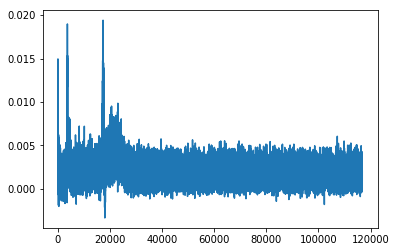

In [410]:
import matplotlib.pyplot as plt 

plt.plot(gen_losses)
plt.show()

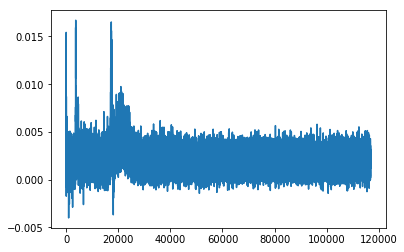

In [411]:
plt.plot(disc_losses)
plt.show()

In [412]:
# to test without train
netD_neg_test = NetD(train_100k.shape[1]).cuda()
netG_neg_test = NetG(train_100k.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1692, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [413]:
netD_neg.eval()
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1692, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [73]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda() 
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [74]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

NameError: name 'netG_neg_test' is not defined

In [75]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [76]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

NameError: name 'fake_test_accur_check' is not defined

In [77]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(25052, 12127)

In [78]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

NameError: name 'fake_test_accur_check' is not defined

In [79]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.6159974427696772

In [80]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

NameError: name 'fake_test_accur_check' is not defined

In [139]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.7569788180597583

In [82]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

NameError: name 'fake_test_accur_check' is not defined

In [83]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

NameError: name 'fake_test_accur_check' is not defined

In [84]:
import gc
gc.collect()

1200

In [451]:
torch.save(netD_neg.state_dict(), './netD_neg-100k')
torch.save(netG_neg.state_dict(), './netG_neg-100k')

In [85]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

NameError: name 'fake_test_accur_check' is not defined

In [427]:
# netG_neg.load_state_dict(torch.load('./netG_neg-100k'))
# netG_neg.eval()

In [144]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [145]:
fake_bin = (fake > 0.8).cpu().numpy()

In [146]:
fake = fake_bin*fake.detach().cpu().numpy()

In [147]:
fake_bin.sum()

1838

In [148]:
# to_augment_negative = fake

In [149]:
p_probs = [(train_100k == 1).sum()/((train_100k > 0) & (train_100k < 4)).sum(), (train_100k == 2).sum()/(((train_100k > 0) & (train_100k < 4))).sum(), (train_100k == 3).sum()/((train_100k > 0) & (train_100k < 4)).sum()]
p_probs

[0.13777417133864464, 0.2552375331956329, 0.6069882954657224]

In [150]:
p_probs = p_probs[::-1]

In [151]:
# # augmented_train_100k = train_100k + to_augment_negative
# augmented_train_100k = train_100k + fake_bin * np.random.choice(np.arange(1, 4), train_100k.shape, p=p_probs)
# augmented_train_100k = train_100k + to_augment_negative * np.random.choice(np.arange(1, 3), train_100k.shape)
# augmented_train_100k = train_100k + to_augment_negative*3

# augmented_train_100k = train_100k + fake*2

augmented_train_100k = train_100k + fake_bin

In [152]:
get_sparsity(train_100k), get_sparsity(augmented_train_100k)

(5.710139043178159, 5.826018866092605)

In [160]:
mf_aug_als_100k = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)

mf_aug_als_100k.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.713266498426549
Test mse: 10.898001340199988
Iteration: 2
Train mse: 5.623896998463458
Test mse: 8.64215201721126
Iteration: 5
Train mse: 5.341333525889116
Test mse: 8.266381069257356
Iteration: 10
Train mse: 5.288821383003823
Test mse: 8.167650697480775
Iteration: 15
Train mse: 5.2815777332728375
Test mse: 8.1711859179901
Iteration: 20
Train mse: 5.2819322779388305
Test mse: 8.176114625495263
Iteration: 30
	current iteration: 10
Train mse: 5.282237391257349
Test mse: 8.177902673069006
Iteration: 40
	current iteration: 10
Train mse: 5.282273635857854
Test mse: 8.17805867121883
Iteration: 50
	current iteration: 10
Train mse: 5.282278509734067
Test mse: 8.178075746915754
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 5.28227862560465
Test mse: 8.17807770026537
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 5.282277648698406
Test mse: 8.178076792088726
Iteration: 120
	current iteration: 10
	current iteration: 20
	cu

In [161]:
mf_als_100k = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)

mf_als_100k.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.895002723511445
Test mse: 10.907282059664317
Iteration: 2
Train mse: 5.751747559730185
Test mse: 8.649164520841305
Iteration: 5
Train mse: 5.43933709148831
Test mse: 8.247584942531589
Iteration: 10
Train mse: 5.400037111411267
Test mse: 8.194275239103654
Iteration: 15
Train mse: 5.396672166089056
Test mse: 8.184688814793207
Iteration: 20
Train mse: 5.396316360141091
Test mse: 8.182741834272509
Iteration: 30
	current iteration: 10
Train mse: 5.396352427491324
Test mse: 8.1823382709835
Iteration: 40
	current iteration: 10
Train mse: 5.3963853589060715
Test mse: 8.182363110300996
Iteration: 50
	current iteration: 10
Train mse: 5.396393463270826
Test mse: 8.182376089546604
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 5.396394772892446
Test mse: 8.182379400164747
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 5.396393830383485
Test mse: 8.182378578188457
Iteration: 120
	current iteration: 10
	current iteration: 20
	

In [162]:
######################### ACCURACY ##############################

min(mf_aug_als_100k.test_mse), min(mf_als_100k.test_mse)

(8.167650697480775, 8.1823382709835)

In [163]:
min(mf_als_100k.test_mse) - min(mf_aug_als_100k.test_mse)

0.01468757350272476

In [153]:
mf_aug_sgd_100k = ExplicitMF(augmented_train_100k, 80, learning='sgd', user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)
mf_aug_sgd_100k.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1989507718800572
Test mse: 1.1598336349545317
Iteration: 2
Train mse: 1.1099415211906996
Test mse: 1.1047959157424492
Iteration: 5
Train mse: 0.9949053497976255
Test mse: 1.0274453565419353
Iteration: 10
Train mse: 0.9316807753183103
Test mse: 0.9828134200294014
Iteration: 15
Train mse: 0.9046953340907871
Test mse: 0.9632558706679671
Iteration: 20
Train mse: 0.8891706406079167
Test mse: 0.9519068878304463
Iteration: 30
	current iteration: 10
Train mse: 0.8715864645586322
Test mse: 0.9394034010737695
Iteration: 40
	current iteration: 10
Train mse: 0.8615598795758608
Test mse: 0.9330605239930815
Iteration: 50
	current iteration: 10
Train mse: 0.8545359435792302
Test mse: 0.9295248531564871
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.8414549544892381
Test mse: 0.9255289709018641
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.8170274764594712
Test mse: 0.9196440965873974
Iteration: 120
	current iteration: 10
	

In [154]:
mf_sgd_100k = ExplicitMF(train_100k, 80, learning='sgd', user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)
mf_sgd_100k.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1446823562460167
Test mse: 1.1617240284650816
Iteration: 2
Train mse: 1.074825745172666
Test mse: 1.1114390286715836
Iteration: 5
Train mse: 0.9783438047812894
Test mse: 1.0349300770103922
Iteration: 10
Train mse: 0.9207262241134205
Test mse: 0.9857648351837907
Iteration: 15
Train mse: 0.8949031095559206
Test mse: 0.9632963600706779
Iteration: 20
Train mse: 0.8796297019925408
Test mse: 0.9502377130016836
Iteration: 30
	current iteration: 10
Train mse: 0.8618892395164972
Test mse: 0.9359676340039165
Iteration: 40
	current iteration: 10
Train mse: 0.8516448916637337
Test mse: 0.9288427392810253
Iteration: 50
	current iteration: 10
Train mse: 0.8445984319300531
Test mse: 0.9249730007704415
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.8328920908808428
Test mse: 0.9211863397072244
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.8148054381654448
Test mse: 0.917465009032443
Iteration: 120
	current iteration: 10
	cu

In [155]:
######################### ACCURACY ##############################

min(mf_aug_sgd_100k.test_mse), min(mf_sgd_100k.test_mse)

(0.8757519523047799, 0.8761865203923714)

In [156]:
######################### ACCURACY ##############################

min(mf_aug_sgd_100k.test_mse), min(mf_sgd_100k.test_mse)

(0.8757519523047799, 0.8761865203923714)

In [157]:
min(mf_sgd_100k.test_mse) - min(mf_aug_sgd_100k.test_mse)

0.0004345680875915692

In [174]:
from sklearn.decomposition import NMF

In [167]:
def train_NMF_model(mat, test_mat):
    mse = []
    for i in range(10):
        print(i*500)
        model = NMF(n_components=20, max_iter=(i+1)*500, alpha=0.01, init='nndsvdar', random_state=seed)
        W = model.fit_transform(mat)
        H = model.components_
        mse.append(get_mse(test_mat, np.matmul(W,H)))
    return mse

In [168]:
mse_augm_NMF = train_NMF_model(augmented_train_100k, test_mat=test_100k)
mse_augm_NMF

0
500
1000
1500
2000
2500
3000
3500
4000
4500


[0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486,
 0.4546710447384486]

In [169]:
mse_NMF = train_NMF_model(train_100k, test_mat=test_100k)
mse_NMF

0
500
1000
1500
2000
2500
3000
3500
4000
4500


[0.45541233368425826,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118,
 0.4547557302871118]

In [170]:
#################### ACCURACY ###################
min(mse_augm_NMF), min(mse_NMF)

(0.4546710447384486, 0.4547557302871118)

In [171]:
min(mse_NMF) - min(mse_augm_NMF)

8.468554866319922e-05

Plots

Text(0, 0.5, 'test MSE error')

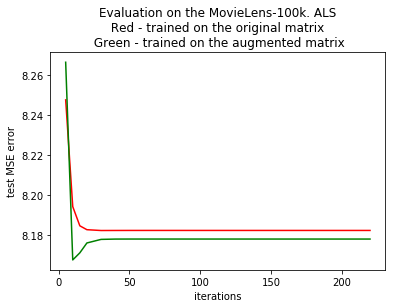

In [177]:
plt.plot(iter_array[2:], mf_als_100k.test_mse[2:], c='r')
plt.plot(iter_array[2:], mf_aug_als_100k.test_mse[2:], c='g')
plt.title('Evaluation on the MovieLens-100k. ALS\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [178]:
print('Best Test MSE error original. ALS', min(mf_als_100k.test_mse))
print('Best Test MSE error augmented. ALS', min(mf_aug_als_100k.test_mse))

Best Test MSE error original. ALS 8.1823382709835
Best Test MSE error augmented. ALS 8.167650697480775


Text(0, 0.5, 'test MSE error')

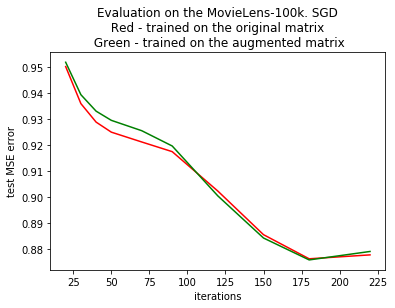

In [179]:
plt.plot(iter_array[5:], mf_sgd_100k.test_mse[5:], c='r')
plt.plot(iter_array[5:], mf_aug_sgd_100k.test_mse[5:], c='g')
plt.title('Evaluation on the MovieLens-100k. SGD\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [181]:
print('Best Test MSE error original. SGD', min(mf_sgd_100k.test_mse))
print('Best Test MSE error augmented. SGD', min(mf_aug_sgd_100k.test_mse))

Best Test MSE error original. SGD 0.8761865203923714
Best Test MSE error augmented. SGD 0.8757519523047799


Text(0, 0.5, 'test MSE error')

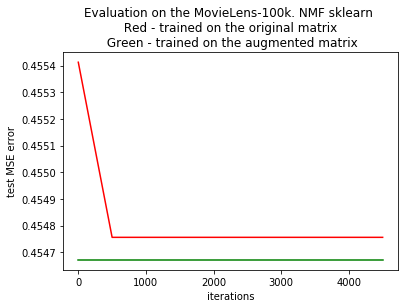

In [182]:
plt.plot(range(0, 5000, 500), mse_NMF, c='r')
plt.plot( range(0, 5000, 500), mse_augm_NMF, c='g')
plt.title('Evaluation on the MovieLens-100k. NMF sklearn \n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [183]:
print('Best Test MSE error original. Sklearn NMF', min(mse_NMF))
print('Best Test MSE error augmented. Sklearn NMF', min(mse_augm_NMF))

Best Test MSE error original. Sklearn NMF 0.4547557302871118
Best Test MSE error augmented. Sklearn NMF 0.4546710447384486


# The same evaluation process goes for the MovieLens-1m

In [125]:
zero_mask = (train_1m == 0)
positive_feedback = (train_1m > 3)
negative_feedback = ((train_1m < 4) * (1 - zero_mask))

In [126]:
positive_feedback.sum(), negative_feedback.sum()

(537748, 402061)

In [127]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [128]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(96.06281587661206, 2.2528118883556316, 1.684372235032308)

In [406]:
lrD = 5e-5
lrG = 5e-5
batch_size = 64
cuda = True
epochs = 500
nz = 16
lamba = 1e-3

In [408]:
# networks
netD_neg = NetD(train_1m.shape[1]).cuda()
netG_neg = NetG(train_1m.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=5e-4)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=5e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=3952, out_features=1024, bias=True)
  (b1): Linear(in_features=3952, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3952, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3968, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3952, bias=True)
    (3): Sigmoid()
  )
)


In [409]:
generator_negative = DataGenerator(negative_feedback, batch_size=64)

In [410]:
# netD_neg.load_state_dict(torch.load('./netD_neg-1m'))

In [411]:
del gen_losses
del disc_losses

In [412]:
gen_losses = []
disc_losses = []

In [413]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
# loss values doesn't say much about the quality
train_GAN(netD_neg, netG_neg, tr=train_1m, epochs=500, negative=True)

[0/500][11/100][1] Loss_D: 0.000001 Loss_G: 0.000016 
[0/500][11/100][2] Loss_D: -0.000027 Loss_G: 0.000008 
[0/500][11/100][3] Loss_D: 0.000012 Loss_G: 0.000005 
[0/500][11/100][4] Loss_D: 0.000014 Loss_G: 0.000016 
[0/500][11/100][5] Loss_D: -0.000001 Loss_G: 0.000018 
[0/500][11/100][6] Loss_D: 0.000025 Loss_G: -0.000010 
[0/500][11/100][7] Loss_D: 0.000017 Loss_G: 0.000019 
[0/500][11/100][8] Loss_D: 0.000017 Loss_G: 0.000010 
[0/500][11/100][9] Loss_D: 0.000027 Loss_G: 0.000036 
[0/500][11/100][10] Loss_D: 0.000035 Loss_G: 0.000026 
[0/500][11/100][11] Loss_D: 0.000019 Loss_G: 0.000024 
[0/500][11/100][12] Loss_D: 0.000016 Loss_G: 0.000016 
[0/500][11/100][13] Loss_D: 0.000022 Loss_G: 0.000048 
[0/500][11/100][14] Loss_D: 0.000026 Loss_G: 0.000011 
[0/500][11/100][15] Loss_D: 0.000007 Loss_G: 0.000012 
[0/500][11/100][16] Loss_D: 0.000027 Loss_G: 0.000022 
[0/500][11/100][17] Loss_D: 0.000023 Loss_G: 0.000015 
[0/500][11/100][18] Loss_D: 0.000015 Loss_G: 0.000013 
[0/500][11/100][

[0/500][11/100][151] Loss_D: 0.001707 Loss_G: 0.000875 
[0/500][11/100][152] Loss_D: 0.001030 Loss_G: 0.001225 
[0/500][11/100][153] Loss_D: 0.000581 Loss_G: 0.000752 
[0/500][11/100][154] Loss_D: 0.000455 Loss_G: 0.000578 
[0/500][11/100][155] Loss_D: 0.000673 Loss_G: 0.000512 
[0/500][11/100][156] Loss_D: 0.001185 Loss_G: 0.000891 
[0/500][11/100][157] Loss_D: 0.000949 Loss_G: 0.000593 
[0/500][11/100][158] Loss_D: 0.001104 Loss_G: 0.000963 
[0/500][11/100][159] Loss_D: 0.001460 Loss_G: 0.000837 
[0/500][11/100][160] Loss_D: 0.001128 Loss_G: 0.001302 
[0/500][11/100][161] Loss_D: 0.000772 Loss_G: 0.001149 
[0/500][11/100][162] Loss_D: 0.001412 Loss_G: 0.001135 
[0/500][11/100][163] Loss_D: 0.001286 Loss_G: 0.001135 
[0/500][11/100][164] Loss_D: 0.000963 Loss_G: 0.001275 
[0/500][11/100][165] Loss_D: 0.000694 Loss_G: 0.000930 
[0/500][11/100][166] Loss_D: 0.000988 Loss_G: 0.001030 
[0/500][11/100][167] Loss_D: 0.001537 Loss_G: 0.000612 
[0/500][11/100][168] Loss_D: 0.001015 Loss_G: 0.

[1/500][11/100][299] Loss_D: 0.000614 Loss_G: 0.000569 
[1/500][11/100][300] Loss_D: 0.000463 Loss_G: 0.000539 
[1/500][11/100][301] Loss_D: 0.000354 Loss_G: 0.000322 
[1/500][11/100][302] Loss_D: 0.000422 Loss_G: 0.000362 
[1/500][11/100][303] Loss_D: 0.000511 Loss_G: 0.000363 
[1/500][11/100][304] Loss_D: 0.000480 Loss_G: 0.000758 
[1/500][11/100][305] Loss_D: 0.000382 Loss_G: 0.000234 
[1/500][11/100][306] Loss_D: 0.000319 Loss_G: 0.000758 
[1/500][11/100][307] Loss_D: 0.000308 Loss_G: 0.000383 
[1/500][11/100][308] Loss_D: 0.000311 Loss_G: 0.000377 
[1/500][11/100][309] Loss_D: 0.000422 Loss_G: 0.000531 
[1/500][11/100][310] Loss_D: 0.000396 Loss_G: 0.000323 
[1/500][11/100][311] Loss_D: 0.000457 Loss_G: 0.000250 
[1/500][11/100][312] Loss_D: 0.000490 Loss_G: 0.000192 
[1/500][11/100][313] Loss_D: 0.000500 Loss_G: 0.000869 
[1/500][11/100][314] Loss_D: 0.000353 Loss_G: 0.000329 
[1/500][11/100][315] Loss_D: 0.000449 Loss_G: 0.000508 
[1/500][11/100][316] Loss_D: 0.000815 Loss_G: 0.

[2/500][11/100][446] Loss_D: 0.000207 Loss_G: 0.000203 
[2/500][11/100][447] Loss_D: 0.000222 Loss_G: 0.000248 
[2/500][11/100][448] Loss_D: 0.000144 Loss_G: 0.000103 
[2/500][11/100][449] Loss_D: 0.000063 Loss_G: 0.000221 
[2/500][11/100][450] Loss_D: 0.000336 Loss_G: 0.000071 
[2/500][11/100][451] Loss_D: 0.000373 Loss_G: 0.000375 
[2/500][11/100][452] Loss_D: 0.000244 Loss_G: 0.000024 
[2/500][11/100][453] Loss_D: 0.000341 Loss_G: 0.000395 
[2/500][11/100][454] Loss_D: 0.000405 Loss_G: 0.000073 
[2/500][11/100][455] Loss_D: 0.000264 Loss_G: 0.000323 
[2/500][11/100][456] Loss_D: 0.000184 Loss_G: 0.000329 
[2/500][11/100][457] Loss_D: 0.000268 Loss_G: 0.000210 
[2/500][11/100][458] Loss_D: 0.000262 Loss_G: 0.000331 
[2/500][11/100][459] Loss_D: 0.000306 Loss_G: 0.000239 
[2/500][11/100][460] Loss_D: 0.000190 Loss_G: 0.000110 
[2/500][11/100][461] Loss_D: 0.000074 Loss_G: 0.000082 
[2/500][11/100][462] Loss_D: 0.000093 Loss_G: 0.000044 
[2/500][11/100][463] Loss_D: 0.000233 Loss_G: 0.

[2/500][11/100][594] Loss_D: 0.000052 Loss_G: -0.000002 
[2/500][11/100][595] Loss_D: 0.000033 Loss_G: 0.000034 
[2/500][11/100][596] Loss_D: 0.000015 Loss_G: 0.000012 
[2/500][11/100][597] Loss_D: 0.000014 Loss_G: 0.000049 
[2/500][11/100][598] Loss_D: 0.000011 Loss_G: 0.000012 
[2/500][11/100][599] Loss_D: 0.000050 Loss_G: 0.000057 
[2/500][11/100][600] Loss_D: 0.000010 Loss_G: 0.000026 
[3/500][11/100][601] Loss_D: 0.000059 Loss_G: 0.000037 
[3/500][11/100][602] Loss_D: 0.000038 Loss_G: 0.000016 
[3/500][11/100][603] Loss_D: 0.000021 Loss_G: 0.000040 
[3/500][11/100][604] Loss_D: 0.000022 Loss_G: 0.000037 
[3/500][11/100][605] Loss_D: 0.000042 Loss_G: 0.000023 
[3/500][11/100][606] Loss_D: 0.000016 Loss_G: 0.000029 
[3/500][11/100][607] Loss_D: 0.000020 Loss_G: 0.000013 
[3/500][11/100][608] Loss_D: 0.000024 Loss_G: 0.000022 
[3/500][11/100][609] Loss_D: 0.000021 Loss_G: 0.000007 
[3/500][11/100][610] Loss_D: 0.000006 Loss_G: 0.000010 
[3/500][11/100][611] Loss_D: 0.000031 Loss_G: 0

[3/500][11/100][741] Loss_D: 0.000016 Loss_G: 0.000001 
[3/500][11/100][742] Loss_D: 0.000007 Loss_G: -0.000003 
[3/500][11/100][743] Loss_D: 0.000009 Loss_G: 0.000014 
[3/500][11/100][744] Loss_D: 0.000009 Loss_G: 0.000004 
[3/500][11/100][745] Loss_D: 0.000003 Loss_G: 0.000011 
[3/500][11/100][746] Loss_D: 0.000008 Loss_G: 0.000004 
[3/500][11/100][747] Loss_D: 0.000007 Loss_G: 0.000001 
[3/500][11/100][748] Loss_D: 0.000007 Loss_G: 0.000013 
[3/500][11/100][749] Loss_D: 0.000004 Loss_G: 0.000005 
[3/500][11/100][750] Loss_D: 0.000001 Loss_G: 0.000001 
[3/500][11/100][751] Loss_D: 0.000005 Loss_G: -0.000004 
[3/500][11/100][752] Loss_D: 0.000007 Loss_G: 0.000006 
[3/500][11/100][753] Loss_D: 0.000006 Loss_G: 0.000004 
[3/500][11/100][754] Loss_D: 0.000004 Loss_G: 0.000002 
[3/500][11/100][755] Loss_D: 0.000004 Loss_G: 0.000005 
[3/500][11/100][756] Loss_D: 0.000003 Loss_G: 0.000005 
[3/500][11/100][757] Loss_D: 0.000004 Loss_G: 0.000002 
[3/500][11/100][758] Loss_D: 0.000000 Loss_G: 

[4/500][11/100][887] Loss_D: 0.000001 Loss_G: 0.000003 
[4/500][11/100][888] Loss_D: -0.000002 Loss_G: -0.000007 
[4/500][11/100][889] Loss_D: -0.000002 Loss_G: 0.000013 
[4/500][11/100][890] Loss_D: 0.000006 Loss_G: 0.000007 
[4/500][11/100][891] Loss_D: -0.000001 Loss_G: 0.000006 
[4/500][11/100][892] Loss_D: 0.000002 Loss_G: 0.000002 
[4/500][11/100][893] Loss_D: 0.000009 Loss_G: 0.000003 
[4/500][11/100][894] Loss_D: 0.000003 Loss_G: -0.000002 
[4/500][11/100][895] Loss_D: 0.000007 Loss_G: 0.000005 
[4/500][11/100][896] Loss_D: 0.000006 Loss_G: 0.000002 
[4/500][11/100][897] Loss_D: 0.000002 Loss_G: 0.000007 
[4/500][11/100][898] Loss_D: 0.000008 Loss_G: 0.000006 
[4/500][11/100][899] Loss_D: 0.000002 Loss_G: 0.000013 
[4/500][11/100][900] Loss_D: 0.000004 Loss_G: -0.000004 
[4/500][11/100][901] Loss_D: 0.000003 Loss_G: -0.000001 
[4/500][11/100][902] Loss_D: -0.000000 Loss_G: 0.000006 
[4/500][11/100][903] Loss_D: 0.000004 Loss_G: 0.000019 
[4/500][11/100][904] Loss_D: 0.000002 Lo

[5/500][11/100][1031] Loss_D: -0.000000 Loss_G: -0.000001 
[5/500][11/100][1032] Loss_D: -0.000001 Loss_G: 0.000001 
[5/500][11/100][1033] Loss_D: -0.000001 Loss_G: 0.000002 
[5/500][11/100][1034] Loss_D: 0.000004 Loss_G: 0.000003 
[5/500][11/100][1035] Loss_D: 0.000001 Loss_G: -0.000002 
[5/500][11/100][1036] Loss_D: -0.000001 Loss_G: 0.000002 
[5/500][11/100][1037] Loss_D: -0.000003 Loss_G: -0.000002 
[5/500][11/100][1038] Loss_D: 0.000001 Loss_G: -0.000002 
[5/500][11/100][1039] Loss_D: 0.000003 Loss_G: 0.000001 
[5/500][11/100][1040] Loss_D: 0.000001 Loss_G: -0.000003 
[5/500][11/100][1041] Loss_D: -0.000000 Loss_G: 0.000001 
[5/500][11/100][1042] Loss_D: -0.000001 Loss_G: 0.000001 
[5/500][11/100][1043] Loss_D: -0.000004 Loss_G: -0.000002 
[5/500][11/100][1044] Loss_D: 0.000000 Loss_G: -0.000000 
[5/500][11/100][1045] Loss_D: 0.000003 Loss_G: 0.000001 
[5/500][11/100][1046] Loss_D: -0.000000 Loss_G: -0.000000 
[5/500][11/100][1047] Loss_D: -0.000002 Loss_G: 0.000000 
[5/500][11/10

[5/500][11/100][1173] Loss_D: 0.000000 Loss_G: -0.000001 
[5/500][11/100][1174] Loss_D: -0.000001 Loss_G: -0.000001 
[5/500][11/100][1175] Loss_D: 0.000002 Loss_G: 0.000001 
[5/500][11/100][1176] Loss_D: 0.000001 Loss_G: 0.000001 
[5/500][11/100][1177] Loss_D: -0.000001 Loss_G: -0.000004 
[5/500][11/100][1178] Loss_D: 0.000001 Loss_G: -0.000000 
[5/500][11/100][1179] Loss_D: -0.000000 Loss_G: 0.000000 
[5/500][11/100][1180] Loss_D: 0.000001 Loss_G: -0.000000 
[5/500][11/100][1181] Loss_D: 0.000001 Loss_G: -0.000001 
[5/500][11/100][1182] Loss_D: 0.000001 Loss_G: 0.000002 
[5/500][11/100][1183] Loss_D: 0.000002 Loss_G: -0.000001 
[5/500][11/100][1184] Loss_D: 0.000000 Loss_G: 0.000000 
[5/500][11/100][1185] Loss_D: -0.000001 Loss_G: 0.000001 
[5/500][11/100][1186] Loss_D: -0.000003 Loss_G: 0.000002 
[5/500][11/100][1187] Loss_D: -0.000000 Loss_G: 0.000000 
[5/500][11/100][1188] Loss_D: 0.000002 Loss_G: -0.000001 
[5/500][11/100][1189] Loss_D: 0.000000 Loss_G: -0.000000 
[5/500][11/100][

[6/500][11/100][1315] Loss_D: 0.000003 Loss_G: -0.000003 
[6/500][11/100][1316] Loss_D: 0.000002 Loss_G: 0.000004 
[6/500][11/100][1317] Loss_D: -0.000000 Loss_G: 0.000001 
[6/500][11/100][1318] Loss_D: 0.000001 Loss_G: -0.000000 
[6/500][11/100][1319] Loss_D: -0.000002 Loss_G: 0.000000 
[6/500][11/100][1320] Loss_D: 0.000003 Loss_G: -0.000002 
[6/500][11/100][1321] Loss_D: -0.000001 Loss_G: -0.000003 
[6/500][11/100][1322] Loss_D: 0.000003 Loss_G: 0.000003 
[6/500][11/100][1323] Loss_D: 0.000001 Loss_G: 0.000003 
[6/500][11/100][1324] Loss_D: 0.000001 Loss_G: 0.000001 
[6/500][11/100][1325] Loss_D: 0.000001 Loss_G: -0.000003 
[6/500][11/100][1326] Loss_D: 0.000001 Loss_G: -0.000003 
[6/500][11/100][1327] Loss_D: -0.000002 Loss_G: 0.000001 
[6/500][11/100][1328] Loss_D: 0.000001 Loss_G: 0.000002 
[6/500][11/100][1329] Loss_D: -0.000001 Loss_G: -0.000001 
[6/500][11/100][1330] Loss_D: 0.000002 Loss_G: 0.000002 
[6/500][11/100][1331] Loss_D: -0.000001 Loss_G: 0.000001 
[6/500][11/100][13

[7/500][11/100][1459] Loss_D: 0.000001 Loss_G: 0.000001 
[7/500][11/100][1460] Loss_D: 0.000000 Loss_G: -0.000000 
[7/500][11/100][1461] Loss_D: 0.000000 Loss_G: 0.000001 
[7/500][11/100][1462] Loss_D: -0.000000 Loss_G: 0.000001 
[7/500][11/100][1463] Loss_D: -0.000000 Loss_G: -0.000000 
[7/500][11/100][1464] Loss_D: 0.000000 Loss_G: 0.000000 
[7/500][11/100][1465] Loss_D: 0.000002 Loss_G: 0.000000 
[7/500][11/100][1466] Loss_D: 0.000000 Loss_G: 0.000001 
[7/500][11/100][1467] Loss_D: -0.000000 Loss_G: 0.000002 
[7/500][11/100][1468] Loss_D: -0.000002 Loss_G: 0.000001 
[7/500][11/100][1469] Loss_D: 0.000002 Loss_G: 0.000000 
[7/500][11/100][1470] Loss_D: 0.000000 Loss_G: -0.000001 
[7/500][11/100][1471] Loss_D: -0.000000 Loss_G: -0.000001 
[7/500][11/100][1472] Loss_D: -0.000000 Loss_G: -0.000000 
[7/500][11/100][1473] Loss_D: -0.000001 Loss_G: 0.000000 
[7/500][11/100][1474] Loss_D: 0.000000 Loss_G: 0.000000 
[7/500][11/100][1475] Loss_D: -0.000000 Loss_G: -0.000001 
[7/500][11/100][1

[8/500][11/100][1602] Loss_D: 0.000004 Loss_G: -0.000003 
[8/500][11/100][1603] Loss_D: -0.000004 Loss_G: -0.000001 
[8/500][11/100][1604] Loss_D: -0.000003 Loss_G: -0.000001 
[8/500][11/100][1605] Loss_D: -0.000002 Loss_G: -0.000000 
[8/500][11/100][1606] Loss_D: 0.000002 Loss_G: -0.000000 
[8/500][11/100][1607] Loss_D: -0.000000 Loss_G: 0.000000 
[8/500][11/100][1608] Loss_D: -0.000001 Loss_G: 0.000007 
[8/500][11/100][1609] Loss_D: 0.000001 Loss_G: 0.000001 
[8/500][11/100][1610] Loss_D: -0.000001 Loss_G: -0.000000 
[8/500][11/100][1611] Loss_D: 0.000003 Loss_G: -0.000002 
[8/500][11/100][1612] Loss_D: 0.000001 Loss_G: 0.000001 
[8/500][11/100][1613] Loss_D: -0.000000 Loss_G: 0.000002 
[8/500][11/100][1614] Loss_D: -0.000003 Loss_G: -0.000002 
[8/500][11/100][1615] Loss_D: -0.000001 Loss_G: 0.000001 
[8/500][11/100][1616] Loss_D: -0.000001 Loss_G: 0.000001 
[8/500][11/100][1617] Loss_D: 0.000003 Loss_G: 0.000003 
[8/500][11/100][1618] Loss_D: -0.000000 Loss_G: 0.000004 
[8/500][11/1

[8/500][11/100][1745] Loss_D: -0.000001 Loss_G: -0.000002 
[8/500][11/100][1746] Loss_D: -0.000001 Loss_G: 0.000001 
[8/500][11/100][1747] Loss_D: 0.000000 Loss_G: 0.000003 
[8/500][11/100][1748] Loss_D: 0.000001 Loss_G: -0.000000 
[8/500][11/100][1749] Loss_D: -0.000000 Loss_G: 0.000001 
[8/500][11/100][1750] Loss_D: -0.000002 Loss_G: 0.000000 
[8/500][11/100][1751] Loss_D: 0.000001 Loss_G: 0.000001 
[8/500][11/100][1752] Loss_D: 0.000001 Loss_G: 0.000001 
[8/500][11/100][1753] Loss_D: -0.000001 Loss_G: -0.000000 
[8/500][11/100][1754] Loss_D: 0.000002 Loss_G: 0.000004 
[8/500][11/100][1755] Loss_D: 0.000001 Loss_G: 0.000002 
[8/500][11/100][1756] Loss_D: 0.000002 Loss_G: -0.000001 
[8/500][11/100][1757] Loss_D: 0.000001 Loss_G: 0.000000 
[8/500][11/100][1758] Loss_D: -0.000002 Loss_G: 0.000003 
[8/500][11/100][1759] Loss_D: 0.000001 Loss_G: 0.000002 
[8/500][11/100][1760] Loss_D: -0.000001 Loss_G: -0.000000 
[8/500][11/100][1761] Loss_D: 0.000000 Loss_G: 0.000001 
[8/500][11/100][176

[9/500][11/100][1888] Loss_D: 0.000001 Loss_G: -0.000000 
[9/500][11/100][1889] Loss_D: 0.000000 Loss_G: 0.000000 
[9/500][11/100][1890] Loss_D: 0.000000 Loss_G: 0.000000 
[9/500][11/100][1891] Loss_D: -0.000002 Loss_G: 0.000001 
[9/500][11/100][1892] Loss_D: -0.000001 Loss_G: 0.000000 
[9/500][11/100][1893] Loss_D: 0.000001 Loss_G: 0.000000 
[9/500][11/100][1894] Loss_D: -0.000000 Loss_G: 0.000001 
[9/500][11/100][1895] Loss_D: 0.000000 Loss_G: 0.000000 
[9/500][11/100][1896] Loss_D: 0.000000 Loss_G: 0.000001 
[9/500][11/100][1897] Loss_D: -0.000001 Loss_G: 0.000001 
[9/500][11/100][1898] Loss_D: -0.000000 Loss_G: -0.000000 
[9/500][11/100][1899] Loss_D: -0.000001 Loss_G: -0.000000 
[9/500][11/100][1900] Loss_D: 0.000001 Loss_G: 0.000001 
[9/500][11/100][1901] Loss_D: 0.000000 Loss_G: 0.000000 
[9/500][11/100][1902] Loss_D: -0.000000 Loss_G: 0.000001 
[9/500][11/100][1903] Loss_D: 0.000002 Loss_G: 0.000000 
[9/500][11/100][1904] Loss_D: -0.000000 Loss_G: 0.000001 
[9/500][11/100][1905

[10/500][11/100][2029] Loss_D: 0.000001 Loss_G: -0.000002 
[10/500][11/100][2030] Loss_D: -0.000002 Loss_G: -0.000003 
[10/500][11/100][2031] Loss_D: -0.000000 Loss_G: -0.000001 
[10/500][11/100][2032] Loss_D: 0.000000 Loss_G: -0.000001 
[10/500][11/100][2033] Loss_D: -0.000001 Loss_G: -0.000001 
[10/500][11/100][2034] Loss_D: -0.000001 Loss_G: -0.000002 
[10/500][11/100][2035] Loss_D: -0.000001 Loss_G: -0.000000 
[10/500][11/100][2036] Loss_D: 0.000002 Loss_G: -0.000000 
[10/500][11/100][2037] Loss_D: 0.000001 Loss_G: -0.000001 
[10/500][11/100][2038] Loss_D: 0.000001 Loss_G: -0.000000 
[10/500][11/100][2039] Loss_D: 0.000000 Loss_G: -0.000001 
[10/500][11/100][2040] Loss_D: -0.000001 Loss_G: 0.000001 
[10/500][11/100][2041] Loss_D: -0.000000 Loss_G: -0.000001 
[10/500][11/100][2042] Loss_D: -0.000000 Loss_G: -0.000001 
[10/500][11/100][2043] Loss_D: -0.000001 Loss_G: -0.000001 
[10/500][11/100][2044] Loss_D: 0.000002 Loss_G: -0.000000 
[10/500][11/100][2045] Loss_D: 0.000000 Loss_G: 

[10/500][11/100][2169] Loss_D: -0.000003 Loss_G: 0.000001 
[10/500][11/100][2170] Loss_D: 0.000000 Loss_G: -0.000001 
[10/500][11/100][2171] Loss_D: -0.000002 Loss_G: -0.000000 
[10/500][11/100][2172] Loss_D: -0.000000 Loss_G: 0.000001 
[10/500][11/100][2173] Loss_D: -0.000001 Loss_G: 0.000001 
[10/500][11/100][2174] Loss_D: -0.000001 Loss_G: 0.000002 
[10/500][11/100][2175] Loss_D: -0.000001 Loss_G: -0.000000 
[10/500][11/100][2176] Loss_D: -0.000001 Loss_G: 0.000000 
[10/500][11/100][2177] Loss_D: 0.000000 Loss_G: -0.000001 
[10/500][11/100][2178] Loss_D: 0.000000 Loss_G: -0.000000 
[10/500][11/100][2179] Loss_D: -0.000001 Loss_G: 0.000001 
[10/500][11/100][2180] Loss_D: 0.000000 Loss_G: -0.000001 
[10/500][11/100][2181] Loss_D: 0.000001 Loss_G: -0.000000 
[10/500][11/100][2182] Loss_D: 0.000000 Loss_G: 0.000000 
[10/500][11/100][2183] Loss_D: -0.000001 Loss_G: 0.000000 
[10/500][11/100][2184] Loss_D: 0.000001 Loss_G: -0.000000 
[10/500][11/100][2185] Loss_D: -0.000000 Loss_G: 0.0000

[11/500][11/100][2309] Loss_D: 0.000000 Loss_G: -0.000001 
[11/500][11/100][2310] Loss_D: 0.000000 Loss_G: 0.000000 
[11/500][11/100][2311] Loss_D: 0.000000 Loss_G: -0.000000 
[11/500][11/100][2312] Loss_D: -0.000000 Loss_G: -0.000000 
[11/500][11/100][2313] Loss_D: 0.000000 Loss_G: 0.000001 
[11/500][11/100][2314] Loss_D: -0.000001 Loss_G: 0.000002 
[11/500][11/100][2315] Loss_D: -0.000001 Loss_G: -0.000002 
[11/500][11/100][2316] Loss_D: 0.000000 Loss_G: 0.000001 
[11/500][11/100][2317] Loss_D: -0.000001 Loss_G: 0.000001 
[11/500][11/100][2318] Loss_D: 0.000001 Loss_G: 0.000003 
[11/500][11/100][2319] Loss_D: 0.000001 Loss_G: -0.000000 
[11/500][11/100][2320] Loss_D: 0.000000 Loss_G: -0.000001 
[11/500][11/100][2321] Loss_D: -0.000001 Loss_G: -0.000002 
[11/500][11/100][2322] Loss_D: -0.000001 Loss_G: 0.000001 
[11/500][11/100][2323] Loss_D: -0.000001 Loss_G: 0.000000 
[11/500][11/100][2324] Loss_D: -0.000001 Loss_G: 0.000001 
[11/500][11/100][2325] Loss_D: -0.000000 Loss_G: 0.000000

[12/500][11/100][2449] Loss_D: 0.000002 Loss_G: 0.000000 
[12/500][11/100][2450] Loss_D: -0.000001 Loss_G: 0.000001 
[12/500][11/100][2451] Loss_D: 0.000001 Loss_G: -0.000000 
[12/500][11/100][2452] Loss_D: 0.000002 Loss_G: -0.000000 
[12/500][11/100][2453] Loss_D: 0.000000 Loss_G: 0.000001 
[12/500][11/100][2454] Loss_D: 0.000000 Loss_G: -0.000000 
[12/500][11/100][2455] Loss_D: 0.000000 Loss_G: -0.000000 
[12/500][11/100][2456] Loss_D: 0.000000 Loss_G: -0.000000 
[12/500][11/100][2457] Loss_D: -0.000000 Loss_G: -0.000001 
[12/500][11/100][2458] Loss_D: 0.000000 Loss_G: -0.000000 
[12/500][11/100][2459] Loss_D: 0.000000 Loss_G: 0.000000 
[12/500][11/100][2460] Loss_D: -0.000000 Loss_G: 0.000001 
[12/500][11/100][2461] Loss_D: -0.000000 Loss_G: 0.000000 
[12/500][11/100][2462] Loss_D: 0.000001 Loss_G: 0.000001 
[12/500][11/100][2463] Loss_D: -0.000000 Loss_G: 0.000001 
[12/500][11/100][2464] Loss_D: 0.000001 Loss_G: 0.000000 
[12/500][11/100][2465] Loss_D: -0.000001 Loss_G: -0.000001 


[12/500][11/100][2590] Loss_D: -0.000002 Loss_G: -0.000001 
[12/500][11/100][2591] Loss_D: 0.000001 Loss_G: -0.000001 
[12/500][11/100][2592] Loss_D: -0.000001 Loss_G: 0.000001 
[12/500][11/100][2593] Loss_D: -0.000000 Loss_G: -0.000000 
[12/500][11/100][2594] Loss_D: -0.000001 Loss_G: -0.000000 
[12/500][11/100][2595] Loss_D: -0.000000 Loss_G: -0.000000 
[12/500][11/100][2596] Loss_D: 0.000000 Loss_G: 0.000000 
[12/500][11/100][2597] Loss_D: -0.000002 Loss_G: -0.000000 
[12/500][11/100][2598] Loss_D: 0.000000 Loss_G: 0.000001 
[12/500][11/100][2599] Loss_D: 0.000001 Loss_G: 0.000001 
[12/500][11/100][2600] Loss_D: 0.000000 Loss_G: 0.000001 
[13/500][11/100][2601] Loss_D: -0.000000 Loss_G: 0.000001 
[13/500][11/100][2602] Loss_D: 0.000001 Loss_G: -0.000001 
[13/500][11/100][2603] Loss_D: 0.000002 Loss_G: -0.000000 
[13/500][11/100][2604] Loss_D: 0.000001 Loss_G: -0.000001 
[13/500][11/100][2605] Loss_D: -0.000000 Loss_G: 0.000003 
[13/500][11/100][2606] Loss_D: -0.000000 Loss_G: 0.0000

[13/500][11/100][2731] Loss_D: -0.000000 Loss_G: 0.000001 
[13/500][11/100][2732] Loss_D: -0.000002 Loss_G: 0.000001 
[13/500][11/100][2733] Loss_D: 0.000001 Loss_G: 0.000001 
[13/500][11/100][2734] Loss_D: 0.000001 Loss_G: 0.000004 
[13/500][11/100][2735] Loss_D: -0.000000 Loss_G: -0.000002 
[13/500][11/100][2736] Loss_D: -0.000001 Loss_G: 0.000002 
[13/500][11/100][2737] Loss_D: -0.000000 Loss_G: 0.000002 
[13/500][11/100][2738] Loss_D: 0.000002 Loss_G: 0.000000 
[13/500][11/100][2739] Loss_D: 0.000003 Loss_G: 0.000002 
[13/500][11/100][2740] Loss_D: 0.000002 Loss_G: 0.000002 
[13/500][11/100][2741] Loss_D: 0.000000 Loss_G: -0.000002 
[13/500][11/100][2742] Loss_D: 0.000001 Loss_G: -0.000000 
[13/500][11/100][2743] Loss_D: 0.000004 Loss_G: 0.000001 
[13/500][11/100][2744] Loss_D: 0.000001 Loss_G: 0.000002 
[13/500][11/100][2745] Loss_D: -0.000001 Loss_G: 0.000001 
[13/500][11/100][2746] Loss_D: 0.000002 Loss_G: 0.000002 
[13/500][11/100][2747] Loss_D: 0.000000 Loss_G: -0.000001 
[13/

[14/500][11/100][2871] Loss_D: 0.000001 Loss_G: -0.000000 
[14/500][11/100][2872] Loss_D: -0.000001 Loss_G: 0.000000 
[14/500][11/100][2873] Loss_D: 0.000001 Loss_G: -0.000000 
[14/500][11/100][2874] Loss_D: 0.000000 Loss_G: -0.000001 
[14/500][11/100][2875] Loss_D: 0.000001 Loss_G: 0.000000 
[14/500][11/100][2876] Loss_D: 0.000002 Loss_G: -0.000000 
[14/500][11/100][2877] Loss_D: -0.000001 Loss_G: -0.000001 
[14/500][11/100][2878] Loss_D: 0.000000 Loss_G: 0.000001 
[14/500][11/100][2879] Loss_D: 0.000001 Loss_G: 0.000002 
[14/500][11/100][2880] Loss_D: 0.000001 Loss_G: 0.000001 
[14/500][11/100][2881] Loss_D: -0.000001 Loss_G: 0.000000 
[14/500][11/100][2882] Loss_D: 0.000000 Loss_G: -0.000001 
[14/500][11/100][2883] Loss_D: -0.000001 Loss_G: 0.000001 
[14/500][11/100][2884] Loss_D: -0.000000 Loss_G: 0.000001 
[14/500][11/100][2885] Loss_D: -0.000001 Loss_G: 0.000001 
[14/500][11/100][2886] Loss_D: 0.000000 Loss_G: -0.000000 
[14/500][11/100][2887] Loss_D: 0.000000 Loss_G: 0.000000 
[

[15/500][11/100][3012] Loss_D: 0.000001 Loss_G: 0.000001 
[15/500][11/100][3013] Loss_D: 0.000001 Loss_G: -0.000001 
[15/500][11/100][3014] Loss_D: -0.000000 Loss_G: -0.000001 
[15/500][11/100][3015] Loss_D: -0.000001 Loss_G: 0.000002 
[15/500][11/100][3016] Loss_D: -0.000002 Loss_G: -0.000002 
[15/500][11/100][3017] Loss_D: 0.000000 Loss_G: 0.000001 
[15/500][11/100][3018] Loss_D: 0.000000 Loss_G: -0.000001 
[15/500][11/100][3019] Loss_D: -0.000001 Loss_G: -0.000001 
[15/500][11/100][3020] Loss_D: -0.000001 Loss_G: 0.000002 
[15/500][11/100][3021] Loss_D: 0.000000 Loss_G: 0.000001 
[15/500][11/100][3022] Loss_D: -0.000002 Loss_G: 0.000000 
[15/500][11/100][3023] Loss_D: 0.000000 Loss_G: -0.000001 
[15/500][11/100][3024] Loss_D: 0.000001 Loss_G: -0.000000 
[15/500][11/100][3025] Loss_D: 0.000001 Loss_G: 0.000001 
[15/500][11/100][3026] Loss_D: 0.000001 Loss_G: 0.000004 
[15/500][11/100][3027] Loss_D: 0.000001 Loss_G: 0.000004 
[15/500][11/100][3028] Loss_D: -0.000000 Loss_G: -0.000000 

[15/500][11/100][3152] Loss_D: 0.000002 Loss_G: -0.000001 
[15/500][11/100][3153] Loss_D: 0.000001 Loss_G: -0.000001 
[15/500][11/100][3154] Loss_D: 0.000001 Loss_G: 0.000001 
[15/500][11/100][3155] Loss_D: 0.000000 Loss_G: 0.000002 
[15/500][11/100][3156] Loss_D: 0.000001 Loss_G: 0.000002 
[15/500][11/100][3157] Loss_D: -0.000002 Loss_G: 0.000001 
[15/500][11/100][3158] Loss_D: 0.000004 Loss_G: 0.000002 
[15/500][11/100][3159] Loss_D: -0.000002 Loss_G: 0.000000 
[15/500][11/100][3160] Loss_D: 0.000002 Loss_G: 0.000001 
[15/500][11/100][3161] Loss_D: 0.000003 Loss_G: 0.000002 
[15/500][11/100][3162] Loss_D: -0.000002 Loss_G: 0.000001 
[15/500][11/100][3163] Loss_D: -0.000003 Loss_G: -0.000001 
[15/500][11/100][3164] Loss_D: -0.000002 Loss_G: 0.000002 
[15/500][11/100][3165] Loss_D: 0.000000 Loss_G: 0.000001 
[15/500][11/100][3166] Loss_D: 0.000001 Loss_G: -0.000000 
[15/500][11/100][3167] Loss_D: -0.000001 Loss_G: 0.000002 
[15/500][11/100][3168] Loss_D: 0.000001 Loss_G: 0.000005 
[15/

[16/500][11/100][3292] Loss_D: 0.000000 Loss_G: -0.000000 
[16/500][11/100][3293] Loss_D: 0.000001 Loss_G: -0.000000 
[16/500][11/100][3294] Loss_D: 0.000001 Loss_G: 0.000001 
[16/500][11/100][3295] Loss_D: -0.000001 Loss_G: 0.000001 
[16/500][11/100][3296] Loss_D: -0.000001 Loss_G: 0.000000 
[16/500][11/100][3297] Loss_D: 0.000001 Loss_G: 0.000001 
[16/500][11/100][3298] Loss_D: 0.000001 Loss_G: 0.000001 
[16/500][11/100][3299] Loss_D: -0.000002 Loss_G: -0.000000 
[16/500][11/100][3300] Loss_D: 0.000001 Loss_G: -0.000001 
[16/500][11/100][3301] Loss_D: -0.000000 Loss_G: -0.000001 
[16/500][11/100][3302] Loss_D: -0.000001 Loss_G: -0.000001 
[16/500][11/100][3303] Loss_D: 0.000001 Loss_G: 0.000000 
[16/500][11/100][3304] Loss_D: 0.000000 Loss_G: 0.000001 
[16/500][11/100][3305] Loss_D: -0.000001 Loss_G: -0.000001 
[16/500][11/100][3306] Loss_D: 0.000000 Loss_G: 0.000000 
[16/500][11/100][3307] Loss_D: -0.000000 Loss_G: 0.000001 
[16/500][11/100][3308] Loss_D: 0.000001 Loss_G: 0.000001 


[17/500][11/100][3432] Loss_D: 0.000002 Loss_G: -0.000000 
[17/500][11/100][3433] Loss_D: -0.000001 Loss_G: -0.000001 
[17/500][11/100][3434] Loss_D: -0.000000 Loss_G: -0.000001 
[17/500][11/100][3435] Loss_D: 0.000001 Loss_G: -0.000001 
[17/500][11/100][3436] Loss_D: -0.000002 Loss_G: 0.000002 
[17/500][11/100][3437] Loss_D: -0.000000 Loss_G: 0.000000 
[17/500][11/100][3438] Loss_D: 0.000000 Loss_G: 0.000002 
[17/500][11/100][3439] Loss_D: 0.000000 Loss_G: -0.000000 
[17/500][11/100][3440] Loss_D: 0.000000 Loss_G: 0.000000 
[17/500][11/100][3441] Loss_D: 0.000001 Loss_G: -0.000001 
[17/500][11/100][3442] Loss_D: -0.000000 Loss_G: 0.000001 
[17/500][11/100][3443] Loss_D: -0.000001 Loss_G: 0.000000 
[17/500][11/100][3444] Loss_D: -0.000000 Loss_G: 0.000001 
[17/500][11/100][3445] Loss_D: 0.000001 Loss_G: 0.000001 
[17/500][11/100][3446] Loss_D: 0.000000 Loss_G: 0.000001 
[17/500][11/100][3447] Loss_D: 0.000000 Loss_G: 0.000001 
[17/500][11/100][3448] Loss_D: -0.000000 Loss_G: -0.000000 

[17/500][11/100][3572] Loss_D: -0.000001 Loss_G: 0.000000 
[17/500][11/100][3573] Loss_D: 0.000001 Loss_G: 0.000001 
[17/500][11/100][3574] Loss_D: 0.000001 Loss_G: -0.000000 
[17/500][11/100][3575] Loss_D: -0.000000 Loss_G: -0.000000 
[17/500][11/100][3576] Loss_D: 0.000000 Loss_G: -0.000000 
[17/500][11/100][3577] Loss_D: -0.000000 Loss_G: -0.000000 
[17/500][11/100][3578] Loss_D: 0.000000 Loss_G: -0.000000 
[17/500][11/100][3579] Loss_D: 0.000000 Loss_G: -0.000001 
[17/500][11/100][3580] Loss_D: 0.000000 Loss_G: 0.000000 
[17/500][11/100][3581] Loss_D: -0.000000 Loss_G: -0.000000 
[17/500][11/100][3582] Loss_D: 0.000000 Loss_G: -0.000000 
[17/500][11/100][3583] Loss_D: -0.000001 Loss_G: 0.000000 
[17/500][11/100][3584] Loss_D: 0.000000 Loss_G: -0.000000 
[17/500][11/100][3585] Loss_D: -0.000000 Loss_G: -0.000000 
[17/500][11/100][3586] Loss_D: -0.000000 Loss_G: 0.000000 
[17/500][11/100][3587] Loss_D: -0.000000 Loss_G: 0.000000 
[17/500][11/100][3588] Loss_D: 0.000000 Loss_G: -0.000

[18/500][11/100][3711] Loss_D: 0.000001 Loss_G: 0.000000 
[18/500][11/100][3712] Loss_D: -0.000000 Loss_G: 0.000000 
[18/500][11/100][3713] Loss_D: 0.000001 Loss_G: 0.000002 
[18/500][11/100][3714] Loss_D: -0.000000 Loss_G: 0.000002 
[18/500][11/100][3715] Loss_D: -0.000001 Loss_G: 0.000002 
[18/500][11/100][3716] Loss_D: 0.000002 Loss_G: -0.000000 
[18/500][11/100][3717] Loss_D: 0.000003 Loss_G: -0.000002 
[18/500][11/100][3718] Loss_D: -0.000001 Loss_G: 0.000001 
[18/500][11/100][3719] Loss_D: 0.000000 Loss_G: 0.000002 
[18/500][11/100][3720] Loss_D: 0.000000 Loss_G: 0.000001 
[18/500][11/100][3721] Loss_D: 0.000002 Loss_G: -0.000000 
[18/500][11/100][3722] Loss_D: -0.000000 Loss_G: 0.000000 
[18/500][11/100][3723] Loss_D: 0.000002 Loss_G: 0.000001 
[18/500][11/100][3724] Loss_D: 0.000000 Loss_G: 0.000001 
[18/500][11/100][3725] Loss_D: -0.000000 Loss_G: -0.000001 
[18/500][11/100][3726] Loss_D: 0.000001 Loss_G: 0.000000 
[18/500][11/100][3727] Loss_D: 0.000000 Loss_G: 0.000002 
[18/

[19/500][11/100][3851] Loss_D: -0.000001 Loss_G: -0.000002 
[19/500][11/100][3852] Loss_D: -0.000002 Loss_G: -0.000002 
[19/500][11/100][3853] Loss_D: 0.000001 Loss_G: 0.000001 
[19/500][11/100][3854] Loss_D: 0.000002 Loss_G: 0.000000 
[19/500][11/100][3855] Loss_D: 0.000000 Loss_G: -0.000000 
[19/500][11/100][3856] Loss_D: 0.000001 Loss_G: 0.000002 
[19/500][11/100][3857] Loss_D: 0.000002 Loss_G: 0.000002 
[19/500][11/100][3858] Loss_D: -0.000002 Loss_G: 0.000002 
[19/500][11/100][3859] Loss_D: 0.000002 Loss_G: -0.000001 
[19/500][11/100][3860] Loss_D: 0.000002 Loss_G: 0.000001 
[19/500][11/100][3861] Loss_D: 0.000001 Loss_G: 0.000002 
[19/500][11/100][3862] Loss_D: 0.000000 Loss_G: 0.000000 
[19/500][11/100][3863] Loss_D: -0.000001 Loss_G: 0.000000 
[19/500][11/100][3864] Loss_D: 0.000003 Loss_G: -0.000002 
[19/500][11/100][3865] Loss_D: 0.000003 Loss_G: -0.000000 
[19/500][11/100][3866] Loss_D: -0.000002 Loss_G: -0.000002 
[19/500][11/100][3867] Loss_D: -0.000001 Loss_G: 0.000004 
[

[19/500][11/100][3991] Loss_D: -0.000002 Loss_G: 0.000003 
[19/500][11/100][3992] Loss_D: 0.000000 Loss_G: 0.000000 
[19/500][11/100][3993] Loss_D: 0.000000 Loss_G: 0.000000 
[19/500][11/100][3994] Loss_D: 0.000000 Loss_G: -0.000001 
[19/500][11/100][3995] Loss_D: 0.000001 Loss_G: 0.000000 
[19/500][11/100][3996] Loss_D: 0.000001 Loss_G: -0.000000 
[19/500][11/100][3997] Loss_D: 0.000000 Loss_G: -0.000001 
[19/500][11/100][3998] Loss_D: -0.000001 Loss_G: 0.000000 
[19/500][11/100][3999] Loss_D: -0.000001 Loss_G: -0.000001 
[19/500][11/100][4000] Loss_D: -0.000001 Loss_G: 0.000001 
[20/500][11/100][4001] Loss_D: 0.000001 Loss_G: 0.000002 
[20/500][11/100][4002] Loss_D: -0.000000 Loss_G: -0.000000 
[20/500][11/100][4003] Loss_D: 0.000001 Loss_G: 0.000002 
[20/500][11/100][4004] Loss_D: -0.000002 Loss_G: -0.000002 
[20/500][11/100][4005] Loss_D: 0.000001 Loss_G: -0.000000 
[20/500][11/100][4006] Loss_D: 0.000000 Loss_G: -0.000000 
[20/500][11/100][4007] Loss_D: 0.000002 Loss_G: -0.000001 

[20/500][11/100][4130] Loss_D: 0.000001 Loss_G: -0.000002 
[20/500][11/100][4131] Loss_D: 0.000001 Loss_G: 0.000002 
[20/500][11/100][4132] Loss_D: 0.000000 Loss_G: 0.000001 
[20/500][11/100][4133] Loss_D: -0.000002 Loss_G: -0.000000 
[20/500][11/100][4134] Loss_D: -0.000002 Loss_G: 0.000000 
[20/500][11/100][4135] Loss_D: -0.000000 Loss_G: 0.000001 
[20/500][11/100][4136] Loss_D: 0.000000 Loss_G: 0.000001 
[20/500][11/100][4137] Loss_D: -0.000000 Loss_G: 0.000001 
[20/500][11/100][4138] Loss_D: 0.000000 Loss_G: 0.000002 
[20/500][11/100][4139] Loss_D: 0.000001 Loss_G: -0.000001 
[20/500][11/100][4140] Loss_D: -0.000001 Loss_G: 0.000002 
[20/500][11/100][4141] Loss_D: -0.000000 Loss_G: 0.000001 
[20/500][11/100][4142] Loss_D: -0.000001 Loss_G: -0.000000 
[20/500][11/100][4143] Loss_D: -0.000000 Loss_G: 0.000000 
[20/500][11/100][4144] Loss_D: 0.000001 Loss_G: -0.000000 
[20/500][11/100][4145] Loss_D: 0.000000 Loss_G: 0.000000 
[20/500][11/100][4146] Loss_D: -0.000000 Loss_G: 0.000000 


[21/500][11/100][4270] Loss_D: -0.000000 Loss_G: 0.000000 
[21/500][11/100][4271] Loss_D: 0.000000 Loss_G: 0.000000 
[21/500][11/100][4272] Loss_D: -0.000000 Loss_G: 0.000000 
[21/500][11/100][4273] Loss_D: 0.000000 Loss_G: -0.000000 
[21/500][11/100][4274] Loss_D: 0.000000 Loss_G: 0.000000 
[21/500][11/100][4275] Loss_D: 0.000001 Loss_G: 0.000001 
[21/500][11/100][4276] Loss_D: -0.000000 Loss_G: 0.000000 
[21/500][11/100][4277] Loss_D: -0.000001 Loss_G: -0.000001 
[21/500][11/100][4278] Loss_D: -0.000001 Loss_G: 0.000000 
[21/500][11/100][4279] Loss_D: 0.000001 Loss_G: 0.000000 
[21/500][11/100][4280] Loss_D: -0.000000 Loss_G: -0.000000 
[21/500][11/100][4281] Loss_D: 0.000001 Loss_G: 0.000000 
[21/500][11/100][4282] Loss_D: -0.000000 Loss_G: 0.000002 
[21/500][11/100][4283] Loss_D: -0.000002 Loss_G: -0.000001 
[21/500][11/100][4284] Loss_D: -0.000000 Loss_G: -0.000002 
[21/500][11/100][4285] Loss_D: -0.000001 Loss_G: 0.000000 
[21/500][11/100][4286] Loss_D: 0.000001 Loss_G: -0.000001

[22/500][11/100][4409] Loss_D: -0.000001 Loss_G: 0.000000 
[22/500][11/100][4410] Loss_D: -0.000001 Loss_G: -0.000001 
[22/500][11/100][4411] Loss_D: 0.000000 Loss_G: 0.000001 
[22/500][11/100][4412] Loss_D: -0.000000 Loss_G: 0.000000 
[22/500][11/100][4413] Loss_D: 0.000001 Loss_G: 0.000000 
[22/500][11/100][4414] Loss_D: -0.000000 Loss_G: -0.000000 
[22/500][11/100][4415] Loss_D: 0.000000 Loss_G: 0.000001 
[22/500][11/100][4416] Loss_D: 0.000001 Loss_G: 0.000001 
[22/500][11/100][4417] Loss_D: 0.000001 Loss_G: 0.000001 
[22/500][11/100][4418] Loss_D: 0.000000 Loss_G: 0.000004 
[22/500][11/100][4419] Loss_D: 0.000001 Loss_G: 0.000001 
[22/500][11/100][4420] Loss_D: 0.000000 Loss_G: -0.000001 
[22/500][11/100][4421] Loss_D: 0.000001 Loss_G: 0.000002 
[22/500][11/100][4422] Loss_D: 0.000001 Loss_G: -0.000000 
[22/500][11/100][4423] Loss_D: 0.000001 Loss_G: -0.000000 
[22/500][11/100][4424] Loss_D: 0.000000 Loss_G: -0.000001 
[22/500][11/100][4425] Loss_D: -0.000000 Loss_G: -0.000001 
[2

[22/500][11/100][4549] Loss_D: -0.000001 Loss_G: -0.000002 
[22/500][11/100][4550] Loss_D: 0.000001 Loss_G: 0.000001 
[22/500][11/100][4551] Loss_D: 0.000002 Loss_G: -0.000002 
[22/500][11/100][4552] Loss_D: 0.000002 Loss_G: 0.000001 
[22/500][11/100][4553] Loss_D: -0.000001 Loss_G: -0.000002 
[22/500][11/100][4554] Loss_D: 0.000001 Loss_G: 0.000001 
[22/500][11/100][4555] Loss_D: -0.000001 Loss_G: -0.000000 
[22/500][11/100][4556] Loss_D: 0.000001 Loss_G: 0.000002 
[22/500][11/100][4557] Loss_D: -0.000000 Loss_G: 0.000000 
[22/500][11/100][4558] Loss_D: -0.000000 Loss_G: 0.000000 
[22/500][11/100][4559] Loss_D: 0.000001 Loss_G: -0.000000 
[22/500][11/100][4560] Loss_D: 0.000002 Loss_G: -0.000001 
[22/500][11/100][4561] Loss_D: 0.000000 Loss_G: -0.000002 
[22/500][11/100][4562] Loss_D: -0.000000 Loss_G: -0.000001 
[22/500][11/100][4563] Loss_D: 0.000002 Loss_G: -0.000001 
[22/500][11/100][4564] Loss_D: -0.000001 Loss_G: 0.000001 
[22/500][11/100][4565] Loss_D: -0.000002 Loss_G: -0.0000

[23/500][11/100][4689] Loss_D: 0.000000 Loss_G: -0.000001 
[23/500][11/100][4690] Loss_D: 0.000001 Loss_G: 0.000001 
[23/500][11/100][4691] Loss_D: 0.000001 Loss_G: -0.000001 
[23/500][11/100][4692] Loss_D: 0.000001 Loss_G: -0.000001 
[23/500][11/100][4693] Loss_D: 0.000000 Loss_G: 0.000001 
[23/500][11/100][4694] Loss_D: 0.000000 Loss_G: -0.000001 
[23/500][11/100][4695] Loss_D: -0.000000 Loss_G: 0.000001 
[23/500][11/100][4696] Loss_D: 0.000001 Loss_G: 0.000000 
[23/500][11/100][4697] Loss_D: -0.000000 Loss_G: 0.000000 
[23/500][11/100][4698] Loss_D: -0.000000 Loss_G: 0.000001 
[23/500][11/100][4699] Loss_D: 0.000002 Loss_G: -0.000000 
[23/500][11/100][4700] Loss_D: 0.000001 Loss_G: -0.000001 
[23/500][11/100][4701] Loss_D: 0.000001 Loss_G: -0.000001 
[23/500][11/100][4702] Loss_D: -0.000001 Loss_G: 0.000002 
[23/500][11/100][4703] Loss_D: 0.000001 Loss_G: -0.000000 
[23/500][11/100][4704] Loss_D: 0.000000 Loss_G: -0.000000 
[23/500][11/100][4705] Loss_D: 0.000001 Loss_G: -0.000000 


[24/500][11/100][4829] Loss_D: 0.000001 Loss_G: -0.000001 
[24/500][11/100][4830] Loss_D: 0.000002 Loss_G: -0.000002 
[24/500][11/100][4831] Loss_D: 0.000003 Loss_G: 0.000001 
[24/500][11/100][4832] Loss_D: -0.000001 Loss_G: -0.000001 
[24/500][11/100][4833] Loss_D: 0.000000 Loss_G: -0.000000 
[24/500][11/100][4834] Loss_D: -0.000000 Loss_G: 0.000001 
[24/500][11/100][4835] Loss_D: 0.000001 Loss_G: 0.000001 
[24/500][11/100][4836] Loss_D: -0.000000 Loss_G: 0.000001 
[24/500][11/100][4837] Loss_D: 0.000000 Loss_G: 0.000001 
[24/500][11/100][4838] Loss_D: 0.000000 Loss_G: 0.000001 
[24/500][11/100][4839] Loss_D: 0.000002 Loss_G: -0.000004 
[24/500][11/100][4840] Loss_D: 0.000001 Loss_G: -0.000001 
[24/500][11/100][4841] Loss_D: -0.000001 Loss_G: 0.000001 
[24/500][11/100][4842] Loss_D: 0.000000 Loss_G: 0.000001 
[24/500][11/100][4843] Loss_D: 0.000003 Loss_G: -0.000002 
[24/500][11/100][4844] Loss_D: 0.000004 Loss_G: -0.000001 
[24/500][11/100][4845] Loss_D: -0.000001 Loss_G: 0.000002 
[

[24/500][11/100][4969] Loss_D: 0.000002 Loss_G: -0.000002 
[24/500][11/100][4970] Loss_D: 0.000001 Loss_G: -0.000001 
[24/500][11/100][4971] Loss_D: 0.000001 Loss_G: -0.000001 
[24/500][11/100][4972] Loss_D: -0.000001 Loss_G: 0.000001 
[24/500][11/100][4973] Loss_D: -0.000001 Loss_G: 0.000001 
[24/500][11/100][4974] Loss_D: -0.000000 Loss_G: -0.000000 
[24/500][11/100][4975] Loss_D: 0.000004 Loss_G: 0.000002 
[24/500][11/100][4976] Loss_D: 0.000001 Loss_G: 0.000001 
[24/500][11/100][4977] Loss_D: 0.000001 Loss_G: -0.000001 
[24/500][11/100][4978] Loss_D: -0.000002 Loss_G: -0.000000 
[24/500][11/100][4979] Loss_D: -0.000001 Loss_G: -0.000000 
[24/500][11/100][4980] Loss_D: -0.000000 Loss_G: 0.000002 
[24/500][11/100][4981] Loss_D: 0.000002 Loss_G: -0.000001 
[24/500][11/100][4982] Loss_D: 0.000000 Loss_G: -0.000002 
[24/500][11/100][4983] Loss_D: 0.000001 Loss_G: 0.000001 
[24/500][11/100][4984] Loss_D: 0.000000 Loss_G: 0.000000 
[24/500][11/100][4985] Loss_D: -0.000001 Loss_G: 0.000002

KeyboardInterrupt: 

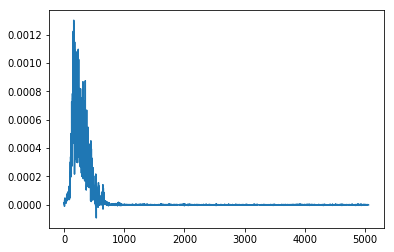

In [414]:
import matplotlib.pyplot as plt
plt.plot(gen_losses)
plt.show()

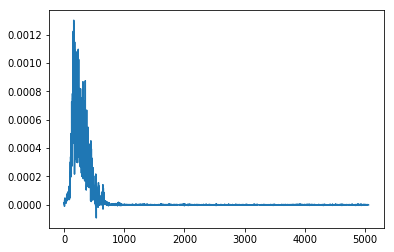

In [415]:
import matplotlib.pyplot as plt
plt.plot(gen_losses)
plt.show()

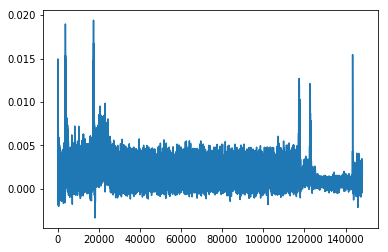

In [556]:
import matplotlib.pyplot as plt
plt.plot(gen_losses)
plt.show()

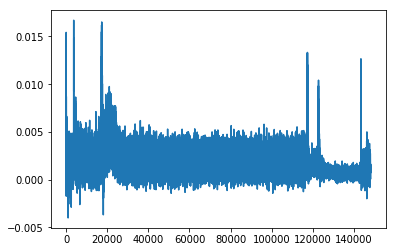

In [557]:
plt.plot(disc_losses)
plt.show()

In [416]:
netD_neg.eval()
# netG_neg_test.eval()

NetD(
  (t1): Linear(in_features=3952, out_features=1024, bias=True)
  (b1): Linear(in_features=3952, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3952, bias=True)
)

In [417]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda() 
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_1m > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [418]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

NameError: name 'netG_neg_test' is not defined

In [419]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [420]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

NameError: name 'fake_test_accur_check' is not defined

In [421]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(57690, 43667)

In [422]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

NameError: name 'fake_test_accur_check' is not defined

In [423]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.14348568998236585

In [424]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

NameError: name 'fake_test_accur_check' is not defined

In [425]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.9187965366677329

In [426]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

NameError: name 'fake_test_accur_check' is not defined

In [427]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

NameError: name 'fake_test_accur_check' is not defined

In [428]:
import gc
gc.collect()

5522

In [429]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

NameError: name 'fake_test_accur_check' is not defined

In [391]:
# torch.save(netD_neg.state_dict(), './netD_neg-1m')
# torch.save(netG_neg.state_dict(), './netG_neg-1m')

In [430]:
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3968, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3952, bias=True)
    (3): Sigmoid()
  )
)

In [449]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_1m == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [450]:
# fake = (fake > 0.8).cpu().numpy()
fake_bin = (fake > 0.5).cpu().numpy()

In [451]:
fake_bin.sum()

1154963

In [452]:
fake = fake_bin*fake.detach().cpu().numpy()

In [453]:
p_probs = [(train_1m == 1).sum()/((train_1m > 0) & (train_1m < 4)).sum(), (train_1m == 2).sum()/(((train_1m > 0) & (train_1m < 4))).sum(), (train_1m == 3).sum()/((train_1m > 0) & (train_1m < 4)).sum()]
p_probs

[0.13228340973135916, 0.25343915475512424, 0.6142774355135167]

In [454]:
p_probs = p_probs[::-1]

In [455]:
# # augmented_train_1m = train_1m + to_augment_negative
augmented_train_1m = train_1m + fake_bin * np.random.choice(np.arange(1, 4), train_1m.shape, p=p_probs)

# augmented_train_1m = train_1m + fake * np.random.choice(np.arange(1, 4), train_1m.shape)
# augmented_train_1m = train_1m + to_augment_negative*3

# augmented_train_1m = train_1m + fake*2

# augmented_train_1m = train_1m + fake_bin

In [456]:
get_sparsity(train_1m), get_sparsity(augmented_train_1m)

(3.93718412338794, 8.77572257822345)

In [762]:
mf_aug_als_1m = ExplicitMF(augmented_train_1m, n_factors=20, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)

mf_aug_als_1m.calculate_learning_curve(iter_array, test_1m)

Iteration: 1


KeyboardInterrupt: 

In [544]:
mf_als_1m = ExplicitMF(train_1m, n_factors=20, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)

mf_als_1m.calculate_learning_curve(iter_array, test_1m)

Iteration: 1
Train mse: 8.027251691520371
Test mse: 11.358682726516696
Iteration: 2
Train mse: 6.164014293045613
Test mse: 9.506837217177061
Iteration: 5
Train mse: 5.950187823094575
Test mse: 9.196411017458313
Iteration: 10
Train mse: 5.930486936088672
Test mse: 9.154937169092118
Iteration: 15
Train mse: 5.9257563974181435
Test mse: 9.148006626904772
Iteration: 20
Train mse: 5.92389108782975
Test mse: 9.148461234906533
Iteration: 30
	current iteration: 10
Train mse: 5.922538486760237
Test mse: 9.15103354295008
Iteration: 40
	current iteration: 10
Train mse: 5.92200139836607
Test mse: 9.152563760477305
Iteration: 50
	current iteration: 10
Train mse: 5.921722532381974
Test mse: 9.15330641987875
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 5.9214621882400005
Test mse: 9.153751219048303
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 5.9213483246715
Test mse: 9.153731204664716
Iteration: 120
	current iteration: 10
	current iteration: 20
	cu

In [181]:
min(mf_aug_als_1m.test_mse), min(mf_als_1m.test_mse)

NameError: name 'mf_aug_als_1m' is not defined

In [182]:
min(mf_als_1m.test_mse) - min(mf_aug_als_1m.test_mse)

NameError: name 'mf_als_1m' is not defined

In [457]:
from sklearn.decomposition import NMF
def train_NMF_model(mat, test_mat):
    mse = []
    for i in range(10):
        print(i*500)
        model = NMF(n_components=20, max_iter=(i+1)*500, alpha=0.1, init='nndsvdar', random_state=seed)
        W = model.fit_transform(mat)
        H = model.components_
        mse.append(get_mse(test_mat, np.matmul(W,H)))
    return mse

In [458]:
mse_augm_NMF = train_NMF_model(augmented_train_1m, test_1m)
mse_augm_NMF

0
500
1000
1500
2000
2500
3000
3500
4000
4500


[0.44638447401051273,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704,
 0.44617761951072704]

In [549]:
mse_NMF = train_NMF_model(train_1m, test_1m)
mse_NMF

0
500
1000
1500
2000
2500
3000
3500
4000
4500


[0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398,
 0.2971192676398398]

In [550]:
min(mse_NMF) - min(mse_augm_NMF)

-0.0005167455854496183

In [405]:
mf_aug_sgd_1m = ExplicitMF(augmented_train_1m, 40, learning='sgd', verbose=True)
mf_aug_sgd_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train mse: 0.994958155027405
Test mse: 1.0364015760944205
Iteration: 2
Train mse: 0.9237980157425687
Test mse: 0.9826978187004521
Iteration: 5
Train mse: 0.8579622663458246
Test mse: 0.9266424959277535
Iteration: 10
Train mse: 0.8285274535506287
Test mse: 0.896365004793963
Iteration: 15
Train mse: 0.8176023342631294
Test mse: 0.8836449911278033
Iteration: 20
Train mse: 0.8117519776898943
Test mse: 0.8767486999518045
Iteration: 30
	current iteration: 10
Train mse: 0.8033484988280534
Test mse: 0.8692107909215083
Iteration: 40
	current iteration: 10
Train mse: 0.7874958826664151
Test mse: 0.8616238789913212
Iteration: 50
	current iteration: 10
Train mse: 0.7519492254481396
Test mse: 0.846048237226553
Iteration: 70
	current iteration: 10


KeyboardInterrupt: 

In [551]:
mf_aug_sgd_1m = ExplicitMF(augmented_train_1m, 40, learning='sgd', verbose=True)
mf_aug_sgd_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train mse: 1.001242117031275
Test mse: 1.035217416494368
Iteration: 2
Train mse: 0.9272787240574304
Test mse: 0.9818880359593072
Iteration: 5
Train mse: 0.8595912746215684
Test mse: 0.9264626927591002
Iteration: 10
Train mse: 0.8297558960241378
Test mse: 0.8964090917818494
Iteration: 15
Train mse: 0.8187561967258734
Test mse: 0.8837448833319287
Iteration: 20
Train mse: 0.8128635934436055
Test mse: 0.8768641618199917
Iteration: 30
	current iteration: 10
Train mse: 0.8041731619239254
Test mse: 0.8692406683033475
Iteration: 40
	current iteration: 10
Train mse: 0.7867265933897841
Test mse: 0.8609930987197928
Iteration: 50
	current iteration: 10
Train mse: 0.7496589170974914
Test mse: 0.8445086798651902
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.6635249605306119
Test mse: 0.8101306420700717
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.5819653144607525
Test mse: 0.791298937780468
Iteration: 120
	current iteration: 10
	cur

KeyboardInterrupt: 

In [665]:
mf_aug_sgd_1m = ExplicitMF(augmented_train_1m, 40, learning='sgd', verbose=True)
mf_aug_sgd_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train mse: 1.0079981187586027
Test mse: 1.024993907907899
Iteration: 2
Train mse: 0.927097949696126
Test mse: 0.9736550294170926
Iteration: 5
Train mse: 0.8616603908438567
Test mse: 0.9246632846886182
Iteration: 10
Train mse: 0.834072229687187
Test mse: 0.8975169714968052
Iteration: 15
Train mse: 0.8239384718237245
Test mse: 0.8856454599934155
Iteration: 20
Train mse: 0.8183926348211223
Test mse: 0.879038170062705
Iteration: 30
	current iteration: 10
Train mse: 0.8093457250692175
Test mse: 0.8713614660385829
Iteration: 40
	current iteration: 10
Train mse: 0.788892990119377
Test mse: 0.8617648526333238
Iteration: 50
	current iteration: 10
Train mse: 0.7497580069198982
Test mse: 0.8436194326834997
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.6640326223017986
Test mse: 0.8093303082781249
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.584248778844406
Test mse: 0.7911376443411339
Iteration: 120
	current iteration: 10
	curren

In [666]:
mf_sgd_1m = ExplicitMF(train_1m, 40, learning='sgd', verbose=True)
mf_sgd_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train mse: 0.9992958253304043
Test mse: 1.0379153110878256
Iteration: 2
Train mse: 0.9268195452181696
Test mse: 0.9836132243399859
Iteration: 5
Train mse: 0.8585567728602344
Test mse: 0.9266753510684083
Iteration: 10
Train mse: 0.8284136493572699
Test mse: 0.8962947096621144
Iteration: 15
Train mse: 0.8173308370260667
Test mse: 0.883572450489696
Iteration: 20
Train mse: 0.8114156605024927
Test mse: 0.8766691080418562
Iteration: 30
	current iteration: 10
Train mse: 0.8029086683957272
Test mse: 0.8690976880062411
Iteration: 40
	current iteration: 10
Train mse: 0.7866303390936499
Test mse: 0.8613452814688152
Iteration: 50
	current iteration: 10
Train mse: 0.7503879299043521
Test mse: 0.8454573204678153
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.6635104163491218
Test mse: 0.810766085110277
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.5815579174663293
Test mse: 0.7916179798131148
Iteration: 120
	current iteration: 10
	cu

In [667]:
min(mf_aug_sgd_1m.test_mse), min(mf_sgd_1m.test_mse)

(0.7911376443411339, 0.7916179798131148)

In [668]:
min(mf_sgd_1m.test_mse) - min(mf_aug_sgd_1m.test_mse)

0.0004803354719808972

Text(0, 0.5, 'test MSE error')

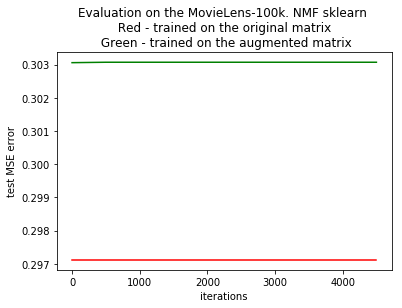

In [674]:
plt.plot(range(0, 5000, 500), mse_NMF, c='r')
plt.plot( range(0, 5000, 500), mse_augm_NMF, c='g')
plt.title('Evaluation on the MovieLens-100k. NMF sklearn \n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

Text(0, 0.5, 'test MSE error')

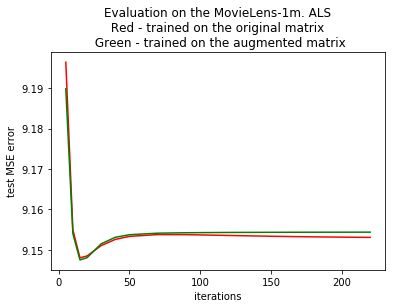

In [675]:
plt.plot(iter_array[2:], mf_als_1m.test_mse[2:], c='r')
plt.plot(iter_array[2:], mf_aug_als_1m.test_mse[2:], c='g')
plt.title('Evaluation on the MovieLens-1m. ALS\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [676]:
print('Best Test MSE error original. ALS', min(mf_als_1m.test_mse))
print('Best Test MSE error augmented. ALS', min(mf_aug_als_1m.test_mse))

Best Test MSE error original. ALS 9.148006626904772
Best Test MSE error augmented. ALS 9.147482032269066


Text(0, 0.5, 'test MSE error')

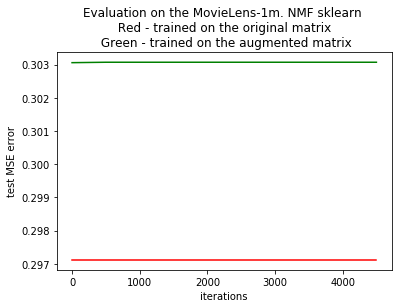

In [677]:
plt.plot(range(0, 5000, 500), mse_NMF, c='r')
plt.plot( range(0, 5000, 500), mse_augm_NMF, c='g')
plt.title('Evaluation on the MovieLens-1m. NMF sklearn \n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

Text(0, 0.5, 'test MSE error')

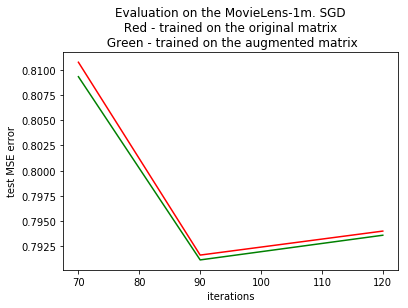

In [692]:
plt.plot(iter_array[9:12], mf_sgd_1m.test_mse[9:12], c='r')
plt.plot(iter_array[9:12], mf_aug_sgd_1m.test_mse[9:12], c='g')
plt.title('Evaluation on the MovieLens-1m. SGD\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [682]:
print('Best Test MSE error original. SGD', min(mf_sgd_1m.test_mse))
print('Best Test MSE error augmented. SGD', min(mf_aug_sgd_1m.test_mse))

Best Test MSE error original. SGD 0.7916179798131148
Best Test MSE error augmented. SGD 0.7911376443411339
